# Project: Vehicle Detection and Tracking
The goal of this project is to implement a pipeline to detect cars at a video stream and track them.

**Credits**: Some functions used in this project were provided by Udacity at the related lesson from the SDC ND. Many of them were tunned and updated to fit the pipeline process.

## Pipeline helper - Feature extraction
The section below presents the functions related to feature extraction from the input image. These features are fed to the previously generated model in order to predict if the current window contains or not a vehicle.

In [3]:
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [4]:
# Helper function for feature extraction - Perform color conversion 
# Color Space YCrCb was used for training and prediction
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Helper function for feature extraction - Extracts the HOG from the input image
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Helper function for feature extraction - Computes image input resize
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Helper function for feature extraction - Computes the color Histogram from image input
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## Pipeline helper - Draw and Visualization
The following section

In [5]:
def pltSingle(img, title, plot=True, axis_grid='off'):
    if plot == True:
        f, ax = plt.subplots(1,1)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis(axis_grid)
        plt.show()

In [13]:
def pltCompare(img1, title1, img2, title2, plot=True, axis_grid='off'):
    if plot == True:
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
        ax1.imshow(img1)
        ax1.set_title(title1)
        ax1.axis(axis_grid)
        ax2.imshow(img2)
        ax2.set_title(title2)
        ax2.axis(axis_grid)
        plt.show()

In [7]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

## Pipeline helper - Car Detection and Tracking
The following function **find_cars()** was adapted and enhanced based on sample code provided by Udacity. This funcion:
- Extracts features from a given image region
- Use HOG sub-sampling for additional features
>NOTE: Sub-sampling for performance instead of computing HOG for each window analysis
- Use a sliding windows technique to input images to the trained model and predict if the current window contains or not a car
- Returns the windows coordinates for sampling windows where the the model detected a car.

In [48]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    bboxes = []
    
    img_tosearch = img[ystart:ystop, xstart:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #print(test_features.shape)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #for ystart and ystop
                #bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                bboxes.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                #for use of xstart
                
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                #heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    #return draw_img, heatmap
    return bboxes

## Pipeline helper - Heatmap
This section

In [72]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bboxa
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bbox_heat = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_heat.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, bbox_heat

## Pipeline - Parameters

In [58]:
svc_params_dict = pickle.load( open("20-output-classifier.p", "rb" ) )
svc = svc_params_dict["svc"]
X_scaler = svc_params_dict["scaler"]
orient = svc_params_dict["orient"]
pix_per_cell = svc_params_dict["pix_per_cell"]
cell_per_block = svc_params_dict["cell_per_block"]
spatial_size = svc_params_dict["spatial_size"]
hist_bins = svc_params_dict["hist_bins"]
#ystart = 400
ystart = 350
ystop = 656
xstart = 700
#scales = [1, 1.2, 1.4, 1.6, 1.8, 2]
scales = [1.5, 1.7, 2]
box_list = []

In [82]:
import collections
heatmaps = collections.deque(maxlen=10)

## Pipeline - Main

In [79]:
def pipeline(img, plot=False, singleProc=True):
    global svc
    global X_scaler
    global orient
    global pix_per_cell
    global cell_per_block
    global spatial_size
    global hist_bins
    global ystart
    global ystop
    global xtart
    global scales  
    global box_list
    global heatmaps

    pltSingle(img, 'Input Pipeline: Input image', plot)
        
    for scale in scales:
        bb = find_cars(img, ystart, ystop, xstart, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list = box_list + bb
        
    # Case of visualization, draw blue boxes for the windows where the Model detected a vehicle
    if plot == True:
        detected_img = draw_boxes(img, box_list)
        pltSingle(detected_img, 'Output Pipeline: Vehicle Detection', plot)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    #current_heatmap = add_heat(img, hot_windows)
    heatmaps.append(heat)
    heatmap_sum = sum(heatmaps)
    
    pltSingle(heatmap, 'Output Pipeline: Heatmap Filtered', plot)
    
    #plt.imshow(draw_img)
    #plt.title('Car Positions')
    #plt.subplot(122)
    #plt.imshow(heatmap, cmap='hot')
    #plt.title('Heat Map')

    # Find final boxes from heatmap using label function
    #labels = label(heatmap)
    labels = label(heatmap_sum)
    draw_img, bbox_heat = draw_labeled_bboxes(np.copy(img), labels)
    
    # Reset box_list for next iteration but stores
    box_list = []
    #if singleProc == False:
    #    box_list = box_list + bbox_heat
    
    return draw_img

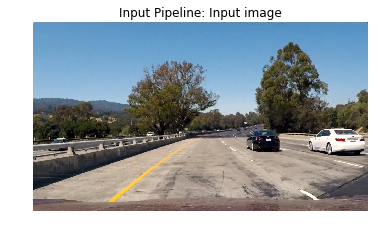

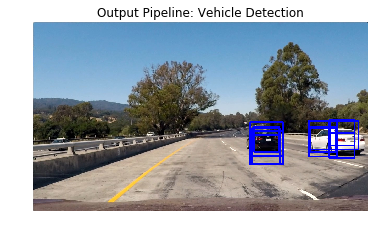

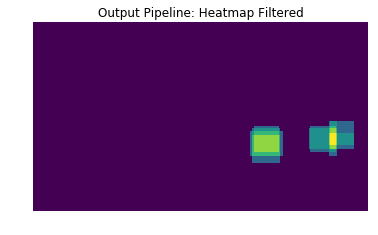

Process time: 1.6160106658935547 seconds 


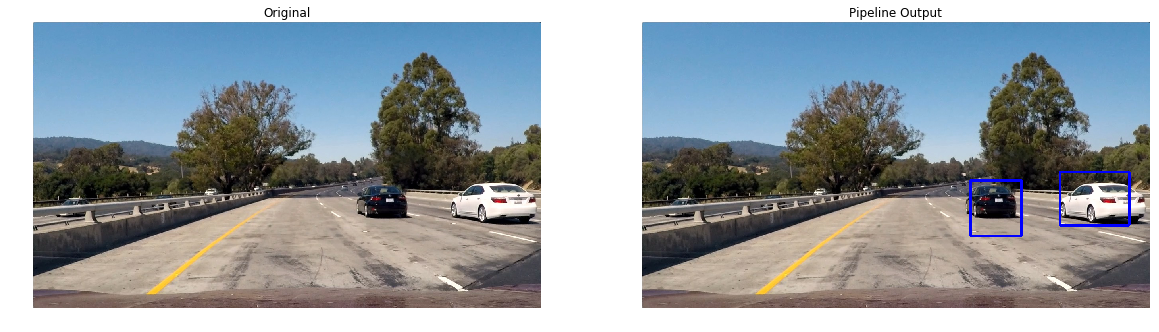

In [52]:
import time

testImage_DIR = './11-input-testImages'
img = mpimg.imread(testImage_DIR + '/test1.jpg')

start_time = time.time()
out = pipeline(img, True)
print("Process time: %s seconds " % (time.time() - start_time))

pltCompare(img, 'Original', out, 'Pipeline Output')

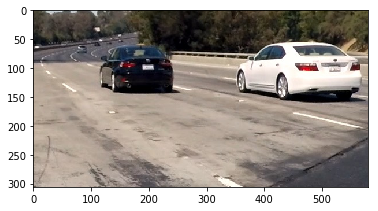

In [47]:
plt.imshow(img[350:ystop, 700:1280,:])
plt.show()

In [38]:
img.shape

(720, 1280, 3)

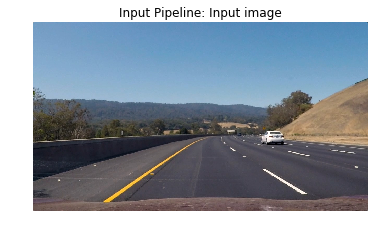

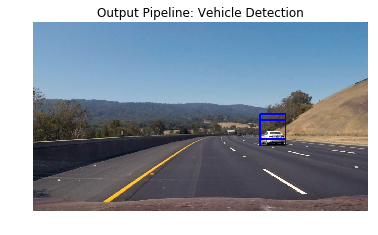

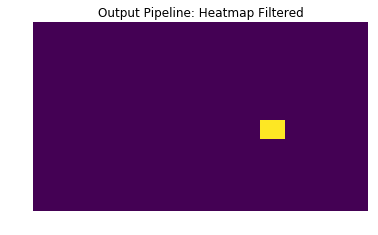

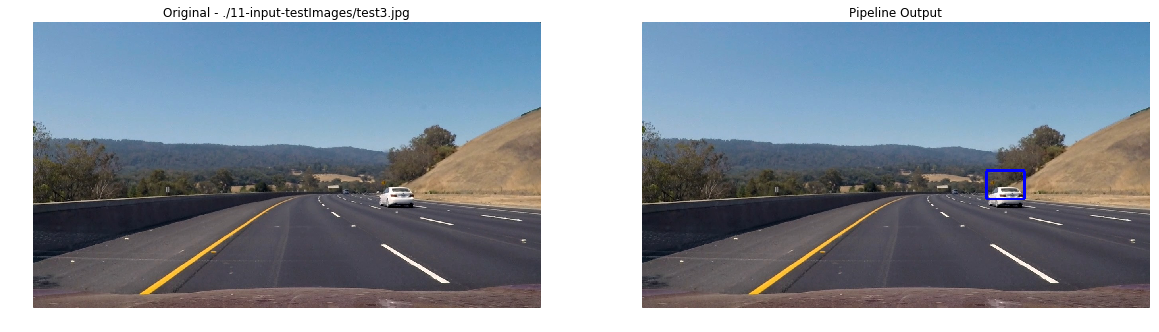

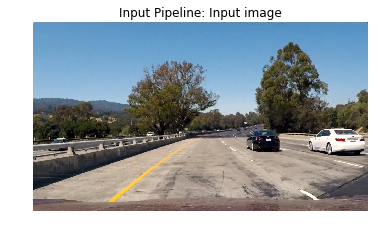

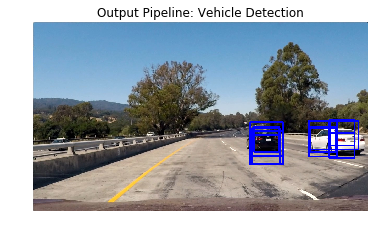

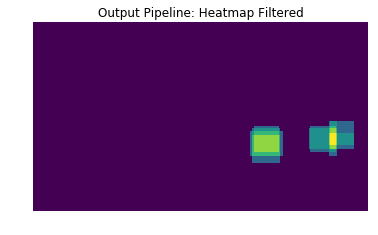

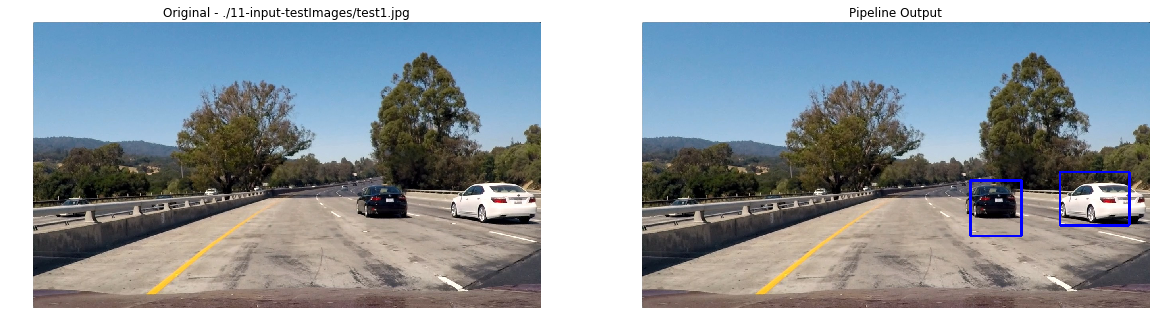

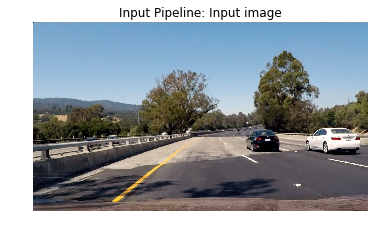

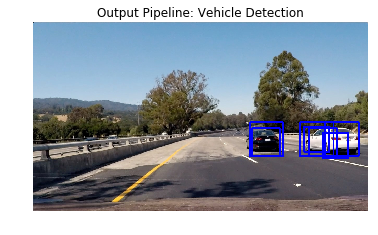

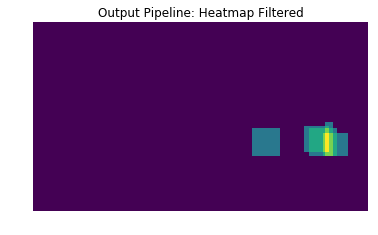

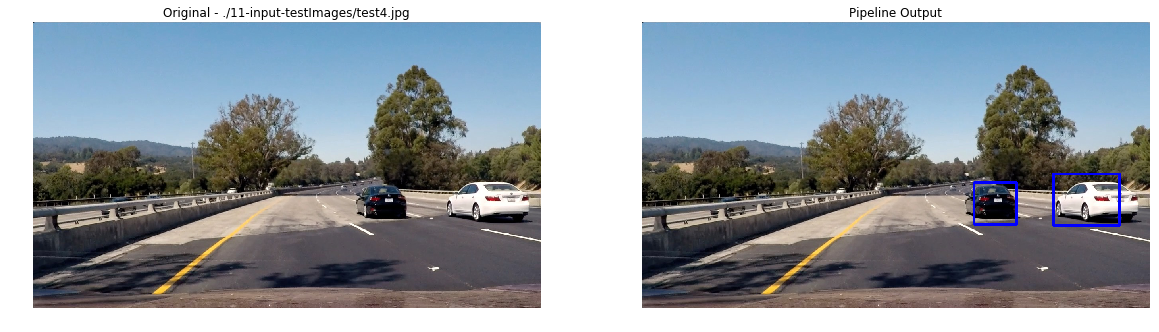

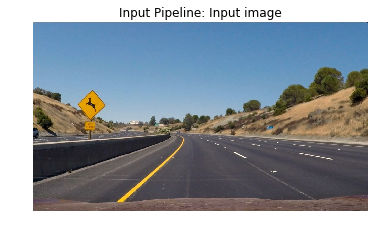

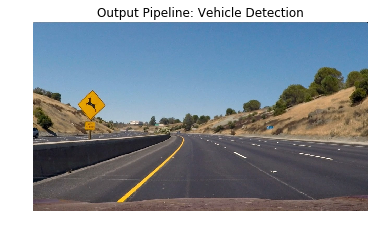

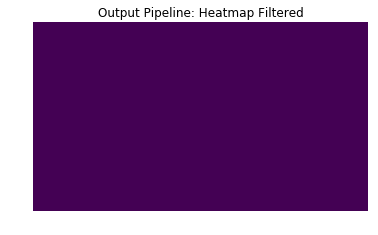

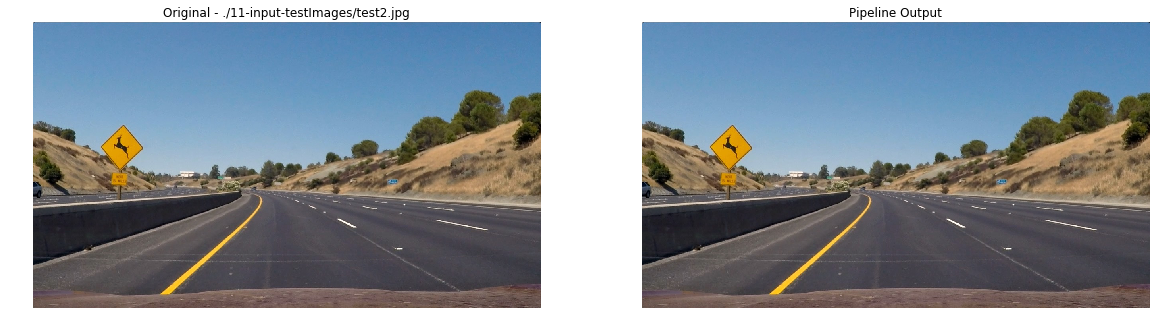

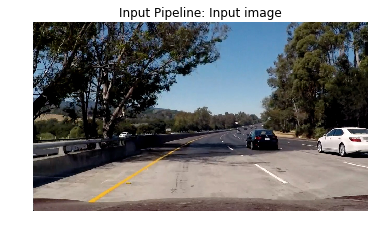

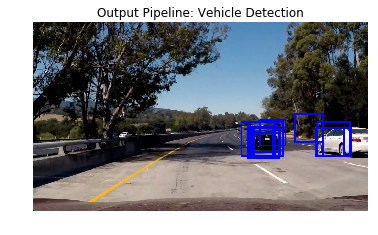

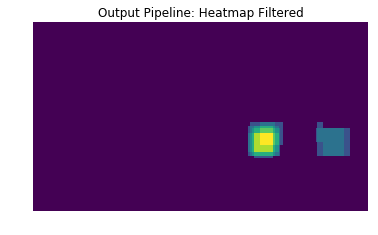

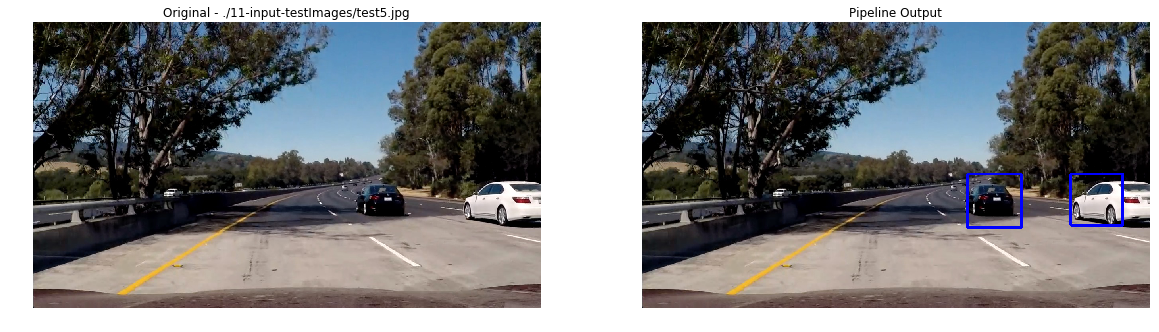

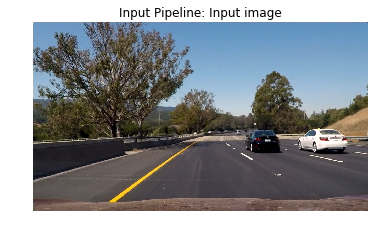

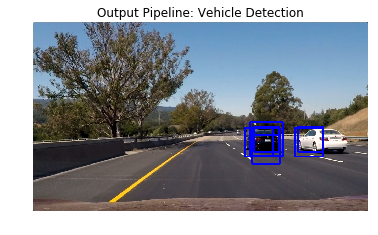

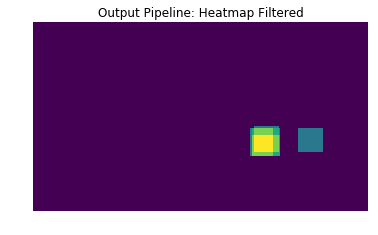

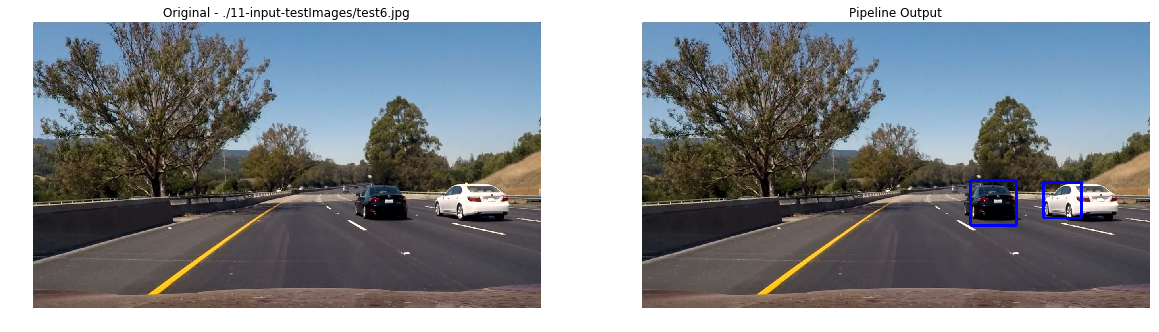

In [53]:
import glob
import os
testImage_DIR = './11-input-testImages/'
images = glob.glob(testImage_DIR + '*.jpg')

for fname in images:
    img = mpimg.imread(fname)
    out = pipeline(img, True)
    file = os.path.basename(fname)
    pltCompare(img, 'Original - {}'.format(fname), out, 'Pipeline Output')

In [61]:
def process_image(image):
    return pipeline(image, plot=False, singleProc=False)

In [ ]:
from moviepy.editor data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABIcAAAFMCAYAAABRZtxLAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzsvXmcZclV3/k9ce/bcq3KPWvLqq7qXUtLjSQkQAYJGcRi2WNgjAFbMx/bYzNeB/B48NYaY8aM8Ribzcb4w3gw9shjY8bGmJEAISS0dqv3VldXV3WtmVlZuWe+fNu9ceaPiHvffS9fVleru9VFd/zq8z718t64cSNOnIjze3FORIiqEhAQEBAQEBAQEBAQEBAQEBDwxoR5rQsQEBAQEBAQEBAQEBAQEBAQEPDaIUwOBQQEBAQEBAQEBAQEBAQEBLyBESaHAgICAgICAgICAgICAgICAt7ACJNDAQEBAQEBAQEBAQEBAQEBAW9ghMmhgICAgICAgICAgICAgICAgDcwwuRQQEBAQEBAQEBAQEBAQEBAwBsYYXIo4HUBEflREfnFVzrtLeSlInLmlcjr1YSInBCRXRGJXuuyBPzBgYj8VxH50691OQICAgICAv6g4ZWyoSLyYRH5dOHvXRG54+XmGxAQENCPMDkUcNvBG8EnRWRPRJZF5OdF5NDNnlHVH1fVP3Mr+b+UtF9tiEhZRFZFZEREvkdEPuPl8LsD0v6CiJwVESsiH75Zvqp6WVVHVDV9tcpeKNdFEfnmF0nzuyLysttARL5RRK72XXtIRP71y837qw3fnn+unwS+zDz3tYWIRCLyYyKyKCI7IvLoQf1LVT+oqv/qlShLQEBAQEDA6w3ezjb8hM11EfklERmBV8+Gej534ZXOF0BEvkNEviAidRFZE5FfEZFjL+H5V4TfvVr5BQQE3BxhcijgtoKI/BDwE8CPAOPA1wILwMdFpHzAM/FXr4SvOt4LPKaqu8A68FPAPzgg7ePADwJf+iqVLeDVxbcCv/FVeM9HgPcA7wbGgB8Aml+F9wYEBAQEBLwe8Z2qOgK8HXgH8Lde4/J8RRCR7wL+DfBPgCngfqAFfFpEDr+WZQsICPjqIEwOBdw2EJEx3A/Xv6Sqv6mqHVW9CHwPboLo+326h0Tk34vIvxaRbeDD/dEiIvKnROSS93r87WIERTGtiJz0S8P+tIhc9lE7f7OQzztF5LMisikiSyLyMwdNUr1C+Db8BIGq/paq/jtgcVBCVf1ZVf1tbuGHfaGesf/7d0Xk74nI7/vokY+JyFRf2j/no0uW/KRdltf/KSI/Vvg7j94RkV8GTgD/2XvR/vqAsvx94BuAn/FpfsZfv0dEPi4i6z4i6nsKz3ybiDzjy3pNRH5YRIaB/woc8fnsisiRAe9TEflBETnnn/97InLat+u2iPy7rE1F5LCI/LqI3BCRDf/9WCGvUyLyez6f3xKRn+3Tu68VF+21KSKPi8g3Fu59WEQu+GdfEJHvK9x7C7AJjAL/DHi3r8+mv18RkZ/0OnpdRP6ZiNT8vSlfzk0vu0+JiBnUFp7c/VXgz6rqJXV4SlUH6lDRY+fL//si8tMisiUiz4rI+29VNgEBAQEBAa9nqOo1HC95E7xkGzouIv/Sc65r4iJ8B24FIIUtDTwn+1kR+S/e/n5eRE4X0h7IrfryFOAfAT+mqr+iqg1VXQb+DLAL/DWfrp9v5/zyJvxOReQvew60KiL/UETMV5pfQEDAq4cwORRwO+E9QBX41eJFH0XzX4EPFC5/CPj3wCHgV4rpReQ+4OeA7wPmcRFIR1/k3V8P3A28H/g7InKvv57iDOIULtLi/bhonVcL3wb8l1cx/yL+JPDfATNAGfjhvvvfBNwJ/GHgb8iLLBUDUNUfAC7jvWiq+r8PSPM3gU8Bf9Gn+Yt+oufjOI/VDPC9wM+JyP3+sX8J/A+qOoojXb+jqnXgg8Ciz2dEVQdOpOGich7ERaL9deAXcPpx3Of3vT6dAX4JNxl5AmgARTLyb4AvAJPAQ7ioGwBE5Ciu7X4MmMDJ8z+IyLSv3z8FPujr8B7gsUK+3wb8F1X9MvDngc/6+mTLvX4CuAt4ADiD0+e/4+/9EHAVmAZmgR91Yh7YFm8GEuC7xC3ZfE5E/scDZDYI7wIu4PrD3wV+VUQmXkw2AQEBAQEBr3eIyHGcPX/0gCQ3s6H/CmefzwBvw3GvW11O9b045+ph4Hng7/vyvBi3KuJuHO/5f4oXVdUC/4FeDj4Qg/hd4fYfA74GF131IeC/f5n5BQQEvAoIk0MBtxOmgFVVTQbcW/L3M3xWVX9NVa2qNvrSfhfwn1X106raxv2I1hd590e8l+Rx3HKttwKo6iOq+jlVTXwU0z8H/tBLr9qLQ9zmgiVVPftq5D8Av6Sqz3n5/TvcxEMRH1HVuqo+iZsw+d59Obxy+A7goqr+kpf1l3Bk5Lv8/Q5wn4iMqeqGv/9S8BOquq2qTwNPAR9T1QuquoWbeHwbgKquqep/UNU9Vd3BEaw/BG5Tb1y4+N9R1baqfhr4T4V3fD/wG6r6G14vPw48jCOKABZ4k4jUVHXJlyXDt3PAkjLvzfuzwF9T1XVfrh8H/kRBNvPAgo+2+5SqHqTvx3CTpXcBp3DyfUhEXpT0eawAP+Xf81HgLPDttyCbgICAgICA1yt+zUf6fhr4JM5GD8JBNnQW5+z6q553rQD/mK6dfzH8qqp+wfPnX6HL516MWxWRceylAff6OfhXgp/wHOYybsuEV5NTBgQEfIUIk0MBtxNWgSkZvIfQvL+f4cpN8jlSvK+qe8Dai7x7ufB9DxgBEJG7/JKdZXFL2H6cWzCQIvIN0l3q9PSLpfc4cILgpaLw7l3/w30QBta5gKKML+Hk+pWU5Z8VyvKjByRbAN7ll0ZtepL1fcCcv//HcZMsl0TkkyLy7pdYjOuF740Bf2ftPSQi/1zcksRt4PeAQz60+wiw7vUpQ1FGC8B399Xh64F5H+X03+KigpZ8+Pc9/p2HgHuAzxxQ9mlgCHikkO9v+usA/xDnKfyYD9n+GzeRQzaR+r/6ydAngP+b7gTWi+Fa38RTphcvJpuAgICAgIDXK/6oqh5S1QVV/cEBTssMB9nQBaCE4weZnf/nuGifW8FBfO7FuFURGceeH3Cvn4N/JXhFOGVAQMCrizA5FHA74bO4je/+m+JFHxb7QeC3C5dvFgm0hIuQyJ6v4Za6fCX4eeBZ4E5VHcMt2ZEXe8hHb2RLnQaF7w7CK7akrPDuEe+l+UpwvPD9BN29j+q4yYoM/SSjp21U9c8XyvLjg9LgSMMnPbnKPiOq+hd8Hl9U1Q/hiNKv4SKdBuXzcvFDuNDqd/n2fq+/Lji9mhCRYt2LMroC/HJfHYZV9R/4Ovx/qvoBHMl6FvgX/rlvAX5buyfJ9ddpFTepc38h33F1m1+iqjuq+kOqegfwncD/VNjHoD+vJw64fqs46iOZMmR68WKyCQgICAgIeKPjIBt6Bcd/pwp2fuwl8MeDcFNu1YezuCXq31286PcG+uN0OfhL4oAFvCKcMiAg4NVFmBwKuG3gl/h8BPhpEflWESmJyEnc+uerwC/fYlb/HvhOEXmPuI2GP8ItTOgcgFFgG9j1kR6DDOrLhp/Aeifwu4VrkYhUgRgwIlIVkVLhftnfF6Dk77+Sffpv+0ia+3F7E33UX38M+DYRmRCROdwGx0VcB+54kbz70/w6cJeI/IBv95KIvENE7vX1/D4RGVfVDq490kI+kyIy/jLqWcQobiJm0+8D8HezG6p6CbdM7CFfpnfjJmMy/Guc3n1L1nbiNus+JiKzIvJH/ERnC7e5Y1aH/oix68Axr7vZev9/AfxjEZkBt7+RiHyL//4dInLGE85MNkX55HJW1fO49ft/U9wm1/fiIpp+/RblMwP8Zd8+3w3ci1tK92KyCQgICAgIeKPjIBu6BHwM+EciMibuUInTIvJytzE4kFv1J/QRTT8M/C0R+ZMiUvMc7xdxJ5v+Y5/0MeC9InLCc6//pS+rgzjgj4g79OM48Ffo5ZRfSX4BAQGvAsLkUMBtBXWb5v4o8JO4H7qfx3k+3q+qrVvM42ngL+GWyywBO7h13rf0fB9+GLdx8w7uB/pHb5781uEnPLIlZ+/H7aNUPDXqB3ATFT+PO62hQTfaBByRaOA2N/4F//29vHL4JG650m8DP6mqH/PXfxm3L9NFX4Z+mfxvOHKxKSL9m1xn+Ce4TZE3ROSf+n10/jBuff0iLkT6J4CKT/8DwEW/1OvP40+uU9VngX8LXPDve7lhyj8F1HDROp/DLd8q4vtwG5Ov4Tae/iher1T1Cm6TxR8FbuD09kdw46zBRSUtAuu4fYx+0E/ofKDvPb8DPA0si0gWxv0/49ric14Gv4WLcAK3afhv4SacPgv8nKr+rr83qC2+FxdqvoaLVPvb6k6969fJQfi8f98qbj+m71LVbMnmgbIJCAgICAgIuKkN/VO4w0GeATZwjs5BS7xuGbfArfrTfxTHt/6aL+MzOE70dVk5/X6KH8VFIj/CfudSD78rXP9/ffrHcNzjX77M/AICAl4FyMH7lgYEvD4gIiO4Y8LvVNUXXuvyDIKI/BzwlKr+3G1QlpPAC7jNsQdtDh7gISIfBZ5V1b/7ookHP/9O4GdU9Z2vbMleGYjI7wG/qKr/l4h8GPgzqvr1t/jsy5JNQEBAQEDA6wUv1Ya+niAiiuPgz7/WZQkICLg5QuRQwOsSIvKdfknUMC4K6UlcpMvtiseA//haFyLg5vDh2Kd9yPe34iKFfu1lZntbTp74/YPuwE0U3kr6V0M2AQEBAQEBAQEBAQFfBQw6FSog4PWAD+GWPwluL5Q/cZPjvV9zqOovvNZlCLglzAG/itvg/CrwF1T10a80M1X9witVsFcSfm+j54H/jDua91bwisomICAgICAgICAgIOCrh7CsLCAgICAgICAgICAgICAgIOANjLCsLCAgICAgICAgICAgICAgIOANjNtiWdnHP/YJ/b1z60ia0jFVKmLpaAS4qKYsuskd7EP+fdB1i+67LiJIqqiAKqhAqgIYEOmmwxKJe160m08GVcUYA0aw1mKtJYqinnQp3e/FcplUwbi/1ShGQayiA+bnsrpZUld2LLVSjHY6bK2vUatVGK5V2N3e4urVq5i4RKIRUanM/MKCK6d1dSnR4fzZs6ht00maIIbx6SPMzh1FU0uz2eTC82eZOHyYjbXr7G2uMVZqMTk6xPPnL2HimLmTb+GFxTU++J3fQaO5y+iI4bEvfIFyUqdsLM+fu0hcHeH0HfewWm+hlQp33PMmKkPDLF7f5MixE2ztbGKMoRSVERHSNMUonP3yc5y6Y4FyZIjjmCTtcH15hXLJMDs7S5okbK6tMjY+gjGG8+fPcebMGZrthHJtiO3tbTrNBlcuvcDdd9/LlStXmD48zqOPPMzJ43Pce89dkMLO3g5XV1bY3NyjWhnlzjMLtNvbNDc3kbRDq9Xi+toGR07cyfLaDgv3vonR8XEarRZRqYSqa5OOdf9nbRtFEUSGKIowBwbhCcYY1OtUpkepKtZap1N9ei7aq/uDdKqolyJC0+o+fSzeVyH/H0A7aW8f8d+L9TPZ3wpGoWU0vz+oLFJ4dSSun6SqmDjK84ly/fbl6MtGBbCKoVsejPh+25VLz3jgZdp/Hev/trrvXkdcPxel2wYCxg6Wc6o2lxWAte5vY4xvs668LG4syvq8iKCpzfOKcfJL6JYv8nmoKql002XlUtW8/lm+mYyirExk6WyvPmUf/7hFB9axKLNBepTLu/is6eaLtRiEyOt8x6Y95cjawJrB705sui//TG+j1D2b9rf9AfUotpeo+z8bbVMxA+uITbE4+WcyByhb6RmpM7ln9R8ko7TwfDF9sc9lbVUsZ2bDoijqPnOTAN+8f6vmeiC6v1/1P1Msj/q+mvWHLI2JIxJr8zJCt6/0fPc602/NLNnYlrK3s8lTjz/GF/7jz9ykZAGvBQIH60XgYIGDBQ4WOFiWLitX4GCBgw3C65GD3RaTQ5+9sMWKHqZcLpGaKpFtkxITFYRxM/QMOEbywb+HvMQ+LzW+wQyDchdNEePIQMJ++YkIikEi2fcOl3/akzaHJzRkbxWLSZW07x3ZAGKtxZD4MsFnn3iKijFsrd7gbWdOs7bWZHerwZ2nv4b/9Ou/wfu+9dtYXLpOJ5ogVYsYqJVKrG/eYOrEmyl12lx64TwdhUMTd7Oz58o5XBthZ/dZJidqHF84jTl2hPOPf5qnL7/AocNjdPyAfueZe9ncTGh3lMe/9Fm01WA87nD22aeYnJ6lUq3y+NkrtChx79vfQVKaZGe3xfDMKS7d2KE0Oken02GsNkKaWDq2TalU4tQD8zx37llOLZwgiiKkrNTLCecvXODw/D0kdKAaURqa4PLli1TGTrKyJVSHD7O53aZanWVubpyry3vMzd3N6vUWY8PTHJurM1wpce3iGuWKUq5VWd/YJi4N86a3PkCrvs3ilSVKapmZHGd9dY1jR46zsVXn9F1vpj26wIZVZKhMO01ADOVylWbSa8wzWxPH8f5BLoMnDJkhy8iIxZHUIiHI8rXsJyX7dKovjcbsy8srX1evCtejSld3b7a81Ci5ltrY5Gmz+viC7estBsGKxeLrr4rQHaRtgcQX356IgiixdAmbZsSELrkryqNsJR8ki+XSkqt3hCdDtmuwbdQ1qEa77yFyf2dEJytDVr+B7eXvZwZQBawqKdrNy7/MeJLi2jkjeRDhZFgkJpnsFUiwqMkL4QxBn4G2qtiMeAr5e8ATKOvrY+0+XcplVrAuRb2IzAHGHHLDJI5ZuTTaSw7iOM6/dw6wtB1s3ib95KMsXWNuC0U/SHe1QBgyueavNTKwr2jkdCw1BVKhUFGz74dHJntru5oshXw7XhbFuhSrXWz/Yl1s3zM3qyO4dsnyLpb5IFjZn58xBis218HsnWIMibF5e2U/qjLSU8b/4DLdHxLZu61Y1PfhKIqwZpK3feCegwsW8JohcLDe/AMHCxwscLDAwYqyDxwscLCD8HrkYLfF5FAi1s2apU2sQkXcnG8sfR4pP6j0d44eBU4Ls3g9s6/dwUqQ3ONkrUWibk/Uwoxh1omzd6iqyxPT9UL0zYZrQfO08HysrtmcUjhSYBSM9M7zZWU2qkR0Sc7b77+bNOkw/Ka7aHd2+dWP/luOTU6BaXDy9BGePf8Ub3ngARqdOqkaOoml09pjpFYm2dtCoiZSSjj75ec4dPwo9Wab+aPHadkKR07czeNPPcrC0Qk2b1zhvoUzXEOIVNhZW+PLTz2J1K7xgZN3UB4aIaJEo7nNenONe+++i6uL16jvtTh67D6oHub4kePs7qVUaqOsb2zTbLcYGWohSRvTgnZzj93tbWampqnFZaL2FlFnC21bRoZHmKoZhk/OoskOjd0dsJZSPALaYLg2xJNPPczkzDy10UMM1abZ21nl5PFpLlx+ghtrF7nvrnne9sAZvvTwp7jv3tOcO3eN8lANTJnTd9/D4uIio5USb73vLawsX6G+uca3vu99fOyTn2H48BxxdRg6daJSzObGFlGlQlSukDRaVOIq4j0OKHkLGWt7DG0RxgqGgkG0FoPJjWzRowVZ5x/sFSq+osdo+vIMGsCMMbkuFged4uxzMT9HuHppe/6c7RpDKfSpKN2fNiPYziB0SUb2/EFjZ2ScjKICMcHivMV95S3KyPhB0hRyjlQQ2/uMqvNgi5V914vXTNodZ4wO9o5kcrfW7icuQCeW3CuWESZRxWIxYpyXwDrvlEEw6ohZ9t7IV0WBaiHfbJzIy+GvpyhGQDMyUhR02q1rVPDM9etMesBi4zjtlVcGK135pGnaQ5aMKXhENXFyMoZ4kGqrIpmXT9WZyHw8BLzOWtWesVkP8IAVlcUU+oYAas0B7elJT+qJc/H9WZr8/6wfFOwEkss7J7sFnc/r2aO33e9JkRQW63hAFaHbLhn5ejHEBblYa8FI3neKnk0Aq1AGInHitGoRle54UvhB0s81S9aC7422nVI2EbRTAm4/BA5GzzOBgwUOFjhY4GCu/OR5BQ4WONggvB452O0xOWQrSDyM2DZGyqBtRMqkWNACKUCLWtGDvEEKIYT5c6qYzFnkBSkmxSqYqNcopOpDDVNIo978FddxIiI0C4Hsm/01aa/g83wFkMzTFeXXtF/jMr0WXP1xittOUkqlKs3EstfsgMTsNJpMz8xx+fJlpqenOX/+PEfnTlArl7m+dI352SlKVhmqjnHx/EWeffpZqrURjswfZ/nGOo1Gi9mpMZ47/yzXbyzywQ+8h9buHLq9QtIRdrY3ODI3y8PPXmAkrtLY26BcrTIyepikuUfSgkarwcraKntNy/pOh7GpBTa36nz9B76DGxsbtPZ2GBoewlr1lROEmKnJWbZ3dtnY2GZ8bJrI1ABLkiidZkKkUFKhIhHNVoPHv/gIi4uL3HfffUgKs9NzjByaoFKpMFoylFNLvQXNZpN2s8PZZ55ifnaOz33uCzQ7hpOnTvPg17yDG2sbKG1qlRor15cQbdNobPL5L/w+44dGKI8O02zuEQ+PUt9tM1Qbx6pQ32uTqKU04ga0FDdImqgEuME59wgUBh4RQaNu24pzT3QNYTao9qlBvwHO1aM4wGUjoL900OBljCFNUxcm7PXWCCT9g2VhgDdRL1HJX1UYLLsOFKETDQ4dNpELQy56gGw2238ANVFVMJD6QdJKkfh30xUHUWMdeekXQZK9O/PeRH5cQOkUvVuFsSUPLS7knxbKO8hrpaK516BYVu1YYmNAhUi8Z9O6d2WiFAGbdXwRUmy+NCIziirQMftlAOSh1HkYNeQkznpPTVEfLdrjmSrKMzNUg9ApGHdbGPdixHkVAcW66knmJXXENDJR7t1QEdKC17+IrEW6oebOE6fiSFqSEbVC+Q/yviVmPzHoeq2igc9EavOQaRHndc3Qo9d+kHZ/Z3rdzUelN6S52Ab9KDZFJpeXApsWxodC20UHZRN17aI1Bd0wQpy6UUUUMOK8jkZIfF1s3ul92QvKuG9pghexWveD3cr+kOeA2wOBgxUQOFjgYAQOFjhY4GCBg90aXo8c7LaYHLLShigB7SAGxHach8d0e25/Yx3UePmMXJ8ipAVjQGG23hZCtdwFm8/4xn2vUBQUjE0wvmeYTPGNW/PciZJeQ5KVSxOyVrUFcnKzdYwdX2arQKR03MsZH5/l2//Y9yCdPX7n47/J+9/3PrZ3GtBJscZi6DAxXmV7c4WhiTGarSYLx46zsrjCZr3FytIKs/PHWF65TifZ4+0PvgnbXOfC82e5c+E4a60OSIlDkzVSu8fs5BhDE4d54fnLHD1+grn5Yxydm+DhT10iqg7R6rRYuOMuSkMznLn/QTQeYWd3i7HxUdb2GsRRFbF1KnEMpsXwiFvzvry6xcLcEa5du8K555+iWilxfO4Ijd01Ek2ot4fppE2efPYpapUqb3rrm6hWq9hyxOH5OdrE7CYJ7b06Z889Sylp8ZZ77iFp7TJxaJRHHvk8SZKwmyYcMwYjZcpxzG69zsVLK0wfduHfUXWY5e1tjp6cJxoZpgNsbCwxOTmNSgciQzWOiMplUgFrU8S62VtR6xwqWjDUpqCvSu8o2t/eB7R/cdjs1afe3t/jPRgYpO9m6MueEGVDv1jdl1exLKmBbF8HEQEhX8tdhDPyEFvt9jnpDamMBYwoqV/LTLYuvTjb3ycHF8rbJQCCOI+vz0O1u7YXoCODh7ySQmQl77tpqlicoYqKhK4girK3MJHfICMjXLlHIfuxlJEHJCc22heiaksCpJ4gaE5MsxSFLLHiyIQrTld/1HP6kvXGT7tGwNAr74zQqN9fI9unIJNlRl6K8s4MrhHjdOiAlSQ9chpg162/rtANnfdCTouZimBsN+y5iHIfgchDulVJ424dsvI4L+Vggx/nIiyE22ZlPWC5jLEpEU7mzkNmnd6ZjLz7H7K+hTKiV5RB7hXVrpiyMeFmBAVwHtYiufVyjA+oo3uo8LWoe4VGLkZ6GFwIvdOboiI4E5URYVVF/BKGuEBKe+p6kMcQiH169f1j/6KHgNsFgYMNRuBggYP16CaBgwUORuBghfIEDsbrkoPdFpNDpDESxRhNgQrGQiplRP16b8T3zi6yKvYLKz2g7iUtbJRWfCRT3rzRonzgafUtGsxnQI3JN0DL1zCLoCbCdPZvogg+VC2brfcbMRoTg3YOFIuxBcUU53kQEZpJytDoCOtrOyxurnDh6kWOHz3BuXNnuXj1POUoZuHYPNcXrzFVu5+hWoXHH3mUciWmnCQcPTbHzl6dctkQSYRJlUpcotNq84lPfIKZQ0McWzjBk49+htHRGq12A93ZYnI+ptnYwTaF5avnKUcRSbvFzNQ05587xwNfe4JyKaKRtFi9fo3RscOMVcvEImze2GZqZhZtG0q1MhbhzIl7uH7tCpGWuLF4g7e9+U1U4wokhpmZMfZ21llducHphaNcuniRo3OT7O7uUi2XOXfuLKfufjNRJAxVqrz9gbdy4/I5JieHuXL+HGmnzfBIFWsiLp+/yMjYYR595AnO3HmS5cUlxoaqvHDpEqlt0emknLjjNE1TY28vgZJSrh0iKo8ilGinKbEBTaBjDNYCUYwYg5VekmutC1W1hXW+5iZztTKAdLu8DnxkH15slttxI9MT8qhGiQoDxT5PjAUjzuTmHisdYI/8vU6/F0G7Bi8L4c68VYjp2bTUPdObbd6PRXoHau/5cZ6erkGOD3DZdURRH06ckajMo2CtzQ28C750SMSFbWf5uxl8ujP2eaHpyiyvWu+eArHtyjUjU4PaXDOZifPAZaQp8zxYhcRfVArt6OXSKZK8Yv7iRBhlxA5HTIqkLh8XjSHVtKcxejyXxfL21NGXFXo8F6q9IeJ5HurbZQArzz2Fjm+RZqRLyEPTjXgClpGXAwxevmeAcRsoGu1eswc8oxnxMJnXypGMkl8qE6vpkYlkTLKbA6knfla67ZMRyGLbdevcK7PMu+02TPVLAm7m79Hetnel6A1d9i92com6L+z3HFf8b4fca5VYEHE/kge0V+kmA1WaeVni+TzRAAAgAElEQVQLHuGA2xSBgw1E4GCBg90KAgcLHCxwsP0IHKynWH+gOFj00EMPvbQnXgV87EvPPdSgSsmm2ChCpUNiBBG3qZ+b6ssq2P24WTnFRELJGLfOEzdoufXCgAExoGrBgIq68CqsH0RsNk2cv0N9p3HbHipugy/r/pZ8BR9oimDxwYMYUVRtN4/CR/ycneAeNYAYRXy+gz6qFnx9FPUPCYlJUBHKlWHe8pa3c/b585w5dgLb7vD4Y4/w4Jvv4eTsCLNTQyxefp6hkuHw0CHOnLmLY8dPISbGmBLl2giYlOe//DSnjsyzdPk8abuBMfD8+ecZGR9lbX0LjYcYn5zii498kdGhMsPVGjtbq9x7Zp6qWA4fOsTa+g7T88eo1xtsb20xc/gQw7UKzzz9FOUYZienuHjpPKXhGlF1CBVotfboJNtUY2Hh2DxDwxWuXL3IHadPsHh1idGREdrtBuVyzJWrV5ifP461wtnzL3DXnfchpgZSQtstrl+9iEkTKuUSm6urnDlzhr1Gk0ajxfs/8C3sbG4xPTlBfWeTOC6xsbXNjbUtnnnuAmNzx1jdSeiUxzg0f5zS6DjV8QmaSRspxVCKSCIDxiBR7DZ1k2wzuohYjFubrdYZUfC6ofkAW2xX4/XTiNNL13/d9Sgy7lqua+4TQb4G2CXX3IBk4ZemoKOiPj8R5wlGMd5zYnDnsxjJsnDr693A4/Qt9f1L/N8uDft02+mke0/k+4bJ56ldfjHdfuk2GlVfJ1emyDGmvL6xOG9gZMSdWOPzASXK5OFJU1YHFXX9vG+MUOPkn8kPURTXTtm7YnUz7JGvTgyg1pEwtZSMyeUgqsRGevqtKZbJ55uVLzF+A0OByAiKze8jTu42k6Ufz1Lj21pcI6kf/6zxZS/oEQXZZOXJZURXf/Jn/P2iPmblRq1Pr9129O1TvGYKdTZ0x81sTLbGj7HZYnvfLo4MdXUsMpK/W3w7Or2x2VCXlzUqyCFLl73fyv7xVkWJC7qemcgsbSTOk2rE9UMnCzAYIhPl3jKTjb9qMU4QeTm67xLfPp4reQKM2J6yiu8LWZl8R87bAb+JbS6LTB7S22aRZu3o6lEWIQIi7baxoaBTvm9kdrS/7YvtbH2fNt42WuOjR6SrY6jttpt2dTgTdKZvWZ0N3fFIVPmjX3vqIwOJQMBrhsDBAgcLHCxwsMDBAgcLHCxwMHKdfY2R7SSf7aR+ELIBeNAnD1dm/6zgQXkV/x9076Widxb+4DxEpGcDxpumG5CPkZg0cTPNUbnEB775W9jaqdPqdLj/3nto1be5dvUSTz/+JYy2Offs41jbwKZtImPZ2d6k3WkACZGB+blZjIF6vU6qyszMDLPzc4yMjNBOUur1Oo1mk6NH51ldv8H4+Djlcsz6+joTE4doN/eYmZ5kb7fO1MQErd09Grt1RmpV6KSIVTa31pmZmiaOY0qlUl633e0dDo0dYqhaY2RomHKpxJce/hJHjs6xu7vL5uYmG1tbNFodri4tUhseZm5ujqNHjzpZqFP2kwsLTE4cJmk1UduhvruNpgnT01OoClZhenoa1K/9lghMxJHjJ3jHO9/De7/xfcwcOUpiDXGp5tLgPBtWXFvsW8+Jm8HOZn6zjf9c2HzsPn1dbJDu9uvMQe3uPGCSz2gbJf9E9OZZ3Oiw3yNVvHbQdxHJ84RsYCf32GZe21wWhf63z8Nh9tf1IFnk5e6TRX+aPD9vBLJr/Rs8DpLhIPkX69WfvjgxfzMvY/9HjW8v7crIhTR3Txp4qd5JVc29bf0yv5lu9afpKXth3f+gZ4rvGfSuPJ3p6lm/LvTnm+ltnl9BpCKSezUzT5sW8sg3lbyJjvTYhkx+B+hhlkemQ67/Sl4nEUHiqEdXDpJlllccx706lXvBXDmydj9Ir4tyz7zLB9mUnhNrXiKK7VR8/81saLGvDRpbimW9mZwCbh8EDnaTdIGDBQ5WuB84WOBggYMFDlbE65GD3RaRQ5/40vMPdWSYSiQkGERSVCKim6ylA0Bc6GFxzWPxCLp9UY6FjlD8v5td3wPS/b9f0cV0B8We7zrYwPQ8X2yomyjAgUTHZLOQbu11miT89E/+H6yubzA5WuaeOxZobi9jaGCbW8R2j8gYtnd2WF5aodWxnHv+LEdPzGE7TSRts3ztCklnj7n5GZaWl1i9scpIrUZ9b5e3PfhOLly8zDe+7wM899xZjh89yvhYjbGaYXN1mbW1VVbX1hFKtBothmpDrK9uQJqiKsxMTPLchfPMzs9THRqFKM6PVzx99CiPfOYzjMYRu+ur7G1uMFotM35ohDTtMDszQ2ot73nP13HhwgskScrYxDTbO7uUKsNoCsNlw8b160TJLnRaGG3z9BOPUR0ZpmNTEhszPT1LrTrKxMQETz3zNF/3Dd/IyVNnsFQ4cvwMNh7CxkOUh0dJxBBHJRaXlhkeGXODU+TXvmqcz/n2GHS8J8oYiAwikZsHF+NmnAuGtH/X/LxZC6G3RV3L0kcIYiLvBZNs0js/ulEKg10R2VGN2ckTRQOeDyx9elbMQfrSaSF9XvZBA08fUeh/Jss3P/2gKE/frzOZiQjZJn0K7iSPYl833phl5RO667P76tgTTJt5AnPh9fbhrG7Fsqv3GPYMun1jSvZ/7ImJycrpn1fxp3705Y0v+6BxxBjnguuSN/dRyLTBXc6IUL+8++S7jwxSIE99z/W0R395TW8bGWOQzMgV6lEMPc7aXnx5I/GkoFDqbGy1gsvX5xVF3cD6QeN8vw5nBKenPj1vcRJ08pV8vLdZB/N5mMj1vewY5K7cvH5lP2ByveyVl/PsiTui1etyfoyqFPuxK1/RlhkpeCczT1TuSe0jUQWdfDFCMKjtXTi/5m3o3Xo9skW7P5Ty8O/8JJjBhCRbDvShd538yE0LFfBVR+BggxE4WOBggYMFDhY4GIGDvcE42G0RORQh+WzsoAodhJvNrA1a/poPVoVnb9Xb1Vue/UNzUSEHPWPR/HMrXrXs+f6Bo1tOg1rBYjh34QW++/u+nxvLK1SqIzz2xJPUajXm5+dpNnZpNHdZWb7C3vYWw7UK1VLM3XfdRX1vl63NdZ599hniyFAqxTRbe5TLMXecPsmZM2c4uXAHk5OTLCyc4rnnnuP+++8niiLa7TbDo2NgYtI0pVwuMTo6zNPPPMnu3i6zs9N8+ZmnKcdQ391keekqI0Nl0rRDp9PJvULb62uQdIi1xfRohdmJGra1TaQdKpHw+c9+hqTdZnNzm4WFBfaaDcqliE9/+tMYVSqliJ3NHSqlKnv1Jis3Vtnb26Pe2KNarVKrDnPjxg1mp2doNOqkaco999yHMTH1vTbHT5xGSjXWN/cw5SpKjKpQr9eZnZ4h8mtD843FxBYGHj8A5oTXhUiKVcSq21hNLbEPP8yNuypGe/Mp3svyAgv+SGGwiCgqFoySapJP/Vux2EK5sjyLs+ZFPd/n2TnAqN4q+vts9q5b6ce50RowA140KP3rcqMoQuLIndBQ8Oa86Ax+wYj2e+D6y2vFravOTcIBPxSsdMcW9UY0+y52vxzUOOPU7+U6SJ75c6rdaO0+otiT7ibemUHv6PdcHJQuiqKevw96R7+X62Yokl6jEJso/0RiitHpBxKkfu9t9iEyjgBEvW082LNpUU3zvIvlLxKO3INNr9wPInP9RCE79cOi+caVxfRFxFFEHEVEAzzQPYhMXq6XijRNe/qqqjpC5Os4yLtW/GTvzeRa/P8g3Qi4/RA42MHvDBwscLDAwQIHy+QROFjgYPvwOuRgt8WG1NZpp5t5Vs1nrG6lEvtIhTmgQ5qCERHJN9babxC6z+bf+7LrDRftDvrGGDSxuSHI8hhEWLIr/bP9B5UjjmN2dnYYGhoitR2arTYlI2iknDl9F9Jq8Vd+5G9w5cIzbDbrWKkyPDbE1eVVttdv8K4Hv45KOaYcRzzxzDO0xPD13/xNjExMwalTPPyZT5O0tzhxbI5quUSr0cBqwh2nFnj8qSd55rkLTM4cRVUpvTlmenqcT33mExwaLhGVRzg8OYaWYx5897u4vrLFkYWjVEdr/O6nf58777qHr3nbvVTLQrOZsL21QXlomJHhCslei0rJsnrtPHsVeP7iWaamprhxzdLqpNx9xwlGx8dp7O6wvLzC0OgIu5sb3Hv6FGiHne0606PDnH/2Be47c5zaUIXzzz5Gx6aMHzqESpmjJybZq29T31rn8fPnePBd72J3d5f67h6Hpw+hVqjWhoiMI1xjtTL1dsJQucxuY5e4NkRqS86AK26fAkCwRCYzPm4QVU0xgKYtIoFmvU4r7TBy6DDNpE0cV7xKWUQM0F1Pbm3iv9vcmZnN9Od6avzscGRQcR5QtRarllKuln2z5daH7NKri+JPYnGv7CUIHZvm4ZQ9huAA8l0c3IobD/pEB/blLH0UxzlZLZKV7OSBbHPJ2B9/6cid75p+gDRx1JOnk7ODRdk38+7fkR39mpXVGDfQGyCxKSl+XbA6ilg0Unk9+rxM+biUOzacJ0LdJgf+5dLjceo/InaQlygbezLPWW40s2NiPbrhxb1l7C/fIGTPGu1t1/5nB+UTick3BXUGtXC/QC5MUW/oemgiLY77mUF3f1nV3vpnMinWOytbIc999VMlymOozT5il/UfYxRV1zpGLKpOxjbbVwH8CRhZ3QXr9zJxZXLjRdZGkScmPZ4qCkZfu7oA9GyGmxFwt05euhtGiqCanR6zn3ANJLd9bQjkNss6wfUQDhHpbsqY6ULhR456+53ZVLVKZLpyzfPwJCjg9kPgYPvrEzhY4GAQOFjgYIGDBQ72xuNgt0XkULamuJMkLzuvnlnCAfey2e9slrso7H4ycLNZwO79g2ceD5y9HfCeQZ9iOZMkcQaj00HbCdvra1xfXqYcxbTbbUqlCkNDQ1y4cJFOKpw7f5Gd7Sal0jCtNkgcs7J6g/reDkePzmKMkHQsN9bWmZyeYWp2hjiOue+++6iUY1ZvLDFUrZAkbYwI09PTjI2N0Wq1OH/+PGmiNFopI6OTbO81mZyZZ3d3j3qjxXd+6EMcnjzE7t4OIyNDNJo7jA1VWbx8iZ2tDUqliOGhKkmSMDo+zs7ODhvrN7ixco3J8SG2N69T31xm/foVxoaqtJt15mZnmZo8zKkTx2nv7TJUK7G1uUqadrhw6SIra6uYOHIzrZryte/4Gna3Nuk06jz35cdZunqRnc0bHJmfJo5w95I21WqZdqdJKRZKqozVKmyvLLK7ukx94wbtvV1IOhjcrH3JCP4tueF2g4rNN40ri1CLBNvYYfv6VWxjl7JYhsoRQkq2SZrBYrBEosSG/BOJD1v0nqrso6SIpkTiBlbRFGzqNkaTg3W/6AET47/7wyj7B6isT2T9JEV7jkoc1Ef6Ddet4qA+lxOcjAuJGwCjKOrxUPTk5T0bBgGr+fdiftkjgwxrsSwZOSt6yjIZ9P+QgV6PWn+fTwWsEVK0xwNQLPdBcunfU6CI3EOQKpJ0vf2Dfth8pbBC7qnK6tXjzRkwtqmqO9Yj+7wIMoKVt7n3mti+92iSOmOoilrryYLs+2FXlF1x/frBe0P0ecAoELgCYR0UYl6Mgui/V/wYHHG01rqyu0GqS6whl1WxnEaEyJh9XqtivYqnvWR9Osun+Ewua3rJ5qA9Hvo9VXmeBX3M8+wj07dmMwNuNwQOFjhY4GCBgwUO1iuHwMG6aQIH677njcDBbos9h377kXMPtaJhykboiCFy88Rup/wDjLaq+hlfhzzkLRq8oVO+ttRat77VGBd+OqCBsr+zDlNc757dzyAiRFGcv68YetcTKpl504xQPBKvf3Zu0ACZIdtEMDYKqWVp8SpTU1N0Oh139CIRD7zlPprbmwxXI04cO0JkBNuxTE1NMH/sOEePnuD85atUh0aYnj9KXKmwfHWRSFOuL13m+NE5SDpUShGLi1do1Hcpl2scOjzNiROnGB8dY3Nzk4mpCTY31xkaqjI0MsILl65SrQ1Tro0yPDLKxz/+cbY2NgHLAw88wNLSEmmaMjl/nGaSUq5WiUTRTofx4SEa68usLF1ir7nN0EiV7a1V1tfXuXp1kdm5Y3QSy/lz55mfneXJp56kVK4yOTOHiWOGahWWl64we3gU0Q5XLz5LpCmdZoPNzU0efMc7EJTjx46CTVGxXL5ylcnJGXbru4wfnuT69RWqlTKVCHbWVqiUDe1mg4nJSRKEqFzBSESSWj973N1hP44MrUaDkgixMURYJGlS1oTdtet0kg679ToihnKthojXvShr3yycPxs0gMLa9AyRMZCSh3oi3c32Mv9AUUdzr0emj5lu+W7hTl3oWv9uvxHU7/rvTragG6LL/r6QvSdN0/yo3/6+0jNQ94U89vfVvC9k6Qp9s7gZJHjjZMw+A9GzJtz3/f6yZLel8JwYR2yQvLJk3oVYvOcvy9N0x4eSv2fEt4dvG2t8ntItiqoPfe8jTsUxYJB3ULI6Z6RLu2XPyrRvQz3/28l5akyPfAaRShHxnrWu+AalKf7tTonRnChkHynIKPNOmT4jW6yliF8LLq7tMQa1/jm/GWFxjB44zhbHT1+Gouc3J3Sq3XYU51oyxmDEh237yosXuHGt5fVB8tB1xJOZbL1+1rdUKf5oNd7eGJ8uFpOT7YwIGWNysiLFdsadXJMdfZvllcvNKIhLaUyU9/Vsw8yBZCnTpf59L4q2Ljs9R7tjS/58vj9BF3mZvC4UkZXDGMMfeefCRwi4rRA4GD35BQ4WOFjgYIGD9chCAgcLHOyNw8Fui8ghtQkYIbEdDAmiFpXCqQNAdqRo9jFGfDCaH8hjQaPurHF/OGAkkJ1bYMR/stl+TbBJi0gspYjc+xBZEFKMWEpR5I/7c56E/AhVq5BYJFW/qZdFNMFEbho982bEQKyCseC3QXPrZPsGoGKdLYpG0vNxnSFi7PAhTp06xfbqGtOj48QmomOdYbjvrW/lsSefASmRdJTDk7M89+wLbG9ssrx0hSPz0zz+xCNMTEwQa4nxsUPc++a3sLO9R7k0zPpanVI8gkiV7XqH8cNTDA1V2dpc49QdJ1g4eZxHvvgwkakyd/QU15Y3iErDWCpcOH+J8+cucO7sWe5/010sHJ2jaiyattneWkM6dcrawLYbWNxAUB0ZJh4b5tQ997CxvsXEoUkSSqRpytThEUjqDNeGKJeGmDg8y/1veoDt7R2M7TAxVmG0Vub4iZNUKlXajTbDtRE2Nja4sX6DqclDVI3hhfMX2G42MOUS7foWmzcWae5tcnhugnZ7m8MjZa5fPMvKpefZ27jO9vIVbGOXpNMiSVKSjpJ2EkTbpJ0mJVXSRgOTphibYEjRtEk1ssRpG2nvUSsrk4eHGa9CUt+isb2NpAnaaTtvQ6dD5kQyxIgtIZRJqWA1QomxGmFMTCmKnO5GoKQ9+iLiPCzF2WzVbMM90z3uMtMvTzIMEbEKsQpqlNRYUmNR0w0tzoh2Ntt/0IkQQM8pKDbvt12D1W+As3f4hLknojgw9z9jxaAmwopxHxORdOf+3T4DBe9EvlcAFqN2oNerSGpEQX2jGNy66RIxscS55ykb+KP8vtknk9SvZ47UYmza452KkMGet7yuFhspNlIfPu88jtkzuXwyIkGvnIo6kHlDHIHqei7Fyzz/FMvhZRcjPe3RbQNIDfk66xTFRoKNhNT/E6O4Y6UHe65SgcTLM1v/n5ruCG/Fj39+fwJfCWcIRbCm++lahe4HkZ62UCP5CRVFD2JWXyMKYv2eJO7Hi3tOfXljUomxGBfmrC7k2FinP6kmPozeFgy/7flksjBqEDUYIu8iMt3PAQQ6KqzkVytYdXZATOwPncWvo0+d/ojtOZUj+65G3DIMnB4oKVYsqf8/W/cPFvHHOYtolwh7smRtkssJbK7nkTqyk4ojTFa6p5oYEaLB6hDwGiNwsIIsAgcLHCxwsMDBAgcLHOwNzMFuiz2HyrZDTILEEanGxJINvBm5GLxDe88Mte+AxZ3W3T3fyDivQKQ4Qavv4T590mwQe+UyxiCmDCbGiCElRdsN0naTqBRhidwscFTCTW1qPtjENiG1gFpUIrd21ioYIRXrPFbiyE8Wgda/BjEPozOmJ7QvW0OqOA/BockJTJLy+5/6NLOTE5w6dYrFq9dYu36NcqlGuTrKxPQxzj1/mdrQCF989HGmpmepp4bZ+XkkFky5TIUxduptjpy8j7atMHP8JKsrK+zudTh+/ARLy6scO7HA+uISTz7xDEPDVeJyibHDh0BirEQsXlvmHe8+wz33P0CpVOHr3/tevvzs87zn3e9ieXmZt7z5ftopnL14kfGpeSRuMhxXiKKIRpJSGx5menySE0c/xDPPPEO1XOXud9zFyvU1xkdHuHzpAidPHeHsc0/RTFImpw5xY3mRifFRLr1wntOn7iBKNhmuxdx39xm++PDnGB0b45lnnmC31eGtb3sr1zfc0a5nn3+ax59+hrd/wzdhbIm9vSY26TA5VmVve40yu0zPHeHshQs8f/USd9z/ION+PXyaplRKwpNPPsyZ06epiJC0OoyUIpK9XdK0ge20qcQp2krYWluk0+kwOjbNxHiVimmRasrW2jalyhDVkVEaUYQVwaYWyDxS9Giyen01eZhliqZuXWmi1odiWkSiPLDRzaZrv90ZCAOk0LOxo+s3vh8a/382CKojQpmXqsd0eWPW/+Pgpu8/YI+IYsir+7t3Jr7f8HXDMcnz6pbLERd33Z1gMgg5UfGDLAUvYbG8eVkBK4W1vDnXUtDeuhk1vVaeAnHIrmhh4z4LmGxDxtR7UgQRNx5gBFEl83L259XzvRDy2kP2+mQYIWSnvhSXfeSeiJ6mzjxS7pyS3Khq936E83Ig3feKFMsC4n9gmswz1BVGz3sGLxHprVemM6nXFROZ/aHjul9OKpDS3Tcgsj4hYAuy2weroM7D434cgFEl7WlT14JuTXpK0cMluR3qGvGccObl3L9JY08R6P74sLlO9afKnu29kVEo94f3pmr3HoCaQu5+3X/u2Sy0tcU6AuXrZMAT4Qh9Gce9Bry6CBwscLDAwQIHCxwsey5wsIIwet4TONgbg4PdFsvKPvvIkw91Kof9xmMRkaaon+FyYWT7nynO7OVHzInroMVBKycvfpDInyvktb52g8bWGlur1zBJC2NTqtUyiBuGjU2QToPm1jKt+ia1Wo0IZxSMiJ8NT4hIaO9tE5UMpZKhYxNnTIxBUTRNsaRut3RV3yF765IhC6kuqqExLjgvtYkboK1SEuHEsSPcWFqkZAxb62vcfeedDJWrLC4uc+aOM+zstmg06ogpsbK6zsLpuzClCo8++gR3nD5DZAwjI6NcvniJ+m6D8fFRpmemuHzlKrOz84yPjbLXqFOplRmq1Vg4ucDFixe5trjE2x58O7t7TbZ3G5SrwyycPMP03Dz/8dd+jdm5GdZW14lLZTbXVimXKmxs7hCZmOnJGXa2thip1dhau0EtVuq7m8zNzDA9M8ONGyuM1Ia4euUyW9s77LU7DI+MMDxUg9gwPzPN53//kxybmybZ22ZsuMLa8gV2t1a5vnQRkYRzF85x6tQC4xMTHJ6agqhMFJd58umn2Ussw5MzUKrQbDXZa9bZ2VilXIJmfRMRoRRH3HXPPRw5cow4qpC0O1RQbKfNUMmQ7NWZGB1i6/oiixcvkOxts7W+wuz0IbS9x8XzZ6HTomyUqYlxhsoG6dSJkj1a22u06w1s2sJUh7wnJpuVB+dpUQTFeFJdig1RqkSaEtsOsSYY26Ecx6ApVy5epFSKKZUqeQh90YhnOpZ9ImPyEGHnyeqG2dpMN8nm091ApIUfA8VBUvoMSm5YvR5TeG/x04+IbtrsuZ6jNSPxxys7/0Ju0Iph0qb7bC+9c2Q/I1sRPgyZvtDabAwWQa0fWwyOABTqVvyufZYvl3FhvBEAcSRPMLncB3rysh9U1oeHijij6csVGffjSPzmmGK6p1gM8tqLaM+Yp4WFyvtCgrPr/rebidy7Mk9SVsbuZpRdEpvVOQt5zXLrl1lGUnLCmaVRT4Cyd/sxtmd5SpG3+GZWHMEq/o+J3BieGXn/jlgMJjZ52dymm97we/13etg1pF3pZdETXkYAEvl8XHSFtSmFqPBunfOadjdA7f9bkJ5n+tfUF+1X3j9NYblCJjNXmJ503c8Aguk/eUhz/hMka17145FPm4WGZ/0872/ugWKPcmOAuxaJ8B1hWdlth8DBAgcLHCxwMAgcLHs2cLDAwd7IHOy2WFZmUZIkcZ6g4jp0oyAuHJG+WcO88xVm+pwSu2v5KQb+u5u9T1FNEZvSDTNLmZmcoLW3yaFazJcf+zyf+eTHae1tIjZBkzaR7dDYuk6ZPZL6Da6df5rNlavYzh5puwFJm9goW6tLNOqbrCxfZuXGIuVKRBQBYok0AU0xakltB2tToshgInEDlf9EcfdaprD947eJIqJSjBVY21jn/AsX+NKjD7O0dI3jx45y7do1yuUy58+/QLNtiStVRkcOceL4KUZHD1Et1zgye4QnHnuMi+efB02Joojt7W0eeOABGo0W586dZ3t3l3qzzsqNRSJjKceQpE2ee+45Dh06RL1eJypX+IZv+EaEiNnZWa7fWEFEePBr3snnPvcFKrUajb0W1eoQrVaHB976Vlr1XbTVYPPGMtVS7DYnrG+ztLSEiNBut5mfnidpd5g4dJjIwObGKjZtcenyeebnZxkeqTI7PcHKtUts3Fhk8dI5Thyfpbm3yehIlanpw5TKcOqOY6g22NpcptOus7Ozwbd88Fv5/g9/mKOnTtMxKXMLxzhyYoE2cO6FK5SHxjAmdl5CtTR2tpBOi5ooFaOkzTra3GO0ZNhbvwHtPdLGDrbTZHricB56fGh0jCRJSDtNDg1V2VhZZOXKBc4+8QhXn/8y9Z0Nlq5dxQUs2VkAACAASURBVCZtUttxbWsMccFYGawziGnC1uoqSatOiYT27gb11WskO2uU0yalpMWJI7MMVcpsbzti5YzuwS6rg2bAM28XPuyxuDFjthGj8f2uuE9E0Rj2e2AzZP20mC77HvX9Aika2PxjNT8Fo3/dfL9XY9BaX+gO9FmIL32hnGAQiXLSlpWt/13ZD4cegraPcO0/LteZtmxTTB3wkZ5n8ncU0qumOLHb/P8snLa3DL3Hg+Yfo/knk4H6QGwRxRjc0bw+vFvF5uGrzuvf2/b7iEcmjyycPKLnXQPJGF2987sB9rRjFpLbJYO9BLj4Kbavau8eDKr+yN3cI6WenHBAmSQvV75enq7xzDYzjcTtd1GKPFHp+0SetEX++X5y290/Yf8+ALnOFdIfRO6z+gE9fa1H/w/YS8YY0+OF6vaBXhuc1UNVEd2/UWbWlsU+GjG4vAGvPQIHCxwscLDAwQIHCxwscLDAweA2iRz6rUfOPbQTjVA2bm6xlCa4zZ1S/HxmNveZPyOifnL64AYq3ovUzcRFEqGK3zTKAEKU7GHra6wtnmd3c5mhoQqzx44AyuGREWLboL27zAvnvsSTX/ocq9dXGB0qc/LkSdKkQ6UkvPDcl0n2NllZukpcEiYmJ1yp1UJisWmbtNMh1RRxi+zdTF9OSty17GMi6ekoef38f6rWkRe1jI2OMHV4jLW1VT7x8d/kzjtPsbS0yMbaKqdOnmT5+hJpqowenuSbvvkPc+36KrWRUcpDw8RR7D0QluXlJaZnplhYOEG1OsLGxjpGlUgsQ7UqTz/1FAvHj1EqV4iiEmmiPPboo8zMzDA3O8eJ4wtsbGxTrdT4nU/8NnvNOqfuuIPh0RGMxExMTtNstrl2eZGxkTFmJiZ48rGHuefOk1y/9gL33n2G555+gq2NNbZ3dqmUS1xfXuL06TOUayOsrq1z8uRJxiem0E6bhfkZnn36MQ4fGuL6/8/em/1GkuR5fh8zd4/7YpDBm8y7jqzKqsyqvnt6pns0szvoGWGElYRZQIAeJEGA9KC/ofd9X/ZB+iN2JS0kYLSL3unpq/qoruqqyroyk5nJ5E1GMO7bT9ODH+ERZGb3PnViOowwkPRwNzf72c9+v2/Y77DqIckkNM5PEdLlvV/9lOXVMiuVMuawT612ipbQsW0Ly1WMXZ1EvoJhpEmmsiQTabLpHHv7++i6jm05nFXPSGcy/Ob9X5PUdTIGNM+O6LfrDDpVHLPPqNtgsZBFWSPKhRwHe09IGbBQzHNePWWhkGexlKfdbDEeDagslknoGrvPnnHr7XcpLS9jigSpTB7fa1nhyRAEBDvGjo01HpJNJsgmNYQ1RHcGqH4Da9AipUsSykZJSaPeIJHKkkgmkFID39H0EiuGmFhSIIhZn6wyf/deIvzMdH5bM89P2UGE8i2zwbqcAtzMJOG7hK9DUBIK5gm/i+nddTEB64Esj4H3YPdfeTErUWhlmO57OJbQbhDJCTG1r+8rnKm1SVRdPBCgQovQ9Me+RUGF8f4QZpNUEJ1+cDk0nMSw+zeFFhV81+DApqDCvgoZA0gqkGvhmGI0jimJWBrMKbpEyR6Djinhc5CfTNafDy3oR8hDoYaOlJsI5F7QFyGCQQdu+eFYZobsv08GilMQWEn8PgGx5KFMW/tmLLPRHEeUEogYDygRUniaCArQA0CqcCO3/Vm3emA6kW4w8VJOnOSV8L0pfPrPJmsM+FT66yRaO8ojdLSPv0sR4jQRJdmMV//Le8BvIlhzIviCgZpcD36riOsDl+Op6q9fPZhDIXyrmEBEfCyYrJ8QZl/kJl9HgcLzXPBADwDbX3917jn0spU5BptjsDkGm2Ow6P85BptjsDkGm+rXHxsGeyk8h9CTSM1AuV6QgEshLxlovFyeXO3F8XRTO3MhYYVA1wTZtEGvXUfDRQibH/7w/yOpQat5jnJMClmDZvUQ5Qx4+/ZNBp0a/U6LhCGpHh9jjwfsPt2hdX6GNRqh4ydCM5QiIQVf3P+Efq9DNp30M6RLot3k+I5f2D//b/+aGwqGcJQi3I3UyGazSE1jMBpy48Z1jITGb3/7W7rdLq7rMjaH9Ho9RDKJ5XrUmi1euf0GT57t8b0//wuOT2r0ByM63S5oku5gSKc7pry0Si5b4IMPPiJppGjVm7TbbTbXN6lWq7z2yqt8+9vfBqBZb7D3dJfBYMD6yirJZJLNzU3S6TSbm5ssLCywsFShVm+ilKJUKtGo16hVT1koFhgN+vR7HbrtOnv7uwyHA9bW1tje3PKtOLqOaZqkUikA2u02w0GPw/2n2NaITuucVEJSrZ6SzCTZefyQ73znTyiVCnR7TWxzSLt+RvX0gH6/gePYWK7DYGiSShaxLcHYhGy+xObGFq1Oh62rV/jqN76O44z5+lffQblDMgnJ8cEO9rhNyoC0oUgnoXl+wunxHtmUhsRG4oJrsb6yTGWhRLfbRwiBa9l4nsfKygobGxvU2x3GtkM2m2U8HgezqyI+FkIgNbCtMeN+D89x0KSHVDauOQR7ROP4gGcPPgNryPnpMdaoTyadnOwoTwnE6TV12WfPE/BR3LPyptbP1JoMle0L3hnv06ylYUoYP8eidvGlAqFNW07CtrSpPkzHRAtx0V1Um+mvVJP+SgSuUlM1TrNZC0VYxYU+eBfG96Kd/HA8YRLGiD6xfgsRWPhfUCKFHncNniUl05a9UPm7oQUyZm16Xp99WTZJ1nnZcZ4vKn4SPy/qQwQY5URVqUj+iefyIvhKUzxHJ8xe9YL+xRN3hvysaROwoJSamtdIVqvpVqfn/qLlNj4fz7NGxe+b1VnxGregKaUIj7AN+/ufVYJn/ZN7Jn2MvmSEwEqF44yDrcv7H6fB78MD8/IHKHMMNsdgcwwWzO4cg4X3/V5ljsHmGGyOwf7JYbCXIiE1jklCc0loBp7rdz7pCWxN9ydOgEDDY3oSLxJdIpQbQBoZ7ayBvxsK4CmBVH78uR+r6J/i4FkdtrdKPHx4wuGTA1Y2X6XTqJLUJM1Wl6VSHl1L41pwdrSPlszSrh1z5VqGjUqejOGiG4J0IkmlUiGXTjEcDNk/OCKRyrCysIA7HPLej37Eu9/4JkLTSaQ0PM9G13XGloUUOsJI+AtP6P7Or/AXd+h+pyTo4WCEb11IZDTu3P0Kv/zFzzlvtVmpVPj+P/8znj5+zHmjymA8QE9pFJMLlBdXOKs3yedKpNNZ7n3lHhqK7e1tfvWLX7Nc2aDfb+NJwff++V9x9do29ZNdssU8yVSKerPOW2/f48OPfks+t8Bf/Bf/jMrSEh9+8AnWB++jaRpn1SpDy+Z/+V//N8aOg2EkaTdbZBfKPNk/YWVlhaRUpIMs7p12nXG/SyG1SbtWZbFU4OjoCa1WlrFtsXd4xNAWfOvbX8G0PSwFg/aQK5tXcEcdhr0a3U6btcUrPNp5zM2b11hZXmI48sHZhx/d5+vf+ibn9Q4j1yNfWiGtw8JiHssFhU4mk2HQOmfz6g1ce8hg2MUwDFzbJCEcrN45jari6lqJwWCE8hStWt0/qjaZpnFq8ezxJzROG+ztfMl3v/unpFIpqu0ehWyKs5Mjtra2yGYz1JodRkqnWW1w/fY9GhYYetLP26A0lMigvDFCOmjKI50uwHCEFBbCUzieB5pkOKyTTZkYqQSHT+6zdOseyeI6tp7yHXMluEojbiMQIrBYSIlO0FawXiQgND/hY5jRXoggwjdQ5P5TTNwig/u8IOaXYFc7yOEXteES7PwHwlsjuDZVAh4P1m5gJEFF10PDSUy4eWqylsNLsd8iWCvhE7Ewb0Ssz/75COFNXjAmIoBHTAk9r4TvnVZg2kROycA2F5NbYTz8NCW8yJoAfky7DigV2AiUQlf+exwC+ahkTAFOjuSdjHU6weRlI4nAzsyXwglg04L7BA6u38fAUhe9SYanOPjK0pMTgOyHoPht+/wlondGtFPGpM/BGJUAz4uFrwQEC3/HS6iog54zeWD6ZqEmACy8UwiBF7o/Bwo37Hs4TyG0DPkw0jXBhyJGv6nkkFMkDZR1MB+umHRRTpqaWJpnl8kMqlJCC06GAU9OdEX4HgChxRJyevEGpxsL+fXCFwoi5ojWoxACYvytcP0cCOG6l3o0dqUUbuyEn3l5ycocg80x2ByDzTHYHINFLc0x2ByD/TFjsJfCc0hJPw7diwnJeLlsVzYeC3vh3thu33SRU5IpJGg6IUgldU5Pj6me13A9jy++/IzFxRxC2BzsPeFXv/wpm+srZFI6pydHHO3vM+z36HfaOKbF8dERDz7/gkw6SWWpTKNe4+nOA977yY9YX1qgUsxSTGmsLRRIKYusdGDUQXfHjLotDCEwx0M0TeDaDp5yLqXV7E6tEhKpa7gIlior/PXf/lfIhI5uGNy8dZ0njx+RzST5zne+w2uvvcbh4T6DQR/bNmnUa7x7920O9p9RP69Sq9UQmkG/P0TTDUzTZnPrCrlcgVwuTyKRpNPp4zgOr776Kq5rU8jn2d/fJ5fJkE4kWV5e5q237nL3nXfpD0dIPUW92WZtaxul6ayur6EZuv/+ZpXPP/+UcilPoZihVj3hyvY666uLLC6U6XQ6jIcj+v0uN69f45OPPqbdbpNKGEgUwnPpNBsMBj3yuRwnJye8++67GIbBe++9h5QS27ZZW1uj2+1jWRbFYpFOs0m5VOC8dkq7WSOTNuh3OyilKC8UGY1GmEOTTr2JY5pUjw9JaYpBu45wHbrNc8xBF4mDbQ1JJTV6nSbpVJK33nyD7c0NDF0ihUv17IinuzsMBn0GA78PrmeztFTmynqF+tEzDGWT1EB4LkKC51ngKRJAAoln2VimQyqZQSlFKpkkZSRIGQmU69CsVzF0OckZoWlRsrJwx1jKUOh5fgy9vHynPL6mLqytwIoT/4IQHck624Y37WYaj3W9bCd96ljL4LnJqRfB7rwI3FMD4ScuNnNpmYrLjgvOqB1vqs1ZGRK3LD+vXkbLOB3VjDialVHP2+2/zCpzmWy7jKbx+y7LO/B8OXmRfqGinK1ezKIejjEONl6U9+D3HZdS08eeziqt+HO/r0K7bJ58wBaP8Z60HV6LWzbFc2gen7sXvS/k8efx2ux6DD9/0Tsv+yw88SR+6snzavw9L+rX8/rjiYlMCO8NLYLhtXl5+cocg80x2ByDzTHY7BqeY7A5BptjsD9ODPZSbA7php90y/ZcZp2ZhBCRixUxYae4uBP7ouIpgRcSW4IQfiIwpVyG/Ro/+/k/MBwP0JIJzs7P2NhYwTN7LOQS2GYXa9RlrVJGUx5nRwckpSKXNKiU8nz+0UckkDSrdcbjMZ9//jmjfo9f/+rnuPaQvcdfUN17xJPPf8OfvPM6XvuM1t5Dao8+Qw6amPUjpNkjoflKQ9cnO9CzsZL+YCDcH/WUwLRdBpbN6tXrrF65wnmnx8eff87hySm9XotG/YzBYMDjx4/YO9zjpz/9MUuVRc6rJzSrpzz47D7moEc6aXD//n2u33yFH//8PfqDAfW6P6bHj5+STKbRjSSJdIrBaES71UAoB9sccufO62iaYDQacHp6jGVZ1OtNCvkyh0dVzho9MLLo6SKFhWV2955RriyxVCmyt7/DynKR4ajB2mqRZFKh6R5XttewrC77u19QWUyjnAFXNypsriyyWilwerpPPp9ksVzk9Vdvsri0wPl5NQIj6WSGbqdPZXEZe2wCvnvioN/l/icf8NnHv2H36UNOjp5Rb5yRziTp9XpY4yFPHu6QkIKsruOZQ5q1M4bdNuaoz0Ixh8Bjf2+Xs9MTTo8PeO3VGxzt7zHoNsgkJdWTZ5TzaUq5DJrmH6fbaDR58OAB169fZ9Dr4vYb7Nz/DW63DtYwECKga4KUsNDGHUrSRVc2Vzc3qNcanOwfogvIZdOUijkWilnWVhYwR21WVipIDRzlAxShmOwiB66KkZJ2vZjFKrZOvIk79YsUly98vEnkrPLbvwwsRDvyLwg5UErhaQJPE7jBT2gjkKioxpPJ6VJGddY9+kJiPGbcQpXfHxlYiOKJ6uKA4EVgaopuEPUpdDENUiwSJbkL75tpe5be8VjmKcAU60Ko/CPL0cx8zbqKP08Bxd996byIiUvzixTa71J0s+UCACMEBpMaT8Ip5fQz8XmPtxG2/btK3J19FlgCKNeb0i3RvATv1cTlc3cZ+Ljw7ufoLN91PeT5SdWUNwWAlVTPpfFzQUZMDrxoviJrtCYj3g2TUj6vRDQLqieCCtHJOtHK/x1tzcsfpswx2ByDzTHYHIPNMdgcg80x2ByDwUuSkPrHH332A1MWSGg6QhkI4fiuiEJNkl4pgqMKFVJoUexdWKIFGV0SE4kIoEKBIwKhBJ5nk9A10nJEyoD9w31coZHO5Pja17+BdDwkDrrnUMikse0R5YUSzfMG165fp9cbsrf7jJ2HD3nzzTsIJD/88T9ijke8fvsNNtdXefJ4h2vbmxRzGTQBX372MUvlIq3zc3LZFOcnJ2gC3v/oE8aOi+VCJpvz3eKE32+lRABQmLiRRrudIKRA0w1kcLzk2vo6g06bb3zjqxwfHvDRRx/yrT/9HvuHh6yurXP7jdvYpsXB/j6bq6s41pi19VXOzqq88sqraIkki8sVRv02o0GHJw++IJ9L85Wvfo0vHz2g1R2QTCQo5HJ8/tnHNBvnnNcbKM/h8PCQza1NCsUy5aUKrXaP6tkZV6+/hmU52I5HOpVBOA7meMj+/mNy2RS6HKN5JgKbTC7NeDxiNOpSPT8mnUmQyaQplvKAS6lUYtjvMerVcZ0Rm1urfPbpfZaWF2k2myRTSVzXQdM0hsMh6XSG3d1n5IslXA8SqQyOEqSyRa7fepVMtoA0Ehwe7GOOBvQ6LVxrSCqdYHmxzNnZGbdu3GA4GGKaQ6TUWFgos765wXmtRjaX4fT0mPHIt0ytrlTod5r0um3SyQyZfJFUOkMylcFyFaZpcXxySr/XJpfLkiuWSKSzOGgkUikcx0Ibt3B6dRLSZTwckS1kOTreQ7g2K5Ul3PGQZnWffDbJydkJnU6XlWtvgpHBEwlcBbqu+17xAlAqcAkWE94htiseKGOUmoot9tfUJA4YET/qFVzhgQcafoI3paYtVJHSkERHuwqmjw/1k98JX4iFAjJSBoFFDH8M0eGXwT1x4BEpGCmnlE28CKUCSB9TODMAhnjf48/O0GV2jLMiN1imk/sCgBrS9HnKLH4kZjiuOLCJ7gn6Gh/vZSWyQMz0Pbyu6/r0fUJE8c5hq1LKiStr+HzQj/BLohQycumNAMPMOye0ElM0FXH+mrGYxOl7AdABnvJdtCenWIiIPuI5P/GOTYG32LVozQhBlPTP72LAIv4pEWHyydlxxl1/ozEpojbD/seVdXgCCeB/mYjmNVT7QT81MXG7xr8vBBZSC125RZA8c2K9mrWkEfOX9o/jnQbNL8wnEPJKCJiCtkLe0cLkkOGZshI0Ifmbd+cJqV+2Msdgcww2x2BzDDbHYHMMNsdgcwwGL8vm0Ac7PyC1hLKsQAF7QcyripgVQGrhLuWEr2TIaCpYJCqKnJxiPl+BB4vGF40o5aJrGrtPd/jZL94jWyhx585dEkaaQiaLO+rTadVZLufptBr84mc/w/M8ev0hG+vrZPNFuu0O2WwOJeD2m3d49eZN7r59hx/+x79nsVzir7//lywUs+w8+pyvvXOHs8NnLOTTHO7vksumwA2OVE3nkakM29duomvS51Wp43lEjK/wj/7zY0wF4Ta2CrSPh8QwEhSLRa5fu8bPf/pzbt9+jW9980/4t//nv+Ob3/oWv/7gAzY3t7Bti2TCIJ/J8PZbb/J//bt/y2hk8Zf/7K9IZ3N0eh2WF4t0Oy22NlZYqlQwHZeD41PWNq5QXizTqp3hOWPW15fp97uYozHlxRKj4ZCr166gaxoHe7u8/fYdjg6PWFlaZjSyGJkuN69vs/PoAe/cfZO1tQrPnn5BIZPEMoccnx5hmX2EcFgqZ7GdPsVihlIpy8MvP2XQG5NOSWxrQL1+xvHRPppuUKksYdm+dcq0xtiWy+LiErZpYjs2o7GNnkhhuoJEtsSNV27T6Y/xRAJHSTKZPIV8HhyLdEKyvrrC2fERm+ur7D/bRZOCUb9LOpVmeXUVqUk0DRzbRHkO5WKeN994jZOTfSqVBSzHZWxaDE2XK1duUKkso+k6R4cHfOXdexwePkMol6PDQ/r9Icsr6yQ00OwBX37wj9jdKvXqIclcioODPV6/cZ2krlHMpjk93qd1foRrjxiaFmPL4sqte4xsgUhkQIDrOggEngdSSKTQ8E+gkeFiQEgRUze+VS+uCC+4ospJmlIpBLrweVVjkkk/7r87EepEazQS3AEgEQEoEUKAFH6cvArWPtMAIHreX8GR0I8UvpSRoIw/68uKyTWJn2gyFPZT44yNfSrp6gxNZpWkNivEQ6AV9CnuEjoLPqZoHBNc8XdJGZyOEXw5EUzm7/dyGZ55j6ZpUyAkGnMIdOKhEyo8cWEaMIRvDUEkwX3heC8DE+EYlVJTyh/ianJ67pRSPuANBhIfb7zlSXK+GVAz2wcxTVvwQV/cZVnKULv4p2GI6FER8Geo6C8HmCo2GqGY3K8mwDI8cST6P9BlcbpN14k+8LWBmhq3pyZvVSo4gSOwVEkVfdeN0XhqWqKzqULeDf+Oxj47RhUfpU8jTUp0IYnC6oPfMuD9+ebQy1fmGGyOweYYbI7B5hgseGyOwaI243SYY7A/Hgz2UoSVJUjhWF7A1Ip4gial/NhZwE98FnPtirv4aQSEf85i96Vd4GQYxNYb0mA0HJMuVvi7/+5/Ym3zFqXFdfr9MZoQ9Poddp/sYI4H9PptKpUFsmmDXC5Hp9NBBMedvn77VZ7sPOLwcJ+t1UXOjva5cWWLcb/N3/8//zfN81PWKiVOjp5RzKfYe/KQpOHh2D1yuRzr6+tcuXKFe/fuMR6PcWxvyqXOp4NAoEXCBEL3UW+KiXvDIb2hRbMzZPPKTX7y8/f52S9/TXlhka0r17h79y7pdJqVlRVu3bqFZzsc7u1z+9XXGA0GSBTV6in5fJ5kKse167fodgekkjl2njwjmcpy+85bLFdWSSR0DEOjWMpy7523aJxXyWXS3Lp5HSk8Fks5bHOIPeohnSG99jkrlSUkHi6CN+68RX84ZO/gkKXKCrbnz0u5vESz2cSyLEoLee7ceZVrV9bptGukUxqa8Bj02gxHPU6rJ2RyWVKZNI+f7NBoNEgkdMqlRV5/7TWssUWzfk46naa4UELTNFrNDtev36DV6dFu9bBdvz/pfAEPeO32G+jS4PzsnGIui2uNWMinsG0/KWanUaPTrLH39AmubdFt10klddKZJLXqKaenxzQaDa5e3WZtYx3THpPNZ3A8m4ODXdJpg9OTZ6RSklu3tsglBZo9RHfH5DVFJa2RlJAQCl04GLoik9KRrottjanVzui0W/6xkrpGKpXiztv3UC7YYxNdamgIlOP6J1sEQgulJgkKp/SwiNZVGBMb/yysMnDXFUL47xAysACLYF2pSLGF91+qFGLFVdOnwMy+87LnZj+bjcW+XKDHlJWabev5Fp9o3HHXWSmnTk/4XX2fXsd+Hx3Pm6phkr0XnfUz5dYaAJToWuh6GqvxkyZeRNMwFjocWzgnz7OEXQAMQvix394kXtzQNIxIVl0+lvh8TPhous+zruYhqNTERZft31Uu8MEMD/l0ndwbgqFZK+xUW+F8qBnd9AKahy7vWrSmRDR+Ldb+8+l/0SIbf8/sOpg9ZSPOH/Eaut6/6N2z5TLXeV3Iqc9+lwyYlz98mWOwOQabY7A5BrvsnXMMxoVnYY7B5hjsnzYGeyk8h/7x049+YOolDFdhS4kUDo6mI6Kz2yShS2+4i6iFO3tM71r6O4wycicMNgF91+D4brD0/5e6RiKVxcgWWVjaxh57bFQqZDSHD3/+U968/QoPv7xPKiHp9bv0ul36Qwep6TQaXbrdAX/1V3/D9WvXOHr2GGyHfqPJ3dtvcPz4Kdc3t+g1GvQ6NbbXV2jWz0gZEtuycF34YudLHj19zPr1N3FkkkQqh67reJaHEBpCBiBECzYSXUW0DSimQYkQAkNPolyPXLZAIpVFCsnG2hb/w//8P/Kv//W/4dvf/i6t7pCf/ONPWVusYDljspkcN27c5Mc/+U9UVhYQhsHq2hrHZ+c0Wx1QHkeHBwhPMuibXL/9GkIYPHj4kJHZ5enjL5HCYGNtFYFHr9NidWmJJ48esLxYwjPHbG6sIoTL/Y9/S3khQy6pYY4HdFt1yoUMGd2mcX7M2OyRTBrcfuNVUimDVDrFeDTm+OgEPOi1O5yd1en3GxwdPaG8kKNQyCOExxtv3KZQKNJstLEsl0wmg+M4CMPFcmyUlmIwHINMkUgX2b5ym8GgTS5bpFgoYSRT4HkklOLg8ClpA4adI/rtKnvPHrFeKdMfdLh5/Soff/wRX/vau3TaTd599x0ePXqAckyEBpXKMkrTebTzBFe5bGysgwuO5TAcNFlbW+DkdJ9G7ZRCLo/QM+hSYy1vYHdqnB89JZ9J8Oy8zdbmVXa+fAZaCtPpUqlsIB2LSj7JuNek3+viKB3TURQXNpAyj+sJPM/E8SyfTXTd55nQvZHAwiv9dSWlFriBysDyJKN1JYVEU74rokREViYpFFKAQKEBUmhoUgYulK4vPJUbxClfHt8drs1QWAomJxZAoPQCABD9LUTM0sYEcAV9g0mbcfdNDxVZxvRgV93vvWBiBWDKbVkIv08RYIMLoC38PXsEq0+jCb1+V516ToqJxSs+FukfJyqUCuggJ/QL5KEufKWt1EQuRgrqwnsCa/jMZ4hpUKnFXLHjJVJ6QVUisE9K33riel5gafJ5SgusQFIIdAma9K2cEhmBXKV8+a1LzT/NQvmusb5cd4MZ8+skLl6LJou/DgAAIABJREFU+HaqBHwS0nCWFiG/KtSEn0XkNB8BEiEECi/iNf+5ydx4QiC9wIor/b74Md9+ssjQ9iWDvsRp680A6eiLQ8iLUuAJ7ULiRQ2fXpqQKBFYMwOe1qTmh/2gfNqFcx3wjM7k1BKff4I2YuPVgvGF4wwcuqNKaH2VocwQaEpiKIlUAk1oEGlikCJIaCkE/+Xcc+ilK3MMNsdgcww2x2BzDDbHYHMMFtA25MU/Ugz2UngO+btsLlzC/DBhphc9Hy8XdpljNSJ8bBKk1LFMF8NIsri4RDpb5MHDHb797W/z7NkzPM/Dsmxef/02uq4j8DDHQ6RQ3Lx+jaN9X5GkEhrNVo3yYgHlmrzx5itk0jqWNeT4cJ+nT3ZIJxK0Wi2Ojg8Yj8eMx2MMI8nZ2RmjYR8hfSEodR0hYkyrLk80dxmtMukczXaLkTmmvLSEafvJ8e7cucPOzg7b25usr62yuLjI9evXSSaTjAZ90gmDx48eoUvJoNtjd3cX23XY3dtnZWWNx48fk0wmsccmhUKB27df4+tf/zqu63L//secnJyQMDTW11bY29vlw9/8CpRDs1UD4XJ2csD169sYUuC6Nr1ej6WlRXq9Hrqu02636Xa71Gp1qtVzTNMmmUgjhCSZTNNpd1lZWePNN2+TzaaxLIvhcIiUkE6nyaUzHO0fIIRgcXEB0zQZj8fksmXMsZ+uLpnOkMqnUQLGroWRSLF/eIimGb4CQnF8WmVtbY3ecEClUiGVyvDWW29RqVQwDIOHDx+SzWapVqvk83kODg6w7DFKwGg0wnIddnd36XQ6FAoFdnZ2cF2Xw8N9jg8PMaRGp9UmnUjy8OFDdClw7BHNxjn181M818Z1HRqNBqXFJbRkChuNyto2tjVGCoVhGCQTiSjBmTkaI5SHPe7jmgM8a4gmFJp+uZKJr6nZZHqTdTGxPl1mqXmedet5SveytRolH2T6/ovKerKmL5MJz7PQxJ9RanJ86NSzgZANLQbhM9pz2pvdiZ/t22VjfRFNQjqE1ozLLHDxNkLr4e/TdlzRvGie4iWeHDLsU2itnI2XFuKilWS2xOl/2T2aPumblB5CuICDEG70t1//80q8f5fN0WW89qK2wufjJ06E11TM4jN7wstlYDYa+3Pmy79P+t4KMUuwEALhiSkeiXtjhAkk41UIX79Oasx6PUOPF81hnIaX8ftFnvKeu6bn5eUqcww2x2BzDDbHYHMMNsdgcww2x2DwkngO/eT+wx+MyaN54GkaEheFPhMT6gXxsX6Nn6qqzbjOCeHv+Kr41m34WbQrGO7DgRAGvr1Lx3McklKxubKAZw4Zj0fsPt1BE5KEkaRUXMTQDYajEbZpY44HuJaFUC64Fj/5yT+QTEoO9p9SyCfY3qrw/q9/xo2bWxw8e8xCKc9g2Kc/GGLaLm++/S7b125QXt4ilS2ipI7tuCRTKQCU8Hdofd6edZeLjTcoerDnmkoajMwRqYQGCh7tPGSxvMjpaZVSscDS4gIf/uo9jo8OeOP12xwe7GEYgme7u2xubrGxtk4ymyGVSPHO2+9QyuWp1WooHF69/TqubbG8VOb/+N//DcNBh431da5sblEpL/Dzn/2YcinH3v5jpHTQNYVtjyiUCnjKw3UslssL9LtthDum2TjDkA7DQReATCZNs9FCeYJ6vYlhJDHHNvl8kcPDI1bX1+kPeigsyqUiynNJJ1MMhyPG4xHj0YiEYTAYDtnf36e8tI7lKFr9ASPbRiWSZIpLyGSB3sDEdAT1ZodypYLrOFTKZZTVpXl+xrBTwxwPWSwvcHB4iOu6GEaChdIiiYRBrX5Ob9BlY2OdfKGI5ThYtg0I1je3fNfmK1eonVZZWa4ghcfR0QHlUgnbdslksly7dpWlYg7PHvLJxx9w994dFhZKlNeuUiwusn9c452vf4exbbOWT2MNe/RbTZTZR5OCYn6B+tk5pYUyrXqNYj7JaNDmwdPHyESCbG4BACm1KZdLT8TWQ0yAhkI3clGOrUMliCyp4XMysCqH6/SiMp0oMxlYjMIkeigm74iv0xlldtm1uKKMW7fi0Cd0942EarBbrwl5QYFAPA75EgVOJH4uxGXH+x5X3poMrTX41jUhLq3R+xHTR+AiorF5ypuma9CXkJZxJTexykz6NqXcfHNFMH8xEIpAxuRpnP6emuQViNM+tMbE+zOplysywexxnP7JKEIDhAqsRL5CFdL/ziqFdgEMSimDvAehoW8yxrhFL97vaX7yQMQUL7HxBZQTgOeB5ynfihZ6VAS2qKhP+G0o4T/j4kXJDUWwbiQX+VhDRK7gUuoRRUVoaRKhVUwiVMiPGiD8NS0d4qeKTE6C8nNCKOUFuiKgk5KRjpwkMiQ27sn4ZcCDIR1CPgs/F9Jv038G3xMkJiv8tqcTa849h16+Msdgcww2x2BzDDbHYHMMNsdgcwwGs2eW/oGKFAmf0MIGJf0q4oviYhRofPHH4wzD/2UAPZ5n6ZkGMuD6+8UkEgly6QIn509wXZetrS36nQaH+0/J5/PgCRLpDHc27/D3/+FH/skSmka316bZqJPLpmg2ztne3ECTDvXzM1IJMDSP+vkZUnikUzlu3LiBlipwdl4nb8G4rdi6lUEzkpiWSTqdBTykkv6OqAqAmZLPHUd8/LZSZHJ5Rt0GwjBYKW9gCMnduwUO9neRns2o36Xf8/jFez/le9/5E5rnR5TzKQ4eP2K5vMjRaZV7b7+D5zg4rsezvadcv36d5nmNXCYLtkZ5YRHlpHBdl9XKEgiXtfUl6s1jrl/bQEoLXXNIJhW99hmLy9t4rsf77/+cpYUy2VwCc9Dnca2G8iyShoFSgmJhEdMaBZafEsPhmNXVdYYjE8+x6baaXNu+gqYJWq0Ow1EfiYbnuKysVHBdl16/S7fb5cEXn2MrSOQLpDNJnu4d4ogifSvHxuYVtq8uY3mK8XiMFNALjo8djkcYtsXGSoWnT59RyGcBKORLIDVs2yaXy3H/s085Pz/n+9//PqdnNWq1GtvXrtLvDcjnizSbTYr5Ip5r4rpuFFtsGAa12jlJHfLZFL/+8kOWF7OcVQ85OG3zrb/8r1Gux9bmGo3aIZsriyh3iGeNaDWqZHSHfrdD0oG11Qq14z2UTHC822ekBMuVNQqFXMQnUsro3Z7nTSnYy5R+/P/w71DLxRW2n/XsYpz8LJ+G8cMAChddaCgUjvKYZE7Dj8cNn1O+QJ+NI57t64ssRFHyN28CvBSTsUgpL4CyS8ceG1eY2C0umeJ9u4wOYRvx903F3uNrtMtEVijTZvsTvkPG2psa82V98dSUe3a8LwoQwXG7BF9+ROgCO2P1C18xC9Km/lYX52xmZBFNwE/wFx/z8+Kun3/dJXKIjekQ13VnwInC89xIwXqXUD3OV7quR+vmee+PLElBW3qYcDTwqw6/TEspcF1vcmqLnNDSi/GZpxQiDM8RIeDXpvjenwefn0TEPHFai8n14LMJMPNdoz1iSSvDcXkKIWW0XsEHGjLOM8oHmNPf/j38wITp9TMvL3eZY7A5BptjsDkGmyzuOQabLXMMdpEel1+fY7B/ChjspfAc+vFvn/ygY+tkEgaO0DAECE1HwwvgQmwhqGBHdmY3dPZvpZQfexjsoikRxC8qEDM76wgXJTyUUGjYNKuH9OqHnJ8e0O936PfbaEJg2zbpVIb+yKLZ6uAqSWV1jbFtIQR8fP8+hi65+9YdDE2QMBS16hGHR88oFjKkU0nSqRSd3gDT8RB6kh/98n0GI5t232R9c4tSeYmxaaMFC0EIiXL9kzD8+Nn4kYkTt7bIwhCwitIErueSTqUZDob0Wm0efPElmxurpBPwjz/8D9y+dRVz2KOYMTCkS1pX7O/v8nf/8u/4+Lcfcu+dr4KChKZxcrRHLptiZ+ch29tX8Fyb+598TL/fJ5NKomuCrY0KqbSB8kxyuQQCB8cxKeTT2LaJ61hY5pBsyuDZ04d88P4v+fo7d1hbW+KD3/ySlZUKjmMzHPRJJlIcH534lp10jsFoSCKRRAjB7u4uuVwG3dCwxhbVsyq5bJ5Ou8vOk8esri4zGI+xHQ9PCTqdJulcjrEtSGZKvH3vGzx9dsbde99msbKERCKkoNPtsVguc7J/wHjQwhx0ySQlrm2ztLSIOR5h2TbFUomD/WOOjk9IZXLkCmVef/NtNCNFvdWgVC5jWw6l0gKapnN16yqJhKRer5HPFTDHFrV6ncXFBQaDHpmEQvNGONYQJT1+8atfky2uohIFUokkpZzGuF/n9NEnDPt1Dvef4JkjPHeMZY04OTmm1+tw9dpVEkmN/aMD+sMRK9s3yBaKCC0TrInJmgt314Gp9SNDYSS04P6JVcqPiw0VekzoqMDtNeDR0EqjCd23AoTtKxDSjyuWItzq9v/XwoQOcsaCE7YnJzvlIaYI4/L9dTEZS9xaE4rNUPCiFJqu+fHInjdx01ahCJ9uS8aEegiQZsMlxNTz4fsm8krEfkL5Ff3EAV7Yx7hyZ9KXSNETgphpEBBaTcLnpPAtH+G84qnIikSsjamxzICreL+EFFN9mb1v1jLkt3nR9dWPkb4IIH0elaB8ZSuFhpS6b88RGrE0AMThkMCf84lV0FeYKuiTFrjjh5Yev3pT86jrgaYJrEJ6aP26ZE6m5gMmoEZMTi3xn1XoAV1DS5Am8S1PXBy7EH4Uf+wlk/GKMHlhzJoWgr2APmFVfmbD4HO/KgWapqPUBAxHOSLC9SgEUqgAnPi5BDQpgqH7Xh4CIMhNEAI8OQNgETLoqzeFvAW+Ffev39n+V8zLS1XmGGyOweYYbI7B5hhsjsHmGGyOwfy+vQTFthWpVApHhdnadeIub+EpGBo+w2hMYg7DXcTZhTJbtGgyp3cbhRBTO8ee53FycsLYHLK8skSn00LXJcNRn/N6FdMacWV7k8XFBfrdDv1uh1KpRKPV5PqNa3zta1+j2arjOBZffPEZvV6HV25dRwCGYZBIJGi3u5w3mmTyBRbKS9z7yle4ceMGtbMqw0GPTqvpxzLHdiilksHCmln4McEjpQyScAFIkDqO47G0tMStW7fQhCSVSJDLpLlxdYvPPv4t1qCNZw/Zffg5h892uHltk08/+pCULujV66SkAGWzUMpzfl7Ftk32nj2j1+uxtbWF8gTpVJZUKsWVK1s823uC41ooHCrLixQKOarVKp1WHUN4tOtVxoM2y+UCC4UkZ6f7dNsNtre3cRyHWu0Mx7Ho9tp0ui2KxSKDwQDDMDg7O0NIRb12TrFQQLmQTmcZDEY06i1s1+Pq1av0hgPS6TRCCIYjEz2ZJ5Eu0ew5INMsr29z49arjMwRjmXROK/hWSadRp2EFLz91lusr29y65XbvPbqm1Sr5ziOw4MHD7Ash2azyY1bN1laXmVseXz54DFj0+Pho6eYloc5dlhYXOTg6JBEIoEUum+tQnF4fMTIdjBSSY6PjxHSQwoHgYXrDKmdnTIcDqksL9FstpFSQ0pIGoLRoM140EETNvlCkt6gDdJlZb3C9pUNdF3QaJ3T6XVJpvNUKivRbvsUvz9nnSgVO5Vmhs/i98RreN9skUK/9PnIhVpdtLxEwjn2TJiXwgdSl/dbiCBAIXh2qh8zVQkRnQTxIrqEpzeE8sV3h/aF+aw15XfJnsvui04nmPn8MnrM/h9dUxevhyc7TOUGUJN7Z61/l9WwzFpmLosXj8ug36dMng/NKGKqxnMr6Lr+O2nrfxaZZC6l5WXWr6kxSy7VI1PXmIA9Gfv/sp5FvBvoFhn7Quzf4PmuwFL5R/kKD4QXKPKgMh22MykenvBwUVGdjW+fxLhf9OYIy2VzGXeJ9/Md+GCWwIqpx9zeJ89OzneZDT+YzQvx+6yRefnDlDkGm2OwOQabY7A5BptjsDkGm2MweEk8h37x2eEPTC2DLjyUSCA9x4+tDFy+CNy1wp3r2cUaL7PEmS7epcTy86D72eU9c0xGhwQWn370K0bjAflcCse2KJfLnJ2e8urNV9A0SSab5dNPP2N9Y43xaES32+bde2+TSGh8+MGvyeYS6LrCNPtkMzka9Qa262J7Ag9JvdWjayneeOMOyBStTpen+4cgNPKFElLT0aWG8jyE1KbcT/16iYAJmUYKEArd/0VSCA72nnL/49+S0DzefvM1vrj/Eb12jX/xt39Dq16l0Tyn22ljJNI8e7rLa6/eIZPL0m6d0+01UI7FyfExb96+g+c4/PbDj3jn3j3y2RRCuJhmD01CvVnj6ZPHmKZJvdGi2+0iFNi2RSadod/rogkYDrukkwaWNaZULtDv9bh6ZYtkMsHx8RFf/epXODw8xHZcisUSg0Gf737vz3jyeBcQXL16jb29fXK5PI1Gg3Qmg+t67Dx5RCKVIp0pkMsVGTkJhJHnb//Ff09haY1yZYXljW2eHhxSPzvj888+xxybrK+t+Tv/rochXU6PDsilNRbLC/zyFz9jPOyzdeUKg+GY5eVVdh7vohtp1je3efer36BaO0cisF2bdrvJjRs3aNQblAoL9AcdOt0W6Wwey/b40+/+GRsbqxTyGRKaS7/bpN1qc+XqLUpL6yQSWRL5NfL5PKVCGiNh4FlDPKePbZlY1ohCIUM6l2JsW3T7XZ4+3Wfk2tx595ts33gNlchhK0CmAlfL6XXhzSjX+HGRaoqnYmtNEKzDSTvRGp0SdDJai+Guvgx3uIPXKuHncfDfISNvTBW1GZwEQEyNxRTrlMtxTBZMnQgRGtnCS9HamBawKviio2na9Hhn/pYx6wix9Ree0hCnwawVZyqRXCjLpJhyafVpLC5t91IgFVnwJnPltz+xuoT3T7lSR/N5UXY8F7DE53yGPvEy1c9LVTfEzjqZXFQSJbyIJuDHbIfMEG/psndGLrxh36TPh1KEwCnkVw1E4OIcMGMErNQ0HSe8NDkrIiBbVD0up4Me0k4F94Y9mJHboaXLPzUj1E8TVpX4YS3hRX+eJu8PvM8BhQzWppQCqYHUhN93ofycAZrwT9kI+Z6JV4gPCie5CmJe//67pL8WpdRi/Q9d0IP5iizcInLtjq8dKSXfv7f1ry5linn5g5U5BptjsDkGm2OwOQabY7A5BptjMHhJNof+4ZOdH7iJIlKZuEIAFkroIBRKEFlilJgQUhcy+EcRl1ye5rsnS0IXNp84nvBZW2hasMPtc4sS+Mf14flMoLkU8ikap/t88Ktf8C//m/+WH/3wP2JbFkuLS1iWg2XZWLZDZXmZ6nmV9Y01HM9kY2uFfr/Nk8cP2NhY5u7dO9iWibAglUzQbHVotwcU8kWE0FFGlldv38PxFKWlZcqVCrffeJPy0gpaKo9QQVyq5mcDC5eyFuyE+lLcd3cOBY4WgjjlITzfCmEkk3i2w9HeLoYEazxge3uLtfVlnjx8yHe/96fUG+e4joPyBNevX8cyxxzvnzLqtrn75qsM+m3Ki0skE1lMx2RhocCvfvkelYUS77z9Jk8ePaJUKvHpZ59haAZjc4RtmayurpDQdY5ODtjY3KA/6DEejUgmE3iOQ6FYwnZNBDb9YYuxNeTw5Ii33niblZVVkskk3W4HoQSFfAGUTiGXZn9vH+V5ZFJZnu3tMx6bpLJ5dENnNDYpFBdZ2X4Nxyjwyt1vMnY1SGaxXYNsbgnHtCin0xRKOZRjsby4hKYbSM9BumN04dLttcln0nRabezxmK3tTQ4PDwDB0vIKeirN0VmVRCpLZXmNfCFPcWGB9bVNFstLDAd9spkkvW6bwaCBEB5ST1JeXOb4cJeE5iI8h3qtxsgyWV5fp9Fqk05nqDZtbt18DT2hSKY03NEQb9zDMfu0Oh1cpVhfWwMPTNMGodGxYOXam4xZ4KTWw5E6RjITnLriC32k8AFBKBTjyj2sYiLohPITrfniUKGEn7pNUwKhBDJ0z5RxZRmzmASCV3h+7G5wo8+zxL9E+MpKoqKjTIXv+zytwkJBzjQACa1Ss8ohSjQYKnApkP7XEGS0igSGDI+B9QHcrOJVEzwTCX+mFLBCqkn4BAEdZ92EVfCcG6ztSPDH+i6CwIT4Nb9MktrNKkipfCXhz1GQQDV2n1LehWfiyjLOAVpAmRDUhXVyxKf/E8qhuPVtlm5GmPhy5h41me1JFZGXeyDDwnn1gYIWHfM7SdLngzIZ/S9DvRAq/2hcIqCB8JV0wESC4ASiwLLnH/45OSJ4QjMtUrrTVAnorgIArwLLFgJkEIMejd1fQ6FreLyICAyICb1jIEQGc+Lzp98vFYFFFfxm6jdMvqjHv5CjJgMOnajDI2kJkyiKiRyQUuBKL2g43DDw14//RSOcieB0lYB2YZJKYr9Riu/Pw8peujLHYHMMNsdgcww2x2BzDDbHYHMMBi/J5tDPP939wYg0BgpbgYaHCtyag9XJ7O6nEA6ecvxdTg08XJAK6emB+6+HEg6hi5inJkwGsWMKZXjdnzRDCnK6xtHOQ5bKi9TOG7zx5ut0um2ajSatVgdr1Mdxba5ev45SLl8++pJmu8F5/YzT0xPSCR1dg+rZMSgP17LIZnJ0OgOWl9dYWdlisbLGWX2ASCR5//0P6A5Nrl67waPHT1lf30Zq+mSXG98SEu4KaiJkTDVZfIEwmES7+m5ojmXh2DbSdXj4xacYmuDGzZtITaLwuLa1xS/e+wWnZ6csLJTo9QY8evyUXLFIIpnitx9/gIPDZ5/d5+bNV1heW+PLLz/n61/7Gp/f/5iNjVUMTXJwsMdCuUS328VzLYTwWKmsUFooki9k2d7e5uBgn8WlBf+YWc9h99kOS0sLvHLrJt1uB9u26bbarFRWGA39+PZer0e5XKbZbCGlZH//gOVKha2tLTK5HO1ul2azyXA4QuoauVyOG7deRxpZTs4HFEprbN66g5bKky1WWKys+UBp/xlJQzDsD+h1uiwvL3Ht+jXG4z6eM6Lfa1M7PcIyexSyGQxdYFljspk0m9tXqDZaWI6HnsqzdeU6J9Uay6urtNodXNchldCp1c749NOPyOQlne45qbSB7YCuG+RyGfaePSSVSNBs1CiXi1i2icJPYrm2cpVcrgTY1M8OqR4c0WmcYGiKbDaLY46pV08RQrCyvsXu3j6br3+V5Su3WN24TmVplaOTEza2tlBSIjU5ybKPD8aVmOzEzyo7TSmE8oLYdV+YCyEJbQd+3G1cEcUsYMgpi41H/EtAbKc8BmamXaTDd07WfNhTEXtnXCLELQBcck/0vxSRghExADINMfwyZQEHX1aI8D+YBA+rwOLnjylUHL5OmlbUYSy3ENPAKq7rZKD8lAoTTAagQvpKggBoSE3G3qOiZkKlPJkRIovVcy1ScRoFPtCzICZUmhPgFbjOist5SIggLZ6Ygh+RJUYGECxeQ9oEb5iafTETBf28MfhyXaCEy8RkpAKA7f/WhOsDitCaEwFPFY0/XgXec6uvzFWga5g8E75aTOZbiFDBT3hsqqj4+OIfSEJX5+iWMMvihWTB8dVySfHUhTmf0A583vP7HZ1oE/DPlJu1UL4cCf8N2gi7puTlYPj778xPK3vZyhyDzTHYHIPNMdgcgzHHYHMMFhtf/IM/Lgz2UuQcSugamggFkwCmFxGEi8GPrVPKvRBrO/mtRYtSCIGSvvvwJMO5QARJtqTUUV6QcjE4gcJzAaWTTGRotTqUy2WU62GNxmxvb3PjxjXOz8/J5XIMBgOEEFiWSbGQY//ZLgcHe3S6bRzXwlMuyWSS3nCA4zgsLCzgugrTtGjUW5yfn5NOJLl16waO46DrOoVCAc8LLAXKPx4yHtevyclYpZowVriw48V1XY6PjzEMg1wuR7/fZ3dvn+OTM45OqqTSOcqVZc5qDbq9EXsHR1jKpTccYDkmxYUCqVSCer3OxtYm//7//fdUq6fsPHzA48c76LpO7eyU27dfwzAMlFJkU1n6vQHLlVWazSamaZJKZXj48CGr62uYpsnSUpnj431yuRSvvHKFXq9FIpFgfX0Tz4VyuUy/3+fx40dks1n6/T5CCE5OTsjlMjRaLU7Ozjg7q1GtVlFKkU6nOTk9xvEUupbk8LhOPl8hV6jQH1q4nkanM2A8shj0uyyUcqwsFTGkQ6t5xv1PPmY0Gk0AKy7pTJLxcMD5+TkHBwd0u30c5fH5559zcHjM3tExWirFh598wq3Xb1NcXMb1FJbj8eTJE6QGt27dolqt4nlwXmtRq9UoFLMkDUEyqfHFl/eprFRIJHRGowH9fo/HOw/YefwZunAY9zvY4yHDUZ/19VUSukFCapijIfVqFcexOa+3EHoaR0ujpXJYQXzq8lKFQacHnoNyA5DOtCB8nnAPwbvruoTAHYjiqf37tann4uXCKQzBPaEFOn6E6YX+eIEs8NRFwX1Jn2fbmI5F1557X9hWGB8exVoL5dc4XBGxezThg6qYQpso5lmhOh0PPLnsE0EGFI1OCFKzbseB1UGb7v+LxxT0R6gAKHkovKjfCBVZKYTyEMqb+jtOx9ncBn77KupXKHvw1KwuRyhfBinXi+K+Qzdy3739Yr1Ygpjzy4O/p/oa/DXplwpkZGC9F97FMU70iV/Dz2fri97pkztMxDgZS6S7oue9C89fyBkRi3lXuISx8SFtpuZB+W2G4/Tr7P+TNRvlQoAX1vjajYNzf937c3/ZfEV6iYl+msiK5/PrvPzhyxyDzTHYHIPNMVjUnzkGi41zjsFgjsH+2DDYS+E59J8++OwHtpZHOg6e0NA1z3eddG0/U3fgChVm8deExBMCITUQEiE1pKb7f+PhSUAKdCOBcGHQHSCFSyaV9AW0Un6COtvD9RTKdf3dYCUQSmEIjyurq5TTkh//6If8ybfuogmHfqdBQpOMTYdmq0OpvEQymcZyXQb9AcoDz3NIGTrbWxusrq5wenZKPpOl3+tiOwrTsrBtj0w+z+7RCV//5rf5zp99l2S2iOuBEhqJVAYj6Z9dj7TFAAAgAElEQVQKEVruNKEh9SA5oortSnoqgHLCj41XHkL4cYu1Wo2FYhFNkzi2Q6t5TnfQI5fP870//3OePn2MbZr0uj0sxyadzbOxvc3ItPnuX/wFn33xkEwmx8bmOqdnJ7x99x69QZ92cFysOepzeHjAV999h0atzub6Ojdv3mDn8WMWygtYtsXK8grPdp8xHJgkEml6vQHtVpulpSVqZzXSmQSf3P8IqRSu7VBeLOF5HrlsjrOzM/r9AaPRiHyuQLVapVwuo2kamUyG49NTPOVx48Yt+oMBhVIBTTcwbZ1Oz2br2utsXr2BaToIBJlUDl1KDBxGvQat+iEnJ3s06nU2t7ZZXFrHdTzymQyu1ebhg0/xHJPyQpHtzQ0+/vgj7t57h8rqOmf1Fqlskbtf+SaZXIlkJsvDL7+gkMuSMiSnJ/vkcun/n733epIsu+/8Pudckze9qSxf1VXVVe27x2EMZgYADQCuyF3GKsRlkNqVQhshhSL0X0BPetOT3qXQK2M3ltKKJJZcASQBzABjeqa9K28zs9L7a/Vw7828Wd0NUhEK7iiYp+N0ZmXee/w9v2+e78+Qy6bIZuZwTIVCft53zqhJ5udyKBKGgwExXcfDo9NpYw1tlpdWcRVJqVQlk0qwuFDk6HAfVXVJ6Sq2PaRVq1KcLXB4fErX1knNLLL11ndw0HBsF13V6ff7JFMpTM/Fciz8qAXKKJKFG6gvXjxVDkgq8DxatSrS9dClRMXzVb5FyP6OU2CWHazZSZ8SFyNyjHIEJE34oUD6jtgC21tChkeISTXmV2x2UdbKf0NgM+1nX/szMF/wRHDwHzAPI1XPoK0h8AgYFhfHr2O0WY9P5RUvYMHCNgQ/jsZtBFUoCM9nbfAC9eMRw+VnT4LqhYxOCHwCVk2+vMmP+hm2KVSVDsb9ZcDJxPWvAjuhCnFUfXg0D8FYhuMTSGWkInFdB0WRE+soZPNG0UuCNr6OUfFGwi4U2EG7g89DVtAHW15QTKjqHdr0+9/5ESNCBiZkK8M+ysg6lUSZTF6R5Wh+x/8CxW+fyR15twzzmLmVMhTV4VyP5+Pi/ERzWGPIHHmuO1pTBGB15JgxAmLHZb76B4PP1jECrkIweiXoUbBIA6bZG4EgEdbn+c+QFzKZI3Zq/Iz6dQTANdKu3317alb2TUtTDDbFYFMMNsVgUww2xWBTDDbFYADq33XBP0RKGDodx0ZVFBwEwnER2GjCw7XNwF7SBw3hQ4cXhsTz13mYhXTB8wGMcFw0bOxulbSqMWw2cF2JVHRsYqQzPot0XquSzWRQFAmejW3adAYtfvnpL/jw/feon1co5nM0axXi8SSaFqPTbPLo0SNiRoKBYzG3ME+338WIS1ZXlymVSqiqwHEcP1JEtcV7H3zM3a/uM1OM0Ww2uXXrBouL85yenpDJponFMxyXKmQzKfpDC6npeJ6HaVnEYjE8D1whIsSDi5RKcLooAkbOHxMpJaqqkkqlEHiY/QFb168Tj8e4tLpMrd7k8sYmw04DLZ5ko1jEc03yhVm00xLxRJKYnqLZbPJie4/r16+weWUL07TZfvyQn//853z3ww8wVEk8HkfTNPb29rh69SozhVlmiwucnZ0RT6Qolf3xzWazxGIxbNNEU3RmZmYplSosLi7imBb9YYvZ9Bx7O/u+arTrYhgGsVgMc2hz7do1Go0GmVyWoWViGAbtdhvTNFFVlVtv3KHZ6rFzUGFh6TKK4juA3Lp+k4OjE4qLc3R6fWqNGnvb22SSklrtnLW1NVRVZTAYBA8uCBwyqSS64tJut9lcu8XWlSvEjQQOAsv2ePvOWzTbHXIzBXRdp9VqUcwmfd8BlonrWDiOgqrGuHr1JqlkhngqzdxCgU6njON4XFpd5+z0mGQygW27WJaNZTkM+ybpVIF+r0Wvq7CytMhgUCOeTHB6doRUIJ/PI2NJknPXWNy4iqtoGHGDne19jtodZhcWOS2VyBRnSKZT2C4jo2UhQAkAv/8MXTiBBjTpEZcehmcSdyXW0KJnDokn06AZuCh4ISKJ3hsCkoiwjH7nef6GFyXQLtbv+dLEV6MUvlr0xZounqqH5b+c3Mj3IEYoKvK5x6hB4/eTdtp44iVbZRkAuEjv/Q3Z83wHdlEhHDAQURZw1NzgdSS8/VgeFzjG16fJMRgzaGHT/O/HDJQmxqrD3oVaJvFLBDx6gUPWVzEoYmxTHU2ecHzBFc5TAGRCLYGX+xGWGzJ9o4LG7Q3KehXj43ljIR+qcb+K+Rw3UE6sg7+DHHt1EcGWPG5TKJcmgYKvfeC9tIbCNr4UbSTsn+s/C2G0ltCPgjuxXkfVjm//NW0et2cypLjnheB7fK0rQHpjYxkfnChIz8UNn9EAfEjG8zJ6xf/h7L7q0Zymb0SaYrApBptisCkGi6YpBptisGj7pxjsHxcG+0ZoDv307oMf9UiguA5C0cEeomoag3YNXZW4lo2m+pEs/FM8GUxK1H7dP0GWrkC6EgUPxRnCsEL99CnNsydY7QpJHYbtBp7Zx5BwvL8DlkW3USWb1HHNHhlDYdA6o1Y+5dHDr7CtDlKBau2cbnfA/NIi7W6HZquDoqsU54rs7u2gahIjFkMVAtsacnx8RDqVIpNIk0nNYBhZDCOJbbsMLZfTao1Op0smk6fvwNHxGTMzs6QyWVRdx3Zcmk0/TKu//7m+jfvEihN0u110PRYsDg/b9tVQ4/E4zXoNKQWnpTKXL62SyqTpdbrM5HPUz8vUqueUymXee/c9/uTf/Btu33mTv/jLv+Ltd97FMPIc7h/7qtbZNF/d/5qBOWBteYVnTx4Rj+usrayST2fodbpkc1nicYNer0u32+d73/sen3/2BfPzCyTTMRKJBAC3b90imUhiDy1KpyUub6xj2X1mZwsc7u/TaXdYX99gZ2eH1dUVFEVFVRWMWJxEIkHlvMLx8TGu6zEcDsnkclze2qTVafP1vQfcvvMORjJFplAgm09TKp/TarbI5ecQQsO0hqytrXJ0dIjnqNx54x1UPYHUNCx7QOlsl/2dJ3S7LZzBANe1ee+997iydZmf/u3PWFu/TK3VY3XtMh4qM8Ui+/v7bK4u0qiWGHRbLBSzOPaQ/f0dNq5sUKvUsS0XRZMcHR/QqtWpnFcYDoYkk2na7Ta6pmOZHvFYktnZWbotk5iiYA57qAi6nXNMs08ul8GI6xyfnFKutul4ButX7yBdhfPzc1qtFrduXOesUiVfnKXRbpPJZhBSGbNLcryPCRhFBQhzDJMYDsN6Gd0Z4DSrmO0qtmOyv7dNNj+Doqq4wnc6GoYnDk/LX2JUYMSi+Crj4iWxG97j+jRVpDxCMmkiWo5ATGz+XPw+EPBjYemN7MVDJmxcVlB/6CWPkGEhYDLCk/nAxhyCiAPhRj2icMZclCDwCeB/JUIg5Xn+7yoZqgb7glgEbMykacJY6kw6j5wEY4qUgIuiRL4P+hb1PUAw18JjoqyXWLALczIa74DJuJgu3jsCA5IRCxYCE595kS/V62cn4uwwWJcoSCF9+/VwzxeRVyL9kMHAhwAoCCl6MSsi8jmjJTGaLyEYOb0c4R7x6uyKSVkU5pHfhxF4DlmrV9vtT3wWzE+oEuxJRixbgHyDZ8pfN0Sev1/HWoH/o8v3peBe6KMXGdfJPo5V0QPzGR+hBgPn3yOj7wEPZ6LMkKH93benPoe+aWmKwaYYbIrBphhsisGmGGyKwYLP/pFjsG/E4dDP7n7xI1XPklAEntNDkQ5xHL76/Odg9cDuEVMkUjdwXBBC8b2E46vM+R7GPXRN8wuUDopwUIRFzG1zfvqMyvEDNGmTT+V4cv8Rt69epd+pM5eLgVlndT7Do7ufspxLIcwuey+2cfpttrefkc4YWJZJvz+kVm/QbA8AwezCAoNBn83Ny1QrFTRFoXFe53vf+5iYpuM5NolEktJ5lVwuj+OB5Xl0+n16QxOhxfHQ+Y8/+Ws+/t73g3B8glw2z3mlhiIlsXgMTY9he+AJPwSeHwLQv9Z1HdqtJrGYhqpJ7KGJKsFx/cWnxWOclatomqSQS1MplVClws6LFzy6/zU3r1/jq68/Z+nSMsOhzb0HTxGoHB2doSWzrK5donxeYW19g92dHTrtDu++cYuHDx5QyGVJpxJUKmdY5gBPghbT2d3bp95qsryyyoP7D4jFEkhh0+u1cV2HZqtNNpPl+PSEeFKj1+9iORbJdBrbcmg2W9SrHYrFORYXlhGonJ+fjx7eVrtFu93FdW2Gwx5rl1Z48fw5V2/eoNHqoxgFpJZiZ/cATdOpV6qcHp9SXFhk6Fjkc3kMPY4iVJqNOrFUhsL8Eo4r/U1LehyePENKgaoKVEWwuXmZvYMDOq0u/YFJvlCkfN5gZeMKzUYLXREIz6ZWLtFu1rAHPWq1c84rJcpnZVqdDslMht7A5cqVWwwtB1SP9ctXsfoWjm2Ry6YRnqRcadCstlClIJVO8PTJAwxDwTGHSMeiVq+QSBr0BxbWEBbmNkgnUhyf7GL2m3hCUFxcJj23QMfuoxoGMcPwg6qMbKt9gC9dX8C6XijUfcGp4BJjyNHTu2QNSaV8hOuavNjZpmc6LKxdAy2O63m4wkNxvYhTOwijNoiAKfEFiI8uRCiQR7gkuFcIJK4fccLzrx/ZZQcbnxASFenbMQeMkb9RuqO2j4AGPvjw3DFTNCEAJlgPhwnZIHzB4hI4uAs34eA2MWpvqBoLnvBwZcC3BJeryFEbx+xK6BBwnMcRCwAvUB0mBHDBXAVjKAJRHFUVlz5t4rMIiNFeoQRARyIQbvCZNxLBQUPDiRibSlwUlH6XgrYg8P0wBmslAF2SaPZrUMIxF+PxE0IgXdfvq4iwgwKEJ3Hd4DMPpFQmHTlGVlmYx8rGYRuj9csRyBHeeE0I1zcT8Z2CjqGJuLBOxq/BxBCq7gaPUfD32PRmvO6VAMT690b8RgTgPMpSvbQ2w+EKVMj9mn0wIfDlnS/zx/PnBmMkR+B/DJZkBIhJqQZzLIOQqHL0dwAHCaNfSOEr9MvIPIasmyRsV9jkUJPEH30hFIT0y8Abz9g/mZqVfePSFINNMdgUg00x2BSDTTHYFIONBvsfNQb7ZhwO3X/+o52jOsVUgoSu8Lc/+TH1s30UHLrNKp414MXODksra/Q6XWKahpQSxzLRdQ3Xc3B9L4Y4tksmEQerj+JafPbzn9A4P8Pst9jZ2ePTn3/GbGGGQiFHt13lJz/5C1y3w872Q4a9Jrbdp92ss7u9jabC1SubtNt1Dg4PkEIyMztHOpOjUqlw7cYN9vf3WV5Z4eTkhOvXr2GZJocH+3TaTRLxGLu7u1y/fo1ms8X27g7fevd9fv7zT1hcWWVpfYtao8db33qf5fXL/OqzX7F++RInZ8eYzoBctoAVOEn0gpNKf9OXqFJFkRJdUdEVFbM/oJDN0Wo1MGIxwEVRFTRVozCTx3VdHNtiZWUF27YoFHJsrK/QbtZQdZW9vV1u3r7N/NwiS0tL3Lt/n3QqxcH+LpoqqZyd8v773+Ldb71NJpXgz//8zyjkczQbdRbm51hZWubk7JShZfL4yWOy2QwrK6vYjsPa+hqu06PRqKJoCrZlk4gnWFldolqt8OLFc3r9LqqqEovFmZ2bY9C3fHbq5JRavY4ei7GyusLG5ctUKhU6nS43blxHjyncunWT1dVVtneP6HRNbr3xHqoSp9XpoSoq+4f7/Mt/9V+hxJKUyjXiRpx+r8t5+Yyd3T0Wltc4OSuztXWderXO9vZzWq0mq5fWiSkxGo0mmUyKP/+z/4tCMUf1/BxF07nz5tskUllK5TPisRi5TIpCNo3Z7/LBu2/QabWQwsNyLZKZPEYixfrGFmoszpd3v2JlaZ5Wo8Ozpy/4+KOPOTw8ZHt7n0QyS3GmSDKZYHFhEdsy6fd6zM7OMDMzQyJt0Ot3GAz6lMrnpPIFli6t0KiV6Q0GZIoL9EwbGYsjFQUtZgSqwUogi/0Nxg+BGAgKVQmYLA/PddFx0IWDZvfwHJNkMs5wOCC/sMR5o8P61dsIKfGkH06RkXE2QZhWRnkU5lKK4GQ73OT8+8YhMMVok4zadkcZtXEUh/Gr75wtWoeI1BGAITFWcfVTsMETCB/BiF0Ir/AI1XRBiIg5RZCU0PYbAVLiBGM72qiF8O12BRHVa9dXEWVcTnjtqL8iZJmiOcpaeXghMAvvG/Uj+MGmKERkFgAydAwplVEITgIgEwISEAgvgJcT9ttissWhTroIGbPJPoiRT4TxXRNjFzI3MlgHwX2u47OMqqoyYjhFKAjH4GjEYhL8OA3BF0zCFjF+DZbMmBFSfNDjRtbERPSSC22++HcIdkI2NuyXHEVhGat4jx0iRuZMvGps3NGYiQjD6gX3+V+EAN+3efeEixv1zOl5CKn6IWFFCGojs/gK0BltW+j0c9x2b/RZtO++qZE7uscL1kNYuhf4h7iYpodD37w0xWBTDDbFYFMMNsVgUww2xWBTDAbfEJ9DpaNTzF6Ms/1t9va3ycclMWlTKpU4Pz/n3fc/IhZP0qyekysucrh/wMr6JZr1Gurs3MRCNmIK3VYT1eqAM+TKpUv89KePyKU0Lq9vgXPAzZtb1KsHdLtt3rq9huMOqNt9+lafh1/tMj+/TDphENMVFEWSSeew52yklMSNNLG4QSaTYefFNjMzMzy8/4BGrcpccZa9nV1UTcO2LZrNJrquk0ql6PV9Z32n5WNQJL3+kKRl893f+m3mF5d48HwfwzA42NslXciRSsQRwkNRBKqq4DkOrhc4w/I0RifVrktC1+i3mrjmEM+y6LRaZPM5bNdB1zWGloXtOnQHA+IxjaOTExbnCpRKZ2QMFcfzePD4McW5Rc7Pa5ydHLG4ssDC4ixSuBRnZnAtE0OPETcMWs0qt+/cpFGrYugq9+7dw755k0q1zFpqg2QmjdR0nj9/zo1bN/n67lc060eoGnS7XWKawenZMXgLAMTjcfSYwsLCAkeHJ+h6jMFgEETfENi2TTKZ5OjoCNM0A1t+iWUNmZ+fp9lsIoVKOp3lrNzEsU2KswvosQT37j0glUpwXj9n97iO46ok02lOm1X6A5Oh6dLt9jGMBGenJfr9IZpqMBwqXLv+NrmESrdeo1I5RDfi2LaNEL4fAykErVYTBYGmaVRKZdKGIB6PYVkWnVbTB0xHe4CL7bq4UkOLJVm7fI3+oM7u/jHZwjwHx2VcTydXmAUEz54+4bvf+w2Ggx7ZdBohU1hDE5FNYZsOw+EQ2xqQzSXodqr8h7/4U1aXV/H0NN2hxdxcDgcPRdXxpMRz/TYLoYB0gxNmRsLadV1cHFQBEhdNuGh4GDEFHYO9g32KCwvUBi75mQKWPURovpBwcYLN2X+evQvPt3LRlj4QOIhodJzgWgS2nLRtj+6jzgXb9VFtkTpG9vT49suu69ueR+2oATwpRtEwok0UQgne+SyOE9ThCWUkJIQI7YBHhfngJQAdI5ts1x0BpegovIoVinZsMlpGOHfRi1wI2LuLKsbiwv1h9A0vArkYgYagnZ6vEi1CoPWadkb/8twADAYMymTbgneRGyaYGsd/74rx2Ie+DUIgKqT0+z0qIcryRBticzH546ZMjEOU/bo4TtFoJq8CI6+/L5hv15sANQoC5zXrPoy8IYUvzEMVf78Bfls8AZ4nR0DZnXi23EgfBW5wT7hu3TBs68SaHrfNgxHwcNwLUUBe0eaJewMGdqRqTfBjhvA6n+317321T4Np+ualKQabYrApBptiMJhisLBjUww2xWD/mDHYNwK9LWRSFOKS5RmD9964Sj6bxIipeK5FMmFQqVTo9gYMhxbZVJqrW1tY/SELc/M4lonwXFKGgT0YUD7a48FnP8NsnqE7Hcxuk9/9/vdZXbhEvVxjNp/j6cOvKJ1s8+TRrxBehxdPv6LTOsUa1piZSVA/P+PyxiUsy6LX67G8soaiGgyGDpbt0RuYIFUyuSypVIpKpUI6neX09JSlpSVUKbFtm3QyiefY9LsthHBIpjTOy6csLy8yGPQQqkJhrkB3OODa1hXm8rPMF+ZYLCxSSM+gShj0uyjCQ1MUdFVF8RwG3QbDbhPX7qIrJpq0UDF5fP8LDOFw9OIJg04Tz7awzQESmM0XOC+VkShsP3+Bomjs7x8yM7fIpctXiCUyFObm+fDjjzDNAdVqme6gi+O53Lp9m8LsHLVGg//1f/vfiRkaMU1HUQWWZfGDH/42JycnZPI5UODDDz/k1q1b3LxzG9ty6A8HKKpgfnGBZDJOvV5FePDixTNM00TXdYYDC02N0W63qVQqJNIpesMBzU6bZCaNUBUy+RxfP7hPKpUil8uRTCa5cmWTfr+LaQ2wrCGrq0sIhlTL++TSOpbZZW1jjePjQ2KazsLCAoZmMFucp1qtApLnz5/z9ZdfoEgPQ9PZ2zvg5s13iMXy9AeScrXDk6c7JFI55udW+e53f4tcpkAmmQHLRVN0itkCqUScdrOJNexy//5dTNPEHFrMzi1wVq6wvXPA/UfPQIujpfJ89XCPo5MGA0eh2XMx0gusb95kbnGBYrGArkkss0vp7AjbHJJJpdFVjX67C5aFPehTzKTodus4Zofnhwfce7rD7PoWTiyBreg4QsGxx04DRXB67+H4TtYIhZeD6tk4nSZOu4lu9khKF1047Gw/4tmzJ+zu7WAjeOPttwIB46tvSkD1BIqLnz0XFQ/Fc5Fu5OTa9UaAWglOz8WFDJPCD7gQBlOOMkikVPFVJz2k4ocZ9kNL+uFLJX4EGVX4zh+jwgVcHBxc4QZlqDACJf7mHRQYuWdSKIbt9oWuGgnF6tuUK1KOshS+MFZfY+sNAajyHF4K7ykmBaYvaEHKsF9+DvsZhm91Pd9pXjRqhhBRW+6okJWEDlXD9TIRwSTyd8j4jMfEr1NEaDKfgRuH3FQk+N4M3ImyJoS89MvyPGccTlpMAsqLYx+1jw8jcvh/u4EauAueM2pDGIo67KOCNxbiwQWeFH4IbjEZ+vfinEnpg0NV+A54w/fRvvjzFKzTSFjfi84chRCoIrJ+Rn4QQPFAxUOXAl0q6FIZPWOakKhBOzSpoQsF1ZNBm7wgi1H7wrqjTgs9zwfv4TheBHQSf9+Iqub7IMtfNyJaDo6/v4xYwr87JO00/adNUww2xWBTDDbFYFMMNsVgUww2xWDwDTEr+9P/8y9+ZKTzPPnqU5aWF3nw6DFnZyfYtovrwvd++wfMLl3C8hTi8SSHB7toKuDZxGOqb5urCF48fEBSehzuPKOQVLH7bfrtBoN+h93tpyhSsLK6Qi6fYXv3OUIR/OqzX1KrNVhdXSebyXN+3sCIJdjfO6TT6XL7zh1azRaO7VAqVWh2OiwuLtFoNUkmkzx78YxcPs+g3+fZs+fMzRZRJJyeHNHttDAMnes3rhJP6tiWx/Pn22xdvkJvaNLomXQthxs3bhKLpVClimc6dFotctk8iWQcczDwtdQcB7PbQnom3cY5w26DbFLHGXbBGTA3k6dSOiEZN5ifm0XXY2iahuW6IME1HeaLM5j9AUeHR2QzGRq1Crqu8cabd3j85AnXr13H0DTSSR1z2OP+vQdsXN4gpsVotOrcvfslUkDK0Lh79wsKhTxv3LnD0fEJm5c3MW0bx3FpNBq4ru9oSwqB67nUzk+IGRq5TIZWq00ykQLHodVocWl9DcexEUJSrdfY3d3HsV1mZ2cZDk0ajQZLS0s8ffrMjyhhWbRaHW7fvkmv16FWq2EYcY5OT0llkpydnXJ6dko8niSTzqDEdQwjSTxZQEoVTdOJaQpffP4rHMfEdgYUZ/KYQ5PZYpFS6Zj33/2AdqtJMm6QTaf47Je/wHMdvvvRbxCLGRixBK4HR8clZnI5PNfCtvok4pLjoz2G/S6D4YCPv/cbDEyHdtdC1dNcuf4G8USKz+9+xeLcIjPz8+ztH/LWW++yvOCDWsvq4TkDVOnhuTaWOcCxTTzXwXNc6rUKRixGJp3FiKc4q3ZI52a49s5HXH/rQxw9i6cGtqeeRBmRFCKwbxVjtiGwWNWkB5aJHHbRXAcGLYTdp3y8Q7fXpdxoIjSdhzvH3LzzNjYaUlHxhK8qLRjb+Ya8R/gqA3ZJSGVElvgn3kE4R88Fb6yOepH1Gvm2A4gKSsTIxlcJyh1fJgM/GOG1Ej/McsAsTQhV4dsNR5L/nX/+7hEK2YjzQzFmvKQQ/jPmueFwAvh24IwFjxcoD/+6FG3TS/bQ+OFefaZJTlw/st0fZX8cJePxCnkrIUUQfjlQR/bGdvW+erbf8DD8rBe0nVH94zr9/rmT7YwArWiHowJNBryEG6pSB9epF6NFBMkfi7GtuRChmnBkTEWEHZxEjyMmcDSXMspM+ikM3RumlxxtCn9s/j5qz2Gkl3HbJ2i2l66P/mgQhGs+mA8BWggqQr8SHghPBL4gAtvyoDt++zxwX2bz/Pp8e3cv6LuUEiH91aEEYxs+s+Dh2/D7f0svZJTDVSEnnumJHDzfFz//4Vur/+MrGzZN/8nSFINNMdgUg00x2BSDTTHYFINNMRh8Qw6H/uTf/+RHQ6FidSvYpkWn2yOhacwtLHFWPieZzjC3uIIUCi+ePAazz5P7X3B2uMeda5uIfpu4Z/H5z/5vzHaN6tk+Md3DMQfEY5JcyuD09BDLHFKulCiVy+wfHaMZCd59/yM6A4Hn6nzw/m+RThYolWu8/8EHPHn4lF6vh65qLMwvoegaMSPO3a+/RtViuK7LwByysrTC7Oycb5etqVy/doW3336TZqPK9evX2NvfptNqcbB3iD208TzJcGhyVq0y8FQ2Lm/Sb/WRrsPJwQ6Lc3lWV+botxr87Kf/ka3VZRh2kGaXk53HeN06WUPSrZ1xuv+C5vkpSV1laTbP1/fv0qjXKC7MMxgOkZoGUsF1bBKJOI1mk5u3b/OXf/Vj/ss/+iM++cUvmPpAudIAACAASURBVJ2b4/TklEvLS3RbdZIxwfrqIo/uf0232eTk6AB7aPLf/jf/ikcPv+bK5mWazRYSyGYzqKrK0vIKX37xOR6Sq1evEYvpfP75Z6yuLKMoCsOh77Bxd2eXbDYPnoemaKiqwvzCIsdHpxRni/T7Q3q9AXgwGJgsLCygKAo//OEP2dnZYWNjneOjE5LJJJlMikQiwcnJMTdu3OSzLz+n3Wnj2BaKVOh2LGzbw0hlePTwMQiD5eV1dE1jd+cZAgfDkBRn0nzn42/TbtQQeFy/dplMKoWqgD3o8+knv0DXFE6OT/jg3Q/IZjIcHx5y797XbGxusDBb4MvPP2F+roBltamdn3FWOsFyHI5PKiTSMxyf1kikCrz59rcZWDaD/oBO30I3kly/cZNLa5fptDssLcziDDu4Vpd8PsnMTJZmrcJMMU+z0aLVa7J1ZYtWt8PO7iFqIsfylTfo2oLcyg2S+SWEGkMIF4mLdMcn5J7joimaf/oshG+rLvwtSvFsdM+kd3aIavbp1s9IqC7nlRNM26TaHXJcrvGdH/wejtRwlRiKoiJk4Hjvwubjh/gVI3ZESgXXc5BCGQsN4bNXoUqnlPKVURggUOmUYgSAEB5CMgI3oUAOhX8ogBQxdqbnuS5C+lEXfCoBvECl0xNiBCJ8+2hf3VQE9su+Uzh/1x71MVDvDAWJEjn1l8J3thcVYiOwJibLeRV7dRE4+UDLL0MqMjARHwvx0CFg6PwxBG5jpDQp1EP3BGG0hNBUWopA3ATOGEffSxGwMCGwccdlBeyF8EJ7b29U1rhlYjRHgrFNvwdIRcUN1J1H0UQiwMwN5kgoctSBEfgIQOnFsYMx83Ix+c8DASPoTTBzbqSVihIIcC+sKhS4TLw6Pv4dqbOPAGUk2ksUSPpAYpxHoyIkUgQRn5Bj540ekXujQMnnohwRQh0ZYLxA1dibZAdHAEoq43WqBN/5t6JKRntCOIeh4nLIeEUf0cA1KYQOD0dLLlxDL6fp4dA3L00x2BSDTTHYFINNMdgUg00x2BSDwTfkcGh39/RH9e6Q7UdfcbCzzz/54Q8AB0VVmV9e4+7DFySNGPFMllwmi9Kv066XUKw+Tuuc5vkxs9k4m6sL/PVf/Xv++A//gFhcZ2l5Hk11wLX58pO/oddpETN0pFQpzizzztsfUi61yeaWcD2dZDpPfmaeRqMNQtLvddF1jcHQ5ODoiNX1DZZW10lmshRn55lZXGB7d59ms0G/28dzHcqlMrduXUXXJJdWV7j34CFLy8t0ugM2Ny6TTqU4LZ1x3myipDK8//F3ODo4YHVpgbiu8vkvf4bimTy69xmnh0esLc2iC5vDF4/ot85Zmi2QNwTV00MW53L0mnU0AScnB8zNFtC1ODEjia4a6JpOPJHGtFzOKiUymSymZWPoOusbGxhGnPOzMqurlzg5PcXDQzcMMpkk9x7c5/bGGkd7T5nNxVCFiWN2eP9bt3nx4gGaAr1ej1Q2y5tvvs9X9x7SM/ugGHzw4W/w9b0vuXx5hX6zQa/VotWqYhg6AK3egHQ6y2Bosr2zzYcff8Bp6ZiTkzKqEmcwMMmlCqhSJZVO4zgud7+8y8xsEdOyyRTy1Bttrl3Zolw5w5Uqdx89QygxBqYgkZ6h3uiRTOdp9x3efOt9zk7OSMeSzBSKPH6+zbPnjznYe8T28ydsLM4xaNZpNmpUqyXmZvMszRfotKr8u3/7J8RjChvrq6wuLbK6OEMum6J8fsb83Cy5dJyTw316vTblkxOOjvYol854+713cKXC3uEJOycV/uv/7n/gys03GXQHlI+PUBE0Oh0KhTxLy6vgeWSTMax+G3PQpF07pd2scf/+Xa5du8JZqYIHtLt9lhfniCcS7FWaqPllBmqeDz7+HeLZOTTdwLUtYlJDDcIJu56NcBzfmZxjYQ37PnDxXHTpobgWSXfI8bNHHD97iObaHB9uMxi2Kc4UaDQ76Okii+ubpJc2MRIZVEVF1TSElCCCsgW+I0RcP+pGwHpIN9joFNXfuAJHeaEg9VUm/Xt9VmQsgBC+ammIPhRvkqUYbbgRYSUmhHoAVsRYjdff+BmrXAISzwcWgCeDXXpUzRhsjZm5cUhWISAaGjPK2LiMhZaQYZsnQQKBEBh/Nnba6KvlhjLOd5QXiJSgLj/SgYgI4ZHQJMBfQd2hcz7PE4ATALuAywqu8UIWKfhfTDBnodqqO5pjBAhPBmMrQLija4UIx3I8P6M1ETCmMrjY9Vw/4opkol1CEqwl/Ggs3pg5UYRAjYC3lximC/MnpD9n4VRNCOvg7yhAC6NehNBhFHFjNL9BX4R/Q8hqEdrthxkRRBIhWHfeWPBHPgtmlNBefAIwiYDhEyLwUSlQVAUX158jL1i/wXoaAcZI/8I+egROUYXwGWfPQ3g+iPc8j4tOMGWg5i+kRCgyiAQT2OHjEHVKOgKrrwElf1/Wapr+YdMUg00x2BSDTTHYFINNMdgUg00xGHxDDof+7K9++iMRS9Gvl0kkE/SHA9LpJI+fPmXv8JR0rkixUKQzGJJJp+jWKnhWn/XleU6O9rCGPTqdOs+fPca2LQBSmRyVSolmo8r+3h6OafpqbIrEsV22dw9wPUgms1SbTa5cvcLhwSGrKyvomo4UHuflEq12i2zGZ2a6vR6nZyUQcH5+zve++x163S71Wh0jppOMJxkM+uRzKZrNOqdnJaqVsn8iLqB0esbi0jJIldtvvI1qpPmN3/w+ywuLNKsN4jEDxfWoVcqsr12iXq1waWUJ1zZJxQ2qlQqppEG/1+b09ISYrlOYKZAv5IkZCfKFAp2eSfm8jotkaNnEszlcBO1Om2QigTk0SRgxspksdz//gpvXrrC7u42mKWQzKeK6hmMN/SgZz59y+84NDg52SSfjKBIarRrDfpdet4Oux2m3OsRjSYZDk1q9Rr3R4b333uf508ccHexx5fI63U6fJ88esbiwyMPHj8hkc5TLFRqNOslUgnfeeYvPPv8Vum6g6waVchnbdECRbG1t8ujRIxKJBP1Bn263ixFL0O8NScQMYjGDg+MzWj2LynmNhcUVbt18k2q1RrG4SC4/ixGPYQ9NOu0eufwcnqoyP1/g2ZP7zM8VyKZjNBsVZmby5Ap5qufn5HNZzo6OqNfKvPXmbZr1Cvl8mma1jItDrVrFcW1sa8jR8RHtdpN+r4Pr2cwv+tFUUuk81269QSyRIpXJo6sx9vd20TUFD5cvvvySmUKBjfVLSCHZff4EnD6N2hkz6QSJZBwPF8MwsB2HTqcPUjJTLOK4klrPpTtUUGJ5FpcvYXl+2E/P9bAHQzRFoEqwBl00z0W6FtZggMBFVxXKpyckDZ2kruINu/SbNcx2i2TcQFFc9na3WV5ZQY3FiWWKGOk8ycIimqajxwyfHwoAA67nswpBigqI0K4+lAhRLiHAKeP3AXiIZi/CvEjvgmO4C4LoJYH0mj1nguUIwFHYDu81ZfrtuSAAJ3ry69O4aa9mU8YXRsbxwmiFdY/hWQgkQnARArQABDBWdQ6xi5QKMnBEGVWbhpDpmUBl0W+DjybVreXoUjFxjf+lwkUAMO5NaEMuA1AgRv191T3ywrC9rtxXXRO2bcw4viywR70MxuUi6zVif18h8CeKC1jDkDl9XZte185X9usV5YzY2Mj76H3ydeUGwDsE2+P+T9qiR9dHWO5LdUR+BLwuheOmKD7AmR4OffPSFINNMdgUg00x2BSDhRdOMdgUg/3jxmDfiMOh/+l//l9+1LYFH733Dul0msePH+K4JrsH+2iJNGvr17m0colGs4M5HJBRXD79yV9QL+1jDyocHjyhVSuTTcSwsQHJ+uYV9vf32T845MrWNRbnl0AqNKoNCjMzzC0sks7keeOdd9G0OJZpk0jG6fd7eDjsbm/TbNZIJZMIBWr1KnPzC7Q6bU5OTpFSQRGSd95+i73tXXQ1Rrl8juu5tNpNhkMTz4WhZZFJJTk+OGX10iWkqlJtNNFjBseHJ7xz+y2++uwzFM/j7OSYa1uXiekK97/6kjvXt/jVJ39Lt1XHtQecnRxyfXOTk+MTEnEDAWy/eEEqnSKTzpDJZpmZXeDB4yekcgWKs3PImAFSwXZcspksrXaLZDKF8FwG3S6e43B2ekQ2nULFY6FYxBn08CyTa1urDAdtXLuLUGwyaQPP7eNYfRzLJmGkMPsOQtH46u5dfu+f/xccHZfI5wvs7G7jOg6L8wucHJ8iVJVWq4MDXFpb56xUImboZLJ57rxxiwcP7hE3DHqtPo1qg5m5IjMzBQqFAt/61rfoDXo4ju9Yr1Hv8Xu/+8+onJ/T6w/YPyojlCR//Ef/mn7fI53Oo6kGnVafueICjtlHFYKEkaTaaLF14waGoeFYXVJJj0zCJRF30FQLVdgM2jV2nj9i0GuwulSgWS+TiKu4bp9us86jh/fodlv0uy3K5RPihoLwLAwdkskEKCr3Hu+Qm13BlnHefec9mu0uR4cnFHMp9raf0W7VcGzfvjRfyFOtVbH6LbqdOtXyEc6wS61WIZGMY7k2T5+9wEgmMeJpllY26A0VVq9+gBsrMnfpKn3LwxUe7UYTLJP9F4+h16JZPsZpVijtPkExOyQ1D81zaFdLGNIloXhUjnc423tGIR0jqXl02zU6nTZ6TEcxkvQthUtX38TREsSSWfCkf4ItFUY23FFhfVGgBALVC2ylww17dMoNjFRuI+zKKIdlCkGU3hkJM+E73Qsts0NG4CLAGQGdkRqvDNS7JYpUfGdxQoAcMxdSChQpUBQ5Wn9h74QYA6axeJ5MoXq0EG6kT6/eB8cCadwvRZFjZ3Tgc1bSF+BiFH4UQtviEWMxAnjjcVSkEoh9z/cPELArk/+C/kWGe0QiRoBRVHCPVF2Dtkfr9cTY6eCEcPSiwjxgYzzvtWMDjKIz/H0AyeR4AsH4R74dvYsCkNcBhmgY0VfVHfYljCTh+/nwRkDmolPJaLnRMr3IwvUYM56hPnsIOn3g6YeAVYTvt0AEF4QhhV9DHI04Tz+HrJwXfB6ybOP3UvisWVhnuOKFlChe5HohxiywEOPyhO+Q1HN856Q/mB4OfePSFINNMdgUg00x2BSDTTHYFINNMRh8Qw6HmkP7R21L4d5nn3FaKmE7JtsvnvGf/f7vUygucO36G0gE6VyevZ0d+o0yb1/f4vaNTZ48uYvnmKTSCVqNOsl0ilQ6xenJGUdHR7z//ns8ePgIx3aJxRMUCjnK5TIHxydcvnKNdK5ALJbi7t0veeedt/nxj/+MdCqJoavEdIV8Psfx8THJZJKhaVGpnpNMpSjk8szMFMgk076DOSSdThdVVTCHQzLZHO1Wm1azhVQEM4UiRiJFuVJlYNr0un2socXs7DzVSpl2q40RizFTLNDrtTk+PEDxbFRFEtM1KuUSCSMBgOvYtBp1zOEAhIeqqOzs7nL71i1e7B2SL87y8PEzkIJCcRYHcFyPRDzO8fERszNFPMemUavxkx//mA8/ep/HT+6T0FVyqQRJXePZk0ekUxoxXWCaHTrtBrGYJJdPUa3VcRyPufkVPv38Lm+8+S533nwHPZ6k3e7QbHfo9/uoiko+k2dj4zKlah3PE3S7fdY2N+l0+5jDIfniLC+2n7OxtoLnOpg9EzyYn59jZrbI8fER2VyWw8NDms0m2WyWfCaP47romkqv12VgCeYW1pkpLHJ0csZ773+bbMp3unh5YxPbGdJpd4glMtgoZGfniMU1Pv/s57hWi2xCwdA8kvEYuDYH27tcubLBxtoK2XSS3Z3nZNJJzEGPSrmMZZlsbV6m2ahTnJ0hmUywsrxAwtA5K5Wp1BrcvPM+rb7F2tpVYrEY+weHdFodOo0a3VZ9pL5YqZQ4Pj0ll06zMDfDydE2Md3Ds/tUzstUKmWQAk03yM3M0OkNcFyVWsdi6cq7eEaG2ZVLnJZKJBIGhwf7WIMu1bNT7F6DXrsOgzbJmKTdOMdxhpjDHouLi6QSBp1mjWalxGwuiTPscXy0hxQejnQxHRs9kUVJpEnOLpMuzOIpus+GSM1fixdOsS+eaocbFYSb92TIRX8UIkIkuOZVWYTgJZJDQRz1/A+vFh7RJITw1TgDYey57siu2sUZ1xkAGb9p4zZEVTaFN+5b9D4ZqEiHdupjWTgpqEftGeVQiHmMsE+k3VKIEZM3AhOCibJenXxgqEjp2/5HQEO0DX5Tx+BvDFleN44X6xyDLxcCx4tMAJ+LAjpcE9F+XEzyNW14XRoBCuVVZYqJ66J9fxUDFF73Ohv6KGulhCAkwuhcBCbReqPJFTJcZRML/VXjMmon0TC7EUeZr2VHBWGI4GgbogAyGsVEBnrxIyAaYSxDR6vRHxCvej8aF+D7b638ncBkmv5h0xSDTTHYFINNMdgUg00x2BSDTTEYfEMOh/7q01/96GefP2J9eY0XL16QShmUymUePn6KZiS5cfMNpOdRb7UA2Lq0xMOvvmBv+wUSk26vw0wxRzKdJJ7U2X7+lE6vyfLiLOXyCYNBj+9897c4r1bpDS3UWJxKo0Wl2uAnP/0J3/3Od9nYuMR/+PGPKZ2d4NomW1sbdFp10ukUg14PRQoazSZSUVlZXUXTde7d+xpFSmZniuTzBZ4/3+H2rdvsHxzQ71vML65yfHKGFJJe32Rufp5KpUqz2SJupBgOTXAF1XoNy3Wp1Ktsbl7mvHzG9vMXGHEDhGRza5N6o8Wt23fYuLyFEdPZ2dkmm0mRSsX57PPP2Lpyhe3tF3hCIZXNcnB0wgcffoCLRNV0ut0umqYS03RiikTxXHRdpXJ6SD6bxB528YYDErrCiycPKBbzPHn0Fb1OnW63gSIhm89zcnLCWaXOgydPuXbrTTK5PLffeIvZhUV6rR47O9scnR5TLM4Ti2dJprKkszlOT8/5p//0n7N3eIqNjh5L8NZb73NWOuHK5gbN+plvf63p9Hp96o06vU6HYb9Pr9uhNxjgOA6O42BZNrZpoUqXTC5DvTUknS2ysnSZ3mCIpin0e00eP7rH0dEee0eHDIdDbBv6psPq5S00XdColVA9E8UdgjVkb2eb3e0dpOdhxDRwbU6ODlCEh66qJAyDSqVKKpWi3x8SjydYX1vn+PCQcqUMrkmz3WdgCeKZIh99/D0s0+bTn/+CfKHA6tISX/7yE9aWF3FMm1qrhR4zmJ1fYGFxkblClnbrnG6ryuH+Lv1hD6FKSudVWp0+NiqVapN/+a//expDQWrhCrFskd5gwMxsHl3V6bRbfPI3f83qygKu2QfHot9t4nkmvX4LKQW94QAjlcFzPFrNGuWzE/b3nzMw+/T6Aw5PTjEVD0c3eLJ/ym/+zu9jqQlcVcfzBFJoISoIVJBfcRofiCFFUSKqwsErY3YiFHyjjdv/cGJ/CDdONWDJYLyJjpwRMrnRhyzDqwTJ6Bp3zPRIGTJEvkAJWYCxMPXBwJhBEvhMVNhcORK6Mro5BwLA81yfERMvC8Jom3zVTxkAmvF1IaMm8e2dR6FCA0bpYlSHlyKBhOX4F48Amar4ERaUwNljyDIQOHbE8yOAvEpQj9oesWkXo74EWQlnCBRlzAy6kXmUUjJiTZSXnUCO+uW+WtC+FoiJMLIHo7rGwlWMbN9fYkkv1Ptq8DiZiTwH4byFqsavYqyiatOT9XgBm8joNQS1r5tfJWSMglUYAujXt3myrGjI1FDt+OLYuhfuiT7n3sXrxashUfjZ9HDom5emGGyKwaYYbIrBphhsisGmGGyKweB1enj/wCmVT/Phx99l6+pNvvub30eLxRkOTXTdQJEatfNzavUKhUKBbrdLs92h1WrR7w1ZXdmgWW9RPT/n+OgAe9BhY32BdEKQzyqoqsXK4jzJTJLV9TV2D49IzRRZWLnE5a1Nrl27wp/+H/+WbC6DYw/ZWFulWa9xenRMuVzml598SiqV4sqVK/zOD3/ID37rtzEdG/D49rff5xe/+Bl/87O/5cGjh3z08cdUqlXm5pcZmi4bl69y8/Y7uFJHM+Kclqr0ugPevP02ly9fZm1tjVarw8nxKUtLS1SrVT779JcI1yOdSHL/q3tkMhkKhQKxmEaz1eD+/a/pD03i8TiHh/toquTWjWtk0kkSRownjx/QbbXY3FhDVxUcy6TTapBMxvn0k5+jKgLPtRFCEI8ZbG1ukEkZnJ2ecOPaJg/v3+Py5hqlk2M/EshgwOLiMgiNo8MzTFvy/MUu2WyWf/enf4Lt9LGsAZY1JJdO49oD0ok4iVSawsw8A0fw1aNn5GcX2D8ukckvcHBYYXe/Qiq7wFtvv4srBIl4HFyH82qJZCpGTNPptjtcXt8gn80RUxU2Lq3h2Q6WZSGEIJfLkUlmMHSD2zdvY+gxPv7wQ3RV4LomttVmfi7DwuIsxdk8c/MFZgoZ8EyatQpLcwVUqWANbWwLkskM8Xic3EyWdqfO/sE2yVQMy+5zcnLE4vwcuq6SzqVJZTLkCgX2Dw9BkQyHFsfHx8RTaa5dvcH169exB32a1TLdXoOzkwNMs0Mhn2Aw6FEsFkmn0/R6PRRNJZnK4ApJLBZH0zRsxyWXn6Hbt7Bdj1ang6YboBq8895HXL/1NgPbpT80UVUV13XpDfo0O23S2RyaHmd+cRlXqswtLFMqn6NoKu1el0yuAEIjU5wjns5QmJ/n9lvvMHBhaXOLzdt30NN5bMUgO79K15F4UsOyXaRQ8eR4gwpT9NQ+utH92s2cl1muME1c643VokfCE4ESESjRz1WpjNQsf12KOqwbbcCu+1oGzBfaHkIGeaI/3mvypKAL23ixnxN/R9otvZftvKN/T0SoYKxeOvIrGb2PV8/Bq8Y/Wkd0bF+Vw/F6lepylOkQrjexNiBQ2Y2oRuN64HqTQCnM4RgGwv51Qj+8RlXV1wK0/7fp/+t7otE8wnHzPG8038Idv5eeD3DD7EciGWcfgLmvrevv087XAbAwvY6t+3VlTtP/f9IUg00x2BSDTTFYNE0xWNDGKQabYrB/hBjsG6E59DdffvEjNTlP1kgS1zUajQqrS0s0G126vSEvdnbptBsoMYOtrSv0Ww28XpOMEWfv+VNWVhbpdBsszM6g6AqeZ3HrxhYeA44OjxgMhhwcl7Bdl+t33mJ98yq6Eedb33qH+fki1mDI2ekJ3W4HVRHkclmeP3tCNpPkjTfu8KtPPuHDb3/I/uEh3V6f4sIcpUqZVCLOpZVVDg58VuTatZs0W3XS6Qz3Hz7hD/7FH5FKZ7l//2sSqQSNaoN+r8dH3/4YhGRn74DlxUsMBn1y+QKbm1v85Y9/zB//wb9AxWN3Z5sf/uC3EbjYlsmHH31EuVzmF59+SjqTYv3SKienRwgpsF0Pz7WpNTo8fvqUpUuX0DSddDZPp9tDM+IcHR2RTqVo1uvM5LJoUlA5PSKRUMmmDKqlEzqtOjFVkM2l6XUaCOERMzS6nQEOCpYFf/iHf0i31+GDD9+lVDplbm6ew/0DlueXmVso0h10OTw5Z25xlUarxeLKKrlchnL5nPmlFX7vn/3nnJxWePOtd3DtNori0KweY5kDVFUjnc7QrDfodTsoqkapVEIgePb0Oaqmsr5+jcPDI3AcFuYXyGQXMBIFOq02jmtzcrbHV3d/ydbmJTRdglA53N/FNm2arQ6lconlhTyVkx2eP37MlbVVep02/w977/0kSXLdeX48RGqdWZWlq7pUV1d3V6uZnu4ZDGYgCGBJ4kC9grSzXe6Z3e3dPzH/we2vZ6fIW2JtjwC5S/JmQAIDYARmGqNai+rSOrMqtZYRcT9E6soa8OzW1toW6WVuGZkR4eK5x3vfiu9zf5FolFK5xI3rVwgNBSgUMiSSCVafPuHWK69gsVh4+OwJ5XKF6elJZEVmenqKk5MTZFlgVVUKZR2L1cHYxBSyJJM4iZDKxkin47z/3rvs72zgdbmxO5wsXbyCw+3i2vWbWK02qNfIJKNIepWlhXkePnmEoqjki2UkxYbXH2Rx8SVu3PoqP3n/lziHJkC2UKuW2dvZZWtrm6XF81y5skJ4aIhgwM/M7CwjwRCBoI9SsUC+VGHh/CVc3hAVQ1AqlxgZGcHAwOZwkCuUcfkCvPTq67iDY8ycX0EzLChWFxoCIZmhJU0mpsNfuUFSNFmLrvChDZfXVtSFHp0l9Sgxg54N14RpgHRdN1kPBEI+bZBo1N0Fds5gicBcPy011+82WTCpHcq19/qma2yXAWyAAp3+dTQjQ4iOTksGJpvTA0hahrcHlPVL/cLN9uun6ABEXdf26R90A8Umg9i71vuU3KWOfQc65GCG6hWtzSZpAj7DMDecbDI9koTSYLOMPkCtJbc+wOrLQK+m15Ekc5+Crs0bJQkhWj3k1IT8Mnme0b7OOdPk7M5KnXO0d+42I8VKohmWt7nnQIccOpk82s+PJImODS/bwKefbDrLakoXBGfhCeOMxfOdex30k1O//PUr47+StRqk/7JpgMEGGGyAwQYYrJkGGGyAwTr71JLbAIN1tP+/bgz2Qrwc+uJp5K1szsDQq1R1jePdQwrFPAvLV3nvw/e5vHKRehUWJqdwoBNw2xn2uXj/5z9lZmqCtbUNxsJDlIpZfB436WyKWr1CPJEgNDyG1eFAMSCTTLK0eJHV1U1GJ6Z5vrZFMV9mdmaeJ08eY2hV4rEoer3C/u4uf/Lf/gkPHjxFtTrZ2tlDcViRFZXNjW0EEuVSmYOjI9782tfQNNN9bmZykv3dbYRhMDQ+wdUbN1ld28bvHUaWLWiajLsRecPQDXRd4PV4qFSr+Hwerl6+RLlc4mB/H4vDxuTkDMlkhvDYBMVKhTqwfxhhcXEBh9PBLz78ANVmRVYsXL/xMtubB0xOnsPhDpEplHAFfCALVFnFabWi1eqUyxUMrYpFVKgX4pQKcSSjQPx4j9jJIflcjmq1Si6XpVCu4A9NMD65yMbaPrGTFG63qQF8TAAAIABJREFUD4/LQyGX45Xr16mVSwQDLqrlDLpWJejxc3gY4ZVXXmFtZ49vfue3ODw85PLlFeLxDIHACH//Dz9ibn4aasdItQqF5AmKENidbgrFCsIQSJJCvlDC4XAhS1asVjsOu5NU8gSnw4nDE0STLJTrGooq+OLeZ8hSkaOjJ0yO+3BYFeq1CtGjKLlslkKxit8bwKbKFNNJJCR8bge5XBJDaKw+WWU4FEaRVWRJYnNjG1XIJOIJvv6Nb/Lxx3dwO73UqnWS6SyeQJDDo2N0ZOInKRSrDQ3ByrWXKOYr5AtFdK1OrpijWi4zPjJKuVzl3LlZvB4PNa3O7s4uF85fQpUVjvbWcTskVFHj8GiPSDSKxW7DYveSzhZRrV6C4WEc7gCxRI5UKo0wNCq1Gna7nVAgiCEETrebSs3cK0EG0HXqVQ0NGdnpx7B7sLlC2JxOVNWC0+Fid3ePXKFKuqLhCY2iekOoDh9CtYNihuo0/wBDb7kQ07HeVTIEstEI+dgEBHQYK5orrhu/N5V4r6Lv1YFGx7mGoe8XxaAv+DA62JVmWS17JNqbzTWPaTAprb9G9cLsSQuBtZCYuT65iwHr6GM/I2WIRrsabFznp+lgrNFeWy+d6hOnW9EyXL2GSEanuYK6uRklgCHpZsjbnoxE67Mx2Kaxai/qbyXJ6N83Q5ghPw0hus435WgI00VbFpLpWt3Jwol2qFpJ0A7LK0AYbQPe0QroALLdc0lBIJubQOpmH9qgS2kO/CnZdsm5z1zrPS8ko715psCcJ43fhTld6Z54nAn0zKrac8sEC1LLtVkYIBkywhCmjuzpfytEsaBrvM5y0YYmI2V0lwMIqUl9GtDpyo9ob4J4xnPXOxadafBy6MVLAww2wGADDDbAYDSPBxhsgMEGGOzXGoO9EC+H7jxce8uQXVSLRX723vvYFIVbt2/zf/7Fv2NqapJqpcqF8+cxqlWcqoxRq7L65AGjoQCqLKhUi5RKGZx2C4VSAVWRiSdjHJ+coKpWQLC1uUOtrpGr1gmNTxAMj+D1+agXS7jdTs5Nj+Fy2qhXi8RPTrDbrHz+xT1++7e+h0W14/b5efZsDY8vxOHBPkdHR3zl9dcoFks8vP+Q69evm4zSex+gCBlJVvjR2z/m9/7wn/Pyy7fw+j3YrDZWV59y4cJFDASHRycMDw2TTKeQVRlJkkgkE5wcH2G329jb2ycUCjI5OUUqncLj8fF8fZ1AcAiPy4kQoFpUotFjLl++CkLm4ZNVRqcmuHztBo+ePmNkcgwDHQUFvVLFblHZXHtOOZdlcshL7GSbzz95D0nUyGeSqIpCPBZlbm6GfLaEkCSmp+dx2H3EE1mikRP+6I/+iOGhYe598SlOh41Hj+6h1aoISUMSBslUilyhyFB4lOOEGRVEERKKkPn440+Zmz2PJAnK5SJ2ucjW2hrlXJqhoSGQFKLROHPzcwwND6EqVsbGJ0gmkvh8AXxuL8gKkmIBAdVaFZfHwfDoEHe/+BC7w0BVa7jdDp49fYLD7uLgMIIkCZxuF5IksFol4vFDnjy5h9fpJejz8OzJM15/7Q1UxcrFCxe59+ALNK2Ox+fB5rAzPj7B2to61boZDtDmcDNzbo4HDx7i8/m4ce0627t7nJs7TzJXpKYpKBY7Xn+AxcUl9nZ3sVoUJsfDTE1NUasZHEXj2K0OlpYuUq/WsMp1Pvn4Q+InR5SrOpOT5wgOjbCxdUgmX8btHUJVLdy7/xhJseL1BajWTffuQi6H2+PFH/BTKBSJxU+ol0o47HaEpuGwO8jmiwi7m93DYybPLVIzDCRFxmqzEzmJo9idzCwsUajquFw+FIsNTTcBolAUaESWgLbOa7mMdoAQJNGI5tDHMJ/xBr3zuNcMSD2KtF866415p/Jsvflv2gjjtGEw+3J600XRABO9gOBXsUdnMQatyBZNxS/aRqD7HukfWa7WxXQ0DXtPw8y+IDX69OXtPC1vAyGZ7Igw9FabDdrXn7q3sebctLFGe415B+DplHFv6mSDJKRTdYiO86cNZM++CqKzjaeN6ZfKQbT7SwMsNSOunEpNANiBuFr103bDhtMu/WfOGdF5XW+7+/e/FS1FAgO9/Z0vYSCbv0u9YK8b2DSfq87IHl3oTGq4//d5jr6+Mthz6EVLAww2wGADDDbAYM00wGADDNaqcYDBWmX+OmGwF+Ll0McPnr8lVDeqBOMT41hlldGREd5976d4vR4SsWOerz5leX6eUMBH7PgAj92GJAziJ4e43S6Ojw/wejwIRZBKJclk0uiGwcjwGLVanWqljiwrlGs6hXIZfyCEQ7UR2T9gZDjE8+dPSMSOCPo8FAo5tFoFTdP5+c/fY/H8efyBIBarlUj0mJHwMOfPn6dWqzM0NMz8wgK7e3skkkkuzM9RrZYZCocp1gwePX2Gw+tHFgZPHj8hmUrjcjmw2uzcunUL3dDZ29vj87tfEAgGCQR8HEcOsagq5XKVUqmEEOD1B1nf2uSVW6+i6zo/+9m7BPze1kaML798m2KpxPrmDuOTM9hcHg6OooyNjyMkQT6TI+TzYeh1FudmWXv2kJGgl2oxzu7uBpPjYVRZoNVqXLy4zPrz57x04xa6YeCweTg4jHBh6TLVeh1ZCJwOB7KkkU4nKJdy2KwqQtJ5/OghPp+XyEmKfLmGavcwMjqGx+nm7Xf+DqfDxfzcPNevX+aD936Gx1khl0ritlvRtBr+wDCqaiWZyjA3v0A8kSQ8HEZWLIyPjVMsV8iXKqTTaXTJIHIc4cmzxwg0AgEb9XqRnd0N/F4Pc3OLFPJlDg6PqddryELF7XWxtLTI+FiYcjlPNl2gUikxNTXFxMQUh4cRPv/iLrlCmpFwmOmpKZ48foKmaciygpAsaJrO3MJ5fvHRxywvXyIQCCIpCgeHUSwON3ZXgFJVkM4VcTidOOx2yuUikcN9EvEoALlcnkpFw2a1MTo6hlGv4XPb2d58jl6vUNV1coUCNrsLWbXzyqtfRSg2FubnOTg8ZnRsHEVVMQwDj8eL1+1BtqgoqkIiEefR/ftYFfB5PMj1KoZh4PR4sXh9TM4uUKoZWBwWdF1Hr2nU6jUmJmeoSxKB4DBCUtGQQMgYTfdI9DZzgGk02oqzbax10+Kb6tMwutal00eBQo9i7VG0Up/re9OZyr0D5XQZuS7j1l22yZKcrk/qg0JawEs6q18m4ydEN+Ml0Ptef7ov7Yb3urJ239O9Jrkv09Jq4+lTvfX3G59WMT2AzqB/380b2+vbu8o4457TILFtwKUmkOszDr3hSFttM8x/JDS91lNX93W98+fUpzBOXSuEOBtknOWLLgwM3dxXoR8APOu4a052sI/96joN3nrr+RKZt5iq3nb3gMJmu75kLp0VqWPwcujFSwMMNsBgAww2wGADDNavLwwwGAMM9uuGwV6Il0Mfff7orfXtA8aGA9S1Kltra4yMhhCK4L/57d9ElgxqlTLPHj7k0zsfUa8UEKKOKsHu3iblaplavYxWq2KxWUmlUsiqSr2uEY2eIBAM+YeQhMTVq9e5tHyZLz77nKDbg1NS+eXnH5KKH7A4P4XHaeHKxSWePXnE8vJ5vF4PNpuFBw/vMjQUoJjPo+kGlUqFSyvXCY+Nk0nnsTmczM8u8NOf/xjDqFMo5ZHsDjRJ4nt/+IfMjE/x2eefk0mlyBeK+L0+Ll5e4S9/+JeksxkkWaZUKjE1Ncna2nO2trYoFMooqkr0+JhEMoHN7kBVbSxdvEA6mUAW4HG7SaVSFItlHj18hKraubxylWKpRjaTQ1FUXA4nDoeVUjaJRA1Z1Al47XjsKunUMdHDQ44ODlhcWCKXyXHz5i0ePn6EKgST4+MEgkHCoWF297a4sLzEX/xff8aNqyvs7W5QrRRRFIN8IcMvf/kxY+PjFAtF5mYX2d7dI52vMDo2gcdtR6/VuH79GiexYwytwklkl2zygGIuw/m5GU6OY3z8y0+ZnJghX6qRyRd4+earRE9igMJJPMHa8w08fi8bWxsISWMoHOBr33iDx48foEoa0cghV69cJR5LEjlKsrcbwaI4cTndhELDpFNJJsZGONzfJxQMkMzlqdTKCFVl/yjGheXL3Hz1VSShUatpbG9uMzc3x/z8Ai63l+npeQwhoao29nb3CQ2F8fn8rD1fp64pOPwhFLubkiYTGBoBoRA5PmF19RmqAtVSlqtXLoOmY1EkxkdDZFNxhoJeNp4/xuW2Ua1WyRdL2Bxu4qk0kmojV6owOjFBvabh8/nZ393FosrYbCp2uxOHw4ksCQxdI+hxkU/FUPUyk+EA77/7Di6XC02SeH5wABYbDo/HHDtZpl6rUSlXyBbyuL1edN0A2WY6lnaEUxS6aRSau+k3GSpJksx13YbRioLQ6bosi3ZEAB2ja+1xPyXajL7RTJI4bZB7o2B0GqIu5U6bbTDdQE3g1GsAe41Q67ij/GZYilObGUJrnfbpdcynDY0kSY03+qcNYF+j0mR9+pTVPO6EPc1xEN23tN3Qe1KvHJpSFT3nmq7Xp9opyX378KUGvVeGnfV0GHs67mm6S4sGy9cKF3qG3MxNK82en55ztHKTjWt+NxpzRtCe+7396N2IsV8/zsrQ08eeMe2d6531t+a36JTB6eeg3/PSHi/ocn0WbTl1pubzZdbfvl/uGLt/LDDpbNPXLg+Wlb1oaYDBBhhsgMEGGGyAwQYYbIDBBhgMXpCXQz/82x+9lcpVGA75UFWZ5PExm1trWKwKhqFx4/pVNtbXee32Lfb2dpidO8fjh3eJxY546cZ1ZEXCYbVSqZRxudzk8gUcTgfVWh271Um9bmCzOxHA9s4u8Vic4WAISdeJRaIcRvaQpTp+r51cJo5Aw+/zk82kcdjtxOJxavUKXo+b2EkUu8PNzZuvcHB0jNXq4Ny5Bd5+5x2+8pWvcvPmSzy6f48rK1eJxpKUqnUOI8dMhMe4cnmFzz/7hJnpKbKZNLPzc3x85yN8Ph82u53r169TKVc4Nz1Dra7hDwQ5ihwgyYKVlSscHkVJZzJk0mm8Hhcn0Qg2VUaRJSLRYyxWKxbFgqqqBIIhUqkUF5eXSSfjHOxu4/c6yKUShIeCHO3tglYi5PehyDKyLOHz+Xnp+ksMDYWo1arYVYlU8oT9/V1297dRVIlyOYsQGp9++hHz8zPsH+4xMjKMpteo1QyuXb1BNHpCJlvC6fazuRfh6tVrxE6OWVqcJ5fJUqvWyafj1Mt5tjef4Hf7EIZOIpHC7Q2hKDYePFrF7fHx+utv8OOfvMuFi5dIp3NEonEUFULDQQzqXFheZn1tHdWioms1qtU6LqeLVCpL/DiNy+5la2sPgcTszAxDw8Nsb2+jyDLxWJxkNoPVZmVkdJSZcwsgJCRZUC7mQQhkRcbldGG3O5Allc2dPWw2B7qm4/X5iSeS1Go1DMPA7R8ikkyyuHwFl38YAxndMND1OulUHJfDjk2BqclRtGqBUiFDqZBFEjWqhRzVWgWP181RJIJqsaDpBj5fgGB4hJNEkqs3bvLSjZfY2z+gXq9yeLCPw+nE5wvhdDgQAsqFPIfbm5ybGEYrpsmljiln07i8XnYjEZzBIXzBYSTVihASVouV56urZFJpFEXFEwiiWEzGSggBTTZA182QqAI0rW4q8uaaaGFgGCBLpsrSTYtGMwxnp+76UkXWaxibirSPEes6LwQ0Q5pKdBkZ0XWP0XS6NtvWaSg7WY8e0NBSyJJsRjYQ5gaIHY3qYvC6DY4ZQrVlABufUsf1Z22M19lnmpI4A1gY6K2NF7t8rjvWWfdrY7/yuso+47jrGqkderO3LwbtCA6dMm4Ck97IGc11100jaXQAiM75IbXGiYZbsWmodUNDkgWdRrZf1JOu9p8hg6brr/nl9Bi101nr4XvYpT7lnjWfe+vpnG7dbe8BWF3V9QG5HfX2r6s5Hj1tlE15y3SAGUELsPTLkjhdLzB4OfQCpgEGG2CwAQYbYLABBhtgsAEGG2AweEFeDv3gr//mrUy+SrWUweaw4LVZefTwLrFknMXz81QqBaYmx3n29Bn+gJfd/R1ko0YhnyYQ8CLJElevrlAuFlnf2MDp8ZLJZAiFwkRPTrBaHNj8bnYPDhAaqIpCKDTMvfv3QBhs7T5nOOjiJLLH7ZvXOT4+YmNjHZ/bj1W1cnBwCIZOtVrGaXeQzpX4yU9/xpMnaxxFYuzs7PHGV7/GZ59+TjgwxEfvvY8iy7zx5m9gUe08fbrGyNAww8MhxsdG+Nu/+WtkGXa2txgZG6VcLnPu3Cyh0BCvf+V1trZ3CQVDZAt5lpaXSKdSOJ0OnC43iqIQT8SYm5kim0oQPdrn6OgQvz9AJBol5HMTOTpgdHyMfC7L3NwM1UqOydFRCokY688eE/C6qRbzfP/P/jcODg959fYtjo+P8Xo9WKxWDKGjGXU+/+V7WCwCj9eJzSKTzsVweS0MBbzcv/85TqcVXddxupysPl/DZvOwfOEiqWQGSbYxPTPP/sEJ165dJxQcIpNMYbPYyGSyGNUq9774jIDXS9AXIhwcZnc/SjJZYPbcMovLlzg3M8/Y5CR3Pv2M+cULGEJGMwyuXD2P2+NgZ3+X3d0dJEnm6DBCIZvn2tWrJBNpJBRcTh+ZdBZZsSKEoFQuMBQKUK/Wyedy1Ks1akaNsYlRioUS5WKZ8HCY1aePkWWZw/1D5mZniR4f4/F4SKUzaIZEsVgklcxw8dJlpmdmkSSZnb09JMXBwUmMofEpKrpEeHQSj9fH6OQoQ0NBJF1jyGsnHY/isOr4vDZq1RyZRJynTx+SzqTZ2z8gnclyGDnG7wvx+hvfpFIzmFtY5jByTDabxuV0cuH8eTKZFGPjo0iyBQwJtDo2VSKXiHD3k/fx2wRGNYsiq+zuR3C4fajuELLNiRBWJFWlXtcpFasEAkFcPj+GooBsGmCBBLqOBFTLFSwWxWR+JIHUyEZTKZuLak172NjuX9BwRzY6lL/UrRw7QUHzN3qV3Je5zNIEFmdcIxrYqXWuo06pm+Vqr903TpUlGqhHNCI/tIBX4z69RRuJBkCgJQMT0PUYAroNcl9j1DTERrex6GsIpNNldG+AJ7UYxs56z5Jnvyyj0OmebbI6bTl2yZCGG7J02jCa/T+rnu520CmTDuakeVnvpoJNNrOfHHv73X9DQjrmiHxKvmen9saVnWV1gqrWlX1wTEt+Mm0GqcksSW2WtlO+7fHtDwDa/W+30fzebmcnMOyMFmOW2b6uxfT2trtjD4DefJa0Bi+HXrw0wGADDDbAYAMM1vxtgMG65TPAYAMM9uuGwV6Il0N/9hfff6uUL2EIA6dFJpGIMzY+zv7uNk6bnaXFBSyKwuzMBKGAH6tqoVrMEE+ckM2kiceOCQT8ZPIFCuUiOjrjE5NYLFZSyTTFYgGHw0nQ58NiUbFabCBZeP2N3yASy3Nx5SKSRcbjd+N12dAqVbLZKlW9isvjQdd0jg72cDoczExNU61XGRsb5fd/5/dYffoYu8WCw2bj6soNHty9T3hsjJduv8Y7P36XQrGEy+3mR+/8Hb//u99jffUZW1trlGtVstkcU9PTXLx4kbuf3+PV26/x4MF9IpEI6xsb2GxOFi6cp1yrMTwcxuPxMjQ6zqWVZSrVEuVyHoSBqipMTowhjDqZVIJnq8+wO2y43DaG/H5ssky1pJGKRzFqJfxuOy6byv37n1HXygRDXupalYDfh01VOY5EyWVy1KtZ0skEezvbHEYieN0u4sdRpqan8bgd7OxsIWSBUGVKxQq+4DDVOmzsRDi/fI3wyASJZBKvx02pVCF2nMBtt/PFJx9y48oCdz+/Q8DlwOt1UarXuPtslZdvv87mzh6SrGJRFQJ+L/W6TigcZn1jg9jxEReW5vB43Ri6Ti6TpVKqomsG8Xgcm83J0uIykaMouma6nh+dJHB7PRSLNVTVhoHE3sEeuUKO2blF1tc2yWbTvPnqbYRWJZfPsrXxBIfDyvzCPIqqUK1JJJNZorEULpefSDzLK7ffQJKt1LQ6+/sHeH02jmMn+INDjIxNAzKyKlMvVXFaFA62VnFaihRyUSrVMrlMmkqlSvTkhEIpB7KEalEp1g1Um4w/PEZoeIRcJkepUCQ8PEI5VyByGMHhcrG9s0EqFUdVVYrFLKGQH61cpJqJMxXykUrsIasQOYqhurxsH8XRVQeh0AgOux27amHt6So2m43hkRFkiw1ZsSAho8mSGcnAqCMZFXbWn2FUyrisFqwWK3XaoTFFmyIxXZZFg5VoKOCu0JqYQKUZYpMOIyU3SpIMCckQrdz5pxv66TCSkoQiBIaum+7TDb1iALIumy0QEoaOuZ638XZfb2KqXoBkmMFaJSEjCfOYRhQQYQhkITciFIiWkUY2FXtXGFIhUIXciDAAnVEgOtNpg9ILlqBtNE33U1lSuu7vNX7t4/bYNN2cm5FDOqN7tNygDdM9GySEISOE3IiKING5IWCTiRMS5h4IjfCoAvOSZh0CozXm6AaqrJwJSnRBi6FsytXQjQbAlRoRPxoBPDqAXScoNeXfmHdS0/VY0MsgCQGyLNEWmdF1DkCSTbmaHr29US+6x685Bs0NEqUOsAadzJlAEnLPfW0X6RZbdwown25ja04IvQV2+jGgval5ryR1yqub8VIUBcPQac5FM6KJ0Z5NzfZIotXnbiAGog8CE2KwrOxFTAMMNsBgAww2wGADDNZMAww2wGC/3hjshXg59IO/+vdvvfbaGzx5sspx9IjbN2/zxd1POTjYYe35E9bXn1EqZamWC6ytr2K3WfjlJ79g6fwiWr3C2EiYtedrVKpl7HYHqWSKQjFPLpdjenqa2EmCQrFMLp1FAKFgCJvTRySa4Nbtr/L42RaXV1awWy3s76zjcrkIBoPU6hr5fJFMJsfN269QLJZwONxcuWqyMKvP10131XSc9fVVLi4vMj42wtS5aUDi7v0H/Pf/47/hg1/8gvBQmB/85X9AlgW7e1u43S50XaNSrSCASrlMPp8jGBzC6wsiGtE2trZ3mJycwKpYCAQCrK4+4/GDB4yEhqlWyuxubnISPcbpdBEMhkhlc7i9PjZ39tDqOtVKhamJKTLpFB+892MmJ0bZ3HjOxYvLlCsFtnY2uHr1MsGgn0eP7lEuFQgEvGSSSTJpE/jVajWsdge6riMLQTKZ4PzCIvsH+yRTSeq6ueHYk6erWCxWpqem8fqHSCSTLJxf5u/+n7/j8qXLLC0ssLuzxWg4xGd3fkH8OILL7cbr9xFNJBgam+TKS7f47PO7FPJZTmInVCslVp+vEUukQDNwuVzki3nu3r9PKplACEE+X2B0dIR8JovH7W59SkJCkiVqdZ2d3R0MDOx2K+VykUQizvnzC9hsMruH29x+5WXWVp/istu4ceMqr716i8ePH/Gz934GyHzwwS+4cPEyhYrOwvllSuUqqqoyPz/Lzs4GY+ND+L1ObA4321v7eD3D2K12rKqCzaog6iW0chrqKQI+O9HIIV6Ph6NohHKthtvjJpvLIalWguERzs3O8+rrX6dUrpNO5Tg6ijI6Nk0qm0GxWPnRj35EMhXH5Xaytr5B7CSKz+tBNjTWnt7j7qcfUq0WyeZzeHzDhMZneOM3vsP49Bw2mx1Jkjg6ijA0PEQgGERIEhaL1VTfsoReK2NXBHc/+QXPH32BTegY9Qo//vsfkc1lGR4fNRW7LNCFaPkqNxVsJ4shS93RAVpKU5a61z03P3sVXEemQ+E2FbpM23XWZBjMukyA1N2WtlKWQIL+UQNO1ytJppFtG4jurLeUtui2gbphGvQOQ/qrsqIoZxiWjus6+mWyO8Ypo9R7+5ezLu3zrTXlrbFoAJKeMtpgrm1cT/enfU/nGvF+mzU2xdZbRvOeXmayd814JzDsJ7/O9duyLHexpd39aRvuJhDsPddZfm97W+yPDM018+3raLndm27oIFpRUvSOtjTAuty9nr13DMAEUE2g2mzj6bnw5TLpl7rGukM+na7xnRuMdoIpowF0m+3pnBtvXhq8HHrR0gCDDTDYAIMNMNgAgw0w2ACDNdvy643BXoiXQ2+//cO3ksk8l1eu4HO7yKQylIu5RvQLJ3u725RLBaLRA0IBP0eRA65fu8bjRw9JJBPMzc1RLOQplcscR46xWq0UCgVKpTL1mkalUgNDxmqxoEgSDqcDJCvXb7xCaGiMo2iG+fk5dna2yCZjVMpFctksQ+EwIKHV69Q1jZHwOMl0mkyuSCQSRVUV4rFjDFFFGFWKhQw/e/89Vp+vcenSCiNj43xx9z4Ol4s//Zf/ivv3vmB3Z4vLVy/h9nrI5dLkMhnOn1/k629+jUw6w+jYJHXNwGp34vf58IUCrD59RiqRIplMISsyDouN0dEwToeDnd1tQsEQ+XyBfKFIMpsjODQMQubVV19jd2uHaOSIi8tLbG+vEh4KcuejD5icGGNudgZJBk2rodVr7G5v8PJLNzC0GhOTYxzs7xCLHjEyOsbJyQnnZmcxdA1/wIeuayQSCVK5DA6nk0w2j91mp1Qss7S0jGYI3B4vqtWGz+vlYHeH6YkxVp8+IrK/zbd/4w3isYi52Z6isncSZ+LcAtOzi4Ag6HWRSiXxelzs7R+QiCf51re+g4RA0zQ0TaNcKlIuV3A6nRwfHzM/O4eiKFgUlXg8ztzcLOlUmmQmjdWigFFHlgxCwwE8Xic+v4d44gibw8LB3i6KMPB6XCTiJ/zbf/s/m8CxXEXXITg8Qq1ap1g1cDjdlEolZmam2N1dx2qB2MkBhWyCZCJNIDSKPzCG1WLF6bSCUSMW3SOfOSZ5skW5lGV8bISTWAyr3UYuX6BeqzMyNopmgJAtbOwcUCjVCQSH2drcITwySq1u4PB6ubh8iYuXL7K1uYYkGVRKBYr5HAe7e4yNBLErdTxuGxaLhWy+RKEmWLl+E4fbR76sYXe6EJJCxWPrAAAgAElEQVTM881NpmdmqNSqWKxWNN0w3ZEBi9CRDZ1C6oSgx0EuHSMdP2Zicop8Ic/E1AySopgqU0gtBdxrLEwjaoac1HWtez16awO2xrrlBgjQRXvju94syU2AYipzyTDv71KwjTXpogOYtIxDh2uqydyY9cpCbrFtnaq6U8H39UVtJsloveXvfIMvS6eNwa9ORsvI6rre9wohtZsjhMCQMRkEmrIyZXBWRIq+ZTav6wAVEm22phNkdLJDNEEjRpc77ukwome3Q5JMtrGL4ewFDlLHxpZS9zzo3NyvNbd6z/XM0U7A0NX/juOu8e+5pvPezu/te0xZGOgm+9mUgdRw9RZGmznraGOnTNrztrvfredIMqNuYLTdufuBkn5RVvpdd6Y8mn0T3X1u6gtoR/9ozRFoP9Qd4Va/dnFs8HLoBUsDDDbAYAMMNsBgAwzWqnWAwQYY7Ncag70QL4f+/M//l7d8/hHqNQObzcKFxQV293a5dvUS8VgMl9OGXq8Rj56Qy2Zxuzw43X5++7vfIx5LMjw8ysb6FtlcEVWVqdXMkJf+QJBKpUY+X6Jeg5XLK6RSSbK5HMVSmZNYgoXFRSp1jZNYlHK5QsDt5HD/iGQqjyTg4OCIbDbP/MI8dqeL6alzbGxtc/PmK3z88R1Gx4Yol7N4PE4+/ewO5xaXWN/YxOP14/UHyZeKXLt+hfd/9h4rK5d478c/ZvnKZcrVEju7OyiSYH72HLVKlXMz5/h33/8+lUoNq83G5tYuS0sXCIXCbG5sMRwMsb6+xt1793B73DhcLu4+eECpVieVziIUK6HwCI+ePOF/+h/+Ddtbm/g8blRJsPbsPsNDHlRJR1VVnjx+xNBQiMWFRcrFEnu7O+TyWYaHhtGqFWrVCmMjQ+RzWQrFAoViGZvdzt7uLtlcFpfLRa1W4zASJZHO4PcGUJG4fv06n376GcFQEKvVgtWiEDnaZWZ0hN3NNUJeB0Gfi+PoPg6HlaXLK3z86WdY3EG8Q2PMLV3gJz/5CSM+N6lUkv2dTVRV5Q//6R9TLJTZ2T4gODSMqqhohobNaqVYLBAKBsmlUiiShKFrlAolVEVlODwMikapnGV8MsjypVnm5iaxqILnq0+Zm5ugrtdwOu2sXFxm9dkTrl27Yu7oZ8DllRWsVju6AZKicvPmLZxWle2NVVSpzvHhBk6bTvRgi2w+QzyZ5CuvvUEuU8RiUXC5bFSKWd79+78hfbJHvRxHqxXRazUK5RK5fJ58qYTX56Oug24I1rd3KVRq3Hz1dex2J4Zm4PF6GRoeAYsDSVGpVqocHmyhqoJCNkUmneRf/skfU8onyWbjpNJJDqNJarrK+Nwy8xdW0AwFTSho9TqxWBy1wV7ZnY6G5mm/lZeFTrVUJB87wiJp1Eo5hocC5HJFYrEkF1auY2gCISkI2dJai9tMTQUsOoxj222zodw610l34oredbNSS6d1lSN1GGYh2qyIGYmi4VIrpK52Nddfd64dliSpw5AKDKE3WDCjxSyA0daxDaPS/Gz2UZUVZCGhGR0hMo3ODfvOBge9xqGrL63czQKZbWq4x8qdrEnHBoSiGyh21tf87GUWmhsQqk2WrwG6el1xe1mqTkaqyQz1Gjy9ATA75dJy5ZWE6bh+BoAR4kuAYWt8T7epzVqKtkGnB/T0AyVobfDTZCiNdmjWzjnfz7B3MZXNOdxwj8cQ7WPTadv83mQ4O6JXmJs79gCCjmOzz6fX/QNd7eydY/1+b/526nehmc9lBwBqLWloLFGQhBkVRxYmG20Iup695rz4+sBz6IVLAww2wGADDDbAYM00wGADDDbAYL/eGEz6VRf8l0g2u4tSucKTZ0+5cOE8qVSKy5cvk4insNlsfOX2q/yTb32bVCKJy+GmmC9hszp59nSDGy+9it3uQ0gWwiMT5Ms1ynUNTUgsXFhGttq4+eprWK1Wdvf3qNfr6LpOOpOgVElxGNngFx++w/z8FFdXlplfXKZQqjO3sIzN5kAIQS6XY319nQcPHpBMJgmHw9y5c4dvf/vbfOWrb1LT4Lvf+x1+53u/Tzab48qVKzx+/BBVlRkaCnJycsLNmzd5/myNc+fPI0kKiWQKt8uLxWJjY32Lg4MDk5k72CcY8LC18Zzf/M3fZHxyinQ2w9TUFIZhYFVUFpfOs7m9xcjEOFNz53jza9/g4pWrBMNhAl4/N65ep1arMT46hkVVqFSLVMsl9GoFt9OJw2pFERLh8AiKrHJyEufWrVdx2OysbzxnY9OMUnJwsIdqkTE0nUwmw+b6BlarlUAgQKVSwW63MxQMotc1jg4PqdU0fvnxHV556Qa1cp7o4Q6yUSZ1ckg5n8LrsnCwu8E77/wnnE479774jHKpwMjICMuXLrNy7Tr1uo7DYWNhYQ5JEkxMjDEyMozL5UKWVRwuFxeXL/PaV96gWCwhhGBiYgKfz0cinULTNIrFIiOjw8iKYH39OZl0gmqlQDx2xMnJHharQFYMFEXw9OlTtjZ3eOXlV7DZHLz++ht88cUX5HI5nE436VQGn8+HptUoFLM8ufdL1lfvMzs1QjETI+hxkE8nscqg1+uoiuDJw0+x2Q1U1UAYdVKxE0I+L7pWx+fxEggEsNkcKJKMKltQJJVYLE4qlaFcqTE+Nond6UZRLBxFIigWFZ/Px9FxlEBwCJvDycNHjwmHw8gIrl65zMvXVrDKADqZTA5ZdeD0hzlK5rh89WXS2SKGaLs7bmxsYLFYsFgsaJoGgNbDliRjcQ4ODrBbzU0v79+/j9frxev1EPT7sVgsSJKM0PsYEtHrnmnmJrMDBmg6kgGK6GeEpb4KsmX46tqp383Ubbw6mZ9+ir1fu5uKven22s8I9xqxZrt6U+e5TlDRt0896+V7y+joVft3yWis4W+fOy2Ttiw6c6+beTNJhoHQDXSjjoE5NwRyV1n9gEOzju7zbaOuNdjLJnDqNVr9+to5Fr0y65f/c6bedgghWvND1819F3pZxTPbYkhmBjo3lKQBnptZEgqSUJAlFQzJlLvRDfj/v6S+LstCN/vRmDtd+UvKb/bfMAx00fjfrWPcOucWmOFWm1kRUut4kF68NMBgAww2wGADDDbAYAMMNsBgAwwGL4jn0N+885O3Do4yeP1e1tafMTIyRiQSYWxshAvLSxwfHfH86RO8Hg+5TI5MOkOhWGJqaop6rUomk0FWZC5dukQsEcPhdOFwurHZnSwsLvHk6TNkxZwAy8sXqNc1soU0gWEPieQhqqRzsLeLw27jwb3PWVm5SF2rkkmkcDo8LF1YIjwaJpVOI2QFIVkJDIdZuXqDeCLF5uYO29tHXL12i/n5ZfyBAOHwMH/5l/+B6elpPv7lL7mxco13f/Jjkskkf/qv/5TpmXNEjg5RkQkEgkyNj/PZJ3f4zd/6Du+8/Xf8d//6X/HT9z9k5tw5JiYmqRRLSAisVpXjkxP++F/8cz744H2mJ6fx+3zk01levv4yLoeLSxcv8R9/+EM8HjeVSonj4wgTI8PkcikcDiexkwTh4XH29g8Znx7nJB7l3Z/+hCtXLvKTH7+Dx+OiXquiyjKKEDx6/AS7zUGpUmEoECCeSnDu3Dm2NjexWM1wnOVCiTdffwOb3c74+Bh/8Ae/x0/f/QfOTY5zuL9NwO+mmEtxdLiLRZVwOZ1ks1kmJyfJ5QoERibQDcHu9gYuVeJbX/sqI8MhPnz/53zzG99AKFZ2949YWFji5DjKzu4m5XKBkXCYw/0DZEVibm6GSPQYr8fL0PAwTreTN998g/3DI3RdJxz2c+nyBaJHUQ72jqiU6iiKFY83RDKZ5Vtf/xY7W7t43F58viAPHz7i5iu3cbpcOFwOXE47PreLoM9LtVpAMnSqtRLVeg3FolLOlgn4vdRqVbbWtzm/sMD66hoeu4Pz89PMz4yzsf6Ik+Mo25u7uJwu4skM1ZqOrkGlXMfjCTE+OYM3GEZgQZHt2Cx28oUSsViK8dlZJOCTT+8Qi+4RCvhQBCQSCarVIoViiXIVHK4AKy+/jq44uXr9NrFYGovNgaRYEJJMPJUkPDqGw+FAVswIJIYB6KZiqVfyuO1WjHIeVWikkwlUWWH/+JhL164jrA4UxWoqKcPocm1sKjgzn83VnGVMxJdlg6410dB0h9Vo19QuU9P0LuUsK6cZLOgBCbQBTbMOwzBa7Fu/tjfZmKbLZzNLTVfUlmt1N3P3q4xrX+NIm8Frte8M9+FeF+HO3FtHW54CWelgGY2mEe1uV5ulOl1Ou20NYyX1sHG0XX913RyjXhfsU0DSaI5tw5h3sD59cyPiSct4mkFAT4332anNJnWGgzXQkSUFWZa/5F4absxtRulU6Q2wfvr3fqDZ7HOT7eqMVmL2s7+bNnAa7Iomi9enXU22rJc5Fs217uYD3ZrHDdn2spS9oLuz/sGeQy9eGmCwAQYbYLABBmv9/mV5gMEaxwMMNsBg//VisBfCcyidKSErNu4/fEwyneLtt99mdXWVtfVVjo+POTo6oFIpodc1MAzmZ+fwuJykUgnu3btHMpng8ePHPH78GNVqQcgymqGzd7CPpMhcf+kGmqZR0+rEk2lmZmaYn5/FbrVQ10rotTLRowP+01//kEQixp07H1EqFbBa7QQCAQzDoFqtthiv43gMIQSpZIbFpWVef+MbJFI5FMXK+fMXeOnGywSDQaZnpvjBD37At775bf6P//1/5Tvf+Q6lUolMJsP58+eRhEImk0HXDRQhsbg4TyaV4OUb14knokxMjpPMJCmXy6TTaQCCgQCTY+Nks1m8Hg/RSIR6pUooMISh61gtdiQEw8PDqKqKqspUKhV2dnbwewPkszlqVQ2Xy8Xk5DTvvPM2jx8/JpVKUCzlmZ6ZYmXlEoGgj0qlQq1WM9eQWyx4PB7sdjulUpmPP7oDhkCr1ZEMGAqGTOatXKZaLfP08SNuv3KTH//D27hdNsCgUimja3XCQ8McHR2gqiqZVJJ6rYJFUblz5w6SAZVykZDfjyxoMQeyLFOtVkmlUqytrZFOZ/H5fIyOjpJIJMjlcsRiMZLJJDabjVQqxZtvvkk2m0XXBZl0jlu3buFyeXC7zcgd587NExoeYWRkjK9//RtYLTb29vaxOZz4fUEC/hAjIyOsr6/j97gJBEz2KnoSIZvNIqkKx7EEqtVGoVghGU9hkRX8bie6VmH18SOuXL7I6MgwimS2X5IkxsfH8QVCaHUDu9WGphnE40lGR0f53d/9XXy+ANcu32B5+RKh0BBzs/Nsbe4SHhlrPTOKonDp0goej4dCoUA+m2uwSAqxeIqJqVlCw2NcvWFu4nl4eEi9pqPrOjs7OxQKBaqlMtB2bezMWrWKLGBkOEQ2m8ZqsSCE4KVXXsJqt+B2u9GNOsIARQB8+UZ4zdQXiHQqMem0Yut3bSfY6Mf0NJMkSSiK0ppHzWu7jUr3m/1mHb2Ktjf1MgK9zEvvPb0s0Zfls+po3vtl7fhVZTfl19meZjmdrKWmaeimykU/w4CeNT6949Q0bECL6ekdj+b5sxis/1/JOM3Q9S27i21tg5xOBrXZzibb+48FmGZuuC03soHW9d00+J2AptmG3nLO7kMvoOsLQM5IZ4HCXnDb+Yw0n5PmGDZzp3uzRNvdeZBevDTAYAMMNsBgAww2wGADDNZPjv9Z0gCD/aPSi4LBXgjPoU8/++wt3T9MIZ1keuECkcgJl1+6ytT0JIeHR0xNTHJ8fILLYcdqtXAUOSBycsLoyAh/8Hu/z2h4BEPTMLQ6siKxt3uApjXWo2Kw+uwJCI2xsTD1Wpkv7n1KoVikVK2STufY2zukWCgS8PuIHB3h9XixKTLD4RAn8Qi5fJLN7TXOzS+Ry9eYm7/A4oWLfHz3PrLFicvuYX/vEFVWmJ1f5M6nX7B4fpmr11ZYmJ/l3b9/h9/+7u+zt3/Ik6fPCQ6NMrdwgZdvv4YsGXzw4YdcunwJr8fDp598jK7VUGXI5WtEY0kuX7nB/Ow8u9ubKKJOLB7l4/feZXfzOfPz8zx9+pyVyysUcnmGQ04OD3fxuu189P67eF12sukYWr1CNHrMy6/cNBWOXmdqYoJKpYDfZadUyHJ+YZr52RmePn6A1aKwtLxARavw+OkaHp8bRZHZPzhkbCLMzMw5nC4nOzs7yLJEtVYmnc5RLBZxOh3cvnWTSrlAtVxE1+pUqhWePnvG6PgELq8bp9sFQiNXLKHLFvyBEUZDQxxtrrI0PcaQz0Ehl+W9X7zH8qWL/OznHzIyOkmlovHk8QNkWZBJpzk4OmRvb5fx0TGsTh8B/xDR42OmpqeIJ2N8dOdjZEXita/c5t7n94nFCzj9k2TzNfyBEDMzM+gVg/HRSf78+39BpV7FYXdhs1jxeDykM1kC/iDxWJJsOke9Xufo4AjdqBMOD2GzKNTKJbRKldBwgEK5TDyeYnJymrHwEHZZIuS2EYtsks9FiccOqNXMTQ5l2YVqsaLICkF/EKvFx8LiVQ6Pszi8IWZm5zAEpHJZjk6iLF1cppjL8uTBXewKyFqVaiHPwd4ONpsFXdM4OIzw1W/8EzyhUSTVjc3h4v33PqBcqbG4tIisKNx/+ID5xXn8QT+yRQVJNt2dhemGKAkDWdJRRZ1s6oREPEahUiKWTrF3GMXn9+N2+6lU6whZNVk7RTLXgxtmoNDOHQyllqLr2FhO6AhM8NKZBGDojfXPzd9EZ26X0zzXvFN01NNKMo2NAQ1zUb1kvnXXMcNzNhV/J+skGQYtkyC165FFd7QGo7WuvR3es7nOvplFk/noBSmy2ebecJtmXb8aWHT2XQiBIgtkyQzxqjf6b/alv2HvZ+DaxqdpjJvr282+9d7TdsHuZl+aoLQJOoQQrRCtppxOG73m2J8FzJplSrIZGcK0b78C5HWEuj0FSiTj1Np3IRoToKcfQpjEnbmmWzHZKIP26AoJIXXL0pAEkk4jdG3nX5PoMWUskDCk9s6GDcl2tKFz3nfLTJIk053daAO6zuuk1gzv/ZNowoVmGwQShjB/72ybOPW98WfQxTz2c09HiBbRaABGI+LKGxcHnkMvWhpgsAEGG2CwAQaDAQYz6xpgsGYaYLBfTwz2Qrwcer67+9ZmNMP169fJ1zX+4Hf/EGTB8yfPKFeqxE9ijIVHyaRTzM6ew263E/B5EYaBzWohdnKMy2HBYbNRyOewWS04nDYKhSzZTBKLRcbr87C+toaiytgdLoSiUK/rOJ1ewkMjuF0eEvEEHoeDeOyEYi7DhYtLRKNHFEs5SuUyQ+Fx6nXB0XECxWrjzd/4NnfvPuTaylXufvE55xfnsFhlYrEoJ8dHTEyMcXRwiMvu4MOPPuG73/0uV65c4f/+q7/it37ru+RzeSShMTMzy6P791AUmddfe5VsNsfSxWX2Iik+vXuXy1evYVUUZs9N8fbbf4vdbmVsZJhr166yvbPN1NQUqqyiSIL9/Q3isSgTY8Ps7m5zYWkBl9NOKpnA5XLgcXswdJ1cLsP21hZOp4qqCGRZJ3K0Tz6fpZjLMj46SiabJZFIcH7xPI8ePcHhcJIv5Hnpxg1KpSJDoSDpdIbZc+dwuZxomkG5XCIZTzA5OcHW1jaBYJDdvX3K5Qp7+7vMzc2haXV8Pi+KKvHo2SoXLl7GYXchDIPPP/mQpblzJBJH3Lv/OR6vkz/6p/+M99//iKB/iGpNx9ArlMslNL2OLElg6ITDYYKBIM/XVtnd2eOb3/wa//7732f54jJCUsnnCzx8+BhfcAjZ4qBaF9x/8Jh0Ks6VS1fw+fxogCKpjIRHcDjsPHj4CKfTSb1eZ39/F5fTxtbac6anJoidRCnk84RCQTStzvHxMZlMFl0I7HY7MzPT2FSZ/f1tYidH7B9sUKlkyWaTOJ0OEok0w8FRcoUcs3NzrKxcY3JiHrdviHy5/v+y916xliTpgd4XmXm8N9d7V3XLdrn2vnuaPcMhZ4eY4cwsRXKFlURxXxaQIOhFEtCvC+lFD7uSoAVFLMClViKhBXel8aa7p6e7q7vsLXe9v/d4n8em0UMee033DB+kws6JQuDmyZMZGREZJ/6v4v/j/3F6fMhCYFds7OzucPPmTd56602EgFwmRT6dIOBxUC7myWWSZDIpLl2+TK5UI1tqsHD2Emq5jsPhpqqWyWTThCIRUpkMTreboZFhFIcDIUkYphXtE0ASJqZh4JQFwmjgEiZ6vUpkIEo6k+Hq9RvYFAd1HQqqisPpRpIVZMUK49icsdrC2Jrse/ebW2Biopud3dCITnQMCak9GfdMyFLHdPOYNke0QlJagstysifa7Wpf1i2Im/t2j8puQVNLcwQaJNGKDtF7w1GB3VvSyakd6eGksqSj0SnAMg0+tTg6ygDRBpMWdp2UTKnT36IVLqSZWwLn75OO7nk+3idWkuS2LKblWFJIoNPDtO1GmKIp5LuVHqdAV/vrbmeGJ5jotutmHoGWE96naEF1y9i2u3vk7nKbY7A5jk9MovcZrWZa4Wu/PLXBGL35W+icP/KYX6ewDuh8yR3HyhfHzZW7rzven9bx6+f70cqettRnsD6D9Rmsz2B9BuszWJ/Bvjz9NjDYU7E4dPPR2ntji1dxun24AoO4HW4CkRBqocyFc5dw2p1Uy1U8bif5fM5aPTY1Hi7dwyZDOhVnZmKcQiGNpOgkEgeUSmkcLomJqWEi0QDLT54wMBjFYXfgcnnI5cvUagbBkLWvORAM8b3vfo9PPvmYalVlfGqCD97/CQsL88zOzSAkhUQqz+TUAobsZnxqlloDZmbnKWayRCMhSsU8+3truNw2K0RqoUT8IMbc7DSzs2fZ3Nzg+vUb/Pz994mEB8jkC4DB4uJ5fvqzX6Abgngqy8LiRb7/w5/zwquv8+GnN3n4+AmXL1+iWCpxGItRyKVx2iRGhgeYnhwnHPTTqKu4HTJ7u2uUChnKap7nn71GKrFPJh3j8GAfu01mZfkhMzNTLN2/Q71eQWuUEUIjk04yNBCkmM9TzBdwu1xEBoeo1erkcwUcDgdOp4O6VsfpsLG9vYUsK4TDIfL5HGNjo+zvHeD1uIlEwuwfHjAzO4Mk2ShXaty58zmvvfwy2UyK6GCEJyuPyWQz5Itl4vE4lXKVUNDL6oN7zM9OWu1QCwwMDbKwsEClqhEIRPnVxzfRGhWGR0dwez2sra7x/HM3ePTwId/+zrco5gsMDw/w6MkjfH4/mm5QVqvYHXZqtQYef4j9WJKxsXEwIeDy8uyzz/GzX3zIK699hZHRSZaXn3D3zj3y+QJul5N0MoGm1SiXCjTqKgPRCKl0ilzOctbpcrmp6w0amkYw4OfJk0f4fU6SyQPCIQ9CalAspsjl06SzafKFPD6vn93NbeYX5tk7OODxoxXsTj9qVWfvMM4zV6+TSsWpVMpMT44RDocI+AK4nXbcDolaKcvqk3tEgn4CQT9nzpxhdW0TlzfI4pXnuXV3icnJabRaFVmSsCkKkWiUVDZHdGQIfzAIstwMWSq3JyZFmJiaRjmXIB+PcbC1Rjad5DB+yPmLF9jb2+OzW7e5t/SIbKHE5Weu43C62rNgZ6I1m7ocS1RCx4TVRLdWuU+J4iB1T9qtcqWWZ/7TNS0nOSw8DUxa+6tPSmZ3W7qeJbXrAjSjaLQa3oKJFkCcJpA75bY+WGhmGs1nSBIC85hUEU2hfFru2ZPe1Tb5hD6x+uULzMCb5ZzUnyflHnjr2sv/RQ4tu0Ostq4Hjr2vo/VqCTfrHjjWUT2pV6NyUrSI1nXdcHJiu6UWzIrjT+zij57yTxlg3VqunvH166FEJwxr875WYJS/D5i04bVrzJ967QkA0gNvR9pzPFvnX+svDj11qc9gfQbrM1ifwVqpz2B9BjutXn0G++1gsKdicejTpeX3yrIXmyTh9Hox6w0KxRxGTScaHcLv9bKxsYEsS0RCIfK5HKlkDK/Xy9bmBpl0mnw+w8baKpKkU66WkG1gtwtsDonNzTVKJbUZfjVAsVgiGIpQqVRZXl7h+ZdeZG93j83NDd5863UO4zGSyQROu4Ku67zy0ivcu3sflydEJqvi9EWZWzhLTReEglEcsszW5joL87PE97fY2l7F7XbidvoZiAzgtNtoaBo/+OEPGBgYIJFMcu/+Pb721XdxO+yMjo2wsrzK/v4B3/yDb1PTQLa72N475N2v/x4ffPQRz16/gdfjJZ1OEYvt8+Lz19nZXkerV6iUi1TKJRLxfQqFLF6fC7sisbO1zv7BDgtzs0SjIbx+Lw6nnXw+w+BAFEkY2BSJ7c0N1FKOYj5PKBQgGAiSzWY5TCQwdNjZ2cNudyLbZMrlMslEHFmWmZqaJJPJcvbsWRqNBtlsDq/Xg9PtZn5+Hq/Xy8effEoimWB0dJCyqrJwZgFJlikUiyTTKcYmp9EaGm+99SaTYyMUc2kmxke4d+8WtXqN4eFRrly5zqMnG3z22R2GhkcoFNLMzM6zvraOTVG4d+dz3C4Xz964weTkOH/7N/8HDrudYChEqVimXC6TSMZRy2U0Q8ftDRAOBnnnK2+TjWe4e+8+5y9eZn37gHJFw+vzUauVKZXLXL50Ga/XjaoWcbvspJIJ7HYb9YZGLldAtiuUyirhcIhCoUSjUadUKjI6MoTLZcehyGhGg+3dHaq1KqlUGrvdQbVaY2FuDofHgcvrx+5wEY6O4vWFGJucxmZTuHvrcw72dggGA+zv7jA0PIJWVTnY2SAZ2+NgfxuPx4VaqVCp12k0NDQhoQs7yWQa3bDQwOv1Ua3VmFtYAFnC5/OjmUbTlFkgJMUS1IZGo6KSSsURtQoem8z06CCJw0OuXrtKMBhiY3OHUrnC5s4BoxNTzM2fwTBF2/S3ezoUWKbELXPYtgkmLQeGllC2JqyOMDBFl0aFlkDpCHQTo/m5O588oZr0Tpbd6Ysm0W7h1N2eY/e1wIBu81tohWS12tvUaHRp1Y6mXrPbXvIhbY0AACAASURBVGHx6yTD6Dilawk5qwpGpz5d2fyCwqUWLJmWCepJ9x8Lc9vKove4HYL06H09be/UpfW+Tn4nJ+z9R+o1T25qwVpjohtKvii1xlH7Xqlzrs1RptkG456xIZ0wttpmy6cks5OPQkp3v5zoI0HqfG+aHeeFvW2nR3P8pbnnH8eMoDmhft31PLGJTc1o+1th/efi1XMj/cWhpyz1GazPYH0G6zNYn8H6DNZnsN5++W1lsKdicejRVvy9YkPCq0gYhoZZrVKtlUkdJEFIhEMRZqZn2Nvbw+l0c3h4yGA0iGHoDA0PEQz4GRmOMjE+xubWGts7W7z0ygvEU3H8fj/bW7uEQwNEo4McHBxSrdUoV8r4Al7GxoZJJNOUigUuX7rMD37wfYI+H7HYIeFgmPPnL7K7vYei2Imn8tR1GVO4ePGVV1nb3EUtqXgcNoaHoty6+QnVQp7hkQiYJru7cebnzzA7P4XW0HC5HHz0qw/53d/9Kj/8/r/n2WvP8OKNZ8inU9y++RnRcATJ5mTvIMa7v/dNHj1+zOtvvc0f/MG3+G//m/+ON157ncHBEXx+H8lYDENrIAuTVDrJ+voqDrtCpVyiVMwTDvrQtBpDgxHKlQIr609wOG3YHTLhoJ9KpUgmk2B/d596vWKZgbtdBANBfL4AyWQKJDsej59IeABTCOKxOAiTxXNnmZmdZenBI3L5PAODA5jA4WEMl9tNoZDH7/extbVJKp0ml8ty4/oVtHqdBw8e4nS5Kall0uk80cEhrl67gstpx2ETpFNx6vUqSw/uUK83cHuiXL/xCrduP+TC5WfY3d3l/OIi9x88ZHxyggsXLvLMlfOEg36MeoX/5X/6F0TDIX73a19laekB5UqVeDKFy+HE5fZQKKhEolEunzuHrGlcWrzMg8cPCQ0M4w1PcPHycwRDEe7evsnQ8Ci7ezuMj00wOztFSS2RzWZJJlNUag1sdieYEjMzM+zv7zM6Osrw8BA+rw+ny0U+n8flcVEolNF1WFnboGEKooODmKaBL+hk/3APh8uDIWSWlzf4/M59rly7TqmUw+OSMfUasYN99vb2OHNmgWI+w9ryY7LZBKGAj4Kq4g1GyZUqFEpViuUqHo+HxXPnmZ8/w9rqOi6XE5fHTTqdRtjs2BxOnC4XDVNDkWyWlgUTBRO3U8EmCSrpfTyyoJiM41QkMvk8Dx885LmXXiWdyhIdGePBw0f8zle/bpnQtqMCiJ4JXYLOKrvoCHYhLM1JK3WDSfcqtzUhGj2T30lAcVpqa86a17TgwTRNZGE2t7+b3Ra97c/d5y2T1hZIdTQznecbTc2Z3HEKJ58mYE+IatACALPZbn4zOOm2QLbKs4DEQMK0at+TvyhJouNEsi38vkQwfdl7OOmeE9vxhcDUOrK0hZ2xdhwWuqEEju8FP63+Rx1Etq9pa2AtLVx3aF7RBSatPf0AVmAOs+kIoSsf1WaZYBomJmZ7P3/LxLsNTE3I7W4v9DqUPNqWLzP5Pi2dWFYX/HWbb0tNjfdJ/diGGSFQJNkaj4bRtxx6ClOfwfoM1mewPoP1GYw+g/UZrM9gPCWLQ5/eX3nPsHmhWgTJxGw0cHpcbKyuE/AHGBwaRFEU6tUKbreTlZU1BA1yhTz3790hn8+QT2coFPOcv3CBWCKO1++mWFRxu33U6hqlYoV6vU611qBer1NvaGh6nXJFxeP24ZBt3Lr5Ga+88CIet4dKuYzDZicRS1Aslnj0+AlXbrzI5tYeo+PzjE9MkSuoNBoN5qenOdzdxjQ1KoUcSDrjE+NsbR2yvbXD4uIcarnMhXMXePBgidGxEe7du8PHH3+IzWhQr6jE9vew2+z4fAFMSWZsbIKp6Wk2dvdwOl2USyoPl5Z45plnyGQLXDq/yPryY4qFLEODg6hqCZvdjk2WqFTKpJIJGo06kUiQQjFPtWmKbE1VgkQiTq1SplbXsdttzUGj43A4iEYHSKUy1DWTSCSC1+djfX3dMmmu16hUymQyGdLpDJqmYbPZqFUbDA8PE4/HKRTyuN1uEokEsk1mcnICuyKjaxobG5ucXTzHxtYuswvzqGqJ6alJfvnB+/g8HkxT49btWwxEAxRKFa5ff5mVlW2uP/sC5XKFu/fvotXr6KaJx+Pl8HAfm2IyPDjAj77/77h+7SqPnjzCbrcxOjZOMBRmb++Q+fkz1Go13B4vc9PzNKpVbjzzDD/+0c9wetzoko1nrr9GvljB7XRRzMbJZnPYbTbWVpcpFLLUGnWCIT9ujw/TtISQpmlUKmVisUMGBgbY3z/A43FTKBQ5f/48hUKJw1icWk1jbGwC3TA4f+ECoXCQw9gOdqeTSl2jUddx2H3UNQNfIMTO1hpbm2uUVRW1VERraExNz1CrVlBLeWySwBQ6CImaZlKu1lk4ex6n0004OgCGBMgkkxncbhflSoXhkVHUSpVKrYYvEEAzdHTDACGDYSAwkNGxKxKjYT+xnW3swqRSVq0yZYnF85fJZAvceP5F9g5jXLpyFYSMacg9q+nWhN2ZSKHLSVorSSaSaEWs6JpEhYSQJKTW5HuK8OlOJwGABT8nzzlCCCTTcogopI4QE6Lj8g1xNKJEax93UyPVA0utI7O3LXCszt3C/li9kHra++vuOj8KJi1h+UVaoNP6UpZOF2i/CRQeve4keDjWjlP6TgjR7peWk9tuTV+nH8yev0fr/eukE69tvS9TtMPrtsPIdoVYlboAW6dHOdXO4gRgEKI55qSTx4fo8gFx9L5TfRP8PcGkVW7PZ+n4O7fM74+/g1bf6KLzNi22strUtxx6+lKfwfoM1mewPoO1U5/B+gx2wv19BvvtYbCnYnHo3sOH75k2HzZ01h6uIFC5/clNLl+7RqVSJRiMILBWuX2BIKaAmakJwuEww8OjnFu8hG6aeL0e6oaGbsBeLI4sO2g0IJ3OUa0bCJudfDFPZGAAp9tNQ9MpV6pUyyoej4frV6+z/GSZw8MDFMlkbmaW7dg+To8bUzPwBaJ88x/+KaGhCRxOJ2OjQ+xv7+D3utne3mB19RFOvwOf34uqVsmkUszNTfG//st/SeJgD4/bzszkGH/3t/+GgMPG17/6Dh/84sfcv/sZ77z5Cr98/8fUalXeeusNHj96zOz0NId7MW7f/Jw///M/Y3llhenJWXx+L3bFzvDQONlcHo/Hj8fhpJguMDM/TalUwud14XLbkWQJm8PG3Tt3iERCmKaBgYlaVLHJdna2d6lXNWp1HYfLjaaZ/OL9X1Io5qnrBi63B003QUgYQgKhsLUVJ5NVcbj9qJU6O/sJhkYH2d0+RAiFWDLF1etXmZgYo1Yr89V3v8L2+g4ur5darcGzz7/AT3/6C2ZnF9jcOeTcxat8+PFnPHnyhBefe47VlTUKmTJIdgaGZ/jVrbtMLZxFstnZ2dtjdGwYWVL4+U9+zIVzZ9DqKk+ePGRsdIBr168TSyTxB0LMzJ7h/fc/wO1xk8tnkGQdrV7hpZde4NVX3+B/+B//OXOzc6xsrDM5PUc0PARaA00rMzc9Tq1e5NObH+KwOTm7eAGXz0MymSSeTJJIxXE67QhJYmJiGpCpVCtUyio2SULTTV577S3+7t//gJGJKZxuL9GBAQr5MuFwFBOdsYkJdE2wuXVAMpVjaz/O7OIimqGjqkUGolEi4TCffvop8wvzeN0O9EYVm2xi6A3ShRorWwf84Xf/hLfe/h3CkUF2dvdwO13IsoLd6WJ0ZJT5M2d5uLrOyOQUpmLD7nIhSQK1UkcRJkJr4LLbcdkVqKp4bTJKo8TWykOqapqGViWfK1JR64RCYcZHxvD5AiwuzCPbFRRZQtd0ECaKLLWdIWJKYCoYgo7DxebStylJSIaELOTmZG60NUQycpcP/+ak3DUxwpeDSisd1UBhGp1zkgVAx8pq5uNlC1qhLY8/U9AJfXl6Oq2+HTDCMg8XvVq9k9rcU04zKoPVxWZbYLWjl4hOGS3Hgt3PtsprgmTzvGkIQNBtgmyaZlsP1jLb1k2zZ189gCzZmm+vV1N52nE7m50oI4jOnnmwxo+QZAxTNLMFMhZgNuvd1BpZYHly35+Uj2l+muNEtPVVRtO5ptZ8P1ZfmRiWk0xTbirTLBwRQkJGsdrT7EIJK9oK9GrUkDuardOgzRrDnX+YrSgcNLcGHB9L1jDqgEM7dLAkmmO/2UddY75tid0ch+3rTkFkYYiePm/3l2kihNWHnX9WKa/3F4eeutRnsD6D9Rmsz2B9BuszWJ/B+gwGT8ni0F/86796bydZwKir+D0BisUsFbXGwycr1LUGhUIRm92Jy+miUCwxMTnF3fv3yBVV7j94RDqdpdZoUCyXiSeTVGoac2fPYXd58UcGuXLjBYZGppEUJ3XNpFCqcuHCRfb3DvC5PfjcbspFlVQqjSILLl68SFEtYRg6s3MLzMxMs725zc5enPmzi9y+u8Stz2/y+muv4fY4ie3tYhhV0sl9nDaJQMBDOpVgbHSCxbOLfPtb38TvVvg//81fkUocMD48SK1SYndrg+98+1uopTyhoAdNq6AoglwhxeMnS5w/d55oJIKiSPz1X/8V3/zGN/hn/+y/5423vsoPv/8jXnv1FR49ecjG9jout5O6obG88pgrVy9TrZWpVcuUyyp379xlYmIah8OJqlZw2F04nR7i8ZTlkNEmo9gd5EslcoUiPr+Xmdk5ZMVOPl+k0dBxOl0kEhkkSaGmmzi9Xuqajt3l4d2vvksoMkgmXSCbL4Jso6Cq5HIFRicmePfdr/HRLz7A6/MRDkep13Xu3XvA1es3WN7Y5OLFS2ysbzA6MsLCzAyffnqTUDTKyNgkG/tx/pM/+yd8/NktZIcDtVxGr5UpFgr43C70RhVDrxMO+9EbBmubW9RrOolEkngigRCCgN+LLINp6CwuLvLmm+/wl3/5rxgbnyTg9SMpMtFIGL/XS6NR4pOPfs6tzz8iFPQR8vvRdI2FhXmymTQNrU4wGMQ0we5wMjM9zePHT5ifP0MymcLt8TI4OMKN515kZXOXUhXWtw7weIKMjE6Sz+VJxOMkUnES8QTVmkYwPISwOfGHhnjt9bdZXd/E7XSxMLeAVm9QyGZZmJtnd3cXYZrUajWGRsdomApXb7zE6NgMmWyR5UePCIeCLK8sc3bxPIlUhvGJKewuF7lSCRQ7NpcLxWbDZrNj1mrsrq1z/9ZnRP0+FK2BQysjqio7G0uUixkOdtaIHe6h6w2EpOF2Oont72A2GuxsrxP2+yikU5TyKRRFoNjtIGwYQiCbAkUIS4FG76QrALlrhb87eoHZs9redILYFJBtYdmVhegELm2FV2ifa8GCKdrXtL6TkJqCsBNWUmCBk+CE3NWOY471zE65IDr1OLLa/0Vg1RbCptRbVyEhSXLbRLo7tTVqTcWJJCTEUVPqZuvagl5IVrhcRE94UyF6dUYtc1VLZjVdWgrLHwFNZ5aSEEhmSyhZ5UhCagMgrSd1vQOLt8yefuz0idQ+LwsJoyvqRqu93aE7hRCWcGw+XWqb1nfBLHLPGDmqAeru09ZzW/XrCPZe7aUkye3+tbRo3XBnXWM91xq3PSbQ9JrEt4DEGucGJ+m6hKn0jHfDaMKPrGBg9LzvNvRYKjLrt9Vtit1y3Nnya4CBaRqYGCiS1DHhbz27CWAn16tL29t6H03z5xYwHcWa/uLQ05f6DNZnsD6D9Rmsz2B9BuszWJ/B4ClZHPqb7//wvVxd5vKFs3jcXu7f/YxatYYhS+zu7fC7X/s9ao06imLDFJBIpcjlckSHhjANSKSzNLQ67371XZx2B4rNTl3TkW0uKnWdu/ce8vxLb/DDn/yct956h0AoQq1a4XB/H5/XjVNRUBQbEhCLxZAVQSwWszQFPj+1Wp3dvT2EbOPRk2UWz11gIBrC73Ox/PAhWq2I0y74xU+/TyjoYWtrFa/HQ8BvOdVzuWzUSjnKapF8Jk29UqaiFtGNBm6XjaDfw+H+FoapoekNPG4v6XSSoC+MWlax22QkSWdp6S7RSJgf/fCHBLwuUolDdnc38fr9lEpFIqEwO1tbhMJBHj1cwsTE6/dhdzoZHhzh4NAyt3U4nBQKRYRkI6+WyOQLVOs1bHY7Pr+fdDpJo96gXtdQFBsOp4tgMEzsIMbszCyK043NZqehmzgcLm7ceJ5r15/jwb0HFEplJKGQzxcRkkw2k+Wll1/hydID8sUiklDY3NoGIeP3h8gVy/iCQa5dvcaVy5dJHO5z//4SUzPzPP/iyxTUOmMTM9RqGoGAn2QyhUsxcTnsRCNhKuUSLqeCx+sikcxycBAjlUoTjQ4Qi8cYGBigUMyi6zrf+Mbv88477/IXf/GXHMQTDA2NkE1nqFUrBIIBMDT+73/3b8nnkly6cI693W2GhgaoVFQeP37M9vYmfr+Ps2fPks1mSaVSDA4OgymoVqvki0XmZuap1Rs8XNlgdGKOucVLjE3MMDe7QL2u0aipuNx2ymUVm9OLgY1gZJTI8ASSzc/8mfPYXB5WHj1hdmqGifFx7t66hdvlpFarMj4+iqZpFEoVggPjXLr6LJVqg1gsjgKoZZVGvc76prW3/sKly1QbGjVTINlsONweTECx2Xh4+zZ6vUbA7UBBx4aG3WwQ8jnZWL1PJhXHrNcwjAYXLpwlntzn1s2blEsFkrFDKqUc9+5+RjqRIBz2UigWGRgapSEUMGVs0Fy1bs6PstTZCy5JTWHYFApmRzvSEYgnaY2Onz9J+3D83l5B1BLQRwFBiNPNiE2zVQep/bcNM0fq0X62OKW0dmSLLsBqg1Vvndv1pguwxJH7m4+RmoKFI2BiCQypI9iPlt0FIG0h02yX2RR8UlduP9m0tIwtmENYkGdiICMwu3wD9L6HU8AEqbf/pOPvtiV4W8AinzoupJ7yejPH6iVJkqVdajrftL5vliOOvt9mFBATkMBsO0k0m1lCCBlEC0g6Tj+7o3IIuQO8necdr69E5zfR248taKDdJz1g0jrf1LqZGF2OS4//Jnp+bT2/CYOTU+d3LKSWJrNVQFcZXdXpLw49fanPYH0G6zNYn8H6DNZnsD6D9RkMnpLFoUSB98bmr4JeR1ZsBENOtjc3wWbj7a+8zY9+9hOGR0dAglQmze7uDi+//Aof37xJQzMIRaJ87x9+F4/fxy8//JBCqcz+QYIHj1d48ZXX+cPv/hEuXxDZ7mTn4JCR8QluffopWr3O9NQ45aKK1+OiWqtw5coz5PN5EILt3W1yuTznFy+wubWJze5A1xskD3axCY1sMoZMnUI6xr1bHzIS9YDUwOEwUUsZAn4PyeQBplkl4HXj87hYW13G7bJz7eplKmqe1dUHlIpZXn3lRR4uLaFrAlWtMDI0yuzsHKVihnhsi2x2j6BfMD0VQTKKFDL7jA2HyWaznFs8x+T4HONjs1y7foXowADVikqhUERr6DgdbtbXlpmamsA0TQ4PDxgZH+PO3XuEIpFmpIUGYxMTrK9v8sylS/j9PlKpjKW5m5lvapwiHBzEkCQbxXwRj9vL977zPcZHJ3l4/zHFdIF/8I0/4MnDZQrZAi+/+DJfe+ddDM2gXilTr2u43V52d/cZHhljcmoGDYl79x7y1Xd+h1qlzP72Ng8ePOTa9ef5f77/I77z3f+I5SdPQNcZDAd5snSXWiVHMhFjYW4GrVHD5bLzox/+iIWFs/h8fkrlElevXePu3ds4nQ78Xi+GrvOnf/Kn/PVf/e+k0xlGhkcJRyJg6JxZOMvt25+xvvaAifEok+PDZDNpXG4XyWSSbC5DvpAhGAqRz+cRQjAzM0Mmk0EtqczOzeF0uXE5veQKeSKRQZz+KLI7wPp+mosXLtCoG4RDAQaHgty5fRPNlNCFl0B0nPmLz4ItgN0XYXbhPKBQL6vkM1m21zeIhANcvXKZQNDL4cE+yDJ7hwmCI5MUKzojI2M8frzM1toTYvFDHA47Hp+fsYlpZs+c5eade0SGhnC4PNhdLlxOO6vLy0SDAcrFDE4FVh/dYyQapFHOko7vUUjHcNhkKoUcigy7u5sk4wdEAi68LoWF+SncLhnTqFNVcxRKKtlCif1YgtGJOSTZhiIEmCZmcyKUEAizuZguLJHePTG2hfMXpOPC9GRAOe2+nnxCGdbFUte5bngwTxQMR487ETPEydqvU4TlSXU+6fjk9jSjh0iA2aWFE532tFphmCay2QIM67xlltoEFkk0wclKllbGQGg6ChqFxB52s4ZRVdFrNRwON6KpxdIFGIKmHwOJlqQ7CowtbWGPNhHpGBS26oxkacek5piShECWrFaKE8CkBWLHBH0rconZ+z4sh6BS117/Tk1aYNKdJNNEmBaAmE1QaYGJLCxzYrNdlyZwS5LlMFMoCLnTN90a25NMh63+ko6f64LfHohpmzR3a5hEuw4dE+QOErfGQbeGsOe3KU4B/taYE+bx9yAsTZdoDjBZEghMXj3Xd0j9tKU+g/UZrM9gfQbrM9jxOp90fHJ7+gzWZ7D/cBjsi2eB/6+ScCAkO5Jsx0Qml1fZOYghJIV6Q+f3vvEP2I8f4gkGyRTyvPTa66gNnZkz5/CFB/nK134fyeEhNDiKOxjF7Q8zd/Yc3/7D77Gxucvj5XVQ7Lz21tv88T/6T3n++Vf5p//lf80/+sf/Gdu7lpDOZLPIssBuV8hkUtjtdgKBAGqpxAcffICmGeQLWapqEZts0qgV2d/bQKuVyWfjTIwMMj83Qb2mkkrG0PQalWoRu80klTwkkYxRbVQYHIriD/kplQpcuX4NYRpo9Rp2u53x8VEGIgGK+Qx2RbC/t0ZVTbF071fYpBJ6I8PKk89w2lQCXh2bXEGRTXK5HLHDFKYhMzYxRzpdxOnyMDY2zuUrzxBPJhidGEdVVXK5HC6Xh4HoENHBASpqGU3T8LjcVCoVBgcj5PIZAoEAr7zyMrIsUSzlqZZV8tkcNlkhl8nidXuollXqlSqKkIgfHvLss8+iFlSeu/4cNsnG3NQcFbXM2Mgo5XIZqRmus9Fo8Pbbb7O0tMTZhUX0ug5IZNJpSqUS8/PzrG/uks4UsNttrCw/JpXY597nn+B1yEQCAYq5HAf7u9y7d4cf/PBHnDt3gVq9jsPpZGhoiAcP7hMM+ZFk2N3d5etf/zr/4p//z2xtbTE1NYXH4yIc9GKg87f/9m8YGxkmEg1QLGWRFcH29iZ7uzsUCgUURcHhsGG3K7gcTlRVpV6vc+PGDVwuD0LIGDo4nU7cLi/7sUNGRscZHB7D5Q3Q0HRcHi/JRJqVx0+oaToIO9HhSRq6RLliki1WGBoco17XCIeiTE5MI8sKh/sHBH1+Go0aLpcDh1Nmd3eb4dERbHYH/kCApaUlRkaGGBwewuv1EolEmJycRFbsCEnB6fLgC4SwOx3IwkQWEnNTU/i8bhLxQ2anp7h86SKhoJeKmufW55+yv7eH3qjR0KpU1AKhgJ+ZiQmcDhlZMqnVKpTLKg2thlousrqxSaVSQdd1MHUUCXTMHq0DWJOcjGhrGlrnft18bOr4gu++cMo5AWo6qWPK2ZtPBqLfpE6/SRt7oQ1rohcGJjomes/nboF09HnSEYEhY0nOVqhaU9AJEyIJhGEJfFlIzb3clgNVRdKpF1PsL9/i5k/+Lx7d/DkPPv0ZWjmHZNZRJB3JNLFJEhJYYVhP6a/f9H11R1Bt3Xuaw8NThbwwMM2OeXErHXdM2VvvE6K3dvXnkb3mGNBjYmx2Xde2O+959pGWtrMQMqIJeF80plp4JQupDf8YR6ObGO2sNE3aZay2tY5lRFuj3NImnhROuLsPrIAYxyOpHAWcL4u20k//P6c+g/UZrM9gfQbrM1ifwU5JfQb77WKwp8JyaGnz8L2SYQezjjBlAqEQBwcZzpxdxBQydqcLfzBCuVJjYGCIW7fvoZsCbzDM8MQUFU3nyfoaObVEOpPjMJkhNDDMZ3eWeOWNt1nd2GFtfZNPPv6MbK5IoVhhd3MLCYlMMsP+3iajY6OoapGl+/epVqvohkmtXsVtdzE+Okm5rFKtqMgISuUys/NzvPTSiwyPjBA7OCCe2KdWU0lnMiBMK3xoNk8ykaBSLRPwBymVSsQTcRRZYf9wDwODwcggDocTYWqUyiUcToVSOY/P76TayLGx8YjxsSgH++vIokEhnyEY8OB2u9na3GF774DFC5eZmz3D0tIDQsEQpWIJWTGoVsvs7uwghIQsydhkG2cWFlErddbWNtF1E1my9m62YvY57HZKxTxbm+sEQ34GBgbY3d1F03U8bj+apuP2uUimEygOOzt7O7jcHlaWl5menuHR40e89sYbfPLpJ0QGIkxPT5BMJXAoEmq5wuDgIFtbu4xPTJLJ5hgbm2Lp/gNefeVlDvd32N5YJ5/PkyxU+M4ffQ+v3090IMzW5gqFXJLNtUf4/V7Gx0f5+ONfUa2Wcbk8KIodw9Rwe9zUahXiiUNefvlFVLXE/sEhu7v7hENhZmfnyWYyqGqJO3duoxs6Fy5cYnRshO3tVVS1hMvlJpvLUKvrmJKMKXQmp8bx+nwEvAFKxSKxeIxatc7AwKClscnlmZufZ29vG6/PT8OQGJueZXR6lrDPx+bKOkv37zM0EMDr9zI4MMfwyCTTM/PkihXyuTIXzp2nUlJR8xnKhRKyqVvRYZwK5XKBm7c+JR4/YGZ+noGRMbYOUxiGxOjQIAGvm5/89EcUCllGx0ZY39rm0jPX+enPP2BodAxvIIApBLrWwKFIiEYdmwC3XeZwd4uZiVG21lZ5fP8OyfgB58/MEwp4KKspKtUiulbHYVNQFDfBYBTF7mZ77wBTsnHtuRe48eo71HTBy6++jmJzoeuWaWXTCrjHdBV+c8HUpb8A6JkwTxLoR8+feE7qpg7ax2bzvAk9wrtby/Zr17rrmV80yZ90T+u488Xxfd+ta3rNszsOBFsOC0WzC7uFRPfzrLCXKyRgLgAAIABJREFUZhNcpHZvWwoJE9Mw8NhqPL7zS/YefUQ+toxeyVKrFIhEh4iE/WiNGrquIUs0AUWgc3L/K6298kL06gW/BNq6I5q0M8ffP832dk72mhZ360W6301nSDS1PKb1maNg1/2sLtNpqak9BNHWznaDirULXO65/zRHnz1jgm4t4pGxbxpW/5mtdyYs+3vJaHdCq41SExrbw/5IputYkkTP+e5x16ljax88tPwftPwLmOjHtZVC8Mpif1vZ05b6DNZnsD6D9Rnsi1OfwfoM1mew1rv/D53BnorFoY+X998rGgYOu4EhKSBczMzP4PH6iQ4M4XJ6cNgdSJKNklohOjjExPgUbq8fxeYgHIkyu7DA4NA4BwcJ3vnq77OzG2dnL8aFS5dZ39rmd3/vmwyOjrKweJ6xiRk8bg+ZfJZUOoGCydL92/jcLgJeP4lkmnKtiqlp2B127E471WoFRZYpqxWELLO7s8Pe9jazM1Ps7m5g6g0SiSSxxCED0UHsdjeNWoPR0RGMRgOBhGR3k8mWwZRQFJlsNs3Y6BC7e7vsHx4QTyQwJYFu6kiyRLGYJhj2U61VuXT5Gj/9yUcMDoyxtbaO0+Wl2tDRDYlcNsf46ARqqcTs3BTJeIy1lcdksynqtToChUoDdnf3GBub4snKBoFgmG9/61t8fvuBNeYME5fdRdAfIpvL4A8EMHSDiYkx6o0qe3s7PPfcDSTZpF6tkU4lCPv91GoVBoJBTF1jenycrY01nn/+Omury7hcCmqxQKWsotU1fE4HPq+PT29+jm4IdL2Ow+nm/t3bvPD8DRbPLfL++x8gCUE6leDN11/H5XKyubbMg9uf4HU7UCsVLl48x0cffYiQQJEVwuEQExPjVCtVNE1neXmVkWHLzFfTdNxuF9NTM8wvnGVldYW9vQMGBgeZmJxkemKSmZlJypUiP/3FzxkeGqFcLlPKldF1g1TqEK1RQ1Ls2BQn07PzZPMFRkbHWVvfIn6YZGxkjGdvPItRb7Af22J2foa5hUvU6ib37j1g2Bcindqg1kgzMDSCKXwsr62im3Zq1SpL924jm3UGQyHcNjury2ug1fA4bajFLLpepljMU1QL6NQ5u3gJTZPIZHNI6MzMzlAsl/H5/KjVOsVyBcXu5jCZY2tnnxvP38DpcCMhU2/UcSgSitEgebjP7sYKU6NDZJNxkokD0rEDMDU8LoVHDx/gdjiIhCP4gkHqukG9oTMwOk6uauAJDZBW6zxc20Y1/Dz3wmsgO9AAZIEpDMspmpAsk1Q6IR8FRkvqdTJNx23iuAC3Jjjr+CTBbmlxmiamR1bMT820oiEczR2B2dICiC8ryxRts9B2FkYzUsLx707bU0+zSyzTXbruFRgn7DnutKX7M7QiOWDKnf5ENM1ZRTNShtEUpFb9JcnEMKoI2XKMhwnCMJH0MopZYcBVYHP5JpnEGma9jCwk7LLJlUtnsBs1NpcfcLC9SdDnxev1AaAjIyQZUzewWRvxMaTWfn2rfaapYwgTy32gZml+LHmPgWmZBstSW3t0tO/1Lnhsa+Mkq8csU1udTqQU2iDTLZDlZgSQlhQWnQ49Fo20B1KF0YTvlgZRYCJhmCCL5qcj8CWZJhIGEtYzJbOTEfRci9l0StiKztGlUZWaY8oQOiYmZjMcR+uv1Io60gTAzvVdwI1lkt3JzcHe7UsA2tot0RwTLceZou1WUzSVcWa7Lzrg2RrLljl1f3Ho6Ut9BuszWJ/B+gzWZ7BmnfsM1mcwfrsZ7KlYHPrsyc57us2FpDcQQsYwQJLBbnMgK5ZLNcMwsdlseH0+QqEQ2VyWSrXGwOAA1lAzEZLC7Pw8DreHeCrNn/2TP2d2/gwf3/yUiYlZKrUGsmIjGoliV5yU8nneeON1otEoUxNjDA4Nsb+3h9fnA8lEbzSo1+sEgyFM0+S5555DSJDKZpAkQTqVpF6vEQr5mRgfIx5PgCThdLqZGJvG6XCzsrqKy+Gk1jBBdjA5OUMkEqSQy7Gzs0nQb7Unn88xMjJCpVqlpKqo5Qpjo5MYpsTjJ2uEQoPMzZ7h8DDO9/74P+aDX37KmbPPcOfuE77z3T/CpigMj4yQTu6ztbXGvfu30LUaIJianmFsfIq97T0kycHcmYs8WdngtVdeR1WLlMtlZFkinc5Qr1eZnZuh3qgwOjLMo0cPuHDhPEtLDxkaGsblcpJMJqg3Gmxtb3L92jV2d3aoVsvYbXaymRyFYgHD1Ein07z91lsMDQ2CobO3s0MskWRje5tgdACb3cH09BzVapnXX3uFWrXK3Vu3eeH558iX8qSzGX7ykx8hMIiEvQxEQghhsLa2jizLeDweIpEoXq8XSZIoFotUKhWq1TrlsorP52dufp6dnR0Mw6BUKvLiiy8xMjxCSS1ht9uJxWKUaxWy2QzJeJyxsTGqlQpOl4dUOkW5VqeolpAkiWhkkJHRKaYmZ/jL/+1fsbGxxZ/88Z/g94VQZBuNeo31tRUahg7Cgdfrp1gskE1toxklZNkknVWZm1+kXDXwOZ1EQgGCPjdup53NtTU+/ugDXn7hBQIeJ7l0HIdNxmGXufnZp8wvLBCNRtANgT8U5tNbt3G53cyfuYA/ECGXy5MvFtjc3mZgcJhYPMXVa9cZHR/DrjgoFou4nDbMRo0n926RzSS4eHYWjDqp+CGTY+O8+vKLvPzyy9z5/BYD0SjVaplqrcHeYYxcvkTZUFjeOkC4gixcvMLPPrrJbiLLN779x3gCfnQkkGRLmIhmrAQBomt2F9asesz3fktKdMRs5/pWNlumt11SxaR1ypoqf23t0Cl4IMyWAG/lZp2+oDjDCnBh/ccCE0NYGGFKEmZTWBqYVkhZ0QSOrtydTLkjXHu0Zl1g1q29gd7yevuuC/zajvo6x62eEBJoWg1FAgUJRZjIRg3ZVCmkNvno/b9DMfIUsoccbq/idjspl8sUChmSyTjx/R32NlcpFXKk4vtEwmHCfi+aaQGQBaamBasCS9MirHcgS1Z4UUnqgk7RccxntoCxux1SZwhI7XJED2BKLSjo6pOOFqnX4WYraksbkL8ktUtsAtXR1HJKeaI26hSHl6I1/o/dYwUhlaxN9NbvoLnfXpIsmDhd03Ucg80uR5pHIY9WZJauv0fLsK5rjUMbnfDBPVje9AlAj3ZSQvDS4nB/cegpS30G6zNYn8H6DNZnMCv1GYw+g/2WM9hTsTh0Z3XvvZrsAK2BkBQQAlmWEJKMAQhJQrbZEAjq9TrVao1Go4HT48bucKAbOgIZWbZZETXsDmbnFlCrFTa3t1HLVfyhEJ9+epPLl69imjKKpJDOZPD7fShCwu/3ED88oFGvAyaVehmbpOBwOBgcHGBiYhy73UY6nSIcjWCaBvVqlWAwAJg4HQ7K5TKZdAa1XGF2do58Ps/O9g5Dg8MU1SqTk7NMzcxQLhSJhAPY7AqNWgW/308ymUBVVUqqSr2hc+bsWVKZPKZQKFcN4vE0QrLx+qtvEB0cZX8/yfUbL2MaEg+WHrC68ph6XeXenZuUKyqmoeHxeklnsvj8AUpqHU0Hu8vLg+UNbjz7Iqsra7jcdpKJGOl0CllW+Pa3v8X62mqzPUWuX7/O0NAQqVQKtVShXm/QaNQpFHOMjo5y9+5dpqamWFtdJRIZJJNJM39mntu3b2O3K5w/dw6bTaGQTVOtqOwd7GNKCjPzC1x/7lkyyTRqSeXC4iIfffghuWyW6GCUldVVDmNxrly5SjqVYGZylKUHdygV89TqDTStgc/nx+124XA4sdvtKIqdUknFMAwqlSpnziyws72D1+tmcHAQSZIoFPKcOXuWaq3G7u4uA0MD1hi8c5uxsVFyuRz1ugUjhmmtYje0BtHoIMPDYwQDEWLxOLs7uwwODvLay6+ztbWFoig8eHAXt9tJPpfjzMIZnC4njXqNSjnF/uEWQlFY29rnypXnUMtVlu58gkORSCUP0etVAh43o8NDDA9EWHnykGg4wKOHS9jtChOT45y/eIGDvUNKJZVcsUgilcIT8DM9fQYh2dmNxajV6jgcTi5cvES+UOKll19GlhVkBGW1jKnXaZSLFNMJVpeXMGpl/E4bDruC3+ulopax2+0c7u8SDATIZjKUqzVyBRWvP8DAzHnmFp/hudffIRgZYTeZ44//8X+Oxx9GB+wOl/WbbU12kolktiar7tRcIT8pSR2pI+id3JG6UaaTW6W3tCHWB4PTHA9a5Z0mgE6Bmi8Ak25Z07P/1/IRSEsL01KBSV8knKST9tp3nNtZVev8tdp/mvu4jkO67utpaWYkgUBCxkRCQ5gNbJiYWgmHqOGUqtz77Mdkk5tkE1s0ygVS8UPQTVxuFw2tRlnNI4wGwqjTqBbR6hUaDZ352RkaukAzAFkB00CSWm2Qu7RQVj0FJi3HjWZbi2mZySKEtff+WDtMKwRoM3d/J5sdzY4wQQijrUWyAKDTt6awtD6naTyPJqn9jkS7zkevFxwvq9XentwFWd2QI7ogyWzphrraJ7XvOXkcdf4z0DXWhYFpKpwWwUV0O9JEav2PASF0aywfe6bU1S5x7PntkLZd+aXFof7i0FOW+gzWZ7A+g/UZrJ36DNZnsD6D/VYz2FOxOPTZo7X3GpLb2h8prFU1KxCf1PQ23jQ0lEA3Dar1Gna3E4fDaQ0wScIUMroJkqxY65WGwO5wEA6FCYej/PhnH/LMlauEI1G8Hh+Vco2JqWlu3vwcu93GxtoquWyWoM9DwO9FUWB8ZBi7TSYcCuCwKwQDPhx2G2vr6wwORBkcjCILmJiYYH1tDcMwGBsb4a033yAeOyQSDhMMBNjY2uKf/hf/FalMlrGxMdZXlhkejPLRLz9ibmaGB0sPkWQFu8uJ1+9HVuwcHBxiKm5sDi+vvPY2qWyR3d0Y0zOz1A1wuXxkszmevf4MpUKSZGydrY1HnDt3nkQigW6YvPnmW+SKJctngMeNLxjimRsv8sJrr1Oq1hBCx+uysbG1gSQgGAwxMzXD2PgouVwexWbj3LkLJBIparU6B/uHJBIJhGztm6xUyng9XlS1yMjwMLlsnlwhx+LiWba3d9jd3ePVV17B7fZQq6gE/B7e/+hX+MIRRiem8Pp9JPb3ScQP0Wp1dje2SCQTFEtF5ubOsLq6ydT0NG+8+ioP7t1iIBpmZGQIp9tLoVAgmUyhaRrR6ADXrl0jk8mTSqWJxeKcPbvI5uYmQkj4/D5cLjfxeAx/wItaUpmYnOSjjz6hrtVJJhKMjAxTLVfRGhr1mk61oVGp1ghHBhgZG2NoeIzZuQUMXSMWO2BudoazZxdIJg/JZJNsrK+QTB2QSBwyMztNOnXAyvIS2XScaq1CsVTl8rXnufb8q4yMTeLxOrGJBvHYHmohjdsuET/cIRnfp14rMzkcZXpyHGHqjI0NMzA4wMbWJp999hlqpcz+wT5qvUowGOH8pRsYhmBgeJzFc+eZnpkhm8nw5ptvUCoWUfN5MvE4qfg+40Mh7n3+K+rFLE6lzkjET7WYZW19BUlIJFMZkukMhgnpVBaHz4uOTLbSYP7cVeYuPs/cuSt4wsPoiovFi1eR7C6cbq/1OzUEsik1NVWW4zWzuR9Xois6ADQnutOAoWm2KWEdY2KaWutET5IkCWHo1kp7l9ZCAC0th9kWgp1JtFsL1KMZa5qEIoFu6m2gkCS55/refcdGW3vSwjBBUxtDj4u71pTfFjJHlHBtAXo0H61/T+6GtJ6yZLo1Ch0BYdKCAWHqKJKB3SyQOFhn/dEnuOQKD2/9gvWHN8nHNihnY9TLWSRDJ3GYAFNBFjK6oeP3e5DQEUaNWqVIo66Sz+eplPKMT8w3ZZsEhoHA+H/Ze68nOZI0we/nHhGpRWVl6SoAVdCygRZo3T2yZ2Z3emZWzIldch/IM4rXM54ZH/jSfwDJFx6NfOMDaTTaHW3J497eqlE9Mz0zLdFAQxaA0lVZqXVmRIZwPkREZhaAuWeYbTosrBIpIsLdP/fvF/59/n1ENA3Pc9Gkhid8V1rvCcBSYR3DOw+DMgqGbr7j/Tw0ZjL6XIaQKrwg2wdDa2oIn09Dx5Mg539+JP3vsL0hlM5nFuUNv38ke8ozIGYoy0E9EByFpDEAAM8fX8MMFcq/1lD+wsNghBCKcM+/v99eHIGTUZpX/3sSD5RLGEBRSIaW0tGDRyhbzy7as9z8gTcmi0PPXZkw2ITBJgw2YbAJg00YbMJgEwaD52Rx6Mb65geOkUJ4CjQ5FLaw0iLoeMexkVLieR6a5qeiCxbVgvaXKOX6k1C4AqgEqWSST774AtdTXL5y2e9RBeBx89aXJONRdA2m0ik2Hz8kGo2SSMbwHI/V1RMkEgkikQhKKQ4ODjCiMQzDIJNKEY1GKZVKtDsdatUqzWaNbCZNoXDAqVOniMWixBNJwMOyBjiui231iOgalUqZaDROt2diRKMoBb1en1Q6jWU7tPoWeiTJQGm8/6Mf88lnN2i1+xweltnd36NYKuIMevS7DarlXax+h0x2Bg8N23G5+2Cdr339m9QbLdJTWayBg+m6HF9d48L58xiaQ3l/h8X5WZqtOpo0MPsWvW6fdrvHyy9fx7E9up0ungeVShUAF3Bcl4Htohk6hq5z7txZ7IEDQnLlyhW2t3034m6vz8ryComojqFLPvrN73jt9de5+vJLtNstus02czOzPPjqju9qHovy6NFjQONPf/xP+clPfk69UsUd9NncfMTp06c4LJWoVmu8/fY7vPTSS5w5c5aPP/4U14FWs41AYpkD5hfmcV2PTruF57lkp1JomkYsFscaDJienuHTTz8mk8lQKBwSi8YZDGy6vT6NdgvXFeTn5vjxP/lnJJMp9vYOiEcjfPzxb8nlsuSyGdLJOPt7O2xuPCKaiFCuVNB1HYUNOCg8NC3JidMXKZSbXHv1Tbq9LoeH+3SaFXZ2thj02yzM5bDMPp7rcOWFK8zPzLC7s002m6Hb80EkEonQbLVoNJt0+ybVZpMLly+TTOWZn1/CVQrPcTF7XT7+3W95+dpV0sk4G4/uMz89TadVQzl9zqytsL/xgOlsgn6nTmF3C8d1uf/gIcdPrCE1yfz8IqfPn2dqZpa9QoXV81coN7tceeVNLFfiSgM9EsP1PKQewXMVmtTQGSkIoUI4GFOIBHu5BSjpDsFh/NCGQdX8IgKLhJQSJZ92aUUopCL4zlFXVYZ/j1p2/En22Sv3atxqFgR09FNyhpYUFYDKmOVDeYFCDJRI8E9TvqHtySM0KDzLIvIk3AwPOa4wj1rttLF6h+cVQoDSnnWmobJ2XRdDKBh02Hl4g437N6kXH9OpF2iX92jWygx6bdyBSVTT0TWddquP60Kz2UKTOkIKbMdFSo1SqcjAcQA/JenS0nEiER1NQkxX6J6L8FyE8DNWCF33axzIiOKoBXAICijkWA2O7CF/hgu7Dw9hW/i/9I7ad44Aw+ht1+/BIQAHQKPU2OEG8QICefk9YDKWEOP3QNDvLwJQQRpSX9b0I+Au4Kn6Pvss4ech3BAQTVjvEMT878qh9fAo4IKHUk9CiUAPAP9Zx1A3hyIn/fH0xrm5yeLQc1YmDDZhsAmDTRhswmDBexMGGysTBvvHyGDPxeLQF+sPPjCJo1yPMGKVH0jKd2P2G0eglIfrukSiUaSuMe6ehwiixUsPhcJVCgU4novQDC5duszc/ByxWBSz3yeZTNI3e5y/dI4bt+4wlUmTSCaxBw6laoPDShXH82i0ezhK0rc9yo0GXcsGxyNi6PR6XaLRKI7j0Gq16PZ64HpEIzFeuHKV21/dxvUUxVKZhw/v0G61GNgD6tUy7779NpFIFKEivHjtFb766jaeJ4jGokSjcQrFIv/iv/6XfO8HP8YlihHN8avffMa//G/+W2bmV/irv/k7Hm88Qko/beXJ1VVy09PMLJzgxIlTXLn6ErV6EyMSod3ps3b8GMXDCitLq5w7c552rcKdGx9TLe+yv7eD6zi8eO1lzp45z8bGDijJq9ffZmf7gHff+QbJRJq7dx9gWQMWVk6Qy83QbHVIJpMkUynarSa53AyWNeDdd78OUscZOOzt7fODH/6I4oF/jd9+/AkvvXKdQqHA1WtX6TbqPHywTr/dZmCZeMqj2mzy7te/wdUXX+TSxcv87Bd/jz3ocOzYIpGIxFWSw2KBSMR3Yf78s89JJlPc/uoe9XqdVCpFIpHgxIlVcrkpBoMB0UiEZCqGrktsx2bt5GkMI0o8HufBvQcYukHEiGBaNvVmByOSYGFphYuXrnJQKHBibY3FxSX+13/9r7l29UWU4zA7O0siFmV+fp5HDx5QbbVIpXNEYzGq9TK9bpdysULbdBioKIsnzrNw/CRIjV6zhdmp8cKVy7RqJTzLYtDvYRgRLl28QCIRCyAqwqNHj0mnUrTbTcq1Ih4CzYjwh9//EY6nKJbqnD13lkF/QDIRo3CwRyaZQHkDbt74jJ2NB+SzSWqVIu1WheL+FlcvnWF/Z5P7t79E1wSzs/NokQjmwOXFF18mv7DExs425UaL6eXjtAaStfMvEE3n0GIZZCyBR6i4BZqhgfJQwt/b6gWT0UjJKPwI+mI4ofmr4+Kpww8sGEyryg1+E4DAUO0/raRg9DDjFw+pDc80NjmPTfDPsCJowt9LrAnQpQyC1oXAwRA6xtlACG/0IDWc0CWjSIpHDyE8pOSZx9OWpxDARjV7yvIxDBb5hEIZ2+MeHlKCLiQoD0OXYHdR/Tq/+rv/i051B8wWwulQPtghZggajTLJVAxcHduxiSYSaEaElZXjzOSnUa6LkAZSM0DzA73iuQjHwuxXiUmL6t46+49u0ars060VMSKSZCyKpkk8TyE46tIshN/+I9jz0ISGJv2sP6iw7yWu8obQMN42EhnArN8YXtA5Qob9Eir4sSN0QQ8aO7RUhvIUysyR+ALP6CshjsYgeDI+we8vY1EgQliQEqW08L9+JpP/iCyMrK+aDzfBOFThwzq+NUop9ymQ/30xILxgz30IdMMx9VTUijHr6XDF4Kg19Y1zE8+h561MGGzCYBMGmzDYhMEmDDZhsAmDwXOyOHTr4eMPbCOLHrgkKuEhPRD4e9+FGK0yCyGIxiK4njcElnC0+yuJDgoxjAauGQau4yAQxOMxlHLQpI5l9kmmkti2xbnzF0kmoiwvLvF//9t/g9Q0Zhfm8DwXJSQrx09QrTeIJZK4StAol3jhhatsbm7Q63VxXX/yzOVyuLZLoXBIp9Pm9OmzGEaEew/WyU0liCWSGLpOKpYgmUywuLDEz3/2K9rtDgcH+37wvX4P13MxIhEOq33yc8ukMjPEklm2t3dZPXmaRCrDn/3ZP+eP/viPePjoHlPZDDc+/xylBHMLKywtr/LV3fu8+NI1drZ3yOVynD97DpSG5ypOnjxNsbDHyuwUfbNNvVGh1+0TiyXJZKfpdPu8cv06M9PzVCtVzl84z8zMDA/u36dULpOdnubChYscHBwwGNhIKZiemqZUqiCExLYdhNQoHh5imibf/e53MaTH7s42hWKRb33nPRzX33d67vQZdre2KO4VuHL5MoflEqZtc/b8WVZXV6k3mzx++IB+r4bnWugxjcFAYds2szNzXLnyAivLK3S7PTY3d4jH46ysrHDmzBlmZ2eQUmNre4N0OoXCQSmPdruDbkRZWlqh1+uy8fgxvV6PdDqLphsUSyWiiSSO45FOp/HwqFQrtNsdCnv7xOMJUIpquYzVt/jVh7/gxIkTJLIZEvEs29s79PptpABDjzO/cpyHG3t4WoyTZy5g2wPu3PqSpA6lYoFWtUy1VCSdTNFutWm3u+RnptE03+JgWn16fT8WQrVe5s233uXsufPISAwXjYePtzFNi5Xl4zgDm8fr65w5vQbK5c6tr4hHJKVCgUwmSb1eIhmLYPZaHBYOSMUiJGIRGu021sCj07cpV6rMLixRLJVY33jM8dWTXH3lLVLZaRKZaYRugBZD03U8BVLquMJBBNYmRRCsTRPhYwPAEExCdPDE05kfIHSFxIcSCODCtxzweyZ2QThHjH+uQroZg4ZQ8QXWcRFCy9jk7IUu2GKoGJUXZPZ4xkQr/C/7E/e4OS2w0j1LafgWL4HneXieN2YlCWDuGZruWUpupFB+n1XkCWURnM5zfauVUApd2ew8vkOt8JBjS3mE4yBRDMwuyUScvtXz505XIHWNeDIJShCLxlhaWKJ4eIirwLJtLKtPPB5FejCw+th2j067gWv1aNYqDPomynPpWx6ZVBKpx0DTguwT4KrQQuRbAQNJCfary6HXQlh/AE2TAbD48hf+JXDdHQYLDKxb/rhSR9ptvF98OfMl1++nIP2oHLXxUTB5Nhig1DMDc/4+kAhheVwORp/pgeyGt/Y0QDzV/2OyfUQiApAbfWWsXiocM0fv0w/GOD6+QjB5Nsj41zl6Hv89NQlI/RyWCYNNGGzCYBMGC8uEwZgw2ITB/lEz2HOxOHTj7sYHAzJIzwWiSOGheVE86aCUH4TJU8E6mPRT1ElACh0ptGDMBUKg8Fe2gyjfwvN8odX9TpdSQ2oCQ9MQuBhSw3Md4okMnoxw8fIVvvf9H7CwuMKde+vYjkQTEU6unuWVV15nc2OXVCpK37LQpMT1FGbf4pvf/AaffvIr5mbm6Jk9hJRs7uzy8PFjlpaWSWdzxONJLl68yE9+9lMc1yOTyXCwX2R3d5fjJ9bwBNhK4SnomyYuBo/ubXDn5m2mMllu37lLfmaZY6fO0egP6FoDrr30Ct1un4QR4cG9dXb39ygU91g9foyVYyf59LMvSGcySMdjPj/Dy1cvUzncptcqs7O7g+PaKOW3abFU5vjxE6RTOUBS6zro8TSzC4sYEYPDwwL9vsXG5g5rJ8+xsbPDwvIxTp8+y53bd4gYBtnpaSzb4v69+8QTcYqHBV69/gq2ZaKA3/32N1x74QqO3Wd3ewuy4/OxAAAgAElEQVTpetRrVZRyyOWn+OqrO7QbLc6cO8uvfv1L/vY//H+43oCzZ08jNcm9u/dIJ3J0OharJ87Q65p0Oj1+/uGHxFJZpGGwXThga38Py7WxPIfVY6vsHRxw/ux5trf3kEJSKhcpFA5YPXGS977zHTY2t9AiMTLZLK6rQEm6XZMLl66xduocn338KdubG/zRD9+nb/VZf/SI7PQ0PdNkbmGRh48esb27y/LqcSzHJhqJI2SU+WNrWCrKyskLvPv17zE9M4eGwul1iUV0bNOi3SiilMP29haRaIRoQqfZaNButeh2Wvz8Fz+j1e1gDSyMaBxNk9RqVVKZDI1KjVLhkKW5GZaXlrF6HWrlA06sLPL5xx+hCZevvfEGfavHF599TCKm49ldHt6/zexMFs+zSaVSKOUxOzNLJpsllUyxXaqQX17l2uvv0vc0UjPzaPE0KnBl1MaC1flWZt+1UdNGlhuCsej/XyCkQOENA8+N7FQMLUECET5n+IH6NOlnZQysWbqQEKTZDJWtRKJLf5KUQ3djgv30+tF96kg0IX3QEG4AFWG6zQBUnsjGIaREaCMYCPc9+6ldA4UmRm7MfsoMEEoL3JBHQDGapEOFpw33Yofn19GQSqDhp64M3aARYsgY4+lVRYBRPENJSCnxNP+hzZC+qtY0gRQ6KFCuh+aZ3P/qMxqlTRLRCElD8y3Iro1AEI3G0ISG4zjYloc7kJh9h7W100TiCfLzM8wvLNDvm0SjCeLxNPFkCsfzGJgD2q0q8YjHbD7BVDaKa9VRdhulHLK5OSQCTRpohuG7s4+1hVJu8B9t6EasBAgphsFK/YSkgSO4kENdoYWu5cLXD9pwi4xCR0MjNBOOrF2SUV+OMjwohDduYT3a/nhq6JHvW11VcB4xFOWQkf1fKF9fBffls6x/bxKGVrnh9RSoQKZ9EfAf6n6fJSyUSy04nxAgcJHCf+jXkMO6+TUfWTzDeADyiXMiwvbx71sqD00E9xEMF02O2kwGMCOEb/EK/dGlhDfOThaHnrcyYbAJg00YbMJgEwabMNiEwSYMBs/J4tCth3sfWCKNrgFoIF2k0vy9rYTcMe4yGAiLkEc6ZXzVz1/4HQmcJsLl5UAwpRasqgk/1SECqUlcpbBdF9dTLB87zu07D5jOzyL1CLo0sAYDLl26QKVaZWA7JBIptje3WDm2TG4qi2M7lCtlbNsiEY8TjcWpViuUKxXm5+eoVMq899638VyXRqNOPBajVD4kkYpjWSaOaxOPxzCtAUpp7O0eIITk2LFjCKGIRmOcOn8Bx/OIROOY3T6GFiWbynLj1m0W5vLcu3efSCTK/kEBT8H77/+AWqFAsVhgZXGJfqfDzs4W6VQKc2CytbWJ69lMZafIZHJMZWdQnkaz1yeby1GvltF1ycH+Dp1+D8dRHBZLvPzKdb75jW+xMLfE6omTfPTRx1x76WUuX7nKwLKxrAGNWoPF+UVS0QjVcgl7YGH1uyTiSfq9LtlslsPCAeVSkVarRa1e4/TZ07i4fHXrS5BgmibxWJRKpUwymWJ19SRrq6fJT89xWCxw69YtIoZBejbPqdNn8FDMLSyyfGyFRCLF/Nysvw+83+Pw8IB0OkW9Vmc6l2N5eYWNjU1sV1GvN9E0Hd2IkMrkOSxW+JM/+af85B/+gcPCPtNTaRzHQmqS7PQ033//h9y+fZtiscRrb7xFpVal1xuAAse2icZTzC+u0Ow6nD1/lYtXXqTfHxDRNIRtUzrYpt/vcLCzQT43jevYHDu2QjwZo1wuY5om9+7dJRKNUi6VsF3XDxzneSwuLpFMpZmdXUC5ioW5OZTroVybw/0d5ufytJoNlhbn6XZaPHq4TiwWQXg2UV1y/vwpNh4/xrFNut02AkE8lSKbmyWdybDX7HP55etoqSzp6Rl/T3voTByuZksZTFhHJ3cYuT76CjnY0/zE3mL/86fdio+O52CyH/9cBnvmh+AjGE9ZOdz/jMBTT1zX810w9SDlphKEKg1/9pFHrBBPliffGweO8P/h5Ub74Z9dr1EZs1Tg76VWyoNgcg+dSQmCzz0rZaXfAL4/rq+gfU0o0IZtI5WLUC7KddGkD3i6gIiwMLDYXP8Ss9siqmtEoxEKB3ukUilcz8U0TaQwSKcztNsdYvEk5y5c4MGDB3R6fRxX0en26XX65KbygKTXM2l3mijPxdA9YnEDKRw6nRpmv0+z3cJTkmwmgxaJ4HgeAh2FwlPeCEqCtgznaKXUUaUcWHQ0TScEvqFkyBACgeFvNURgHQt3wY9kTfNxYBifQeKnLoVnyajfLdKXuWA8SE36e7sZZe4I1c/4T4d1wJdBRajXxBHoFcJ3+D5y3RAqQvh54t5E8P4orsLod0NYESNZf7I89Y4M/4gjIntEFJ+wkA6vK2HkQq544+ziZHHoOSsTBpsw2ITBJgw2YbAJg00YbMJg8JwsDt18sPfBQCYRygZpIKVCKjkEk1GrquH+PH9/p99aYSdKOXJTVPhC6S+u+wNSooII/gytWwBS01CAHx9co2faxJNZkpkZrlx9hVdefZP8zCKtTodez6LealAolPmjP/5jquUKh4VDFhfn+f4ffg8F9M028XiUWr2CwCGVTpHOZCkU9mk2G2ia5MWXrpFKx/nss09IpuOcWD3B6upxHj56iG3bOLbD8soxup0Og36PaqWIZfV54/VXiWYSxAwDz1XEommi0Tizc4u8cv0tludnSKdTfHHzSzKZDN/+9ndoNZvoApKpJJ7nsb23zc2bX3Lx0nmqtRrFYoFo1GB19TiJRJJ6rY3yFLnZeRRwYvUEEoWuGxTLFWKJNI1mh1OnzuEiOb58krNnL/G7jz+jWCzz+htvk0qlmMnn2Xz4iLt377JybJGNzU1cZ0AsFuXBwwekkgl/33rUoGd2sQYWjrJ54eoVbt35ilazydLyEvn8NC9eu8r166/x+OFjEvE0V6++RCwW58sbN6nVq+SnZ3njnbcplYucPnWGjcebLC8tc+7cRfrtDhKJafaIRiN4nkOz2SSbzVIqV+hZFnv7h8wvHaPdMTEtm+/+4ft4SrG2epIPf/FzvvHu60xNJfnoo1/S7rRZXTvF9s4emewMtUYHqUUp18q02m2kEHTaLc5fuMh+uUosO8+P/vSf0Wh00DWNg90tygc7bK7fo9Wo0W1X8Ryb2Zkc+bkZypVDItEI9+7dwTRNNE2jcHjI4soSvU4fKQTZqQyXL14iZugkYlG+/PxT0gmDOze/wOy2UK5NRJeUiwV+9rOfYmgaa2urrB1fxjR77Gw9ZmY2R7NeQ7kOS0srFCs1qi2Tnjngm3/0z4lkZ9jYK5PKTqPrkeGYEyKwJg0ntnCYjk+M44d2xGITWn20AAj8lX5/bpPCV7Lh9zXEkXMLGUCEUuiaNrQqoPwZUkoNTWjhFO+PccXQ5VUXYEh/r7d/c+roHOJrsyP3OlRa8lkPQsFrb2Sp8Odh35Knnp7z/XMpEMKPzeG70Hpouq84NSUDa4YcKS9NY/xB7GiWDhGiy1hb+f2j+YyILhSG5+ANTKxuC02A5odNBbtNIuLRbxbpdOrg2OiGJJ/PEotH8TwX1/XQdI1YLMbq2hrT+Rm2d3ZptrsopdHpWAwGHsVSHdcTfiDR/DzXX3sF1xmQSkaQeNiDDjgWrm1i9toUi0UcyyQeSxKNJsCIIFB4rjuskf9g6UNXaC0EP3tFKCNhTAI/M4lCBjg3kkFx5HwSAcLzfy9DK45v6xovR+V5XIn7gOs/MPtA5GsU6YOp8s8XnuNo1guOAMFI9sSR/h3/i8bQW17hW1lVAD4haIRAoGl+dprQKhYGJgzrPaqHbz0eDy4amFsZz7wCCk+Mxp0I2lmTfj6r8DtKHd37HgZMZKyeEjFZHHoOy4TBJgw2YbAJg00YbMJgEwabMBg8J4tDdzaKHwxkAtfuoUnD3++ufFcoGawEAsPGhKNgcrSDxyYMFQT/AjzHodftYug6EU0D5buVuY5Dp9tGCg0pJIYRxYjEiBhRlCaJJVK4CNqdDolYgnK5zM72FkpA8fCAYysrtNttqpUq+fw0F86fZm9/h3QqRr/fpVKtEk8msG0X27YplUq89vp1Pvro19RrVWLxOA8fP+TE6nF6/T6NRpNut0uv16daqeAMXN9dzNBQrsfBQQHTsVhaXMSxLVzH4bCwz+x0Dj2ioymHdqfF7tYGruPw7jtvc/HCOYqlQxqtJls72+gRg0azyZlz5/n4k99y5eplzl04h+e6mKYFSPb29jh++gybO9vkc1MIqZibmUEpyebWDt/69nv81V/9NelkhtUTq2hCI5XJcPPWTV69fp2D3V1y2QyP1u9jmn1c5dCo13GVw/qjhyRSCaKxKEtLixwc7GMNLJrNJq7rUa/X6PRNlPL4F//Zf85Lr7yM53jc/PImqWQaPRJnbmaBvb19fvnLDzl//gKlUokf/uiH7O7sEIvFmMnnUJ6/Ki8QKM9hajrL3q7/uR8sU1Cr1khnp5F6hEx2mmKpwrGVE7xw9SoPHz7i9q2b3L93m/ff/y7/9t/8n7xw9RLdXo96s8fM7Dzx1BT9ngVSQ0Yk7VYTlOL4yjx9q0+13aHRs3nz7XexPYVrW8QiioPdx2jegHQyhm22OXFimahhML84j+s6pNMZms0WrVYbPRrnsNREapBKZshms+SmprBth2q5zG8++jVrJ45ROizS77aJxqJ02m0ePnpIt+tbBjPpNEvz81hml7OnTuJ5Lm+8+iq2NWDl2AqFUpVau0/TdLn26htkFk5gK52p/BzgJ17Ugmj9DF1w1dDe4wcvPerSGB4E49YflmPKnNF+czk28YrABXn0XBJMpsHPfdtZsCc9gBAxpoTCyVUK3wrhu8mOuSwrhaHpeASTtvAnek3gP/iE3x07pGAYpHE8cKM2tqf9SeuVGCo7NXT7HB6jmWwIMwQuuloIgP6JhpO7HLu+OPJb4bcdBFs5jra/Jv17iCiXw90datUShcIhM1MZIgbsbtxn88Ed6uUdDCmIRyPMzk4PFU2j1QCliMViaLpGv2diWgOEiFCrN4knp7Asm7n5JeLRGFNT00znp/1MNQOTVrOFEfGtZ45t49ouCMnAtMlk8yjbxTQ9EokMkUQK5Q3VftC+fv9qQQDcoTVQhQp0BGnjARE1OWrDoeSF8qYYQqn/dmAlUkehVCkVAEP4TW/4etTH2vD8yhuP4eAdAciwyDFZETC6TvDekQftMdkPjzDjx3DsPANoACS+K7H/gB624miMSCnHxjLPPOfw3gO9Ou6mrSHwxOjOnk7XKwKQ8kFF+sTGG+eWJotDz1mZMNiEwSYMNmGwCYNNGGzCYBMGg+dkcejG+uEHfXQ0YSK1SCBBahgMiicaSQg/mJcQoz2nmqb5q5jIoeBqmoZQHhHdYG9/m8P9fVr1Ot1Wm1qpiDsY0KhWuHf/DpFIhNz0DJ4CTdcRmoaSvruz0CTJVArXsTl+fAXHtUgl0+Tz0yQSKYqFAltbm/zZn/0ZX978BNft43kDVlYWyU1N0Wq2cD2J4zicv3SRO3fvsLSyyMCy6HS7oBRbW1scHhZYPXYcXdMxNAMjEsHQIziug+3ZaLrOyvHj2P0+n/z2I6rFAvGoTj6TZOPhOg8fPEADZmaytFoVXr3+Mnvb25xaPc7BYYFcbpovbtxgbe0k77z7ddYfbpCIR3EceLD+mF53gG7EmF9cRAELS0ucO3uORr2OhiCTnsJ14fjKccqVGhcvXuQv/5+/xLFt/uZv/4ZMNkUqleDevTtowqNWKdGqV+m2Wrz97lukkklKpUPee+87FA4OSGbTbG9t0W63qdVqGLqBadv0+haJeIrV1TU+//xzysUKq6trHBwUSWemsEybvb1DPvv808A1E1KpNLVamWQyyebGOt1OC+Va5Kay9Ltd5hdmOTjYYW5hFmkYeArqrSa6HkHTIli2x3e++z6LS8s4tkMqneTv/vbfUy3vIjG5e+sGb735JgN3QCwWJ5XNE0tkicXTrJ06xeraaeaXj3Pv7j1euHSBs2fWUALq3Q7dfp+52VnazSrxCFidGlvrX1E+2OE7732DZqNIpVzCU4r19Qd0eh1cV1Gu1Oj1LHqWjac8ZuYWadTqRKNRtre32drcoFGvUdzfIxGLYER0+n2TRDxJvdHkna9/g8+/uMHc7Bw729tkM2kW5+f5yc9+gq5ppBMpmq0WpVIVU+loqRyvf/tHLK6dhVgKT0h0XUcTHr4tYLTPNxyTo63hYjjhjcMHMFLwSgyVSehGHLp9+krUV6pe+PsxJTOcKINzhqlaCZV1CAjB74Z7j8PrSzE8TzC7DMkn3J8cWnvk8N6OHlLKI3t7QxDy3xtzTx2DkaC1hu0W/gstdf51FSj/nsbv2X9TgCJ4cAqsAeG5h20P4AX3EfQJMjiXg5QKTbk43Tblg10atRKHB/sMzA5T6TjtRpGdRw9wzA62aWKZXXRDYtsWnU6LSrWCUi6JZALlufS6Jv2uia10hDRAxjl95jwvXn2JTq+DoeucOnWC3Z1NlhbnKZdLxGNx5hYW6bb7dHs2nicxjBjZVBJNePT6A4yowdTcMSR+MFspfaukIYQflyTo/BA4Ap+FoA1UIEtqdKhAhsSY9SpsF6FGvSHlCDYIH35DixRBm3tjMstRfaSekBPh95+/P12Mvh/KwdjD8xHZFiML2risjvbEh/Udg34pMJBj1xZDGdKEh1Sh9Wt0fcTIcuwpb9Q2Y4DzZB2lCOsftCWghELXjOHYRYGuaeian9FkHKjkWP1eOzOJOfS8lQmDTRhswmATBpsw2ITBJgw2YTB4ThaHvlw/+MCOxNDEAA8/XZxE+IGZ4Ml5bvjWuIvfaHVPDAXRdV10TaI8l42HD4lGoyjH5djyEjP5HJ1Om3t379Dpd0ilM6QzGbRINJwLEJrw90sGAmFIMHtdhOfS63aYmc1hWxbxWIxLly7Sajc4dWqZ7a1HoFwMw3flTKWy9E2Hfr+P47nousajxw9xHYdqtcbmVgEp/Ojl2XQWyxoghMSyXCxr4GcF0TXQJLfvPaBZbfBf/Zf/BdVKmY9/+xtuffklb7/+FpuPN0im4gwGXarlXc6dPU2n2WD9wT2m83MMrAEXzl3kdx9/wurqGsViiUajQTKVIaLFAR174LK6ukoqlaLealIslbn6wgtEdJ1up0OhcEgqlSGbm+LmzZtcu3qVn/7sH1g7uUo8HuXevTs8XL/PqeMncAcDPNsiHo1w8tRJatUytWqd2Zk81sDCdWxarQaVShVd15mZm6NRbzM1NU2z1eLypUt4SlGpVBHBynCtVqNea+I4LuVShVg0wtzcHHNz80zlc3R7bZrtBq5nk86kmJ2dpl6rkUjE2d3dwTT77OzukkilcDyYnZ4jP7dAJBJnc3ObN954k08/+4zlpTlufvkZrt0lm45z6vRJWs020XgU0xyghEG10eKNt96l1e6Sn5khlckxPTXF8vw8y/Mz1OoNdktlstk0ynaZzuXpt+qUCjvUintY/S4PH9xhcXGGSERH13QGAwshBd1un1qtTqPVJhqL0+n2MKJRFJCbniYejdFqNdA1ycqxZc6dO00qncN1HKZyM6wcO06nZ2K7LrVyDSEEqWSSdqfNYGChPJd2o0MsHse0BxixNCunL3Dh5dfp2iCMKELXAYUWLEYrIUeWJEaT3PiKvD8Ww+OoCzDDAIojq9KTK/piDEzG3S9HK/OB63BgTQjdXH33VD/Y37h1SAtgIsx+IKU2smwQKq0xJRHOLc84eMJKPn7PIwv60X3K4daJpyCHcHIPajtURMqHrLC+w9cSpRxG7qIcee3r4NCdVIx95iGEh3IdIng8uHsbq9dhZm6WVqtJs1Hl2MIc2xsPSER1IoZOOhVD13X6vQ7tdotmq4Fh6CSTaSzLBCSeB56IkEpNkcnm+YM/+EM0KXmwfo9er4VueMTjEYqFXRCKnd0d5ufnscwBjuPR6XRIpVLYAxMNQbtr4gJzx84FlhQ5dOnWpERH4MoxBSdG1plnKohA3kJZZCiLR+XO1xne8BSSEfyJEDCepX/GHpIFT7ua+zKpnvrNuFVpqN7GlPb4/9UTYO7Dq98G4ZmHwPuMcaT5XuA+igXmKiF8EAvL0WwcI6vXkzEmhqAX3h+j8fgsd+bhzYZjjxHsTBaHnr8yYbAJg00YbMJg4TieMNiEwSYM9o+bwZ6LxaFb63sf2CKOjosgWAVDC5clQQWubWOrg4aQvgsiftYLHX/foz8ZBHvyJIAHCqaSKT775FP+4LvfYW9nl3q9wplzZ1g8tkg6k2X19Bm0WAwtCJIYkQIPF+k56ELQb3XY29qlXDoklYpgRDSShuD8uZMsLEwzM5Php3//7+l3K0QMieMMWF9/RN8c0Gj2uXL5FXrmgFazR6PVYW5ugWarxptvvs38wgz7+/tEjAi1eoNoNI6rFO1GEz2i4SkPxxUcW17lX/2r/44Lly7wP/3P/wtbe7vMLS1SqZb55JPfIKXL5198zN7+Fprmce/2DU4szNJrVNnb3kTXo7zw0st8/NlXdHsD6s0WnbaNHouxc1jkO+/9iGx2gcWV48wtL9Ftm7z91psId4CmXHQhqFaL3Lp7h7WTZ+hYHm+9/XXyUxm6zRKuY7G0mEe5Fq16nWgkihAejVaDwuEulUaV9HQWIWF+dppmrYrZa9Ns1XBci067znR+Fi0S470//D490yRmRInGorR7HZTrYvX71KtNCgd7zM7M8M47X2NhYQHHtdjc2CYeixCN60xlE9TrFb66/SUPHz+iXKnw9W+9x/qjx0SjSarlFufPXqHR7jE9s4weSfLNb32bZCLGr3/5E04dm+PmF59gml3+4i/+nHLlkHKlQKfXol5vMJ1fYHX1JJV6ne2tbbK5PMKVrJ5YZno6w1//9f+LZVk4Aw8jksGIGFy7dpkvP/2I6uEe/W4FxIBuv4XZ79BoVul06lh2n6mpKRqNFls7h+hRncWlJbLZDPVGjYXZBVYW57hy5SKtVo12u83J0ycplorUGg06vR6lZpNqvcG9B/cp7O/T77dZXJzj1Ok1NKHodnsMbJt+1ySWSKHHkqTnFjFSUxQaHWLJFIYWQSiBJnQCdT9yAw0H4ZjS9S1OWmA90kcWARRSBS7AoTWHcGg/reAJPgsVRGgBGE14hFQUTLQgpALlW6zDgIAi9JGWwb7nYC3fTwfpVyBUKr7lS/qBEBXD+iohh3cDEqFUUGe/3uHrkaHuKJQAgUt94FoafjnMHCDHaiUFSpMoEe7FDjVqCBhqqJCECPbRC4Kge+AHSiRws/abRw8uKpUN7oBur8v+/j6lyiH7O/u8+vJLXL54jmRUo9NsUKkUSCRTSOlhmT2U4zCwfJBASZSSWKaDaSk6PYep6QWm8wu8cP11prJZev0upcMdOu0aEd2jUjzA9SyU8lCOg9nvYhhRlNBwHQcQDOwBjWYdz3Pp97oYRoRsKoEeSaGkEfSlCMB4DApDKJYCTeFbHgOwDOMNqCOKNewfvz+EEj60hX021p9HFbJ/vSBE4ugQo9d+vAVvCDGj4xku/uF4OXKekZRpY/cvxl4PrZzC38uvKV9efTd3NQa6o4cFqUIrW7AlIThQIYQHLu/BIYVA89TQWhaCtX9voWu5fOKBQgZjSSKCYJ2+YOuAg4a/VUAPhqwErp+ZxBx63sqEwSYMNmGwCYNNGGzCYBMGmzAYPCeLQzfXdz+wtIQfmEvoeEKhIf30a3AkMnpY5HBS84UtXOn1A0T5A1rh4XmuDylAKpViKp3BiGjk89PohsTQdKr1OtMzs9gDB4RED6NHoTAMHYB4JMry4jyff/4pttnDtQYo16TZqFEq7rL+4DbplI49MFGei2n2EUJiO4q5uUUqlSZz84v0zQGJRIq5uVnfMlFvkpuawhk4LMwvUK3Uqdf9Y2FxCdu2SaaSdPp9rr/6Gu1uF1CcPHOat7/+DksrS+zt+6C1t7dLMh5ld3eTdCKCLjwW8jmmsxk6nR6uJzAHHvFUlgfrG7z9ztc5tXaa9cePUVKSSuU4feo0J06t0ev3aTWbnD57mkJhH3cw4NXr1/nFz3+O1CPMzS+xvrlDOpvl3JnjmK0Gh8UdHNsim06Qy02haxLDEHieTS6XIxI1glV9j3QqwcAysR2TcqXK3Pw8mqYRiSSIJjJ893vf4fGjh9QqvmXKcx0sy6RwcECn2yUej/DClassLMyjlEe/32NmZpZIVKdRr2I7A7q9DvnpPBcuXKJWq/Pqq6+zdGwFhGRhcZGpTI7b9+5y+sxZDouHLC8uEIsauFaPh+t3qNYqfOtbX+Puvdu88MIVNjc3qZTLzM3Pc+z4GqlUkouXLlOtNigdVjk4KDA3m6NWKVI82KHf71Ou1mi2u8zOz9LttFlemCU/laFWO8QyexgRnc3NR8zkcwjpy5uu63h4zM/NMjs3g+u4GJEInuuRSSdpNOqcPLXKwcEBtXqVdqdLpVJhbmGJer3JnTv3OSgcMpPP0+11+MH3v8/c3Az5qRyaBre/ukWzVqXdbrK7t4tl2+jxBDsHRT786GNee/1NYvEkjhtmpwmsL4EiGK2OiyMjclRCheq/HltLD/TJkxaZpy1fwO99b9wyFM4BjFkORt8buw9/2T7InBBCgjc2f/jfGf0k2EstRlAkgn3xRwBjeBydn4b3L0ZhCo8ExJNDUgn+f1RhjSwqR9ti+FeGEBdYOII2HypWtOC6HhpgWxZmu0uhUODCubOcPXMWKSCRiGHg0mtX2dl6RL/bQcPFNHs06zU8z2M6n0c3ogwcj4EDg4FCCYPc9DxKGOTnlhDKxfMGPH54hwvnTlEu7xOJ6niOCcojYmigPDTdwLZsYtE4mqGjPN8VO57I0Gr30PQ40aifqUYaOkiBxPWR8hl7x8fb4EmrkB/nYBwgRu0biqtS6p/awH4AACAASURBVAlpfXaRInALHlfaITtytG+O9P8zyvgYeFL+x/t73GLL8Ds+HBz9nV8HL3xgGKurED7ADDN/CN/CO2yPMdYPZYfx++LJewwCSAb3pY7UXY1qIBRGAGeaCrxQ/Abn+iQg9XNXJgw2YbAJg00Y7MkyYbAJg00Y7B8ngz0fi0MbOx/YMoEUHp7SQbiAQI25G8on3L3kmFAIISB051NB6CXlg4keCHNElyQScf6P//1/4+///u/otGpour83/vjqGnu7+2i6v2c+ahgI5WH1TfpmD03z9yCavR7ZTILtx/cxdFiancbstTgs7OK6fWyrRzIRxXFs6vUalmWj6RHKlSaZ3Ayff/4F7733XfrmgJmZBU6dOs+f/fl/QuGgzMFBgUg0QbfbYXVtjYX5eR48WCeVSjEYDOj1exRLJbJTWT698SWzC3P85b/7d/z5X/yn5GdneOedd/nud7/Hl59/gZTQrJew+13MTp3V1WU2N3exBh7dvsXqqQu8/4MfcX99k3a7x+tvv8Mbb32Nj379O2q1Jp2+hW7EsQZ9StUytXKRq5cu88nvPuLHf/rH/OZ3nzAzt8hBpQFCsjibZX/nEXh97EEPs99hYW6Gz7/4jGtXX6BcLrK1vUGpeMDJ08fptusI4aGEi3JtjFiEVDbDdH6OTz+/yZlzl3A8Qa/bB9cjk8miGzrpZIobX3zBdD7H5cuXOHXqNGurJ4nF4ig8HM/h8LBA3+ySSsXpdTocFA4x+w5nzpzFdByUUvStPp4LM3NzDGyHeq3G3Mwsq8eXqBb32Xhwj59/+A+89trLCKlIJhN88cVn6LrG195+m1QiQTQWodWokcvNsLZ2mnv3N0hnM9y7f5d2u0U6bjCwekzlpokYMY4dW2JpYZ6I8Nh4dI/lpTmKpQPK5RKaVEgNur0OUpOksymsQZ9kMs50bhrluSjHIRGLcezEEs16Fde2KVfKuK5Ho9HCMAz6lotu+NlMBDA/N0M0YhCREDF0Hq3fp1QskJ+aonB4gOu5TM/OoqRk4+CQ9Y1t/smf/wVnzpzHQ6IJDYR4wsWW0Tgcm8bDDDah6/k4nBwNrDY+hrUjK/pDfU/woOGP7qP/ZGhlGJUw3WUY+2J8vhipHJ4CCCHVcIINlVqobEToDiqGBrLRxD287kihHM3KMDpCrBFj3/fvbeQ8LURgfVD+bmzfcvG0dUQLbmioMMbuwxVqqMDCAJEAuhQoz6PdamMPbFLJBHMz0+i6IpEwsM0WH/7sr9naeEAyKjlxfIVUMoauSQ4ODuj3B/QtQbtno2QCR2mkc4u4SiedmSWRnkJ5YPbblAo7FPYeoVQfZ9DCNNu0mw0GlokmwcP1s/vE4xxfXUMpmMrlsAc2Zs9EahrRSAzPcUhm80RjMcQw64MfhWCoQEMRA4R31C19/C+BLhBjYBG23yiLyWgfu8ZI6R4N6BnsfR8D1fB4MgCl39cj92YhjmbK+I8VfQykxgFBjQHCuOyNn1uNNY4gyGbxBFgI4evVIXgHbXoko4sY/QnlXgvkL7TGAQjlIXzsGYM+kMJDCoWBQEMPHkACSzKKVybbyp67MmGwCYNNGGzCYBMGmzDYhMEmDAbPy+LQo60PBiKFVH44MISDQMNVrr9Chu+2rDwvSN8o/Ej3noeUYrjXToRz4fjkgj8ZSqEwdIltmUSjBl98/hmptB+MT+gG07k8A2uAbQ1IxqLoQtJqNf3f4k8muUyGVCLKxqOvcByTmVyGVDLO/v4eKMHO1hZ7u1u0283hRD07u0Q8kWF3dxepGSwvH+PV19+i1Tbp9QesLC1z6tRpbt68Ra/Xw3FdokaUTDbNpUtXaDQadDodhKZhWRYHBwdE41k6vR6PNjZ5852vYehR9ncPWFxa4e7dO/zwB+9z/+4tFudnyU1lcOwByoZ0Nke10uDFl17DGrj0+ja3v7rNlasv8dmnfpDE1bUTfPjhL5C6TiabYnFpiVKhwLGVZWbyeUrlEpVqk/zcIpVGhxdfvIo36OGYLXa3N7AHAxzHplqpUitXOXv2LN1uh1qlhGYopqczvPDCJWrVMtVqmW67RTQeZ79QwjIHNDomU/l59vcOsS2bcqEEnmBt7SS3bt0iFo3z/g/eB2B+bhmQ/Pa3v0GTGrl8lkQihqdcNE2j2WwggGq1yeLiEkrorD98RK/XpdvtEovG2NzcxDA0Dvb30KVHq17hP/z1v+PaSxdJphJsbT2m0fADELZaLRbm50klU+zt7RNLJHnwcIMrV19manoRW7kIKel325i9FpbZJ2LoflYOz+WjX/+SWqVE1BDs7W9Tr9dIJGLoER0jYpBMxMjlprDtAbY9wHM9orEYh/uHKM/j3NnT9Hoddnd3SCTjdNtdBrZDKp3BNE08V6BHdKbzeUyzRyxqUCoWyKRTtJtNWu0GlXKFXH6afq9HfnaOaqNJs2vy4qtvcebSFabyCyTSaaQWQQjQ9Egwfkb7hUdFDFNZysA/13fr9AP3+XvNJQqXUarG8Qn16blAiAA+AjA4EshubMIMvytDt+IAOMbhxH/bnxBGoDKazLWxyfjohD96CAqzGAwn6SfuheD9I288UR//PsJ9+U8omsAtPAxON0KWAD3U6LXfJgFyhK+l3ydDeFT4QBlc21dCHq7r0u20KRYOWJjPk4hK+r0G+zsP6TaKRHUP4TkMrC4H+7s4zgApdWLxNLHEFJVqm8z0AoelBtn8PI4rObZ6EkOPIgTEojqdVpVG/QB70KXXa9ENAr16nkc8Fg+CDuq+1X5xkWq1Qa/fwxkMcBV4UtLuDIgn0xjJKaZm5nEAJTSk0PBQw/71+2SkEMN21rSxugdEqUSotEevhVLDVLfIsb4fysBRCBgFtnwaWsQY7D6ZLnV4zifO+3uPceEZAylfMvwH7xEYBHvkZZAyNcgqJYNgkdp4fcdOq4ZMPHKN94VODh8MhnASuj9L/0GfoL1RbtA2GgTW3OERFC2I4OgJUML3IJESXj49WRx63sqEwSYMNmGwCYPBhMEmDDZhsGH5R8xgz8Xi0Jfr6x84ehbNU6AkSrgINFAumpQYuoZwnWDu8RC4o1XiwDNwOHEOoUT6k1ogFlIoXNehUj7kxo3PiSfiFAoF3nn3XU6fOY1Qgrt37qIphS6h06pRKhZ59PgB5y9eoN8zAUW71eT2zS+IR6IcHhxw+9YtpqamqZarpJMpet0W9mCA57noWgxr4HLjxm3eePM1YvEYOzu7JNNT2LaLpyR7ewe89PJrvPHW23zve9/jww9/ye7eHqXDMoeHRfL5GQwjQqvVRXngOC7VRodSpQpS4+WXX2FqappcJofrKs5dvMhXt+5w9fIlolGDqCHY2dvi2uWr1GpNYvE41sDGskwcx+bV197koFBia3ubH//JjxDugN3tTRYX5vn480/pdru8eO1FysUS9+/fQxpRpvN5lo8dY339EZuPH5GIgtVr0223cDyLTCZFu9mi0Wjw61/fYGY2TS6XYmYmx9tvv8pg0GdndwfPU/R6Hdq9PtF4mna7z3R+gRdfeZ1ELMP3v/cHZBJJlhcX+e//x/8B0+xz5fJlMtk0g8GAbHaaXq9LtVoB4aBJSMQTdLtdfvLTnxKPJ5mdmWf/oMBrr71Gtd7wJ0vP49L5i5QPS+i4bG88IpmM0qyX+eg3H3L91Wvs7m3TbNaJxSNEIgbtdgtN6vSDVLf/P3vv+SPplR/qPeeNlau6uqurc093T+bMcGYYh2m5y+XybrBXWkteX68EC7B0DfiDAdswDPgT/wjjArYhybiwoXsNX3mvJCistNwll3FIDsmJPaF7OndXzuGNxx/equrqGVL6djGA6jQOuuJ5wwm/p84vxWJpqrUmZy48y+1761x49nnUUJhqvcHc3Dw3vvqcF557jvX1B9iOTalURFVBkR4gqdbKSNfF0AwUVcUwDJqtFrqmUizmScRSKELB0A103cB1bVRVoGsGIdPE0EOUShV8X1Ct1TD0EIVSnuxUhlanhaaqNOtVNEUhPZZC01SKxSKeFKw/3CCWTKGHouwVKjz78qukpubIzh1jPDtDLJHC8zyEUPB6WSH7oH10d35oN763KAVB+4IvSTx86R0CxSOy+1FB369H0kceAQZx9HNyCBz6qVcf0W73YUjpCR9f+r0MCArDptGP+jP3Bd6wcBg2C328DgmxYW2F6KGcEEi/p12gB3CKACEHARz7fv1HtXxD96EvYHo3oA8iyEAIqEIJtBQEa5imCBQCDYIZ0gmbBoYmCYV87GYRU3O4+cVHqDTx7Ra+36VSKlCv13tafxUzmuDYynlm5k+imWM898Jr2L6KVHSef+5F6vUm17/8jInxFNPTEzSbZVqtBu12F1Uz6XZs8AW1eh1V09nazWHZko7t4viSWqNDo9nB9cHxJLqZoFxr8uyV1xG6iaLpvXs7JOB7fdPXtDwq9AfwMhhnh+No0EfD73GYBaKvgToCE4Nb/k1AoTw27vqPeeQcvrZfh4syNMCPTJZ+O0N60AFB9IBB6Y0uGWiZZE9Oyh5t+AHa0Tfv9/vnOBjjQXyGQHMaQH/fLLwPJQDS9w5TvorhTBv9GrznCz8ws5Y+UnqowkNXJZdWRqnsn7QyYrARg40YbMRgIwYbMdiIwUYMBk/I5tDN9Ydv2yRQpAShguqgSg3N6A0gz8N1XRy7i65r+NJDSoHv+4cLo+z7oQY9KGFIayWQfhB864MP3uPSxYvYtsUPfvADbt+5w8njJ9FUlePLK+RzBySjET74zbtkJie5ffc2B7kckUiEsWSKWCSM6iuMj40jXZexsXFq1SKhsIahC1qNOoYeBIPb2NikUm2gqAb5/D5ra+ukUmPUam3MUIRW0wp84K0uY2Mp6o06O9ubOJaDbdmEwyEcx2F5+TjVchXXk7ieRFE1orEYumHw1Y2bbG5u8Ma330AVgrGxce7cukEiarCxdpdUwsTutLEtj2KxTKvdxrFdqtU6Ph4Xnn6Wjc1tPv/sc86ePIaQNlsb65i6zsziIrFYjIP9PXTNoFQqUShXmJrOBouX7xMJ6TTqFbKTGfb2NxDCY2Fhjq3Nh5TLZU6dXuTh2hpnz55EUcFxuqyt3+fgIE8oFKbTtajUW7iepGPZrBw/w9TsAufOnEXXVfI7u/zrf/2/khpPsrKyxPziXDAGfI/Z2Rn29vdw3DZdq0mj2cQwDT799FOOLR5jIjPJ7Mw8m9tb7OweMDExhaZrNBp1fvAv3mJlaYl6pUipWKBRq7B3sEMsFqFjtdA0Qblc5ty5p1BVlWajTbvdRlEU9g9y+BgsLp2g0mijhmOcPn+ecDyJaYapVqtcv/Ypugpm2GR5cYETp08CPq1GA0PXONjfI50cIxaN4bkuQoXFxQVOHD9BoVDA1AzG0xlSyTTbO7t4noeu6ywsHGN7e5dO28J2XFzPR0qFZrNJNB6h0awTjURw7EDzlYgnCIdDrK6u0mx1WFxaYXpmns2dXbpdBy0U4cSZ86zv5vj1Bx9y5vwFwpEoSs/PXVGCeA/9gHTDy6WUcjD/NNHXwAwFhCPY7efIInwYUT9YwBhAQ39h62d86AuD4ff6JfDTHd7tl0Fq06Hjq0oQ/DD4fk/UDAGO0oMK9YjIC8Re/7GQwa8f8aip8SO1f2+EONqSH6Tp6EGSMhB2/aB3CofXNbhHw1bYj4AJHGoh+hqsoL1AoOJLVCS+64Dn4Dk2qpBoqoKGR2YsgfTaOO0ye1trSL+N4nVAukQjISKRKIoQ+L7EcX2KpSZ/+K/+O5ZWzlCpWqTHM9ieTz5f5Nvf/jaubbG3u8WZM8cxDMHNG9dQhEK11iASiVMulDHMMKYZQtVNWm0b31cwwwmSqQyNRpB5Y2pqjq4LU9k5DDNKLDVOMjkWADE+ihxKr9u/N/36NYK+D9F9iFEI7k0QUHC4HX8QwyH4jvpYe0Gb32ySLHwCi4ohQT6czeKfKt8IKUNHDa5zONhm79Xe/FF7YzuAtSCFq8+hO8EQXfXMjvtKLnH0XkIP0o7C1eGp+cEcGpDSUbl7eLa9Hw+AggxSMXs2rtXimdNL/ySYjMp/3DJisBGDjRhsxGAjBhsx2IjBjpZ/rgz2RGwO3XpQfttDB0Wg4yKlhkAipYPrOpi6oJDbxbZbNJoVQuEQGh6aIrDaTUK6jpAgPQ9T15G+RFMUgvRxQRAzX4DveZw6dZrs1DRmOMqD9YcYoQh2t0tmPIPb7VLY38W2uqTTSTYePmRyfIJKrcKLV67g+j6uDHxTk+kJcCGTTmNqYHVbNFp1shNp4okE+/s5slPTZDIZxlMpfEXQttp4eFy/8RUH+R0UFc6cOMGX1z7jV+/8kmajTioZJx6L83s/+y85KOTIH+TIHxywuHSMXD6PZugIoVGuVvjd3/kJ8zNZcnvb/Omf/G9Uy3mMcIi33voeVz/6hKXFYyjCwfY6LMwtc+feXVzfpVqrcpDb4803Xiefy3Pt6sfs72xw4cI53nv3V8QiUQ729qhUKrQabaZnF1i9v873f/Qj5haX+ZM/+T/Y3FhnLjPB8xcv8d47v6JUKVKvFQmFQtQbVYyQykuvPI+qSF7/zmt8+PGHhCMms/NTpMczbO3uo6gm9XaHZruNr5ukMpNMTE7jez7HF4/z4MF9/uRP/3ci8TBzs9NkJyfZ3dmlXm+RSKRZWTlGNGYQielUKyXu3ruP57ksLiwxNp7Bsjw2t3c5e/opxsczWK7N8tISZ06epFoqMzk+xo2bN9nYfEi5XOD06eUgraOiEI+HMcwQim7iepJqucrM1ExvkmnoWpiNrRzp6WX+k5/8FMUMI/QQ8XCI48uL/OKv/xLXtajXipSKZbYePqRWLqEooGkKeJLJbIZOt4NhqiwtLmJ1O1QrVVRFo16u02p3KRQKSASRSIRmo83BQQ7bdrAth2azzUQmg+u7ROMxAMbTaVzbplouoWsarmszNhH4tEuh4AmV/UKRpeMnmFk6zuZBnosvvkSt7XCQK/Pat17HUFUMLRwI5SFhPvwfEfjBK4qC9khQQwWBUDSC3XwNRXg9QAnmu6JooCiDHw1wdHHuC9nAGlceCWrXFzSHGqweZPSXyl4bUukt0rIn/nvX0s/mEYDXoRapv6gHtbfX308T0NPIBTkKxNdWBXl4jpKBJuDQT3jIf70vNL9GoPZNdfvlqOajd719QQsDU2ikRFUkwvdwPYv8wQZr925QK1do1SuEdIWIBsKv8emHf8Pe+ldUi9sIv4v0LKTnBLE+TB1N1YnFY/i+oGu5ZLILZLMLjI1PEk+kKJXKdLodlhdnmZ/NUqvk2Vi/i223CYdNHNfl9JkLLC2fIDE+TjQex/Ncuh0bHxOEjosGIszTl19E6iatjkNqLEOl3iWRSnP61GkEPmJw33WE4gWQEiTb7mV46AFaTzj2zXlF/15+w31W+1oqBKqQg7aCgIKHGthDIpbByOvB7ABc+0ERAtI9Cu5HIPywKUVRGS5CiCGt19fHTUAB6fevRx0AdR8k6J2RikATvWw0vZgRR4geQCgoqjqYkEeRfHhuDf1Y6M9RKVAVdXAf+qNR6cXGOLxeHwWt9xmJIhwM0eCXf/fv+ckPfvRPgsmo/MctIwYbMdiIwUYMNmKwEYONGGzEYPCEbA7duL/7tiOMYAcOiY8IFnDFB8/DUATr6/cpF0tEolHS6RQ727uUSkU2N7fITGbQNQ0pfVRVR1WVgS+t19uVREgUVUVXA0fa8fQYyysrNBoN7t5Z5cL582iqRq1awbZt7t5bZWJinHwhhwssHlvCNEO4rkciFqdULFLM7aEKiIZVpqez2I6FpgryxQKxeCJYsBSNqewspWqZkydOkM1miccC+Dhx4iS1ao1KtUxmcoK7d27jey7JZIJfvfMO0XCYWqWKlJKxdJpYPM7O3h6GGcF1HOKpJM1Wi3K5TCaTYXNjg0KpwvRkltVbN5CeRadV5jvf/hbXb9wkHA7TarcoVyqsnDjO/Xv3sWyfpeUlCvk8Y2MJYrEI5VIRXdcIRSO02m0WlxZJJhM0G3VisRiLc3N8dvVj7q3eptVocvap09y9t8pUNo2uq0EwwmiI/f197K7FxYuX2d3ZQVEEi4sLbO/u4fuC/f0cjuvQaFqomkY0Gmd/N0+tWse1HT56/32azTrJZILFxQWeeuocn1y9yuRklpWV44G/fLvGhx9+QCQaZXd3l2PHlpiZnmVvf5/JySwvv/IKyUSM1bv3SI+Ns729SyKawLU9wmaYa19+xurqKmZIY2pqEt/3sCyLWr2GYZpUqjUAmvUGszMzdDpdVF1nZ69EKJZAjyRJpMcwwhEUoWGqKp1Gk/mZDPfvraIIiXQdisU8QoAvPSrFIvF4nFq9OgA5kHiOh2FolMtlVKkRjcdot9sUSyU8NxjQruuiqhr1eouxdJqx8Qmi0TitRotQJITruoyPj2OaJp1OF8Mw0HSTvf08585dYGZ+kZ3dPU4/dQ6h63zvBz9EMyKUqnUuPfMcsUiEcCiCphnBBOotYn3t1LC5bjDJRN8e91ADM7SweT0zyiNe8v0F8xuKGCyTh8L48LviyEJ+9DuDrx0Gd5NHj3S0rW8WXF+nRQgCMX59PVzQAyg62s7jgkZIvraIxz4YCF55eGmDMpxWVO+ZLyMdkD53bn6F1WqSiscD03ZVkE6EUEWXu7c+o10v4Xs29WopmOumgWXZOI4T+J77EkXRGZuYIF+sc/78JTY2t4hETTpWh/W1NWZnJ+m229xbvY3v2UxOjlMoHJBIJJmczJJMJolFo0RCQawIzwdfKlSqTd5868eMjU+yvrGN43pkp6bI50tsbm4AMDe/QCQSoVit0O3YmOEoQu31uZS9wIZ9s9rBHRkyVxe9/hoWrv6hCwyH/cNQ0F05BNnDdzxoQznqzz4YH4cAIkVQgywrj4+tx9sVj7T19QNDHtEkKYMMFwC+kENQ7Q/RzCF4DMOJEIHFx/DzQ+3v4bUMQ5UEfN8/8mPi8HyVwcPDHwfQNxwXvouKiyYcSoUDvv+dN0abQ09YGTHYiMFGDDZisMH7IwYbMdiIwY729T8zBnsiNoduru2+7aomCFDxkYoa7MY6HTbX1/j5n/8/HD+2wFgqwbHFeTYfbvDZ1Y/JZsZxbZtapYShaYQMHc3QyecPKJQK6IaKYYbwCUzNpKS3066CUJFSMDU9y7mnznH1k085sbLC6p3bSDyE79N1LCazkzx/5UVisRgSBcf38X3QdZP19XW++OILvvrqc15//TVW796i3bUplkpMTk2zubGB7XhMz86Rz+8jhCSf26fVqHFsfh7F95iemiFk6iwvLTOVzZJIxKmUSpw//xRPP/00hh6YEu/t72KYITqdNpbj4UmPsbE0+XwO3/doN1t0ux329g7I7+fY29xkc2ONuekMDx7co9lqILTAxPO3fvu3+PLa5+znDtja2qTdrCNwKZZyXLp8jmuffRyk+DQVpmeyVKp18vkcru3x7ru/5v7tOwjpMpGOcWxxjumZaR7cv8/li5dxPYtWu0a1ViQai/Dpx9e5d/c+QgHTMNk9OODmzdsUS1U8D9rtDqGwyfHjp1CkQnZiikgozG/e/RVb2+skEjGmZ6ZZWDiG63nYrsfqnVW2t3fY2n7I6uptwmGTZDLBZGYa23a5v/aQN998i1q1ARIsu0MkHCKbzdJutpidmqHdbONaDl9+dZVwRCUeN7GdNqoiaDWb6IaBrmns7O0hUFA1jWx2ko2tLeqtLrbU2M2XOP/s81z97BqapqIIjWJun3hYp1UpUjjYx1AUfN/GtS0cu4vveYTDIaampqjXa0xPT+PYNrqqEY8nsDo2xXwQy6BSqRKLxQmHY3S7XdLpcSrVOr4URGMREokU7VYThKDdblOr1ui0OtRrVRr1OpnJLK7rUypXmZ1bpGN7/PK99wnFxljf2kEYIeaOLTN/bIml5ZOMT2RIxpOYpomUfQ1VIPSF0gvY19unFkPgEJjYBhqGQdBDpedf2wtoelTQ982ZHwcOYKjtx+Hgm8owmAxr2PrnMqhfBwmPAkh/XacPLn1hdugX/Xg91FgMBKUSpJAUcKi1ekTjNHz9/edHMjoI0XsetDN8bcM+36p0UaRDo5pjZ3ON7YfrjCXixEM6mrCYHAtR2r/P+t3PsRp7aIqD9Gxsu0OpUAAULMvB9XzK5RLlchnbsYlEIoQiMdY21lnffMBXX11jc2uNSqVI4WAP4fvEwga5gz1KxSL1Spl2q0n+IM/agwcIVbC99TAAHheyUwtEYwle/fYPCEfjmJE4ly49y/KJ4xhmGM9ts7y8xLvvvsf9B/c42D+gWCyytLiEamgogl4v0Luxw32lDPpLSv8RGD7ax2pfw9UbI4+OpKAO9+uwsD46LmUvrsqRcf41sHtYvMfAlv784RuqPATyYCwOzZ8jPue9s+3Bm9KTpQOtkwg0rEi/Ny4Zul7op6w9Wn2E0IIx/Fg6c4mQwxrj3uiWh/2iKhLpWWys3WZne4Of/HBkOfSklRGDjRhsxGAjBhsx2IjBRgw2YjB4QjaHbq3tve0qJhJQhYePiqoKNOnw1Vdfkh5LEI2GWVlZQSiCjtVGk5JCMc/ERJparcaN619y4fxT5ItFatUK9XqNdqvFeGYChED2fOOlkPhS4voeCIGiaQhA1zUePFhja/Mh1WqFer3C8ZMnGZ+YYG5uHtfzaXcthBSB/2YohCoUrn/1JctL8yTHEnz8yVWarRrRWJR6rcZb33uTer1GuVzmzJnTgTZCUUiPjRELh5icyJAvVtnY2GBmeobxiQn+6i//At0w+MXf/S21WoOd3R10w6DV7bC/f4AE2lYH17Io1ar4ro9tWZiazsH+LqdOn0VTFf6n/+G/JxGL0enUUVXB9RvXeersOaSUhEJhkIJatYqmq/iex1gqyezcFPfu3qbT7RCOmJghg+xklkuXn8HQDeq14fkCGgAAIABJREFUBhfOXeDs8SUmJ1P4bouDg90gWrtQuXjpIvfu3WFndwNdV0gl09xZ3UC6PslUlEajTr3RpN3tYhgmksA8TjdCXHr6GVzHYXF+iWa1zt7eNs8/9xz1epVIJMzq/Xt8df06oVCYy89c5tnnniWfOyA9nmBpeYFKuUql0mRx4RjRWJLTp86SzxcIzBIhHk/w6dWPaTZq6BpMTU1w7fOrrN65wdkzJwiHVcywwezcDOPjk1SqVaamphCoKKrK008/je247O3nqDbbNCyX9NQsZ85d5MSpEziWjfA8fv3Lv2F5cZqP33+HTqtGu1ElnY5Tq1XRdR3L6tBut5mdnUUI0HWdVCKFpmnsbm/jeR6dTgddNzCMEMeWlnnw4AF+z5wxHI9jhk0UFEzTJJfLk06lKeTyeH4QFyIUDmEaYcLROInkGO12h2R6nHhqjEgqjWaEEEaYn/7s9xGaTiyRQjNDhMxwcB1CIHp+v6qiBDon2V+iffq74f1FKrDg7bkQ9NBF9j4vhRgs3NATwDDwSUcGWq3+Ikag6/3GteJwcT4MxBgsxrIHUQQQRbCXflRf9nhbfUH2j31m8PgfaUvjkHrk4RdQv0HYDINZIEQOr+nRYJCD7B9fozHpCxR8F3BYvXOTkGly984qpXyel198jmp5j0p+m/zeGuX8FtXyLr7n4LkOtm2BVNAMHcuyabU6+L5HOj2OL31cz8cIR+j2Ukp7jo1t2zTrDax2h0Q8RmYiRT63j6pIXMfGNA3C4RBCQLtd4+BgH13XAZiemWdycorxiUmi0SjxWIzp6QxffP4pnmuzOD+N6zgUiyUyExnS42PUqnUunD+P1LRA+PW0Q4oiUNQeoHEIlH3NVT9SZH9sBa/TGytB8MigA3rjJ/j0oyOg10f+0Jg5fB3oZXQRPWE8DCSHWrPhvg8CVB4GwByujx+/398Mxk2gsTrUYwrhowiBqjzaXjAhpPSDOTWAJC9IETwwBQ9+UNAzhR7WDPf/ByE7eSwd7LA+tQ/fSB+kRFMF0vcAD7vb4q//6uccX1rirddfH20OPWFlxGAjBhsx2IjBRgw2YrARg40YDJ6QzaGba3tv28IY7KhJoYL00YRkYXGef/vv/oxKuUyrXaPZqDE3M0OnVefYwjyz83PEolFOrCyjKoJPPnyfiKlhtxtIzyGbnUT6HkLRert7ApRgIVVVbTDhw5EI0ViUd975B/L5HH/0h/81juugqBrvvvcuy0tLeJ4L0qfVbGMYBqnUGGYoxNbOFs+/8AL1ZpNEIk4sEiUUCrOzvYWuG9i2zUefXCUaj4IETdNxPJ9wKAZqmFg8xcnTT+F5kuu3b9NqN8lMZclOzzA9M8ONW7fQdANF16jWquiGjlQU3HYHM2TQabcZSyaZnZnhj/7wj/jBW99nZ3uLaDhMMZ9j/yBPqVLkpZdfodXusnp3jXPnLjI3v8je/jbSDXYqVeGzu7fFxPgYpVKRer2JUOD6l9fZ3txkbirL5sM1blz7kHo1x40bnxGLhdnd2WNycpJEMsni4izvvPP3hMImxUIRy7LpWg6LCzM4vo/j2MxMz1Ct1Wi3OjiOhyI0IuEoumZy/959Pv30KpefOY8vHQBm52YJhQwuPH2BiYkx5uZm2d7e5ulL55lfmKXZaqBqOlNT80RjCfL5AhcvXmJ9fY1IJEytXqZaLbG/s8mpU8eQTotCfovVu19y8sQpypUCyVScxaVjtFotSuUijUYDX0K92QZFpVipc5AvclAs0nV9EhMzuIpBNJ5gZmoKxfP46vP3OT6fJbdzn88/fpdWvUDYEOB7eL5DNptFU1W6HRvL6jKZmcBzXUKmSb1WRVFUcrk8juPSaLZpNJvs7++zsLDA0tISrVYLT0o6nQ74PqlUilA4TLFYxHFcytUKqipIJJPMLy/RdX12iwXmFpdBN7ny6utghPni1h2OnzlLYixDZnIKw4z00qUqaIpOsCs/pFGBoYX0kcVP9jQxUqBI0BS156sue4DgoyqgKioM0pH2Fkg/yEyg9oUvh4vb4S780cV+OIvB8GOtDzr9xbnPCVL0gjR+jfZo6HHwVdHzfw7eG/ip948r1CN1ODSi2jtIcL6HkDQceG8AE8GJ0RcIou9T3xOij4LZke9x9H70n3u+y8H+NpVygZ3tLf7g93/GqePLKKJDfv8BldImhYN1KuV9NE1gKIHxqq4ZhCNxTCMSzNVuF01TiUZjJBNJ4vE4HcumVmtw5vRTrK6ucmJlhXqlgvRdErEIzUYJz7Vw7S6+Z3Pq5HGsbotOp0Wn00TXBJoOpqEFriqqj9WtcefWNXL7m9xd/YKtrXtUK/u0mnXarRqXLj3DWDpBKByh024xv7AAPd9+OdQvoqe+GjxXlAFUB37Yh310NNYB/bwR9FOhCqH0Mj8Mg+GhJuwodAx9pq/p+RoAOczAcTiH1IGf+NH4B0oPsIc/qwyPawH0ICQ4VqDpUnwfISXS80H6ge++ouAfAZ7+vA3chb5Jo6YIrTf/e+O791/y+JgTIgjq2Z+nSg+CkH4vGGQPYoTEdR0KuQNSqXG+9+pLo82hJ6yMGGzEYCMGGzHYiMFGDDZisBGDwROyOXRrff9tVw0FO4n4yF6wJ1NVUVWdTHqM777xbZr1GivLy9y49gV3769ihgwWFhYQikI4bOL5Lsuzc7QbVX7z7j+QyaR5/713uXD+HJpu9PxDg+GoqP3ddYmuaghFoqoqz7/4Am+99SZ//Md/zMT4BK7rMjc7R/7ggJCm02m1MQyND3/zPu+88yuOLS3x3e+9Sde22dze5tbqXRzHxfPBcTxyxRJGOMrMzBz37q0xNj5OanySj69+hhmJ8+rr32cyO8Pi8gn+/C/+is2dbbSQydbeNkY4htA1zLDJqdOniCcSNGoNFhYXaLUaxOIxkokxzpw+RS53QK1W5eyZc3z55ReoCHZ3ttna2kD6kq5dAwkHB3myU9PcvrPKt771HULhMA/WHqJrGtVqhVqtyvjEBIlEklK1QD53ALgYuiSdCjE+FuLh2h0WF6aJxkycrkUyNcbiwgLVWo3ZuVnyuRzVao25uTmSyTE2Nnd59rnn8Tyo19pEzBg//Bc/JJPO0Gy2MHSDarVONjvF1U8/IRaP8uyzz3D79m1eeuUKlUoJ09Rptercv3eLlZWTLK+s8P77v+HmzeuoqkY0GqXRaLK7u8X8whyffvYR7U6NTz5+n063gWkIuq06nm3huzYfvP8xmfFxdFNjamoKz5MkUimKpTLlaolYIo5hGrS7NvVmi07XYXpunkanzWtvfJdKx2fl5Bleefk1YmaIVCSE26wSDwnW7t1GVxzisRCGquBJl0QiQTFfYHpqmng8QSo5RrtWo1oq02610HQNx3ECzZZjI31IJBIkEgm63S7RaATPC+AjbBqYpkGlUsF1XTLZKRzPQdcDH/mW1SWSSKDHk4xPzYASY37lFHooxulzl3nhxdewHImqGsxMz/U0sGpvYeztQPcCtj1ujhkUIUFTVexOB1UIdFVBQeJYbRyri64B0kX0NB+BYBCBUJDBYqn2coyqPYpQFQW1Z7I5XAcCW4CK0lvYh1KHCmUgOOiZA/f31oVgIPiDjByHO/R9M9H+dT4ufMQjC/jRHfth02OGvtvXPRyBsMH5PA4Xj1bliGAcOobSAxlxCIf0/puaTyIS4uG9VZ5/5hJxU2CoLvdXP+fh/S/otHL4Tot6tYQQAl+CoZt4voLrwcREhkq5TCgUIpPNoGs6tVodEKiqiRAa5y88zSsvX+G9d39Fs1EhlQzz+usvc+bMcax2g0QiTi63S6fVwHMtfM9FVV1SqRjpsRi6DrbVpFbNUy7v4jpN9ve3abXK6LpLejxOPpdjb3eHcqnM1vY265sbdC2Hr766wcmTJzBMA6HqAzBQ6HcwBKm3+dpAlMPg2TcFPwSLw76RA03TMJAcBs48LIfmzaqQh2DU7/fBZ75m7jzuUn5Yv8HsnuHn9LW1gWZW0QRCDcagoiqIR0yYRc+ev/9YCo8jJyoIAkoqPW1z7/sIcXiVwz9UxHDaYb/XRP8+97WJyuEcROD7HvNz8xh6iJcvPzXaHHrCyojBRgw2YrARg40YbMRgIwYbMRg8KZtDa3tvu2oIX0oU6QVgAuC4tJpNxpIJdFXQrFdZv/eABw/u4dg2mmlw9qlzeNLD0AwURaG0v89f/sXPefmlK4RDJs12h2QqRWJsIliL+juVihKYXhGYgnmeFwgH28bqdLHsLr959106nQ4XL15kLJVi/eFDtjY3mJ2dxXZsZmdnmZqeZvPhOpOTEyweWyAWiyKEQrvVZGIiTSgc5o3vvsnO1hZCFaiqxqmzZ/jBD39Eq21x5tTT/Pq933Dl5VeJJRJc+/JzslNZZudmqTcaPPPsZVbv3qFUKvHGd95geWWFfOGAF1+4ws7ODgDRSIwrV67w0ksv8X/+6b8hGY+jqRrXr19neWmecqUEWHS7HdJjYzz/whXa7TYrKye4+smnlIoVkGBZHUzToNNqg4SuZ6FqClPZScIRg4dr94iEdEKGQb6wR6fZZGlpma2NHX76L3/K0spxPvjgfbLZDJ9c/QjP9TEMHUWBSDhGMpmiVWtRr9e5cuVlDvb22d7dxvchM5Gh2WpTKBQQQjAxkebevXskkgm6jo3VbVOrVZmemuTkmafY3z3g17/+Fb7v4nkepVKZdDqFYztsbKxTKOQ4cXwJy+rgSZepbJZ0KsnM9DStZosXnn8R23LJZNPs7R8QjcbZ2t5mb38P17NJpVIYoQh7+znaHRspFJ557gUajQYLi8skM9NkpmdQhUo6lmB3c4OoqbC7/ZDF+WlazRp2p4Pv+yRiccrVKq7rUa83yIxnsGyLWCRMtVZBURTa3Tae54ESZMVw3cA8udvt8uKLL9Jut/F9H9d1aTTqgWl62MQwQhRLJRzHxbIsEKCbJr6i0bIcLj37Aj4mr7z6bYrlGk9ffp5oLMXc/CJTU9NEIhGkBFVVBz7uorcSPqot6T/uB/5TJGxvb7O2tsb0ZAZVBU0RvPPLv0f6HrqhI4TP2voGsUisl+WlH4hNgi/xPY9CoUA0HEE84ks7fMygSvppLh8vvcUa+tvnA1h49BqGWv4aUPjmdepxUBluqWcSKx7/7PDzbz6X4baUr/+MODThFo+cuyoc2o0an3zwAcX8Pr7TJjMW59aNz7C7JZq1IlanRcQ0kZ7EMEL4CFTF6AU+VGjUg2CnCInVtcjn82iaTqfr4lge5y9cYHIyw7kLZ9EUQShk0Ok2ebi+TiwSReBTyB0QCplYdptKtYyqQSIRw/UsfOmhCrBtC0/aqGoAmL50KFdLJFIJbMvDdQMrA90wufLKa7z44hX2c3l2dvcwzXCQpUjS0+5JQB1AZgAXw/fxMKvFUUl82CfqEAgy0Ogc1VwFcDwEj8qhoBe4HJqqDwP1N/TvN1vGPxq7c+j1YM4o8pHxJB8/1uNjJxgvgxmi+Dxa+tc0fALD7TxiyUw/04tCP5BkH2GCQ9C3MQekAqGQSTQU4qOPP+K3v/et0ebQE1ZGDDZisBGDjRhsxGD9tkYMNmKwR1//58VgT8Tm0M0H22/7IoUiugipIxUbRaoIz8LUVdbu38JQPcaTMYr5PcrFIt1WnVOnT3GQzzM+No6mGLiWy+zUJIoi2Np8wK1bX6HrOjvb2/i+RzRmEopGcR0PVarBQqcqeD6oQkUg0VUdMxwiFo0RiUb4/g9/yObGBp98/CHxaAhDF6zdu49rW5SKed579x1c1+b2rZvMzMxw/MRJzp45j2X5HJtfoVJu8dTZSyTTGV544Qo3bt7hzp276FqYVtvmhZdeZWNzg5//xX+g2Wzg+j4rx49z/NRZYok012+s8jv/+b/kre//iPWHmxxbOs53Xv8Otu3y49/6bf7mr/+K4sE+exsbhHWNZ599jlKhxIUL57n87NN88OFviMeiHF9Z5v79e7TbbXZ390klJ7h7f4u9nX3+x//5f+He+haVYg3P8rhw4RSb2/fJplOkYhHCumBv6yGxqIFltel2O3ieT8iIUCpWmZycopgrMDM5xb/7s/+Laq3M1PQku3t71EpVprLTbO/s0ml2KBQKgEosmeCLr66zvrmPYYbJTs9RLJTZ2SkxO5vhzJlTnDhxgngiSbfdpN1pkslMks+VyR0UsCybtbV1NEVheirLsYUF7t+9i/RdsuMpIqZOu9lCSAmeTzwaJTM+zkcffcSDtYfcvruKYhgUSw1cqbCzn+PScy9y6sxTnLtwiXd//Wu6nQ7jE+MsLy3xn/74d5mZO0bHkwhFJ5bIcvbsZTTFxBBg4LJ+7zZfffYphVyOarWE7TooUqKZYarVBpph0Gi0CIXDLC0eQ/o+jmWhCMHSsUWa7RbNVgvXdZmczGDZXZ599jkqlQp7+zu4nkMoZOK6Dt2uRTgcxpU+1XoDxdAwdJ1IJBT4mCuC3VwZw4zy0rfeIJocx4wkQFFRdB3TCGMY+sC/2vcI4hbInoGvACk9DhdbZbAQ6aqCjkTF44vPPmZne42nTq8gFInn2SiujdNtUCrmCYdC7O0+pNVqMJmdQlM0NBH4hyvSpXCww8H2A7LjCTzbJmQaqL6PqSrBDwnfCwRQPzOCKlGEh8RFKODJ3k+NnkAa1N7a8o9ph3whBpqlIxkQlCHNVj+4I0OCqpeBIfANDsxsFRmcgyDY/e8fe/gchl8bFKn0hFsvFSV901a/53oRrPKKlIHSaij9bB8Og9P00BSJqXrsbNzDauUp5bbAqdFtN6iUS9RrNWqNGlMzM8EPBlRURafZbKJrJn7PT7zd7tJxbFRdJz0+QblUptNpsrH+EN9rk99/iNWtUK/mcJ0Ohf1NBDa1WpF6owIi8HHOZjOkUwl0XaHeqOO6Lq12O4jdIHW6lkPHgmhinJOnLzOZXaZS7zA9u8jtu2tceek1UukspUodieDh1g5PX3yGWCyBUIKgtkJVEdJD6QcU7KdZHaTADV57PLtJz7wYoOcHL5CDOAlBWtx+9VEVdWAGr/ZStSo9NOq7yjxaB2bz/XGG6GlOh1VQj1R6GrB+Otg+PKGhcmiSLfp/PTiRPdNu2X8cKNSAIDWsHIxnf3AuYli7StCOyrD7wqE5tsBHEXJQRe9eH/oO9KFGDO4gfQ209HBti1tfXadeqfCT7397tDn0hJURg40YbMRgIwYbMdiIwUYMNmIweEI2h+5u775t+yZC8RFo+MLt+dE6uE4QYXt7c43VG18SCet4dotILEYsFgk0CMkx1tYeIn2JpirUqhV29rbwfY9yo04ylSKZHiMSixGKRLBtG6MXnEsoCvgeEj8YcAqAj6IJKuUqM9NTzGSzfPD+uxw/vsz29ha7O5t02nVUTafb7XLyxArxWISVlSW6HRfXcVk+tsIv/+EdVpaP0261uXt/lS++uIaUklKxTL3eYGn5BCdOnub80xfY3zsglohz/vx5XnrpZf72737BV9dvs7x8nOdfeJFW2+L06XN89NFVHm5u4aPw8iuvsre9Szhk4NgWhVyOicwE+UKO119/jUgkhCIknXaDixfPc+3aNQqFPLoRwvfg5q1V/tV/898SS6TY3d1jf2+PRDyGqkMkHKbTbPLgwX10oeC7NtJ1cLpdiqUKsViMZqtNvVanVCrz3TffRJWSg9wBnudQrBQByOUL2K5LtVIlkUxRq9bRNI319Q2EApZto2kGhmFQrVVBOKiqxmRmMvh8rU4mkwHhk06lWVleoVqtUq82KOQPiMZCOK7FmdNnicViRKNhHDvw2zU0DdfxeO3V1zAUjf/7z/4t5XIFwwzjegLLcvCBK698i/XNLX713sds7+6yc3CAdGwMwyQ9kUHVDC4/+wLp9ARd2+f27bv86Me/g6qFKRfLJGJhctsbbD28h9Wug++AIgmFTBzbQigqmqaDELTbLZaWlnEdF9+1aLVaxONxopEwrWYTX0omMhNkMhmKxSJCKCQSCTrtLpnMJIWeb3uz2cSTEjMcptW1gqCKY0kUVcXxPLq2x8z8MpFYnEQ6Q73RZWZmlkg0Ss/rFZCDdIqHgjcQtpLD4G/B/+B1TUjwfYTrIXwXTQ00FZFYmLGxMVqNBtK36XZa6IbKzs4WO1tbTGUnyU5k8TwbTYD0bRRpUyzs49hdopEwrtMlmYjjOy627eD7LpqmgSoQioqPDIRIb6c8yOKqPBa9fzgAYs8j92trX/s2+GwfWBQvSIfJoUmnRATaBuEP/OP7RxP9QJAyCP6o9DQlwT19HI4URemZ2iooikDtQdehJqSnIekdRR0CkZ4lNlLKweuBBsHBc9o4nQqdZpmQZuM6DarFfVzHotWsYRg6iUQSwzCoV2qBWbNhkM8XcVwbRVWx7C6O7QyUF5ZlYxgGY2NJYhGdSFijWS9SKefwnC7VSgnbdigWC3S7HSzLRvou4XCYaDQaZGoQCrlcgU7HotWyaLU6zEwvsr9fZmx8hnLF4oWXvkt2ehHNiNK1PE6cfIpCqUZ6YpJUeoxWp8NEZor5hWMouhFkPdK0YPweCYo5BH/9GAK9HvR9L8igIf1DjUp/NDwKjI+UIOuLjyTwLRdDgpuv6eM+MPTPRzIMBN/8129reDyK4GDfXPtw+6iGrq/l5Ju0YcOqKPH4S99QjmrdDhvuxxEYvKP2b7MkHIqwtbXFuXPneOH88dHm0BNWRgw2YrARg40YbMRgIwYbMdiIweAJ2Ry6ub72tq/EURTA0/AVByEVVBwajTL5vS0K+9uYis2De9dZXprBNA0OcgeYoTCe79OoN9E0nb29bRRVkMlO0LVsnrl8GSNk4nmCVrOBboS5f/c+iVgKXdPRdY2drW1URUMIBVXV8XyPkGmSzUyBL2k3a9y+dZ0H9+5gdVt851sv8dabb/Dpp5+ysDjHL37xC3Z3d0nF4wjFIJlI0GrU2dvZJWSafPnll1jdNtVqLRCg8Ti+VLh+/SY/+73fp91qce78BYSi0Gg06HQ6vP7at3Ck4L/6gz+g3uwSCid4sLZJtdHm9OmzXP34M86fexpTEUykU0RCKvVqke39bRynyzu/+iX3793mxMlldEPDDByQKRZLeB5YlsPefp7pmUUyU9OcPX+Bv/3rvwN8UmMJLly6zNUPrzI/t8jO3h6+lHQsG8uxmV9YpJDPs7u7h6JpXDh/jmvXvuA3773DydMn2T/YZ21tjexklnAkRqNeB6mQTqeZnp7Fsm1qjTrJZIrTZ56iUqngeR7Ndpul5RVWjp/g448+pVZr4nvw5Zdfcunieb689gV727vouk4kHOX5F5/F8xyeOneWaqVMuVwCz6dWq9Ftd2g3m3z3O9/lnb//JX//i1+QSqWIxeMoegjZy3hiWw7bu/t0Og6z8/P8zu/8lJ/8Zz/li6tXOXnqFHOzcyQSY1iWy8P1Dfb2CiyvnGA8M0OraaGrGlPjKe7f/ory/kPq5TLRaAhFV4Mgha5Ho97AdR3KlTIXLjxNPBFj4+E66VSCaDRCLrdPMpkklYqTnZykUChSKBawLZd8Ps/BQY79/X0KhQKxaALH8eh2bVzPx5WCUDiCh8R2bMxwCF/RsT1BMp3l9TfeJDu9SLFSY+HYMZrtDrbt0O1YCAGapvUyMQwL+ABd+tqZwPQ02O1XJCB9VGwqxdwg20KlVObY0jLhcJh7t2+SjIWYHB/j7p1bqAhevnKFsGlQLuYwNEHIVMntPKSSz9Ft17l75ybtRpWZbIb333uH1Ts30XUV13EJhSMI4aNpGkJ6+L7fC3DYExC9NI6HpqyBBiBY4L9Z4AjlUHAFKSd7kICH6GmJVAEBdvR29BFHZMLAx3cgqBgSVsOvDddHMoMMTGb7rx11iBaiL1yDPlEEqEogePpJGjThoguHdm2X/c27SLeOazdp1Ur4ThdVEUxOZDA0g3bbQnoCz5c06i3KlTJmKIymaZhmCFXVMUNhVMUgHo9hmhqpsQSmISkWD+h06th2l2azgW4Y2LZDp9NFShkAphvEd3Btm739ffb2c7gu+J6CZkTRtBCxxAShyBhSjeGLMJefe51WG6Qw2NzKEQonaLVtuo5kZv4YyysnmZ6ZwwiHURStb0COEOD3QKPvsy0UpRfP5FET4+Hn6hGA+KfARDAcFFMcCbDZUzYNjYf+X187dngMKSV6L2Do11XZ01o9DiyPg88htBxq4wYZL5THsWPAMYLeGBsuwfgahvWj92QIcoauK/CR93vz6Og9Rni97CQC1wt87GemZzi/NDXaHHrCyojBRgw2YrARg40YrP/aiMFGDPbPm8GekM2hrbcdGUXTFHxPguojpIIiXISUaMLjxpef47ttfN9ieWkuyESxu4MRitDt2uTyBWanp3GcLrs7O0QiIT777DMuXrwIAm7evMO3v/0dLMdh7f46qg+ZdJpWq8Xm2kOuXfuC8fEJotEY4UgU6XtIz0VKl0qhwNbDdSqVAtMzWbKZcRJjY5QrVcYnJsnl8rz11lt8+MGHCBWefeYynmPx4P4qvm+zt7vF1sY6qqYhpc+ly5exLIutrW02Nx5y8dIl1h+uE4tFyecLtNtNqtUKM7PzpMdSCEWgqirZ7BSTk5NoQuHKiy/wb/70T/kvfvcn/Pz/+3+Rfpe93S2isSgdq43Ax3Vt0ukxWu0mWxsPqddrADQaLTrtLolkmhdfepWp2Tl8BN9543Xee+9dup0mmYkMhXwRy/GYnp3Fl9DudEFRMA2DRqNBq92mXCrys9/7Gfu5AwxF0LUtypUKqbE0d+6s4nseqqYxlkpj2zbtVifI9CAEE5MZNrZ2qFQreL7PwsICpmmyvr7Ob//4t1BVnbGxNOnxNGOpBL4XRGA/2DtAUXXUns/t7VvXyedztBstGo0GoDCeHqeYL3L37l3u3LnHseVF5o8t0Gg2yWQnWVxcZGd3l+3NAp1Om1gsSSgc4fnnnuf34eoSAAAgAElEQVSXv3yHRDSE67h0Ol1ikQjNVhvLdsgXi5SKJXL5MpNTM0QjEZxOnZW5Ke7c/IJi4QBNU0GBer3O2NgYM9MzxONxbMdhcXGBZrNBJBxCV1VWVlY4f/4cqqpSrzU4yOWYnMjQ6rQxdJNMZpJut0symSSTCYJHup6HZVloZgiJgqrr2K6HFjKQaBQqdeKpCW7fW6fdsbB80PUQkUicSDRKJBJFUTSsThvbsohGIqAQaG5VbQAoorfqCghMagHpu0jPJr+7RSoRZTIzQbdroWs66fFxNFXFdSxCmkpI16kUi3iux/LSMkhJuVyk2agHUGZorN66RavZwLEsji0skIxFWXtwB6THgwcP2N7c4qlz51A0DaTEsS329/aIRiOB8JGgairSP1x0++aggfnn41kHHkthOSS0QKIie2aj8rANlAGoPSro6Jt49oWDEph9osiezuzxbAmHwekCTWF/cQcZZA7prY3qIPhhr/SEyuD4fXjxLRRpcevab7BaZaxmmXx+l1ajTsg08TwfpILtSVxH4noSTdURqqBeDzT7iUSCcDhMt+sgpUq3a3H52eeolAtI6VOuluhaFu12C1Bpdix0I0wimaJUrgZmv6pGvVonkYwTMkO0Ox3qjRaOLbFdSXpsgmq9Qe6gyPzCMYxQDB+V5eUTpNJprG6Xp86e5cTx48wvLDA9NUssmkDXwyiqFmS3kKKXulkMgaIYAgOQvhyYlgdjWQzS0QaxHfrj2f8GcGHQH4++HswO2csfIR8T8Ue6qt+PHJo4/2PlG7zzj2idHktl2stO0Q8yegi/Q378QyCjDII3Do/J/jgXh9DRH/f96x0Goj5oDTK+cPhfENz7/g8FIbAsi2QygefaXDw+N9ocesLKiMFGDDZisBGDjRhsxGAjBhsxGDwpm0MP9t/2RRKEi0BFKh5CKgjh4/k+U5MZkA6GIalVixQrOWbnpunaFvv5PLdv3+G5516gVq0wPzfH7Ows+7u7qELw8//w57z2yst8dvUqnuewvHSM6ckJFmam+M27v+TOrS/wXZvXXn0FCSRTCVqtJkL42J0Wpqaz/XCN/5+9NwuS5L7v/D55V2Xd1fc9R899AhicxEGAoECRFLniSlpJK21oDx9rO+xYKzYcfsPzPvpFD/ZueK21w16SK4oUIVKkRNwYEMAcmHum76O6uu4r78sPWdXdMwDWfrIRsfXvyK6ZrMz8Z2Vm/X+f/n9/x1/8hx8QETA1Ncm95TWuXLuBoqb521+9RbXa5Mknn6TZbKEmZZYf3OPNX/2S1Qd3yOoJNEWgUa8QBC6PPfEY5UoJ13GRZZGbN67z/e//e86eO4ssi0xOTCAI4Fo2v/q7v+HkyUU2VpfJZHRc26TXaTM7M4FjGBxfPMS//Tf/Mztbq+TyOoomUyimcR2LVruJZZk0GjU++ujXCBEYRo9jx46xtbWD70XU6nWeeOYrHDt1CiWhIUoiv/G1r/GXP/lLqvUm5y8+jihJbGysk85kePLS4ySTCeq1GoZhkM1mOHX6FHfv3opLMyoKkiSzsblBQknwzFNPs71TQpIkXNfHdXxUVSWhpzBtk0ajwdTCPOlsBsex8HyX9fVVXnjhRer1GoqicPr0GUqlLd5/7x1e+/prXLtylRe++hK6nqZS2WVkpIBrmVimyezsAqOjY3iuz/LKGtVqnZ5hkclmMWyL/OgIPcOg3e7Q6xpk0ikmpyZJ6ilS6QyyLOHYNrVajcOHZ6nsllFkkZXlJfSkThj4TEyNY/S65IsjWKZFLpXEqJcprd1BlgR8x8N2bGRVIZ1OYfR6OI6L67qMjo2RTqdJJpPIsoiu67TabXZK2wRBnPxQVlRmZmap1uosLS2Ty+XQ9TTT01MkEglKpR0iIJvNo6ezhIKA5Xro6SyqlqbZNvnWd3+PaqvHwuJJ3vvwY0bHJvnmt75LIpFElCSiKK6SoCoysixjWRaWbff7l4iiMI69juKSizGU+Ii+i2+1uPHJByzdvsra0j1C36WYy5BI6mjJBKqqoskCtd1tsnqCE8cWWb1/l8AxEEOfzeX7fPj+m3TqFSLf5fChOdZWllBlibSusTA7yTtv/wJFEXBtm/PnzzExObUfhyyJ3L51E0UQSSgKQRi7OItSvwyzsJ8MLzZE0RcaHkGMY9lFSUAWhAPAEr8/yIER//+AEtUf8Pv1KGMQ6YMRwiOvxAPzo27XD4HRHgANVJF9kAH2XEhjMIr2DiwKIAhhHJMdGWyt3eTWJ2/iGHUC30QSwbHjUtCmZSOrOvVGC9N2keUkhmHiuh6qppLP5Qj8CFVJImtJXC/EMJ3YJVkSsR0Tzw/p9kzK5RqdrklKL9A1HMJIpNnqEIYCpmHQ6XZZmJ+lZxhEoUC3Z/L8Sy/zwvNfpWeajI5MMDkzieW4tJpNjh49xOT0GO+/+3esrtzh2pUPiEIXz7bomTaJRJKUniWIQJRkRGlgvgf35OHKInvXWgj3qqOEYYAkiRD2y3xK0h5kCAfu+UAB3YedPvKI0UP3VmIfIviC6hZS36zvJQ/tH/Ogy/2j7SE17MASErAXzN6HkMGyl39BFOgXxeiH5nxBxZXoALw89Fnj78hDSx9QDn6PxAPbxf0chOeHggAgiiExmVQhdJCEkPNH54aTQ1+yNmSwIYMNGWzIYEMGGzLYkMGGDAZfksmhu2vV10MpQxjZCIhEYoAkqEQE8QxjECdJa7d36bSbpLMpHMvEdl3CSOTosRMcOXKUsbFxRkdGUdVY0ZiamuTM6VP89Rs/5dnnnkFSJEZGRrBMg1RS48GDu7z37ltksxk2t7d56qkn6XQ7KLLA1tYGyw/uUa3ssnh4gStXPiGTTVEYHWVm9hDZbJ5W1+TM2fMs3V/i7NmzBKFPeaeMbRqookS9UmZ7e51uu7V3Y1eWl5icnMSyTRRZYnJyAkUW+clP3+D4iWNceuISqiJz795dXLPD+PgYvu/xyScf8+DeXfRkgpmpKd5961ecOnkCx+xy+NA8H/76fXRdo9GqoSgqISG+5+O6DooiY5sW6XSKkydPY5gW7VaX6ZlZQkFh/vA8vh9w+YP3MU2TO7duoqeSNOp1Di3ME0UBxXwWTZVIJhI4noPt2ORyGQ4dXqC0s0Uum6FYyHPn7l2y2RztdgfDMNje2iKIQhzbJQhCgiAiqeu0Ox3UpAaSzPz8PF7gcefWCnpSwXUdCAJc1+WrL7/C+++/z7FjR4nCkGe/8jw/+tFfoKoJMpk05dI2siRw7uwFPrlylbXVdTY2thAEiaSeQpJlkukMI6PjtNpdXC8graexLAdNVilVKoQImLbJxtY2tmshiKDIsFvewTJ7eJ7Ht7/9W6yurKAkE6ytrbK0ukGn06NVqyGGLoHZwbIt7t+9SyKRpN1rcezYImNjo1imhaZpnD13lnq9xsrKCglNwzYtPM9jYnIKyzSwHJdsNguAF4RcuvQU9+8/IAgCdD1JrVYjDCM0TUMQRDzADwJ6ttMHeplnn3uRE2cusHj8FNdu3qbV7XHh/AVOnDhNSDxzL0kyUSQgCxIIcflgRAFFUfYGdgGxP7MfD15KFCAJEb7VpL67RataIvJsAt9ntJjHCQLURJy3IKNr+LZFaWudREKlurNFr9PCcwwmx0e4ce0KqiSQSGlkMxlGR0cweh3GxooEgcvK2n0cy0KUNLL5ArlcEVESESWJVqtBPpel3WlhWgbl0g6iLJNKZ/fGk9h47CtCewPyI00Q+7Hkn3ljYF14yNLsD+7xgB8BcU1M+slV++nxDrxK4gEDc8BoPVp5YF8lGbiIHnwvVgwGJVT3DCHsGb3S5i2ufvQ2RnOLdr1CsZBF15OoikYioeO4XlwdIxJQtNhdOQg9XM9FkSXCMERTdXzfJ50rcvHi42yVKoyNj9E1WujJBEktQTKRpNczIABRUlFkjd1aHT2hE0aQSCSYnpoknUpTq1dJaCnS6SyqlmRqahrH8UhlM5TKW0iySHm3zMhIjhPHj/Lp9Y+w7Q7JhMj6xiqOa+G5IUk9QzabR5DlfUj7j/4MgKHvhntAaRFFca8ihAB7OQb2tuML3IbFfUCUEB6K+f6i6hYPHSsaPJlCH6a+wEX5C/qPBjkQ+t/PgwsI/c/ziOYVHaDjh9rAbf7hs41byMM7xZDxULJQ9s/jUbfph47Yv66iBK5lEgUuO+Vtnr94djg59CVrQwYbMtiQwYYMNmSwIYMNGWzIYPAlmRy6vVp63RAkxMBFkASESELAI57yitDVJFpC53/9X/416bRKEBi4Hty8c4+RsUnu3rvH7Vt3SCZVCvkRep0GqhJRKGa4f/8Wa8sPiMSAo4cXuHHtE1bu3+XI/CzFbIqvvfAVcukEl9/7gA8/+DVnT57kjZ/+iCML09y5cwNdk7h25TKvvvYKudERnn3xZf7u7be49PTTSHKCJ554mmw2z9TUNKdOn2ZqbIQzJxbZ3l5D1yQiP+D5Z55h9vAhVjfX6fZ6VCq7JDSNJ594HNPoks2kURMSelLh8gdv8+Tj5ylkUmytr1DeXKPbqLK7sU6tvMmtm1c5NDvG8tIdrl35NbZlslPa5Buvvcbq6hp6IsXi0aNYhk0mlSalZ/Ecn/mZGX77u3+f69euUygUGR0ZoVGrcObscd5/7y1+8P3/gyByuH79E44eXkBGwDZbtJp1bLPLtatXOHvmJFevXGF0pMDc7AztVpsH9x9w6tgJ7t6+S6m0y85OGcuyGBkpIisyZ86cwXNcjh85xtbGOrIsYrsuyXSajfUSXaNFtVxBlmR2dlqMj48hILFZaTG9cITT5y/Q7pocO7bI1uY677/zJhPTs6RSCW7dvkFKT/D88y9RqVa5f2+VWs1gYW4KPZlEFEBRVcbGJ+l0uiSSSVzXI5XO4LgujusiiAoCEHgeR48cJqOnEMKIkUKO9fV15ubmkGWJ2dk5vv8ffkClXKXZ7nDh8Sd49pmn6NbLbKwtceL0cSo7O+ipFKZhMFos4FgWj128gOt7jI+PsVPaIaEl0NUEKV1HTars7O6ysrZKNl8k8D2azSa6nqDVrnPh/Dkcx0GSJLpGj0w2Tb6QZ2ximq5hIMoKjudy7NR5ej2Hi089xwuvvEap0sHyBQ4dWeQf/P4fcPzUGURJRJIkJFFGFKWBVesbTAlRluIvYxAgCwIEcSb8MPAQhZAEPvXtFcrrSyzdvobo93DMNkIY0KjXSWeySLJIJq0TuDYjmTQfvvcrRDxu3biKYXTY3FjF8Swc10KURBRVIJdLYfUMjF6H48eOsLrygO1SiSiMOHv6LIEXkE6nCYIQURLomSZCFJFSVcQoQpFFdsslZmbmkCSh79Icx63LUqwuxEY8IhKiOH59T3WI9lw3B8vAdZPPVRYEgmh/Y7Gf4G7g2rpfVWPv8kIox+NZJMRKfCTuwcQAoJD66oYoxnH24r5rbmwTB4ZTQYwEFCSI+uAjBBC53Lt5mc3lW6SVgHxehyBOlmjZDggiQRBRb7QZn5xFlhKomoaiJBCRSCbTrG9sMLMwg6RIqKLC5OQUo8UCmibjmCaammC3uoPRM5AlHUHQ8ANwvICkniSfzaGpCklVRVFkLNtEFCVkRULTUzieT3l3N1Y5goB2t02jXmN0tECv26HbbuDbJkFoslveIiGLtBuVOG7eD9H1HHpGJyIiCKP4Gd6/Lfu2WNy/+FIUIBLfc0kYqDTxEvFwqdqDYLCXlLJ/rMHjsA8JEInC3iIT9/OZpV8OXNjro/98if38CoNz2nvuAIIYdoW+DDqIX2e/ioc0UCrZXy/1j3HwM0qRhBQJ+8rZ3mcI9mFsb4n3kRGQBAEh8vsMFSEiIoX95KcCREGcD0ISIiTBRyRE6n9d9tz/IyAUYtfm0KHdKHP9129R3VjlO7/5m8PJoS9ZGzLYkMGGDDZksCGDDRlsyGBDBoMvyeTQ/Y3d121BI6XJhFEUDy7QvzACvu9C6JNKKpR3N9FUgUazQ2mnzIWLT1AojvDyK6/wy7/5BW+98zbddoN6bYebt6/heRbbpTUUWeTO7Zs8/tgF9KTGT378I7ZLm4yNjfCD738fx3H40z/97/nhD75PqbTJg/t3qNV2CVyb8+fOUa/VsGybkZEinZ6D5bgUCmOks3lOnTpNMVdERGBstMjubpm//NFf0Gk3yeay5PM5Tp85xSdXrzA3N0exWGBxcZHRsTGSCY0nnniMickJbty8ztbGOu++/SYP7t3DMjtoCQVNkSgUc2gJmcmJcXzP4e7d24wWR2jWahxbPMqNG5/y3HPP0mjUWV5eIYoiVDVBrVLDNAx8z2dychLHccjmcmiayurqGqfPnKRc2SYgoN2qU6uUmRgb4cyZEzRqVVzbpttpMjExyujICIbRJZnU8DyXKIJqtYplmuTzeWzboV6v76kfvV6Pqakp6vU6Y6PjlEolUuk0QRgAIpZtcerkabrdHksPdpieLjA3t4Dj+Di+j+d5dLpdJFnkwoUzLD+4x9T0OK1m7K5t2zbnL1xElVX+93/373Fdl/n5SWQpTnSWymSRJIlMPk9xZITl1RU0LcH2donQDzFMk1w+h2la+L7P3Pw8rVYLSZK4eO4cjVqdYjHPk5ee5G9/9SaGZZHLZUml0hw6ukitUuPSxce4+vFHzExN4fs+7VaLVrtFt9Mik0kjivFAtr29TSFfQFEUREkiDAJKOyUajTqiKBERocrxdWs06jiehyQplHd20VM6rWYTogjb83Bdn07XYGxqima3R8/0cLyAqzfuoGo6iVSOc+fPMzU9i6YlEEQRWZb7VQviCOx4XBKIwpAwjFATsUuwIooEnk8UhrQbVZKagixG4PbYWLpLZWcFu9dGCG00RcIPothAyiqKJnP/3l1UScC3TVbu36FYzGKaBvNz8/QMg3yhQLfXQ9MSTIyNISIQeD71Wo2xsSLrGxvYlsOp02e5cOFxKtU6cwuHabZbbG5uIogCnmNTq1aZnZ2h022ztbnBkSPHUQZlYaV95UfY+7Wv8OwboM9RJ4DPztwPWmxMIiEua9q/gsTlO/f3j4j2uCbaMy4cWAbJD2OrN+hp//x46HwiBvHH0h5ohRF9F+gQooD67gqB3cE2qni2hee6RGGI48bVWNqdDiAxNztLt9OjZxqokkQmkyKTTWFZFocW5vF8F8/1SGoaiODYNo5jYlo9et0uUSTQ6ZgcOXwE1/NotloUCnl81+vb0QjPc6nVqgCYpo1p2diOi+t6OI5Fu9PGtW2arSajI6MEYUCzUQchotdpkdJT+K6PZdqoagLTdLFtF1GRGR0dja979DBo7OUTIDaccVnbfdVq8LoHFzzsYn7wHg86+Fxw+ZxFJDpQ5eSRZ6kPFgP4iO/tw3H0D7/ux6kffAb3n4nPB+a9B+XAYzuAbg72vXed+qod++AiCWKckLj/TA/KxArEeQFkMerDeIBMhCh4RL6H3TPiXCRS7P4eCAGR4CPKAkHgIAk+jtlh9d4t6rs7/MHv/YPh5NCXrA0ZbMhgQwYbMtiQwYYMNmSwIYPBl2VyaLX8eqCkEXyXEAgHiaqiMM58HgbIksRoscjkxAS379ylXKmSTGa4e+8+kxOTyKJCWtdpVHeolrfxvS5haNNqlElqIklNIqMnWHpwl3plh/HRHI7d4/7yHSSgtrvLL3/xc6Ynx9lcXebiuVN02i0WZqcpZLP84uc/59Sp06yvr+MHIAki/+cPfoDtWJw4sohnGbimQVKV+OlPfoTRbfPKyy9y/MQizXaDCLh8+TLVeo3dyi43b9/gj//4j5gYL/Lue++wvrmGY/Q4vDBLLp2itLmG75msLN3DtntsrC/jmD2OHJ4lndRwLRMBn8D3SCU1nnv2aZbuP+DenQf0ul067Q6WaZLQEiiyjOM4LC8v0+12YzdlIj766GNmZsfYKW1hmh3Onj7B6EiOVqNKp1Xnwtkz3LxxlURC5YnHL3D141+TSaVIJhIYvR5rq2vkCwVM26K8u0sYgef7JJJJPN9HkmVGxopsbG3w1BNPk9Q10pk42WSn3cF1HSJBpNPpEAQ+f/iH/5APP/yQV179Op5nU6mUOX78CE9deowb139NFLpsbK7gWj1c2+bUmbPMzx3mX/2rPwMBZucnSepxPPnU9DRLK2t4QYTn+9RqdWRVpVqrgSChqRqCKMUVOnpdEgmNRr1B4PtUKxVkET7++BNe+urLrG9ssb5Vot0xyY0UOHHqDA9WN/nma9/h2OFjPP3kM7TabfL5AoVCDqKIer3O9NQUMzMzeIFHMpmkVq2xvb1Np9OhUqvihz6qpjIzPUMmk6FRqxMEAZ1Om1y+SBAEmJZJNptBkkSymQyqKtHtGUxMTtM1LBQ9xXalyezsIf6bf/Ev2drZ5bnnXyJEIOwbT1EQkCUJSZSIk/D11RBRQoggCEIkOc7eLyPgOzbdVo3le7dwOjXkwGZn9Q67Ww8wmiUCu0c2qaLJIoTgWSa9TofD83N4rsG9G9fZWLmHqgpEoUez0SCVTjM1O8fW1hYnjp0koSV45ZWv0mu38d0e7VaNB/cesFPapVgcZ2x0krGxSQzL7Yf4hoRRhKYqjI+PMjc7w507dzAtk6889xyKqiAIEX7g06w30GQ1dmGVRfZsxOC1/+vRGPR4m30Va5AkTuivj9UwcR8khL5iJUQIoowgiv0kcMKBqg0ciD/eVy6ER2KkHzZUD4OJsLdhNPDS3Qu2lggg9Ll17R12t5YwWlUC30UUBGzLorxTIl/Ik06lyGQyeJ5DPpcn8AOMXpvR0REEIsbGCriORaNRx7VNDLNLubLD8vJ9bNvA81wcO6BSqVMsjLKzs8vExDRT07F67bgeCBKmZSHJKq1umxABUVQIw1g99n0PXdfJ53N0Oh0iAbLZDLZloaoKuqYRhj5Wz6Tb7bG9WSKpZwCBkZExzp5/DEWS8Hy/f51jox+K+0ktBXE/lwAPweYj9/kA2AyARmQAeyBE/XKpn7fNI8vnK5z79/Szy34yy4NJMGNpLNzbd899HgkE/z/Sj/Dwv/aec3Fv3cOux9GAVRhU5dg7BSHY63ufdGIQF4UABYfW7hZZNWL57lXuXPuIerlEq94gnYn/4I2k+HNEXoQsCshhQAKRzfsP+MbXXuPixfPDyaEvWRsy2JDBhgw2ZLAhgw0ZbMhgQwaDL8nk0O2lrdctFGQxJAzD/oAR4HsBYRjgew6O5aApCtc/vU6n26XV6pBK5Tl89DgXH3uCXscgncngWSYjuRztRoO11SU0RWBzY53R4ihRGPDxry8zOjbKzVs3uHP3DggRmXSakZEioiCys71F4Hlsb64zOj7O7Zu3ufz+ZTQ1QaPRpNvtcuLECXqdDvlcht//vd/FNXv4do/Ve3fRkxJHFuZIajK3b1xHkURWV5ZpNJvUajVsx0GWZVzPYXVlifffe5dOp8PWxhqNepUo9DC7HSzLoNNuk8vlOH3iOIokcePTG8zPzlDdLVEp77D84D7dThvHcdje3ub+/fs0Gk0cxyWXyyMIIoqiIMsyRs8knU5Rq9U4cuQI6VSK3coutXqdym6ZqckpkgkVSRSYmZqk02qRS6eoVHeQJRHHsThz6jRLS0sAtLod2p0uhmEQxVPzqFqCTruDYVhkMmlM0ySZTPRzFoTUajU2t7botFqYlkUum8cPAqIwJAhcXnvt69y+e4tTp46RkEU6zTq9XoOtrRVkMcA0W6QTCoqsUCgUECWVW7fusLq6g6yIZDMxlIyOTSBKMpVqjeLoCMlkkvWtbTzPJ5vNEYYhiLGxTmUzBL4PQCaTpt1uAQLjY+MomsbI6BjvvP8B80cW8cMI2/UJBIlsfpyXXnoZKZKo1+pU63VWVu7z7ttvEvgec7MzOJ7D1sYWnu9h9Ix+3LqObdtIooSsKKiKhqIomN0etueCIKAmEggSeL5Lt9chIsTzXUzLwLFNZEmhWquDKNNsdRmbnOfo0WM899LXuHDxEoIoxzHGioYsS0iShCgp/TjfcH/gDiEKAwLfj5U+IhKSRBT6sSolhoROl/rOFu3KJrOTI1S2NuLEgWGI77rIcoIIgaBfJjGfzdKolvFtk0xKRxIF/CAim8uTSueZmpnh3v37mIbJC89/BYj45KMPSCQ0arUm2XQOVUujahpaIknXsGi1W/QMk2Ixz9Fjx5DF+DN5noueSpLLZfGCuFxtFIW02m2y2SyqpiKwX3XioA4gHBiUBwPz4P34+vTXifvgIPZ3FAaJC/uGRBZEogMD+cPKRb/EpMAeuAjioMLDwR/2Xh8VzAaxxnGlhUF1A4mQADF0EYWAW9feY3vtPvgGjmVhGAbdXo/xsTEmp6fIZbPIkkjgh1SruzQadSRRIKVrQIQsiYRRiO+5eJ6LKMdlpwVRRJMVFFmiXmlRrzWYmZ3n7/297zEzO0+lVmO7VCadyTG/cBhZUTl3/gI3bt1C1TTSqQyJRAJZVgjDcM89XZJktIRGEAREUURGT9FqtZmdO8rxE6cxDDfOUzE+RbXR4tKlpymOTcXJPIX4OspynLgzok+Re0rigRt+4Po9BCkHgtQfhpeBheYL3v9se1Rl3F8/iBUPH4ZPMfqMmjVwh3/oxAdP5KACy2c6DuPjRINj733gvtJ5oM9YomLvMX3kc+2d/94DKDAQ/gQERDwkPG5evcynVy7jmrFyXSuvIQqQy+YYH58ioSYJQ58wCEkoEkJgo8sRKUWksVvm2JEFTpw6OZwc+pK1IYMNGWzIYEMGGzLYkMGGDHbwE/yny2BfismhB+s7r9tCAtF3+3GMUTxjKEC9VmVjfY179+4hihLHT53GcnyeeuYFFo+f4cSxM6T0PJPTcxRHJ3jqyad58tLTdDtdRopjrKysIQgyxcIoV69cx+hZbO/sIIgSjueBKNJqdrlw7gLvvPUmpmFx+tQJ/vGf/GMcx+Pb3/oWGT3NCy++QCqlMzMzzZ/92f/E/QYg9QkAACAASURBVLs3qJZLvPGjH3Lt4w9oVMv8zc9+zJ1PrxD5LrXdHcyewafXrzE9PU2z0WB8cgIBkXarxT//L/453/j6q/zsZ3+NbduMFPO8/PJXaTRqdFrtuOym4zCSjw3pwvws2WyK6Ylx9GSSbCbF7MwMAI5jsbm5STql0+v1CMMAWY7dOxOJBK7v49gWyWQyrs7QauE4DqdPnWJ5eZUwDBjNZwhdm9PHj+HZFrdv3mJkNINp9rBtg7XVdRzXxQtCTNsmny/g+SGtVpeZmRnavS7tdg9V01A1jVe//iqyKHPr1i2CIKRerTE5OYnR65FOp/E9j+puDVEUsIweyYTMU08+jq5JXL/6MabRYKSYodup4tpdfM8m9H3SKR3b8thY38JxA6qVBobVQRAEsrkcJ0+dpt3ucPnyRyiaRrPToWt0MQyTZDKJZdt0u12KxSKPP/EE58+fpVKrIUSQTCapV2u8+MLz3L57h9nZWRJ6mtX1Tda3tqjXmzz1zItEyJw9f5HR4hijuSwZXePP/7d/w6fXr6HIIqdPnyAMfDzXZ2x8gnKlSiadY7u0jSTJyLLC+NgUptnjyOEjpJJJRFFkt1Kha5oIskw6FbtD5/J5Sjs76JksIQKSomK7EUcWT7GxXeG1b3+X2fljPHbpaUw3orJbRVYSBEGAIot9gyvtxbsOYrOjKESIQhTEgX9s7M4YuGiSwOqDW1z58B3sZgUxcAisWKmyul2mxyfxXQ9NS+IFIYEf4noesiQQhh5yGFAp75DP5TFMgyhSURIpvvLSK+QKY2Qyad599210PcGtW58iRCHLy8vMzR3CDULS6TzNVosQiUgQUDUNz/WYnp4hlc4gSRK+79PtdlleWWZtbY1GvYkf+iwcOkIhV0BWZKT+SCz2VZ99F9SHoWHf1bQ/cAuxS7MgxMZOoL8/7AEEUVwidSCehNEALAZKx8PbxzZiv8LBHuz0lRFJEA4YjnBPKRlUNUAgLlNKbETCMEAQQiRcPNfi8ls/IbC7OEYLx7HJZDIcP34cPR1XxAjDgF63i+1YaGqC+blZNEXCcy18z8FzHVqNKqYVJ2lVVJlEIoGqSOyWK/S6PQzDRlFUkppOebeCqibodAwqlQanz5wjlcriBxGpTJb19Q1y+RGSegLXdqhUKtTrTXK5PPV6A9N2CIMIz/fY3akyNjJBFElcfPwZMpkRQlSe/crLnDx7Dj8QeP6Fl/jFL39Js1VncmKSKAwgDPbi2EXCPRUmEgSEvVLAX+SKvO+CfNAdOSKIb+hDsDCoYPL5CwSf/xz120PqIw+/9+g59nvrrxcPHGtAE+Ee1OzvP9jnABgT52OQ9sqZ7itwnyHfh08mPsZeFY64PxWLna0H3Ln+Hr7ZQvQtXLtNp1nBNXskNBHb7NJqlJibHmV3c5n7t99i5c6HXPvoF9y6/haeXeH+vat8+7t/OJwc+pK1IYMNGWzIYEMGGzLYkMGGDDZkMPiSTA7dXNp43ZNSyITx5RfiZGVREKLIEhE+586ewQsifN/niUuXSKfypNN5RsYnCBExbQ9Bkul0DJqtDstLKwShQL3ZxPEC1te2UDWdb3zzG6xtbKIkNCYmp3E9n0ajzde//hvUKnVq1TqPPfYE5XKZje1NPrj8PvVqjbfffQvL7vHGz36C6djkshkmRor8yz/9F/xn/+yfMD4xSqNd5xuvvsr01DSFfJHf+ua3WVw8RbtjcOz4ESrlKuWdHV7+2susr65SqZS5f/8BiiLTaXdYXVtmYmKcTrfLyeMnkCWJKAhYODTH8tIDjhw+xMhIET2V5Dvf+S5jY6P88Ic/jMtiqgqmaZHJZrBtBxBQNA0/CDBNkygMsSyLdDqNqqpIkkS5XKbV7hB6LrPTkyQ0Ecsy0FWFVDKJ5RkUCnksy2Zufp6N9S1M02ZiYhwv8FFVjWRKZ2xsElXVKJWqjI2NIRCh6ynmZmdZXl5BURUUSaHX69HptGk2mxDB/MIczWYXx/aYnprAdWwUUaC0tUEylWBnZwtREtA0jV6vR7VSpVwqMzuzwLFjJ/jl3/6KwA/JZrIkNI2uYXD75m1M20GSJUzHRk8naVSqiJJIoZAnCEK+/vWvk8/nuX3jJoZpsLGxjtJXdTzXY2xsjMruLoqscPX6p/ieT6/TIwgCvvud75EvFKhX6zRrNbbXHqBrIutrD9CTCc6dOYUoCpR3doiiCMMwaLU75PJZXMejWBxBVTRarQ7jE2MkFI16vU671WZyZgYEAT2TRRZF/DBCkhVERcX1Ao4tnmKnVqfZsfid3/8jpuaPMrNwhEvPvES2MIIgyeQKI/R6BqZpoqoKmtxPgDgwrP18EkQRQhhiWxa+5+G4HlEYktJkiKDTKLG9towa+RD4eI6F79gkVTWOne8PYF3DwvI8bMfFsm2OHjlEt91BkxXS2SwJLUGIxMjoJHOHF0kmdXLZLK7jsLR0B03T6LRaiKKEpiWRFZUwFPnNb36TrmERRrC9s8vC4cOk01nS2SxBECCKMl4QsLtbIZPJMj0zg5bQyWRzCIgIoogkCISEMYQNDE207z4qsR/re3AZAIIU9d2XxXigH2wf9Qd/SRT6kBfBoxUX+gZFOqA07bnGCkDfMO5DUmwuor19+n31FRFREBHCfqI5MVbAoshHEn12ttbYeHANu9ekmE0wOzNNOpMhDEOCIMBxHMIwpN1q0+l0ASjksjSbDaIgJAp9HNvGdmwURSSR1AnCENd18P0ASZQJvJCIuKpKsVhElBRUVUcQZQrFMbpdg3Q2R1JPI6sqCU3DsRxyuTRRGNJqdbBtm8mJafwwIlcoYNkOtVoDUZLpdkyiQCBfHOf8ucfIZkdQNA1NS/DeBx+wU9plYnyESmmHM6dPIosRUeBi9tpIIqiSQBQGcX6Jfv4BIuEhZfLgTzQw7gdizwfuxjFg7Lu7C/3vyxe7KH+Rq/FnK3HE//j87fcAZS8W/wBECAP4+YImRBDtA1f82IZ7oBs+BOHSF0JWtPf5w7g8a+QRhS6a6HH75hVqpVUSmkiv3cbzHFzXJQgDjG6LpeXbtJs7SILF9uY9qjtrWJ0qUdAj9Mx4DAltfvt7/3Q4OfQla0MGGzLYkMGGDDZksCGDDRlsyGDwJZkcur+y/Lov6iRFGaKIEB9R8AEBwzAoFkYBMf6SKBquHyEpGvVmh7X1baamZ8kXR/FDgVRSJ50rcObCY7z9wWVmF45w6txFtnd2+Cf/+X/Fv/3z7xNFMkcXD5PPF0hqWaanZ3mwtMzJU+f4o3/0z/jl377J9tYWi8dPMzc/T6GYIZtNkdKTdDo9Xn3tVRaPHefI4kkuPH4J2w5I6VmeeupZNrZ22NoqsbtbZfHMWSZmjzIzs8j8oROEiChqgsXjh5FVlXq9xR/9wz/EshyOHDmK70OptIssa4RIzM1OkdRVqvUyzWaNaq1GQktSqVQwLYOp6Um++c1vUiwUmJuf59mvPIMoKBw+fJhOp0ur2USSZVRVRYxAluS+IfLZWN9gbnYOPZGg2+mQz2fZrVRoNuvslLeJhIBWq4EiS5iGges5sWEPfVzfx/U8Wr0OiqaxtVOmWm/jui6iAO1mBzkKeOrSk3z84SdossYzT17C6HYp5PN0Ox1UPUEItDo9HDcgk0uQL+S4dec2kqIxMT4KgkCv5zAxPcvRI0dxbI9UOs23vv3b1Bstrl29QRTFg0gURbi+zzPPPkMyrbNR2mRifAzLNDEtG1WNwajR6DA5OUG9XkdPpTh79hxra+v4Yexa7Qc+N2/dQlViF8ytrTKe70AEaS3B6XNnCD2X7dUH3Lj6a65fuczPf/ZXKJLA4tEF/uqvfszOziaplA5RXLY0FATanQ7pbJb6IJGjY6EndGRV5vbtGySTCQzbJZEuIMopKo0W9WYXP1RwfInf+cM/YXm7zIuv/BbjU/OUay3KtTZzR46jZ4qEiOhaClXW0BSVhKKiiCK2bSIr2l5sdxTF6oeAACH4votlGRCGSFGAa3cIAotcSiNye5RL64SBi4yAa1pIkoSiqDhOrPimMnm6hoEgaJw7fQZNEjm2eJRqo0GIhOv5nD5ziRt37zExM0cmm6NaqaAoCp9ev0IhV6Dd7iJLKuNTs4iSxtzxY4yMj5Et5KnUa8iywskTJwn9kKSexnM8XN+L8ymMjjEyPk6+UGBiYhJRjKE7Nkhhv+oEMIiD7seeSwII/YoDgvDwIsbmn4EKIQkgEjJIoBfHRYdA0D9eX8FikBhvECsfPuy6LPbxRhCRiBUXogBJBFGIEAiRRSE+j36ZS0kQ+v2DJAJCbGRCIUIQfDr1TT587022124xXkyTTSsIAgRRiGfbfdMm4jo+lmWjKAq5XJowijBMA4gIo5BAiEimdCIROt0ugR9BJNJudeh2DHzPo5AbIQgDkkmdTrdLrjhGNjeCbfusbWzh+gFhCEcXjzI+lkdPq3TbbRAUHDcgDEWqjTbzC4dJpVMEQcT46BSqEqtftuszPjZLtVrFdm2IfCzLQlNVrl35CNeySKgwNzFKNqnw4x/+X9TKJexOg9LGOqIfkU2nEEURSRIJhYCBbhhFEYI4qBAhfKGJF/fwtA+HwgBkDqhFjyyiIO0pTAebJEn98Ul4xK160PujZxEhoBArT4M0hAff7uugj4DNoI9YaYurbAixz35/l0dUtigeLyNhgCohQn8/WaBfBSMunRw6dRQMVu7e4M71K5jtFp5jIwoinhcQ+CG1Sgs/iJBFn2xaot3YpFXbxrcNCF0IQ/zAxfUdoijgd373vxxODn3J2pDBhgw2ZLAhgw0ZbMhgQwYbMhh8SSaHljbWX7dJoAjRwLsSSRAJgpBsf5ZaEkXS6TSO49DtdGi32+i6zrFjRwnDEN9xkUSRbDZNQtNQNZXDhw7xzttvoygKW1sbfPc73+ONN/6a577yHKmUhmXZCMgYlsFLL73M6TPn+dtfvEnPMPnd3/v7lMolNjfXaLWrtOo1Go1dnnnmSa5cv0o6rfPab3wD3w3w/QABUFUNTZHJZ7OksxkiSSSdzZPN5tFzaWYX5tCSKkePHuXwwiHMTo9EUuVb3/oWb7zx13iei2UaCILIwsIhVleWmJqawDQNHNtCFCXyhRzV3SqO4/DuO+8zOzvL3MICtWqdO3fvYpoOtVoNy7LxPC928QNSySSu66KqKmEY0u12qVaraJpGu9smAnL5DLvlEuNjoziOTVJPxGUMg5B0OkO306NQKJLN5piamiKpx66N+eIIu9UaL73wIr12G0EIOXXiOIlEAsMwqVarTE5PsDA/j2maCIKAomogCpRKDUZHM0BIuVwmDENUVSWTyTIzM8d2qUQ2k+X27buUy2UyqSzra5u89dY7mIZLMqmRTqcYmxgjmUyxu7tLs91CVhRSeopyuYyu6ziOQ+wKGsfdm6ZJp9Ph3r07FIsFzG4cK20YPdLpDJ4bJ2574cWvMD83S6fdRpJFNtbXMbodhNBHwsdz7NgAErC6tk46o6NpGgCpVBrXdUlnsxiGQafTYXFxkc2NLWRZYmQkT6vVQk9qHDt5AkHRMG2feqvD0cXj5LJFVlfXOXfxcabnFqjV2vRMi/sPltjeKTM/f4REMs3s/CHCIECR1X5srYgkCfi+TzKZ6A9M+66RcYUI8Fw3NnRRgNHpEvoem5srVMplxMhnffl+HLMaCYSehyxK+EFAEEaEUUBCTxNF4HoehmkxNztN1+hSbzZoNltMTE1TqdW49OTTdAyTdC6PrusYvQ4pXePWrU9JqBqFfJ5icRRV0/HDkMeefJJWq8WPfvxjisURSrsVJicmmZgcp9VqYVkmmqbiug6maZJOpcjm83F8rigwKF8JEeIgrjjaV4BkYR8wPm/mXpLkzygNcVK6wTYRRPRVq1hlOOgmK/ZrqQrCoFpB/32I1RKEPfA46E7L3vnE1UwefX/P/ZYYUlzPIqvLfPLxZcx2hXw6AaFHKESYpoXneFiWjev6OI6HJMkoikoqlcLzAlzXIaFqWJaF47kkk0kUVcMwDBRZJQih2WijqiqyolAsFFC1BKZp4bg+xZEJokjAMG1eevlF3n3vXZLJBN/73m/z3rtvUalUEAQB3wtot7rYtovvh3R7BidPnGSkOEp5t0oURNRqDWRZIaEl6fV6lHd34j8e0jpbWxtUK1VmZqYwjDadVgOigFazTj6bwnEdLMNEkdUYLCWRIIxAkhnUeohjucO9/w/Umc+4IUdf4LYsRJ+7Pr7fg/3j+zNYwjDO3/JoG2y7/3rQpXkALo/2w4Hng0f2efT4n79+0MRQ3NPDBpgmRgOnaL/vSu+TSor87I0f8tFH72G04kSxImH8h6WiAhBGAvVGA1mWSeoqEOC4DkHg47kOYRDENifwCXyfwA/4vd//r4eTQ1+yNmSwIYMNGWzIYEMGGzLYkMGGDAYg/z9t8P9F+/M//9ckJk6TVVReeeVVfv43v2R7a4ORiUkMw+DcuXPU63WeffZZRkeLzEyNsbmxTeB7VHbK5HJxTLiixG6pQRBgGBaVSo2vvvQ1rn96lf/xf3idXHaU/+6//VMcu8eRo3O8+97blMtlTp8/RyY3SrNls7Ra4rELZxgdH2dquoiuR/S6VZYa6+gJiV5jhZkRjUMTOd78xU/odR0Wj51FllSWllbQdZgcGaNU3sW6GSDICXQtQ6gJZNMZOq0WH17+CKPVYGqsiOfbLC2t8OKLX0VTZOr1OvMLsywsLNCs7tDtNQkCD0GI2N3d5b3LH/D040/FLo0CvPHGz5ianiWhJ7l48SIfXb6KKMrMzs7S6/WQZRnTNLGDENM0MQybQ4fmKBaL7O42KO2USWfSmI6LZtroqRzNdgtFUSit7LK5VSKTyXDu3ByGaWNYJuWVNebn52l1e6iqxtPPPkc6U0BPJCgUChw5dJix0QlqtRpT0xMcO36UjY11bNsmmU6xOFIklc7w5jtvI0SgKhKHDy2wXdpibHScbrdLrdqkWm2zvVXjwf0axaKKa7vcaj9A01Qc12dqZoIoijj/+EXa7TbtjS0kWaTb6WGaJt12h3Q6zcLCAul0mhs3btBqeThOj4kJGUmSEKLYLTKfS8e5AgIfWRRQU0l83+XDDz9AlASmJsfY2Njgq8+8Sr1R5d69O0RRgCyB7RucPHkK0w0wDIN0KoOiaJiGjWFYWJYFQBAE/fwDHrqcwrMdms0mM3PTLK2s0zA9AlHlD/74Twg8mfn5eZ7braImNFqdHmcfe5aNjTWOHj/HN775LaJIQJJVIj8gDNibGZekWKYRJej1euipOEb84MAZRRF6QmFtfZNSqcTk+BSO7XLx/Dk++fgyVz+5gmeYFHQNTdYwg4h2N07OqSRT3Llzm4WFBeYPH8IO4nKaV65/TCaVRhAiZucX8DwHVVWp16tk0gnazRrLK/dZPHIIxzIREEmmUoiCSCjA8y++wNVrn1KpVPjxX/2Emdl5ZubmOHv+Ip7tsrq8FCffJGRzc5MgjHjuxZfwHRtBAEmJ1ZlIDJEkCbkfqywgxO64Yn+wDsM+vMTX66DpiISD11HaX78Xow5R33gN1ILYCAxcQfux6IMdhUEPMWBICCDE6kgURXtqYhiGBwxFbOkG5Vj3VQ+RQdnWMApRFQnb7OF5NrIi4fgegu9Rq9VwXZ9UKoNleti2TRiGyHI83EehiOfH6zwvQJETRLZNtxfHyUehhKrpRJFAvjiCIsWx74ZlIkkKmUwGp9Gm0WhguVUy6TzLyw9od5q0WlkatTphAKIos76+imk6dFsmrutjOy7pTJ71tRLlchlBkEjrKVJ6nk6nQxj6KKpG5IZsba6xsb5Er9ej2+1y/67D8cWjNCprXO+UMbo9HKPK7Owc9foOnfo225sZUoUpFg6fpDA1hyyLey7oweA+RX3X9b2be+AB2HNxfrgJfBYw9tvDz8nePgfg4eD6/3dt0N+gxMoApD7bvghOBqWEP6+JEYQDwBkcNoyQJBDwaTW3+Juf/h2OUUHFwnd9Zqcm6NRVPNsjQsZx4j9+c7kchmEwPp5FlkN6PQPXdZFkAc/zME1zb8z5vOo0w/b/fxsy2JDBhgw2ZLAhgw0ZbMhgg/afNoN9KTyHfvLTn7/uRAnwPW7fukm32yWX0nG9AM9xqTWqBIHPnVs3WV9bpVza4dbNG2xvb3H16hVq1QqqIvPee+8S+B6WZfLee+9R2S1j9LrkcnlWV9bYWNvANHt0Oh1816HdbnLn9k3qrQbvvPM+4+OTbG2VOHH8GOXyJlHkkstlsYwOrtVlYXYcIXQYGyngOQaiILC5sUaz3qRn9tCTSRQhQAxDwsAjRCLwfBRJZbSQI/JCpEikkMnS63YwjRaqKqMqEqMjI1y+fBk9laDZbLK5ucnWxgZh5OF4DsVijgcP7qNpKoRQrVaxLJtu10LTNO7eucfq2hqddo9Ou8uRw4eRRInSTomRkQJRGGGaJr7v47rO/83em/5GkuZ3fp+4IzIiDzKZvItk3VXdVX1Pd88pzWgkraSVZiXtrqDT2l0Yhu2FDfgvmP/ABmwDfmFDC9j71l4YXi+k0bWaQ6OZ6e7p7rpPsngm886M+3gev4gki9U9LdgvDDSgDFSAyWQerIjI5/nw+X5/vy+qquK6NpbrIYHxaIxAIoqc5kKTtdU1kjQmThImk5DtnR0mE39aW28hhEDTDQ7abX7u577O1vkLbK2t4098NOCbv/ANfvyTH9Htdnn48CGaoXD71m3yPGdv/4DBeERRFETRhMXFRWzbolFvkGWlWlSvN+h2e6RJQpYXiLyg2WwghSwHN6+GomncuHkTkOXKexIDkvWNdd7+wjvkec67777LaDRCSsny8jK2rXLhwhZf+tKXaLVaLDQbHB+12Tq/wUKzRZ4XXLp0EQWFJI3LeE4pCMMAhYKD/V3G4xHf+tav8867b7OyusjauRUM02A8HDPXqDMejWjUyvr2J4+eMNdcoLXQ4lu/8S2yNGNhoYVhmIzHAxRNxarUcRvzCN3hW//0d7l49SVyoZELhWd7+xx2+kRZwoe3bmFaLleuXWdhYQnTqqBOEzc0VUOZQgecrKCXypVhliraWYslQCFynIpDt9fDsSslJK0s0ZhrcLizjcwSut0ORSFZXVulOd/kyvWXuf7yS9x78JDbd+/w6uuvYhgGRZEzPz+PbmgYpknF8wj8EMt2+PjjWxy2j3jl1dcwDJ00juj1O0S+j6qq3Lxxk/39Qy5dvUpaFFQ8jyzPSdOMpeUVVlaWqderDId9ekdHROEE2zTwPI8wCFEVhWq9gchzVK1UfHS1nMan/0Ap7alSPLeTnjS4O9sssXzc84nmRfXqTOqFwrRxa7mVqRmfVLqet6g7qaE+VcYAZPk7lF/V55GWKC+8xsltVZ3ClBSlvVlm1F2dN167ya2f/ghDlRwd7qIbJq7bIIkzojArYU0qSKGgKjq6Ue6ikPiTEM+rTptLluARRjG6bhElOeOJj1txqVRcwsAnSTNU3SQvYPXcJjdfeY1LFy/y8a2PEUUZd+37PlII9vb2GQyHjIYTRFFCUJxkpGlBMAkZj3yiMGYy8VleXkZVVYajHkHgMxgMSNOYvEipVisIkaMqkoploJCRRj6aVta8tw8PMHWFokgoshhDNzncP2br8hV0XUdRtDKdQp7An0SeAZOz0KDyPEnm7C7/vlrzM3Xv5alSTl/3ZwLJZ9S7c/JU5Uyd+4m+pHwWZJx97P+7TQJCmX4wTq4zxPRtJIYu+ckP/4p+Z588niCzGFVCxXEYDYb0Oj0KkTPxR4RhgKEbNBp1KhUDITPiKERMnSZFXhAGAVmaoakahm7wz3/3v5g5hz5n24zBZgw2Y7AZg80YbMZgMwZjxmB8ThaH/t3/8R++nQoXGfogwTJ1pMgppvZmVZ1aAKdxm0kcQV6gKRLHMilETq/XQVEk/X6fzlGbPC/teoamoiAwFJUk8YmDEeFkyGTUZ9Rvs746z8QfMB730RTBqzdvsLPzmLn5CpamMR6NMFSYq9fJk5D5RoP20Q6KLBgOe9SqVVZXlthaXwGRkQc+JBl5mpAmKbqu45kWhe9jKSqqzPAnPaKwj27mqEpBpWLh+wNc1+LRo/ssLzQJ/TG7zx6jqoIoDBAip1arsru7Sxj42LZL97hHvTbHcDDEqVRYW12jfdgly3OGwyGO41DkGWEQEqcxEklzYR7TskjSBMM00A2LPC8oirJ2McszmnPzjEZjJJDnglZrAcdxsE2HJE7QdIPJJMB2Kvh+yPkLl3nn7Xf47//b/46f+9rXODg44Dvf+TMmkzFf/PIX+erXvkq7fUQYBcRJmYbieh6aZhDHIZqmUq/XGQ6HPH36lMFghOPaOBWL9XPrfOGtNwhDnxs3bhAnCX/0R39Es9UiB8aTkCjO6A1GFKJAN3W+9uWvUOQZg/6AJEro9nskSakQrayscP36S/T7fXq9HkEcYphWaUrOCgzDwHVcDo8OyPOcQuSEUYTrOjQXmly99hJPtrd59PQJcZpw3OtgWBZSUfGDEdeuX6da8/jo1i3GE5/xZMLewSGNRoPDw0PW1s6xtrbO06fb1FstvvHLv4ZquUwyhT/4V/8lcwtrJLmKbljopskrr73B4vIymSj46OOP+PJXfg6khletYRkWJ95ZVX3enA9ZDjRxGGGbJrqhw1S1UaaWZlUp0x2SJGF+fo6qW0VXNRzbwnM9Lm+dY31lkSePH6FqGkJIvKqHVHWG4wlf+dpXieOEo8Mj6rUa/UG/rO0XBefPXyQvinKlWgiWV5bxw4BqrYoiCybjAffu3sHSDd55+20++ugWqqpSqze4d/8eYRAxHo8phCSIAi6e30IFfvqTH9E52icOJ2w/ecLVK5d58vQpqyurhFnK8XH71OKs66UuoZw0o/vERK+hlekKJ5BRCn1nrKMnt5+nWminEabla6tKaWtGgKKK55PYmXjMPlPpCwAAIABJREFUk8eX0CGn76eWE6D6otX8dHKbxm8oCpyN+zyxaKuKwDAAmfGj7/0l3/+Pf0kUDAn9IZPhmNbSCorU8YOQNIUkzcmKvFRvVI0gjJFSkiQFSZQihIphumSZoD+YoOk2q6ubHB4cksQpUoHhoI9XdcmzgjgpUFQD12uwcf4C8405siymVvUYDoaEgc8rr9zkxo2bWKZF6EeMxz5JFCMKSRRGpHGCrmmEQYiQBaurK1y8eIH5ZoNqtUq73aZanZaz6CaFEMRhSBRGtBaaHLeP0DSVbrfDZDJCIvFcB89zyXLB0eERb37hbaQoG+xKcXKuS4u5VE6ONafHWlHKUpqfaWlWX7x+XrQUn4DGWZiYxu2qn349+fcqYGdfSnn+zQtg8ul6989StH7WViglZkmlBC4pywhkRVPRhMA0VL77139OngQkkxG1ioNKhiIKsizGqZg4jonrOhRFguNYLC+3mPh98qysac+ynCiJKESBkJK8yMmLnCRN+aM//m9mi0Ofs23GYDMGmzHYjMFmDDZjsBmDnX2pf7gM9rlYHPr3/+f/9e1Qaih5DAiyPEeVCoUs13CLIiPNUqBsLobISaKQOAoxLIMizyjyrIzWk6KMEVUVZJFjGBpSFFiq5HD/GV5FZ9A/ZjzsEYdDLEvSqLlcv3aJYa/DXL1OzbOxTR2yAn8yRgqBYzuIImU8HjEe9DAsm4rjUq02qLoe/V4PxzLRUNAoEz1qcw3CIEDKAlPTMXQF3VAYDA+p1WwaNRNNFeRZVA42uopbsfCDMcfHhwiR4FRM6g2PZ892SpuYpnH18hWkUBiPxly9WkahNuoNVEVlaWmF43abLM0IwpCNjXOsra3R6XaYTCYsLS2R5wWu6xLHMbqhk6YZaZqhaSq6qpMkCaZhMj8/Txwn6KqGaZiMxz5pmpV22IqLbhgYpommm5zfPM/HH31Er9fj6uWr3L51i1/91X9Eu3vMcDRge2eHxaUl0iznxs1X6HR6FEWBokqqtSpHR22azSbdbpckyanWPIQAUcBkMqHX6+H7Puvr6/zN977Lk+0danNN3nn3K1y4eAVZwGDQIU4ijtuH/OQnP+bRowNQcsIoxrIsXn/9da5cuYKqakwmE2zbJgNefe0NdF0jSzIa9QZxHNPr91BVFcs2uX79OgsLTRZbLT6+dRdFVXj5xstYjkWrtcCt23dYXl0mDHyebj9hd3ePPC8t5MPhmMq07r1Wa7C4uMjjpzskacbq1gWCJOP7P/mA3/it32Ec5SiaxeLyGq7r4lVrqKqOkAVz83N85y++w/7eIWPf5+qVK9iWfTrpvqCUqBpSCizLQogCQzdKu6JatnpTJMhCYOo6ipKjCEHoByw0Gjy5f5e1lWV0kWNbOvfv3eXo6Ih6o85kEhDHCaPxmAcPHrC8sspo0EdXdUzToMhzojihUqkwPzfPweEhvj9ha3MTFDg8OsSfTGg2m2xubtCaazIejRgMB2iazvbONp5bod3ps7u3x81XX0NIiW1aHB8dMuz16HXaVByLWtWltbDIaORz4fIlPvzoI0DhpZdewrKmzR+V0gYMJ8P2SYO5k9r3FycI5XQ/0Y6ew4aqnJ2UzqYoKGVDxNOfT99FcqqUKScwop62WCyh6Ox7n53oFOXM/c93qYAiS7t0moVYqsqD2x/QP24TBkNEkVGrVcnSnDQrY0WPu30KUaDppaU9jmNs26bqefh+SJ6DYVhkWUFegKFbXL7yEqsr67z3wQc4FQdR5Kytr2FoBkmS0T7uk+aCSrXBxUuXKbKc73znT/H9MS+//DL9/oCDg31u375Nv9tnMh6TZymGqqGUebOU2qKkPldF1zVsy2Q47LPQWmAymVCrN1heWaEzGICikqQ5RSqIkxjTMNENs/wdPA/LsZmfX2AwnBCEERKFbr/Hl7/29bIvgWZSIKaKJmXvg2k8rSLPnvcXDv0nzs/za+GTO6cw84nn8LPtu38/mAhOgeQUTk7A5GfDh/rJ/wPTONkzNf0v7pQx5dPrWhQ5RZaU38scVYVgMqBe9SjSAKdiUeQJURQgZU5eJHieQ7VawTQ1gnDCeDLA0BXCcIyUoOsGvd6ANM1OPxtCCFRV5T/5F7PFoc/bNmOwGYPNGGzGYDMGmzHYjMFmDAafk8WhP/mT/+nbmaJj6+XJFajkSbnCleU5eZFRiJwsyxBFhgLo04VEIQRSFCRpjJSCIivKAUUWZfqAP0LXNca9Y/b2nuJPuiByYn/MfNNF5GMcy2ChWcetWGRJjFOpMBkPifyAvCgbynleBT8Yl3a74RDDcDDNCmmSEocRuzu7eI5LlmXEcUKSxPhRjFQE/mSMVakwDoYYFqhahuuoDHtHzC/U0TRwXYvxuI/vj0oLn8wo0pjRsM/B/h6NuTkcx2EwGCDyAttwWF5eY3d7j26nw6ULF0FIhFRwHIc8z1EVhV63w2g84vpLVxmNxiiKgmXZ5HmO53nT55R2V103yqZimkaWZSRpyng8IUkSms0FiqKg6noEYYgQEolGlhb0e31++sEHbG1u8tGHH7Kzs8NkMub+w3tsbG7Q63fZfvq0jHOVIITkxo2b3Lp1izgOCYKANEnZ2TkEJI5jU3E9LMti0B8STELefffLDEcjDg+PsGyTMIr5tV//J9y6fZd33/4y//d/+FNEEfLGG6+zt/uMt7/wBa5du8DS0hJBGFEUBZZl0Ww2EaKsuxwOh4SJQNN0bty4SZqmdI472JZDf9CjUqlw4eJFWsuLpHnOo4eP+eYv/yJf/upX8NwKc/MNiiKjfXSApmqgFARBiGHqTPyASsXlC++8zcrKOktLK9Trdfr9IfcfPKDdbvOTj29jVTx+9w//JarhcuXqK9Qa86iKiamX2QuGpqNqOlXP48bNm1y7fpXXX32VWq1eqieKUiYwKGcb55WfK0Upa+zLc26WwK5rnCgxBgWGqqBrcOfDDxFJwuULFzBUhSKPSGKfH/3dD3n9zTcJwohf+IVvoOsGcRyXDfHihND3ybMUTVOpVCqYhsnjJ49ZWFjgwYP75bmsVDBMg48+/phOu8P83Bxbm1skccTq6hqPHjykWqvjui4oCt3ugLfefIsgTphrNDA0HQ24tLXJgwf3aM43iIII3dDZ2LrIaDzBsiu8+eYbqKpeWo1PBQSdEkSmMHLSwFCZKuGf2Eqg+KQKcDKYa2egRTlz+9PPKQHlk83spvB4MqF91vapaM/yeUJKDF0BKTja36PfPWLcbzMZ9Wm1Gthm+UdangsGgyFpkpCkeanEuhXm5uZYW1vDNE2KHIqinARLQUejWqvj2C4PHj2htdSi2WyiqJI0S9C0UoFUdRM/SMgLqNbmMCyb/d193v/gJwwGfZ48ecqw3yfLc/b29siShCzL0FCwDAMFBZHnmKaBYejMzdW5eOEC7c4RIDlst4mThCwT/Mqv/Qa66TAYTnjz7XdxrQo3bt5k/+AQRdVpLi5y9drLvPXWFzBtl+N2h/HYR9F1nIqLbjplc9N6A1U1kErZKFRRQPJiE8RP8OCnNon47Jr1U9VR+cTdn1HbfdpY8UUgfa6AnVGrTlBWnV6DP0M1U8/ePlPWID4DgDSplskrioKhaSRRxJOHj1hdbGFaEMcRC3M1PNdidWmeIk/Z290mzUKyLCIvYvIsJYrCcu6qVCiKjDj28aouql6mfWRFjqqpSCSra2vkRYplm/ze7/9Xs8Whz9k2Y7AZg80YbMZgMwY7+0vMGGzGYP9wGexzsTj07//d//5tW9coNInnmhTxGCEyMpGgKjlqkaGR4tlgqjmGJij7PKmomkEhTyxkCnEwxjJ1wiBgPOjSqDqILEDNIpQiwzY1ZJHR6x1Rr1cwHY3WwiIP7t3n2e4zVF3HDyMaCytohoGiaExGAzRVIQ59RoMBiuFQ8epMJgledZ6K7WJZFrv72ywuLJHlGUmRUmQZmiJ5+OAOpm2iqgJDB5WUIJwgZEoa+0iRcvvWT6lVK9iWzspiC5GnrK+tUOQZVc9lZ/splmGwtXGOer3G5SuXy1VYRUFISZymmJZFlmX0+z1M0yhr45Wcqlfh2eMnCCFYXFxiOBqh6zpFlpMXEkMzGY0nXLp0mSAKmYRj0iRFkbDYatHtlPGtiqpRCMlkNMFzPdpHHdbWNqnV5jju9djf3iEKI0ajIVubm+zvd1hY9PD9CdWKzdz8PNV6jfF4Qq/f44vvvsujh48oZGnjTLMcRQW74qArEPgBgR/iuA6XLl0gLyRvvvUudx88pLW4RiE0ut0Br73+BoNhn163zfbTbVzXwLINRoMBRZ4ziWJ8P6Jab/HWu1/i0dNtqo05gjjhqDNAURS++MUv8Vd//hdcvXKZw/1dTMeYNs8rePr4EcPBGMt0ePxsj0dPnvFPfvt3GIwmfP8H30WgcPHyNQ739qdJIlXSuByQX7r+EteuXSNNI/I8473338ePIgZ+yL/6T/81fhCTC52tC5ep1mvTGEdxOsAoamlXRipU3RrzjSaeVy2b56knUFIOZFJ9PpSBRJw0H1PEtFYakAqGoZcd/IVAoUDJE/LIJxoP2N99TBQMkWmIZRp8//vf5fyFi3S7XYRUMK0KTsWjyHMWl5Z55cYN8lwwHIy4dPEK3U6Xbq/LYDCkyAu6nS5B4KNKMDSNwA9otVrcfOUVfvzej5hr1BmOBrieyySYsLu3z9rGBkmcsrKyTBwn1KbJJYPBEJAMh2M03aC5sEhnMGJ9c4v1zfNIRUXRDYRaTuKlCiEpExJEaSNGTtUoMZ2IXpxsVO2kXwCnY8pzNak8uHJqhZU8v0850yyxfP7Uvnqmv0DZnG46Vv0942EZo3pGhZBlPb2ugEYGIuPOh+/zwXs/wh+XqpCuFSRxyqDXwx+PSZOYMAxYW1mkUrGwbI3VtaVSYZOgqCpplpFn2TQ2VmWu0eTll25Qrc/RbLa48eqrnL9wgUcP73N+a5NKpYaUCjWvjmWZxHHMs+1tsjzmcP+AwA9xHRtR5CBzZJYyX6+hKZKqV2E0HiCUnIVWE9uxUVWBaZZKh+dVUNEopEK1Mc+Vm69y8epLBFnBo8dPuXrlJQ4P2/z8z/8Stz6+y9rGRTY2L5HEOS+/8hZBlHLU7eNWq2xtXeTosE0YJezu7rJ5/jy2ZZYNGssTcao8fkrtkdN0E3lWpSqVSvUz9tJqPk3MmCZOqOVHbXq9nVG4ZFlPXz5GOVWRT1Uxqb6gPJUW9vJ6OHn8p3b54rVyosSdfR8F7fQ8w8mYoaDpMB71mYzK1BHPc7hz5xadzgFLSwsEwYhnO88IojFJHBNHZWKTBNIsQVFVgjBA17TpcVAxLYM8TymKgjwr0A2LJMmYq82h6zr/7Hf+89ni0OdsmzHYjMFmDDZjsBmDnTx3xmAzBvuHzWCfi8WhD/7uL79tWyqmluEaBaaSUrUVXEvFNQSWWqDLGFPJqVUsijgiV0CWy9AoiqAoMkRR0HA9dp4+oWIopOEE19JozdexTIXxuE8a+2UjMVEQJSHVqsPOzjPiJCMrcoTU2Ng8D4qBrRhYuk4ShxhTMBlPJoRRxngcoqkWtdo8cZJRb8wh0egN+7Q7x5iWiapDGPtE4QRJxmjUYdA7wjTANBX63Q7Hh/ukSYJl6sRhSFGkuK49rXEXaJpKFIUstJo4FZssS+n3O/R6ffb295irN6g36ty7d5vV1SUm/pDdvW1UDdbPrXDcOWY46rOxvsnLN29iGCaTUUD7sE1roYVXrTEYjen1Bhy2D1E1FUPX0U2dN19/nSdPHrOyskySJCRpShzHpEmKYViYVoU4SUiSFMuwWWzNEYYBUgg8z6HZrIEqWFxcYDgakKQptm3TPj5mNBzxwU8/RlEllUoFIQTVqku9XuPK5Uv0B30M0+Dy5auYpslwPKLfH+K6VfwwZn/vgPWN8wyH42kiiMGzvWeYlk6ah5y/sMniyjLrG5scHnYxDAuBhutVWds4x97BAUfHXX79H/82v/TNXyRLc548esTW5iZ3b99hYbFBq7WAlJJev08uYGVtjSvXrnHv3v2p4peTZWVk4MOHjymylH6vi6bppFnKcafNpctXuHzpPO9/8B5CFkzCiFSq/MZv/3Pml1bY3tvnD//4X6LpJhPf5+OPbrG0tHSa0nAysZ0qUmoZYXqiPp3WRStTa+X0M6UqyulrCFlM4UYiZUaWxoyGXfJgjEZGOOphKYI7H72PbUjqVYssDgn9MQeHB9z6+ONyOhcSVdHQdZ32UZvFxSVqnottWRiGShgGfOWrX2J3f5du75hWq8lXv/plHj18wnA8otGYYxJMcGyHfr+HKMo+CwcHR3R7fR4+fkIQJWRCoRCC1bVz1GoNLNMkiUOkFOzv7dLt9TAMg2p9jvWtCzheDU3XMS0HTddKI6eU6Kr24ur+GVVPVZXT4wvPFT8hBGhlzCRTpetkP1EJnzecBJAl9Cli+toSRVPKKWOqVD1XJM6qDp9WTE52taSfFyZMAE2RFHlC+3CX3Z0nDLsdDCXn/PkNFJGzsrzE3/7gb3Ack5dfvs7CwjwVx8auWDiOTZ4XZaxqkmDZHoPBAE3VqNebaLqBW6nydOcZh+0uQlG5eOESnU6H44M2hqoznowBhTwr7cFvv/NFKhWHo4MD3IqNoao4jkmRpiy1WkghsG0HRVFIohBVU0srfsWiyBK8qoMQBdWqR1FIojSjNrfIhYtX+NrXv0mYFthujcWVVaIsZ2Vtg9bSCrW5JnOtJbYuXWb13Hl0w6JWrbO4uMzW+QvMN1scHR7TH47QdIMgiMhzweLiMpqilyklSg6I8nyd3acqEYp4blWf3lvm9P4Mi/AZIj09j6ilbfsUDkp4LbHgk/bo4vS2PEsXyNN+B2W/hE+DlAJonPRVeHE/q1m9AEdqARSglP1jiiwlT32q1QoLc/PcuX2L7vE+W+dW2dt5wtHBHv64R5pmWIaJaRpTJdwqo5otGynL/hZpWkZbgySKE8KonMdKBT0jz3N+7w9mzqHP2zZjsBmDzRhsxmAzBpsx2IzBTj7L/7AZ7HOxOPS//pv/4durq4sc7m3TqDuoSsp42KFRc3AtjTjyMbRpLZ4iGPR6aHYFRSnX4wopAEFRCPIkRuQpjaqDPxlQsVSOj/ZxLJUwGGNaGkEwIYwCUKAxV2M4GFNxXSy7wqA/IskKatU6hlQxVIXaVDVCKQijkDAqo+Fq1TqWZTOZTDAMnYcPH5KmEVEUousKwWTI9tPHJElAY85FyhTDgMZcFUNT6fXaNOr1afOvI6o1j2rVRVUVfH9MFEeEoY9p6miKytLyEooCeZ5zeNjGNG2ODtokSYyqKkRRCCJjY/0cnfYxo+GA9dV1Aj9g/+gIz6tS5LCxscnu7i7Xr19HSMnq+iqNRgNVA01XKPKcPC9YXVkiy3I2NjbwfZ/W4iJxHONWqiRxhhAKhSgBMYoiTEOl0Wjg2A5ZntOYrxGFY/qDLo16HafiECcJ47HPYBhi2Tq6YWA7DtY0zWFtZZXA9zlqH7GxsYFhmghZIIREUVUc28WuuKysnSOOM0zDJgpjRuMhULCyvESa+hiGjmlabD/dJU0Lut0B1fo8X//GL/DeB+8z8QNqtQY1r8FL16/z4Ycf0Ds+ouq5PH3ykPMXz7Gzs00hC2zbAVVh/dwGF89fZNAfcPf2HV579TUKkRCGEVmWcWFjkzAKMQwdz/PQ9bJ3wA//9m/5+NYtsiKj2mgiFIPVrUvcf7zDr/3aP6Y+30RIaLePWVlexZtae89OaCcRhEIUp5+bT014LzTO4/RnQhSoKGgqqFLQ6RwRh2PmKzaHu4/Jkwn+sMuT+3fwR12Oj/YI/YAkjtA0ndFoQsVxQULFqZClKdVqFa/iolJeL4uLTXb3dtjf32cwHNBuH6GqKq1Wi1t3buNUHPr9Psury7iey872MxaaC1S9GncfPGRj8zxzCy16gyFra1usrq1zeNieglmZcJAmSdn3QkrCJCXNMl5/6x1cr1bWP2f5VI1JEaIEk5P4WOV08piCyMkMMj1OLwAKz1f+X9gVOJt28VyROrHHToFj+jby9DzwwnufvP/PsqcqyhRKFDmFJ4mmTCcWKTA0SeCPOHz2FNcxGfTbHBzs0u8ck+cpmip5+eXr5fgRBgwGXUzTxLJMsqxgNBoT+BGGYeB5VaQQCCGwHZdOt4dpO1SqDd588w0ODw8JxhOePXuKpqpTWy9EYYKm68hC8PjJI0xNwzENwsAn8n0UCsLAp9loUK+XluVarYYC2BWrHKv8Mc35OkWeUm80GI18btx8Fc2o8MorryENg3anj1evkxUFc/PzvPfe+/R6PRaXV6jPz5HnEl3X0XUD3TQBlTCM2Hu2T2NunpdefhlUGA58ti5cxKvWUZUyLeakueCJOnRyG0VOgUSeOd+APHNuTh/M6fNOwOW5zV2e1pR/EmTUF8CkOAWXk1SV8vnqVC07uX5e/Gyf3dTPsMcLOQUeedZ6DyjFqWqnqZDnMeNhn0bNQ1EF3c4hRwfbXNza4NmTBzx+eBdVVUiSGLdSwXOrSAGqopHnWdkw2NCJggBR5CRZehrb67oeopAEfkBeZJimye//4X89Wxz6nG0zBpsx2IzBZgw2Y7AZg80YbMZg8DlZHPqTP/kfv33j5Wu8//4PWFqa5979u6RxyP7BDpPJYNqEcIBhqRwe7JEmKZrlYNsVfH+Cokh0TUeKAk2B5aUFHFclCkbUGhXiKERVUmzHoNc/RkrJaDTGcmzSPCVLBUmSc9zpsrCwwPFRm3Pra+RRiCIy/MkQ29QIJmP8yYThqE+WxvR7HQ739zBtAz8YIUmRWcrq4gJFmtA+2KNRc6m6Dk+2H2GaGogct2ITxxGObaGbNqPxiONem3Ob66RpjCTnqH2IJhXCwMf1XFAkvW4Pf+zTaCxx5849srRAU01c18NxKiRJSq97TJEL3nzzLWq1GkeHx9iWzcraKstLa0RRzIXzF/A8jyzLaHfaeDUPx7G4cfNlXNdlf28PKSX7u3usrq1QFGXNrKppuK6LW/FYaLbY3n6GpmokSYauacgsw/U8Br0Bb7/zBW7d/phud0CaRNQaLkmSEMVlQsd4FNBszrGxcQ4hCprz8/zKr/wjdna2GY2GZCKj0+2ysNBEVRXaR22EgHp9ntW1c0g0Hj58Qr1eZ645z/sf/JRXrl9nabHF2uoKaRzTPR5i6CYSnSAIaR/3eO+9n/Irv/qrXL1yFSkUvvELX+fHP/4+qipYWZrDNOHO7Y/443/xR3Q6x6BAEPi0FpepVuvs7e6xv3fA3u4uaRozP9/g8GCfhlen1zsuVUF/gq4bLC4uUalUiKOYpeVFDtptFlfPITSDr//yt9i4cIna3AJplmOaNs1mk6rnUo5+z1WUk8kVyhpVTS3rrk8SGE7iN88aZaWU04ESdMWY2mEhGvV4cu8Wnb0ndA8e42gZO49v0959iqEKZBaRRhPSJAEkRV6gSKg15lhYaKIpKkhJHCXEgU+exeRZwmjQp1Gr8dYbb/Dw0QPqtRq2ZTMajugPOvT6XS5dvkCaxFRrNfI85fCgQ5TEbJ6/yMXLV3DcOue2tlhd32Rn5xlJFLK3+4w3XrnJoNPlhz/4Ps35Brpu8Pt/8Ie88sbrHHf6PH76mOWVNWzHJisyFCS2aaOpJ/XGz+3GJ0BwcltOo0w1VX3+M/HcUlzaW6df1al6cTLBqOWxL23oZU30ybE/mUxOz8+J6nD6/p/VqO75WZSynMQ0TUVKgapKsjjk6cM7xP4QKVI67X0W5hv80je/zoWtDZLUp8gzkthHiLKuXCoQRwlhFFMUgizNKGSB51XIsgzdMDg4aqPoOkmaEqUpx+02XsXk/oM7OKaOoigMhkMmk4DRaIIUgk7nmLl6jfmGR5Em+JMB9bqLPxriWDZbW5ucv3CJp0+fsrGxwe7uLrLIMHStHC+lQNfLZrWTIGJuvsVXv/rzXLt+HUXTqLgVFFUhz1K2t5+w8+AO927f5pVXblKrVVldXkIWOZZToSgk/V4fIST37t4jCCPefvsLXLl6nfX1TVZX1pCyhIzT9BLUF78qKmWDQDltuivRpudXIE6VpOfNLzkDDlOQOaMOyVN/sSyvjdPvBVIRZVKFwgs7nDTelICYXoNTqzXyZ+4KOac2/TP7CwktUpQlGgoUedkoU1VUkIKHd28x6B6gqQLfP6Z7/Iy9nQc8uP8hKgkH+9tIRUVTVAzDpCgEQkiSJGY0niAFzDUa2I6NbVkomoppmmXTSk1D11VqVRdNVXFsi9/5vX89Wxz6nG0zBpsx2IzBZgw2Y7AZg80YbMZg8DlZHPrxe9//dp4GDHodHj95wmgcMBoMWFpaIY5TDNPBMAwEZQTfaDwG06ZiVdEME6QkS3MqjociUiQ5iJQgGKMosrRDioSFhQU+vvURum6QZAWGaTIcDgCNJE8Jw5BCCGzLYGtjA5GFBMGYbucIQ4fJeITj2KgK6IaGoRt4XgVNgyJP2dhY49nTJ7gVC9syaDTqaJrGuXNrrK4uc7C3T9Wrsr+/j8gFQRCVUaa6RrVWRVUVdrafEgQh8/Nz1KsNojjA0DVsp0IQhGiqRrc3Yn5ugSCI2No8XzYuTBIsy+LKtcu4VZcojplvLnDc6VGt1UpbX1awMD/HX/3FX3HtpevU6zWOex2ePnmCH/jkWUYcRQxHfRzLxLFt2sdHbG1t0ul0iJOYNE3Js5woihHl3EeepaDCfKPBcbvD3kEPyNnYOIdhFOR5iudVkBL6gyGiUBCiwDRNPK+sh7908SL37t3j6OgIx3FQ1LJpo6JAFJXHaX19E4WyQ/65jU3u3r2P5di0Wi0sy8DUVILAJwxCHMtF100qlSrD4Zhev08UpbRai6UN8/CQP/+zP+fOvY8JghGGrjFX99jZfkwU+Lz97lscd9oYusZ4PGHihxwdtknCEE1VGQ1HhP6YNAkM0JA1AAAgAElEQVQZ9vo0ag3iyGc0HFL1qqiqxsHBPvV6HcdxieIERdXYuHiZX/mN32YUFNy9/5h+f8CFCxfRNA1TNyim8aOqWtqRT6y2p5t8sSmblHIaXyr4VILDdFeFJI18osmAw2cPqNoqB88e0m3vgogJJ31G3Q6iyBn2+yRJhKqZNOp1XK+Kbhg8frTN8uoqXsWh3+ty8+UbpElElsZMRj0m4yGaCoalEQZjRsM+URIiZcHCYgNNg4pbYTQasLO7O007sFE0nXOb53GqNS5dvYaiqXz00S3Onz/PtatXmYwGHB8csr/3jFarSa1a4/r1a1iOy3AwJC/KQbbieRiWcQoThmGgKQrK9DiePS7ldrbeXSKlON21M/GmLzzmVFP4xGspIIU8RUNN16cwqU4nmOcg86LCpXzid5rez/TcqRJBqb6VqnyBY2v84Ht/TXt/m6ODXeYaVQxDY/vJA/b3tpEiIy9Sijw77ZlQTsgaeSEBlTiKGE8mVL06vh8SRCmW7eK4NXTTotfp0Vpscniwz+HRAZOJj2NbOK5LHKUUhcD3febmGqyvLqJQMPFHeK7Dl774RfI0pWK7zM/N8fY77zDoD3AqFR4+fEgQBNPxUycIAly37BXS65afm8kkpFZzcWtV1tfXqNc8RJZQdU1EmnLv1m1+87d+i9FowPr6GqaukeU5h4cHfPDBTxiNR0RRhFRgbr5Jq7WIZVeQTE3GJ/0hTiDjU4DB9HqQZ9TMUkOSnzhXn7yuXvzZmcSLMz9XT6H0Z72IQJvCbNnjQJlaoE8+758Fsj9btToFpJPHTUFFItB1gyJP0ZSCyB9y/+5PGQ87jIcd2ge7BEGfLAsJ/DG2ZZUNZaUgjiIKUcZtp1mKlAqFyPEnAeb0j9cyfSlF08tGixXHYTIeg1KWWcwWhz5/24zBZgw2Y7AZg80YbMZgMwabMRh8ThaH/rd/+z9/e9zvIIsYy3IwrQp5WqCqFpZVQUqdXq9PrVo2YTM0k+PBBMOooGkGChqFKCiyAk3kyDwjjkZoKvSPO2xtnqdecwjDkPMXtrhz7z7NhSW63R6GZTHxQ1RdI81SVGC+UUVDYOiCqmvjT/qE/og0idEVjcFogG1aRH5IHEd84+d/HlWDQb+LZSpkeU6WZ5iWwSSMaC0tY5k2CwuL1GoNkiTFtivYToVep40UpW3xYH8fx7bRkASTgMnYp7kwTxQFGKbJ3FyT27duo6rTRocSkjhmPB4hZEbFtYmigO3tp3hehV6/W9bvIkjijOPjDv5kgm5oaKrCk+1HnN86T8WtkCYxvUGPIk3RFBXHcVheWuLy5St0u11effUVHj1+RFEUeK5Hq7XIZDzBtEwcp4KmqIRBRLvdRdVgZXWZN998jYsXtihERpanjCc+YRDhBxG2WdqY0yzF8zws06TdbmPbJrquoeoaqqpQrdZASGzLZq6xgKaYrG9ukmY5mqHz8a3bdDpt2u02QTzGdT1UxWQSRBQCqrUGhqlimQ793pA4TvjhD36ALARvvP4GQs3Z2X7KaNTnb7/3XQ72d7ly6RLvffhj7t+7xze/+Yt8/OHHTMYBURBj6Brd406ZjCElr958mZ3tbVqtBZaaC2ydv0Crtcijh49AKly8eInbd+6ztLrC6vo5ti5fp7W8Rq25zMLCCu++80V0Tce2Skv3SS01ynMwKTmk1FHKWmhluuIMSNC1MoHgk65HhXL8lWnEs6cP2X5wi8HhI4527+N3dxEiJwz65FmIP/FJk5gsLwetie8zHA7pD8YEfsi3fvM3kSKn4lSYn5+ne3wMUjAetKlYGkUR4E8GPHh0h6KIcRyNxpzLcNihfXzAJBjhVCz8iY/r1VhaWabeaFFIWdY1VzwWl1ZwKx4ffPA+N156iWG/y53bt1haaJIlMXmWcfXSJTY3N3n06BET3yfNctI0ZW19HSkEaZaQpgm2XdZfyzPHsVSxxHMwOFGj4FRdUk9kjTOz1UnTSe2MSlg+70TpKFUGTdPKRANZQqKUYqryMVUZT+qmnzddPD1XJ0qaqk7t0MX0folAUEhBv9vhJz/6AZYuqboW3Xab0bhLGkcYZoGmSXQDoigkCkMmoxGabiKEgiiU8pqSJVQbRoXAT0hTQRwXRFGO486hKDqWZXJ0eIShlxPMXKMBika7fUwYRoRhSJ7nRMGIwykcaaqClDmvvHyDhYUW+7sH5Jng+z/8W3w/4OHDx4xGYwxNR0GZRkKreJ5HpeLi2A5JmoIULDSbmLpKu72Pa+lQxCT+kOtXrnHzxk1yIXjpxg0MQyNJyhSPZnOe4XCI61boHHd49OgRi8vLWLZNo76AkBKpnmiLAlV5XusO4lQpUhRt+smRZ87LFCCnduZPVA6cNlAsTciCkxjdE7A4uytM69N53sxQkWWTTnV6nZzU3J+884lS+lkxrqp88bEnu/wU8J4Acvn/F0XG3bs/5dZHP0YRE5JkQuz7HB7uI/KEPEkYDceMxhOyXDKe+KWajoJj2wzGY8IoxtB1qrU6hcgophHdUkjiIECZzlHlHws6Va/Kb/6z/2y2OPQ522YMNmOwGYPNGGzGYDMGmzHYjMHgc7I49G//zf/y7eF4n0rFoVlbJE588hxUaTE3v4Dn1hgMB/hRiGU7mJaN6TXQNAPLdEqrlhDU3ApxOMY0FHSlwFIl/rjHwf4Oiwst5uYb3L17nzhJaDYbjIZDkihCVTQqlsH60gJpOKRzdAQiwdRNDg/3aTabmLbF3HyT5vwctbkqmqaSphmuV2U0GhH4E7I0wnZt/PGIixcvMB6OGQ/H1Br1csA3TA72DojDhOP2Ma5rEQQRnlcjTTNGwxGmaRFHKZ5bI0lDVN2m0x2wsrKCYejIXJBLSbVWo7W0QJIlREnI6toqtmOTxBmGoZPnOc3mPKaukSYlHPV6XcIoIs1S+sM+qgrXrr7EeDRAVWA8GlKvNXDsMh7WNA08z8PUdZCC7tERrfkGWxcu8f3v/QDTtHj88IAkDgiDmMhPibMCISAJx1Rtj2/83FdQpGR/fw9D1ZFSQ1UM+gMfx3GZm6vTbC6wt7uLlCWA1Gr1qT27TxSGgEIUTyN1Rcr585cZj0b4vo9EMhxMWFle5erlqyw0lxB5uULrVTyyPONw7xBRFAxHXSqOzhuvv0ohUq5evsizx09JownHR7uoZEgEq6vr3L/3iNWVNfKsYGdnjyzJ8FyPoiibiNkVndbiPIPBmG6/S8W1WVlqYegGWZrwbPeAl2/e5McffMTl66+S5GB6DR493Wc0ifmPf/U95pqL7O/u0+0PuXf/IUvLy0yiCAFUvTpFIdAUA6Ryqpiomo6CSpykpGlOmuYYhoWUpUIjRKl6iSJDkRIhJIXI+eDv/gaRjKCISbOAOB5TZD6iyKhXG2XNfppS5CmqAkmcUMicNE0oZEaeFSy2lvH9EFkIqp7D3rNHKDImjiPyNGY06uFYOp5nURQxiszQNUm9VkXXFNIsIstTrl6/QZLkrG5cJBMq1foiK2sb3L1/lwsXz3Pv9l3mGzWyKODhvTtYWjmomppGIQRRGPKnf/pnREGE45bW/Fq1ijO1UGdpVqrAemnZVGTZ/LCEBWA6MWjKZzWRez4RqYpSKgk8rxk+hZOplVlFKWcdKAdupQQgVFDFWWspIKZTjyrO2GsBKaYNK0ur63PVUcVQVbIk5eG9ewz6RzTnaty7+xFpEpCkE5Lcx3UsVA2SKEIUBXGcMhoH1GtNwiAkzRKyJEfVdHq9AVJRKQqdOFVBNbEdjyKXWGYFr+oRJxFhGKGgYpoWYegTRTF5LiiEJM1iFFWwvr6Cpgosy6BIU65evsabb7zFTz/8iG6vDwUEQYii6igKyGlCizqFHiEFcZriVaskSYhlWzx+dA+vYnJ0uMvu9mO6x0dsP3nExsYmx90Oy2sb2LZFFIz5wXf/mgf37uBNG2LWalUOj45oLS5xeHTMG2+8iWEaaFo5hp1AiXqmBvyM87i0K5+BAqa177qqIkUBsqAEmSkUKKCcJjVNYQZAlik35XZiM5Zo8jnYyFOCmD5PTl+PF2vUFYBCQ0iJpulIRAlDUkWVJwpc+UipKigqFGQoikBVjTI+Wc1AFshcB6VAESlJPGE8OOJg9zGRP2Q8GDAZdxFpQhREjIZjVE0nTFIqdp1nO4cstpZwvSr9YR9L17EqdqkQqzAejlG1EubzoiCNY8IowtANTM1AR0WkOf/092fOoc/bNmOwGYPNGGzGYDMGmzHYjMFmDAag/3+FiP8/trxIqXo1wiDiyaMPWV5ZxA8D1ldXmYxD9v02aZZzbnWNwWCA59UwVR3DUFDUHEUpqFRUcjHCskGIhCILMDRJpeIwGg354Y/+lldfvYlhamxsrHP//kPiOEVKiWFIdNXk6ZMHaBrYtsZrr73Cwd4htm1xeHiAlJJGYw5hV2gfdRgOx3jVOQzDYH5+njxPkaqk2zuiVp9n0B+RZQW1Rp2joyOkMg3IzPP/h703+7Eky+/7PnFij7j7llvt1V2993A4PZyRLHFIc0aW4RfDehD0QNgmLMB/xvwPBgTID4YlQLYgyQYt2hxqzKFIjMTZu7uqq7q79syq3DPvGvtyzvFD3KzpoYYw7KcGlAeIqkLlzbw3I06c843f9/v7fknTmMl4iGs7FEVBt9vl5Cil3x8ym53jmBa+F9Lt9/no7j3CMOQXH37McDCgLCo++MY3efr0OScnJ7TCdrNBa43v++zt7mIJE9d1yfOc0WBAv9/lpz+/T5bm+L6PECZZlgGKH/67v+DOnTsMBgNu375NmjVmhVnWAKaLBAjXs3n9jTexRCNLC0KP7e1NOp0Oy8UK1/U5evmC2xtjjo/PSFYly9WcFy93CQKPnc0dpvMFUVKRZTGWCXmeI2vNh7/4mOGg1/R2t0zOzs4IwrBhzjY3m977oyNGoxFKlSwWUx58eo/tK9fZ3Jzg+z5SStI0JYoiklVEEHok0YokjdBSMhgM6Pf7tFotlKqJlivOzk/RKAbDHq5rEHou+/v73Lx5k2fP9zg5nZHlNf3eEMtMOD09pSxz/MBl0OrR73fZ3X2BUjV5kRJnOS1how0Lzw/55P7nbG9fZTZdEbZbHB2eUmNydHhMq9Xiswef4jhOY8AvBE8fP2rAme9SS6irxqjOXTNahmEQ+H5zntYLu23blGWJZVm4nk1VlGRZQisMePuNN7FMk9XiHFmkvHzxGYZMELqmTOfUdfP9ru2AllhrKa4QJkqlyLJiPNlEC5uHj+9z997H/Ld/8A+5d+8eZZbieo3c23MEipxaJmAYxHGOZQnOp1PKssT124SBh2FbtKTBp5/eJ44KBhvXKascs0gbc9FWmyxNee+dN3n29AmPPv2E8WjA8fEhN2/cQCnF2ckxz58+YXMyIs8SbENzPpthCZMkXpFlKdeuXQepECbNZiQEtiWoaolprlkkAwxl/Nr1SFxEbK6Vor/uVcZaGgqAvmAa1Rf4jvVGZxjr+FQwDBNhNl+9SPNg/XdjdKm+kMLReB1Y6zev6xrHttnZ3GIybLG8fo3Z1OXxozO2tzcIA4flfMZ8PkdKSVFUhGHYPIykKZ7nU1aS8/NTTEvj2hZpVhMEbTq9Ia7rYwoXpcD3bDqtDtP0jKIoEWgsWyBlI/WtqybZ58a1TW5c3yGOlmjdsBX//kd/yY2br7GKcxAWRVWyjBOCVgfDaICzbJJ90drAsixs0yRPYwylG2m8afLJvQ8J2y2EYSGERavb4V//4f/Bf/cP/3ssLwRTsL97wL27H9Hutri5uEmrM8ALXH7nd36byWSTw6NTgiD4QkKKgYUBhrrAAq/O9cWQ6oueBcara6/XwNEwrKaNwPjl9WuY5Ytr3MwYw6RBHkI3iU4X7wWYWjXfr77IjDXzTq3l1Bdmja/mpCNAgaZuAJ6hQMtfYpL1PBTaQCswsdGiQlY5jm2SpQm93oDP7j/m+q3XKMuS0A+YjHpsb4/49N4uZZHieQ5l2czHK1eucTabYpo2y+WKTqfNp5895ebNHRxbIDGwtUGVl+iqJotiVFkxaHfJqwpV140/h9bYlkkvbL9K77kcX65xicEuMdglBrvEYJcY7BKDXWKwSwwGXxLl0Pe/90ff7bTbWKbHxuYOu7v77Fy5RZpK8qKiNxgxHA14+XJ3Hd0mcRy/qSPrCt+Hrc0u0/N9DFlxdrJP4Fl4ro0hFO1OyGI1o6orwk6Ln//iZziOswYVQ3qdgEG/jYHk93//HxD4LlWZ8+zZc0AThgFKg+t5zGYLvCDEtCyOjk4wDMEqiZjOpuR5xmy2QlaK2WxBVdXkeUFRFpydT4lWSwxDU5cFV7e3yPOUIGhTFgVaKw4PjzAtk067Q5pmTBcxYLNaxYDGskyWiyWHx4f0B136vR77B4d0e118z+f09BTXdfFcj/F4hGmauI5NFK0Iwx5xEjfSSmGws7NNEATIsqQVBLz51psEQYiBoJZNb61WgrKsmc5mvHxxzh/8we/zvf/rj3E9l3ffeZtotWLQ63NycsLp6QmeJfnmN36Ljc1N9p7vUxU5ZZny1fff5/jknH5/xIuXh6RJhlKNoC+Oc4RpoVXT1x54Pttb28RRjOu4rKIVq2jB5uYEQxh0u22ePHqKZXl89ukjZrMF3U6HnSvb63jOGZPRmCdPH2OgcV2H7Z1N8iInzWKiaIXve1iWBVqTZhGT8ZDjwwO+8+3fY3Njm5/+9BcoZbC/fwja4OT0jCzN8FyPMHDI0pi6zrl6dYfz00burZXCsT1A8Hx3n6JUjCbbtDsDwvYAP2xz75MHXLvxGlo35p0bozG6rugEIbIu19J2A11LarmWIRomVVWvj5I8KymKkjhJ0RqKojGvK8qKMm8ibQ2gqkrODg84PnzJ9PgAIZfs732OkCmmUdPyXMw1q6PXSRpCCNIsJ45jyrJiOBqQlxlKVriuTb/f5tPP73NydMz1G9fIipg0OSOOZ0SrM6oqQ8qSNF0196XrUFVZA7YCj8F4RC0lnhuyXEaczVZcuXqVspBMJhvEUYTrOqg84sEnH+MI6LZDbAFpEtHrdvjKe+9hC0EcrRgOeyRJwmw25crVK9RlhdaawA+w7Eaam6UpaRrjOQ62Y6FkBVIijPUG8MW+4YZugDVzIF71El8cBhcmhr/aJ/3LXndtfFGGCsKQDZuhG+nshYxWwCuG4oK5Mo2GfTcNc818yFd+Bn7gsbO5QVXEyCrj5HCP5XzKtWuboCV5HpHlGXme4TgujuM3Mv7zc5TWZHlMkee89tottjY3mEwmxHGE5wX0uj3CVgvfayGEiYlBkRdkWUZVVCitEAKklChVMxl1eeet1+n3QuJ4hW1bdPt9TNtjNo/YOzjm3iefMV8lZEWF44cU62tjGGAKCwyNbVvYtk2Wp5RlSZolOKaBJWBzMib0XAxDE7gup0fHDIcTPNdl/+Uef/onf8zjzz9B1hmqVkxnM77129+iljVbW1s4jku/N8B1XOpKNmvMBRD8D2JMv3D8FQaTi2usLhg3jdRrCTQXEmWBEF9knC6m0cW/f8laNe0Ia17U+OU8qtcSb6XVq4SNXzFW1DV5luHY1vqzNVJo4wufURgSqFF1joGkqhI+/vCnDPohDz+9y96zR6yWU3a2tnBsRZ4s+NG//7/Ze/qQVmCRpyuSNGc+n9Hu9pnNl0yny0YJYTYPUJYlmE6ntDstZFVj1JCnGeP+gGi5oOU3Ebm2YTAe9Bj1+7Rcj0E75M7tW+xsbfCbv/1fXiqHvmTjEoNdYrBLDHaJwS4x2CUGu8RglxgMviTFoX/1L/7Zd4tCoZXBchnTaY9YrGIcLwQEcZwQhgHDUY/9/f1mo2318P1wLTGTyDrDtkSTXOFYeI6NbQm63S6fffYZtmPjeQ7tTpuiyOl0O2it2RxPMKiwTZPhsMdiNuXw4ADbshj0+kgtMU2Lbq+7rtx1SbOcg4MDhLDodDqcnp+t3exBVTVKKdrtNkIILMuiqgqk1LTDgMBzsUwDKSuiaMnG5iZJknB+fk6W5dy+fZOqViipmC0TlDTIsoIg9HAci/ffex9tNFVFz/M5OTlDSsloNGaxWHDr5k3SJAbAtm3iKMK2bWopKKuKLEtRqvmdrl+/ztHhYXMRtOb6zZucn5/x6OEjBv0hB/uHbO9sr40PS4aDAfPZjMnmhOfPn7O394LlckWr1ca2LeJ5wne+821GwzE/+dlHFEXB67dvUhYV2ztXefniJbPpglWUIETTo12UNVVVURYltmWD1hRrOXUYhvi+R5blvPXWm4xHE37y4x9TVYK8qJiMtmm3mpjFQb+PEILN8YTd3V0s26SWNcKAKFqhtSbNmvM8HA7pD3pcubpDEARsTSb0uz1GoxGHh8c8f7bL6XRJXVVIqeh3u2xubqJkjWNCuxUSeA7xasXW5ha/+dWv8uD+J0w2tuj2hhweneB4bTw/xPVDXC/kw4/vYtke48kGnhdQVzW3rt9ktVhQ1yW+61KVJY5lIkwTQ5gY62q4admYpolt2k3l3bKaCrfWa4l1sw3Wql6bvQFaUSQLijzGKDN8MyP0NIHX9OBSV6RF9svNwjLJ83LN7DSySdOymip2XTQLpKlZLJb0ej1u377J1taIg5fPQEvqKiPLctI0xbYdTLMBVEopyrpiNp3THwzJ85zlKkVgkleaD772dWazJedn57z5xusIFJYuuXf3I6ZnJ5R5gmkYnJ4c851vf5vj40MMrahlTV3VpFlClmf0e30s2+Lu3Xv84Ac/4Fu//a2m1x/F/ssXtLud9QYB0DwcGKbANBvpqaYxRDSEgaHFr2eq1n3FwjBA6y8Aki8YzrFOSEBzkV8C/BL0fBEEfQHcXOxyv5TBXlBmGmGKBqDUJaah+N4f/yGyzOh1W2RZRBytSLOYoiiaPnJh4jphI+GWirwsqOqSjY0Jrutg2Y0/SCts0+8NEbaJbVrUVSP/dl2XVTRHVjVSSmpZYQiNiUarism4T3/QpiwzpKwxbRslAcNCSgPXb7O7u4/luGAYSClxXRclJZ7r4DoOQathzz3PIctTZFWDBiUllmmyubnZ3M8bG1y9eoWtzU02J9u8eLHLz37+E6LVAtuEO6/dpqwkVVHyt/7W7zCbzVguIzw/wDQFwlibUqKRsmF8lG5MB79w2l8df7WX/dXXDIEwG8nzBTB45Y/wKxJ0Yz1PGlmvaYo1S9a8ppH8CljL6xvTU83J8TH9fh8TgWVoAs9FlgWWaJQOoPn0/gOuXLnagFytEUZj3lnXFY5tQJ2TJnNm0wOEUZDnCQcvniKMiqODPU6PDth7/pi9Fw9x7Jr9l4/45N7PWcxO6LbbLOZLzqZThLCwTJcoSoijjOk0whQaYVi0WiFg4HsOgeeymM5xHJuqKOh225RFTq/TwXVsbl+/Sq8Vcm1nhytbW4z6fULX5c1v/OeXxaEv2bjEYJcY7BKDXWKwSwx2icEuMdglBoMvSXHoX/5v/+t3q9rBtD1qrZHaxnYDhCnYe7mPF/gURUaaR3iuy2w2Q2NjGiZpGjOdnmKamsP9l9y8cYMsWeH5LqYwGU3GOK7bxLDaNvEqwnZtOmHIZDxkuZgym50hhOarX/0KWZoynU7J0oLj49NmcRGC5XJJtIowDEjTHCUl49GIqq4IfI/ZdEq/18FaR8VdVD8NA5RUTM+WoGtcx6Yd+pimwWQyYbmYIeuSLE2YbI549933ePbsKUVRkZdlM0ksQRo3PcXxakmn3+f8bEYcp8znC6qqotUK+cY3v4FWiuOjYyzLotvtcnp8you9fSQQxxGmZfL1Dz6glpI8y1ktI+I4YmNjg9dv3+buvbuNzBbJ4eER7VaHWiqyLOPx40fEScLG5piqkly/fh0hTIIg5M033+TgxYumz3+14t6DhwgNu0/32RhPkFrR7w04Pj4nilNMYaO0QCqJ49h8629/i3a7TRInCGHyfPcpX/3qV4lWEYP+gI8/vkeaFgRBCykN+r0e7bDNzpUdoiRlOBxhGY2z/Xw+55133yaKViRJTBzFrFZLqroxXpxMRrTbHe7cucNqvsBzPLRS1JXkz37wZ/R6A+I4buIC65osSzk5PmJrY8zt2zeZL+aYlqbVavPee1/h2bNnKCUJwg73HnyGQhB2+xRVyUcf3+UXd+/z1tvvcPv2a2CYCMPAdTwsA4osRcmauiwbE0hTYKim+VbLGinVKxbFQL6SyFpmwzihFIZSKFmjVN2wUHWFqHMsnaLyJQ4R2eqEuojAkE31XSsMAUWRN+DHtsAwyLOS5XKJaZlkaUqr0watSNIYWZdMxgOu39hhtTrn888+xrIladLIxoMgXMt7TWQNUiosw14DLMHWlSssVyuk1PR6A8ab2/zWB19n/8U+Wkteu3EVz4aWK3j02X2W03Paa6POXrfD559/xmDQo6oKpuen5FlMnqdcu3qFvMjodprUleViwfnZGa+9dossS+h1Ozx/vksrDLEtC60UlqAxN0Q3fcaAaTRRlawBxX/IaKylsWLdHE3DRF2AiF9ucBebnm5kp1xcvy++5q83tzMuYlm1WoMg0EjQNUmy4MnDT3n02X2KPCHwHNIswbJM+r0+Z6dTagl5XnN62mwyjmMha8lo1EfKmqLIqesGdAsBjm1iaAWqJosisjJFVyXnZycIw2ge+mwDxxW88/YdNjf7uK7JcrlgvlxQFooozjifLdGGQxxnLFcRtm1RVSVVUeB5Nr1OSF0VKC1RawYpyzKKtKTdbnP16jUC38c0BXHcAK3PP/+co6ND6rLio4/uslick2UxWbqkyFPKLEJLTeD5BH6A57q02i26rS4YDdOk1+8nhEGeZ9hW42Dw141fB1h+ef2+CEbWbBE095+UCKO5blEUMT07x9AKx3HWngZ6zYQ1c6euctA1plD80R/+77x95zaBrfjRD/8tD+9/SLw85+GDj5mM+nz/e/+ag63Tz2cAACAASURBVL3njAddxr0uyBzHqlnOjvh3f/4nnBw85eXeAz67/1NODh5x76MfsZqdoOo5+7uP0XXNg7sfoeuC2XKf2fk+52cHHB+8xPc80jTDdl3arRb9NWOlNSAlRV40bKop8D0f1xIEjkOynBM6FqHr0O+2ubq1yajX4cb2Fm/cvs2tnW0m/QHdwCP0PKwGefLGN/+Ly+LQl2xcYrBLDHaJwS4x2CUGu8RglxjsEoPBl6Q49Ef/57/6blWZYBiELZ+6NppqstlU013HJclihGjYnCRJGkfuVpvZ7JzVakYtS7qdNtFqRZmXVGWNvZaz7e8fsDmZUJQ5piXI0hTbsUEpbNsGNL/7u7/Dw4efkyV5IxmNc6qqpt/vYZkm89kMWUsEAsd1mc8XFEVOEIR0O511P6gkS2Jee+02x8dHvPnmG4CB73rMZzMc22bQbeP7Dtvb25zNzphNz0nThA8++BpFnjOejNnc3OLw6AClm0hGIQQbGwO63TahH1JrDQjSNOXgIML3xat+b9uyePniBQcHB2RZjiksxqMNlGE0QOX0lNOTE7Isx3FcpifnaxlrRF3XXLtyla/8xld47bXXieYr/vLHP+b993+D4+MTlouIqqq5c+e1hpUoJUVR0Ov12dvbQyhNf9QjLzLiaN4sSK7FkyfPeeftt9jde8HZ2ZQiK7EdD2Ga1LJgMBgga0ldV/iez8HBPt12yKMnj7l58ya/93vf4aNf3GWxjBHCQmnFjRvX1ukgAUdHR2zvXCXwPXq9Hg8ePMDzXExT0G63eLb7jBs3bxF4PovlvJE7drpsTjaYzRZYpk2ZF5ycnFKWFWmWoYE0TojjGMs0uHn9Km+//SYfffgLqrKk1fJxXY9nT3fJsxzLtLj7yX1M28F2PBAmZ9MpW1ubXL1+G601UZriOG7Tm245eJbZzNk4aqrawgLdGODJuqKSEqkbVspY90QLJKYAJStsSyCMZvNDyQZgKI2lNbau8Y0CV9RUxQxDZihZomSTwKBVhdKaXq+HvY4/dB2HopIY657rqqoI2y1MU5DECVVd4joCIRSzxQllucK1DCxTIEyTsqyoygrfDxtQpzSWKVCA7XgsVyss06FWkCQF77//VZRUnJ/PMA14685rLOZn3P35TzjYf0mv06bTDvA9j8l4xOx8xnA8QMsm3UQDRdmYNoLg448/pihL2u0ui9WSq1d2WC0jPvzoQ7I0Y3NriziOyZKGBTd08/kuNp2LjUP9NZuW+cr8cM1graWpBooLsSxc9Eg3fwrBrzIaXzguxoXU9lXfc9NM3fBbWq8BZ5NwIGXGJx99yMsXzxgPh2jdsDy27SCEQCqoKsnZ2Zwsa6J7u90OpmnSH/Sp64q6LsnzvGF0RCOflnWFa9lUVcHx8SFVVZAXObWsqKqcza0J41GPdsenqjLOp6ckWcZ8saSuNBgWWV5SVoo8LyjLCoHBZDIkXs1RqsKxbbIsYWNjwmRjg7IsKbICwxCoStIO2/itgNVqRRTHjIZDDg8PMQyDuq4whEGSxChVYVsm49GQ5XJJK/Bpt0LuPbhPFC3xfI/NrS2klk2SiWGAVigl14z/OlL114wLIPJraUvglaT9C6/VWiNMMC3xClgmccyzZ88YDAaN18M60vbiHvZdh8OXezz87B6eCXWR0u8GPH/0gB/98M/I4jlnJy85Ozvg5GSfIluQZSuePfmcdsdna7PP3t7n/OKnP8R3JGeneySrM+oy5ujwJYasaYUOsk5YLacUaUWRl+RZ1tyTUrJaLrAdE60hydJ1ClKH2WxBUVZURY5l2WxOxmitkLJGyxotJZ5pYAGmqhj2ety8fpVJv8v1K9tc3dhg1OvhWya2KZoUFdkYSRoG3PnGZXHoyzYuMdglBrvEYJcY7BKDXWKwSwx2icHgS1Ic+sf/4z/6brfbIo5S6kohLHB9hyzNOD4+Ik2XWJagrCW10rS7PbRUpFlCGLZI0wLT0CwXM8pCcnh0wtbm1jryL0EZYNuCFy9e0u32+fT+U3zfYb6c87v/6bfQWvL02RPa7RYv9/cpi5Kvf/0bbF+5yrPnLykrSa8/Yr5YIEyz6X+XkmUUIYRJWReUeYYA3n/nbSajEaqUxMsFs7NTovmUdttn2O8ShgG2Y/HixS5bm2P63S63b9+i1Q5pddt4no82NAcHRxRZTq/XWTvtm8RJSqvTpd/rc352hm3ZtFs2vueBVpRFThDaHB2+ZDDo0um2G0m23dyEhmHS6/WwbBPXc2kFbcqiZDQa4YUhz/f2+OmPf0xRZLx+6yavv/4Wjx894aMPPwVMgiDAEILDwxOu7FzF912klBi65sH9+9ieRVFmbG9vMux3uHXzCoNBl9OzUx58+jmO67NYrkjzEts2sS2TN994na/+xjvcv3+Xw4NDVlFCkqX4LZfxZMx4POLDD39OlqVYpsBxLYqyYDafMp/PsEyDdtgicC1qUfN87wndfpvj0xM++sWHHO4fsnPtKoNen7feeosyzwldjzAImM8WZMmK5WJJnGaskpjne3usopg8WxGGHrNFTq8fgKlYRUtc1+ba9WucT2cURYnGoCgq9o+OCFt9JpNNhuMxq1XMjavXqSoJGqSqCX0PqUqqKqcVBoS+heUYpHGEVnXDUqBB1+RViqwrlKwRWoEu0TpH1xWqzvBdA1XmqCrHJMdzahxRY1PgWwW2kWMSk6ZnTI8P8FyHNE2o65Ig9LFdD9OycVwbQ2iUUo20PJdopYmTuDHONAWreIU2SkpV4NgWrbZHkTf957KqsUwHqSBNGnPLPClwbAe0gZKwWKVEUYqwHZKsZLGKiZOY+fmCeLVCljkvd5/wZ9//Ez775C7jYZdrV3eoyoZh6PXaKFURx0sW83OiaIGUNWWRMxqO0bUkyhLKomA+n/E3v/kNbt68xZ9+/9/QGw3pdnp0um02NzZRsuLBg/vUWlGnOXGcYJkWwrTX8lITpSpMYWAojTCaRVUbNCwhem1+pxtlqlYI8Uum6VW0JRqhjV/pi/6VQ+kvxGteRGpeRG02PfKmoRGCZmE3JJZh8Nln9/jk4w/J85yvfe3r/I2/+Z/ghh32X+6RZDllVZEkGWHYRekGUEpVo5XCc1183+fg8BjTstfrCpRlAVqRxiuEqEnz9NUGO53NiKKMoljxxptXqaqck9NjZospVSmZjCd4rk9RVsSrlDRtHnhMoUmiJXduXqfTCWgHNnE0Z2MypMxTkniFrAtkmTM9O0UriW3ZtHwf27QJwhaPHz9mFTctGZgCV0ArCBAWzGZTzs6PENR4XkBZZyBzknhFtJhiI/Echx/8mz/h9o2buKaJ65goWWMZFo55kdwhQSgwmkNcXEOhUKpaXz+FbYg1s9eYFApDoNVFOoZqJO40BpaGAbblIHTB3t4uwhB0Oh1ME1Alx0f7/PQn/54ffP+PyOMZjz79BenihJfPH/Li2X1816AsYrTMcWzNan5EXWXYoiIMDJ49vsvB/iP2nn/OanlGtDojWp0TBC6maWDbJuPxGFnnPPz8c+qqpshLpFIcHLxcp+hA4AWNvBpIk4QiL9C1wjQMHNsm8ENcyyFaLel3OihZ4gmDSa/DnVvX6bcD3n3jNte2J2wPh9y4ss3WcEAr9Jr1rMyRVUldNvHklmlimSa3f+uyrezLNi4x2CUGu8RglxjsEoNdYrBLDHaJweBLUhz6p//0f/4umLhOgDYMsiyj2+uwWi7xfZ+sSAlbIaYw8Tyfs9MzqrKk3elgWTZp2izijmvj2A7tdntdIc3wfY9aVRhoLMsiS1LyPEGjGY2GaAEPP/uUXq9LHMVIKbFE485+tu5Bz/O8qT6GAZZlURQV29vbrJYRhmlgGg070m4FjAZDHj58uDY41DiOw3Q+wzAMtra2qOsaDEjThPfee4fFckle5CwWC/ZevOD0/ByDJsnC9wKyrGS5jOj1+hiGwXK5oK4lp6dnDAZDgiCk1Qo5PT0ljmO2tjawzAZEzGZzqqqmKEos28IUFu+98x4ff/QhWZpSFCVJlFLUFcvlkvF4zHgy5t7duzx+8pjf+MoHpGnGp58/oqyqhsGzTFaLBVVVEgRB4xCvFVVVYpoGrtNsgJPRGNd1GfT7dDohR8dnvP3Ou8zmc6I4QQiDqqq4cfMqtmNxfn5KtEro9/pUZclbb71OlmVcu3aNn/zlj2h12niex/HJCWHg02l1mkjI8ymLxZLt7R1e7O/x8uAldSU5Pj5CVpLXX3udDz74Go7jsFwsuLKzzf1P7tHtdnnjjTs8fPg5y8UKx7WppSKOYzY3N+l2WrTDFq4Nf++/+ns8fvQ5N2/eoixyOp0OZ2enTKdzDMvEsh36/SHDyQaGITg6OaEsa1zXo5aKNCtwPJeiKDAtE6UU/V6XdjukrmtWy4hOp4swBXXdmB7WqiSOE8qicbo30CAralUiq4IsjSizhCReMhi0EZZCyxIpM3SdYYoaJTO0rhBaY1uCuq6wrMYnQWuFZVkoJSmKcm1G1xhTllVFVVWYpsnO1StYJgjTQMmaLMuQqsZxLBzbZnY+pa5qhGGS5wUGBsP+EMMwSLKCoqxeuf9nRU6WFwjLpq40ShmN5LWSDZuUJoxGA2zTxLFtVqsVQsNkNL7IGqUoinUPfcPAZXnT413UBXG04vd+79vsXNnhyZPHmEIgLIfxaMjR8SFpktLphBwfH9EKA7I45smzJ/QHQ4LAZ81BYDSRBK/SEWqpsGwblH7FLL1KytAKjUL/OqbrImrj14y/lhQBXvW6Q7NhrlkSx7bJ85jnz58wPz9jNp01760VL188ZRWtyPOcPCsRwmG5XFLVzbWsq4Jer4uSmuVqweZkq2kN0bp5uMoy0jRluVyBEHi+R10pzk7P8UML33fZ3BzQbrdYRXOUUgR+QL8/JEkyptM5eVZSVhLfD/D9gFYYvFqXw6Dx62i1wnV/ttP0vrseQhgopamqkl6vg1KSNI6ZLxcorQjDEK00nVbDhkolmS3mZHlK6Pt4vo9WEsMQOLZJkuQ8233Go0ePOTw4ZGNjk88/+5SXL3cxDcFstuDg4IggDDAd81WShhBNWK5h6FeeIhfXGgVRFHF0ekS314E1+6W1Rug12NSNPF5Liaxr7t37GGGYhK2A4WCIoRVSlRyf7PPk8UPi1RzLMnCEQitFmqZUZdZEVztOc7/aFsvlAmGBaRpYpoFl28i64uj4gLLMKYqMJEkaM9M0pdvtUpYVru9wPj2nrjVCuEipKIoCx3Hx/YD5akEYBlRVRVEUtNttbKvxqWgAi177OqzfW5iMBz1818ZQNYN+lytbEybDEYN+l2Gvi4GiXnsXyKp8dQ4xmnvJskxufXBZHPqyjUsMdonBLjHYJQa7xGAX4xKDXWKw/7gx2JeiOPTP/8W//K7GREpNVpSYtmA2n2OacD49azb9Tpf5fEF/MGQ0HrOzs8NwOOT4+IQ4TvH8gLqUJElMFMX4nsPGxpjjk0N8z8OxLPZ29zAMA8/zCEKf2WzK5vYmgeeytbXN2fmUsqiwbJerV64iTJOiyHFdj6OjI5SSjWywrLl+4wa7u3v4no9tmxhI3rxzm4PD/WaCCwPXd0mTCMex2dzeRGlFVVdoqeh2OhweHCGl4nw+53w6YzyecO36dYqixAtCykxyejalqmrm8wXdbp/hYITrOYStFu12m+Pj47W8usT3A9phSDsM6HcHvP/ue6AERZ5jGSae7TUSTkPhOjay0gRBwGK5YrWKuUi463U7gEJrwYP7D1gso3X8qKauarI0b86L53Lz5k2yNGW5XLC9tUEQ+Dx78gjbNJlMxrz7ztscHR3y8NFLDg4PuHL1GqsoZrZIGI/69Lot0DWe5/Ct3/7bPH3ymNGwz4u9Xd556212nz9lMhohhMFkPOHOG69zdHjI0eEJwrCoaonrOiziGcvlnF6nhdaadqtNkee8fud19nZ3mZ6foeqSp48f0eu22dt93sidnz2l2+syHI2RSnN6ekoQeOgyJ01i/u5/9newTMFnDx7gWQ43rl9hNj2n0+3QHQwoK4XUgsUq5mD/kOFkgxvXb+EHAZVS2LaDNqDTbtHutJF1jVrHUcbRina7zdnZKfsv90mTmGi1bBgTXaJVY34n6wxZJeg6RekCVIahSwxdYJBT10vqMsIVMUItsYhRZYQsE4osQakaYWiCwMO2LVarFWjIyyZZoyhzprOGhTOEoCorhOWAgKLIWCzmaCXpdFpUVYXnOiipyLKUuihJkoZRdB0H1/WZL1bkRcV8saJp1jfZ2NpmFcUkWYFh2NR1TRRF5FlBURRYQjDu96iLkvl8yv7eXpPQ4Tl0uy1m0zPOp1O0rPFcB9AYpqAschAKrSvqsuD07BTTFGxMNjg6PuTatVscHRzw9htvcue12zx++JDJeMDmeASGptvvYDs2vu8hRCNPNVAIo4kLdRyrMdFbp2rotZGo1roBJobG0E1//EVPc8P4NNJmYfzVPvf1Yfz1R9M0DRexrGLdj285ELo2Z6dNlOzZ9Jy6KsjzjIOXe4DAMm3qWhFHGVUpm9jSSlLVJds7O6R5iut6pEmKEA2bMj095fj4CGE27H6n1UEqSZYm5EVKEFiYpiIMXfI8ZTTuMx4OkbUiiRPKSoMWVJUkS3IEgm6707SlrPvCfcei0wmxDY3nuHS6LWzLxnEsuv0eWin6/V7DZNUV3V6Pdiuk0+0QBAF11ciYpayplaTb62GJRkLsOhZVXdJutzAtA1NAWaQIpbi2s8nu8yfMzo/Ye/6E8WDA/u4u48kGw/EIL2gimC+GWH9eDa8ASxrFLJcLnj59wvHJCZPJBNu2aSK4bdAN4wy6uXfR3L/7MUVeslou6fa6jEY9TEORJnNe7D0iWc05Oz1CqBLfcbAtQVHkFFlJVVWgDTzfQcqaIPDptF1cxwSh8H2bvMg4Oz3Bdex1e4rN1tYm3W4XKSWO42A6Hk+f7dLu9njx4hiNIMsLMARlVVOVFRjgmCaW2bRRKNWkswhDg6qxhMBzbXRR0Gt5DDoh17bG3Nie8JW37nBla4xrC2xhUGQJuiqR68M1BVpKHMvAsSwc08QxTa597e9eFoe+ZOMSg11isEsMdonBLjHYJQa7xGCXGAy+JMWh/+mf/JPvGkJQ1RWGaKIGTVOglVzHnTrUtaTV7jRVS6moihylFFEU0253SNME0zIJfR/LMplNzzFNgWkJHMcijhIGgyFRFL+Kq4viiOFozNbGJqtoye7uLkpqFvMVRVkxGAzodvscHByQJEmz4G1soGpFvEqaqnBZ4nnNwnb92g6PHj1eu4k3sadplrK13WzYSZI2C5pSbG/vkKYZ0mgqtrPZHATIWhPHKXsv9kBDmmUkSU27HVCWOUKAQlIUOaZl0gr9huWoK0ajIduTCd1OD1VLsrRAKo2sm6jMVthiNBwg65L5bMHmZJMozdBaURQ5hgGtdojvOriuy3y24PXX7nB4dExZVmRZtk7+KBujO9OiLkvqumS1iijLjK2tDQLf5/jokG6nzcbGJp/ev09W1ERxRl4URHECGoajDu1WiOc57Gxvc+PGDR48uM87b7/F2ekpmxsbPH3ymGvXrvHeu++iUfzwL/6C0A9xvQDbcUEbLFZT4mjJf/Nf/z5ZmrFYLnE9j+l0yvPnz2i3WuRJSl3lDAc9djY3+Qd//+/zi5/9jDTLGmavrMAQuK7N0dERJiVf/Y33kXXJ0yeP0FqR5Qm3bt3k/Pwcy3ZZRBG24yO1wfl8zmA4pj8YobRu+t5tp0kmoYni9fwArZt5kWUptiWYTMacnZ03fchlSbXeDJVuUj5qVVGVObIuaDqxNbYtMFSN55qABJ2jZE4Rn2CbJZYoqIqUssjXXIoiipZNn/xakpnmGXVdYxgGeVaAaWKYJmVVYzkWpmlhmsa6Wg1l0WwYm5s7TKdTTNPEMa0GzOjm5wZBiKEMbMej1WqTZQWuFyAMkxf7+2CItc+BRV3Kpp8bRafVxnMdHFMgqxLbNJse/LWctMhzlqsVaRJjmhZ1XaNpPtPp2RmB75PmGWmekSQF+weHFGVNvz+iUjQ+DteuAXB6espg2MeyBHUtMUzBcDhAILAtu0keKDOeP3nMhz//GUWWopWi2+uglSZJkyaCd12MF6xZDaORshqsDRMvQMb/n2E01wxYGzWumeG6IE0ilrNTdp8/RwjBajknDAPCwOH8/BzbdmmFHZIkawIVUCRxSl1pHNcCDatoSZbmCNH03UfLFUHo4/se3XYbDAh9n6OTY1zHxg8d6jpnc2PYpPzUFVEUobVBnpesFjGGYdIKO1S1BJpUCsuy1sDBRlYF4hUDIkCtEydMqzFc1Ip2u4Vl0Uju1//vOi7dTofFfE6328E2LTr9HlHcRO5apqDVCnA8B8tqfBeKMl+fQkVdldRF0/JycPCCXrsx9wy7AyYbG8i6RpjmK5m6WPsMCKPJOKmLktPTE46PjxFCEEcRG+MJ7W4HWWuUalJSNAaGNqjqEse2efL0MdFyxe7uc65dvcLGxgBTKFqBzU9+/EP2959TZjGdVoAQGiUlaRQ1zJtj0+v1qOuSJE0IQw9DNIypbVkUZWOeWxSNcen29hbtdhuNRIjmdymKnPlyxXQ+oyhqVqsMy3JxPYc8L0nihH6/T1UU699rhWVahEFAqxUiNA3rqyQyzzENRScM2eh3uHPrBpujPsN+B1mWqLpGaImhFKbZML+e62Cg1uDUQGmJMAWWZXLtNy+LQ1+2cYnBLjHYJQa7xGCXGGw9LjHYJQb7jxyDfSmKQ//oH/8P3zUtA9tuPrhpGRRljpaKk5MT+v0h0GzgZdlU1rrtDlJVLGYzLGHSCkJMW6DqEtc2cRyTsOXjeR6z2Zwsz/B8n9VyydnZOVmaMhj0GQz6+K6DMEz6vQHPn+3hmOv4UdcjSRKqsrngw9GQTqeLluA4DkeHhxgaNiYjdna2efDgAbZp0QpDTk/OiaMIy7YJw4CiaOSkrVbI9tYOx8fHjRRwviSJE8BAK4NOt8fx8TGWaTcV/bJiY2NIqxUyGo1YrZa0Oy2iKMKyBJYlGI9HDPtdWqHPZLhBt9Nmfj7HNAShF6I1VHlB6If8nW9/h4OjA5IkZX//GNO2WayW1FKCAUpJ5os53XaHTqdNnuecnp3iBz5xnLK9vc03fuvr7O7uUtcVq+WK09MzZC3p99t0Ot01+JGcnU/xXJ/HT55y5413mM6mJEmOH3qAotfvkq77cXvdDrdu3ebDDz/kjddeA6W5fesWB/svQWv2XrwgSVNuvvY6nhMgTIvZYk6axviBQ9jy+PN/+wOm03NG4zHvvfseSZoy7A/pdVo4ro3rNIA1iVcMhz1evNylrCquXr1OVUv2XuySJAn9fpc3XrvB+++/y/PnT5nNTxmPB4zHQ5TSzJcLzmYz8rxilRUow6TXH7G5sUNeVhjCJI4T0jxDqkZyWpQFeZaQlwVKSWxTUFcFGxsT9l+8JEtTLKuJVEzThLQokVqiVGO0J7WkkDWOIaiKAsMAx2l+pzJbUJUxtpHhWArLUNRFgSWs5mfqxvRTqyZ2VaGbHmdgOp0295bWtNvt9T3jMBgMAI2WVWOcJwS2sCnyAtt0ULXGDwLyNKPb7dHr9VESpNYoBUUpabW7jZGdhlarjWHYaKlZLCOSJOHq9hXqsrkvQs9lfnaOMBSmMNaxxJIkSUjTlFrWOL6HWCOCqlY4XmN+6fgerU6HbqdP2OrQ6fSYryLQBt/45t+g120eXI6Pj3jrrTu4jsPz508JHBvLNDg5OmAy6iMMiWcZ/OBPv8ezx59zcrzPi72nrJZz/uR7f8z29jZPHz8ibDVxyMIQGCj+v6Vg/L8fWsMa7SGrjND3+fMffJ9kueD129c5OjxAq5rlcoFBzfUbVyjXQDOOE05OTgEDA4FUNbZjY4gmmUfJtYFpp890OiWKYm7cvEGv2yUMfSzbIk0zkiTCDz1GoyFQs7k5JghcDENT102yi5aCJIqpZcP2bW1vM+j3MU2TJImpypIwDKirnLqsiJOk6erXFkVVUZTN3EqyZn4ppbDMBs2VRUWapriez3zeSKi1lPi+T1rkuJ5NWeb0O12WUYTjuNRrya5SGiUVttWA27JoZL+NpDrg5OiEtKh48823MISJAi7CTxrGsjn/StbUdcX+/kv6nT6L+Zw8yxCGwbNnu9y4fp2z01Msx6WuKjSauiqJkxWPHn9OslwQRTNmsxPefPMWYWBz76Of8PLFM0xDIaixHRPTpHm4W/teVFUOKGpZYFkGWZ6Q58X6YUEQJ9l6L5R0Ol3KMqfdbhOtW3KOj48bmXJe0+n2SLOCIlPUdU0rCFgulgCoSuK5No5t0+u0cRwTWSsMJanynCKJ0HmKZWju3LjG6zeu85W37jDuduiEPkI16S0mGrTCbFYSPMfBsSxsu4l/Ni1BlmVrY1C48cGlIfWXbVxisEsMdonBLjHYJQa7xGCXGOwSg8GXpDj0v/zzf/bdCzakrHLMdRVR1grP82mF7caFvyopigLXdciShMOXLyiKnLAVYAjotEKm5036RLvdwtCaIAxZLBbEcUxd143UtSiwbYuz8xWt0MURgvOzKcvFkvFwTKfTYT6f0++Pmc8WnJ+fM5+vqMqSNEtwrQaUmMLG81yCdW9nmiT0O/0m4UA20sdet4cBVGWFks3ErZUiSVOiOG56jIWJZZmEYYiBQZZmZP8Pe2/2a1l23/d91trz3me88701dnU1mz1wFEXRlinaURJPQoAwg2HALxECJwL0mnc95x8IgsCCoZAWEAS2A8e0JMcOJVkUB7HJ7mYPZHd1Dbeqbt3h3DPteU15WKeLipEA0YONBnI30A9VjVvn3HPW/q3vXt+pblguawaDIW3bUW82gCSJsBLiMMJYy3QyRWtfjblYLEmihGrlF+hgMCKKYspVhRTQdT4hP81SxuMJFxdzm8y7vAAAIABJREFUyrqmbhq0dqRpTBTHRFFIWa8ZDYbcufOCrxWtKpq25cmzc/7u3/kvePToEbpTJElKHMf0fYcMPGALwghrLOW6RCsFCF7+9Osslmu6rkdpRZyEbG9vs7u9Q5zE9F3LK59+jUcPHvLii3d45ZVXsE5jjOHdd99lMt0mzTLOL2bcvHmHpmu599E9dve2kCEUReFrMpOIplE8evSQv/RLf5nT0zPef+9d6rrk9q2bjEYFi/mMNE35whc+x88+/ICnT59x/PgJZ+fnBIEkigNef/XT/N7v/wF5kSGE5POf/TyPj58ggpDT0zNkFCGDkDQfeL90MaDvNWEYEccJTkAYeunrx80IQRAQRAGhEBijufvCHcajEcvFnMNrhzgL3eYU2QrHaDQiiiL6rgEBxlpM12Ot2dwLDW1TkiQQRQHoDiEsqlFYI9HaA5G29feUAxB4D7ezRGFIVdVUVfV8U5VAnEUESLq24eHDB2itieOYOMmw1rFcrtjf36drO1bLFUkYEoQxfd/j3Ia5kaEPgkTStgqBRAYSYxxWGwIh2dne4vzsjMP9A6xWlOXKt9FIMEYDnhEyzpJlBVlW+Huw7WmaltVqTdV6OacxFtUrVK+pG7+hNXXN+z99n0cP7xPg6Db5AL/3rX9GIDxgnI5HvPfe2/z4hz/g6HCHril5++03mV2cMRjkJHHI7dsvMBoOfGtKGDKdTNmaTHAbX7qvvf2LzTz3b1nh/2/NGcL7pkMJP/je9/iD3/sWp6cnvPvOT7h9+yZf+aVfZHt7i0A4RuOUxfyCp0+OKYqc/f19wigkjpLnzFGSJIzHY/b29nDgJe5BsJkp/gHEgc+hEND0PUHkQW2cxOzubjEa5ERxxO72Fhfn5/SdRilDGCY0VYs2lsloTN10gGN7e8ev39iHRBrjrRAy8PXJ66pidjknSf38yPPc+8yNZ4I61dO0LefnF7Rty/b2NnEUPfelyyjAWYMzFicCjLFoYzEOhJMEUhIGIV3bE8YRxmrAsbW1RV139J3h81/8BVTfI4PQ36Ns5MzOweZ1lss5J0+PWczmPD5+xGI+4/adOzx98pg4Cvno3j3P4i2XfPTRB+xsj/nwg/dZLec8ePDRZj9zhIHl3gfv8uabf0a1XmCNz4z4WKYdRiHaaMLN2h+PB/R9y3I1ZzIZb4CbRoQBDx7cp+sV29u7m9nbs729TdM09H1PHMcsFku0cYRRQllVhIGvii6yGKwP6xwOByRRRFmuvS3HWQJ8s8UwS5mMhhxsb3P94JCtyYgbRweM88zXDRtfTxuEAc76bIA4jAjDiCD4c60gUnpWzzmiKEQGcOsXfu3qcOgTdl1hsCsMdoXBrjDYFQbb/L8rDHaFwf5/jsE+EYdD/9s//ae/1bc9DksYRPh8PYFWftD0vQckQvpWBJylSBLvNUXTtS1C+KCp4WBIGAhG44JBMeDd996j7zQv3L1DEIZsbU0RwHBQUOQxs4sZVikWyxVN3TKfz4njmFu3btG0PScnp4RhhFLKy1rrFt33fpORIc7B3v4OeZ6TpClWG9q6ZTQcEccJUgqCIKQovJw1TRNmlzPquuHg4JCuN4BgtVoDfoMtioJnz87Js4Lbt+9gjOPsdIbRmjTLOD2/oO8Ui8Vysyj8ewlkhOsVfd8zKAouLy45v7ggiVMmkzFC+LC9OIlZLlfUVcfp7JzJZEKaJgwGA4wxPjTNGg/yLi+5uJyhtCaKEgIJOMunP/0yx4+OWa/X3Lx5w8tyTc/RtessFnOwjjzLmV1esn9wRNspnjw94fTsnKbVBCEcHh4yHW8xHA75D/+jX2V+ecmH9+6xWi4Yjgr+8A//kFdffRWk5Mtf+QrrVclHDx7ysw/us1hccuPmIUkSce36EdvbO1hjMdZSNQ19r/np+x9weT5jMCzY3t5ivV4ynUx49ZVP8dZbb7JYLIiSBClCsrzA4RiPhwgpWMzXjCdTnLW0bU+neqI44Y03f8zscs72zi5JmnPtxk2yvCDLh+RFQRiFnmUyBqXURippieMIbQwCL7F1znF8/z5b0wlPT56xXq1pmhalFMZ5pqpvavq2RQofgGat9aA9hOEgZ2s6pSgyktiBUAQiIJQhqrc4KymrCmstZsNUVFVNFPmNKs0ThAUpfXsKeFnycnWJVgpjvMT08PCQ0WjMZLLFwf4RzsFoNKasSpq6pmka8ixDWbO5HxyB9CfWUZQgBJR1S9/3IPy9kKYpeZ4jEd5bL/y6l8KhNoP1Y6+xUopiMKLte8qyRhuLc44kLQBBEEXkeU7fNKiupVc94KjKkq5tMKqnXC14/92f8OCjD/npu2/TVEueHj/kydNj3nr7DZaLSxaLc975yY/56MN3uZhdEkUB68Wc4XjI8aNH/OIvfhlnHZezGe+99x77B3vP2y2CQOKk5f8Jnbh/G4FsLmHd8/A84Xzo3Mf/CSkR1nvp/8k/+V+pyzWX8xlplBBFAS996i6XF6fcvXuHk6cPefr0mMGgIIojVsvl84ciKSV9rzDG4IRgPBrR9x1931LXHUWRk+XFpoK58q1CDoLIS+qt8WxnKCVVtSIOI3rlwyedhShMGQ2n1HVDpxRCwHK1QumevutZL5fEUUgYRszOz1HagotQyqKdj5AcFgWTyZTlcsFqtWRvfw8ZeGZyva6eA5EkSYg3LIjSGmUUaZoQBgGIBONAW0sYRjgDq8UKrQ3W+epVpXqiOGBQDHny5CnDYsKH9z/izosvkSSZl+86BxK0tkgZsFjO+b3f++c8eXKM6mouZqdePbA9oa5K6mqN1h3L2YLjh/doyhXXrh/w0/ffoanXaN0jA5+fcDk/5emTR5w+fYzqepz1zHHT1Jt7s9qE9a44OjpASkFVr0nThOGwYDwe0WmfbRAlEcPhEGMszsF0Onk+a4wxrNceQBtlKcsKpSxG+yBRs2lF6ZoGnA8nzJOEcOO3r6uGJAyZjEYc7uzy2dde4+bRIYcHewzShCSMyCK/H4ZhhAggiRPiOCaJvBUGBL0xICQylFgscvNQZqzhhS9dHQ590q4rDHaFwa4w2BUGu8JgVxjsCoNdYTCA8C8GIf7dXGdnzzDGkA0K+l754RZEOBEiQlAOnJC0TUscJSyWKxZK4ZwhTgYURYG1hqLwUl9DxGi4hUQwGUx8CJyQKAflasnBwR6mawmDKcvLOc8uLoiCkChKkLFAdT3XDw54/PSEQRow2dqmb0uyoiBJMsqyZJLm3Lpxkx+9+Qbj6YTBcEi4Dnlwek7TNDjnWFVrrl+/Tt/35EnKeu3/vFyuKTK/QWRZTFkqksQzP0q3NE3D1tYYKUNu3jpia3vCqlyxrEvsTBLGPm0+ycYYE+IIieKMri95eH7Kp+/epaoq+q4hlJKuWTEZFVw73OHBo4dU9Zo49afEgyTnhVsvsFgsUEpRliXL9QqlFEeHR2xvb3Pv3n2cNUgREMqAd956h9t/+zZf+tKX+OEPf8jZ2RlKGZI04vvff4O/9EtfoSxL4jzn8ZMPuHX7ZawMGIyGSCkJhUX1hkExousanNNsbe2wvb2N/oPf5+333meyu8Vf/pWvgXXs7R3wzW9+E+Ngur1DGHekaUJdV+R5ThQlRFFE1/UkUUqERhlNGoZMdgr6vmWQZ6zWc+q2oVWa8dY2l8sVddPRt4q6bhjkGYEIKas11w+uUdcVWRKwvb2LCGI++PAjrMtJsoyLRUOSWNJRS5FmSNmjcSilaHuFs94zi5O4ADQgwgDL5vQZGG9vMdnaQjqwArIiRQQSo/z7N9K3UyRxuAnEE17magwyD8AZwgBWy54oSlFdj4xDkCFCGKwAA94iUPnB1TQtBAGJSHD4oR/EEab29YlShGRJisCn988XK8bjMVLCan0JwlKXJQH+wUFrgyHAaYnTPlSu6kuMhTjJqaqKKI4AkHi/dZLEGKOwuiUOweoW3ddsb09JkoTLy0u01oxGE2SQ0Da9bxDRHeOpD0ANQt9YMlvMkRKqpvaheb1GOoHpLfP5GVGUkKYpWveko5EfnqFkuVzidEuWZVgbEwcBuulYq97/Du0aZSzlckEQBPz4h99B2cB7uK3hYGvCw0dPObpx08usnUUgsOLnYMQZBWwY5l5tmEODtva5hDeKfBWxMeZ5wJ41hiQStG0DWuG0IYtShHO8+/ZPWC1mfOWXfoFnT0+4e/vT/OTH76OMZ+Lb2gORLPN+YwLvPU/ClNli9nwTnIxGAKzKNXEcI5xlMJzQ9z1t3dA0DaPRyGeKVBWqa8gGBYt5DSbAKkMQRzx9+pSmaRhkKVZpbNdBFIM0XLt+SLlckQ6HDMYT2qanNYpICOquRgjHfLXGWtDaMBpNqOuanZ0dtLZobblcLoiTBGUNfa8Jgg1zZQRFPsQ4S7usWS6XiCghTgYgnc9u6DXOCdxG0m80LJdLbty8xnpZcnf7JRIgwmKtwWIolzVCOobDjLd//D2E7SiXF2RJSJEnhNIgUQS25vL0jE4rTG+ou5Y0jXnzje9RlzPyLGFuS2JhCUJBrwyd7tCBoLOOdelfR3c91nSMhwPiNEHEIQbPSmdZjBCCvtcYKqqqoW17rLWMBwVPnjwhiELyPKVTvX8Y6hVdoxkMBgR5SL9cEwcBVb2gLytkEBFEEt122EAyLXwzTa9awjhlnOTsbE148dYNtsYjtkcb7zuOAAHO0Gu/VoV0CMembUXipMNJhwgFwlp61dMrSGIfNGodyDD69wktrq7/j9cVBrvCYFcY7AqDXWGwKwx2hcGuMBh8QpRD/+C3/8FvKWv9iapWaGV+/ss6R9/3G99rxcH+npeHRgmEIcpY0nxAkhV02qCtIQoEaeyYDDKSOGS6PWaQD7HGN2mcPnnKIM/Z393lxRdfRMoAIQKyLKPvlWc4qpKXX77LYrFgMhqzt7vvwUsYk2YZRZ6zXq15/bXXma+WfPDTD5idXwCSLMuYTraoyjW7O7vEMqCqawZ5TtO1COED8ZIsBCvp2w6rHXEUMSgGDAdDRoMJ2jienZzzzjvvM5lsM55sMZvPccaitSFLU4q8YDyekiYFg8GQ+x/dY3m55Nb1m2itCUWAcILlas3F5SXOQpKmPHx0jLUw3Z7w9MljiuGQtq2YTMYo3W0YuorLyxlCCF566SX6zmCtZnZ5yYNHj7i8mPH1r3+dvf1dfvTWe8ShDy+bzxeoXrFel/zil7/Czu4eb739FovFApyXqMZxxHK9YjwZIQPJ9RvXwVkuLy9ZXM4Jk5T9gyN+9x/9I7Q2HBwdMRgNAcfrr7/O1tYWzjmMVQRhRFEU1PWa5WLB1/+zr5MkCSenJ4xGI0bjCR98+DOcdaxWS87OL1Da8PKnPs3+/hHnZzPCIOHB/cfM5yvv1S5SdOeT7j/18kucnc94dnpKmGZkeY51XgT8+OkT4iRBBgFt12GMQcjAy9qdIwoDXCCo6hop/U0ZSEEcx6iu4+b165w+O0VtAv6Msd47G2ykm6EkEB8HtbFJ5PeVhqrvaZsW5wzGOGYzX9/a1Q0iCIijjL5TZGlKWfqaxbbXtF1DWZYIB0EcAb4xBQyDIuf09JS+731KfppuAhxD6nozHJuGqq4ZjSds7+xu2DZDWVXUTQtIpAwoq5qq7cjyHBkEzC4uadt2U+2r0KrHWt82cH5+4YPlnODw8IgwjOha9VwS3n3s8Q9jRpMxsJEBb6osrfOn8k3bobWhbhrCKEQAg0HhWeXYe3vruiKOY9I4JE08Q9Z3LThH17asynLTVgDaKJq6ZbVaslovKdcrlss5/+aP/w1bW1scHOwThAFxlNL1PXrTphNFkQ/8k24DWhwX58/48IMP6PuOP/r2v+L3v/Uv+Jf/8vf54z/6I+JI8tLdO/S6QziNVi2hgO//6Z9glaKtfaWuUh2PHj7gZx+8z2x2wVs/eZsojpnNzliXa/Iix1jjc0GcoNe+zjdNMs5OzzffZYyx4PDe6aquCeOUThnaXqE6Q9MorBVo7ajrlr7XXM6WNJWibxRaw2LhQUWW5RwcHLK1tcXO7g5RENDUFacnJ4zHI6zRZHlBtGE0wiiibBqSKPHsZSBou5YoTqirmsvLOednF57Zso4sy71yoGtQyre5dF1HnKQIGfDs9Iy6btDW0jY9XaeJ45wiLei6zj+sGkuaJljrMx5U76jqBiED9nYPfMAljtPTZ4SBr1L90Y++T9/VGN2juhatOnTf8OTxQ+p6xWJxzmJ5QdusiAKHNR3PTh9xeXlKUy+xVj8PBzTOevAUCNbrlrbrqGovy2/qBrmpRxUY8jzFWo01hqIoaNuOsi4Jw5jRaETTNLRtRzH0dau+cabl9OyUtus2PnPfmLJel2jtmeEAy9ZoSJ5E7E6nXNvb5dr+HvtbE27fOOLG/h6/8JnPcGN/lxt720wGBUUUkka+5cI3xVikkAShZ2jj2P+9Mfq5LN9ndPj9OwxDP9s25K0UkttfvKqy/6RdVxjsCoNdYbArDHaFwa4w2BUGu8Jg8Ak5HPof/qf/8bfi2Fcj4rzfL00zfFq8I4piojhgd2eHLM/8aX2SEoQhaZ7i8Mn/1jmcdTjX4fo1XVMxGY+w1rBcrzk7P8UqTRQF3Dg6Ik0z/vRP/pTFfEWWpOAcW5MpcRqTZSlvvPFDgkDSdYogCHn25ISu6YiyFKwjTRLqumY4HmONpa4bojCi6zrG4wlxFGGNr4v0UkuBMorFYk6SRuRZigB2d3Zo65aLizlf+OJnCMOIrek2z54+Y7laYZ1jNB7hEDRti+p7mqbxXvb1iuvXrzO/nNPULX3XIxEc7u+zvbXFdDLl5OSExdr7/WUYcHl5SRjFFMWQvMhZLFYEm2o9Y7yUsW1qkiTbhE9aFvMVt27dIY4THj9+ShBI8mKA6nr+1t/+m6RJyPHxMUII4th/J1Vdc3R4HWsdQsKTJ0+QImBV1uzsTFFa07QNs4sLokBijKYuK958800+/OgR9z68x1//m3+DGzdvMF8uGAwGG8kclGVJ0zScnj3byNMHNG2NlAHWOl599TUuL5fUdY0Qku3tHYqiIM0ymrqiaRqenpxgtOX40TGPHp2wtTUlCkOyLGNnOuLOnRf4q3/taxwcHPLPv/Ut8mJIFOfgBEmaMhwOuXn7FoOB90I75whjz6Bp473vQkocEEepl+kCFgvWy3evHR3x9OTpJgbPS4yzNMPiwUAQ+p8R3ojrW0mFQKseZ31wYNe2RGFIU1Vo7ZsmfJihJIxjsiQGvLxVG0PZlBhraFvffCKlROkOozRa9UynE8r1ivF4AsZLT/uuo+1aqrJka2ubrlMIIQmC0G8OJycURUHXKpIsI4ojhpOJ99LGCVIGGzCicFYghI81jKOEuvGb0XAwoe+8nBon2NraQilFVVUbFmVMURQYpQmiCBkEWGNYlyVBGNC2PePJhDhOCMPA13em2SYAsPUyT6OeS8OzOMAJP2w/lqA758iyDIRnOwS+/cA5SxSEOGsIg5BACk7PzvjZT3/G5eUFDx4+Yndnl6auGY9G/t/UPc5phnnO6ckJb/74DU6Oj3nnnbd5cP8+RiuGgwFbkzFhGHD92iGBgFAKVqs5H7z/PifHj+i7FqvUJhyxRwjY3bR7vPLqq96zPhhy76MPidOUOMlYlzUyCNDKWyZA0nU9UoaeLQsTD3yFBCTKWIT4WALtQEi6tsc60MrQdQbnfF6B7qxvV3GebSqKAdevXyPLMrquY76YkyQxh4cHhEGADCTLjWTfOOebjdqOJI68VN9YtOoIw5DheMjsco7SFmsdSvm9QErBer2k7VqSJPFrQ2vuP3jAweE1Xx/qHKvVGq2tn8dVTVlXIARK+xme5zlRHNP3lqpqCMKY1z/7GazRICwnT58wKDLee+8tHj64D6an7+rn36fAINCorqasVzinEVaTxAFatdRN6WXpQnvbS+AtDauypO06eqVpOk0YhFjj60JU1xMnHowkUeDtL9ZQrtZewm197ouXK6+pypq27zbqjsBbETbtQGEYMr+c06uOMPhzNax5Tp4lHB3ssjudsr875druLndvXmN/a8J4kLE/nTLIIvI0JktCpLOEUhLLwM8ea7G4560dQSCQofxzvcD4hyv78ZpzGGuf532EYQwIbn/xr18dDn3CrisMdoXBrjDYFQa7wmBXGOwKg11hMADx/+bH/Pd53bp72+V5zjDPSIscpZSXoDnvbf2YwZqON4zKRjpprV9MzjkEAQBV27E1TPjUrV1023B2+gykYFAMmc1m1GVFEkUbH6f/UuMop+s6gihke3tKr3zA2rNnT9ne3ma5LDHacXFxCUhkljC/mHFtI/m9WM4xvUIisNovSOcMt25e5/T0lLat6ZVBSF8PO1ucc/PWdYJAEscJgYx4/PgpX/3qV7l27ZDHj5/y4MEjzudz0jTnwcNjHJLJ9hZ7e3u88YMfkSQJQRCQ5zkXFxeslzWTyQDdtqRxxLjIEcD5+YyDgz3+87/zX7JczpnNZlwuF2ht+dlPP2Q03uLp02dsb28zHA5R1vD48SP6jae/aVrSNEMri1IWKXyIodYaa9l4k+Ho6IiTJ0+YzWYIAtLNTXL91m3iOGY8zPj+9/6M1WqFwfHCC7cQ0nF+fs7tGzco10ucM/zmb/4mcRzzX/+3/x0A+4cD2rbFWP96YRDw4t0XMEYBjocPH7G3t8tv/MZv8N577/MHf/B/oHpHGMVcXi5IN2FrWmtWqwVxEpFu/JnXr19nf3eHb3/7j/hLX/4K9+7d5wtf+ALf/7M/Y1hk/Mqv/ArXr1/jH/7Pv0PXK8bjMbN1xWQyYX9/n/F4TNnUtF33fLNzQvrkfSk98wH0vfKy0c2pbiBAdT22b/jc5z7HowfHLMoKQkkcJQigMx/LXjVSev+vEAKsDxKUUhJIcKbDmN57as+fEocBW5MBeZZu6nY7xkXOYrUiTT04WpYLXzssvc8coOsarNJMxkN/6i0kwgqs9TJQNl5abWBra4uq7knTnHrjeXfO0DQNQRAx3d5BCMF8PqfrOq7duInRjrOzC4yGvtcURcFLd+8wHo/50Y9+hCBguVySZRlbW1uEYchkOsIYw+Wlr21N05Q8SbHCv6e8GLBalSzWK2QU+sDGOPbDeT5ntVw+lxfHcUyR5QwGA6LIB496MOzbSHrj71vf7OGZciEEMvRrxzNRweZ7dYRB7IPfwpg4TgminDhJCKKP34OkqWrGo4L1ek2WJFTrlc862PjPP2bkg8Az5sUg46WXXqTrOt59+yd0fUu5Wm8k0ZpW+feUpgkyFDRdzXI1xxhDUXjLBBuv+Gw2Jwgj6rIhCAKiKHnuiQ6CAK0sIpAEgfBZBICTPjwzIPLeaeVzGbIkwjmzyRURvqWo92u704r9nW2m0ylVXRKHAW3b0nb1JshTMxiMuJhd0mmDkDEikDR1S5anKNVRVWu++IXPPW9FOTk5IUuHPl9DgJAOsORpxHg8ZDLx0ueq7SjLmr39fZIspWpa1usKpaGuOqQ1TKdT0iyiqiqM8fewMYam1qTpgL3dA/7u3/t7jMdjeqV495232N3b5jvf+WMciq73fnSAcrnym3EAp6cnCOE2YKHh2rVrOCsII7nZvwKs9J9tECcslksuLues64rBcAJWEG0ani7On+GM4tbNI/Z3hkjp2z2K4mMwUmGNZ2WzLOP0/AwpJePxmCRJEEKwXC5/Hj5oNrNIB6wWS3amEwZZynhYsDudsrs1ZZjmDPKUPIkJAoFRvWd/hW/UCKWfYYHY1AJbgbXWs2kCxGadJYnP4fDScfe8ptnv2TyfXcZ4EIUM+dqv//d/wejQq+vf9XWFwa4w2BUGu8JgVxjsCoNdYbArDAafkMyh6WhMmsakWUIQSAIRIYKApvI3lTEWKQWnp6fESUgcyM3JoNvIEbvnAWpZnCBEwMVsicCitCOKfPPAeDJCOEiiCOFgMBjhnEP1fjh1XUddVSRJRBxGvkL07ILz8wte+fRrNE3H6ek58Sah/cFHHxHHMc4ZrLCkccJik6bf9y0/++ADv+FHY9ZlycXsjNdff53ZYk6Rj6mqNbPVHKUMs9mcN998m+Pjh5ydXRCnGbu7u6zWFVmWobQljWIWs0uGw8FmMfhk9zt3XuDwcJ979+4RI8mSlK7ybRlxFlN3Pb/92/+QL3/5S+we7PLTDz/g5OSU5aKk6zTn5+VmA1jQNBVNrzEGosj78JM4I4kleV6wWpYg/UDt+54wnDxP41e9oa5a0jSl6Tts27F69112d3dJ7tymNz7pPZVQrhb+d9Ca40cPNtW3IcNRwQ9+8AOKQjAajUiymOl0itaW1WpFluacnc+I45DxaMCv//p/xdnZGd/4xje4f/8Rh4eHNIFG9V5iV1UVQRBw69YNvvj5/4Tjx49YrVYEQcD56TmfuvsiRVFQliXj8RDnDBJLWZbcfOE23/72t7n30TH/8d/4Veq6hjh9DjDOzs6IsxSHQQZ+E3fC0im1aY3wUuGPT5bjOCaU/mezOMIoSV2t6VWLdZq67BkOBXEYIx1kWYbWPcpof8MbSwgI3/OIUj1OG4xVpFnI0bVrWNWjuoq1VmjrB7EIAqqqom1bRuMBcRiiowCEINl4aruuASyDwcAzfRLiwGcwDIdD6tZ/r3GaYbTFWsvFxQVN3yGsIcsTilHhwWPimweyQcZ0a0IxSDHakpcpy+WaslwzHo/Ji4IPPvwIYyWTyZim65FhRN9blOo4Pf2AyXREFPkx1XWdP8VXytfROoizlO0oQcYhq9WKi4sLtNZ0fcPezi66V+R5vvHsSxybU3T58/njU/y93FwrH+IWR6kHLUqD8AGWYeiBjNOGMIpxRtP3iiSQaGPRfYMMQygKGmNo65JmfUGappR9jdkEEyqlnoMEgDwdEOIQWvPWG28ghMBZhbSWKPAzbd31pFFEp/3P6qbfhAkOPHgoPGPkgb9AimADlME6Qdf3CBGEHLWoAAAgAElEQVSACLDOYZxDt+1GyutZhTgIcNKhtd9c0jTdSNAVaZoy3BkQRRFFltO2mw279SCxV51nlK0BYT2wHI7oUoOUIYPBgMIJ1lXj2ymEparWOGf4/Oc/j5SCslwjhHwe4Gmtl+dKrP93idDaqwA+ltmHoQcCvWoJo4jxMOfh8TOsgfFksmm68RXBy+XcM3JI2rYlDGO6vuEH3/sOf+vXfo2yXLJezrg4f4LE5yv4OaoIopBe1QyijLbxtpTxZLR5QPMSa+ccQTwgHwzo+gZjHAZBs645P59RVg2d1ljrGW6hoUpqVN8RCEvTNAgmpGlEGEjK0odBamPpmtZXBqcJ+uQpcRw/ryn1FaUSpQzCKQIhiAIfPLi3NabIMg63p+zubHG4v0MRxiRxjMQRBQAOEfqgXKU6hHPPgbN1/oEowLNUTgYI61syrLX0vV873moBuD/fjmFwThBFERaNCKLnIPjq+mRdVxjsCoNdYbArDHaFwa4w2BUGu8Jg8AmxlX3jm7/zW2EQEG58klLAcjknyTyDJYT30AWRwGhD37ZY59Da0DQt1gFC0iuL08Z7V4OQ2cWc6WSL4SCnaWscMBoOSOKEy9klzsHx48co7VsdqqokzRJfU9n3pEmOQDCZbG1Otv0HXVYlfdfTtR3Pzk4pmxUv3LmN7joC6aW5UkqK0QDjLIPRiDROSJKU4+PHjEdD6tr7fp0NydIhq2WDUoambX0zQ2u5mF9SVQ3OCWYXcx49POHi/ILJdMSnPvUSO7tTZAAOQ9OW7O3vkEUZi8WM27dvs72zy7qqObh2nfl8Qa8U8/kcKQM+9alPcbB/QJZllOsZh4cHDEcDrl07Ymd7yt2XXuBLX/oiUgqMNRijqKqGJPGVlSfPLkjSiBdu32Zvb4/j42Pcxru8riv6vkdK7wH3su8hTdsQSImzhslohFaaUZFRrtdcO9rnv/n7f58gkPyzb/3v5FnB3u4OxjmECNje2kH1hqpqEYE/DU3imO9+90955533/AlrFPDyy68QBAHbO1ukWeyDzfIBTV2jjfJAsRjQNi1VVXL//kNuHN0gDCOeHD/h3ocfgBC8cPdFvvOd7/CjH7/Fa595DWUtvdZYISiGAwS+utRYQ5KmXtLnfFWoFD4oMI4ikjgmSxMvWHbu+Y0/mQzIk4Td3R2qqqQsVyADX2lpHWmc0XcdTvy8olNIQSiE94V7wzIWhZSGOI7ompq+75idn1LWK6pqTV1XNKrzvtmu4+LijNF4QBhK6rZmNBoRxzFGK4o8RymfdWCNwyHIs9xvYlrT9h1pmmGN5ex8xrouMUYTJSECy2RrgjIarTVaK8CgTU+1XtH1HZPJhN4YsqLg8PoRvTbc++gB2joWqxXbu7sgJc+ePqNp2w0jbUmzlLZrveRbSOI0YjDwYOnZ2Rld13P/wQNWqxVt2/jvvCgYDodMpyNfh5pEuI1FIgCEcxjjN0APsL3c0lqL3oQTtpuNPpASiaBsK+qqpq1bjFaYvkMCYSABSxxKhFXEAQirCaTFaYUzGt13aKXo2oa28fJwiSBLU6wyOKdBa+aXF6zLBVr1mzki6JUiCiKi2GdX+PdnSZOELMtIkxjnLHmW+1koBV3b0Su12eg/Voduwi83taFaG7Q2z3NFnHEYbRGbPAax+Tw+rvwsBinTyZiua+j6jl71jMcjxqMhWnuriOp7kiRmOvKZBM46hAwYDofEYUwchzR1BYEjSSJ63XP/wT12d3ZYzOfkg8JXOccezAohGAxyetWzu7eHsxalW5I0RiIYjsbkeUZdrVGqBeeZNm0NqvPvRWvfnqK1pmlaiqLg7HTGjRs3mEzGnJ8/wxrFP/7H/wu6b3FOk+cJSnX0bUMYhIgArFXEcUTdVORFRpqmPiA3jQnCEBlK0ixluVpSNw1Pn83IsgJtLYgAY4wHhhjyvKCtfO3pyy/eYW93h8OjfUIpkYFA4jMAmrbz2RQEtH3PfL7wdpI895XVQeAZVgfrVUnX1EhjKdKMwFmuHexz6+iQF29cY2c6Zns89IyUs0jhQyCdsz7EE0iCgDSJiMKQMAiIIv8aQoIMJGEcEsUhQeCDQa0R9J3COW/HkDIkCMLNnyU4QbepP+97xWKx4PWv/qdXtrJP2HWFwa4w2BUGu8JgVxjsCoNdYbArDAafkMOhb37zd36rLJdEMYAkCGKauiEQAU1Vk+UZzjqM+nhgSpwBa93mgwjomg6j/el+lEUopdHGYFVPmiUI69mtKAzZmk4x1mKsoa4aJIJ1tQYBs4tL8iInjlOw0NQtxhiODq750+ZeIZzi2tEBXdeQpDFJGNE3LcYozi7PvD8WS54XGONIkwKlLdr4G+ZyuaCqOvrecD6fe59mUxImMaPxLk1nMUZSDAviKOPk9IyqakmSkNdee43r1w9I45zpeIvVckYYGrIo5PjhfYok4fbNW/zsZx/w9ts/wWhNJEOmOwOGeUYURPRdx3q5YrmYY5xmb3ePfDDwCf5BgAwldVkijGR/b5e33nwTqzVpEmON4rVXX+bm9UN+5Wtfo+tbvvvd7/H6669z/OSYNM9pmg6jfU2gMT7cq5iM6Vo/bNfrNXt7O9y4cUSvFdYo1qsV/8Gv/jX+1b/+P/nud3/AaDJlNJ7SNZrpZIu6qVguFywWK7reg7fzixmrlebm9SNGwwlWSIz2r+fQVGVJUeTIwLIuFzT1mnff+QmvfPo1IhmCkyyXa9IsY3trAqHACXj1M6/zwx++SVnWjCYThuMJbd9jhWA6mhJKiRUWJwLiJEUbhZQO4ULAovqeKJLEYYRwDmt6AgESRyAFWMUwzxkNcsJAYiwMB2Os9jJmIdj40f3m5etXvd/dfezDFpYo1hSZZH9nSBgYwtBRlXOu3biG0T1lU7L5MUaTMW1bIaRgMBwQJRFJnJFmCU1VkmWZH4a1Zr2ucQa0dr7Zw4HFMZ9fUmQZxlmezS5odU8xLCiKlCBNMBg61bIu1/S6wwnh1721SBlR1S1t01FXHUU+pKpagiCiazVFPuDy/BIpBGmW0fU9cRLTqR7d9yxXS9/cYDRBGGMFrNZrFosly8WKOIro2o4okNy6cYPpdEQWx1gnkDKgrisA6rrGOkEYxQiJ/zwRSBkig5iuUz7I0vqGAiECksQ/rGAMcRhS5MXzwDeLBQlSbMLinKWpS6IwoO86AiF4+uQJWqkNA2+w5uen/MLBaDRCSMdqvdw0EXRY6zxRo4X3liPojX84MtbQ9T3zxSVpniNkiJUOKxzL9QJrDTLwIAEkURT7oFdjcIBSxteFGo2zliTxGQ1BGOKcJNhIvQXQtzWraoUMA5I4QukebTVxEuGcX1wyCAiEZx6j0AfniTBAhgG90ljrSNIUhyWOAgLpcFaTJTGvvvwyn/70yywWS9quo8gLojCkbRqstaRxjBBQ5AVpGlJkOcPhGKMddddQlmsW5RKkoG5qeqWQgWM4SOidYjQdeFZZOLIspe0aRsMRy7Jkb2cHpXp61XF6+ow4luR5QpxGXprct/R9tWl5MFRliRM+gJVAPAeBQqRe9h6ElOWatm0pmxKlDNpqmrajaluCKER3irppSZMEbTV93zDZmhBEgl73OK1p2orzy3OaDbPmmTeo6wqtFVmWMRyOiSIPpiejEarrEEqRRhE7WzuMhiNuHx6wvzVhf3uLcZGTpamvvxW+5tkZB07gLAQyQCA2SpCANEqQQhKFvhYafAVyIKVHMBtWy+AbRrSzhHHscyac2EirHW3XobSl6xR11WKN4zNfuzoc+qRdVxjsCoNdYbArDHaFwa4w2BUGu8Jg8Ak5HPrd3/3mb4GjVz1CSNbrkjRNWSyXABjnMMYHYzlt0UqzXHrmKEozrHPUVUOvFEmakSYJRiviKGR/dxtnFM5AEES0bcN6uUYrgzWOyWSL0dC3aMwv57x49wWOj49RStH1PbPLGbs7+3z44Yes1iv6vkNKQV3XHB0dcefui6zXa4QQGGNx1hEHEUcHR6iuxyEIZMj9+/eZz+fUbY3qNVlWULUtURTTaw0IJpMp8/mCuq55enLC8YNzkjTmlZdf49npGUr5us/LyzmDwZDlYoGQluFwiAxBhiHT4YTlcsGrr77KvXv3eOWVV7l16ybj6YjbN29xeHjA7OKc5XJBlqXIIGV7Z4+X7r5Mlg0xxvHk0VPOTs84OXnCkydP+OVf/mUmkwld07Ferfjlv/JXmG7v8I1vfJOPPrpPvKmC/OxnP0vX9axWa7q2w1jHdDrycmetEBIuZ5fgLIcH+3RtxSsvf4rr169zdvqMb33rX/Dhg/vsHxxydO0629s73Lt3nycnT7m8nHlGbF0zGPp0/fF4SJ7Hnu1smk0NpaHtalarFTeuXyOOIyaTMVmWEciAra0p5bri2ckz7t59kfPZOaEUvPDCCwggK3Lm8zlae8l4lueMxmPGkwkyDHDWS/kslq5X1HW7kfa1DLIYYzWjcUGRZ0SRRDgLzjCejjxg0ookiRiNcowyvoGiqgijiDRJwFmw0PW+8aHre9ZVyWAw8HljzmKMQuuG0SAlz2O0rpHSyxN3dqbEoWdRtqZTblw/QvUdl7NzwjDk5o1rOGfAGX/qnsY4bairCmctl7MFRmmSJCOKYtI0BzwLVwwGxFFIWdXIOEQbL4FeLRfkRYHWBmu9B1hrf1IvgwijLW3r2xaiMGY8mrKuKpyFxWKJFAHz+ZyqLlmuVmxNJ2RZCsKwWi0YToaMhyPu3r2L0j2ras3F7HJTP6oxSiMkJGnItaMj9vZ3CcOAQEIoA5qqIol8kGG9qVuNIh8CqbXxOW/O+3r7vme19k0ZQRAQx/Hzk32cJc99bfNwOCRNcuIkBQRWOzqlqKraP0QZS1M1OOfvzzAMiePEN6FY45mAjWw9jKSXIqsepXqQEmtAa7/GHCDDAPO8ftWwXC7plGcCtdasyxXn5xco5cMkpQjAgdKe4VLWIIT0y8v6sMCPGVbfaBBhtENZg1GGXnkGHuGZ2OFwQCAFSmnatqFrWwbDgjTNiEKJ6jr6vicKIxCSLM39Z9D19EqxmC9o25b55SWDPOPGjZuMhkOU7lkulqyrNXGcEMc+pLHreoKN9DySYsNy96zXa2azc/I8QzgII+/N16YnSXzrSxAKjNakWYQQhigEh5frZnnKYDwkCCRtX+OEQ4YOZTp607Fazn0grNMI6aiqmvnljDDyIbdJmmxCQCOMMcwXCxaLNWrDzBRFznA4BCxhFBMEIVVdEm7kx0VegLXcOLpGKAPqsuRob5+mrMBYrFEY0xPHEUXua6cloJSX5htjGI1G9H1HkWXgoJzNSMOI6aAgiyLu3rrFwc4O1/d3uHZwQLhpaxkU+XNvu7UGvZnJURwiBERRSBz5wEiJ8GGssX/f/oFJeMm+8AGPzjm0MTgriOLYh1f2hrbv6Nuesmsp65q6bemN8UBYwOe+9vWrw6FP2HWFwa4w2BUGu8JgVxjsCoNdYbArDAafkMyhy/kcIa2vnLSCumlQWlPX7ebLcFhjMEoRyAjVa3AhRlua2gdV9cb7wXttUNZt5LU+KKpXiqbsEMIRR4IwCrDG+/KM8cnf63KJw9e37u7ucnJyQpLmhFHCYDRkq9umXK195ePsgjz34WOr1Yo4CKlrH/5VpBlSSp49e+ZP5LuO1bIkiELyQcFqtaLvW0bTLT5846eMx5Kj69d48viEs/OZ9zg6idaOMIDTp2c8fPCEKBYMh0OstZyezpjPv8/BwQF3717n1q2b/PRn79C2LQ8uH/nh5ARf/atfY3dnn9PTU7IwoOs6Hh0/QBvz3COJkPzhH/4J1vwJdWfQGpIQtIY7d7a5e/dFhsMBT548Zmt7wngy5Cc/+Qm3X7zDSy+9xPHxY7pe8/D4sa9a7XvyPPcBcFlC27bcuHGDZ2enPuBS+fC3r371qzw7fUoSRLx49wX+L/be7Ney7L7v+6y19nzmc6eauqq7qpozRUkUZZJCLEpCpNgBEgQwHP8XMZB/QA/JS5CnANabEMB5SCxHeUiAIIgsyLE1UYREUq2ICkV2s4ca7r1nPnteUx7WrisHMZAYCJx+OBsodFX1qXvP3Wfv3/ru9Z3effddfuM3foP54ozOaP7yB3/B/lCjZAI4lmcL8mLEeDrj4uKMm9truq6hKDLiKOLVq1dMxQLnIuazCcJ7bq5fBkASjTg7X3Dch3aNXge57PF4YDqd8OH7H/C1r/0cRZHzgx/+FQA3qxtmsxkXV1c454YWBYGxXVgcPCgVYYym6zRxIkIg3esdXV+yXC5Jo5i4SJEyp8hDHWm2nGNNT3Xckyb5ECCoEM6TxckArjyjLuPlzS3OGoo0I1ERnemx2gAWJQVRJGi7klgFaS5OU5d9qIHEMZ2OCeuTZlRk5HkaZNhWEMkIvEMJT54lQYbdW84WS7S2JGmG9yKwF0P7yfG4p+saem25d3lFmuQkeYLpWw6HkjhWoSXFd6gopusMxniEh6IoqMqOuu3I8mkAKsqj4oiXL17iHEzHIxAea/XQLlMzm0+5urrAWsurm1e8ePEitAQ4QVEUPH/2NGRV9KE5ZDTKQ3WldQgpMVojcKRZ8ErP5hPybGgzMQ5jHc5BmqiBzXkTeBiASV3XRJG8e33XddzVpHqJjN4EKMLxWCJlABsM4XBt2+N9GPIhJLCn7w3eBsDS6xZz6LG6w7mQ0RBIgcBsvQnUfJPn4ZwbJOOGrutoh4BC70PewpucB5QCJN4JjHdIF8BqKDxwd4yQSuKQd9CGhgwnuAMZeZoRxzF5EdpptAtef+cszlrqukZJTaRCCGw6NActl0vqumW324VaWaGYTkO2yKjIGedFeH2S0LRVaBQxliiN6Ps+5GVUJUopzhdLIiUDKBquJWsM+92Oi6vzILUvO7IkBWFx3gcgiSWJBYkyVNWBNM3p2haf5TTVll439L0hzSKOZYdQEmN6bNdTVgdms0nw1Q+y92NZh/MqxF0TjnOOrunptadpDGVZUhTvIKUMDxJKU9Utk8mE1WZHHCdM51OKLCeSitlkCpdX4X0ZS1rk4d5WCmsNq90tQgjSNKasK/I0ZDAkUUysIqzWdF3H1XLBuBgxzmKKLOd8uaTIcpJIIH0I3hQ4nO0DO5lGdF14MI8iSRTJuwYMhgwGlIQBtCIDm//munGA9QLrBQKFlA6Q1FWNMQYctG2LExInwAxtGVEUD80sp+PTdpww2AmDnTDYCYOdMNgJg50w2AmDwadEOfTbv/1Pf93oHpwjjmOKYsR4NKIocoImU5BEKU3do0QIRzTWolRE2/VhRy8viJMU3TZI4ZFYIgGTUc7LFx/TNhVCOoSwLOdT2rYizVKSNGaz3jIej+m6EL613++xzuGEoGpqjlWJFAKPJctSmr7n8t49DvsDQkgghN7t93uSJOPi7IKu7VGRwhhHlud4PErFqCQZdvJDHZ8XAt0b7j14wBe+8EVWmx1FnrM8W3BxfsZ4kjGbjbi4XHJ5ecbF5Rnz2WwAKDdYZ7Bec31zw737D9FN+Bmc8/S9pioDYHp9c83tzTXj8YjJeEqSF3z8yStklPDs2XOm8wVKCd59921mkzFZLnn8+CFNWbHf7dhttrz16C2aqmZ3OGC05upeqKLdbPY4C69fveKb3/wmRTHik08+YTweB2+2h65vQ5igEDx99pTf/8M/4Mtf/gpf/1tfRxvH/Ydv8ZnPfZbvfPe7tH3LdDbl/OKC5dkZi+WC3vXkxYj5Yo6zPXV9ZDYfE8WKi/Mz7t+/z83ta4zRQcpcZPzCN77G5z/3nPPLC/70T/+UvmsoioK6rsjTlOXZgp/56Z/iO9/5Dj/3ta+SphkvX36MsYa0yHj8+DG96ZjNZ2ij0X3LaJzjvUVbfedxL8sDZ+dL6vJA0zRMxpOBWT1yPJa0dQuDv1gJhTYaZ4LP2jlP1/UcjyVWa9q6DnWZRqOkxFnL8myBEAKtu3BdR4JIOhA9YPHC0jQl7fFAVZXkeQp4mqYKVnnvmUxGgKera5QM4X5iCFlzFpSMcTYEIEYyIs0LimJMVdV0XagAViqmbpshTDCi1z2r2xVCgLGOOM5IkpRj2dB1mqYNDxB5Pma3L+k6y2Q8Y7sN14tzUJXVEMLWM1tMuf/gXqgYHhdcXp4H9nq3ZbVacXt7S9O1d/LY/X7LZJwzmYwGyWpKksSoCJI4Ik0Tuja03ngXmK0kS4jiCOcsXW8w2rJYLBEiwjpPpCLapoUBeEohkUrhPUzGE5QKD0R9H8IMhYyoq5Zj1YKQNF0LgeAKl4f3dF0IFIyCZyNYMUQAfb3uqOuKJI7IstBm0XYdIsReIkVElCR4D30fAEPTtMhIDvdWACptazDW0LbtwMSFXIRQvyuIowjnw/txDqQXJHFKmqQIJHXd0htH3xvqpsM4S55lSBWhpBpCBIN8OVKKrmvv3r93hlExGlopCpz3HI8lvdZUbfi8HB5cCDDEe0DQtg3eeVbrTZDsC2h7zWazYblY4q0hHZjoyagIWQs+ALKyPHB+sSRJYnpjiGJJUWQIYREiNDp4bynLI6vrFV3bkSQpbddxPJZ0ukdFAt1rbte3gxd7T5xItvstddtSt32QIzcNyIj1dkdVN9ghm/FwrKjrBgggcrFYIAisbd91oUbbO5SM2Ky3JFHM4XBku9vy0UcfBYtNGjMZj6mbirI8BPm07bHG0LYdbRNCZyfjMTjPbDxmOhohtGE5GXPv/Jy3zi+4nE15eHnBo6srJnke7BMCYimRwpEmMUb3CEImSRzHxFFMloVwV6nkAB4i8ATGKo7QRtNpTdP2GOvQzlHVNUJKrA8BjNZ69vtDkKX3HZvt/k5p4p1HRTGRisFDV7d89Vf+3kk59Ck7ThjshMFOGOyEwU4Y7ITBThjshMHgU7I59N/84//61+NYEg0SRIZ6Tjy0bYNEUTfB+3e2PLuTznkcbdcQxwolPJGSzKcFdbknzxR5lnLcbdG6I4kV4MhSxeXFkmO5DwFybRhC3jucMRyOZajFFIRBFcc8fustNtst2/WWNM2IkpiyLHHW8tZbb7HfH4jjhMl4RF5MggdUSqI4YnF2zu5wxAnP9c3tXUigiiNG4yCNPByO7A/7sBNobdhBVJJIei4vl2R5hHc9Qji6rgUBWVawXC74wQ8+oa7XiCEkr8hyPAJjg0w6STOcDyFw1luatmO7PzAaT3n06Clah13NruuHAdfSdSVRpNjvtwglSeKY58+f471nvV7Ttl1oEjCWqmm4uV5hbJjGs9mC6XTKbrejqqqB8QiLweFwIMtH9Nry6nrLn373PX7/9/85/8v/+nv80R//Ib/3L/43HA6lJG89eUTbtMyWZzRtEwaQ7tgfS6rjDoSjKHLG44KmqajrMizybU0SRbz99mM+99nnjEcFURoDjkgp6qZkvz9Q5Dl1XfNzP/dVttstz58+J8tT9vs9XjjyUcF0OgYhKIqMLE8HOaMjSeIAVLQJ0k8lSdMIbx1xnCCEROtw/l2Imr9Ltd+sNxhjiZQafOuSN0M6gJaeOI4QBBnraFIMTEWPMRpFkEh7b3CmR5suBBImGW1ZEasIIQXeOKqmpq5DNWWo6hwRR2Eo9b1GChnCRB30XfB2C6kw1hJFQab+honQWoe2DgFCSKazGYfjgbquybKcKA7VtErGOCdJ0gJrBE4IEpXStT1SSs7OL6nrlq43wW+fhTrgOImQEubzOQKPUoLb1S3b/Ya6qgG4vLxESMlmu8c5y3QyYTRKKcs9aZrivUMqEepiERhj7jIwtLVB5jyAg67r2G2OeA9FPkFrg0DQtB1pmtA0HXleBDA5yIjjITCx61q22y2LxRlaG+q6pu10GOYDGxhHMW3XY3qDdaH22Q51k31vgl/YWeI4oqpKVKR49PBRAKjWI4b6SoS8awex1pEkabB2eE+e5QObCkIGmWnTBGDyhu2SIrqbBd45vAWGustkYEjrqg3SZ+eDhx1PkqQIJYN3ebhW4yS+O6dZljHKRwEcuSCfDwAzsGa9tewO+7tmBKUUckj17PqexWxGXTXUbUNVVURJTBynuOG1k8mY2XTKZDq5C3k8lAe8gySJKYqc5dmSpmnYl8FqYmwHeKJYMhoVKBkjZVBCOAdpVqBkUBgooUIDjbfEcULTtOjekmYpKkmwzg/5JAFEHQ5VOIfDuhDukZCr4pwjikIuQhyFhhKnNb0xQ8huEywRUqFURFN34d95y+1qjRLghQ8yexyeYA1I4mxoVTFY3TOfTumrGtdrFtMxT+4/5GIx52q5YD4dM85zoijCG43wAi88InzcKKlQKh4aVCKkVIRwTEUUhXkQgjMtKlL4AWCZgbE3zuG8RxtH2wVwvC+DdaVumvCr7nCI8FAvQRJCNnujMV1PXVY4Bz//a3//tDn0KTtOGOyEwU4Y7ITBThjshMFOGOyEweBTsjn0j/6r//LXiywmliCdp2sajsc9xmguzy8GaVVE1/c0bUPX92RZDMJS5AlJLIkjyX635YvPn4DtSCPJZFSw2265uLjAW8d8MWc6HeOdYbVaMZ8v2O2O7Hc7xkPAmXU+JIZnGcvzJX3f3SXGX92/x8cvPkFrTdM0OBNkfbGKyLOcLM1pW0OcxMwXS9bbHW3fkY/H5HkR5IdI9scDXdcxnU5oh3rK6XSBcZb98YCxhihWCDRVtacYJSxmU6qyBOfoTMtolCOlYDqNSLOU9XrH2fkVh+Mx7MjGKU5I6rbHAU1dUzcNTdPy4UefcLPa85OPXrHd7imPDev1lrqpQ2K+czx58phf/NYvslrd8o1vfpPNes3v/M6/oG0rDruaDz+45nb1ipcvbob3GvIE6jq0L9y/f5/NZkMcx5wtzynrmtWupG46jlWN9uCAvrOcXyyYnS3pdE+aJyAdvdYcy4rNOtSt1l1JXTd4D08e3yfPE5ZnM/q+oSqPXF+/4sH9e5ydLVmtrqkOB4OHTlIAACAASURBVH7ll7+F7TtWuy3n5+ekSUzXtaRJhrN2YCklF+cXvPfn7/GNr3+Di8sz/uTbf8TyfIGxPVo3dF2FlB5j2rDoYxAK1MAcCOmIIhG871YHzzJB0ipUjBT+ro5SDq0KumuHqtUQRnd9fUOahV31fmhU8D40wVTVEWs0Eot3wbdrbY9zBmMc1nqapidTCVGUILzEAVmeURRjkiSh6wxCSLbrLS9fvg4LZGdwXmEdrNdb2laT5QUqihFCkmUh5O1wOAyLk0dECSpKSJKE8lhhrENKRRxnoYFBKaIko6k1dRtk4GfLi1BZjKSuO/rOIKW6Y8O6rsVqzcMHD+j7hrIMgMcYA3iSNGU0HpGkCR/8+EPqyvDFL3yO2XzKqMhYLGZkWUqaJkip0G13tyBWbU/b97R9i1TR8MAjqcoakIyLMeWhom17jseKvuvo+rCo932QgEoZGMeu7Wjqhtlsxnw+C80AKgz8NElxPtQLp3nKZDJhu9tSZCOOZY33gjTNUSpiu9kTxwnahLrdKI6YTCaDt10QRYElM9YGECIkTdshhQrtM23HsTzSdT2j0QgVxzRNjbUuzCsRqi2liFAiLD4C8E4EfzsK7zxVWVNV9XD9dEiZDqGOQVJttKHXJgQcJglSyBAOGcdEkQpBed4zHk8Y5SPCAn6gqiqs8zRNgzEmSPaFoGlbrDGh+SNJQEq8gMVyybGuSdLAos2mM5IkJk4TYhVRVTW7/T7I1vEkaQiyvN2s2Oy29F0fmmlSSZ5n5HmG9xapQoNFpFKm03nIMOk6mroOoZtpynI+ZzQeUTcNZVmSFGM22z1db+h6TW+CzD2KYpz3xEkSHsKEpG4CU+msYT6fDcBcEMsA5HqtQ1NNVbPdHQalguRYNiRRQl3XXJyd0dQli/mENIuJpCBJQmhm23ZIFFmW4PqOt+4/5Gw+593Hj3lwccGTq3vcOz+jSDOkAGdDFodxDoYMAyEVeZqTJOldeKJzPvw/L0iHRpI4SYbmFEOkYrwD66E3hmoA3r02GO9o2571ZoO2ls1uH9qcECAFzguclPihXUZbQ9t1Ya4ZjZKKr/97/+C0OfQpO04Y7ITBThjshMFOGOyEwU4Y7ITB4FOSOdQ2FTdtRd82SBmRFxP2+/3g4/QgU6yFpmmIooivfOUrvP/j/4NYxpydzZACFvMpfd9jdMOoSCmPe6SYkGUZuu1wDm6uVzx79hbB9yn40V+/j5QR5+fnlIeSy8tLjlWNsZYkz4jThP1+z36/RWvL/fv3wy6wDv/eektVVZheU1UV9+7dYzwes1jOMMawXC7Z7LZsNhuiKAyftulQTU2WZbx+/TrsdKuIXlvEmx1PZyC8S47HA4+fPOTli5dBpmgFPrII6YmE5PXNDVIKtPZ88MEH3Lu8II5TxuMxTdOx2+1Zr9cI61gup0gpmS6WvHhxS3n0nC2mPHxwxSeffILpDa9ebSky+PKXv8y3v/1tPvjgA/7sz35AlsFoFNN1GmuhKIbFLwlDR6jgY9ztdvzwhz/kF37hFzg7O+PFJy85Ho+4oQpUKokjVAVaa7n/8IInT97CekPVlAgR5OqXVxf86K8/IE0SHHbYtfeMxxlad4wnIdjLD4vBaDQK4OTBA0ajEfevLvmd3/kdfvAX7yGKnPPzc+5dXrFcLjFmxX6z5+Liiu9///v8/b/3D8jSgjzPuby8ZLVaMz1bkOc5QgjiOMJbg5KSrmtCyrwE6/6mYna3q8EptJRID1FksAikUMQqtBPs93vG4yJUyZrAArVty2QyI8uyMNCtpW1rkihmlsxx3tC2dXjduAhBZTIKDRTGYEyPc47RKAQwOm+JZPDBCwKYKIqCvjdY44nTnMJ4xqMpUgjW6zWRimmaDiFCDWLf9wgRqkTDwjOm1xpjDOXxyGg0wnvBvXv3+ODDn9xVKnZdxzhN8VbQNA1d1wGSV6+GrIOhnhQvhnBTPbSBeNQQaKlNF0LWBpYuTVPm8zlxHNMO8uRIeRaLBW1XU5Y7rM0YjcZAWFDfHG9CGQNDkyFFhO6DJNzawNx0XYdzAaRVVcNoNAnJ/8bQ90E+G0URQngkgRHLsgxw2GGBkjLCmP7OI7/dbkPOggpS4Dchdt2bwMA4pmpqdNfjfA84ilF+dy33fctoNMUT7mutNXEcE4kQLCkjRddp+r5FKUVaBAa2bVuyPBlyPALLJgHfh7YKKYeMDxN+/+Z8xXFMFCeUdR8krSLIza13jItwzUVScSy3WGvJEjXIhyVRFIXPRvckKgqfqe7Js4IkS8niDBlLRqNRuL69wBmLdaB1j5AC7cK5WW82PHrwiOPxiFSB7Y7jGIsHFQWGtrUcj/vBtx0A2HK5IIolcSwYTUa0XX3XVhFJSaLyoY47fM2zs7PwORY5zjmapkLJAES7tifNcqq2wXt/xxjKOCGKY4wL1wYyeMHjJEXG4T4zvUYkCodAa00WR+zrJlhd0hFaazbbI0omLJcLuramrWvOzxYsZjOq6ojzjqbWwT6TprRNz4MHD4is5myx5HK5ZJwm5FFElsY4bXDYIYzXDlkJEmcHj/nwQBHAiBquWxPuRW3u7hNFhBt86W/uU+MdTdfSti37qr6bM8djyXa/I4pCxeobL7wdZPwqGWp6O323ZiNEaOOR/+/87qfj3+5xwmAnDHbCYCcMdsJgJwx2wmAnDAafEuXQ//Df/7e//oXPP+Lv/uov89Wf/WkkHReLGUIb2uORxWQC1jAZFcwmGbiGSPX8zJc/B7okQpPGDudaquOBpq4RDq7OLsmTFN1rvLNIL7h5fcN6tQ2yQkSQSYqENMuwgz80SN4k2/2GsjySFwVRHHF9veb19S1pEj6QkCIf8fTpU/KiGALkHJvNCuMtzTCIkjSjblr2+wNOBPlhr8MOnlcS44JULC9GWK2JhOD+1RXWtFxcLJCR5+b2mihJ6LWjN466boiTlOpYEqlk8Fhb1rc71qstn//c51Ay5nt/9gNevaqQkebJ08e88+wpTddxeXWP1XZNU7d85rPv0JuW3XZDniu+/KXP8wd/8C/ZbDa0bU+WS/Ii5+vf/AbH+si7n/0Mk1nB57/wGd56eI9Xr1+hJEgV0/cdXdfStB3GGF68fIk2mul4grOGtgtMTaQc7zy54p3HD5FC0DUdSgZWSSB48uQp+/2B1eYWT1hAjLMgPJNJRpwkeKcxRlM3NZeXF9R1xWQyZjqdYb2gbTWz5QU//slHXJ5fECUR1jmKYoJ1nuOxZjKb8NNf+SmiKGa12tG2Pb//R7/PvYdXCCnubmbnw7DAOkQInkfiUDIEsCmRoIbGBOtF+GytC+FxVqBNWLSMdxhtQ32sCCF+T955wvs//mt2uw3aaeI0DlJC26KUoKlLurZmPJ6R5inaGKRQdK0OknQPfgjfq+sGa80d8yRlzCefvMY5wbFswMkA/A8VvTGoKKNuDZ22dK2m7VqSNMU5Q55nCC+wxuIs7A9HOm1Jkoyqa9DWIWSokhVCsd4cKI8tm80R3TsEErxHEIcb3UOrNdYRvLR9f+cDlwjefucdyrLk0aOHWB0C99I0YXV7S9uFYNTlYsH9+1ckiQqBlmVFr81dg0kUBabCOYGxDmsE3odrczZboF1gaKz1CK9om+ANtw68t3jMADw843FBO4Qpdl2HsZ4kjuiHus9IqSBfN5rearwjNF5YR9t0ZGlC7+wdi9B0PdZDWVcYEwIjhZdc3bsEZ+m1GQCnp2p7ut7gfJhJXgQptMazr2qauuFLX/wi//Af/if82t/5Vf6D//Df58/f+3OO5Z6mrelbS56mICUqDjL3ADTBDkynsT5UgUYx1ooBSIJUgihRLBYLJtMJELIWzCCvjQYWJ0sT0jQniyKcsRwPJYfDEesE5+cXA2OUhEBG59GGO0n3fntAG0OSZXcNQNPZDKM13nvapsXaIKNFgLE6MEm6pzeW3hpULBiNC6I4JlIh1C8SIQDSGhEWWy3Is2IA1qFZZTKZIHzIfFitVzgvkSLibHmGVIHhwxGaOIREIIbwS4+3AmtDMGNdtfR1QzoZkQ7fo+97Oq0xDpJihvaSXdVyKHvKqqPrbKgJb1ukDCD6bDlBOHMnZ8Z7inzE2XzBvYsz5nnB2w/uc//8jPPZlLPpmCyOg0Q9QJFgSbEO4X2QnKdZyKEwht7oEBuDRxs9NGV4rLPovqftO+puqHm1Dq0dxkPXh6BXO1QhOyfo2p621QggUgolg489UilxkqCdQ+Dp2g6kAklQnahg43FIvv7vnmxln7bjhMFOGOyEwU4Y7ITBThjshMFOGAw+JcohnCaJBcfdLR99+IrPfu4ZkYwxP/Ulqqri409e8ep6ze3mSFnWFNk5i1GM1wfGI8FmU2I6w3IxZ+8M26Yegrckk8kZm82Gum4xpufy/Jzb22vK8shiscBah7Yhnb3XmrIseX19w2Qyou1Dm0TTVKTFiNlyFjx+uqdqgnQ3TVOs93fe7uNxT9U2fPXZU169fs3t7TX3H71FWdVhN7BzOAtt21HkOdr2d40du+0apRTTcREaOIZKO+81l5eX4YboK+IosEe7zfZOmpomglEx4Ze/9Su8++67/M//0//Ij370PuNxzLe+9fOsNjfc3t6y3295/pnPIkWC94LycOT29po0jvjc55/TNA3TWWgsiCLBW4+fcDxWNE3Dcrnk/Pyctx4/4MMPP8QYzf379/mVX/klvvOdP2V37MP5sJbb21uKomA+n/Hw4UOOxyM4xxtOwRnIsxDGFccpTacRAzOiIkjTmKurCzrdUpYl5+fneCFQSrFer2mahjRWWBsW/KqukSJitz1wdnbBbrfh9vaWJEl45523uf/wEWV5GILwHPtDyXJ5RhR5bjdrMAKI2B5CdW8UBf+19x4hwy5+8PNq8BJUkHM6H9hDi0CqGIcjiJYl3nm06SmyBOVj4kRxvbohjmPSSKGcoihGSCmD1JZwL0cSVBoTrPCeYpSTZRlKDcBHB7arrgMzpPDYzJAnC7o+eOOTbE5dV/TWILykqcJ1dqgrmrpHKsFoNCJNc0DesSyHw45XN9eczaZhGDtB03Q0rcaaEOh5rJowQm0ZGCygaY5oHQadkDFCxEjpiZSi7zVJkg/Mo0WI4MNOkoy6blksRjx//hRjekByc70izwuiSKIiSZZFoUbUapK0GABYTZIk9F0HQjCQphRFSO+3NnytIA8W9H3H7nBAioiqDkGGWMdoHBhy54K0fLW+ZTqfkeUpnTZYq/FDM4YQgvF4TNvU4AxJPqLvNW1dBfmn7gNbNDB0Konpqp6yLO/aNd54nne7I0liUIP0HYKVADcAEBsAUpQkVFVF1wVQYPCDx93f5RDcu7hHPkn4xW/9O/zWb/0WFxcXXL9ccSjLUNMaRXeMldZvqm7dkJHBAHD1HTCJ4oQ0yQcmssf0PcJ7ojhFqhhtQp2pMT1ZGtMniqqssb0mjlMsHusgSwusDFWqbV0hhRqY2i547gVEdWit6bSh2e6Zjifs9zu0NeR5TtKF61b3Fm1DQ4h1oWa0aXusgyLXLBczrPWUxxqLwLtQEZskYYkrshHbZhtAhorpbfhc2qYjUilnZ0u8E3z88hUCSaoSnPEUWREYGGPwWlBXDdmoIMkzts2Gzli0dug+sJy48B7jOMZXNcY4ZtMzDruXGEOoElYWpQTz2ZS63BOJIBk3uqFtahbTGWeLJfGgxnj70SOKRCHxJJEMMw+F835oggnNFEoJjPdMxxOigUl7w9bB38wvax2WcC8GMB/Ra411DoaciHCeGQJbHZrQGFJXwZqRF6GFymp3t4y/+T5NE5j9okjIstAQ9IYBDEjldHzqjhMGO2GwEwYDThjshMFOGOyEwU4Y7FOhHPon/+Q3f/36+kM++slPOJZHbm9e8eLFR6ArLs8n3LuY8Znnb/P0ncf8zFe+QNPscaama/doU3Lv6gIZhQXL9YbJeESWpaxurnn54gXOGuIkZTabstluQUjSJGG/PzAqJpR1CAPT2nB2tsQYw25/wLpws45nU5yHqm1DWJyznF2cB+lnpLi9vQ1STSFIsoisyFhvVownI7JRynpzgzaWtx4/QkWSBw/uc//+Fb3uKasqBCdGamAcNGmSMBqN+Jmf/SL7wwrnLO88fYc0SUmSjDyf8O7zz/DlL/00P/szP8d+fyRJMn7t1/4Ox/LI7/6zf0Zb1zx4cJ93nj3jx+//aNiFnmKcpm1rtrs1aRpzc/2ae/cu+NrP/ywKz5PHD3j/ww+IEsnybImKFLP5FBVFvL5+zf64Z7dZUVVH2q5mf9jSG431msvzKzbrW8wQ6Li6XfO3v/WLpFnG61evOVYl2noAHtyb8uitixC+5j2vXt9QliWIIKVMU0VR5Kxub3j67GnwsDqLdxZjOhaLBbfr28B2qSALb9qGNMu5vd0gZBiqbdtxfu+M9e4WJzxad9ysVzgcxlv6rsV5z7vvfpbf++f/kt1hz2r9moeP7hPFEhWBvGOvgizQy5C/8ObGV0qhRIRSMca+kQJDXVVDMF3YLXcI8iJDCE+aJYG1AN569JDXr14gpKcocpIkQqgAMLwPi8ibBU0IyeFwwGhHJBSzyYxxMSFLc5wNg6UtG6QP/mbfG6SKkU6SxgV9q4lUzGQ0YT6bkWcZSRwjI8FkMqZuK9IsYbe5JUljkjhBxRFRHOOFRCZJkNqXNUIquj4wDlpb8AoVJXivEEi6znA8ljx48IDtdsff/qVf4vXra3a7HXXVhEaFsuHps3coRmO+/+d/wc1qxfF4YLNe4YVDCMd4PCIvMsrySKQS0jTFOY8edt+7tkNGMWlWDAGVBilj4iSlaTuc9zRtR28sTRt8zLvNnn6Q1qZZDsJzLI8gIU1T5GA1iNPkzsd+eXHBsSyH8L852mjatkGbHkmQkRbjAhlFIBxJmhInEV3foCJB23WEq1/QmsBuhEaTkigKUYG9Ds0IeZHT9hptwwLR9D3aWjoTFhDnPevVmvVqxWQ2p25L/uSP/4T16pbr1zckcfA3BzAksdYNUvEh9NCBsR6tLXXTDQGLhJA8T6gjtQ5rHFVZ0tYNx7qhqhsEBMCiA2sa2h0sCAUo+k4znkyJ44Tr6xs26w1tF953r0N1rRegopjdbo/3MgQMGkMUxUNA5YgkCefAGIdUEV0b5rGSEYvlnEglVFVNnoeMh8OhpG8NbWdp6h5hBV3Th/wH41BRynx+RhxllMeK19e3JHHKZDzFO4dzFqeDBL3pAmtoTGA5s6zA2VBD2xlDZ0IAonc+PE0gcMaR5Rm9NljnSdIcrS1V3WJ0CJqUSOJYMR6NMH3LqMjJ4ojpZERVV2RK8vzJYx7eu+CLz59ytZjx5N4lwmuk8AhnsUYH9smZ4XPsabvmLuQyTsL9Cm9k/UG6XNd1kMwPD4DWObwQ1G2YgcbaofYXjk0zhEE6Wh0al/ougJw0DdeWtY48G4UAUBkAjbOWYjQmjhOiKAoWhChInNu2xTnPN371Pz4phz5lxwmDnTDYCYOdMNgJg50w2AmDnTAYfEqUQ1k+wbsSrwxaO7aHYwiU6mseP3mI6RuE8xRpikHz7Nlb/PgDzWazQkSCVvdcXN3HWHC9Zn274p3HT7gxlidPnvDRJy+Zz+ecn5/z8uVLRuOcIp1wdrZAa02SROFrCRFaN9TwK5JM5jM2mw3FaMJoNMLRkAy7ffmoCJ5V59DWcDwe8aXjb339a+x2O168foUQnvl8hl5tef36E6IowuiU+w8f8PHLj5F4zpcLyrIiT2PaNgyg9XbH65tXCBF8xev1hqdvP+Mrf/ervHq95fvfe48f//h91qs9H330Mc45/ulv/TbHck8USZ4/e8pms+FYV0TDTmfT1UxnE4qi4Pr1DZGMSbOY/X5LV1e0bc0HH/yYi3sXrFYeY3vG4yVFUTAej7HWcu/eJfvNln15xHjHF7/4Rd57739nNptQ5DNGrwqOt1siD531/PEff5snT56w3e4GfzBEkQT1Zie1pzdm2On0xKnCu+ANPxwOTKdTptMpXdeilKTrOtrI8eLFC8aTsKPstMH7wMIAzM+WgYkQjmJSMFmM0Vqz36wHL7diu90Rq4QiLbh+fctf//h9tLHUu90gLLQcDjuyLLnzGztP2P0fcgeUjJAYnINk2CW2ziCVRPd9+CrWh4GhwHcWlQSPsDMGrZu73WbvHVJ4rGlBhFBBKSVKCeI4pW1D+GEcx4xGI/qmpWt6ZpNpYE2sI08SJpMFyb0rIglBjAmT+QytNbPZLHhyheBw3CGjsMMsRGB4nTM8e/o26/WacRoYhiSN8Eh8axDCo2JJNHhjQQ7e2ACIlIxIkwzvJMdjhdZ6YIYtX/3qV8MC5tzQnJLijEUpWC7P+clPPmS12qIUdAbiBCbDLnucKEajEfv9nrOzM4wJbQzNIMOMkjhkQTiwxhNFgVh0TpDlOV3XkRY5/SDfNL2hM+GziaJkYARj8jz4n4M3vSfNCvByaDawXK/WRALmsynIiL5pBiZIkySKOFZoF6wSk0mYF2W1ZzTOwn2/3aF1QxQlGBeAwnQ2ZzpKWMyDH9ocHaPJmM7oEMbZOYQKLSsyimhrQ6t7hLaM0pQfvf8+v/mbv8nL658wGY+HGlWDFJYkCYxkkLsH9tEOJIN3gSl/kykSXgNCqDsv9LEPQa3WWmaTCWVTB8+67plMRlhvMdqijQvtCyhMr0mS7O68BHbL0HUal+ZkRY5A0dsQ2BpbS9+/aaxI71iWLCvuQmfzrED3Zqhh9nhvWa+2nJ0vWC7PsabjeGiIYoU1EKUpve1obWixGI/D+5lPJ2F+tD3GCpyVjMZzsqwAQHjHeDoZmNWBgWnbO5+3jCN8r3HWYfqe8TjM/91my2z8KLR9SEWRhiyT8tgQJSlKREzHE3a7HV542ubIdJKTpJKm2vHgcoQzLQ+vLjib5jx++IDldEKuFEmsaKojwvnwsDGADwjycOMc3gYW1vpw7R4OB95UoqqBkXIDw26sHVpjQk6B9R5HaI7BOZARXiqEUEEsLeUd6/SvetXfXDdCSQQeb3qsDUBbIUiSFBmHa+xNdoQxocb8dHz6jhMGO2GwEwY7YbATBjthsBMGO2Ew+JRsDv3ht/+E50/PEcYxnS5JYscozThs1ry8XrGYjlBxQl0d6Jzhwxcf8fL6Gq01682O1XqPJ8K6HiUF8/mUpu841kfULqYYZTRNw3vvvYeQnvl8SprGXFxc8OrFJ4g4Zjx5wHa75ereBR9//DFxooizlNVqw2w+J4oS3n7ylL/8y78CJ7DG07UNAF4qtA7Ba53p+PZ3vou1mvEkVHzudluMMcxm88BwmQBijrt9CGvU+o4VmU7HdzKzD97/hLo6sNvWvP322wiR85//Z/8FvYbPf/6LbLZ7fvTXH9A0PaNxStP1yCTF2bBzXxQFbRvaL/b7LVlxyWQy4ubmhjiJePHJR8xnS9555x1++MMfgvMsl8sQoDce0ff93fBXSmGs4Xa9wurgGV2v19xu1kwXcx4/fMTnvvglLu5d8Pt/8G3ef/81UsHNZof20DtPaz0WMDrUWra9wbke79TdILM21PB1fYu1ljzPKY8HblcrvPekQ2tC3/ehHtF70qzAC0ExKTDGURQps8VDrq+vsU7z/vs/om1bRqMR0+kU6eHs7BkAkcsoxmPwkkePHvP9975HlhasViucD60Ub4CJ92LwbsvA0AzgQfeavtVBFmgtRVEwyhOSSLFZrXHSs5gsiNNwuxnTM5mO8c6h1JIkEmR5RJqOiOMQCrg/VoOckCGgzN/JA4ssJY1GNHXJ/XvnvPXgyzjn6LsOrXvyPCVLEqw2OGNJsviOXTNJT9823L93we6441huyYuU2AjG4xHH/ZFZMcakaZBaRwldbzi7vEB7z0cvr8mygjwfI1AY3QWWw8FkPMUaR9OGsM/RaETb1tR1yf1H9/ne975HHCsm02k490oxm8347ve/FywBSqCtZ1zAcjnn6nJBkkpmsxnb7ZbxeMr+eKAoCjbbDXGSBJ86EmPh+nrL48ePw847nu1uR5ymbDZbJrMpxgqSLGe7uQ6foYRjXdH0HfP5HKVinNOstweUUmS5ZbXZDCGMCeNxTBLHjMYT6uHeN14zm0/otSabjLi9WdMbg1Rwni/RJibPU6qqYjIpcC4siGZzxNoAwEejc7Iix1YOLz0qkQgP4+kI60MDi+kMUoXK2SgJ9Z2dtUhj2Vc1aZrfhT02dU80HhFHOeCo63qQ3wvgb2Sn4+lsADwVm83u7h6MpKPqOoTw9E1LloVQWKUU47xARZLqeKQoCkQMZdkynU5x1uEQ4MP3XK/XQRret/8K+A1MRypzuk6zWJ5TlyVSJhiref78bVarFV3ThXs2DxJ2nGcyHgW5fhoxHo+5urhHnudUVcX7P/prRqMRWZyQpRNMr8AZGt1wrOphEU2CFaBqcdKTZiO2mwNZkpFlaQhYjD0qimj7YG8xXajwPR63LGdLRnlCvalCUODREgtJkqWkKjRmZHmK7jsipZiMCn7y4QviOGU0GiNMR57AbDIlkprzWcHbX3rGg6szzpcLsiQmGSwNOEskBs99nNB1FhDkaRpqSU2Yn2+CC733yEF2LISg7XsS5+9A9puHhzhOqNsDxhjqtqXvDVVV4b2/AytSSpwXHI/HuxkXRSEk1XmDHeZ1URQI4e8CYqNYkibFMK80XWdgqFLFOhIVQkVPx6fvOGGwEwY7YbATBjthsH89Bvvd3/3Df2uzWFf/+r+/Xf1f/7w7/j98ob8K//nyuw9PGOyEwf6NMdinwlb2W//dP/514Vpm0xmr1QbvNMI7qlbz8vqa2WxMVZYcqppjVbI5bEHA8VDjfBjcH334AevVNX2nYZAgHo8l4Lm5XWGN5XDcEZLCNVIJru5dcHV5wXq3Jopj8jyj73u2203YdVOKoiioyoa6qcNDVxyz22zpdau/CAAAIABJREFU+/7Ow7pYLEjzjEN5xDnPaDQefPINzjuOQ7vA+eKcJE5oW83hWAX/qJRMp1MWsznWGM4vLkKdYJ7x9O1nvPPOc9arDT/5yQuuX69J4gDS3vuLv2K92vL8+XMW5wteX9+QpAnOeYyzWK2xzmKGnxU8velY7zYUWc4oH+FsCM+bjsZUVY2SChUpmrbhcDwECZ4UbDbBO55lCYvFnOvXN2GhixNevHzJN7/xTX7wl3/JR5/8hFfX1yyX55RlizYh3K1pWzyeoGaWgECbjtm8IEsTzs+ucBaiKKZpazyWq6sll5eXFEXw/sdphFISrXu6IRgvy3OkkINXVyOlx3tH27ccjwcePH6AdZr1eosQktFojFIRDNJNKRWQUJctq/UOY+HFixcc6z15HuozkyS+a+kQKKqqxTtomp6yDDkAoS7SMp9NWCzmTKYFo6JgVGQoISiKmLPzZZAPp1FIjBeCKIIkCmF4zhmkFHRdw7EugeBPNibIDPu+D9JE55hMxkRS8uDePUbjnP1uzatXL/jRj3/Mi5cfc7ta8fL1Kz76+AWXl1fBJ28t4MA7hAz+dIcjjhVVeQgBlk2Dd444jnn9+haF4t7VQ+bzMz558RqtPV1naZoerSVGe5wlhNY5z6gI7GBVVThnaYfF++Ligk53lOWR9XpFnMSoSGK0wQyp/btdifWQZgnn53OKPGOxmJIXKUkcYY2naRukCoyZH0IC74apiFEqBEAejxXlsWaz2XI4ttR1qHGMkjwwWy74dIVyFKPR3TXWa01T1aG1RkSstju0NuTFBGMcve7QvWExm2O0BuGRUiCkBOFIs4ymbdnt9uz3O8bj0d+cm1FoOHHOo1TK1f0HaK1xRpPnCaNJjkTw6tVLdscjQgjKusY5jxAE1td5ehtqbSOpKA9Hur7DERalJE7urlXnBE3bDYxaShTFaBMWMIGkbTqMNWhtqOoG8DhnKYqcyTgA+K5pMKZHCkEcKSKlOD8/YzKekKYhMNI4x3gyIk9zjLFUVYm1lqurK4qiCH5zB9Pp9O41QgkQcmAzNFmaICXkeUZZ7VCR5HA8ksQp7z57xmQ8IU8SolihdcdiPuPJ47fo2o7yWLLZHOjaHussfdsjZETTdJSDpUAphTGBLbHGEyUpTihevb7hWJUcD0eqqmQ+nxK9CRdsWoo8w+qeNI7I8hRnNZEI2RBOaxSey8WMYlTgTI/TGikkL1++ZDIes5jP2R8OeO95+s5Tri7OuH95hmuPfPmzn+ELz97m3bcf8fzRA+6fL1iMcqJIIb0lUgIR3B4gI5xxePc3kve+D+GHwfIQwIl1nkhGOB9+ViVVkC4PwCXLsuDx71qSOENbixeQJkmQKkcxYmhZKavj3TpWlmWoxE4UeZ6HHII0HiwjLXVdk+WB/XXOBokzhGwQAmMqBCRJQlHk/Oy3/qOTrexTdpww2AmDnTDYCYOdMNj/HYP9wR989/+fofz/0XGz+U95cv8fnTDYCYP9G2GwT4VySKmIJFvisMzmOeMhIC63nqap+PDlNXVd8+DRQ6qm42azx1rHdD4naUPNW68dFxcXpCohTTJevnyNUoqbmxVPnz3jgw8+CEFe2tK0jv+TvTeNtSw7z/Oetdae9xnvWNOtHtkzSVEcREpyotHyxNCCEEiK4wTOjwSxIMtCYsFGbAcxEilRAiiOoPhHLDsWZBhKJDARQ8FyJJEaWxxkiqTYY41dVffWHc+0572G/FinL1smEphJ6DSD+wGFalShGueevfdaz17f+73vZCMiyXLu3buNcYJhPmA2m6HbFpxfCMVaDtYbS1GUSBVz9epVjuOYtm2JwhBtLPcfPEQJiRABCMd8sSCOY9w6jnE0npCkGduXr7AjBJ/57B9y9dp10jSjay23b98mDBXXrl3DCkhUyGw2Yz6fc3pqiOIBSeoI45h7R/eQQYRTMBqPCQcZp/v7DEY5vVl3KeIAghCNIE0jpDCURUWcjKB36M7QBz1giQLJ/oMHDLMhRAmrqmS5XBGG4ToxAJQKCUM4ODhksVgR5zHFqiFLAsbjMa++9DLf+I3v49LuZT72sY9zdnrMU+94hM/8wR+ujQGht2+eVlqQ0LSwnBuyIGZrus3x/jHCaAKENxq0sFwVhGFAFMdr4zZHGCQgfHeo6xovrZMa7Vo647tLuvfRmQcHD1DrzkgcxygEbeUfyrKvaZqOLBnS1xZnS5w5oW1bhFXURUccB4AlSRLqqqeoGpq6JU29VK/vW1QAgQq9cZ8SIAxhECOsjzTM8ojpZJO6adDWeolypOibDiF9YkGcSIpyQVmu/P+38UkaIL2Lv4qoq4JyUVElPVeuPcJklFNXS1555Y9IkgynvbmcRrCsvAxTOHjt1i2UFGxvjoliyWQ8wHY9i9UcFXioV0qsDdE0J7M5SZKgtaUoWx4eHhOu73frBG3X03WaqmoAD+ZKKaIgRRCjrcY4hbOSQEmEcMzmZ8hQ+TnuPEeJgK7WhJFCdxqlQuI4QErLaJygIojSAENH0zjKakEUJoRxgMAn2cznq7VRqF9whfIzx2fzkq73MllDiOl8EkZR9TjlgXY4HlOIFUmSEIeSOIlwzs/wtwa0lSihGI42qNuGThssgqayNKLh9t0HDIYJG+MRbdefS0frRtM2lqLynhKnsyVZHgNQdy1hEOFUwGK+IKi9cWjf1cxWBRv1Jk1bIVRIVVT0pqHrOrJU+nvfwGpReLkvIX3jZayBlJi2I86GyEAhlPSAVHYewvHGnucwx/qFCYewlr6vMb2flY4CxWiQnHeKdnY32d/fJ81TpFAIDGW5YnNryiBM0fOWTjsvEdYWjKXXDiV87PFgMOD0tGY4zNGtRgQBZc0aZv0sf7OOJA2VROuGJFXUZUMgJKNhTlEucVYQJiG20WRxxOXtbWanJ1SdBqE4m88YZDmm6fzG2llwCmd9rGux7NfjAY7t7S0ePHjAsigBb5xZNZq+Lzk5nXFpd3NtyCrAKjY2xt67IBii3Xr0om3YHA1ZLZa0RYVRgtnxgtEkpqwL0mREMV9RLgpSAZf3LnF5pDwMtB3vft83MJ2M2Lt8GawhDEAIR9GUZFGAJPAmpdaxXC5xfUtvNc544OhbTdO2RKnvYgdRSNe0CCF8gohStL0hTAzWGYS05xBtsTR9SxBFSBkQiGBt4Cm8VNpKpFCYrsTE/kUvTVPCMCSKA+I49rGo+PGEzljCJKU3gsh4j43eell6oNS5OWhV9WhncfLLMccX9fapCwa7YLALBrtgsAsG+0oG+/9D/atisH/+0p3/R5/zC69+9f/m9Vv/13///KPjCwb7v8Fgb4vDoXsPHhBG8MjeJnGgQCjavkU7B0HE8WxBPhxwdLoEKahai3CGttNk6YDNzU3e9a53UZYlRw8OKKqS559/lrOzOdoaiqLg+eef5+bN24Shn7e+d+8e2rTkuf/S7969QxCENGXDwcEhW1s7BMrLvJIoxmaW5XzBarWiaVqcFWRJjpCSra0trl6+wssvv0wSZURRRFmuCEO/sa1WNdbCF7/4JYwx5PmAw4cntG2PWsNSmubcu/cAKSVV5RMImtqbVqVpStdqTk/uI4RECC+nbZqGIFQMBjla+015OV8g1ZunlY7peELs10aCQBGGIV3XEciAPMnpZIewAcdHpzilaK0mjmPSJCFL/Yx7oHyKg3WaKAqo65qm8m79bdvypVdeJssGvOd972Vzd4P5ao51PdPxALuoaFqzPgtel/O9q7PTBduTDcbjKVGUsFrWxHFMq1sWy8bLibW/Rkmenpt6dY1PHliuZuR5SpYljCcZxnQI4TC2p6xrXCWIooQ4SmjqFttbiqJgMtkgihKSJKNtOqqiYzGvCIMYFfi5bWc9IIXrtJKjwzdoW+NVF03DxsYWdQ2jcc5kMkGKEISh71vatkQIfw3avuf4pAcFk8kIY1vqsuTalcs4DM4KXnrpJebzOXXbYgw0nY80tShvdBmmZNmIs7OHmGLJq6/dYGM6xBmfzNB2FiEkbv0Fd8bS1Q3GOKp6nyS01M2K8ThHBRbTdwgJy7lPiOi0N7Xrtf88XavZ2t6lbTtev3EXFcZEiT8gmE62OTo6oa5LjFMEgSMOQmpVULVrUHTeGM04Q57njEdjqlVJ23XorqezPc89+wJ3796lqVY4AePxkMEwIctSsjxASkFRFTgMwyxHW4MTirrpgIAgzilqTd92JC1MNjIcvkPatj2d9kDyppEhUtDNlyyWBX3f01Q1WZ7w1JNP0hmNEZLRZINV+ZC66ei1BeGNL5um8Qcxwnc8j+dLTuZz7h08ZHt7G6UEkQpABVSNpql7jFPcuHmXjY0N4jj0J/txTKB8ZznIfbrBYrUirALuyH1GgwEqSEkT5V+StMFoyZOPPY7pLFJ66XWWZcRByP37b9B3Xh0kgwTjYDzdxmjH3foBWgQkYYqxir63OBtQVRXGONLBBirw16loehwOFUSUrca4liSJWJY1w+mUNM/XRoo9RkgWpTfV67Wl7jVt25LGfpM0vSaOQ2Znc+azBdb1pHFC3bUE1psgLpdLwsQn6jRthzOaOAwIJGxsbrJczJhMRn6zXsxRkZcbr+YzRuMhq3KJlIqjoyPSbIAKI7peE0URs7MFSTamN3od42lxQuKEpCgqlsvbdF2DlSFRnCNkT1OXpIMUIQ29sT6uORDezyAMvA+H0pim4dLmppf29ppREnJ8eMCf/vCTfOibP8DP/Lcf5fhwTJholFRkuSSNB1y5vEmeRDz+2GPkScrmxghjNFkUorseKQXOGeI4pnP+nqt7Q1WsKFcroihEI5FrD4teaGQCNvAxxKaW9G3HcDg8T0RxztE2HaGSqMAbiPZYoixjLCVV1fgXhwCcgCCM/by6FRhnSbIYsGTDgZckSx8la+06bUNbojwl0H7+XghB3/sOmV2/gMVxTJKmnJ2dgZI0dX3uSXJRb6+6YLALBrtgsAsGu2Cwr2Swt9Y7nnzi/5TBNna2fdJd4A+2777hx5kGiV/f3kwj8wxmiLPROYOdrEc2oygiTVOSKPYMtpojJT6Rbs1gSiniJPwyg9U10pq3MFhPHIfc3j/9Y5/9a8lgr905/lpsS/+v1JfuLPjSHfgr/9a3XTDYV8Fgb4vDod3Ll8jSgOEoJktjjg4eetmYkBR1Q5qmHBydkSQZdeNngCMlSdOcoliyc2mXw6MTRqMRy7JglA/Yf3hAXbfsXL6E7i1N703ETGdIkohARd5lXFuaarWOZYzZ3NxkPiswxuH6HmBtoCdI0xRgbYQn15JEA9Zx69atdQxlyXgcrDs9IW3hzfeEUMRxTFnUzGdLisJH7KnQG4ktVgWhkgyHCePxVW/i+MYbHB0dsVwWPj1BONLUx1EOh0PCMOTWrRskYYRSiqqqGI5HNE1FrzXB2nCwbVt2d3d56aWXSdOY7c1t0jRHWomSIbGK6OqOzlqEgXJV0BYVTd2yublJWZUEocJajek7tHX+dLLXhARcvnyZu/fuI6Xk+PjYm8AVBYPBgLPZVw7QCilxxqKUIgwjNjc3/QuulEgboHVJUZTeoEsJhOr8w1pXfuHtWy9LlyAlRLF3n+96f1KqIkVsUx+5m4ZAwHy+IJQKYwRnp0t2d1O0cQihWBbeTDAM/EmsCAQiCOk7TSO98ZhSIZPxiLpucU6QJIm/j8I30zKgbWsWiwUyUN43QEDVlFRFSRQFGNsyzBNWizlyb5cgCNHaMtuf0TYdbW/wc9ghSR6BCFksa07PlvRa0jtJkoQ8PD4BYRkOvaO/kpYsSeitPTe9c84bR9pYEYUSY8EiWKxWPuqxb1CBwPV+wWlaDyciUGgL82WJUiFF09PMCrZ2rhAEkiyOQEiiZEDfa/9s1SVC+u6RVN64MI5CiuWcoqhQSjGZjLh/sI+Uwfq+vYUzhqtXr7IsFhjbMxoN6foKKUOM9eadSkpa3XtvA2uoWouUAUKGrMqCrtPIKKNqurWZZkpZr5UsTuKUQAYhddvTVx58nQNtHXXTUdY1aZqgAkFVNwgZIJSm7TS97ZFK4ay/L2QoEFJRLAuEdCgBKlgyHA4JshDTOfreYp2ibXrSNKbrepQKKIoK4SSLZsVkOObk5MTL8qOUpmk4O1tgDF4uGgne//4PUlctURCQ5zl5PuT4+Jiu68iTHCnhuedeIFCC8XiMEf4z3rx9C6Md2giEdHQayrqibT3A+DjLkKZpCYIA5ywC77UhRYDuLZ3s0VXvRwakpO07H/0bxwyHQ6qqoqpbiqLwEblSEkUJzkE+HBOsY4ezLMY6b8YYBL67GccxWmvqqsZJnw5ieo12Fo1lsZyRZxlZnlJVFdYZXNug2wapBGkar2NqvTlfWzeoKEFYwaqokEHI2WzBcDj097zzhohvbtZeQeTVBsY5pAzoekNZ1hwfN4xHA/JBimi8n8bR4RG4gGQyRLcdi7MZURRR1yXXru7S6RU//lP/AcXq03z4z//3fOt7/wsee+Ip4gh2xkPG4zFCODbGEwZ5xsbGBnVZIUSEQPkubNmQZTHGGVpnaWtN37aESqGtRFqBCvze0/UtYTxACMHZ/NSrwUxPvpbmg3/xruvad6GiAGMsVdOirfHfs4U4zanrmrbtz7tQb87Kl+WKvu9J8gwZqHOjRYuj6fpzEEF6qfLx8TGXL1/2vla9/3trwZhqHZ3qTWR3d7fPjRwv6u1VFwx2wWAXDHbBYBcM9pUM9mD/y8/Npe1LXzcM9tb6WjPY10O985l3XjDYV8Fgb4vDoYdHh1y9ssvN2w+JgoDhcEjvYLEqsA5ODo5wQuFUzGy55OqVPW68+hLIgKZpODmbc3J0zNHREUmas6pq9vb2aPUJb9x74E9pw4Td3V1OTk7o119uWbSsFgXjrQlRFDMej+m6jmeeeYrj4xmd6SiKgiiK6MqSOE6Joog4TnBO0LcdTqovm1EFiul0ynzuZaFt65MC+r6naUq2t3ZZLkqapgMkUoj1jeG8PNc6lFKcnc2p65a26ehaQxTGBCpAm56m0SRZRlkVjMYDlBIY2yOEIk1jimKJVH62sC4biqJiZ3eDO3fvkQ9yNjY2CMOQBw8eMB1OSdOUvb09hJM8ODwkjWKaskJb69MOmp7Ll3ep+4YgiDwcqRAlQ6RUVFWJDBRN2/DX/8bf5Omnn+b63qM8PDjGWsntOwf43p1ACeFlbcYi8EZfe3t7ZHHO/v4+UgQIJelajWk0dd0SJr77U9c1SerNzAZZSt/LNZB4ebExLZ3RaO0l6UqFbG5cQqD8Rm0DknRAEkuauuPkeAFAmuacnpTehFIInHWkKkHJEIcmCCLmsyVJnJMkA5IYZrMZhw9PGE8GpDLwD3KnfWfFOaSBg/1Demt8CobQWGfZnA7Y2hzz+GNXsMZweHSItY7FfEnVdogwwhovG9baIoUhjnIq6ei1Q8gQhGBjc5MoTWl1iwhDpAioe00Yp3RtS2cdoQowQlLVPc44VBggAsFsXjPME/q2Qvc9Ar+LGAPICGcdcZJQ1j1Oa1AJTd9z+84DPvjBD+IEbG9fpqwO6LXw5mjGMB7lNE1DvAYTge+CdF1HnmY89dQzvPTSywQxKASLZsZ0PGI6HvKhb34/8+Wcl1/5IqPRgLJa0nUdYehP27veg3Bd12gTonWDFAFt53BOslxVzM4WhGFEPhz47p3wc+ja+7CBUFhnKAufJGG6liQLee312+xub63nhh0IhQwi2npF13sDuiTyRtC9sdjeUtZ+ow6kYLXqyDPJ2azk+vXrHDw84fHHn+Tg4ID3v//9HOzf4eHDhzz+6GNIfAfIWj/2VFUV0/GG32TO5t4kMIrZ2tpitaz9DHKW09SaMEi5emUPpRSLYkVZlpzNCxySfN6we2mT7/6eP8mrt/4hk80NJlsr7t/bZxmB6Vq6riOKIpQK0K0mDAQBDmsdVvqYy7JtiaKIomnI04S28x3sMAoQMlh34T0A9W2H6TVYh8YhAx/b6QSMJhsEeNPZo+MDlJRMppvMZrNzCXoYxH4UpevAasIwpW01UZgQRZGPVBUSi2OxOGM4HPLkk4/6zvyyYFXVjEYjBIrj2cInSQQRoyz34yhCrjdIS7ue+dZaMxhkOGdQSoLzJqODwYhAGR599Cq2W7E8W3E6n5HnQ/7CD/wgzz/3bl5493u4dvU6SoWglF+8pAU0uDOS7AkItvmdz7/qFUt2CSJc+z992Z8hDCOchK5uiOMYpMDpHhF4M0VpLawjattySdvVvPbqS9x46fOcnp6ytbHJbHbmr2eQECUBaaxQwo9UCOF/xUnEalmsv2ONUBLLOqI6TAjWL2FOCFrds1gs1t1QRRRFHkqkpGtaetPRaYOU8txj4s37wFnHZDLxHciyWIOIP4xDWBwwmY68sWoUnCeQXNTbqy4Y7ILBLhjsgsEuGOwrGeyt9fXEYG8t6/iaMthb673PPYXRjjCMqNuatm1xVvu0uDWDdV2HEW+me/k0rUAZnnnqKtKssLhzBvtT3/PhfykG0/oBQbAN9h3nDCaCnfPP9e/8tb99wWBfBYO9LQ6Hrl29Tt+XpGlOICR379zj+iPXyLIBRVGQD8dMJlMvhQtDnOnJ0pyzszmTyYidnUvM53MWiwVXdsbUdUvT9uxeusKNGzcQSlJUJU7A1tYWQiikszRNxcnxgnQ0WJ/gOsbjMctFQRyH6EaT5/laymXJMi/vygfeVErXBt33OOklxoPBgLKoGY0H/uY3jtlsxmg0wjnH/fv3CdYPcBAEdMagMJiuJVIB3/5d387du3eJ49hLrh0YBNo64ihmOavY3t5mMEgxzj9sV/au8PorrxKFfvZXSAf4Tkocx2xtbdPULbNZwe7uBkEQUNU1WZ7T9B3veuc7ubxzmeV8QVlVLMuSS7u7KASdtjz66KPceeM2SRozzHIOTw7XkaVD2q7DCYvW2s9dhjG6t8xmM4zWPPX08/zGr/8mndUoIYjDCNs12LXLl7U+1ajtaq5fu8qyKGnaHr3SfrZZtOjOoARo4YFic2uKc5pQxUSxl9iVdbveWLxEPE0y2tagO41zmqbusAaOj2brByRZG1lG6N6RDVKcg0BFNG2FE5KyrInjgL6z1FVHH0jariQOI4QIODs7Y7lcsLM7AfCn6CpktZozHA4ZDHLqpvSS0NGYy1e22ZiM6JoGnGYwGDEYDNg/OPLdVO3hVKoIrR3CQVO3dK2l6zRN05HmGUpJwiBeG0fWYB2d9fLlcZjS9WZt+hhiLdR1i7aOk9MZQsB0FFFVHc4YdM/ahFGiogRlHcJI729TVDgUiIAwTjhbLPnEb/4uzz//DEXVEEQhouv9xiL8S3iUJgyGQxwWo8365dxLZqMg9PLwJF53MQRCOD784T/L3qPX2T94g4OHd9G693GiWgN+PlbJBKxEEFLXLYN85GXBQcDp6Slpmvo42a7l+PiY7e1twkD4rqfx0aDOGJzxHZQoCGi0RvcQSMdsrTQ5OTlhOBx7M9I4RusaKRRaW5IwweBnhtPU+3GEShAFEV2n2dm+5KXgmzt+rUhSdNfz2PXHePKxx3n99deJ0pTxcOxTBtIBAMPxhKpsMI87RqMJVVWxWq0wuqRrGo4fHpEkiR9HSOL1My4Zb2wRRAnjyQZ933N8dkyYTal1wDQc8uSz7+aRJ15AO3sOQ4H0nYm6LglFSBRFPk1mHcOpjd+gfNKBoVjMIQgZb0zp2po4jWnaGhkEJFlGXTdEke9CzhZzwKdAFFVJuI5LlkKxWpXEcY5SIbPFqf/545xoMEQEkGUZd+/eJsu8v0bXadIkPO94DAYDtra2yDIPFUVd4ZyfmY/jgDgMKIuKKPpyh8RZgxSOLI1pW9Y/o5cOR1FAWTfIQJHmMdbE9Lrm/r0DiuKE5194gZ/9B/8D73j6OaIwQ6gAZyUi8JJ2nPYzGTgcGiGuEYSP+UF+pQEHaux/CyTKORBrOZWQGKOJ0wxwaKMJghRnLdYarO0I8iEBEIy2yXXLuzcu88Fv/3ba+Rmf+tSL3P7Er7G9MUU6TRB4UEjjBCm9wsKtPTqWi9X5C7NA0fXdWs7vO5YeAP0oTBQF9E2NCf2fS3yiT9u2KKW8MaMB6xxuncXbuoZEheRJTF3XhGFImiS0bethLwwJpCJUPmnJexrorzlPXNRXXxcMdsFgFwx2wWAXDPaVDPbWOpnNv24Y7K31tWawf7HeNgz2lori6QWDfRUM9rY4HApVBE57d/uTE3Z3t6mrljDSjIYTrPBpDXEcc2l7h6JY4YSkqmumGxu88sprBIGP1js59bL/K1eu8fLLL2MsrBYLtjY3CcOQ+XzOY489weLslL73xnXz2ZI08yZPZbnibHaKNRLUOtp5behqrfWzftaSJjGLkzMGA58OYLDMZqc88shjPHjwgL5vkVKSJAld1zIYDBgNJxwdHfubZlkACiHhuWefBWB/f5+XXn2VPB94aaOUlGVJU3dU5RlSwuxsQdNUpHlM29acnBz7rrjsSJOculnhJ8sd+SDHaMFiXjAcjIjjlPmqYDY7JQkjn2ZRN6zO5nzkw3+e2WLO2WKO08b7iKQ5//RXf4Of+In/lE9/9tMY07K7u83NO3fXCQCWOI6RCnYm28znK6p2xdmtE/auXKcsfFrAYrFAogilwoUxtW5BgHU9V69eZTQasbe3x3Q65bdffJE8z5HK4IiZTjdomoa2bUijGNMZDAbnDDiJCiR1ZYmiACUV1kCx8lCo+x5rQWuN1m4d/5nRNj1hEHqn/XpFng0AuXabx3/nVc1kOsA6jXOKomwQvDnj31PXLUoJ2s6uU1NCHKt1HKHEOs3GdEgcB1y+sgnW0NQFVvfgIoqiYLaYr7uiCVGsoO6x1pEkMYEMyWPF7GyJMwUOR9NUBNIv8EVR0PUtUkLTdJRlSbHykt0sy6nLiuPjYwZpRi8UpjUcHB5SlQm7mxsIJ2kGfBVzAAAgAElEQVSNoWla2rb1HUl8HHDbtlgVIwJJkg+I0yHaSr+xOX/yvipqL+l3GmcNg/GQwWDg/621tH1zvlBGQUhdl0RRxLPPPsvv/M6n+BN/4oN86AMfYGM6IUsCZrNT0jTh5KTAaoMSEpA4K1gVJdIF6N7x5/7Uh9ne3ube/gG//du/STcc0nUdi4Wf3X/22WeIEv8ddF2HUhl3797jpJ+RJIphltM2DVEQEgSR30wsbEw22bt6naOjh/zQj/wwbdNz794DPvOZz3Lj9VsoKTFdgwoU48HQjzgkEaPhgM3JFCtgOh2zd+0K4/GQ0WjEe97zHup5wa9/8te5evk68/mcs1OfQFOt7mItyNB3WJerkitXrvAHf/g53v3Cu7h27RrTyaZ/GYv8bHdnDTdv3iSIQj70jmdJhkPywZiq6ShkzC/+yie5/sw3EEcpzekClCEUgqJrcE7Qtb4TlsZjNAF/9PJL1HXN888/i1KKIJRs7QmSMCIMQ8BhTU8+iLG95s7t1zBBw+zsmM5GZIMN779Ddz5nHca+U2mcpW+9T0Db9tRVizbOd5SSkM2tKVEUYUzv18hmh073TCYb6x3QkA0ylPAy78VsRqe9jLps/MZn174Kw+EAIbyJqNYdWIEVAtP7Tl0UKDrXM92c+K7fYsEgTXDC+ZeHIEbKgO/4zj/JX/oP/zKvvnKTH/vbf4/ZvCIbjJGBYuj8DPcHP/Re/qMf+1G+7N4hwfWcHd7lp3/q7xIlMfv7+9y7e4xQvsujpL/XfBSzW8c9+07Smy/EzjmUkBjn0zycExjdEUUBTVMRBzGBcgyHId/3b3w/O1tDPvt7n2S19C9CVVEihKOqS0ajEdb6qOu+N3S9oe8NcSBw2hANsrV0PmA5n6N1x3Q0xlqLdnb9U3m10+Z4su5u+Z9W4FUaXd+gjaF3Fmc1cRSdz7IrHDJNkGFwvndKCYGUyOBtgRwX9S/UBYNdMNgFg10w2AWDfSWD/daLX14nozj5umGwt9bXmsHeWm8nBoP//fxz/eD3fv8Fg30VDPa2ILW2qzk+eshoELG1tcFwMub+/fsYY7h8OWAymTCdTn3sntGsKn8RVADDQcJqtSKNB0gXc7w4ZjKZ8Mqrr5OkOctVydWr11ktlqRJgDEtd+/eZWM8oSgKsiSlR7O9vc10OkbrnrPFDNu25KMBfesIQ58mMJ/PyfKc2WzOaDDk2qN7HNx/QJoP6MoSa73B2Wg04Omn38Err71CFEcYDEIGvOPpp5BBwIP7B2jdkaVD+t4xnWzw0ksvIaVkOvLyL4WgaXocAUESUFUNVlvqvsUiWJUFV65usjibEYYxUZh4SWmcYrVhtSopVzV14Wf5J9MhMgjY2RzRVCuG+ZC+Njzy6OMchPt89OMf4yN/7iOMR1PuH9wnziKquuPd73man/6Zn+b7vu97+fTvf4rhKPddtigiyBKiKKGoVhitiSOFQ0KgWBRnxKEgjvyCZa1FIpAywLkepRxV1aLbmkESECkYpgM2R1usliVOSrJBSJQlpHnO8cGRhw3cOjpVE4YKnOL0tGa6OcIaLxXH+cWw7/wDJRzkaUYQxqzKlrbpGQxCFquaKAkJEkVXd0ihKIolcZzSdR1t02OMjzJdLgvSJMU4qKsGg6TVFhTESYjRkqJoqeuGxaLkySeuoFTMpctbpLGirhoEHUpYVOCwGE7OVhR1QxjmWGNRMsLojq5tKPoSQYCTAqksVlswkqJasb9v2NgckcYJWndY3ZPHEUhHEinKxYJQBeTr2WDlLIXWxNmANBsgo5y+KZmfLulNR5yl9M6hlKRsCpqmY7o5Yjgc0zaa3hoGWULf96xWC6LEz96WdY1xhiQJ2bm0ixQObMdqdoa1dj0i0FDWFYPRmG/7tm/jzq3bTEYZt27cJAolL7/2RyyXc4wzzGan3oAviMjzIbrtoZc0q5I0D9ja2mJjc8rO9hZPP/UUTVlw6417HJ+esHflEl966Ys898yT3L17l0GSsGg6huOMa1cvs725zXg85eTkhJs3XycIFEJY2r4F4N6duzz22GO864UXaEt/Av+Fz/1zQgnf9R3/Og5Ik4Q0TVFKUS5XCOHOQWw+X3J2fHJ+yq+ikCBM/Rx917O1vUsYxpycnDAej3jkkT2CKCRQEUEQ8fuf+TT39h+wsbHBazducHXvEc4Wc4RwCG3RvSXOYh574nGqrqdDcHRwjBMzgjDm7uEppjM0TYMQkjCOWZUVrtMg7DpKVKO1Js+GdH2DTHOUELxxdOjTXYTyMa/SgZN+fCMJSRY1Sik2rjwNpmGxrIiygHK1JM9jmtonAw1HOU1VYQEl/HMP3mtk1VTeKFS3hIQ4ASoMCKKQolxxcua7+8tF6Q1gowCFArxvw2w5Y2AHKCkZZSnWCeargrZt0L0EIRmMYx555BFeeelV+k6ThiGBBNc7sjAG3YNg7Xlg6I33PkmSmGuPP8V3fd+/zd/5uz9PVbdUyRS5PSEaTOm6jtJaAmP4zGdf5nc/+ft8y7d/ACcEFokTio1Le2xsbvGHn/scQTRg8+oeTjfeXPRNs9F1V70uKsB3usEnRTnn/9to31kzOMIwROgeqTLKrmc6HtKpjJ//xV/l+uUpf+kHP8Lvv/hbLBaHNOWSJAgZDiYUZUWWJTSm45Hre7xx5w2WiyVlXbGzfcnHOEuJwBJIgQoDnGtRSmI6vFx/DRReZeGT6PysukNJwWAwQAgoq5Yk9Wa5Ep9SJ5UjihTCOQIFvfXrV911yD+uQL+ot0ldMNgFg10w2AWDXTDYVzLYWyuOv34Y7K1Vf40Z7K31xFNvHwZ7axnJBYN9FQwm3vxC/r+sRx+76vIsYlWcMcxy0kHOw4f7jIc5eZ5jjPeIiDO/INZ1SR7lFOWKzenQ/1nVIvCO33Xd+Bn3OObw8HC9Kfr5vMuXLrG9vU2exEgE+/v7PDw6JBtmpFnMYJBy/doVXnzxRb7hvd9AWdbcvHGHrvWpN37OW/oFSvrEjel0ikD6mWIhfLdgMKDTHaPRiFb3NGW1viHUekZT0jaaB/sHKAVKKT9vGCVUVeVPsosKbR3aOtpW8+alCgK4fGWD7Z0N7t27h1L+M41GI44P7qPU2sDKOKzVZFnG1cs7iNAwHg8Y5jkHDw5YLQoCldA3Ldvb2zhjadueze0tHn30UW7fusONGzf4lm/9ZhaLBbpreeqpp7h89Qrz+Rm//slPsLE54ejoiF5rQHqQUjFx6FOWuj7gf/6lX0EJ6VMClKLre6zrCJTgu/61b+Fv/id/jXu37vCPf/5/4uHJnLPlHB2BULBYzAhVhO01DkM8iMGacwmdc46qaRiOhyRxQFO3LJcV1giMxSdalJVfkPMhq9WKqmjX36Mgy2OuXb1O1zQs5kuWyyXXr1/n7PSEsiyJ45A8zxkMBiileOP+A/q+pzcw3Ui4fHWDQEjms4q2qRDCsVi0XLma8/wLT3H12jZ9W9G1NTj/4OreYkXIwf4pVdPQtY6u03S9NzOUUoKTTKdbZOmIN+4+4Pj41M9p49jcGjGdDklSRVUXDIdD0sh3XavKm+5FUULfGebLJa7TaNMTRRE7OxuEgaQqSu7eveuNe51hMPCy/uVySdM0bF26gjGOttHrNJfeJ0aIgMFozMHhiU+GSiO2tze4fGmKUor7b7zB9uaUH/qhHyKOY37kR36U//In/iv+1t/6Wzz+6GMsFgt63bGzswNYhqOc559/luPTEzY3N1itFuwf7vOu59/FwcEhunccncwpqoqf/Yf/iKceeYrf+s3f5PXXb/DJT36Sg+MjojSjqgqKosBaw2gwQArl53KDmDTNz2Xgjz/+OADL5QJrfIqOEI5qVfhuRp4SJTGz2Yy+MyyXS4xxNL3vIFRVRSB8h3M89rLVNE1J4pAsThgMMgbjCU3X8vf/wf/Iz/7cz/ML/+SfIBFUZcHGeMKlS5cQwj/MSZJRtQ03b9zCWstwOEQ4x2g48eMUkVzPFfv173S+oLOO07Ihzodc2nuc05MZX3jpJYT1Mm4hBMPhkKIoAHCYtYGdXz+kVOcbobVmbS5o6NfBHEpYpFTrw503TZyFX1dcyygNKYslr/3RF8lDgTUtWnfESYgE4jDEakNZliRJCnj5uVcNnJEkCe959zsZjQbcuXPnXEadpild78FuMs7ZnE6oitW5DPnw4AghBHmeo7Wmalr6TtNajRCCK1cus7GxwWc/+wco4cFqa7rFztYu+SCm7xuWyyVl3bBarQjSHEvAf/bjP8mdB8f809/+LIQDem25//CYvb1HvERYO4SzRM4xcYZifsD/9s9+EbBYBAKHQINz/Lvf/wNcunIZFaZoHEJJlAp8N7xuCaKYL37hpfO9L01zdncus1qtWK1Kat2tDSvVeo3y1z+Wvo+TpTGjNGRrmtGtDvnA+9/Ld3zzu/mFf/yP2JrmLIvCd62cJgkTpuMJs5lPLXkzvSYJIowxPnWj9x3Gvu/pdH9+3ZX0a6tYY6afp1fr0RGDkCCs8Ualzq3jlIXvZFt8tLHw3be20wRByLVr1yiKgj/7w//dhfHQ26wuGOyCwS4Y7ILBLhjsKxns7//c3ztfJ3/4L//HXzcM9vB4dv65N0f515TBvnT3y4do3/tnPvi2YbCf+G9+6vxz/dhf/7ELBvsqGOxtoRyq65rhwMfwtbqnmS2wlvOFdmtrk9VqRV2uzufdy9UcISxgybKMYrliPB5zerZiOp1yfHzMfD7HWcHJccnVKxPG4zFXrlzBOT+HPsz9zKkQiqbp0KajLJeYvmU6nTIc5hwdHTEcDpmbJYgAbSxxFILwp/LL5ZDlcumlvZ2XKPuL7U2i2rZlkGU47Y3ytNZY443+vvu7v4ePfvSXmE6nzGYzP++8NpwqyxXGgJBqPdvspXsC0BqqquPsdEEYJARB5E9Dqw6tQQg/xzydTqmqhihKaNsaZQxHdQE7WwyHA8pVRZJEOGc4OTmhaRrG4ym37t7h+OyU97/nfWxubvJ7v/uiX5SU4JXXXmdvb48PfvADfP+/+b189Jf/F4JAEKcpy+UK56DRhjwdEccxJ6dnBAqcxTupW4uxPlZVa8ejj+3RVCUbmxN2dnaYFw3NYU3bgROWsmrYnA4YD8acnBzhrGC+WNF1cGlngFCSsm68VDAd4lzI1dE2uIAbN25xcHCMsN54VojgPJrSOeh7R9v0TMdj6iiirmtUIFkVS2SgsDjSPOPKtavra2fJsoTZrGdjkrK5vcEwy3DOYt2cLIuYjkdsbpRo3YDtaOsKoxt016NNR1N3GAdyHdHbN51/we00VdWTZilJ4qOBk3hAVTXkg4TZXKC1QwJO92xMxoSRY5DFPgEBjTaGLI1I09ynwMSQ5hldo5nNTimKgpdfvcnO1gZYRxTnrIqGNE9wQlA1DRaIkmQtxdde8Wsto9HIx56XNWXdUJYVCMc3fdP7uXnzBrpveOLxp3n8+jXKcsWv/do/o+s0jz56nfv33mBjOuHh4QHz+ZzNTf88CzSj8YAHDw5oupqu6/yYUDbk9m0vm0+yEdvbO+zIgBdf/BQJCYeHR/ze7/0eureMx1OEEGxubNNrLzN/s3vkO6SgO++b0LYtx0eHzOdzrNVrZ3+9ns2VSASH5xu2pe/NelNWxEHE5nRKfOkye3t7a0O/N9UxgLH0vZfaNn1HXdfcvPk6i2XF+z7wzdy/+waL+Rm694t0b7WPN7UGpRTPPPMMQigvj8firAfUIAj8c3Q2IzYxzlgmm1vcn9/l8vYOrXbURlMXXq4shcBaSxLHlEVB3XdY3SEEBGoNvcLhzNqzz2q0FvTWYI3wnXfjv7s4jtdyVA8vEsfWZIv57CE7Gztk2YB6eUrflYShQriQJI78Gub85qS1TxuKIq9IkNKv9+PxkNu3b3N2dkZd1967whm0tcShYrHQNE1FnqWkaUzVePPAd77zndx8/XWqqqKpam/wuPYh6HVN25W8773vYnd3F6UUX/jcF9D9gjzZRWQh0/EmiICHB0fMGsd3/JmP8PlX7/A7n/4CLtvCWElRl0y2dmiMw1iBDBRYTdsZTosa5QJw3uxP4tb+Dg4VSH7gL/4FfuVjv8xoCEEcebNDvCdKnAW0fUcc+7VGSt8lT7KM8WTK6XyGlQ6sxQJhqHDWoAJwwhCIgE73lJ0g7SyXrj3BZ/7oda5c2uYv/nv/Pr/0Cz/HcDwiiRNCAQqFMz3DNEVIx6oooLc47f1HklARK3+NG+EIlDg3zjamxxqDwnnxtpQY8+U0DWd8Cpx1GoSj7X0qhkAipKBvHbgOh6RpLQ7Jc8++i7b/43L3i3p71AWDXTDYBYNdMNgFg30lg/2xMvbrhsHeWlrrrymDvbXeTgz21nLSXjDYV8Fgb4vDoe2tCUJaRuOMMAyp65qNbMhwOODVV19nYzpiOPBRh6enpwwGGRLH1avXaOqSojhlPEmYTgfUjfZJNHiTrb4zbG4OePrppzk6OmJra4uTkxOqqqJvOx4+fEiQppycHCMUJHGwNjUs+NznPocxjiwdMZlOSbKcqunYmIzYv/+ABwf7DMej9UO3xcHBoY9/XZ/s+dNYSRTFSKkoy9KfRjpJnqe8+OLvMtmcoI3m0tVLCCEYjSY0dcfBwQHTfMJssULr9c3gHA4PLicnBfOF71jgOra2Bxzun7I5GmNsdw4cWZZ4yeXihI2NCVb3lKuC6WRC19V80we/mS9+8YvM2xmbO9v+hDGOKeqaX/vEJ887hr01CCfIBkPuvXGfg4MHNHrFX/3Rv8JiMePjH/84um9Ylb4TloSK1WrBu154jk9+4nfR6wUTKUmSiLqpGY1yXn35S/zO9pg8yoijgLqsGOUDbuzfp+ktToISK+Z2SVU1bEYBg3yEyxwnx3MskKSK0WC4jqsNKFYd1vSYzm8yzjmkgNXCmxNmSUASp/7l1fSkacru7i6LxYIoilgsFj4G1UEYxhwe+gjxNE0plitwEISCrY0RQSCo6oLnnn2c0SBhujHi8OE+XVeTpsqfZmOpGh8L27YeyiYbA6KgQwrLIE/Y29skTXMWxYokScBJ5vMjtLZEETzx+FW6rqcsa87OTjk+PGI4imn79rxzdWlnl5PDI55+8h3cunMPbbyx3HS6wyuvvr42rTQcHs+ZjsaczUq+8zu/jT/8/OcQhAwHA3+aLX1X5sqVK9y7d4+N6Raj0YjFYsZwkGHXw69Ls+L2zdd47Po1TFvzxs3bfOu3fis//l//pH+whQIp+cbnnkUpwTueeJwbN27w7ne+wM7ODpPpiOFwSJKlFGXN/sMjbty4ycnJCXVdc3o6YzgYMxxN0dry6U99kR/XP0mWZd7k0fgNU0UhGIs2HUI4yrI8j5R0zj83URT5JBbhr5ffaL00M0nG5yMT29vbCOsYjUb0rV9EZbA+wQ/Eepbb0rU11si114E8j0mWQhIIwaUrU37xl/5Xjk4LyrJkMBgRBbEf3RiNmM9nYCxV2/hZcwWDge/QD/MBpyczwjCkqiq0swgluXP3Fouqxpwec+XxJ5lsbfLyjbuUTeMj23uDxPnOmjQ+/lkGWK3RpsFIyLKEQTZCmxacpOtrtGmxxpufCqHQ1hJIhXEWBAjlN8S+6anrmg++9xv40hc/z/u+6UN8/sXfZnlW4rShXJa0oiTLJHk+ZLw5pq5r6rpEiZ4oAGxHHApef/11qrr8MpBojVIK2/XEWY61mr5znNRz0jSmbztGw5AwcuzsTpBK88zTj5KmKYPxJp//wud4eHxEkkSkSYBUFqNrPvShd6OriiwOqKolQgUIJLfajv/8J3+GT3zqC3z25bvEG9ewwYCzszNmq5q9vS3qtkVIhVDKA6Twh147m7vceP02Tz61h7N+bZZBgAP+9Ic/wt7eVX7jVz/OeDrCOMuyKDg+mSMRKAWDuOOZJx7x4wVrdUGWD1idCRZFgQgEkQp45tmn2d3eIUkDTk9mvPzqa5RFRS9imkZSVBFhMuD3P/clPvYrH+Pv/I2/yi9/9BcpTk5QztG0fj0bDgYMByMSIQjWIyWr5QoTeLXDm2a2SIHC+djgrkMKgZQ+eUOvpftvvqAaY1BSUpcFfd+T5ymhTNC6xSFRSYw1HW3Xk6YjtA04PVvS9pZr/8rI4qL+ZeuCwS4Y7ILBLhjsgsG+ksHeWl9PDPbW+j/Ye9Noy7KCzvO395nv/O6bIl7MQ2bkROScQAJJaSlOyCSjgLZ218Il2mBXr7JYtkvbKrG0uynohrJUtHBYiJagKCCTojZJkiPkFEBkRkS+jOlN9747nnnv3R/2eTfDyv7C6matYK23v0RmrBf3nnfvPnv/z/5PgWe+oxjssXPPvVeaxlcNBrtyeDrexWDfBga7Kg6HDKUFJo06QRDQbjdQRYYQihPXHUGbHClctDYolSOJaHciwsglTkqkC+PpgDid4nktsnzK3FyL6TQhiiQLi136/T6O46Cq9P69e/eSZRlzWcrWYIh0XJQuMUimcUZWaELpMxmNaDRdUCXT6RTX97l8+TKNVpPhYEypFNvDAdOpTYc/ePAgWZYxv7DAcDhiEk/Z3OihlLLVprE92ZbSpoerSjKolJW7el5QtXLUaDbrpHnJaGIX0qIoADGTI5YFDLYnFQs3xHEEY6mp1QOCwCMvMvbsWWZzYwstXISEbrfLZGzZv8OHD5PnKaDpdNuWUdOa0WgKjsSXAiM0XhBZ6XAcM55OKFSB73hEUYP/8wMf5A//6Pd41ateyate9QYLupohB1b2MRmNaTQa7Nm7wMVLAzDMpJVSgDSGlf37mU6nPPrQ16nXOrQbTTZ7mzhSUgskmbYL1mg8wRhI4oLOXIMgCBhuj/F8QS201/fU6XM4jkuWCcs4CIFWhutPHGU6HjGZWnax2+3az760wYY7Y6eC0HVdkiTh0KGDgM0wKIoC33ep1RoondFq1xDCoJRGFSWGAul41CKPffuXmExGM2m5MYLt7SFFoQiDGrW69Rmnacrc3BwgUbpkbq6NFrC5uYnAYTIZc+ONL+CZc+dxqrT5JMl4/et/jEcf/TpPPX0Gx4FXvOJ7+OpXv0orauF5IfOLe7i01oNM88pX/SgvuOkWfnI4YHNzkz/6yB+QpTGedOyDdBSxtLTEZDQkCkKiWp3edp/A87nwzDkc4bJx6SIXnlnFcxwurK2TZTC3YJmxbqvJgZW95EnKwtICBw4c4rGHH+GGG27gz//8L8iyjNe95rVVGr/PD/7gD1IUtpHBlfZ3HY2nHDpylEceeZTNrT7t5pw9rXfqpJmGYYwxxlZ6hjWUBuk4CK1ntYxaZfgVy12PanhVI42trvRotWwQXqvVIgx95uZsGN9O1av1idvXkkqgSzWzRShlg+vS6RTXdanX6/bBprBS8MlkghGQTydobZspRqMR589fZDCckMS2yUUr+6DQ6/WQQFGU1AKfWq2GQpBlCQDj6RQhBJPJBM+XxPEEg2M3StdBmZKVlT0UKCvzd11UYaWlUkJU5Rx0Oi3iXFHkHmUqaHcaXHPNsQqQJzSbLQyQZYr+YMQjj3wNrRTGOHgCosAHJHmeoo2mLApCL+Jbp5/mwKEjbF1a5fVvejMvOnkA14E8T0liWzs9HE3sw9n2gF6vR5ZlhGHIxvIixhgKVdogRV21LuRV5Wlpq2bH0wkGRT2sMx2PWFlZ4cYbD3HsyFG+9KXzzM21KMuM3mDKI489PmOv+v0+STpFKcXifAdjDI1GA88RtDsdzpx7llJpXv2Gt/LQY6f52qmzGK+B0tCoRwy2FZ4LRuegMhACowwumiKNWWrVMTqn3agDEiGxlPzOXmY0N77gJj7zqU9ydK6L6zkszM0xGQysb38w4c5bTnD99dcjcNDCgueiLGnXBfff/yC+H3DbLbdy/Pgxyjwlz1OWF5oEruH06afIM03ogSMUrueC63HHnS/mw//lo/yP7/wZ/uwjv4MscwaTdcLIJ89TBv0CVWqE8MhVOqupTZKEIPTJMssKFmVum6QcAdpYybvronVerWUaYxwcYWxYo+PiSvCExBQ5wgiMY9lV65eXSCnI0xwcB53vOsquxrGLwXYx2C4G28Vguxjs+RjsyvHdhMHe8e7nrvvVr/zh7ygGu3JcTRjsyhG57GKwbwODXRWHQ2HoIqTGCI0yJfF0Si3wUdpu4pYJygk8n2arThQFSCmJ45gksYn9RVFQovG8jEajicACkuFgjON4bG1tkec5l9fXiKdjXOmQJImV/s530Bi0AGkE07gkSzReqNmzfAApXDyvYDoa0vRsZWocxxXDlqEVZKrgZXe/mK8//gR796wgXVu/WOTW81cUBimtTNJxXNrttg3sS1PKoqSXbwN2obVVr4LtQY80yynLAo2yKfRpRtXhB9hJLYTEGHt6mhUQIpibn0MKxXi4SavpU5YNPMdDl1aytr6+DkbyjW8+RbfbpdFo4PsOSTogzlKyrEBKkBIKVdqmj06bOI45cuQgplScOfMUUije8paf4mff+VP85V/+Oa985RsZDsb41/hkScqpU6c4duwYFy49gHRctNJIKcDYDX919Ty10Ofmm2/mgfsfZVxVMNZcD+m5pKOxrcM0DgJNvdayzURZjjTgIGnUQlrNOrUwZDhK2VHNaSDwoNMQlGnByrEV0jShLKdMp5ltFEhLsiRGN2rs27eP4XDIYDClXren/jfffDOrq6v2FL1a/FutFq999at48OGHmE7GeJ7D2bNnuOelL+Kmkzfx1OlvUpYlRa6YTnI2NvvcfPOLOX36aVSpiYI2+1ZWuOOWl/Lkk0/S6/VIspROZ4FmexFVOmAE7dYC3bll+r0pZaFxHc3Coo/rBSwu7WXv3hXiOAbjs7L3MKpUCCT3fvlBtJEo4/Kxj/0Vf6I/jsRw3fXXcuLECU5/6xvoLKPVbuI6kpuuu47bbrvNfs5Iut0uYFkgpawEPImzinUrEEKQZC8+K6IAACAASURBVCn1qEaapiTTMZM45diRozz88INok/P+D7yPF931Qp599lmGgzF33nknjzzyCP/innsAOHPmDNdddy2rq6uM4oTu/CLt1jyTSckkMThuA2SOUrapJk9ijBQEoUutZpP+G40GnU7H+qTzjCiK8DxvxoA4jkORWYBRlrZ2WAg7/7MsI9cl48Gwajdxn2O3HPB9l+5cm15vkyAM0BhIDEWesp0lVuYKpLHBEYbFPQsMej2aTWtP8I0mHw+Za9TxMQghCWsRvc1NpC7RpeLYsSNs9jaIp0Ok66GMXZNKNEVWUo9qOL7AweHsuVXWe9sIz+fQiWsJojrnzzzD3u4i589ftPJvz0fpEq2Nbc+IU7I8wTElrgNL3X0cWFkEB3q9nEcefgApXIKgxnZ/aMMDI5c0sX7mdDSyIELb76AdBKTTMc3lBS5evEzLD/jHL9/H+PLD1KOQJx99hCB0eNEL7+ZbT59BSJeTJ09y8MCibaFRiqNH9hKGIcYoOh0LHKLI5pjUajU8x6coCqJ6DSMFeW4bckajkVU1+C633HISY4xl5oVl8QtlUEYznca2acZ1aTQWKIuCph/hCIMRDtNM0enu5enLfT74h3+BDNt05hfwAxdHGk5tXaLb6SBVQmAKXBkCtmVifdInUx5v+4k3s7Bo65MNLkLY6lSBABxwQv71e34ZB8140CdNY07efEtVT+rgCLvOGynwfd82sxqDEfC2N78JcG1Dk3Rs/asDpVK87EUvBSRa2Xm6U1cqtCH0PBb374Uy503v+kX6F87wX//L75FrEK6c2WxUke2IlEmLHFndD0EtIE1TXLGTbVBJxbVlp7SuoVRRqScqq40T4GDtAKZUFFohpX0QQIKpsmHG4zH1llVEKHNVQI7d8d+MXQy2i8F2MdguBtvFYM/HYFeOy73edw0Gu3J8pzHYJz733Hu99zf+/VWDwX7xl5+7rre97e27GOzbwGBXBVIrCoXjakxh/eB5noMq0bKoJFe5fQAoCsDW2U0rfydgmYPS4PgOCwvdalO1jPt4PObixcsEtYhWvcG5c2eQVfCW73o02i36wxEKA1owjqd0Ox2OXXMNeZ5Qq7fptJuUZcntd97BdDrm4Ye/hlKKJEtJpzZ40WjNAw88gBuEnDt3jlqjzniU2CT4SVwtik5Vc2kXdLBy5+l0gufbCssdBlypgtFkwmSS4VTSszzPLd2jqX53YycJDkJaP7ZSmii3E3tpqU08GeBI8Gs12q0GeZrieR5pmtKoW0mpH7hMpiMwbnXC32I4HGOM3Yjn5uftZpQkFEpx8dIlAt/n6NHjjIbbCJHwkY98hOPHTvDKV/4wn/j4Z4jjmG63S5wkFKk9tXdcB1OW5EVBFLjkWcl4POGmm06is4KTJ0/yqb/9IrWarRlMVcbcXMt66OMJO9WF/X4fYaz/Mk2t9PbChWep1WoMBpZ98H0fnWfsXV5i//4Vvvd7X879X/0K41EPzwu4+8V3gRGcW92gVquxtbXFdJrQbnWIpwm+73Lx4ho/9mM/xr333ovvu9ajbRyMCWg2m7RaTYzS5MWU+YU5er0eWhumcUqRK8rSkCYl7fY8AhcpPBzfIYqaxOOUnjMkTUuiqE6cFJx5ehXhuEwnKUmSkec5ly5tMJ0kgEAriZKatc9+1m7OYYhSivVLlyv2pcRIgxfUCKMaOCHdsEG326Ve81G6wBOG1736Ncy1W0ymY8bjIVmS8s1Tp6zM17WsrFH2Xpufn2d9fZ2TJ29hK005d+4cr3/963nf+97He97zHv7gw7/Lq3/0VTz+jW9y6603c3b1KRtuuLnONdccI3AdpFsjSabsWVpiMplw5swZiqLgbz7516R5RqY0/e0Rk0TbYM8qlC8IAuK4sFWbkc/1J06wsrJi770kIS9SMCUChTYl44kN1atFDSYVoDVV40NRZFVQm8Z13VlzRK1RJ05ipLB/d+ONN3L2zFPkecpE2wvp9XpYx671i9frdXsfAuPxmJMnT7K+cYkiT7l8aUg9alCr12hce9w+GCHwQ2vXWFpYwHchT1I2NjY4fPQQqxfOMxxPEI5Hf9BnezxmOohJkyl33nULtVrNsnxewChJmO8uMJnEBEHEeDzGKG03fqkQQuK5LlI6hLUabiZxTIlQBdPJiMcffQykIVclqjSkRYIxklqtxvz8ovWeOzl5qQg8aRstnAZlWeK5ksC3sl8pJXGWEwQBZZ5yw20voNP06LRauK5Lmk5IkozxqM9gMOD8+YtorVlctCBldfUMjUaDQ4cOEYYhX/jCF/E8l1pQs6F5WcKZM+eo1yOKwtYt33LLLYzHQ+LphOl0zL4D+1lbW6PTaeGFAdIJZhthu90kK2osdue55yV385d/8XEubmxw/MRJfvbn/2fe/8H30l65hsS47DuwH08atjYvIlHsWZpnOp5gAg/X8QCJW6Z4QvDyl7yY17z+1YB9+jEGLHWlrtjRJEL6IBTNuXmacp5Fk4Oy1c82yETY50tjbR64LmAAyxRSavszwlh5QjXfcHxMUiCqJjgb6KDA8TClAekjnJLu4SO8413/hi995q/Z2LjAJJkSBj7TaUw9bBBEIWVeENVs245SCuFIJHIWxAjM7hNthLUoCIEjJUWuUCondD2kcNBC25BQAaKyFOWFDQrvzHcxwrNBq8V/k+GwO66KsYvBdjHYLgbbxWC7GOz5GOzK8d2Ewa4cz5x76juKweAnZ+/1mc98+urBYFeMw9des4vBvg0MdlW0lR042DG+7+IF9qKVUkihCUKbzu561Qel7C/quILQD3Acj2GVZJ/nNmHcdQzz84s40qPVavONU0/RaLT41qkLhCG02zUazZBmo0ajUafMC+KyoCxga6tPq9WppL2lZUfKjG67hes5FHmJ9HzbjDCwJ7qO9PC8AJv0bgHHZBwzHI5ttWDTVkmmaVq191Se/jglVyVGGDzHZou4nsBxDMeOHCHPStLScPnyZUDguHUGgyGlEpUs+Dlp85Wj1YxoNT2CoKRRt4nzgefiBdZDnSQZg8EQKVxc10eVqZWzRSGdzhxLiys89thpNjd7ZFnJwsJc5fGF+fl5tre30TgIAbXQx5GaE9ceYTId8MQTT/HTP/125jtzfOHzX+L6627imWcusLXZ58nTz6CUZjxN0EC7HmGM5uiRfbzpjW8gnUy5dOkSC/PLfOrTn6M/3kYpxZ69+3j9m97EL/3yr4KQ6CvkgztT/D3/9l08+uijfOZv/wEjqsUCydLiAsIofuD77+auu+7gi1/4W3q9LbIsp15rs//gIbLS4dSpUwgk0+mUOJkSxzH7V/Zy+PBhlpaWWF1dJU0tAE3TlGarTlFk5Ln1muuqLUmiSJK0yiCwckHX9dHC3uBKKVb27me+Anqua7933/cZDKwEOkuLKnXe4fDhwyRZznQ6JYnTWchcGIZ0Oh3CwGdzc5NLly4RhiGTeEoYhpw9e5Z6rUF/OKrY0YRuu8P8QpfJaMje5Xl+6Id/kEvPXuDy5ct0Oy1+4PtfwV/91SfwAp+3ve1t/NmffgzHcXj1a1/Dhz/8Yd761rcjpeSzn/88b3njW/jgBz/IL7z73Xzu859nZd8eLq1fotFoMByMuXz5sm2aqALTRkNbMVzmBQiN69rFThp7rytsHenGxiZloVlZ2U+z2WSh28H3XRbmu+R5jO9KwnqNVqtlJfbTlFJbqX2Rq2pDFARBQJ5aIOI4HmEYojEkScLc3ByutC0aXuCyb98+ylLzzDPPMBqNiKKIelRjp62gKAqazaYNRzS6kg1bsOMHdgOem5sjixPbwhLbhxApXZRSaMUsWNrxA8qyJMsy4smApaUlu/BrTXdpgeE45Td/8/3owCcMIkxR8D/81Nt54tQpvvTlr5IIl8WV/bz6DW/isW88hTGC4faIwWDA6lOrZDqn0egQehFh5OP7EkcVeCZjodNkvb+O67oopTGlsgGdZYlfyb+TzK5TYbNO4EcIIeyDjGtZIONKfDegXmthhKYeOgSu5GBL8X0vfxn798yjdYzWJa4UeI6LcoRlVsRzAdtg20V2mESwNoKyLEljW807Go0Yj8cMx2O2t7e58YYX8JX7v8JwOJxJzVutFnNzczz25GM0Gg1WV1eZ63TpzC+QxBmuE7G2tsZkEtPfHqOlS2dukazQlKLBwt5lxtMJzXYbXeb0e5vMdxe57rrrWOjOMz8/z7XHjxJFdRbaddrtNlJK7G14RVmsqYAGzACsNhop7P1qsCGwzk6HqLatGojq/4Wxz1xGgbZgwxiDygtc18OUOeiCD7z//+Lpp5/mg7/7e5CXGFVaL35RUmQ5ZZmDVni+II4nlEWOV+SkyZjPffFvmE6GtAIP5YSUKqe3vYXW2ipDghpHjhwhz22Qp8ozAt+1v6vWZGlh1QxFji4VorTrULNVt5+F0Xieg9baslNKISqAo5H4QcTS/kMoI3jNv/q1XW/ZVTZ2MdguBtvFYLsYbBeDPR+DPfb4w7P5vv/6275rMNht3/fW2XV//R/+9DuKwX7q5987e693/asfuWowmHPFAVGpsl0M9m1gsKtCOZQXGoTCSLvZqrJACEMYhVYOnNuwJlcKtC7Q2gGd47i2bcGmywukkJgyI5mMcV2fdrPOwf17UMrQ7rq4rmTvyiKeL3GlTQN3fQff0TSbNcbjMWWZMzc3x9raGq12jZr0cT2bYO95HkmWUBhZ+fhcilwhpZ1n0zRGCg8tJF4YUJQGx/Mo0xQvDMgGIxotH8f3UUlOfzuzh5XklXxYsrDQQUqBH7i4gaTb7TAeT3E8y1JJKQD5/wpKwLYCUX2OaZJhWnaRVUWJ54cURWlD4aSPwQXj4jg+nhsST1P6zoAknRJFlplpNBoI4VSn/T5hWEMJQZHlZIUinozg9Dnm57scP3YNn/7UF7j+2hMYLWk0WoRBjTi+QJxMadSb1BuR9Y/rkk7LNl1cvHQZoxWduS4lhqgRUfQ3Zn5Y13Wp1yLKUiNdF2HsZiGwoZN5VjLXmuP2226nyBVGOgghOHBgH8IosrTkqdNnyQtBGDTxfPBcn6eefpa8VKRJxsbGht1gsgzXdbm8vsF4GjN94EG7WdXreJ5Ho94mCOooPaYz12ZpaS+Li4szP7zruvT7A4bDIdNJQhAEVsoopa3WzXOmkxzXdTlx4lo2NzcJgpCF+X1sbW0xHq4xHo0JopBHH/sG9Xqd4XBIvz+gVqtVQMZFa23ZA8RsMdl3YD+NRo177rnHSuL7A86fP8/HPvrHfOQjH6G/tcm6ytnYXOfwwQMEjsOFZ59hYWEBz3MIw5ClPcsURUG328UPA5Qy3HnnC2nUbejn3r37efjrXycMI/7XX/t3CNeh/GqB5zmsr69TbzZIUwtks9QGSMZxTq0WkpcFZZHZw3hhT9v7/S3m5+c5fGCFn3jzGzh48CCdVhMppQ2FFIY0jWfSToEzk8fmeUma2erHvNRWkum6SMD3bAioUhZgJLllTncCBssyp9vuUG812d4eEoXX2PBAIUDpWfZBFEXV6yiSPKuaI6r2jMC+1srKHur1OufOnWN7e3tWSwpU7RM2RM5uvg5+t0mcROR5jiMcXE8y6G2B45PlU6LAw6iSjY0NvCDi3OqzjOKEsLvEDSdvZZLm4AaMBiPyoqTd6lDvbOMXBZ5TeZHTnP5gTDnu45qCu171Qzz04JcxRpBlBVqZWbV0nuc4jmW5fuM/vJc///OP8eUvf5kiSzBl+ZyfW1gGBy3BFUSRT+hIVuZCOrUGrZffTRhUxEyhSeIY4dtcB+nYxoydOuIknsw+R2PsZ2SMwRUSIw2NekSrWac1abHQ7YLQ3HX7XdTrdXq9Hp5nAadSihtuuIkgCGZWkzhOyQvFXGeBtbU1FpZW2Njqcfbcsxw5doJP/vXfcOMLbmdhcZkbbrqRQ4cOUK/XqUUBQkiEtXrbRhFjkFUIIsZYqW5lH9kZWmuE46CNtry60UikZbOMlbMLhG3IERKR56xfuMDywYOk43FlGbHrtGXjq/c1kMZj0AYhNQ/cfz8YgZqmDAaDWZ7GldcyTRO+dt/DlnWdpBzev480nnLk+hfiCKi7PqnQ1QOclTMbZYFSFAUV+Wbnq1ZF1Thj63SneUqpFI4R5NMEx3HwQsuGC20ru7XWFLpqmzFiZgVJS0UZNKg+od1xlY1dDLaLwXYx2C4G28Vgz8dgVw4niL5rMNiVYzQafUcx2JXjx9/81qsHg10xBM4uBvs2MNhVoRyaX+wYQ4kW9qaXaMLQw3Vt/V4U+tanahRlWVDmBa7vV3eAtAuSdPAcQb3hok1JvV6n1Wpx9swzNBotvCCi2+0ynmzbxd2VNvypKJCulYMmcU4QRKiyqrgsrWzalfakOk1zjBCgLDhIqi/N8wIKVRKFddI4B5uJznhsw9HSNGE8TThx4hqSLKPXG6JKQ1mqyrOoQWnCyOHWW09Q5kkVmCiRrpVEZ7lmY2sbYwTSsSyHVs//LKWA/QcWyOIeBw8sEgYu2/0tDuw/hOf5TOMcg0s8zSi0Qaic7e0+3W6X5T2LxNOUKGqwtLRErdahXq9TluVMam6MZRi01szNzeEIa+PIs4yHHnqQVqvBdDolCD32711hNJpw++23818//pdsD2z9aRBYkDU/3+WmF9zIbbfcWjVTGOI4od/vs7xnBcfxGAzHPPrEEzz91FmCqMbm5ibz3RZpmuI4kjLLOXLkCAsLC5w7f5nNjV61gViloNCGleU5PM+jP9ymVqsxGo0JozoAXhChlLJ/Px5w4cIFHEdw5MgxHMfh0qVLSOHS7/cJwxDfD7lw4QJ79y6jy5yNjU0WFxdAGxzPZTQaVX5rG165I4G1YZguzWazunYHgTc7Nd5ZZHfYseHEBlY2a3X7s9IQeD5BFAKWKdmzZw+NRgPQ3HHHHXz2s5/h3DNned1rXo1SNqjviSeeYG1tzYbjtVokyZgjhw/xxje+HsfA+vo6KysrlHnBaDThH//pnyjLkjiOuXDhAq25Oer1OhfOX8L3fYRwZgviZDLB8WzSfr9vAxTtHLGS8p3NuLfdx3cdSpWzd2mJa44f5toTxzl++LC9vxxDIwrRlbddVMGhBkFR2jmnUGhdopQhy60E085fuzDn2lQbnYfjeOhS2ZrKKsBQVyDW8+x5+G233caF8+cZDAYURUGe2fdWRs/aD3aYK7AsS5zY991ZgK103oKQMAh44QtfyOnTp1ldXQXshiUrUG+MmAWigq0IBkmZFyRZSq4NpZFIv06WG+67/0Huvfde3vsffoNnVi8Qzi0yNg7DJGU0LUhLTTKZIvMCnRdsrp3H1SXrly7T7w8oMtsWEzYE/YsXqzwRA8putNpYSay8ggnuzM/z8pe/nEtrFxEYHvzqfRhdYle7HZ5GYqo/QeOiCZG0A596ILnnnrt404+/gSgKcB1BViT/TOK8Aw5ltUHt7D/SsQ9m0nGqBxIQrmUNJ9OYra0tSmWYn5+3a2B1XxWFIoqC2X1jgafE8QLywjLtL7jpZrxajQfuf5ijx65hYd8+KMpqwZRoVe6QTgjXwWgNVRuMEAKdF8gotKGYQliZt3xO9msqB/nW5TVOP/EEWpdEtYDI84h8zwblGkNeKDrdebIsYzydMDe/yNGjR+0eEU945KGH0druZ3lm2U2lFMPxwAY0GjG7v6LI7lPGGLSxa3OpFMt7FrnzjltpNBr81r/7TfbsWWEwHHL67DkarRZKSHLHAnZV2vkdeA6YHEcYQs+u96Nq/bEsnUQ7CuE6uK6PawS+dNAKSlnYe0SVM6uA9Owc94Od/IncHjoIcFyf3/qN9++eEF1lYxeD7WKwXQy2i8F2MdjzMdjaxqXZvf2e//j73zUY7Pt//Gdn133vJ39n9t/fCQz2ije8Y/b6f/eJ3+VqwWB33POK2c88/o+f3cVg3wYGuyqUQ2WpycoCKQVRFNhAxLQgCjSuC0Wp8T0HKQRC2JrHwAtJUnvKHHghUkLouwhZ4Elbe6i1BqHJsoR2t01exJRljutKNjY2WF5exvdC4iyt6io9e7JcWLbE8wJAs4MAXNel1AbX8wn8CCNsNWZRKIS0Ms28UPi+R6n0LA3e8332ddpsbGxQbzYZDIa4no/WhoWFBXq9bZIyI00Vzz77LMIoWq0mRVEQBAG9Xo8DBw4RBAHf+tYqUR06rUbVHGIoioJGozYDEVk85fjxawl9gVYZreYcp791jv37D6KNsKf/rkc2mhJ5Ho1Gm1arzc0nb8N1XR599HHrTUyh19t+/iIdevQG27RbTebnFxn0rUT6R175o4SBz2g0IssS5ufnOX78OGma8pu/8eukeTkDXHmeU6vVZifXrpAMh0NarTb79u1ja3tEnCSsrq4yHA55yUteQhDVqlrPJgsLC3ztkUeZTqfsO3CYyA+4ZX6ZBx56CIZjjDE2J8EYtodTpJQkWcE0HgKQFxPSNCVL1ayhoN1pIrQgz0seefjrVdtAFyEKtJYMBhOKYpMg8Ll86SK+5+J5tp1hMo2RQtJqtYiiOr7vzx6KBQ5pFuO69nedm5vDcTymk4TJZMJgMOBlL3sZO6n+RZnh+haAhGFIPbJS2DRNcQOX7a0ei4uLdDqdWehfHMe0Wi06nQ5PPvkkS8sLeL6DQXHLLbehtabX69laxdYcp75xmo3Llzl16hT1sIbrumRZxuX1TdrtNqVW4PqMhjGTcYpShjhOK5mwQ7PZZJrEBKVLFEVW1enbAFBpYDDuz+bLC190O0eOHOYFN11Hsx5R5IllpVwb9hb4LoErcP0IpQrKkkpuaytnjbCLf5Er4iwGIchVSXV740ivUmdAWWTkaYZ0PcostRLLLKtkowJR+XmffupbqEoCqoocbTRFqS1bYcqZdHkHhGRZQhJbkCQdMZOdl0WB69qfu//++wjDkMOHD1MUBZubmxXwyGZBi2kaVzLmEqU0jpBIDMYolDJMx2OKUjA/P891113H+973PrR0CJrz+N0lgmaLsD4HwmW83afpOExHQ8q1i6xfWKUdBYgi4UUvfSmjQZ/PffnvCIQN6su0wlRNOwKFwVT6fwtQhttbPPTAfUTNJpPRuCKrJAZ9hYDX8g5CaowGF4mPQCqDykpWz65y371f5Xu+5+UoI5DCI0ttiJ7neVXziJq5w40BxxVV3aZPUSiMcEnzDHKFHwa4jqbRnOPMmTO025ZZrtebTKeJlatru4eMRmNarRZIlxPHD3Pk2A1gDGWeMx4OuXz5MidvvhVTVH5xAfFwSK1et/NDCkpTIpBIx6p9KDWPPvgQt97zEhyBffITAlPtCUIIlNC4RvC3H/8E3/zaI2xsrvPWt72JC1t9Wo0mgSNpt+d49qmn6Nx2J47vEI/GfOYzn+VX3/teTJrjeBGbvT61qMH58xepNRusr22QFxntTgdT2DprP4jo9XogBJ1O1z4suR7CkbS7ba49bluBfMdlX3eeW6+/kcDzmGz0CFsdrr/zVnJHMBxNbIZMZsMMdZkhjEYpZmvNTr1qqRTTPCEr7EN3kpVkWmOEICtzamGEEB5xamualUmrBpQEpQvSNGU0mbC8d8+M0d4dV9fYxWC7GGwXg+1isF0M9nwMtnaFeOjv//7vv2swGDx3OJSl5XcUg1058ry8ajDYlUOMprsY7NvAYFeFcsivB6YscxqNBmEtIksSoprDXKdGWeakSYzvOjRqIYHvolRBEheUpZXZBoFHGLk4DniOIS9SarUaWmvria0Yl/n5eQw2NT+epuR5yfz8PFpb363vBWRZQRynAEjXJc1i63evkvSTvECYECEE/X5/9j5grYqqFOR5ge/7XLq0Rhwb9u+fBxQHDx8miiK2+gNAMr+wgOsIpHRpN9rU6wGOq/E9QbfbJQp8BoNBxUwIJuMY1/XZHk/BSIbDMWVp6+qazSZra5cIPJ+5dpMnnnwUR0Ct7lPmBVpJhCPZ3OwxHI0tW2Ig8hze8Y53sLm5zokTJzh48CDT6ZTFxUWGg3Qme7PhjXYYoas6ypA0TgjDGr2tbZIs5fLaRZIkYTTYRmvNYDAiSRJ6mxts9rb+WRDd1taW9W1XGQBCuuS5bT3xo9CyPsIyDpNJ/ByDVtjNZkeKObsuaftZr6ylVUVJFickeUZRKpqNZrXZlOxZWkJKbDtBxY54nkeelxzYt59Go0EU1SvLim1gWFlZYjjaZml5mTAM+YM/+AOWl5e55fY76LTtQrHjydVaM51OEcLBda3/PYx8jBYI4fHA/Q8ipF3cfuiHfginymcZDrcpClUF+6a0Wq2q1UUTxxOWlpZsq8d2b+bJXlxcJJ5MObd6lieeeKIKALTM1cWLl6vP2QafRVGAdAS+cHCEtJ+9kNXCA1rYayrSrALoNlwTbasTdxggtGWSR6MBjnC58cYbOXbsCDdcd4KjRw/jOk7Fck7J0oQoEHiutRMAVXPAczXCQth5QSVx1RpKZchKOyfyPEeZ0p6AO8ay1sYgcSzglhJRBbbtSGTzvJj9DlJKHAnNeoNjR46w2d+0ORRxShynGGy1KRUvs3Nf76yRRtk/syzDoGfgZOdkf7aeedbidP311+P7PqdPn6bUin5/UH2/Q4KaT1kqPGnn1ThJKYWH9Gps9ob8yUf/FFdaHziOS2IkufRISsFLv/dfIoVPNh7jJTEUKW++6zbU2kXu//SnGA0GDNIpPg7dg4eY33eA84M+j65d4tntHiUCgbDABMuxCxspWf3uFWMjK4ZK70iaBcIYoEAgOLz/AF5pUElCGcdcc/QQL37JXYymY3741T9i/fxW9T27Hzc2Nmi32/h+SK1WI8usMmA8GZFlGcPRuGpAykDKWfNJXhaMBkPa7TY7Vcc7VrLOXJN0mtAfDhgMx/yb/+VXwPUwSYoprVXGcQO+8IUv8v2vfBVojUFz4exZ/vbTn+Ltb387YS1C+IH1nBthXesanjlza3speAAAIABJREFUhv7mFifvvKX6LizYt+DO2tyNMIhCc/70U/zM697Aohcwp2G+a+0BtSigOdfl/KVL5K7D2fPnWNizl2e2tvjwR/+ExUMHKQ185b77uLi2bte/IGQwHPOu/+kX2OpvIoAoCnElrK6u8sm//AShH9FqtVAlZEXGO//1u0m3+5z7ximGvT4/89M/TUsLvDijGYTolk/9uoOWqTca6TizOV6vNzDGMDdnG0CKMps1mbiuixYu2nHw3IBarUHg10A6eFEI2oJue1Bn2VikQBlJEIYI4VCUGjcIKQvFW9742l3l0FU2djHYLgbbxWC7GGwXgz0fg128fHH2up0jN3zXYLD3/9nHZ9f9+D9+6juKwd7+zl+cvddv/vK7rxoM9v7Tp2fX9aEffe0uBvs2MNhVoRyShmpxFDa9O4rwfapmDIHvBQS+h+NYn7cxAt/xyXN7Aux4VWiTsE0RO57YndrLKLJBVmVpT4qDIALjYsyUolDkWUGn05md1vm+z2QywZcuruOTZfaa0jRnaXEPk3GBUoprrjlBkWY0Gg0ajYY9lY2ahGFEHMc0m+2q6aPEcWA6nRJFNSbxFNcPK5ZriipBGofhcEivv8aLXnwXf/2pT+N7NsHed+zXNBqNuXRxjSBq8u53/wI/93P2hhTA5z//Kf7wD/+Q0WBAv9+nzErOr11ieXmZdrPBwsIinbk5XvyiJeI0o16vowXMt1rMz8+zXG20QRARRXWiqMZoaAPl4mnKeDzm6aeftqf2ga2l3drasL7uaYLjuORJOpMaGqORFZMnhUtRpoQN+x0I10VKxcKe/TgISgxGSVSpcWRIoQ06sZ5wpMARNlhuPJ1SliXNWhuQdDpdJpMJVPPC8wO7WVSyVc+x/nPPdfB9n2dWV5lMJqyvXaLTafGKV3wfzVaNRx55aCYzHo0m9Pt9DhxcIYoiXNfD8zx6W9s0mw3m2k0mowFZasHv3r17UVUAXxyn9PvWh7rzelFUpyw1rVYDKW3gYqvVoSzMDFQWhfXbZ1mG5znWa+74NCpALIQFLI8/8QRpmnPvvfdx/fXXU6vZBgpVFEynCbpU+G6E50XE0wylDFpl+GEDpE9WGNK0QBmBMApf2E01CALAAhJjDBpDlthGlaLMKCYFYXV/JvF0Vt84125xx+23cvjQQe687XbrYQcEJUkyJPTtv3FQzHdquNJ6Yh0qBlRoXMexqftlSZqlCMclyxLKUlNq26KjMTMWWhnQ0oCxnnlpJNoYDBKlDUJYObIWVHJxXQXxObiuQ6vZRBjN1tYWjudQKvu6eVGQZTnCdfArQLXjI/Y8y4Ib18p4/TCYtW6kWVrZMOTMSz/JYpRSPPjgw2jswt7tdmm0WtZH73j0ti0dJV377+YbbUojWN+e8vTZMxw+fJjhcJt+b5NGu0ORpHiRh3BdItclz0tcUyJVysrSIk8/+jW+9qlPcky4NITkSK2DFIJ0c8zm5UdJHEnNl9SEzwSD54dkWYYj4eff+XM0Gg0efPghAMLQAwTHrjmO74V86D//jgXYWoAp0NrgCM3lCxcI8XFRdGoNsrTk3vse5OiJY/zDP91nq62FfSiUjl3PR6MRtVoNR9tgRN/38TzLgpZlyeKe5comEpEXJdm0ksMaiVYOG+vbJGk82zusrFxWeSQBc4tL4NXs/JA5xjHI6ns8cuSIBVlCIJTiwIH9/MSb30ToudbTX6SgLDDTGhwv4ODBg+zdu4wjpF1phbZsllHWA49BaCh1wYGbrsMT0MgUt3SW0OMY1/dws4L+uTPMGc2z232ua3RJR1Ou6czz0d/5Xd71K7+MkZIX3nUHUa2FMjAcj7i8uYXjeSzv3Vc1ZVjgeF2nyXUnb+IfP/d59u7dS6s5z9KeJTCGyWjEfLfLh//Tf2LBuOw1HrXS0MawdnGLl33Pixm0QvzQo9AFeVEgXY/t/oi5uQW8SBPHMVEQ4PsKYzTDYQ9ExGavh+tFlnGPM5469wzzyyvU63U21zdn6gYh7XqcKkWpDMpIDJIoapLlOW9542v/f8cQu+P/29jFYLsYbBeD7WKwXQz2fAzG5efWSc/huwaDXTn+8+//0XcUg105HC+6ajDYlcPsYrBvC4NdFcqh6284bvq9TQC2ByM63TbTyYjlpblZMrkjbLCSVqX1DMcjiiKj3Z3D8xwGgxGe56G1lcw2mw2CIMB17eIYuh5udcrcmuuSJ7m9KRyfdrtJqRXGKHb6F2phHW0Ek8mo2qCs5HM8nuLIkMlkhFKWAQsDb8ZSnDt/gSiqs7a2ZtPF45iytD79PDd86Lc/wIc+9CHOPn2G6VThh+C7tr7Ud108Fz7wgf/IFz7/OTY2+xw7chTHcaiHEVEUMZ1OkYHHPS/7Xr5x6psEoY+UsLy8l16vRxzH9Ho9siyzcu8gsCzSOGV9c5ONjS36g20mkwmqKJHucyxPFNUZj63PMYoiMHbj2vHquo5v5YjCAjNprEfVETacb4cxssyDPclXVRp+qYvZ922MZRyEEKAFwpEoDG61sGdZTlHkBKENhQt9lxuuPwFY/7quMg4sU2CvXUqJ0qAtDcSePXvob28hMeRJTmk0Z88+Q14UXDi/yvUnjnHnHbfhAOtrz5LlKZ7nsLnZQ+CyZ88K0vGQnocjPeJkgjGa0LUsWas9R9Soc/bMKo898SQvf/nLMcJhMpnMPgPp2lBGoyXGWFl+GNZQWqO04O+++EU712o1Go0GL7zzLqbTcRWCJ1lfX5+B652T+no9Yn19Hd/3ufb4cTY3NxkOh9VGaedwURRIz7fSTGmrMIMgQBmNLq00UgqBg22iCatQPwuoYpIstZu+lKRpTJrE1HyPQ4cO8Irv+36OHj5IvRYQBR55bgGYxEFjqtB/RZnH1EMrWXYcD1casjSm1WoSBDbkdBrbulghPTSS0WRKnKZkqc0AMMLOEYO0DKRS9vV8K431PM+yDVV63Y4MeSefIcsK4iq0rdPpMNduoVRBvRbiOIIsT8nSHMfzyQrFaDzFDQKEKqoHIIPW4FatU1owY6cs4PXRWjMcDtEa0jTGC/zZd1YWOaXS1T30HNC5++672djYIAxDHn74Yba2tkiKkiCq8ejjTyKkx+VLF6ynXrq0Ol0cP2J1vc/eI0eZX1pmOo6pI0m3e7zw9tvpP3QfT375KywJh9JMqRHwkd/7ff7tr/w7zva36SnFs6okdhwSV+BJD8+V5GnK1x95gLBeI6xFbG5t4bnCMhDSMpm33/li+6CXFggDukwpywxb/GkIMLhVQ4SLYa7b5V/8y+/F9T20a7/DnfVRVIyi2JGas/N39rPdAXye77PTcgbC+uOlzcloVPkRzZr1U3uhR6vRYH5xmde97nWM44RD1xyHLKWM4xmwLXILWnfyI4yyzObO+rHT5rETfmlrru137NcCpO+jPBtsKsoCdA7koO31axSu5/NLP/I68gdOsez4HDl4AEdKEpWRScP50TZTx66po0Ix9CUf+dIXyI3BwyeoRZgwQPg+aRwT1moYRyDQbK6tsbi8xy6iRcbaxjoLCws4MkA4DulkwOrZM3z9y//Eb/36r9NKS5ZLj+t0jWsy2HvyCPn3HWXcaKKFleIHzTqjuGB9EHN5bZNbjx8kzyYUxZg8jS0o1wIZ+kzThKDWxnPrTDLJ4988wwNfe5Qf+IEfYGurP7No6Gqtkp5PLQxYX19nYWGJhx99gu3BkO1xvKscusrGLgbbxWC7GGwXg+1isOdjsG+eOTe7b/YdP/ldg8Ge6m/Orvtn/ruf/I5isP/td35v9l69Z89dNRjsfx8+5wn86M137GKwbwODXRXKoUsXLlJkKXkOri/wXY89R46CsAFlrpAobSdskaXUaw2OHzlKEHjIirFaWtpTSapsyJV0mHm0HelR5lbaXCjLeq3n60jhk2YF44uXKVXOZDKhLEsatTp5XjIY9HnHO97Bb//2b9tQrklMp9PhmXPP4rounU6H8XjMvn37WFhY4O677+bxJ77O+qVVHOnRrNdZXlhm3759M/ZjsdvgXe/8GU6dOsXNJ0/Sas9Rq9WohZEFE2jC0Oenf+q/Z7PXt2CgCu5KkgRjBMPxiM999osoZTj99LeYTEaMx9MKBGkLKmD2UFaWJV5QI8tzm3zuuUjHxTF2AcqyAtfxKXJNvdbCcRxUtYFpDcboGZDwfR+FQ1zEGCmR0gEcXM82hJRliXCsP1tpg8AhyxV6p0FQgef5s4VfGI0prOywVFYqmCQpeZ7R307xXRvWleeZre1rNBgNpwhtEBhAEbiVNM+VCK0Qjsd2fwuBthLWVp3+YES90STftoGSW1tbTKcTosAhCH1qkc94MrQSW9f6zB3p4YQBRgvS1MX1JaKaU9M0oTM/zwtuPskDDz1cebGTKjBQ4HqWCbILnpyF5rmehyckTz39DEJaRqo7t8BwtM3ffPpThH6ATeK3oMYyt8+FyE0mE0AynSacOXeOsgqotHJfg5CQlQqhM4IgxPN8SqVQGkoDWhk0yv4e0n5eUkKeZbN7pyxzknQKwE03Xc+dt9/KC264nkZUo9WuMx4OkJSApN6w7KvRBt+xbLHEEAV1dJFWfnyD4whW9u9Dl4q8sBL1EgjqTZK4IE4y4qxkNM0oiyqETpekVdWnlDaoUBgNuWIaW+Ddme/aEMNKumwBuVNJ0wvWN7eQUrI9HLHdarO0tIDjG8gKDh85TC1q8A//9z8hpMv29oDNfs82yVTy3Z3NsigKVFlJmvNk9n3sMIpagePbcEvnCtZLSne22WWV7/3Jb/wxRWGD7nYCWcNaxHjSpyhKbrjxBHfcfitFUfCV++5nfWMDIz2ixhzddovpeILOC5LSMB6N+D8+8AFWmj6O5zAVEIVzGKX5pY/9MV8dbTBxBKnnkuBROtaf7ReGosjxA2vVePaZsyRZxsbWJgcO7McI8KMQzw/+Wd5FWZY4fkAQRJiyIM9TSptKgGMEhpJMaS5vbrG4vASK2QOElHa7cR2BNopG07aQ6IqgUMrguDmmYhxdUW1PO5Ly6n6KE+unzjMLVo2wn/WrXnWCX/nVX+PxJ5/g05/+NJ7OkdIlTzPKKuDS90Ibtqiee1C6cuw0pADV/EtsK48Q4Ps4omrE+H/Ye/Ngy66rzPO39z7n3HPvfVO+fCkpB6UyJTstybY8YzDGLqKwMVMBzeBwBXTTFFRjDFR3FRUd0UTTtGkaTFVBEUU0UNVUN2AwBtrF5AKqCxsbY4xkW7KQZY2pIaeX+eZ3pzPsof9Y+5x7X2YaoyLUpIK7FC+U7917zz3D3mt9e3/fWksrQpBaFviAdh6UpppM+LH/8D4+9r7/B72xyerKIVRwrG9cYX1zA3PuGYqNHbyVOWnShA997KO87au/BuogPkzLNefdPk89+BCLq0v0Fzo88ulP8XTeYW93lzzPuf1Fp0mSI7Hog2I0GnD48ArOBL7je76LQ6bPTWaBt77xTdBNwFT8yR9+gIEaYZQhaEXa6TPe3kCRsXb4GNZD2smxfsDy6hLBybzKuz20ARccrp4QXMqDD9zP8WOnue/e+1lfv8ylK9ssLvQYDqWbD1pRVzW9Tspj+nHGRcmk9Ne973P727U5BptjsDkGm2OwOQa7FoM98m+mfrLb7b5gMNis1VXg+cRgs3YjYbB/+d3T4x77xq+YY7DngMFuiM2hf/7P/gmj4T7lZExvQRikbp5SO8m/nUxErlkUhThg53C+ohiNqfb3ec1rXsO9934Sb6WqeIiltppBq5TCKHEOla355V96L29/+zvo5V2R7E6GFMUYpRT9bo+lpSUOrxziprUjnD51kmO3HBVW4fVfQqfTpdPptDLQJk++abn4ip98mRRFbVrR+ShbnXgG4xHbVzbZ2dtneXGFj//ZJ9jc3KYoCobDISEEdnd3Y460IjFpm3+tI/sWfNxZVYo06cT8fWkl2c2XCcrjgmm7NCiVoQyUVoFOSPKszRlXKqV0GovBaMllBPBKoRKk6JfMPlABLxvIVFVAm3j9SM50UFJcrHIOZ0N7723chfa4uEs9la8D2Ni2VCkpMiZV8gV09PIu3ktayvLyMsuLfba3t+n3cpmMgFbC+E0mE9JUpI+JSdEGjElZXlik019gbzBgOBwTyMg6Oc+cu0Cnm5NnhpO3HmN7c4O1tTWOHS158uwzEmgSuceb2zsok2BdILjAaHeX3f0BW9sDXFDkvSX++MMfJc0StBHmSoq0KSaTCYuLyxjTlOI3VM5TVg6TZCitubSxiYuBz6UeUARr2wBn47+VUvhgBEAoQ1lKwUDvY2gIirp2oAR4+qAorDBZzun4HDzaKbSGoijw1rKzU6GcRWs486Lbed3rXseb/94b6XY7dDsZwTs6RlOWE1LlWF1ZpLYSZIfDIcPxmP39IVVVoEKNxpEo2Nm4wunTp7n15HE2rmzx0OeeZDIpGE8cQRkG4zF17dAqIyhNbWFcFsJgmKQN5iAFEbVK8K6eggEvOecuAuckSZhMpLBlluXxfRUhsiUhPI21lk4nQytFtyvz60UvOsP9938y1pZYwno1rfqvk/beN51ixKdAPRzHcevRKsGNSjDJlNlSmiRRhLa4YkJqJE87y4lscU2aenb2trnvvvt49etey7PPPMPHnn1W5nmQ2hdHbr6F7UnFYH+Pc+fOk7iEm1fXWN/cwmvFjuoS8pSdxJB1EgyBzbNPsZd0CEmKR+KeVgm6mmCyDOUdeSfjkccfo9NJefppaan76QfuZ1wIcOovSnFPZ0c47ej3c44fPYa1NYv9Pt46HnnsUeqqZGFxgdHeDmVQLB1aJaBBG2wDLKyb1hBAo0OQFJQIBoLWGJNHvwVZk3cPmFi+sWG+GhZMaw+pIjjPE08/y6+//7d4+cvu5ge+7wf4+X/z0+zvi7oghEBQTW0Li45FIZvjNUVZm3gRlI9MfMJgNGL9yac4e/Ys/+Dt70AHQBuU6eBtAdqhvRTrzXo9SDRv+M7/Gqsio4rnJSi8c2ijwI4FZQVh2NFaKNFMYbVHaY1SHq3g9KvujOUXUr7sK79WJNmxIGNTlwE7gbJkqZNDkvBN3/itKBXwpku+eoRgFBUldrLNxY/lfPbBBzlyeA1jDE9d3mdSetY39vnTj32CL//SL+HUyaMoMtK8T7cv90Sj6OaGOniKyvH0k+dAG47efJS0k/GqV72a0UR8gklF3WCMIjGKnU1RUaysrJDlvecOEOb2vNscg80x2ByDzTHYHINdi8FmbXV16QWDwWYt7qk9fxhsxm4kDMbM5tCb/5cfnWOw54DBbojNoU99+l6Uq1ha7FPXEz71wP0kGroLPXZ2dphMJrJzXFQUMc+4109ZWFjgJS95CV/51q/gfb/2XjqdDmUhuaZJomnaKna7XVSScPSWm8g7PVxV8s3f+A0sLi6yuLgc8y4TFro9nKtZWVmVGhZ5F0WHd77z+4XRql2USRbYSjEcDhkMRlKoa2/AYDDA1gV7e3uUZcmkGDEajXDOMRqJQ11YWqSoBRhIwTrpPNAAndob8kWRcmMdBE3W6eCVcDTKaGxtBVRUPgZDRfCGSeGjA7VobfBS9l8mMlOJpsKg4yT0IWCSZMoKKIUitjTEgIKAp65rkkS6e2idolSI9QMck0qCQe1i678mVTGCMhXA2lpk21EiqKMzSiPD1jZp7HSkQr8KKBVItCaohIsXL/LF3/APuHTpArtbQ5aWlgixaN/y8jIETdpNGY/HUigtSaU9qLWoNOPBhx7BukBRVSwsLqNNoLKOM6fv4OKl8xjd4eGHH8YYw87ekHPnP4MLiqA0ZV23uenKx4WuVjz+5FPSQreyKJPgI2hWSrdS+hCZQWl3GMRJK0WSKDwaF7ywR8agg8HHImtoRRk7tqAkMLvg8UFhdIIxAestZV1hlOQSBxKU0iLXjN8V6wG30k0fHFUtxSC9tRTjMd7VvPyuO/nKr/j7nL79JFmWcf7ZZ7hw4QLr6xdZXOgzGuyRJSl5Lq1Sx+MxzgtrYMuKsnYCSExgb+8yqQl8zVd9NV55fvv3/oCNjW1U0sNZ6WAZtKEGkiRDIcUYtUmx1lM5Yc+UimPUe5z3VNUIE2X0pa1b6ank5fuWMQwhwGQo9wLXggqtpQBjNSxJEk3QmlBYPnn/Z3jxHWc4cuQIH/nIR+j0l3AuUFqLwqNUiCAxiUFMxcWOgKcQHLUHdIp34Jx0Cynx6NoTIouT5znOitxZpykqBJQXKfhNN91CaR0XL16MrAoEHxgXY8ZFxbgoIe9SVtuM9/e5/fhtrF88z+XLlwgEyjrQ6fbBKDr9RZZ6Xc49+yy9Tp/KB5y1oMBo6ChD5QMGxbiq+B//px+KnREkzWNUTOj1elJzwAX2d/aoK4c2UEYJdwiByWhEXddMJgUaWDm8RjGeUFeeNOkSgsdFH9Es0uS5KrwWObRXiI8SZ4RM/VjIMgRSLQsf611MmTDYWDgzTVKSPMFpKEZDnnzyGbIsZ2FhiUsXLqKUamMHsQBnI3t3PhxYuBJ9njI6AqVA5SwKS97r8j3f+06effocw1HBP/zOfyQLIxWEXTYIs6Y1OAfKoFVOBm3BSfACSoLDJ9241pN0A4WSTJoQA7J3EAIhCLOm8BAKWSh6L58LTlp6A1qql5LmXTAJ2BoSA1nWpOjT8ZqO6vLyL38zH/6zP+XK3nmGwyHjsbToPn9xg6zf5cLWJo8/e5bbTqyxsrDAytIi/X6fcrRP1kvZ3ttla2sX0hVe/4YvAxLSLGMwGKDTBAJ4V5IYw2g8iszyoVb6X30etnBuf7s2x2BzDDbHYHMMNsdg12KwWRvs775gMNisNYXjny8MNms3EgY7aHMM9lww2A1Rc+gbvu6N4eSxo9x154t55Stfzc//wi9w/MRRslR2MPv9vuS25vL7kSNHMInC1p7jx09Ehka1kmBpXymTYBx3xqvasbu9y8bGBkoZdnd32dneYzAScLG9vUldVtS1wwVPWUnOcOP4jDEkJiMEhfdBJMCRGWryco0xeNvk5cZdVSN5xIEEF3dJ0eJwQ9yxBdBJ3KGNjlXrhMRLzi8Qg71uJ7d3kb0KDmmDmKKUwYe6bd/Z7LYDIi8OwrK5IEFWJ4Y0UdTVVBYogVVYgaYzQMOcpFkibEGQ82iAiQReh0njdenYrlIpyY/1Hu9sK/NUKrS7/zo0O/MCVho1pI+slEFyPYMrec97foLB/i515SmKgvUrl6mdMCet8/GBJ558jOFACmWORhMmhSXpZBROJrDCY6uCXidF46UDhHNMJlK133vwWkBFI7dsagJobQjBt/c2BNlIlh1vH0Fx0kqalTL08i7WO6wXgAHg/fQeOOfw1oLyGJouEb4dC00+bjMOm8V2CA4fd+QBgldtFX/vfdvdxXqRrFfOUowF1C30epw5c4aX3n0ndVHy7NnH2d7awHu5D4dWlyWYJ0aYI+8kP5iEPM+ZjIcYJZJ0FXP5kzRgtOVtX/UWFhcXufe+T3Lx4jrW5yidobMeqITKSjV9G/PtM5OhtaF2jqqqmJTSlaXJfW7yxb335FlHJMxxfjVS206317IOjSQ5hECqwAcZpzo1LUPSHLOTGKllEdubZlkiBRe9pyotnU6j/og5vDEvupEuy/Oz+BhUmy4i3kdAoppxLnM70VJDIkkayAgGSPKED3/4jzl+6zEGe0MqW8v9sLXcK+c4d+4Ct585w3A45sr6BqlOW8k7eZck75JleWxpWjAZDVhcXqb2jtpFls8keFthvcwtbUBr1eZ+CzNqp2PTBnQ8Z+K15Zl0TmnYZ+XFP2RZRhrn4KmTJ7j99tOsHTvcLtSae6eUauthNOCz8QtKJXjvWhYpBIfRup1/aZZRFAVKSYHTMrLeeZ7z8Y9/DGcr/tV7foIPfeg/873/+Lvajjree+mkQ/R9QR8YC0qpadtjHfDKE4DFxWXe/5u/xc/87M+xkHfpJ12+/5/9D3zbd38Hvq7Q3oOvcAhQ8FqjTUdqZXipCDALihReFFXRQgTOKjJ0rUNR4gODkrEzddBWWsCKt5HnRbyO9rhRXhCLJ0rTWgVUhMmIP/yD/5fHHv0cezu7WCfxQsVnXJVDUqPAO1JjYgdxja88QUk8UxiqGmqVkCW6BXgNO9jMWx+7wOhYELR5pj/5s//3vObQDWZzDDbHYHMMNsdgcwx2LQZ79PFHp45SZS8YDLY9ntbbece3vP15xWC/8uu/1H7Xy87cdcNgMKOy9rxC3PCaY7C/Hga7IZRD3/uu7ycl4MoJBMUP/uA/59KlixxeOkRpJfhvbW2xs7NDWZY88dgTbG/tY9KM//SHH6Xf70s++mjA3mCXzc1NpLAhFEUlA5MUXAwcOpXSXUpJiz1jYi5nQiCh0+2hOuKcMq2xrsIrRVFLgLLW49Aok1N5H5VliqqsID5ok3Sk5aBS1NGBohVo0wYaTyBLOtEJRLcWJB9fWA7DdP83Bqng0cSgqGQcK2UISscAOQUvjQNtcsubvN0kSfABXFWKlNa5JqUUmHYGMCp2oEjTdvKCBOGmyr3W8ntVifw8KPHFwcfOCzHINq0ag5f70HxfKxGNHLtqInczISMzlaY57373jzLY2yPPu3G312CDF0krUe2nNUZFMKg0Ieqwi0mNTzS1kwJrCYbaBhIjefa+dmgTOyIYBSpBKY+vhW10IaBUZJmMAa1xDUgMCLsWJbaBJpBCCDU2y5Ft6akcEy8sllJy4hJINU55fFxQunjvfBC2LDgV89M1wVaxqJsmRCDc3E/vrRQHjLeyKkqyhZQjh1Ywa4c5deo2bj1xDIBnzj7F1uYV9ne2SYzIJI0xXF7fRCeGTq+LcwEXOwiURcXW3oBDy4sUVUUvNVJ3IFQsLS5x5sztPP3UM2xtD7l0aQed9HC6Q95ZYDCRrhc6BgCUQQVD7Q3BemrrKMoS4rhDCbvaMIFplpHFxQnWEqwlTaQbSmKydsxUPt8uAAAgAElEQVTPjvvC2zj+HcpP5bPOOZTRjKzITH1dEXBkWYIKcPr0aZ49f4FQBJIkI2jVgr0GIE5NgZb8eBXPIUkSKluKctV5vFIYBcHIwsb7yJj4gAVGeyOOHz/O0tIiu7v7eETWawwyPr1HhcDmxhUCEsTreizfDVCNJVdaKTpJytu/49u448V38C/e8y8E5HiNjgsTayFJYhBTEryC8uAcPkhQVkrF+eeFQXEiazUh4F2NdzWVtzQLQOcdlS254447WOj1OXrzTQwnE9LdgYz9oFvACALGfB0wCThCZGY9yluMUgTlcNbJdbpAXZT0Fheoygl5R9p1lsWYPM+FhVeB8WjAqVOnWFoRpmVje2cmLaBqJeIyn2fSXdwUqGqtwUHQAWU0HsUHf/8PwCT0F5c5cfgW3vdrv8Y//M5vR6cpjCYQPCYOA6nIWkm71ask6ShwKKZePUwBSVQYBUVkwRxKTSGGhGoPOiU6FlEe+IAJQPD4UBGCQvkYP2xNYi3K1wwmQ4blhEfOPsGlS5fY3d3H6IRQO8bDmkOHFwFNfzFnOBqgVRCGPJU6HZg4d9GkSYpJFHmMNUmSxC494j/78flUPqB1t120185x1R2Z2w1icww2x2BzDDbHYHMMdi0Gm7UXEgbb/suZEw/PLwabtaNHj94wGGzWAnqOwZ4DBrshNod+57f/I0+ffYZEJYxGY4q6YjAcsrW5Sb/fp6oqer0eadLBlpVMvl4fYwyDwYAsy6Y71okBUkJIIGicEwktXm6J1kylYLH9psjyJKc4zTvUTh6sDRrtFNbO5EF6jdI6shkuBtkQd7EBncjrBPmvye/U4ii9ixI6JUFFOnQEEm3awCohXLfMDRDP08ZjVLhAC1S890zKQgZFmsWc3g4mE0ChtaaqCmobpYJ1jVLNrq0mSaSIYQNImp3cXk/kxlopjOmJXNk5YaCQHXqlkFzqYFGRgQohQFBtQoWOPyASah0EmIQI3OTvcedWRdlhPJaK70UbJiML9BgUNt6PSbtzrrVGJamAEQJBKclBDlIrIANKVwtoUZBE6SLOYjAEoyEEVAwwdRAgkWRGcm2jjNL7si06GACcJ0mFLTRa8qMBvJVgbtIEayuMEQlrsD7m+dbxWiFECa8nkJikBSR1VbXX1jBZOojTDCowLgoSLd0orLXgZROh0+lw+PBhTp48yeLiIiHA9vY2IQRGoyGjvX3WlRS7K4uCLMs5dep2JG9eWMjNjV1qJWPIuREJCkKKVhXLC4fYWd/CZBbCNp2O52ve9vdYWb2Zj993P89c3KK0BrN0C94lBK8Ye83EK9I0JUk7UT4q16YbmTiwmC4Tkhg8qlry95u5FwIoDUqTpFJwUthDgyG0oEPp2KlEa6yNgN6KFFneL1J5GxwmE2bP5N0IgA0dA2/8sjfwtre9hZ/5mZ/hc597jCzt4axGBcmZTpIErRIwUhco0UzHclxEqFTyzAWMeHxtscjOvy0syqj2ulTQvP71r+P+T3+CLEnxTsYTgHZBmCVl+aJ77uTjH/8EQbTxKAIJUHuLHxaUOMbA//Gz70HFmdfwacwsc/grQ0QEG1e9z8W/2yr+LU5w4U2EH5lMhlxev8DqyhIwrTsg7YRtCxhTNLoTi6dGZlYAg0i+jU9lLPZz3vzmN/OmN72R0WCPhx9+mMcee6yta/Doo4/SW1ghSRc4tLTIK++5mw/95z9mPB7xwAOf5o1vfCOb21stawayaGkXXdrglCJog9ZSGNQjxTutdwwmBQ9+7i85ddtLuOvuu8mzjizIlIGiglTBsKaOtRAagJOmE+jkqCwVHTkenMc4J7JnZNE2+xm5Fwq8bxcaQFwUTRlsYKpe8F7k3jSLElrWtPZ1m/awNxoxmUy4797PsHV5va2vopE5OBxeiABCo3yg2+2KFD0pQGt6eS6gFlm4HT58mBACOztbdLtSN0YpMz1v71GTgsHePkVVsre3FzcA5qKhG9HmGGyOweYYbI7B5hjs+his9QEvIAw2a51O93nFYLN2Q2EwjrXnpdxgjsGeAwa7ITaH7v3kA2QmxdWeEGRAaJ1xeO0mWVj0hJnx1pH3FwAJZN568m5fHpiPMs52E3DKEhiTYsP0QQfkvU1+NyYhS7O42y3BNgQZOA5icDBThkVN5cfEHfLGmh3z1pFG896jiE4xSdoiYCATxcd2i0AriQ4x0FRV1cqH22M3XxlblybaoIzsKGZZ1h6nAU3N+5pzbK6ncQizu/DNeTetSnW8llY+Gd8j0uTp+2evd/bfcs+bv3tC0Ne8frU1r3slu+U2TBmHxEgwSZKkdXQChoSdCDPXoo0RpjB4cNNn1+y2gkiwG5YntM8yMo3E4mQhELzsuiqlMAhLJWXt1cxzl/aLAZEjWlvhvSXPp9fcnDNKRUARWYIIlJtnFkLA15agBTwqJayItRVVWUqHhUyet3Rb6bC2tsZLXvISjDHs7+/z5JNPsrOzy2Qyod/vkyQiXczzrG1NauuajeEgXoOlqCvqusbWOsqLPUnSwbuEjnKUh0pGu5fpduD40T73vOIeNrcH/P4f/SnnLm6Q9g6B6aIT8cEejdIJSZR2EyWmHpH9qjCVujvnpKWumsqYG2sltKqRSIK3kGVGsnciCA8h0Ol02s+mMcWhub6m24k/4NB9BIAWlWje//73845v/zZ++Id/mB/5kR/lqbPnCMFjrXQ78d4TVI33IjVvjg+052CMieNJrocsm6Y6XO03guSFN3LQhlmr6xodRN596uQxvvdd7+SBBx5gHGtMaCW5z8zAD/l7gg+zgORgDvq1v38+u977rv1bM5svXrzA8tIydV2TJSn7+/sR8KWtpNUYQxI7wTTy9NaHIMyW9VBbz/7+kA9+8IP8yq/+MkfWVjl16hR3nDrN6dOnOXPmDMPhkEcff4qqKnj4Lx/kne98J/d+4hN89rOf5ZlnnuEtb3lL+3yboGmUJugpIHDOEXSTJqBRBkKUXJ+/eBFXW06dOsm/+4Wf55/+0x/k9ttOsXHuPEeOrOGbhZoC570sorz4SqUNOoSYQy/+A+fjHLbU1rbjbwpQ5f+hkQlHfzDrE5rPND82xgm5j4oyzuu6rqmdpAgMJgWj0QRIOHnydo4cOUxd1xTjCVtbW2xubqJRVHWBDZbJpBB/H4HE7tZuW5PFWsu5c+fo9/tkWcLu7j69Xq/tBLO0uEKadggdxaJOqLe3WVxYpqqL2OlnbjeazTHYHINdbXMMNsdgcwx2sBPXCwmDzdr+/v7zisF+6/en33UjYbADVtVzDPYcMNgNsTlUu4zKBlQQ+ZTSGT54nAvtjr0xGp0k1FHg5ZjmZzb5f0Fr7IEq7dN/BxODUBMcYl5xYoQtcQ0gmQlOWk1lbrOBdCp/m0on28CEOKMAGJO08mVNaB1P045xNBqRJEkrM9YR6AiTlGC0anOWGxlxk2fbfGdsIdD+7uJgl/sRAx+AjgPbNzmeImPWSnKvAXxMNhfmDJy1eDW9hw0T0BYrjIK8Jj9Whdmd8Kt3J6eg7guBEoiAJL7NI6BDKyUsgXKtnNgkppWRyndEJkBpkVSjMSZBe4/CYeIYULqRgCfooPAGdBAZsdIBHURm2bRyDMHjgkMrjVFS2d4oeTZ4hLHQQdjKYBFZujBNrlZoTKyNgDBWgKvcQSDrpJ2sc45gawwyzsuiQOUZ1lWoACsrKywckUr3JuabBuvanOAHH3wQrRGpb6JZXT2EMWsto2WMYm9vjzRJJJc9RNaykxGCR+uM7uJhUlvi7CKFdaAcypb44Qi3t8dLb+/xRV98D6iUp59e597PnmV7r8L6ZUajFIfDmAIV551OPCqORY3szCs0JtFtDnhQtCC7GTPyXGPuuA+kHdPOBeccCin0lyQCKhqfoTU4W6N8kAAdGWBJN5D5k9LMa0VQCqMNtXfY0pKnOW//hv+KV7ziHt79Y/87djzmu7/nByiKAuekPWcIXr6/lgXMgXzuOCaT1jc1FI/CBS2ALPoP5xwqyLndddddfPr+z0GsCdHpdKgLaSF8y80r9LKUleVlapdinQdr8a4mczWGQAV4pYXpEK/zBefa39Sa2ayQHPp6XLBxcZ3Dh1ZZWFpEa0VRxI4n0U+ZmUVZA1ok71oDhiRRdLo5k4n4yLwnLVfXL21y7tlLfPgjf4ZSIdaoMBw5coTl5WV+6qd+ile94hVMJhOuXL7EwtJiBHl1fB5GFgsElheXYrxRGK0xqYkgU9qbeu/Z3duWhWFdcv7Cs9y8dhjnan7jN36Dd/33/wQ/LvEorA/U1qGiHBzvSX2JTl1USoiCwccCp0VdtSxeU5NIapoYSV+IoENFn9f47eYzDagNIVDHWiLNWJLClpaqlM5QRV0xnhQMh2P2dsd87vyj7O3ttf4Cb8nzXFL04veuHT7M2s2rrB5eYWVlpWXWe70edV0zGAy4srHO/nCf4WiXrV1Rj1RVxc6+tGBOVQJakyQdVldWZMMwHzzv43Fuz93mGGyOwa62OQabY7A5Bjs4T249essLBoMdeD3wvGIw+N32u24kDDZr9WQyx2DPAYPdEJtDRVXHrgcBcVsepUBlSQw1WvZJdWgDi1ZTBgamQdOH6Y6e7BpHRsb7A0FAWIvIEtDkciuZZQ14CTMskfOkaQcXC7ZJ1wEZJM13F2UJbtq+1Vo7LQIVQQVMJ2ev1xPpcLfbXofWOuazqma8TgGYmkogW6cVABdflxsyZXKYOkmCyNcaoDHdGfcHjt1839VMXGPOuVigULX51OqvwUI1u/pK6YPn/1dY0KqpJSfXjTgMuIpla8+D9tpc8KRJR4JSdEpGN4yRBDltjIwvLYXEmkKMTeFJZ2tQct9sZVE6wRGwXronKCWi0RCESbO2AqT1p/cIk6gURgeqchRrKthWhtiwiMEJg7a0stw+UqPFOdR1TT/vkuYpGxsbtJ0hihLnFWWU4jc/ZTnh0KFDbbE6a20EosIGTCYTyrImy7IotTZUtaN2DleUYCKDU+yRBINTHeoqcCgtyf0+b3jTYV796lfR6fX40Ef+nE8/fBGyQ2yOHGl3hWIS6OR9UAqTdeK4NDE3PzpbL7UUTMx/bgJTaBcGGkJsfRmm99p7Tyeyy4ooP1ciw9RxbIZ2vHqyLEHTfHaa09zKQbWP7DaAwmLxivicNd4HPnX/g7zjW7+FEydOEHCkmYl1I8q4QFBtgcoQNErpAwsZHQF6iGNPxyKb4uV8y9wE57ly5Qory934vlhDwmgWFhZIM8PJE0fx3nPz2hrnLz2KVil1VZJpzRky7ugdZj83XExqHt/aoHTCoLbzJ47raxcNB03ubmAKOb4QwzV9PTEJhw8fxtWW4D29Xu8A22KtFVWNkftUO0tRCWiZBXbNv4VdlNhgTAbKkKSaLMsIOJKsQ5p0GI1GrK2t8drXvhZvLV/z1V/NT//MT7G9vc2hQ4fodrv0ejnGGLqdnKA0WZLKxk30r5WtkY5BtvXze7sD8jznVffcw8/97M9yyy1HeeKxx4SB8paqKkgjy6SRRa3SOtYCiekiXpiqSVEQrBOpsZVWyLX1UtPFSKFZN+PvvJ/GMsXU39V13bJtSikB0xH017UwR3VdU00qbJCit95LJ5lu3seHlDRbEOY/jYVerWVc+DY14MKlbS6ub0mcU55uKufX1DWRDk/SWWRpaYlOZ4EkM9x2+kX0ej0WFxdZ6InUuYwMe1VV7O3tfYGxNLe/DZtjsDkGu57NMdgcg/2dx2AzdvLEsRcMBhtdnr6aZdnzisFm7UbCYAfv6RyDPRcMdkNsDilJNcZ72+4GE9r0UZqBH2IOdYhBFqApJmWUIfiA0ZLvHBMw25uu4wG1HIjUxMrrqcFG5aC1092/EIIUC5wBIiDHIw5mlLwviQXZFLQMWvPe2QA627mimXzBT4FB8/cQwZUPB2V31wUmhDYyy32Z2sH3TRdoTXV6QmhBRnvLmvdAbHE4PVZzfvEuCsszC5Cuk0I7BUbNMdz133iV6XB996m1xnl3ACwRmsJ/jRPW7X3ywYKfslqq+dHEdo0qAtBYnwDpCOGCxzlPmjbMYyLtGxNz8LuNxjtxNproNHwsXkggSTt4WwgAKIrWQSz0epgspZOkHD9+nLquWVlZYTAecenSJQ4dWkTj6fQy9ne3MZMEowI+OFKT0V1eEOeg+1GinLcg2DnXNGOhm3XwdsrSASwsLAijZx1VJcBFutAoxpN9VPD08i4mUVRVyeFDmtVswN//0nt4zWtuZf3yHh/8w7/g3JUxSf8YpU9ZO7JCVSvSXAtTmCiyVIpAKpNKR4aow9eIo0x02rIX8eEinSY83k8r8Nd1DXGeiQNu2gdrUm3Q2rQALIvzrRmvRh+UiR94dkrNOhmaGg0qNEU042e94cL5S1TWzSwoLMEh7Lp1KD1lN2cJCx9Cm9cvCy+Dck3ngtlT0Zw4cQJCGVviOnq9HpWzsUuNYTgcs7W1ReVsZLstKbLouqWzxGIJu37MXr0vSlTlITTnBeIttYBUrk1haH/HQZie4+dfQjTX4GmO3jKKtaPT6bSqg4Zxb2qT6Jk6IQ0bo7XGIYUidSAuJm18TAqtJSgKO9IwlaI8qGvHiZO38nVf+/X8X//nvxNQXzlGwwmb21vs7u6yvb2NtZbd7R2qSlrGGg39fp9ON2d1dYXDR26i3+9z+PAhJpOStbU18rzHysoK1jq2t7cxxrC9u4MrS5H5xtSPdmzp2BbZGEgMiUqwdU23J0V761KRJBnj8Ridduh1ukzKisXlJQajEd4TJf8B6yzOebRmBnzUB/LeA02RXkvTaSTLu5RlTRILvHZ6XXRRR78wXQw088bE4phSu8CgY4qQTg0aKYoeSOjkArjyrqQH1N4xmlQMRgVpmnL5ymexTtos50Zac5tE0e9LfZpu2zZ7bjeSzTHYHINdbXMMNsdgcwzWO/CeFxIGu9qeTww2azcSBjt4q/Qcgz0HDHZDbA7pIBNcBSVtGSPDMLUmkAqDRQhSEC6IrLaVGBstbESke8bjMZK/rqjKIj6Iqm1/3OzAucj6oFS72xiCgJwkkYchEzrKq2O7UOfrdscTZMLMRvNZEOGb+D0DKMJVwADigAwNM3fQacxO5OkudHMsooQxXAe8NHdwChKa480Cqc/HJLVOnil4ap8dks8sB70+0wWgTQRKXhgFpb4AOPGBcNVbGjCXBHFgB1iIECDIVUrByQZ8QAiVTN4QcN4x65adV1jrIQJC62TSexSurin9FHAmqcHbBiRHZtK7Fgi42E4S51laWqKb5/T7ffp5lxe96HYAai/y9aKoSGPe9GQ4wqaaYjKgYzTHblkDLN45XvuqV/CGN7yBixcv8mvvfx97ZcF4OKDX65EYKYTog2I4qmjawVprD4DgtbU1sqzD4tISzq1S1FXrSCcTCYTKBzqZ5ojPcb7GBI/SBQthize/6na+4eu/jvXtK/zOHz7Io2cvsjPqUbOGp4syCmc1RgsXk2YCkKR7hcbjMFq1XVCEjcgOOnOIjEHAmdghxEYA3J0yE0nSgPbomBWEhuVWIiPXWkPwaCVAx4dpLYlZsK3DlJmRc9HiuIPAV3GPhklRkec53jm0VoyGE5HiJg0Almcv40KO2S42lIIQu5coUZAk2sRColPfZZTm8ccf55u/6ev47d/5I/JuX8aXteSptA49evxuBqNRbAtqMSYh8YHgA9u5YeQc+d138LUvfxlrh9b4xd96P5sXrlDVU4lxAJz/QjJnTwvyDwAoy3RR0cz56etBwbgqOHfhHGvLh1lYXMTGgp62qtoxqY1pC9IaA1k2ze23USmgg8LOLMzwQeojhChj9qFd9BVFjfeOEydO8sQTZyXoKsO5c+fY39/n1KnTPHP+HA8+9DmuXLnC7u4umUnIOymdTofbbjvJwuIy1gmYtrVnc3Obnb09rPWsrh7mnd/3ffzBf/wjPvkX9/Jt3/7f8O7/9YcZj8cYo9DBx7bLUHtHcA6rArayONu0fN5gMBigdcJoMmE8HiMdaBzb2zsUk7j41Uo2BOu4OHaBYIU5akBYw3w3TG4Tg1zwrV86cuQIjzz0WTq9LtZayqLm1uPHcTbQ7ebt55q6EK3SQ2kBsbGtriO2dDbZVMERAs57tEnRkeFTSlFVAqKSJKff64hPMYagA85rauup6udfYj+3525zDDbHYNfYHIPNMdgcgx2wo8ePv2Aw2KypEJ5XDDZrNxIGm7X7P/vZOQZ7Dhjshtgc8t6TmoQ6FsVSIUi+s9ZRpto4tMbZBpxy0aXIzp7kFVdUw2GUGft2ly8xKc5XbTE15xxJoul00riTmrZ55SKVi7uBfib/WymUAh1lZk1+ZvPabA7irLNtgvrs/2WyyQ73NVhghr1SigMDcLaY4az8uP0bqtmejqBjBrzEwXv1180Cq4OnEWm/v8qCcIfX+fg1x50Cpb9aTnnAIqj0V51HA0Tawm8RMHoAr9rJia8EoCQSAFIjBTUbs9bivMfaeoZ1iLmmSnbPlTaSj21SyroC1zhRjzaKLDWQGg4dWiaPRQnLssTVVrq8TAquXFlnb2+Lm2++meWVRdbX1/EOhsNh65DH4zFZltHpibzdOpEmfvCDv8/6+iV2dnZioJMgXFUVnU6HNE3odvv0er2ZsSW1FZqx3siYzz71FCsrK2zt7pDnOUFBlohMf3mhjysrOimU5YTl5QmD/XW+81u/gjNrC3zuUw/x4U89yGOXc4q6T3/lKJ4OtQ90khSnUryDylmyTpRyhwRI8MqKdBRh85wVENLISbVOYuCRdp1BazSKkGqaPPXGIaoZpth7i/dx1z0ysc31z86PZr5IO0jdsrzC0kpjSxXlxRqF00rASRBhr8k6AuaCpqosWZZg4o6/MYbt7U36C6uttLkB3U0gFnwSIui5Vs7fnF8j4d3d3aVbicM/efoUygc2t66wsbXJysoKZV2xvLzM5uYuwVV0TcKF8YBBPWLv0+vwyXvJvKJKUrB1vHfuqu88uOC5zuST165hmGdZogacTI8jC0WRsKNVm3stHVum7KGOcv8QAkma4rxtWf4kSVB+ynQR87+VadqDulhXYip17/X63HvvvXz0o3/Cl37x6+n1eqxfusRHPvJRXvySMwxGE06eOs2tt50SJRZQlSWDwYAQ4JlnnmVnb4f77ruP3d1dvILl5WVe//rX0+12eef3vIvjx4/zohed4fLly3Q6HSpb01EJlZtKjH28xspZAp5Lly4xHk24eHGd3f0hL3/5K/ix9/wkm5ubDPaH1HXNF33RF3P77S+SQpjKU1cu+jyNpinC61tGejYWANJaW0uNh6qSjkcf+9jH+PCHPoqKC7jl5WVOnzzNS1/6cinWGHPkm/mSJAlSNFt89LSmim6fVzNWXfys/K7ROnY5cZo0UVJEXRswUkdCgp0meEdt/7pFOOf2/6fNMdiMzTHY1OYYbI7B/o5jsFl7IWGw2bcNBoPnFYPN2k//9E/fMBhs1p566qk5BnsOGOyG2ByyaBKT4icT8jzHuoqgFK6aqQYeQUYDAIIOEmwxaKXaQWyd3Exj5G86SB5sFjtqQJR0xl3jzJj24Xvv5abG3GGu6h4RQgATs+/jJMQHah+l0EHafyoljq3ZzQNxyiEEUL7Nq9YYnGh9pwNNEAsAyoHy0nFBAc1euii+GxlvdLLxTc2ufJgBJfK9BpS6DiyYgiPvmQJCpixVMzG8apxPtFj4S0e8Id1ImgkzZdLkGIopKLmWsboGaMWJIRN9ZqzUAa90zGOX82omUfC1sItNZ4BgybsZt588hveWxW6P7a1Nut0u3gW2drZxwbC3b0EHytqRmIDV0tnAq4SFbs6ZM2fo9/ucPXuWV9zzMs6fP09ZV2xvb3Pb7afpdDpcuHABnKffSzl+7AjLC4sRoDgWF1/GhQsX2NvbY2ujoJfnrK6uts5sMpkIG9oqIQq8Ufjasry8zGQyYXl5maWlJY7fdHR6n2IxvbIs8bbAO/ARxBICRRlzsm0gW0g4cuQIISiO33QM50uCN2RdBQa62pBiSO02S8sJb37dKW479UpMyPlP9z/Cw09uMxgvQucoy0s9QpJROciUwdUOXCBJBKyjGkepUMpTu+a5KnkyyoGy6NgVwbtS/h88QWtUcCILBYJ1MVe+YQshKOkUE3zMLfdBClU2DMdVFuJCJ+gGuAdhyttZJQ5ZKYXSCdrHAMi0YKEiQSlJgXDOMbaWbp6RZRk//r/9OPvlhF/95V9lY2ODRKcoo3HOMpXXe7STazNG5piOLX+FFQh0On3e/aP/ivXNDTybADxz4QIvfcldLPQWWekv8zVv+1p++H/+UcaDMXmaMHaWJM3Z9ZYChYoJ09/49rez0F/iF//9L1y1+Jnex7+eff5AopUhBEOeLzApRiSJFB2sfWBYTqiCo6sS0jRlXEzQqBgAFUp7jE7juUix29YH+Omc11q3gGQmWURiQmhYFBgPh3Q6HbIs58V3voTe0gJFgB/58Z/g8OphyrLk1hO3cdvtp2XxWVdtAcC1tTX6/S533v1ylhf7rKys0Ol1WVlZ4dy5cyRKs7yyyCfv/QTf9Z3fwa//2vs4+/TTrF/eYGFhgcpVPP744wyHY3b399je3sYrLyyVShhNxnzmgYd44omzJElGMZFCiP1+n6MnbqP2KZ975Cx17RhNhpRlSRXbssKUpZrNc29iYpIkDMdDucfjMWkqTNyxY8dYXFzBOUevn4MPlLamqgqaVsIQ2iKRTbvixmyYAnxZ0DZAK0QFQnwmSqMTHdujyvPskkcAOQXhzTnPAqq53Tg2x2BzDDbHYHMMNsdg12KwWXshYbBZe74x2KzdSBgM3t2e18/9+/fOMdhzwGA3xOZQMRxQ+H209wx2dsVJKZEIC8M0bZvZ7OzqRNFoXmd3L9M0pelOAaB8ELbKHGyDqkMEDUpBiAXyCMJy4PFxp23WWmBXzeAAACAASURBVKenZiSLADFgO2sJmBaYzMqOGyDRngNIXinXXsPs9wmomEqUpWjcdbxKE/ebU2x3+T9/Z4pmYdVaLCp3PRZr9nzUzHUYrj6+yCGnf7s+Kzb7/usHk2k+7OyAtq5CJToWSbNUVS2SP+/BJARb0+t2SLViMhky3ttnqXuSuvZM9je54+RR0jRle2cHV3XoL6wwObTE4vIK46rm6WefYW9vjxPHTzAej7nlppux1YiRrzHK8/Tjj3Ls2DGOHjvG3v4OK6urWO9YXeqhlGJcTBgMBly4uM3lS+uUk4qFhQXyPKeTidNQSlGVE9Isx1rLZDLBOcdoNGJxUQBNdyGnv9Al4HC+ZjAsYg2XyK5ZD06ceJ51RLboarwTibVIbhO63S79Xg7KkWoLQVP5ijTLyLRBaY1WnuW8YLx1llefWePrv/qtrN1sOb++x/s/8ElGdZdaHSPr9aiDpqwttvIRIDZF6ySvVumAMclBJjM6QR9TB9r2tcGhUW3wDyFAECaxWRI04zdY14KxwFVsrZKimVczVc1XBy9dVnw8lr7OdLj6eLMOtWWtm8QA1TDAmvGk5Md+4scZVzWryyuS/+xFXnq1qbgwmJ0PSqnIRsg4ePiRh1EEjDKxzbNmcWWRve0d7rjjDpYOr7J8aIWdwZCiqPB4JtVE2MC4GEAFPvrRj3Lp0qW/Yt49F4t+MDKIBGmLKyy9qIMUU1lyIDCaTFq2vSlW6hUz8teKstzj1KlTKKU4f/68dGqIuSwNSzJbQJaG2YvxoOklLYyJjKunn32Kj3zsz3jssUcoa4dXiivbW2id0F1aoHYWaoP2sLm1gzGGjc1tqcfw4F/SSzv0ejm9xQVuu+02Xnb3nXQ7Of/yX/9rzj/9NCeOHuO7/7t/zK/86nv59d/8Te666y4uXLrA5fUrFHUFaIqioLIlo3HB7u4uFy5dZjAYMS5qqnIMVmLZaLTFaFTwqU89AEHqeARkYSwLLddK4kG1rXGNNoTgYpvc6WBOTBJTYjzrF+XZG62pygmZSbj7zXe2i58mpjbtXmfnjiwILbRdlTR15XG+PriADFq6CmmNCukBibkCVMr0vVqhr1MHYW43hs0x2ByDXftdcww2x2BzDDZrLyQMNmvNdTxfGGzWnj737A2DwWbtsbPPzDHYc8BgNwRaq4uCqqrodWIrtwhMvJe2j1cHKO89zkIjb2yKOjWWpmnMTZVs7MZxze7LSdFFh7fS+WGWzgkhoDx4pscUEBMdpZeArtRU8gzysLWbOrVG3haC7Korc3BXPXB9OfCsCcihnZQSgJtcVK7KOD34udmf2b/PnkNbbHEGQLSfaXefr85jlwkhrNZ0ckwHrZ+elRJp9fQQV92DILK4g8eHprXrwV1OGQeTvX1p8V0VIgP0zXPSDEcDbjl8iN7qEioNfNVXvo2vePOX8MijD3PumWfpxfF04qbTKKUo68CkqJhUFSduO8WbvuQ1jCZjbj1xG+vr6yggz3PGowlpmlKOy7YLRXJohUkxpixLymJCv9/HlgXBeVZXDrG2shqvyZBlWRuUQwgtgHbOcebFd1BUZeuwm24Cs6C8efaNlDPppNB0KAkBpXKy1c6BudAwuaWTmixK5VjrMKYHqqaTQFcp3OAyL73V8mXf/AbuedltDHa2+MDvPcW5jYq9cJxRUOTLfZRSdHxGCIrSwXhS0lCwEjDUgfHczFnfBKbg2la7Sim0D9TeTcdlvD4VYpFB5zBRUimAx0yl60zBhDBAqvUFjTOV2ggKq6PCRAkDcD1c72mkx4LwjdFxbApD5rxDtfn5ct8H4wlJBMlZptoc5l7ejZ1TmkJ+MifkUQV87afsjZoC8DRNec2rXoNzNcPRhKeefYaqrvjEX3wCReAzn3mQT9/3aZ588kn2RmM5DyUdPlSTpyzIhytX1jl69ChFMWZnZ+faC/5rm2bKMidxsaZRxMKb3iJ58A1DEeL9M5g0ja5LWDvvPdrI6wtLi6xla7zlLW/h8uXLXL58OSoSmqKz09zq2bQRHeTbms4wEFUJWUZd1yyvrPJzP/9vW+mvCnFs+MCDn3mIhYUFmWeFtLT2wbVOOEkSnBU2q9eTlqIvu/suvvSNbwKQYpXGsHxkjUNHbuLf/uIv8da3vpXK1jz11FOsr19hY3MznrMUqwxKWltnnS5VUSAyZRcXqZ6iGtMqD7Qh+E6ML1LYMATpjLO0tMRwOI61Dhro1/jdqOxwM7nkClKT8dpXvZo777wTrULLhKWpdMdRSgmQZjqXpnNW5PreydlpnWCCabtDCShRBFx8biXOJTO+fdoJBuLCw3+BYDe3vzWbY7DPb3MMNsdgcwz2dxeDlfX0HF9IGGzW5NyePww2azcSBpu1zY29OQZ7DhjshtgcMqmml+QoZaKkVmH0tB3h1XneMiGm+eWzpgAfd0Znd7l1mJHEhYBXcSdQxwKKQT7tIiBqZL1TpqoBCbMSW4VSUZI4c34tw6SmbUu10rMbjPLeGNjl4QWI0urrMVgwzX3HeZFnctVOvZfrbQHM7H1RVzuL5j0iDZRjHJQIqs8jZ1SRBbgG5IR471RDodHKvj9fd4yrmYY2AKtAIzkw7d8dITj2d7ZYXBCJusZjlCLPOxRVyWI3YXW5y02Hlxjt1/z5n/0Jh/oSrFMDxWRIp9Nlsd8jyzLKylP2Hc5DtyMF+oIzrF+6wGAwYDKcoLWm3+9TpxlaZ6S5BJ3hqOTKxmWKSooLDnYHpJ0uh5ZX2xameZqhU3HidV234xeIAU0WtRoZD00dBaAtlhicFPZTChKj23EgDMz0vta2au+nMSYGDfm3RxOcJ9iAd5ZuDtoWqHqDI/kW7/j6L2d1rccTTz3L/Q8+wYXto+zXS9Dt0smhk/dQzmG9bEVXkwoVIDWGEAQr6wbY6ii7dE3xTlq2qBlewftW5igdZ6ZMZRPfZpnXBpS2vYXhwFxrNiEOjm1AmShPlyGZJDG3fpYNaY8l5zANstMFySxAbr6nk6QE3YxLaUkMUovApEkrtZ99Xt6JpHmWWW8sSRJOnTqFczXapNx1111cunKZs2fPsrF5meG44Ld/93fYG47Elai41ArCALZ4IEjRz0uXLlx3zv2XmEKhVIZJUrRKMUbGQVGM8aHkgHMD0k5G3utTjCfyWa1IFLg4RofDIft+n/e+971tMdHgQ5tfH8LB5yvMSIBAm/cN07arION8eXmZN77xTVhbsbO9jVKKwXDIeFwwHA6ZjMbUtcUz9ddlXbbPLRAoqpLheESSaB565FE+/cD9fNPbv4kPfOAD/NAP/RBJnqOTjMo6fvf3/gB0YL9pDxqBK9SoEIs/oqknEZRoyWG33qJ12l7jwsJSTP+QmFfXpfidhR633347y8uLaJ0wGo3Y2NhgsL/NhQvPxnt1rZ/23lP5iltvvZXxcERt5XiyIBK0K37moD9ROqaseMA7jBYJv3eBNDNkJm8BjiyCwoH5Nn1mXpQaLVoG6dwyTyu7EW2OweYYbI7B5hhsjsGuxWD/4fenr7+QMNisefTzisFm7UbCYLM2x2A8Jwx2Y2wOKY3Sph0ocqGWRCVEhR4KhXc+5kKGWBU87t0FyXEXIOMP5A63gT7enMYZ6OazSjPLZ+n4XeLoTOtU5VgcPGZ7vjPS4UD7MOR742NRUpCsBSNokQPP5KUL+3KtA2y//CqnPGuzMs0DTrX5Pb69lY7G19uSku2O89VM0cw1M70Pf5PaEbPnHtQMAxcCNua6+uAJXnZLHaptwZl3M179ypcRvGdlZYmVpQVeec/LGQwG9BZz6rIiS2BxqUeWGLyrMSqwsbHB0ZVbJfArg3MBVEpIapYWFlAmxfmA97C2dhNF5VlePsTe9g77+wNGk4p6f4TzU8CslGL10FpsC6kJOGztUYk4nDS1Ur/Bu1hV35DEtqzWO1wtBeCWl5epqorhcNje606aHbj3s0BzyuyBm2FzratwsQibresp0xsyKudRytA1AeP26Yw2WVDb/KP/9m28+NQCg8keH/zjz/DJRzyFXWG3ynGug3UFaEU9qQnOU4cR4syQugIqaceNBHGPc7VU+A/Necp5NKxTM4aITJGbaQN8wJEh2FTNzjsf2i4LzXc2wKR5JrM78DaiJq0aqaz4iCRJwHls7ARAxMGzEuaZFQgSMCLDJghGzq1h2pTGRJbQe4+NtQaa3GKlFM7XCOjRrV9p2yPr0LZxDkJpYLTm1qPHOHnsKDt721y4cIHzF2dkyldjgc+PDf4GJrUjAprgS7yvUaQoFFmWEMIE8Z8xMAEBTVHW/Pkn7uXmI7dw5Mhh6SpiFCgT8/xVy9w2iw7xKdMxA9NCp845tBLWSjXshwWdJqAMtnZkSYpGsbK8iDGKI4dWAGEVq6pCJ1nL6BZFye7uDpvbW+zs7LA/2mc4GrZXba3FWs/u7i7FZMy73/1u3vWud/HQQw/xF/d+kkcffZz9vRE+qClABKT9bMMpyaBSMw9HLkvaC+Ol0GuW9SgLT7fbwUkjWZK4SLI+8MTZp+TzLrQqDqMNIabgXE/aTXwOzbU0DHdZVeg4oeq6Jkk7B+63swVFOUZrYbSSJCXv9NjbG2CSLnU9IcsyrHXtIsoYEwsgNi2LZSQ0dV1mAebcbkybY7A5BptjsDkGm2OwazHYrL2QMNisVbV7fjHYjL33/b/8X3yls7fPWvm5EG/3Pa8BeB0/8mPNOz78hQ9ywJqaeTDHYF/YbojNoY4RqVxQjRPzaCUywgM7ampaYFCIkZnASwNAaB3LAfbn89wTaeE63e2Wt0dZ5cyHDoKgaxmg9nhIdfCrn8HBzymMCmh0LCAYPznzOaVUWwixfagzrzX35Xrs1tV2zb246rymO44Hr/XqY0zP/uD1XI95kp3ULwxeQpi9htD+BKSlYHvfCaSpgIJv/ZZvIs9E7jcaDMmzlKWFLv0FySXv9TukRpNm0mbU1Z7jt95GUYyxpY074Jo07TCuSgmyJmE8LtBasb83ZHt/QDEuWpmqjUXm/j/23jzatuSsD/t9VbXPOfe+eeo3dLf6Dd0aelZ3S0gdEEKAkIQQMkFxFskKa9krCQInf8UOyQrBGbxWbMf+I/HKMrGdOBjHRhaSAKEJgQggyYDQjISkBtSjut9w77vjOWfvqvryx1dfVe1975NQloOvlnb1en3vPWcPNXzDr+qbrBXQ4ZxJwjIpsPRvMnWYL9us4HZ2tsAEzGaTJGAloZn3HrENoOkEm5ubANADPEPrpQX1gKRseqUkZZ5LhKzsemsX57BWTtKd3UXDV3H37cCPfu8rcfLUEl954ln81r9+Bk9dJSzc7fDcIJopOE7hTECMHj56RPjEnwEhue43xiSLLsTdMYglVAWUKPg+DdYgOIIzOI/MMMlW2nNkF8NRtiDhFnRc/9T3BAAIISc/lXwREgfMkeFg4A0qHrh1fgi1nOXYeg6ICfNHUsuixu9LOdsQOimvnBJECrkUi1m2RFcWY2utbFqinP7DEY4cOoxDl4/g/e9/f39tK875833x/7VF5ESKKU/HsttNv9evlU3dZDLDYtHiueeew/PPP48jR1dw/uw5nDpxVKyGKLiPrAFrrHxPhvTLRpuB/AOS0iVR2JnuYwfA5XAA0zhQcpVWV/JZM8HKZILbbrsNPrTYTaVNb6xdw/rGBq5du4YYIhbzXTTG4emvPokPfOADeOGFF/Cxj/8e1tbWykRneomDn5ANKfoylbEtMjRVd1m2SwAWy3YDQvkEGJPkyRSTyRSTyURCA5YdrCX4rm8V268dO3pcepPc5X1ok1s+8uZ90lgwShjE3Vdegle9+pU4cmQV6zdu4MtfegLXr9/AT/7kT+LDH/4wPvbx38ViaVPuDYO+qNGcMbJGJslKXa/xcOjgthGDpTtHDJb/jRhsxGB5XN/GGKxuFy9f+ZbBYHX73Of+6P9XDPYjP/SjeNevvvPf1ED/jTcJDxsx2DeDweggALaLL7rCRJQtvOW0vVwzVIRs+sIpK+nqmp6QUYEVObsa1s8eKu4YY1YCmTFUceRYbL1afyEgMW1t6VLAM3QzjpWQrUeTxx1LvLy6c9ZgpHb1rn/qu7X/kRkO/e/qa/VfTvqm3xk9aexnTTcx9IRPJPneDt6hQuVW822tLYpWwWFSWoEdNI5dSz6GVDLz7/+t/wYx7ODIilQqmO/uAADcxMKSwbEjR8EIWC6XaFKcucSWM1ZXV7G1vYv5fIEQAm7cWMeTX30ai8UCy3QSO5/PoUkt6/jpGhDqabq6v0uOBRnbYrHAzs4OyFmcOXMG1toEcEJO9lavq3EWHEoZT5lrBpHN86rvDKSx3SIRAkvllaX3MAhovUeIHVZXDmN3aw7DDaZuB9QxuL2GO86s4Yd/4CE89GKxtv3SL30Uf/rULm60h8GzE9jxx+DDFC0ZBCYEBoIXV9wYY+afgJCtdZGplxV/uM4RhcYsmfx7nSRPD97V0iWOsBWgSXykAEOuKHTsQIChrPy1UaXM6n9ASeTpK6AwBCZEBj6GfOqfv6O9grY8XysDBBBZGAMYCzhD2NjYQGMJk0mD2WwFwTNms1Vs7c5TRRADE8XSFkKX6E1kDjsjdMUGzk0wn89x/YZ4vrxw/RoWy0UCBiUdIUkkf/XJrZvRCjS3aCUB4mAzAmR3/Bjlu5XZYUwmE0yaVbjGYGIdrCWcO38bzpw5g4lrpGIFR8nxkMIV0CW5mWRdAdkEM5D5Wbaa5Cqb1t9A4rCJRKap/MnWSJQNETNL8k1byrp2XYd2uUxrybi5uYGrLzyLZ55+Dhcu3IGnn34ay66FDx4MAlNl0aQB4Non7ObrNq7tNTpeC0pBD3nuKSJGD4F4XnFMnhfA4NzZOxGi5IogBlZXZjh97ARmKxPMZjMcXpnlcAtjGwm5CGI9byYWzBGXL1/G2XNncO99L8flKxcxm01x6NAK5vM5AOC5Z6/hj7/weTz99NP44he/mOSsyO1TZ85hvlxgd3eBI0eOwBnCcrnEL7773d94Nz22v9A2YrARg40YbMRgcs+IwWoM9q9++V35+T/61rd+y2CwwCUh8x3n7xkx2J+3jRgMwAHxHNKmWbuLsuxbhIAKcKS/a0AxVH6quDUePX1xy9OzITipFWit0AuDfB0mVoFKOgauPqM9fdV7ev0hcVmVN7HE5VdujqoUb9XyeJj3na9vpvXuqbkPlcAezF3MOLHv5Kjjl3tkoMwCYCSJmQelpGkx+sSQDNc0cM5hfeMmgp/DmsPY3t7GodUVNI0Fk1g7b25uiCsxA91iCe89JpMJXrh2A4vFEjEAa2truHr1KnZ32xS36cXN3FpY45Kw6SfXCwMAW5+qMzNCiNmN9dixY4gxYr69k4WsKPH9rZ9kRaBqAkqNuzaM5LqYlB6KZZcJWC46eJI439Mnj+HpJ5/CYk7w8w5N4xHiFua7Fqdn67hwfoG3/9XvxNFjEdevXcOnPrOOLz+7g8e/54ex2a1iGRt89BNPoFtEUBShHLxHjGWsFpKolKBK2AIxVEA8/SQkBcl7aH0//tvLGwYRsQo9KNbSmg71Hk2iWD9rv1ZvQgIBZCjnDNjvZD3jJJIwBECscyV04evIKAbEwgdwZLziVa/Ej7z1Lbhy5TLe8UvvxDve8Q4cOySlLqfOog0eoQtw5FKJUbFMCsAB4CNWmxXEGOGMw+TwERxeWcUd587j4YlFjMDOzg5CCOi8x9rGTQmnSjRcl+GsAZoC7pwIbyDWMpBLCf7qRI7GGDTWYjqVTULTTEC2wWQyk8Mh61JeBwE1pLsu1o2L5HWwECs0WbFEhWQhLFVVqg1a1aehvJbvCYwIY5CTiqocL5s6V55Rj5MirAGm0ybL1tMnT+HUieM4eeI0nvqzp2CMgzMMaxosukU/uSbr8wwkz6LN81va3lwkhe7qBLxWABdiH2xmHkpgKLlHq4nSJivZxs0tuIlNrskOW9tzbG/twFLENOXZOHPmFF70ohehmag+sTh55jZ438Iw8MILV3Ht2nV86tNfkM1buwsiwokTx3D77bfjwQcfxmOPPYrXvva7cfjwYTACtre3sVgs8Ae//4d4+csfwdkL5/FzP/dz+OLn/wgDVhnbAWsjBhsx2IjBRgw2YrCCwXrP/RbCYL/zsXL/Kx99bMRgIwb7pjDYgfEcAopgUEKqmUdbbUGohdx+hLofyKDIPWIffl/fV9tm9L2AWpWGoESFSMx/l+dJjG0tFJnFlTML1+q9yruSFHCvMLcohN40zZ6x67U+uUkqgNkDfFgUn54Ma44AnfeA4m4NAJyUkWVJ/qZjyH0xJcdAJORKIUSSlHU419ZqqUgDSokgYxJIHH0SND5f61sBrpfvPIXHX/0olrsbsAZojMGyneP48aM4evQoLpx/EdgYgKwkD1u7gXbpsb6+jq4LaNsWTTNBiBHOlOoS1kriPGsbgHyhg2r+VahrFYq+kK9ckr1kuNd10Hll5uymntdDE1h6jacGXMrfUNZD5rYNPiuRxXIJsgbONbCTBts767AWQBfhYDGlJThu4MTkefznf+UVOH90FWCDzzzxFD7w2zuYmykW7QTAKubeYNkxAqYwdoLOe3SR0flUsSK7Wys4FhDnOxlbF4pArde5/ilEXVlis1uz8vJeqcUcYAd0rfM95MAM3gyyEjJhmJuCes/pWWpTgK6vcmnAELRqi8+x+nvBFfXeodacWFk5gYk1iOzxC//sn2Jy9DBAFu9+x7/CL73jnYihWKG7Lln1kOabk7t7KLKlBlGS7DJkUAtjwYZEwVd9VrqRe/d3Gw4hgGM/50YGIYlHlf7zPJpQ5KMhqa5AYtFsJpStulCLZ/CwVvnHZ3kc2Yvss0bmw6X8CCl5ZckHkHgMIXsS+K5Y9SV/Cmc5WctAnQsiEjf0iseMs7DscxJSBUa6NiEwnJvk77oUo79YLAAAbbvISRrXb94UHl1IWISuFzNnz4xYrY3KYGPR2wyBDYxxufxyAWvSd/ncYpmsbE3TwFonJciZMZlJ6eXpbIbGOTRuiqYR670FQ7koQvplEqhhhExvRAzvNXhd5GLbtlhdXYVJdLZcLhE7D2OB7e1tWGtx4uhJnD17Fvfddx8eeeQRHDlyBCurU9z54vvGI6ID1kYMNmKwEYONGGzEYHsx2Lve++78jn/vB9+afjv4GOx9H/7l/Iwf/eG/PGKwEYN9UxjsQBwOXb54D6tloT5lBLBHkNT/gOI22xP0qdUKO592VsBEmzLn8D3MpWxrDUy0bF2/pRNtLa3KhQmG49Cf6tK8HzAhIngugq3uq6N+qcz9AJxem99pbhEbHwrDDAEbJ4RUbE7q0lxcUetmk2LW9GmiPBIw6aXhEGJ2zsHHAGMcujbkZHTyJrEALeeLHFvuTKoiETdA7HH5rgu448LtePV3vAIrqxMcOnQIu4sW12+soW09duYdOh+wWM6xmC8zDUwmsxyPztEWJVbRkeECCuuT8mEOhBpkIVY0mJIPGmPKPFbrTzaB6+od6rZrK4uZuDMLKFksFpkmYhJmIQRxiWZGQECkFpYjVi1hsv0sjkx28Tfe/l04eXoTiCfwK+97An/05A0smhdjuyWEALQdIbK8owspySIIIUiZUx2fAFcV9ADBZvpsfbE4D4G9urrHKFU/8jyksQc1ZGjyRLXS5amW+bfUt0YlTkvvKwRmbKo4QgbEpU+32uQU+u2DbXXF1nFpP2slo8/RawREyeeG+m60CC1cY7C7vY3/7Z/8Q9xx1yVRuoslfvZn/ya+/OUvCz+jyaC3Bh/GGHRd+owF5Cid6DCIxPrbxQBGSSQ4pNlaHil9F9Bi+rSa5VKxwPQBS8jhCc41mUeIxHW7zI1JwKRYozQJogIN9gHk0gbJiFJWOsgu8F7c60MslWeWiw5MSakzxI03ASHv/Z7NrPQ9yXcSALxcLnHk0Azb29tYWZ0m12aP6XSGI4ePgZkQOg8ieaabaKWLMr8il03eQIQQMJvNsgvwcB0AkXl1VRX9XOQTQe1gIqNtXs9cSYeSjkhAy5pG6II40YAkjXS2gfdRvNEQMWscJo3MtU+5ZZqmyRs1oYcUVoJG1odD7qdW+NGqQI2lrJeMMWjbFsEXHRpZZP57PvCh8XDogLURg40YbMRgIwYbMdheDPaOXy2HQz/2l972LYPB3vvBcjj0777lbSMGGzHYN4XBDsTh0KW77mYlnuLWGveAjaw0TDnRHyZ+UyGoTZlHlQxC//RShW7btj2AU1fa0JNRAFnRyN/FQlV+VgJyAE6Gcx1JRJgImiI8VUAG7AeAkMuVan/6oGmvZWq/z3t9qOa5Vrakefa4ZLAnsqBBAjS1Zu0ZY5XMUBWEzrcC0BCKlVJOhgOcM6AQUlZ4STjYNBb3vfQlePzxx3H58jn4boHQddhYv4lnnnkGMXpsbm5LlSEQjLEIUUCIliScTCaIyT3XWovGOujpvQqHMoa9CeuIKAtH/U7va5omC0wBOnbPvKpS198D9efNpmR6UsC30FwIIVVP8plemBkac83BwzUCYsARh5stxJ0n8PYfezledvdJoGvxB1/4Ev71Z3fw9PolBHsYG8sADtO8DrKulXAkWQutYtE0jbh7JiAcI3ogw1duzfvRXt4kMPJ6q+IfAhMFLJmMUAGPWCFcUzYYtWe/QaEzS32+qPlg+PsQqAQuSj0SEENR5PWGgRGByuJmScYJEhhrqdo8RI8QllhZnWA6neLv/f2/i5PnzgGeAefw197+dvzpl7+C06duQ9d1mV6JCG2SXYacAFtGBicUxXLUNKKUPMfs5j0EUvXv9VqpTAlh/3XkWDZpqkiZGcYytDxmDv9IsecSFqdy1WQeU1oHCgA3FoBN4QVJ5urzCACoykGB4uGgCpApWfB8ABnOcvLrbVyJxDpvkqXzZ3/mv8b5C2dx9OhhUNMAZPGbH/h1/KOf+0eYz+c4c+q25CbuYJxYoSyM3QAAIABJREFUbxADmukkzZ8BQ+SkZ/T02VBGDsEfM4NC6iNpAojEh4nSmLmsORKA4w5AhMTAxwxMXGPgI6B5CIxxMOQK8EdNw4kuUCpg5DligMwEWjIcCQhxJLhKZnrfpq6nTZMBKIHcPH7DeOd7xpxDB62NGGzEYCMGGzHYiMH2YrB/+cvlcOitb/rhbxkM9r7f+LV8/1ve+NYRg40Y7JvCYAficOjKpRezDMwn5VHc14YKMxNmdQJZf6dutXVTYAIgJzKsv9N315/VsfLDeHfYvvKSlkCICiV8c8CEUBRmDUxqtzedixp81YBpv9j3+p37gZPaJXl4LVfMgaQshaATMFFhnOP/Szx3/ZzaRVmJVC0u0Qd0nboJG0ymwlSL7Q2cPXsGD95/L+67717cduYUbrvtNDhE3Fi7irW167i5toblvEXXdVh2CziagKwk8ROrULG0SO/6pXoBoQfto8Tn962kShtqZepZpuq1jBGNsdUz9lOA/ZjXuI+bObEo4siUBVqMESHxg9KxCpHQtZha+XBmF1gJc5w78gLe9H0vxv33Hgcah099+gW897f+BLvhHHZwJ3aXwGIuVsKuW6Y+NjCklgQ5Yeb0MnJWrCmGU2UOUVCIYnUARUmYiP1prQb7xMgn4j5qQke9LlmtqM8TaolgDjCo+InUBd+CKLnVyjcyj6Yowv3WjGJaqyrJnvBRsSaqkgcAruL+lWeQLNiMYmWrgQlI+cYkl14DSwzCEs45LJdLPPjyB/Az/8PfAgcPGIsvfvqz+Omf/mlwiDh69Hiu0hKCKKPaAm2SggZ3iTdtoi6hlRxeXvGljKuMubaUyHrstbDLPaXMbH9zF8FcZFCR04RgxHor1tcEEmFhjbpwV3KbYt6M0YA3CMhghYgy2JNrZV6WXSt6I0RRsFyBD7WGZ4BsgGqDSc6KYo0dGAGPvOIRPPbYY3jD978eZBts3tjAU089hff/2vvxxBNP4MaNdTSNTRUoOikn6hxIARdZBPR11HAd6vUov4sVLFt6EtgpYS5FT8Woa5cSSVYJOgkWgUJ2UYaR2HlmodNm0teT6pkw5FXVf0XGFw8OoTfkvtaWU/YhWa2l713XAVaSRv7Ld71zPBw6YG3EYCMGGzFYunbEYCMGqzDYe3/zN/f0+1utvekNbxkx2IjBvikMdkAOh+5mAGlwLjP/cEH1n8Z479f3fZVv9QydxFq5R+pvkOrv9jvpZBZLhfQ3neQmImeSvtWbMgUZ2gzXQrucqsq/AFjdZFFvHmrgMTwBdVrCkYQY5Dvs+x5VkArYyjwO8gjU8e/Vs2xIytkQfIRkhEc5IS7CQJR613Xg2ArRJyKdOHH3tU4qS5w9cxoXLlzAvS99MU6fPo0X3X5eXJ7DHN63WFtbw9raGjY3t9HOF+JCl2I7dY6aZiqjUKZJDBar+GCi4mYdY4SNAGwVi08lpl3X1ntfwExyk9T3DGlQ3lGYnogAlhjsPpiVTbOSgrqfqjvzknfBy5TEjlqEKDHK1jtwJJBdAGEbDWawtECM6ziLZ/DmH7gPr374NmDS4qvPLfGHn9vBJ/80oo0nsL4F7HpNsGaS67JUCtA+qzAyLHHbRATStbJWlAAV0BR0XtkgVG7gRIRJembOmWMK0OuCr2g70WKaP01dqpZOY5Df6VAsEESS0LCeawUuyisaK6+0UAN5zWNgUK6Rn4NnKi8byhY36SdnQGt4fyud2UeWGGMAarPF1jmH+WILb3/7f4If+pEfAuMQwAHz3W381H/8V9HNl6DgwfYwdncXsI2UnQZFcFoPizK2eqNG8HmzQGTLBo2K1QkAYiVzKVkjafDMSP34eP28V+642jzqXKpM6fFlcvevw0ViDDCuL2+VNY0xiGx7zypzzTCJnx0VQMNR1mvZzmVshsRqEyUshFkADBBhGgfvWzgDgMszsruuE5n877z6cTz00EO4/4H7MHUWPrT44hc/jw/+5ofxlSf+BMeOncDm5ia2NjZxaPUYIiDx7QGwkwbWNug84NJmQkJKApyRTdQiLJPXlQOl8AWDCB/rMJxkHVPdIqZ4QPMrKOBHVWK5po3Y5wWl5d6GbY8e7YN3XWdninWeOcLYkjdFLV9DOfl//Yt/Nh4OHbA2YrARg40YbMRgIwbbH4P9039xcMu0f6P2xu/7wRGDjRjsm8ZgB+pwSPpSTs9qZVJPYp3x/Bu1mpBr6wwzF4tFdUJdCyK9v/4prbgT5/kjTSrl9jxDgUkWij2LRrkGSBYDUuDQ38DVgm1oaVKrlcX+wCSgdu2rrTJ7AV622OnQiPK1AGBZABmrgkKyWLDJ1sbFYgGT+iveBoBvOzQTh4l1AIub7qVLd+KlL30pvud1343V6QwA48a161hfu4qV1SmeeeZJ7M63pdSi9zBs4Ow0z70ygc5XzVzOuaSA+nGuQfufgJLeI6686J1w1/fp9V+P/hSY1N/r/UgU0rueRIAiKT2bXIk7w4gLUdGePJgDKBIMezCmIMvg7iaOTCaYxq9hdTbHf/jme3HPlcOwtMDOVof/+1e/gKs3j2O9O4SNXYdF57AMrlpLIy6kQXIOAMguxwrOrRVPFZ1LpfOuE08Vr3O1DzBpEtA1LPG2aq2MMaILxYrJSalznqN+yIHi8RgjGjK9+WTqz6gd8GvO1ED9UIji6tqncfm9PK8G2gqOcr/ThqaLocTKD3m1cvevnwnSEsFSZjVyi+VygbvvuYi//td/BufO3QYzceC2w9/9n/42vvC5z8MHwAcB4IvFIj03Jj5oskzob1p85tvcD+v2bvpQKa9YDod0rnSd9O9Mv/scDvXns9qQKVi0FkQFlMhnJceDWkbEIlLdS01/DvU9KTeG0m2xqCTZQEKXi3mbNhkmuTsniys03rxYurRyT7bqImIymaUxBviuxcWLL8Lb3vY23HPlLhw7dRI0m0LjQH7hH/8TvO/XPoStrS0AhJOnT6FpGuzuLNDMVjKIqnUcMUoVVWNTctQIhJhLVdfzXtawzk8QQCnhaH1P797YB/cKTIatv/nfX97pM4ypyoxT37uk1ltEhF/4xX8+Hg4dsDZisBGDjRhsxGAjBrs1Bvsvf/a/24/cDnx7w/e+Kf8+YrARg/15MdiBOhwqm5v+pqQmwsL4JQ69JxBsP741C0k7AYCsOPXZFpRdFvV6ba6Kla3DKHRD1nMhroBJ/X49za7dk01l1UCKU63HIWEj/dCPWuAZBshVscmoLDXpRFNuqu5HH8gg3RODEk5R1mqi4irGPT8nEsCd3AuxQIQQJHFY67PiOXbkMJgZTbLAOUu4444LePzxV+H2c+dx7vxt4s4cl9jd3cXV519A27Zo2wW2t7fRtXPs7Gzhr/3kT+DQoUOYTCb4+Z//eVy9eh3WzKBxvzHGrDR7m930ewgBi67FoUOHJHmXMTlpGgBwKMJxCEzqlpVaLEy3H+8MgclQUaVFz59FBU363sjoug4dAeCyZsRBEkrSEqAJDEVM/dcw9c/jr/yll+C+l51CM91CtFP82oefwZeeaLG2OI+d7hA2thjLwPBc3IXZS/JL00glAKhre+zH9ysI06SbkhCN81wqMLHkSrK6ZMUhohLDXwECtQQWcFIsTUSELtQn6KW8JzGj6eUkSP0mQJ2Z7R5ZUYB7vQ4xRrgc/tAHM6zAPYFQ5W1nJxVYMpITSGYk87mOL6/7AMgWQFToQqzeIQEUj8PWYrq6gr/5P/73uPPKPdI9Bv7hP/gH+PAHfx2TZgbA9CoK6XlNPU611DBzz6rGzIAtlpk4UFJ6OGSMyZafHoCsgPrwcKg+OEocsWdzqeusP+uwEe2/AYkLfeIzRwaxsqrXIFOvQyjPEZ4qwISZ0bhp7pVWCOpiQIhdprOiU7S6RpH/YhHSsQioMQAOrc5w7cZ1GGdx22234f7778Ubf+ANOH/2Ag4dOoQIxo0bN/DRj34U73rXu3Dz5k0AwJHDx2Te1QpOTvrCJrn/Vkl/sRdg5L9DxRMU86Y4DDadujHQudO/hebTNYONcl7vqtJRLctsxWfFEpbkhyZpTe/U5/3Ke395PBw6YG3EYCMGGzHYiMFGDDZisBGDjRgMOCCHQ5cvXqmsVgCqSVBiAfrWmoiQS1nKvWpp6Me36jOdaYowqdyE+ydzfUuULvAQmESKPQbRxZDWr1yR3xNL3GwNTIj7gKEAk5KRXpv215HJBFRCRgxgCBR9nr+amGrBoSBFBI9LAoJ74yAihIHA7mKA91FCXPLzCtCzJCUFVw+tILQdVlemuHz5Ih5+4EG88pWPiQXJt9jZ2cbNjTUsl0sAknF9c3MTG+s3EWIngjxGLJdL/ORP/QQefPBBgA0+8pGP4EMf+nVwtBUoNHvWerim65vrOHXqFHZ3d4V5qHLLq8i/Bgi1oO4JwXS9urQP237ApP699FtclNUlGIYkJjQBg2AiIreITIhkpMJLjDAgzMwCDd/AhcPP442vexleft8qYOZoFzN85Peexcc+xVjgOObxCK7e3EYMx8T9nGM+UYa3IFdOlWuFqjyXwYkrlSe0xKgKm68PTBg2AciaVzTevfVdT+HlvmjVGS2hS1WS0iFfWXGVVlrPVJFlBef1qsF/DZqQuKUogXqjIiVkAcCaUrI4C/ZkqXMsVQLUkpVlCPaCkALSKtdrK6WAJxOHQ42Fmzh0wePv/L2/g/N33J6sIYw/+Pjv4f/8x/8HblxbA8HmCgfWNr05zP2norQ01wcRIWrpmorG9bqaVmWjkS6tQiyk/0l2UZ/OZZ1jj6ZqfgLKxkrXBunZjS3ABACsowxMeBAqUAMTLZnqnCtAKslRpb9cjQLixp7/Zp/ln09lgzX3Q4gCwLvQwhiDxk6yroldK2EX3RLGCT1MpnLf7vYOLBnceeedeNWrXoU3v/lNCCHgyLGj8G2Hz33uc/j13/gwPvWpz2Axb3H1+jVcuHA7iIHpygwxFF1gbakAx7FfqQQAtFDHUG+FChTq9/vpFGYuyUyr8I76e9wiDxWobAJrmUFEPfNvvfbv/bX3jIdDB6yNGGzEYCMGGzHYiMFGDDZisBGDCa1VAvzfVrt06QrXDKutqk7XG3CMERF9t1P5rlh6hkyqFgeZaNqjVJQR63t0EdX9LL/PlMUoLZ14KjBBHwxo1vZIKEeEhlL8bt86Nzw53E/J6ecCTCSG2xgDwwH5tLO2WhH2EJYAk8oiVc1pCAFdUjR6srlY7MI4CxvEmuCMReg6AIzZZIpDh1fw6KMvx5WLl/CSl9wDa8Rt8ObNm1gsFuj8EsvlEjdv3sRyOQeHiM4vs6LTsRERnJ2gbVscWlkRgeCmICpl+mReUdYWokSG4MQYUaZaTlEUX1FQNc0RUXZxrte3flb9WT2X/c/7gHA47/W9IZ0cM4lFVeLNBdwwRQQSl2zDHaZxG8edQZx/Bm/+nrvw/d93O+LiGqI7iS8/cRXv+dDz2GrvwHY8hvnSI8ZD2J0TPOZgU5JCElmYOEVMCQRr0EyGQUkhWWNybomafnW9hGZ0nIU/hU771mYAMOiDg9Z3SXn1q9EEFgvVUKgSERpUQpbESq08RVRD8bwCe9asljXOpWRxUfiImRFTslPD5TqhjQQiIAkUjTHZ2keI2VVUec1HBnHcQyOpNwNZU4SdtRYxdGgawsrMwPsWP/ETP4HXfN8b0nAIH//Ib+Pv/O3/GbaR5LFaHaFupbSpKzyWwEm0e0G8AvB6ffueAZTnKoPJyAim9jigrI+UZ9Q6Us+/KkCOBeQb42CqjRFQchEYUxJb1mspK9xPkq1jyhs5O0HguIeWhF4o53DI98WSW8l7D2OBwB4xiAGxzFnMADwrfFKdEcDJ+jqbTbFcLmGtxfbOJs6eOY277roLb/zBN+P+++/H9OiRosQD4b/9r/4GPvvZz8LZCbrgceLESewuWjTNFMa4DE6MFdncGELXlRwsTKW88ZAmhvJI5yIDnyo5bi1v62fpPUOgX8s3a20OianXLMaI971/9Bw6aG3EYCMGGzHYiMFGDCZtxGAjBvt2x2AH5nBIibjuTw0eamBSE7leV39fT1gNNpiLlaJXrSdda83eygX6fI3/JdIKPP2TPwUmYFcEcQ1wcgwiEBPBMgEuC9oqFt/sVXp9Rqw/K0xkrZY43celmYp1rRaIhCafLkf2ub9d1yFEsRwAcnqMpNBXp8m10wfE0OG13/UaXL54CS+66w4cPXoUzAHb21tYX1/HfFdi1XcXc7RtKwCl67KQCenkV9cnl00kyUIPIFcP0b71heVel/fhvPXcyY3EZQ+BhjaNTzYDWqgFdd2GdJifsg9wqRlbT/NrYBJjBCXhT2gQqUtPA1zcwgpdxxH/HH78P3gVXnp5BpibwGQFv/7/XMVnPncdW3wJa1tT7ISA+XyJ0B5BCA2o2QFgUhUPhjEOFGyJTU+0GSjooLKgb5JS02uUNrP1Io+ztkqUBHfDxvkVlF3hI/qCr+cSTGU9mBm2knaRkN1pY1o3S0NhXIRmsRYVwKF0WKzfABsBudo0htqq9Y0LXZGVkpMmBniuK4YQmAgGexO77kc/PbkHAmIHQwxnIprGYT6f44GHH8ap4yfwzFNPw9oGN66vY317W+K6B675+mw2Bs4N3MBJ7DZDoFzmuYy95rOcuyiBI6TE1V0vXKL/zPo5ug4xRsDUyfioshQXS5ZB0dfGGDizN1RAx1PzbJaPqR9k6kSCRUFm2iLu8zsPXH4pIkYvFnt9vw+Z1pFi9S36feoCY2Iduq7DdDqVjQckxyyz5AQBgItX7sIDDzyA17/+9bj99ttB1qCbz/Hkk0/i85//PH7p3e/B5uYmCBarq4dgaJLAY1eAdZpHZqFLTei4L33tsylHsvCprFTrX9G1wjNDoDI8CKjfEXmvrIwx4oMf+pXxcOiAtRGDjRhsxGAjBhsxWBrXiMFGDPZtjsEOxOHQPfe8hIG9gxsqntpFziYXZYlVlHYrZpCmws6kk9CivKMmCoyx/xwq1ieNc1RgUr9Dnz8EJnKa3Rf+GpvLlE73uH5GEszUt8YN10itWjKOwuzGGBhKFRiYe8BEE2MxMxghKwZ9WJ7bSFgupcRj41zKFL+AJaBpLE6cOIHHX/NK3H3pMs6cPg2KEZvrN9G2C+zsCPjY2dnCxsZGci2UpIet7xLx26wMCBYTSAZ5bSEEWNugaWxmAi2FqvNg0mchBBDKCa2unY5Tr1EFrOBN5z7GKPkRYrm+To6Y527gBviNWi8/wD7ARAXeEJgQmVypIpgAQx0IHtM4By2+hh967SX8wHecwGS6CUwNnnx6HR//5J/hC0+cxWJ+FjcwwdaOQeSlWL7QgJoOFFZk1gwjkgcZBtghBpMtqmJxDbm0b7YCqPKKKoRdnjsAqcqGrGuhe9+zIhiLEjcd0PvOe49l1+dhtS7qnGVgAYKr5YOhDEy0FGvt8pyuKqDG2h4dBPT5K5eqpP6GSL9vUi4LBcmcyq0aY+DSe3xEApmcrG9FASo9Z4XWa8Xi4tmL9SZyrtTgmikIEVNnAWZ0bcDho0ewM+/gY4CNhe41p4dWKiAqMoWMgsl+foi+3A3F5b8CmLLmJlv4ci4PUyu7/jNrJVjL88D6t25IZJyyCDFvIMkglWCl7B7eCzsxBjFZreqY+VoeENnsgi/rGTAMfbGmkvtV+WtjDMgwXKqU4Ze+8G+qchFt8aYoFZICAsm203uP6XRavo9a8lQSyZKJyeLkZQ5igHUGDz/4EB555FF8/+tfD7vSAG3EfL7EH/z+p/DpT38aH/v472Jz8yaOHT2NyWwKsEHXBURNshj7cqyekyE4IWt6m6968y96y+f7REbb9LfJ16u81XVWYFIDwRgjPvDB0XPooLURg40YTNuIwUYMNmKwEYONGOzbG4MdiMOhK1fuYWstQowV8XDvhBsYnPpjbwyrEhIAkApU9JW8th7DoCiuIVGLgi8CTJIn+nyqiXSKX7vT5edW/ZXn9IWBAIm++12v/Kpar1AL2tLkXf37eyeVoRBFbQlrWw9nLNq2BSPkUo4cPJxzWbjDErrFHCdOHsPLH3oQ3/GKR3DkyBGsrDaY7+xia2sLi905tre3Eb3HwneSyLDrMsBQAlfgo4JOLVXqsjidTnMuAnUV3c+Fses6EEt5wyzkBskL6/cwc3Y7lYWSdxoUZtG5re+hKu6zph0aLEP9XUivkH6nz/L4QwaFSmueAmIwCJEBjjBoBRixQ2SCCR5HJh382ifwhu+5jB/+gUugeBWYHsfVax3++bu+iGs7x7CNC9hdAvOFwXyxgDEWgBGHULIgeLGjqJBOJ9ORy/xaGlgxUkLOBDVgVMiwAXQ9qWBfS2ptLHNSW4aYOeU3qNxTU3UQrbwl799reRyuz1DYBmYpsZmVfYRRBanJGAd0JD+5J4TrUsfl+SUPhONmzzMyoNXkgrHIimHFFZ/clpnFel4noFNLGDH6ie8SSJhMJohBSnIaK8ru0GwFKysrYGYs5m2mN/05nCvti/wzeby13BQ+6VuC9Z/Kux6gSf2VMVYWM610Ftq0DqrgdFH1l0RXyU03spRbDlRczjO464HU0jemmMFu3vQkNFYD2z1j0R5YpXnOoGS4znXpZBlXyECDiCSpYgg9uqVYYu5D6GQDQBIy0AbfW5ts4Y1d7t9sMsXOzg7atsWRo4fwhje8AY8++nLcfffdmE4bkLWY7+zgt3/ro/jjL30Fv/GRj+CxR1+JncUcX/rSl9BYApNF1wW4ZgoDkUvDPVb2IEjgoqajOhRG6SPne6EI4lL2vPYsUP3F1SFASHP+/ve/ezwcOmBtxGAjBhsx2IjBRgw2YrARg40YDDhIh0PJhUpPwxSYKNMMGY0HBEbZ0iPP1HhZdStWhVO7S+b4wNSPmniBgbWCy2k3Ee9hUAUqQzfO4Tv1Wo1Z1L+JxGqmnxFRjunXAWpflMCG2dOFWArDM2viuURoiRmC99ll7fDqiiQwnE1BxOjaFvfd9zLc/7J78bJ775Hrug7L5RI31q7Be4/d3U34rsPu7m56h3wPKnG1k8ksr08tEJqmwWQygTEmgwxdn8lkgvl8LvPclKSSqjjy+nBR+DrvGs9ez2dWdqYviBQQuSSch4ovxgi4PjDRZrnPUzUoJuPKWnJ/7YNWhUB1qgsGs1hywFaAhPVo4w6OIsDsPoGH7jmKH//Ld2N1dRPgI+g6xrs/8CV87k+AtfZFaOMK2kXEYrFATOXMGTp+m+dLaAMIUAUgrs2579xXQjLMuAeY1CUY1Woj81msHApQarDuvUfbtiAqJVl1rufzeSWkqcT+E+3LU8ZICV9xT6/AN6tVk8Hqug95jyq1Pnjn7KZ5K2BSW5cs7D7fq/ttkTMqw7RqDFBZKlXQq4s4FZqsgXoGzaisB1E3KuWz2WyWrVMxxpxoUpVkY/p9zso2WeC0kkaWucyogUmPNywSKEX+TgFWWet+wksDZFoHUCyFsfSHuMSYa+x5qEqMIhYrWg1KWGPYrcbpp7h31QFUwEQt12WyKgCh8e77gN76Z08OpHW2IIANyFmQ4WyZbNs2V2ES/hdgQgx4qnKSVGsvQCf2ZJ5zTqyWNtF7kuE7OzuwjnDlyhW8/o2vw2OPvgInz5wBYABicNfhf/1f/nd84pOfxgvXrmM2XZXvUn4V4QkZi8jrSU92Kt9pbpB6k+i55ByprZ91tZhMW6gspInG3vved46HQwesjRhsxGAjBhsxWFqdEYNhxGAjBvv2xmAH4nDonhe/lBV4ZLDADAO7x00qC7R0r3xex3DrUbBWpdgbAz8EIPUM9E4zTSn3Z5JwlbKKdWwvesKnR/zVM8n055mZEQdWuWELKdu8XlOASSEYua78rqoEEM85mTsCxxahlTjz6cQhdB7WGTgS4Xbi+HF856tfhStXLuHQ6gxN02B97Rq2t7exXM4xn8+zRcoYg+VyCR9aYaC0bt6jp3CAJLQrS6Rzrn9KSsXdVAW5tRZd8Jk59J8yrN6jfwNyuq1zUoOYGhDq370KCaYCT4zcd7Z7AQgRwcT9raiySDZfF2Nh0AjuWa0yjQUHNksEWgDsQNHAUQDxFg4tb+AtrzuJ1zx6F2azZ4FVxjNfXcUnPr+DT3x+A0t3AV/bNmhDRFwAE5piyeoa3BewFiR9I6l2Ermv/FQh9kB5Ak0C7Asw0VP97CKbQMzXAyaAWBu9932LZVI2i8Wi4h0B3CoPShx0X0nAGImZ1vmveICy1mOYDM72WnWREgV+fWCSuIoIFPt9qOlM50/pvS6fzFXfdN6ze3NFZkp/9drEZCGXE3+dY9lw1cDP2r6SU14yg5jj/K4KZKllpVaQQ9lGJBVTYqZ5lUUFnObncWXNTc9S3lRgkmU899+pfO4rOQat4gABH3p98XuW0JOh/nCVm30NThQw5f4q0KvWrwZkec4qvtcNL0UGQSzBxhhMphIGslwu87vKWsQcYqHzaoyrNscGhOL2rgl4RSb2Lf+uMVlmbu/cABHh7NnzOH36NN7+9v8U8/kcV69vYXNjG5/89GfwiT/4JIC9m616Y6hjrK3+Ggefx60bfCqJVbM+jX1aZ0MAU8610rYtyBi8733vGg+HDlgbMdiIwUYMNmKwEYONGGzEYCMGk34dgMOhe+97gNu27TElAFBKSjWZTAAgu8oy9097gdotLwEJlHhz/X5ouciCVU9uq5P7GGM+GY9JiBgjZ8pcvS9GcfPTkq4cqqSGlTAMsSvMCinJGELI1q8s4NJpIhElhZYYm8o4HBVX7i70AVebMqaHpASCZ0ynU6xOgTaVLZ1NHO6/9z684pGX4+y5M2JBWra4eXMd169dw6FDK9ja2kLo5gghYLnswETZJZU5xToqcRtZD0vFrbBtWzRNkxWMrm0WPFVSLb1HGfjChQto2xYbGxuZGZUu6tPWeu1VQWrrCZbYB6Ji9UBvPYTeirKp262A4/A9sSozGUJMuJF8AAAgAElEQVQR6DUwUToQoTxBMBEdeYAZZxtGs3wWD1xawWu+4zSuXFkHIqPrzuDTT1zD+35rHevLU+j8UXRdg43FLjwiQpwBmMCRx944arVyAjElSovgXPpT+29c37rBIUJickURZtdT7C0RK2tvk2t8P45Y57Nt2yzwarBKRJjP55VAo5wYsrfm1fMCS/JDY4xU9QDDZCtEzJafutnq/mqU/VLMpr/2RXmYrERrAa5zEGMEEqAGUvLOqmSn5lHQsSgdZFkW+/NpuFh3yBTZUOgrwNmhBS1m65W1NitHBSZD9+o6pltlYJZN1bNrkEKGe9CNOVnZqrCOvFkKWl43bSi4uLkCQOwKQK+Bic6bujQL/6YwgOzunqxYQcBJrJSrVL4QwGBQaKy3EU2bWW35O9O/rn9fv+KJltY1DIBNHheSe7VusJRGwcXt17OXRINR579s1Ci9RwGNKnxyJU+IyJeAUo1GZOTEphKyurnLVVqM5BMIWhK36Cgz4Oe6qZys56m2kAIF1DJL4sd6s+Y5gmByLgqlj/f88i+Oh0MHrI0YbMRgIwYbMdiIwUYMNmKwEYMBgPtGF/xFtDpGU5kEAEw0CCFmCwAzYDRbuinKX4lVGF9iUoug2zvhQGFQZq6920CxnOApgXgvAleZRxcycASoxD7qcwGA03+GCMYaWDNJ8dxJKdnkClj1A0hgSvtjDIgMAAYlQu1CQMctNBO6WtLatsXKygpME2GMkB4hwq0anDi6glc++gAefvhhrK6uInqP3d1d7Gxv4rmnn0TXdWjbFuvr6+i6Ds8/L8+cz+c5iRcMoXGzBIY8jCFwLFZEde9jZiAC00bA5HS2UsBVjDnbfUTIccI67slESkKura1hmSpohBDBKAowgrPa0ZNqwl5rVA0w3CB23SeX9BQELtczcm4EFQblpvJrHLBUX0FxFfNKlQChnGjTQE7HGQymXTQwaBYLHJ14HF58ET/2I4/inosO0+kuYGd4bp3xKx/8UzxzY4a1+R3Y6jr45QK+6xDjRAQHAUwLCDubPA86BwpwY0zWA0JOLLef0N47vr0WV/2pAF3jy8VCFkFU7u0qC14NwA0DJFAnVauR53uUa9QKkdfTGBgWt0wRrIAjA9IqH8myoyvOFT3ozwJ0Kit4jOhiKIoxBDRN01fM1aZl+EzYAnYNlTkyRv4RkP4XYZiBpLQQJH6YIyEakYE+b7LQe69YeExP9pU5ImhiwRgDQmBY6zB1DbqUbLK2Uta5N4DkjqqbnyqUwljSjiNWPCH3MphNJo+yORRZTbSfq3sBP7UMVsA6pBNmznxpqN9nq1UikpUMMYoFLQA+BDjTtzwNZUPNI8qz+/FD+b1v7ZF7IbIwr5MDgWDSGnXJIipzzrDGAmTRTBq4Sn+pfqPKRVitVrB75U6d6wWpPLGWUiUr73DoIFDSwLdLkHWwVjgujwM2u4CDxKqtTZJTUg9ktW3boyV1JweANuU2yHNtCCAWYGVdRTdjO2htxGAjBhsx2IjBRgw2YrARg40YDDggh0MqLLQkXJtig3VBu64bEAj3YkrVza0edC1Q9J5aKA4nKP+tFqMYi9KyJjFlAg9JoGHwPmCvS6IKuRrUEJlk1eiDEiApjOT+F32fcGNkhC6k58R8Og4gZ9RfWUkulRODOy6cwyseewRXLl4EggdzwPr1q7hx4xqYGTs7O/Btm/u3bFvEWIg+gBAiEAJjYifZEuOckxjRSMKUBESKaKjJ43WuyeuiFqn6NDxbAipBr/Hqy+USZE3+u177+t6hkqiv6d2jirSiN5CkzsuuiSju74YBX1VDqRtVtFILNe99PoWu6a0HOIkEROT+dKAYcNRcxZH4PP6L/+y7cPzYAkw3AKzij5/w+NgfPo+vvnAcm8tjWPrD8POIjpfo0IJcgIFFQ0GEcsXOVLnyRsg8RsMgLpbXoRD+87Qh32QBCcnur6f2tWKp10p/CiCwe+i/fk9R7qZ6twERYFGqzdTNyODLc+q1G2wCiEr/5V7uXTuUIfX9qoT1/Tom7WdIlgHDxXrOLG6qAsZDz7IJkoSZOt6srBMo4MhgVZwm5f9gJDdScVMXgC599UFKuiJEHD58GG3bCo1WiUOHc0eRU1WZ/lrodcaYXHI6y1uKQM/y0U9Mumf+9HdYARpUqvbUoRC9d1fAR95DPcu1blA4JKARvVjQ9WXVeuvPoTUGQHGPRw2y+p8pv+RQCq1AtE/pa5iBVRxJL6GEftTAmJyFC0lfUKw2OX2LoAKFbOlDAMcAsgIeC/BKdInkVUGa88WX3A2CIHtrXOtJH8v61OPPOqIH3Puu4FHBW5TSsbLJL+BlbAenjRhsxGDAiMFGDNZ/z4jBRgw2YrBvTwx2IA6HfJusVsTJaiNMhkrwqHLWheRAwgREACxC8MkFS1weDTmIHkhuxiRKtACTmImrJjyQuN+RIRi2AAMuCQIkoR5T+bsimKrTYLVKIQmKyAAhCWHkRc1CLwIGBgEJeLAH0ulgY5reKeFk6uAag65rYcjAGguOHn65wB23n8fx40fx2u/8Lpw+fRLGChFt3lzHteefxfb2Ntq2Rdd1WF9fz4TlGnF7Zuk6Qgxwkwa+67AynVWKi/PJZWQPQwbGUF+wJ25fWVlFG1oBYNyvRpEVNGQuNNZYlTsgQkPZ2RixwoQQ8pzaCCDNbV1NJHBfqFmjpVY1R4IyllxvqQg4fS9DS93KqatWdFgul+n9tqIdBlmDznsAhEgeAQI82QdxpWagJSOWCg5oTIOuW2Kl8aD5Bmb2On7qxx/CldtfBrLPguGwOz+F3//MdfzOJ7awGc7iRjtFFwi+WyKIGIbDVKpTGAKzE9CBlK2eGGQB71PW/VBAs851jFFcLQWJw6BYAACAjEGEAr+UVA6lkkuk8jwiAqVEeQwgIIAMIUi0t1geWarMWEuYNknsUARHVeRcNgIVz+smJAs8jXdWGlFlfgvZoonzCqiICEHkSAODENocu2/S5oONgyELjiHzLBh5w6B9HCpdVaohhOzqaTygrqfWiIwjxBQPL9blSLL5cYmWiYNYGKmyHymaBACWTRFbgg8BSEqIY9mgGWNEloWA9c0NsVZTFAtIjDn+Xx+qJTdNZHCs5syIRZFsCrUQzgCRQVSXWeoDyVJdBGDdoKWfmkyUKdn1K0szM8MZpbWyCUQCCA6yfj15DaAhAauao4LJyrxy7F1XTSA07aRuSOS65A6fZVXo8QxBPBSAApYDpYXs4zGkzud3GlElGdwNw2uyG7wluEZ40SQgWeuLruv6YIcIEQ6wMmYVnLJZYBhjxQqqvBUIZORamRcGp2ezrjMR1Hld3y3yTjbTpPPNfSDWZc+RJKlDNeZ2KYDqm9gEje0vro0YbMRgIwYbMdiIwUYMNmKwEYMBB+RwSJVVXf1Ahefw5BioLRQ2JxlsmhkAwCe3UqsZ4tlIuTcqrlniBlzFU1bCpidwqvcacnmxTC7xpy54AnT0hLDurzEGxlnEQNl9OXhOi1rG7n1I7oyVFSZ6RPaYTaZwborFYo7V1VXshg5N4xDaFt/5+Ktwzz334J7LlxBih3a5i52dLaytXcfO9mY+DV4uJL626zocPXo0VbzYBahB4BbC/5LIS10g1aVTrYn1ySbQP/FX4OCcw+rqKrrtEtddn3Zmpai/cx+oyC/lhJiZ4YPvuUBqAGVWTibNLRVXXR03MyM6Su6myFUSVSyYik8YZd1sEl3qdt22LUAE3/o8BmZGrJL8AQBxcilPgiGCYYKI2UgGRB1mkxaT5TO4dMc2vvd1D+LSizrQdAegI9jZsviVX/0svvC1FbS4Axu7Eyw7B99FUJyCTJfmoYBqJTc5wS9utz1X4H1aLt2JkrtAm1oDhq2sVV8ZYZ+r63fXz4sQwMaRMZ1NMW8tLBd3cD3tHgIUoPCLAM0/f2PeezUzAzYpeVV2Fe2J5a/kWwg1KNH7FZSjP38KftTtX2ZIeQAACz1EiqLqucytypcaCOX+6nwk2q+V1J6xpebIYLGzC9M4ABLjT7FYIvSfIZOUmYEWnlU6N0ACsihzsA9IK9a7tJG8RXWRW/W1uHJzb37zuJn30HM9B0OwOOxf2eDulUf70XAt32r5NwRH36gvtTVpqNPUaqXroX83TYPpbIYQAibOoIbfQ/6u35st+VzAWYyC7yLdeo6ISl4CILlRJzkm7+lXPTKmX/a7fj8RwaIPOm9Fq2P7t99GDDZisLwWwIjBRgw2YjCMGGzEYN++GOxAHA4Biegqi4a1Fi6dbrdtu5cJhCtBJC62i8VCTtiMCJRISFnMpcUISDwopb8ZGkuurpXaD5l4iTXnlICMqvdrnKUkhitKMB1tQ2PyfZRTPOpY4llJ3HZF8ZcqAOr6a4wBBQYoYmW2At+2OHroEJbLORA8Lt55Hq949BHcefs5nD97DtZarK2tIYaAZ576E2xvb8OHRapoIdaunZ1dTKdTgF2Ojb9+fQ0XL14EM2HRzrMwMMZg9fAhLJdLcZHuImzcKwz2EHMIcM6hoQbGGGxsbwnjVIJ1CGx85VpZr638UoSQMxYxJfuyVNzIVdHJOhSCDyz5AjRpl3Mux4SjYoz9rBw1iNIcC8vQ9SxtPpTYfQ6FUUUYCJjhIIBLkw4S5iB4NMRoups4PtnAm153HK95/BTIrYvwiMfxkY/fwFf+BHjy2St4crcD0xRtMIgxZCsYU9RD/JQ9X+gaRL150/7GGHOsLGHv99pcKluZY5ptX6AIgO/PVw0e6nUERIiZZO0V/SL5AEiRoCFMJxPs7u6CjLjvUwKXlK6vLQZD+hNFShU42R986RzU9+bPibKVGUBS9pTi8HU8lGklJhNnBrAViKlfr/IpxlhcmhnwkcpnzmYLfC/+OIEeMtQDa/W4s/xDrciL0q0VoCULMhbGAKGVKjewAJxspmxKrCr3CWKSdeVeqefhutdK1JJBiCrD1E1d5iSi7+rNPqS53AsYlC6IKFv1LJmsTNn3aXd4r/6sXaOHdJ5lF2wu5SrzXZI19jenco+hPuCvn6XzByC7oAMloWUaVtnMDORdva4hMJa+w2Qywe6yRRPFmt9Y+X4ymUBzFbiUbDZWALMOrTHG5cpGIUbEIPTcm2+UsajFXr8nFNATIDksGFI2W8JTSkUYHbU1KT8FivwZbk7HdjDbiMFGDDZisBGDjRhsxGAjBhsx2IE5HDLGAKZYrmKMCNTPnt4jQFbXYYPAHrbRJIjqoiYutzF0kEzkJYYvRiQmBNTtNsdfp58qlPJkUhE4eh0AcCyxj/IBAENpAX1hbE4nk9BTS3HfdWRhUobzw6szbG9uYjadATHi6OoKTp46jvvvfRwPP3g/ptMpnDHw3RLra9exubmJ9fX1DMwoMm5u3RTm0efbCYJn2EYqNoAjpiszPH/1hST4LWzj8hzP53MAGpcZACNMjFBbQPpJELuuw2w2A7ogY95H6AwF6LDVp69aYUP/NmIGynNpjQBPQwZd8LAoAppRhHY+YdV1Gb6TAbZ7rYzyXrV6RnBk+LRuCLF3rcbkG2MQOEBKqRKMaRCjgJrGWfDuTZw8bEDtU3jja16G7371KhCfBOIhRDqH3/29Z/C7f7iLncVZLOkMmsk25m0Ul10C4BgxBDgyvbmUXwkgC1SxxjWYqgff46FawFfygoiy1a2nBBgIyfJbJwuUtRsqgcJH4klLME6szLqmi64FrEG7mIuwzeu2F5Do37kCRVTXSRGtChZuJfiKQhPwaGAAlvh8osQbKEJWZRCjuJQOnzdsPUWTQHlNl+I6SohEcJHEsdaUMpT6TGsJXedBZHtKljm5+NL+49xPCXuO8J1UIbJJGXchgFisIsYYtO0CiDFt1FC9j/M61gBFxkS3fK827XsGSUigi6gnb/VdQwCqzzZJFsdKNitv77cOhWb2WtnknRYh0SvFEkYD4p51qWedSjId6uKtOoGQ3PKFnXS8CrLz/Ym+Mt1ScfOOlUWMiOCsy9dlYBBEnu/s7KBx0yx7m6YBm5K0s+skAaLSrCGHyAoiSSrMJL2m4SQ9nWeoN1+6hrXMARLwhACpesMpYyv9BlDyvUTKlXTGdvDaiMFGDDZisBGDyftHDDZisPLsEYN9+2GwA3E4pIO31vUEoffiWpuVFiNbE1wjg2/Tguk9RAQYAwtCiAlcIMJaAS4xxHRyXgltlmSHVsvAJWKKRr6PYLGASVBvXqQQJB6Ro8T2xhiBqmyhLkgAI3Y+JxFsyMA6hxgDVmZSUaKdt7CxxWte/RjuvnQZl69cBMBoF0scO3YMNzfWsDXfwebmTXTLJTY2NrBI1ryuC2CmHBspcd9C3CsrK+JCjZAFkboHW2ux7NoMoIgIPorAWnYdbBLOzlGP+FTo6rrMZjN47+FAIGdhOFVkUIsXATQAlvUJpv50TixrdUldXXcG0GiVDRKrExPQmCZX26DQt2BVGKXQ2kCOqSqvx8MsSeu6GHICOaUzVyt5pDhWBmL0IEPooghE3y7QNAFTnmMGwNLTePD8Cv6jf/+7AVyHx1fBOIdnv+bxng9+HlvxJJ7dOoebm4zp4S20u5TUJ4HYSJy7AygmeqdCa0LzDA61gO/P7bAx+so1BI1O51zVg/e5VelGXe/1GTEmV9nqfaUflbCnYumEIXRtqEBJOekennCX95SEnPmEfvB9HR+sljPnRHjLtSIbKIESEcYp5wYzLAVYZ2FSBYoQ/C3nsW41eNFEjdlimEAFQWgwaNw9Sxy58mS2cpHkBjDGZUuPNwQOxZ1V12O4Pr35QrGqcLLSAwB5wHdLgCKm0ymaQyvwXhKjBl/cZR2Jq7OOpYDCUtLT+75lrQ5JCRxBsb/xMETZPbymwf2Ahn6myrFWokOwWM8FkeTv6AHb9AVX10aKsE75Humf3CPgsORH2Q8sE5Uwloz19V1VGwLs+rN+H42AJKBvQUobW2uaXglqa6WMhuYimc1m+Z2t72CcBXMoG6jUsQI2+i7Rmv9D353BC9WAgrKOTMbJPC8aDkMk1l7tF0fCZDoZAJyxHZQ2YrARgwEjBhsx2IjBRgw2YrARgx2QwyEAvVM0IDEAFRcxIpkMTRoVEgHY5A6oE2+tBUUCUzp9BnoTDyRDQFU7zhjKz+idPCuTsFjU6tNsAR2lkkPoxFIUkmumLhCsup8ZzCYSS35odQVdt0RsO0zdIZw7ewYPPfQALpw9h9Onjqt4BkCY+xZPP/WnWCwWWF9fBwBsbW0BEOG87FoQSaJF10xyUsgQAmzjklutuFyrUlDGiRBlYozEDhtjMEGfwZGEoDEuu5qqth+WmvTMoNp/VucRJb5Z18ImIaMJDFVZEREaV05tkU6RS2x2H9joM5g500rtVkggSbSnwxnql5ilEcikeHFj4DuPLnh0vuspYY0f1WZMKp9JgAnJGmIIzjGOTAKOrzAW61/BW958N1718DEQfVW+N3fgC39m8HufeA67/k68sBGxs1wFOYOtrXVYcxyEKAIRNvlgp3dT/TMJ6jQOqvs1EPLlBL2sTZ4bLq6H+fohLaDwRc0nosAogffqGogS9ly7olJWcqETPiJrZH8wUG7a57pPOq62bbPber2uZMQFNib5IO/TeHMrApYg8d7MYKIUrmAQCkzFYjEv1oX0/t65fTW1SpP1HKMCVqxAncSbWOL9v378r76byMA0Yh3VORrOSb0Ow8YkVhYLAUNqsVA5Zo3LIQlqEbS2AohGQC94//j2eszMsVcNR99T94qG9wzGsKf/zOJ2HiLYleoMxhgghTgUd/wKLH8dHEkk+gGVhUo/r61O9VhrmTMcf2RCNpBxf9NWjSR/ZpNi5xgzj8n7xLbFptB/ThYbSyURqkBCjDLvviv5PYjE8m8nDYAIwzYD+a7r4D1jZWUFy+Uy3b+3KojI2+ROnkpm9znAQOSRyhlK3iA29Utc5NVaRURo27ZHH2M7WG3EYCMGGzHYiMH0mSMGGzFYvm7EYN92GOxAHA5FljhsDjFn7BfBZrPCJCKQqVzikGL8ohC+S9m7RRAxgKRoiKAJEWOMmK1MMZ/PwYxU+UDIwRABBvDJKmCNBYJaaYAYAjqv7o8+ZyyPMWLSWCwXC8To0UxWK3cyxnQ6hbUGFDx2tjdx7NgRvOzFd+HBBx/AxYsXcfLEMTz3zLOIMWJrawtfe24bXddhvlxguVzmOdrY2JBkiTEIsoJUMuBok5upEB45EZrNdJLvFbBmJNmZWv2cQ7foABIrVew6TFcmaH2H4NtkgbAwzgGRYXJme4ZlSZoVY4SPAUGZgYy43aZ8AEhr5UgSQiJZFDi5BTMA4lTNgoQRjDGIXQSbcn/nPZxJhf+IxFiTBEdIVSustfnINceTMoPIwLLrCxKqrFRCMpASlgzfdmgai0XrZa4HzVsPig6AFaWbLKshAq3bxBTHMQWwinVMdp7EfZcMXvu2kzh3PiDM/wwhNrCrF/Gh37mOD3/yKNrlJZA7gs3FDoxt4LtdkJmCOYBhkqpMjohRcjmokCAiAeFGczIICCDDqJP/xZCEfgLgqrS7OvEm+sqtWBWQr2ECAkkMM1CsNBYkeRqSpys5A88RkcUVXMGPcwKEAkQQtqEVa1WybMkacY7Brq0ftTLV/tTNqoBkpGeUpHqy8YgAiYuvKqYaAOXxpgN5ccvUzwkcCZb6oLRusSBxUT5MMEzwIFByi6+VpQLvGCWPQ3YZthaERsaaEioGZsA4UAz7Ak4FMMO5AlAqhXBRvBYEL9Mh80lAO1/AOYNp0yA2QNd16LqQ5WeMIVuHTZrjuh/6vpjkp8aNqyLiEIV+gAzShq1W6OV50j+yBuTld0dlIwUIv7MhIM0jGSMqlAu9IM0Gk4BXBJ8tixzTPDGAan6JU79Z+muMyXTFMU2gNTA9U7iCUcBDsJN8rW7gMW908gbPx2y1jGCJS9fqMkQpOabkXuEK8EQht5yIU0NrFATU66Ib+umsQYRU8pnNZtjZ2YHKkvl8DmvKPRwBxwYU5SAgqAcHkdCirmUFLwmUrcMRBK7LHpGF75Pu2A5IGzHYiMFGDDZisBGDjRhsxGAjBgMOyOGQxjcL04nSlRP11AaCKUZxQxOwkk7aUkI4FTYqbNUSkitGLJf/L3vv9qzLcd2H/VZ3z3zfvpyDC4GDAxAECYAUBYmSRYmWKNGkKoxtWSUniqNEcslJ+cGVVOxKqpKq/AVJ5S2Vx7y5nIoeUuVEShRLShzZulQpdMmWS7dQlETxAhICcHBwLvvsy/fNTPdaeVi9untm74PQL9KOMU0e7L2/y0xf1uU361q8OmwG2XybNgxUwVHCxZALMYoDxwgIIWIqSkEtc5S9N4SUJgUkfcB202OaJozDDq+++AI+/YM/hldffQVdUOI+e3SCcdhht9vh5OQEwzDg/PxcrfK54NQwDMVCry1BAXKhET5WNM72YW5xtdEKq2I99V7Biqj3yojZuYAQ+tL9QqgSPYCSz05EKqyyUDWAEGNE13WXhIyd39xyPZdQdt2Y1wJmVahUGbEdS4urKVANIVVwYtr1Kku5CXP1WiYFXFOyZhyX5wbSzitJfyK30HWeENIBehmx8TvQ+FV857cf4a//6MdxfPAWkHYgt8GUnsZvfuHr+PXfuA/efhK7/Rl24wmGSQDSsMgUBcHPre+18N/cW6BblIWDtPt6eY+W3TBaRcC5iGReqf6/EYL2sGAeXvsskXqgvFR6S0lz9I0mALpECwAK8GPm7KPVeyfhIuDsHletaxnS2p7Tcp32eut9sPldzuWdX8Po9CpA0L5vwzevtz4bymdoBeQMRFQebpQxoPU/8rmklGYK4F9llDBVZhBLLQ6KJpQXwDjqA1fM9T+6bqPgOyv7wnyLc7zag2UvoMjk5f5dNZbXmsmyhubaI7Y1EVGVk82DrBPKD08CsXN0VD1M+TpOGtlWVEqmE2GARVvR2vwo82Xj6dKHHSnz1TSXto4GFnzo4IJCCz3fOa2rly7lqIm6B4yWni/vFzDnX/V+CaZJQWOXixZut1sw6/vb7RbIufH6eZdBEQGU21HrRHUOzEDxpDUg1PbVe5hnS+dTUy3Wcb3GisFWDLac54rBVgy2YrAVg60Y7P2Jwa6Fccg8QGVBpEDAhFvMnGOb7mafzQtVs6xWvxcGJ7UGV8ar4V7TNOX2ftmiblZtKEPZ7zGHeV7shhzulwk2W0MPt+pd8N6D0wjvBDdv3MC4u8AHP/g8PvuZH8KrL38YIXicPXoXgRw8D3hw9yFOTk4wDRMe7ffw5LDb7bTQVaf529M0wfsOIppPXkGDm+V9dr3TFq+mZBxfIsiu6+Dh8zVzAa0slAUOzLGEhxYhncMIM0wsAEX3qIIBC90W0lBkoAJNG8Y8ZqXn1Cicxwh7AyMozK5CwzmaKcX2pxT7LbI3EhBoxwGgCXslBbHMjJg0LF0FcixCLeQ9XYZAu+zWSDzl/QIgCcF7HLPgwL+O554+xd/56b+Ip25FYPcmMJ4B/Yv4yhsT/vGvv4F3Hh3hxH03Tu/v4WgLgUdKIxhaLI8QSqiiAvQmpJqANmwwSQZLLTBhlJB9E5YueJAp4iyAdW0CaCA25AqFfiWwzPvXAj51PGVecgThps2j088LNLw2cS1yut8PsKx1oqrUAZS8XhPCzrkZvbSAQ89iHpYJYNFpQmZraENghRTNZv9d+Q5LK+yX+9P83oKGBphIfbzS+aUrwFYjz8p9IfnBp4KB9vZt3rd+p+aA2z6ogm29ClWrSHN+nBRZkgHdLP9SmgBonvI0TUUuwuqAZEZ0XGVrfXjMMkKrDl5+oniPcRWAMYVf1i+Vn132UhmoKA+v2RNEQA7pzh4eqjJJsrcX+fmFnNYfMGBu83GYAyt7UOIs56yVsnMOlOWj5JDeFlDpcV+d823v233Kp8zb3OxNy5c8AyP1n/PQDiZw6m8Sfdh2zmFgfUD3UH1gtSq0NozKl93FgOxSOagAACAASURBVJSa2gqSSji5Pox5MARdF4D2QQIe3rsC4rQTlC90uo7rN1YMtmIwGysGWzGYjRWDrRisbumKwd5PGOxaGIdMYRXLZgYlQD4s2/cMThxp8UEizZtuGVokiwIRiANC7kKRcqcHU5gm7AGAJw3Fqwqds6J22s7Qx0wIDs47be3J6rHY9AEpDui9w0defgkf/tBL+O7v/A584JmnMO73iNMeF6c7DOMOgQhvv/0W9vt9zs8H9vs90hSLZypygifk0LaIvu/B0PZ5rYV9lg+MhCnnO1KYK5DSZQR1fwwIGhghJkAIglQ8T/YZ89Tol7OXQeYWUTuTVuDPrLhSK65r/mPt4tCKq/aanjTg3PumOr5kCzxV74Nd00I/i8fADLy0ACTQbg8GUIdpVCXNrHq1oafSvrFZp0hmMAsHTgqHgh+wCW/je78b+PwPfTee+sAJ4tl9hP4GgFv43T94hF/5wjdxb3gZj4Yt3rj3EIebG7nQnlm5Bc4BKUlZN5Gf5dgXyzcBubRfExacmQQaxuwstdRdboepgj2HHKKG5LpcYBGNdd4EzlXeQWRlyD63msyfn3lgfNCca6eF3kyBlgr6RFmYzteQbzoDK/OzqDQ99zy1X3ez+beesNnDEASpXKcBDc2ev9eYKS27vqASODUh9JiDavMclzkRykPVjJdAs+/OhtU7EP2dsldmCWYYXIET6WeVhwieqrIzOcGgAoRbZdjKlHYPqvdtHvJssssA5nt54NqzuWp/bVhdC5ZK2+yq98RDoJHOubWnI3CS0hWF9GYZigLiuOwLNbdbzqW8xtoqueUL0y8OgPNXE01arL2AniUgQZU/rH/Mvlf4sPk5u09i7eIBLguaA3NAOM49t5LQ9z2896p7slyM+XMcDQga39h9q4y3OhzF9QcFJ/OVreM6jRWDrRisnPWKwVYMtmKwFYOtGKxc8/2Iwa6FcYgTEEKPGKN2q4CCgFL530Iigcz1rgiKyHpeZuEPlPO+yWMaE6ZsNS4HzHnTstCexlQtvZQgUf/uugTX9QjewxGh64MWe3MMpAlPP/kEvvPbP45XX30VH/voK3DC6DcBJIIHD+/h3TtvYRh2uNidAYlxth9wenqKrutyvr2AGbnSuYZ6paRhYEkAIa+eE1broMuh25vNBsc3b+DBgwcl5DmEAAoJzhOcaD60hxaYs5Z8Qgk+qKK3/HIQI7Fa3IW1UBqQuwV4D04aLsvQHGpnOdaolkxPDpuDLS4uLhovYRXowGWvQts60lLKW0UmIvBJw2dVYakgcwIgCWI+uza/U+/lELm9p6ITYwduBMcYpwxipQJeAazom5CGc8fcJUGBAwow6YJDR4wwnsDjAW4/Afx7n38ar30ngN1XgMkh9D3uvOXwi194HX/0+h5u+1HcPT3C6XlE3x0Wr4xOmCuTB0BEc5gBq+VAxdqeIBCWEnZN0gpAVQo6X7WCu6ZzhA0RgTipsk40lB1ivFaBSVk/oB4oYBa+CBbtFpOVJ5EDJ0aMyms1XcE0tQPYAHKBUgBr+KwJOcpeBTS00XpGCnBeAJcZ4CDM2jDbvOf7ofPq8udsn/X3uXJp770creIGW4CqVFpMXHL9WzDVhmYTqYeYpXqkOPOmZNBkdSEksYa75jXoWm2f8642/CAi6gFZzNn2IQoQiOCdLyCImbHf74tHpj33WuthKh4iK3hqe2ijDdm2999rtEDtcaHrtjctHdgaVa5W2Q/kUHIieFDpfgRQ7pyUr2fywi0UfaZte83qIxRg4F2W47bvPKMdnasp77knOF1RV+PSOpu/S/HKDI6k2deWBmdeXAHIaURBjI0RwAOSO52I5LbkKTUdMlR/9JsA9AE3Qq8P09m7r91EUNZcgKekKrNYAYpzj09DWMef71gx2IrBVgy2YrAVg60YbLmXKwZ7f2Kwa2EcSonRdZXpDGR4aPE1ICsa0Srjkji3OAUAs0L7QiQGNIioWMYB3ZQpFxJE1LzicRzR9z0ke8G6TQ+fLXKeAI57bDpgmvZ4+aUP4rXXXsN3fPxV3Lx5Ewf9JrcPTUgccf/dh4jTDm+//TYAYJz2uajYhCmqsjk5OSnM7VzQcGRihJLziOytIfgQSltFY+TT01Oc7y5mnr5pmorQIK7rBqpQxkxYUxYsEZI9CiSioaiSrafJAl2Rq8oTEjG8gZOG6cb9gM7XPFNdW7VQFqLPc+SYKkOTw1LI6/Wbc7fXUIXMkgmXn0XzWW6ERUqp5O8zay49gNzlQT0NLNWyXa4tuTOIV+9eSAN6N+KA3sTtD5zjb//0D+HWzVNA/lTdRfQM3n5nwM/94tfwxnALU3cLb7y1h3OHakVPAuByaC0TAJmzZbuXWqshXlIuyHSTZwsLP30vwQ4orznyIKGm9sN7W5fbfVYQh1wUrobShr7DlKKCr6yknADOa2vYJGLqQcNMRQEy7CHBuhiggqeZorhiTi24vWosgZl5V4y5KuhoPtMKd5oDnxnduhz6Lygtgz0I7ObKqW1jWb9KNRzWlOtCcRe+tJH3x1oPWycZ5QuUzwrhEhix6+lDn17X1pIgcI2yRy6AaFnLRDRLWdCHHpnJGdtX4/l2v1yeG7vLnsfHgczlaEFlC0rKfSynP3t1DeiRc+rFIoJLAoEVxsz3cwGO89nIkv/nD1vt/Q04tt5hEUGyoq8CtJ7QyPOwc/3dAGWVPDOQ06SxeNJQdZNrgstdi8r32jNnQYx1j53TDixCQJ91UoxRHzAtwiDrkinucHBwBHYa0WEerRC6IkuZ50YAA+G2Ry0IXsf1GisGWzFYO1YMtmKwFYNdMfcVg9V7rhjsX2sMdi2MQwBKG9QYrTBdhPMdHEvJY3TOqaWRoJ6sKlPArJY3ivrZYZoQY6yV8dMAYco50wFx0srtB0eHEHWP5XuoF4CZcXS4wSuvfhyf//zncPPGEQIYaRowDXtQ2uGb33gDcUy5NV3ExcUFDrcB5/sdxnHEMAwQOOz3ewSnLe1qBX8AYCWErLAF2vmBgs+tRAVREkhErYOCmeXY8tdbq7wRVGtd1nA+C12cey+SJEjuetH7vniuVKiEnJscVYAlwHXzEFcjunv37uGZZ55pmDLNhIWFSJu1ve/VS0mowsUYT62lFXiUEDz9MORSiG8mgqSBuUxz4pcMKoyB2g4YZS2CAkoIAMdUFaQjuCygeySAEjyf4ZAu8Ld/8lP4rtcEmH4H4o+QEBE2L+Af/vxX8AdfvcDF+P2482iHPTscPXkb+/0OHEdIihB2cI40HLXGH0PgwCRwjRJshQ1lz0TKnrwWiNWzbYT+bC8agRojOCX4zsJ4XRaiVQm3qQat4ojCCIsc4OJx9No5xhTTLHyVBeRrW1xwArlcr0FQgECZa3O+DtQovvoZWexT9ZDNz7gVkBWULBRA87dzbpbv3t6r5bHZe/Y/yu441kJ6BjwS9CHAz1IS5nN0Luf1Z5r02Wsb8wMEUfVqdc5raC9htge2hkjV22xyFEDt+CCqoNtwb+2sAqVNcrnziiAKYxr2OMrgBADGcYQdGZGej9bUCBDRTjKtTCgCu1HMLUBZPlS0ry9fc3mvSxhxC+ChYMxAH5G2W3Z57xxcaXEtYE1fAABXvcXFWyhS5ltOPCWQt44udc4FoAHF8+saYGKj0rBDSgKRmM+gBjwXoK2TyZ9WHlHeqWHyIgrq0fCr0q7NR+m1rUNi92BmTJRUfpJ22bCW284DKekD7sXFBZzbA9kIoA+L2oa77wNCUO/4MOzKQ6DtY9mnNXDo2o4Vg60YbMVgwIrBVgy2YrAVg7WfeT9isGthHDo6vgkLQ26VrKXLWTG1lmj9NGVrWmaqpBZY8Rqu63zApu8QskIa0oTNwaZ0cnjyxrFuNDFC1wEi2O8v8IGnbuL4+BA/+OnvxwdvP4ftQQ/nBen8EcY0ASK4f+8R3nnnHZBH6bwRR53Pbtdhv9/j4uICR0dHAIA+bHQdlIv1iVruHRzQObUCQ9CFgK33iMMICEE4gXIYnKdNFR7ZKusoNEyRoKG/lNuYqv1znBiAh7XlZGaErAimaYLvVBkRCBKTCr8sBKIMGUgoyGBEIDqQsSdpeB4z8MTNpwDyJaRyGAZst5tiAQ6Z2yQJCDlcOmlrTaJ5lXUAYFIfjHZNQA4/zLfNXhW29qkZsMUcvu4xz+8eRg29XFpOKWgrVGIN+U6JQfAg54GOAPYghAyeGISIyA9x5Hb4judO8SOf/xheefURhO6DtgKKAWcPbuOf/86b+MOv38BFfBlfvXOCURwODw8xnJ0jpqQCGw4eOZ+ZADCDyUIBGSJO94AA1yibSAlIjQcABMkJ/XlVADUht48xEqugALzv88cYLCOy6EMtDpoLNGaacLm1sHqZGN5fVujLQpggFG+NFpETsCckBsiZCKLioW47TSQAljZM0GKnS6s+EYEaxT5XYIRWKVg4qL5fP0NUwYW1iiz0JgJCPYNWDpV9sbMAMgAwjzvBlXxxwDXFK4tSzm8aqEr2MGX7lYF5EOiFMVsSiHJ7WGSfh6NmbW2oqfIKUfVvQjLgYykeJZ23ylMPZPoihIxfDeC/8MILePvtt7U17jggpQkHhxtwTEAa0IUeSQbEKaELB/qw4h1YIigrQXht7eyc03bQTXi+AT3JIC1lOqQs2+CzPLXY/pz2wYrT4PPLnIG2rdoTgclAnp6Jy7rGzlC/V/nKACobXTVgvdyeHPThU+ecJAOfJZAmNA9HtatHkgiCq+HSBnB1BsWLRIAWBCblz875CkYASE5lqHSa4IMD53ollrZgNElw2Yuukp3IZ7ADTDG3v2U365ZSH1o0+iNFYCRSYBcCQuewyTsZYwQzYxxH+DAHaOu4HmPFYCsGWzHYisFWDLZisBWDrRgMuCbGoUfnZ9myOPe0tNXQBdVLot6omAVFDVtWAVXDA0uOpnPYbjxiGnHQ9zjeHiBNI44OenTO46UPfRCf+tSn8OzTH8ALt59DTCPSNII8YRgG3Lt/t1jizs7OEEcFO9Ooc0hpQrL8QOfQ9z0ODg5ARCXcWIvzVUutzzmrcLXF6263AxFh2/XY7XY4ODgoniZbu1k2SYDgPCyf1oVera1Uha0Rq3AT7pcJyzmHzWaD/ThUizrrXGOej+bKChhJQ8lFq+M7UivmNE4IIRRrsbViNY/VxcWFdunwvghes+wCeg0FUXOBr9ZvFY0EFRjGrBZ2670vCtGGWdfJOQinUiRtacm3+RpIcKbAyINF83g9juH8iESjWu7HR3hiu8NT6ev4zF/6MH7kr3wM4PtI6V14OgCm2/jdPzrFP/21h3i4ex73hydw//wCyQsONkcYs9euzFny6hbRw61CrLzQKDGNeS60ryMX+Gz2SB0ItUbEVXusvFPpVoWy7klKtfK/zWOpkFkiXMpdCphn74MFHDV83CHTO6gWtGzOQQWuAxsAboQ5EUEoQ1Ga78+sbWN+uQ1HV8W62E+isk/S1EuYeQeprrHUSmhorQViSyA057G5h639XmlH27xfQkNb0NKCrAXI9N5DkmRvxOUij0CrZps9EJl74/JcXFaE5vUVAFNT7yFFA3UCiOD1N76J27dv48d+7MfwD/7B38fR0Rb/wU//TTz//G3cunULh4eH8H2P//q/+m/wzW++pfVHpgkeHimprEEGXvrQBC3W2Kyj0ICIZgpknCmsyrod5cEjr8Oj0peeR/UyKi/NwWzr1VR5W6/dQLlLZ0YwUJA0iJoa2dtctz2X5bzrnGI5o+IZavkK1dNkrw3DUD7DUAfbkg7ilArj2Xx1T9zss5NUPraHieU5LOfhnBYJ3u12Sh9iHitG13V6j+BxfHBzXuNjHddmrBhsxWArBkNdezNWDLZisLKnKwZbMRjeHxiMrtqoP+vx4VdeE7VsYXYIpnymWA/L5jumvEBHiLGGT5Fowafea06ezyF5SBrSNQ7nIAi+87WP4YXbz+HT3/8pbPsNjo5u4OTkBJsu4PT0FFMc8fbbb2KME6ZpwMXFBYgI4xgLqJhSrGGAzOi8U+seEfq+L6+bJ64NATZiYAB93+N8fwHk3+MwYrOpHraWWbz3s6KDzAyWWJT8NKpwj809NK9xws2bShgxxtx1lgCv+7zZbPDw4UNsNpsChhhzL0BiVa4br4Cp67rSNYSIkBwKuGrPMMaInqpQsHNtCdy6c9g6LQ8dxLVtav65H6bZ2uwa8M2eMJe942lO45y9RSkrroSlQnEIEuAoQiShc4IDeRNdegN/929+Ai+/vEEI39AihH2HOG7xe//yDL/+xQEPz1/GOycbPBwiEgk4ejhfW4IauFAFyLO/xVVF61yoAlmqEIholaGpzSqUbJBDAZMic6HWjio857xn3h19r6Inb0IsW9tLnjVVyzmgAnscR3jvC8AJRrdOHy52w77Og5ZFE1FowMJKHSr4snOy+aIJK23X4RbAxPaAiIAFX1lov623FcgtD7Z72QrnVpa2/L7cb/3e/Cza1sAMuXReOt85HTvntK0vgInnAt++314LaJR9o/ha0KVnWb+/XCuA2p6UNLT5L33mB/D888+DOeIn/9ZPATEiuzMB0XacP/7jP6F1RfKDo7X5dc7pazkc1gvP7tWGKVv+NDMjmscasAY+BZBa6La3ZwADrU0RQgV1i/DepivPch/TfOvLey3wsH2t+zinH/tOknknoTbMnq54iFiOJWCxtq3TNOWuM77QtHmWyvwUOc3OteUjeQww9AtgVsBqsrmjyIupeOS46AmT8USE//ln/+G35rpax5/ZWDHYisFWDLZisBWDrRhsxWArBstr+vM3Dt3+4CuiCoxLhW5WlIJpmnLuNyNlAZBSQugPEGNEl3P4DAAcb/usEAnBE7ouoO86/PBnfxDHx8d49ZWXIDHiYBvw7rvvIE4TQB6np+cYx7FUAZ+moeRIpyRFsXCqhNNtNfCKmUuxvOD7RqDPvUVVeGVBG2oBxyhchKMRgQKKWC2DrimWBp1HcH52D+024hHZChPmHH+Ze2zs+yx6/bn3SIqyaQnUPHDbblvWM01TySndxRHjOGK73c7uQ0QFmCgx1/zU1tvRMomF/JkAs/dJNIRuu91iGAYAyOc1oet9YQQDOsyM/W6cAUgXdC4Jgk3oAK8euhA8zs4eYdsH0DSidwFP9hE8fg1/7YeP8ZnvfQFdfxfAIzgiYP8k7p8f4pe/8FV88csHSP3zuPOgwyAeOzkDEeDjMRhppthsLTYMGLkcat6ej4iAuDL1JNU6bx7DQg9uoQRLBXzgKj43utH3TBDWFov1M1XR+nweIYQC9o1nCwjOBeWMXgK52bopaIcX85gqsPBVYNtUzetjCpm55B23ln4imjn/2rVaMcIWrFSB3oQLN7zV/gQup+guAcq3MpxzBQzofOZztVoWRIQkVYnNvIZX3M48M5YlvZxTktR0lGm7VVRPeLuudp9a5bVUZCYzAMCRgDniueeexb//kz+B//FnfkYf7qYJjgjedVAPq8syfE7nJt8AwGW5ZXzc7kGpXSJSohgAwCE/6JDKAsl0EzIiqUCgRjKISMkhr4c09w61+2Lgfwlc2v2yByIbsdmjdv9SAcDzay6Byfz+9X4tfep3pMpVp4UVDbTpZ1MB/aYnl8DDIg2u8pgCQJfBuu55AxDZWlc359nQ9gxY5+///D/6udU4dM3GisFWDGbvrRhsxWArBlsx2IrB3t8Y7FoYhw5vPCNEBO+rdSvGiGEc1eKFefiic1owbtP1SNOEw8Mt4qgej+MDrRz/0odfwMc/9lH8wA/8AJgZRwc9Ts9OwDHh4cP7uPvO2/Bec827foP79x+CiHByepYP0YgNIK7CwQoQEpF6zNJYAMJmswHBo+s6DMMwI77CRBlIGCNNY0LonBbjEkHXBXhUIW8t7VoGNSHksocOXNsJWk6pfX7KRSLtmnbvIpCodmswYmsFlhLrXDh1rpszS/FcoACj8p7dpwnLbefQrhPNfSJVkOSa89d1+wIURdTDIqIhj9OUWzu2xRizV6gAobw/URiSJiTRXGDnCH0AIBH9tMOxj9jEL+Ozn76Fv/qXP4AgD0B+i4n36Lpn8OY3Ev73X/5jvHVyjLcePg8JDhfDFkMSRBpBknIRzG2Zu0i1lNuZV6CpexEyELd/FqZPREhU9wqYe0uS0Y20YZwaqrwEtK3wEWmFpCmG9vwa4Gi59KkqE7tPoc+o9GiKxDfeEueU1sc4IY6ThvRD4MgXhWy0chUwkRmYqnzlGzHWKlteKJv2PaMT51zpAgE0hQKNdO1a+TxM2cyH5jovgU0piOdc7cbSKCQ7186HqtwwPydbb1uotNw1T9LCkstnDcBZnvRCudLCS+mcK8CW+HJu//IBouVd5wBhlVG3b9/StI8YkZKmQkxsnkwp6RLOXd5DIgJya1bbM/spIkXhAdCuF0Z/TKUDjnOuyMeefFae1irbzx5+Wq9le95LEGv7twRr7TkrbdRzY563N509kOSzaj33NloebV+jBX2359PWhzCvlc2pRghUj7DQ3OM6k8umWxYywzUyQBq5I4xLwMToyJGf7ZfJpF/4P/631Th0zcaKwVYMtmKwFYOtGGzFYCsGWzEYcE1qDr322mu4ceMGpinh7OwMN27c0DDfiwukGNH7gN1upxX4h0FDIoc94jTg/GyHmwcdXnz5RXz7t38bPvbKyzg6OsDDk3s4Pj7ExaM7uLi4wJ+enZdw23EcsR8jDg8Pceftd+GQsBtHTGOC79TrNXFuMcpAIAUAcaghmjFGdKFHRxsAQNd7gKUwZMvUOuaELCIAaeHCo8MjIGg4cEoRPrckLUI3e+YKsXqCJEYCEESLliXRFqfe+xLGmFICyCzmVbkRtZ0PckiyZpbPQEmtNg9ApHQ0iDFWwWcCS+YM2Fpv9TWtkm/MawpPsheqCj3NM/XOimKqmInN9TzPAUkBbozyWuuFm6ZFjiVnQUJaaE+ZVz03F+dnONg6dOd/gk98You/89N/AZA7QHigH44bdP4Wfubnvopv3vG4f/IKsPkAzuMpEm9BDuiCg4sHYNYWwQ7cCCMBkwmkxpNDGuYqIojDmD9DRjkFMCZuajsYsLGCaiW0swlRTLmAWkN75b3Gej5XalcrcxWQAs6eBaNR/X0C0OWzz7Qn6l1IRYEpKEEOaS7C3DtMcSotP4No3nrrLrKc+jZMtKWzVmlKa0Hny4K/CElHM16038v+th5BkSLwgbn3uF5becgAjHMOQlKCQZegv/VIGU8peE6z+y7n3r5ub8vC21HOzlVvOTcPMDPwRgCLAmAA88KjjWJu59w+CDkHHBwc4OL8HHfvPsAwDPDi0fc9Emm3CdcFhADQOCIxly4v7TmJCDpqX6ueZu99ecAg0poIBtDNc2/1LZx35RxNJrUA3R6ECHOFSX7uxWtBP4nKpOU5WHFIVeQo9OmcQyqhwwLnqpK2GhPLe9h+XwK3mY9bMNTu0cxzDcweNOoDn8o45zw414ppr1GKEBcvqHlWqwyyEGVDSQWY+Pm+2LUn5rLfAmgx4AXPrON6jBWDrRhsxWArBlsx2IrBVgy2YjDgmhiHHrx7D6cPTzHk1qa7iwHjtIdzDp3zSFPE9qBH9MDBdouOHGjjcOvWR/DySx/Ch158AbdvPasW4pyDfrjt8e4776Dbdui6DjvX4+Cox9nZGchvsNl02O9HHB4e4+bxId66czfnNxOGcYD3XQYlGmbGMaHvtc2oOI/tQfYsSMR+v89eDw/v5wxs7UNTSthut+W1cphBENOANCaAtep5SklDq6eI0Kuw17DbfNCpWqCBhiAIUAcbQUAzQUVEGsJHSmLB+1noJBFBeGHRJlespSICpATvtBuHy8oyZGZNKaEzbx6UiY3hPTnEzBQx1ylQoW/3s/adADn1SEXSQovEhMRTBg+ap5+oQ0wRQ8ytWRUXZW+JCocpGiM7YDuBxEEGAMRglwsRRoA8Aymg70b02OPGUYDs/hh/48du4zOfvQXgK4CPAAvSxU1c7F/Ar37hS3j93acxds/h7u4B5HwPRwegrsc0aQj8FCcEAsgxolbCBJFXi65onjJTw7gixashgHqqqOkaUxQEA6J7Wc4/t2YIYCRoCKN2/HBFMOoZ1lxuZg3DJ31jdh/rmpAguTo+Kg3JHATUfwo6mBmJgAhtWSkCeFcVgrB6LgD1EhCoFOYTSO6CMFeIVkzTOYfI2omghfyc//lmXpYjb/nHZo3XNaj4bWlbUBU7Wyi/UMNnAgeGelHZNEC5poL7wpBljqaomDnzpH7N2XwEICfwucigxKhdE1IsykL3W+DF56MkTOZdpLky0PkAVLxMDlHUY5PMc8EqQ0p76vy9mCy8e/EAZWctKCG3BEAKyAkYhgk+aI2Pvu/BHDHJAGs8Sjk15fj4GMPFOaYpFV6Ye1EyWLfCpnlTozAEWg0xlzvE40bKufBC+cGMfLMevZf32fubad0RgRhIVNNPLBS6gB2Yp1l5SSTXy3B5H4VykUbz5BvIz7nvAiRmQFhJRzKIdnV+QRms0CSnzEe2EaIteA14gTSqgKWG2RMxkl0ve8AznIVIghfMAKoISucSIa0d44IvawH04aI8zDZFK0VQaqso8KkPqUK1/kjj4F7HNRwrBlsx2IrBVgy2YrAVg60YbMVgwDUxDr374CF86BFCVxSoIOHs4T088/QHsDt7iJtHz+GVj76CD7/4Ibzy0ofBssd2u8XdO3dALuLrr38Zp6eneOL4CZyfn+PR+SOEoN6uaZowTVkYSq2kb+PB6Yne1xMcBRxvNxAR9EFBgfehHCIAXOwG9H2P0Ckh3Lx5E8y5inxuCWielOPjY5yfn+PgcFMsiOWAiQDyODo6woMHD0Ck1nwrpJimWFsqiiBli7hHzTltvQ0AirApa7XK61HQha7k8AMqrDlq0TpdQ82jtlzx7XZbitqllNR7F2NlWAs7zHM/ni9YSAAAIABJREFUPtb2tH3fF+uwKZfieWnqE9horazOORA4V9WnXGMgQlK1mtr6Q9A2p8yMLnuq2mJjIgIMhyrImAGf4B0wTDv03mOfJhx2e/R8ggP+Bg7oIf7ef/ppvPDsOUL/dWB/DowHwPYlfPEP38Uv/ePfRvI3cBKfwL2zMyB00EDAiDg6pMQlf32KESBG6LcZoGJGR60VWrLGav826/OsSGDTfYGzkCrhhVnQmYW/tH5chG4WL4TUmgPtOZjy1lE9HUAVTkDNzxYxa7gJonwvroplvq6F9wyYKRqbs93Dhogg2FpzSLWqe2Sfax2c51+aieQ329DcpQW9vsd5rYDlZhMRCNWr1c7N/l5eT9e62Ney5vIGwFQfVtzlrgotf6eUCo8b6DRwn9GSzrsBRObBdc7BZz5dqnZm9XV6p17j1qNmc29Dqtt94FJbA2A7cMzPTURKukHfbxGCeo3HcVT+NvDsSiy9YbDZ9SodXvbiFLrJ3Yc8Lock23y8V/rU15RXbAcLfUPb0wKtTJ0XxZTEkHwGjBr6C3c1dKoPYlLWRuB8XS262AJ+AxbLvVwCR/WQNvuWyaumflSaCU148nxtUviGpPKQvWc/HahcX6T1jFGpfWF7oJ9J+Zl47i1dx/UZKwZbMdiKwVYM1s5hxWArBlsx2PsXg10L49Bmu82bLyAwSCacPXqIDzx5hFc/8kF87jM/haeffrLkdE67CwzDOd69+zYARjcwdvtzDOMF3ryzwzhqDvownBYlOk4KHMyiGUJAZC2ix1QLRIkwgigQCexLGHXf99iPQylA5zzUA0aUK4EDp6engFTvVEoJF7szdF2H8USV9bK4oXMBKY4QjqpIAAz7iwJOPLkCTgIIFGohK7sOUIlrYmV+W6NzuWChOHS+EjkR4fD4CAebLZ588kncv38f4ziWtYYQIKxtY289+yyGYdDcegCPTk/RdR222y32+z18nsPp2Rk22y1cvveDBw9weHgIEcF+t6t7n8PCh2FQb0tTMKwIQp8tx1MOEY+iHUKYMMahFEqbpgmBVLmOadR96ut7RATH6j2C01aCSSZseweJEw63Ht10H4fhAb7rlYB/+0c/h+efuwuJD3PF/yPAPYNf+Y238Fu/+wD3plfAcYt3TyNGJkSecPPJJ3CxHzPgaoAR2navOcc+M26gAMv5NQWTms4rIjXM0ECh934GPFsm19+z8OBa96Dt0NEqUJ0fzejBfhIRxKECQSVEABWM2GiBg2lhE1C+CODiMwIIGMe9Wu9hIfZqneeiSKTwlSkVu2PxtjXKo/VISWLABLTU4Gb7vO1pZC6eo3oGeQnZI6hrU5DSfqbdw+XfprSKxzYrFhGBazqOFEDvsmeYagcKl3LhUargoCAc7xBcrUth3pclWLKZucxfIgLhBGJVytR0S/AgwFUQUuioAbZLhUJU88atuJ+eR5gVMF2OGGPN+w85zJcEkOpBqSND1gWo1fs3n7L3jDdY4Los67NHKDUAIpADNcre1scwZ2QNh1bP7hyQtedORBnMZdCaFOCod/ByPrvumdOHEKjSnq9jvsfv9XsBJ5lv2gcbe79dR+FV55XmWEqqRbvj5XszqO9A5oUSqcC3nQ8UbNX51Afxdo3ruH5jxWArBgNWDLZisBWDrRis/fSKwd7r93+dMdi1KEj98kc+JoknPPfsLXz4Qx/EX/y+78XtW8/gwYP7ONhs4Z3Dw4f3cf/RQ4z7AS4JfK9C6+TkASiH++52OzjncH6uPx3lcC5ygEMN72oI3UbXdbXIXM6XfOaJpzAMA6ZU83stL9WIwjmHkCv/iwh8qLm9LVM7CjU/M2jBxq7rYLnKbRHB8nuiYnVfMoMpHO/93COERa49ZcWTPPrsFWTWjiRCmitqOfy73a4ogxBCEeJmbRYR3LhxA+fn5+h7DQ/fbDaXrPchhNl9NMRRhdfNmzeL5yylVLxbAPDo0SM8++yziNOEidOstes0jPlsz/HBD72Iu3fv4tVv+xju3r2Ls5NHuHHjBh49eoTbt2/jzTffLB5FZsbpyX08+eSTGIYJB0fH2O3O8cFbT+Pi5C5Cuge5+CJ+4q9/Dz757QGgu0C6C7gbAG7ijTd7/F+//mW8fu8WJnoe5+gQ+gPcuXMKjw4h9BAEnO72iOMZUlKhCACdIxwebXF2MRZP4GazQddtMO0HuC6U1rFEhMPNFhcXF0gpIQSn13KueBVTStiNQxa0CQeHh2BmpJS9gsME+KwsUgJDLtGhfdd7TRUwGrL3TTnGGOHD3EvFrCH3rfW5gGQoADZQZl5JSay1ILKXqes6bA4P8Oj0NBcM1dDpo8Nj7McBIgTKnoJx1HbC0zShy3M83B5oS+NGuZmnwoCJrcOUlQlnzrRZ6kekOONjeFe/x62i1j0MDoWOW15s+VMa5eCcQ5Sau+4bIOobxUqkHqEQgrYqhr8kZ1R2XFZOIdROQS2wt8/q9M2jhALiwXXOS9BqDie7hxUWtSKRyzUn4dlnWjpq959yET0rtth1HZhqBx4AIBfK2tuCpnlGMwWtNAu0bX7tLLVjRvXUmGxV3gqgWD3btr/2d8sP5OexuDGDsOJxTxXYt/tu9TlsDZbr3WrbooOyAk8pIUi+Ls3BYAsE7bMFQPhFlxfKZ8O1JoAVFHXOwUvjzW3mAsxKTJT7qhwJGXBHlMK2Dhpm3tBEO+fKE2n2+i//k1/61lxX6/gzGysGWzEYsGKwFYOtGGzFYCsG0wu+vzHYtTAO/ci/+Xn5vk9+L77to68gxgnTuMdut8PB0SHSFHH26BT7/QXefvcd9eJMETHVdpzee+zH3FIzjoVRg++zJVOD1dr8UQsNdM4hSBMmiiqIzfrsfRUoBhp031T49H2vYb9Bw29bIrHrYBEOKiJZEI2FkQzQlBBWnlsg7add3/42JjFgYqMFJ44D+tAVYmbW2gIWgn3pO5gX6jLvXwihWDrLPLgyRKv8DKDoxlYhMI5jASsu+Kx4wuzeY5zQ930JrfZUW8oa4+0nvU4gV4BhCEHX6xxSmrJXg0Ak2HRbcCK4tMPW7bGRhwjTV/Cf/d3P4Pln9/D0pxCcQ+BB7ibu338a/8P/9BU8Gp7G5qnvxr2ziLfeuYcYIw6OjiFJBX0SYEiqUG7ceAIXw14BR5zQbwLgepyfnxfvwfHxTVycnqHbbsqaiKi0JdX9m0rnmGma8OKLL+Ls7AwPTx/pOrsuh5czxpwbvYXHxOo1PT09LSChFbQGdIgIadKCoAZUvPc4PT0trwG5yCeqEO3aPPsG3LvQF2BidGMtdrcHPXrfgHFHeGRtNp1DFKDvNoistQKkKRZn7XKd0b40XjFfhaKBMFMaDsrjSTT31+h1u92WwqrgqozMGzwDHbAHjHwfSWXNLa0CmH1vBijQFBJsWgk/FpikVIoEVkCSlXvDjwZ8RBSUteG5c/lTPRPitGvJEpjY9aoMnKunGXhbjAJOsgJu+RwAfAbpBhoB9ZKxzDvqGG+MTbeJ5fxaYHLVGbSfdc5B3Hz+9s9kvgGmsr92T1eBZTtHESldOMr1eJ7aIVKBXuSawmGe0LlTztZYwTxJU4CxaY9xFb2187X5LMFmoUuudNt21rCf/Jj7lGs6X4AJNfQpC7Da/m7zqykXutZ/+iv/52ocumZjxWArBlsx2IrBVgy2YrAVg60YDLgmxqH//r/7byUEj3HQ3PRh2uPo6AjjOOLtN9/CsNuDvMPFNICniGG3RyIVGBYiqkzM6APNGNqosyXMlsnGFBGaCt4T15DnwpBSvVwpJfi+AyAzIhBJ2SuG4kFaEglQGdDm14aIFuK8gvlaIOBkbiVshaUyDjeMonMIFEpFefu8ZIvxZrMphG4ChplL2LBZkTcb7Qpi7T8NQJnltl2rKQk7C1O4Jnztd/M6dLkI4sXFhQKoZs9SSgjOlbP2XcA4juWskOYK2HkThPp5QQdJCZ2LIB5wiHfQpa/jb/2734dPfMcxtts3QHwOiQnsNgBewM/+wp/g9780IR19EpO/iXsPIk5P7iOEjVrDO8I0Jmz8FmMcICTwrkdKKrxijDjc9Eg8IbKroCl7QJA039f2AgCc1PMaxz1C6Mt5WTi5FSjUUPUMYB0BQuglv5/3rq2V0NJg8VCRXseUvHlz9LOab++9h/N1bo9TDOQ7TNOEsWmDaUIpeEHvA4ZhwMHBAfbTiMgJcbJw6QAIIRrATTUM2/jINbRl4ZkGUokIqT3/hi+WVnijk5RSLUhIBHG17aTtkSNfzgyAFkFs6NwegJY8ax4bBRP1TB1Vjx+5HEqch3l7RKQWxZTG+yeC1PCz3W+MY56zKcpFFxwZS8g3UyM7mo1paUP3bO4xKWfdFGRt59C5Cnw51txne1gxGWeFFG0ORQ41IKA/0HSQ/X5fZXgejCojW7m5HHY9W6LzVSa57HkMMXtbs1ct9F05TwXLizbBWU1aK9eqG4AOrtAPQEDuTgLncHFxoTLPvi8CbyHjNJfR+QMFzGj3Gcw+Y/TVAqq2U0XrjWrBnSS+xL92TuUz+UG1Haav4GqhW85FaHX/wqXrLOdsPGy1V37t11bj0HUbKwZbMdiKwVYMtmKwFYOtGGzFYMA1qTl0fn4OEcbu4gyPHj1SRnL3cH5+Dgdg2O0xpYjRcncTAz1B4ggiXxTkU089iSmDGxPkxVqfw5tn1j4oUyUInPdFQBPlHFojvi5AYmoYaV78THIFehXqAUQOMdYwLu8dQrDihWYptznMLdFAaykkCM+Zl4hKfnkrUKowTAA8vHczYbMkHBFVcG0NAAMgtmfR8raDdl2wIn9WFK4wSA4BN4t4ux7zXCVoNwAGNGfX7qcuKEycEO3cBOAEAE6t21SVJzOXefYhn1kDAkMIiGnMHh3dZzDDO0YIEZ4H9HIfP/qXP4Hv/+STYHoHLpwBI0B4As49gd/6zbfwu7/DoP5VfOPNR9g+7XF6PmG7PYKjiJETdkNCCBtM0UF4gyQRTBNEVMmZwk8c4cJWu3/ECO3AogUtTRDa2aQ0F/qmQENQpQ4ACQmb7WG+lrJvzF1BppgKaJwpWAvxLAqr3qP1wraeF6W3HNI+Mm4cHRRvT/t9m3sb9t6efUt7RmvTNM1aVrIIODGo6bpiHtxCw6iCVgDIpXDXOhiAMx5fvG97CkezvHk0/FEeKpp2kS3Aa18zQLfk4SorcGnfrxoMqe1LGz41cDZNE+BcQyupeNj1tXotkyuAqOebuFyWM1h1mHsb2vlxulzcUXQhl4BRCzDavwtdk3qMZ3SH2nrTalIA6hlPOS3F0izaXH67futJWo4WeMLV8H5Ln2jPTeesDxEvfeTDuHPnDs52F/qgumg5255hu16tbyHw8LPoBJtzAdbmtWKuHUYk18GwtcFDnHpahaDdKuxeRqtZL2BBKkYnJn+XBX/blJ2WjlkvXGm8eeBu95wbkLzc78fRd7lHkXHfejHEdfzZjhWDrRhsxWArBlsx2IrBVgy2YjDgmhiHvvQnfwRPDuenJ7XIXUqQVPMAAYBM2DqCm3JxMRHwFNFtNnj04GERgCw5F9zVMEJT5Eum6lwPkQRiwDmCIwfRHo8A9DW0lsKkBGcK0Occ0hgjkrdwzCqgmAGruI9S19+8AzWv1QRyYUSpVtN2vuSoFFbU7hkCQS1QpXumAIqISnEy7eZpVvV6zdbD1uY7BxCQv88c4bwSbkyYEWgBI4012q5le0BN2J0BRCuCyJCc+1xBY5+toWDByKo8U1ZKbB4/cfAMsEwKXiSCZANMhAhBBMELoXMMTKfYxK/hE686/Ef/4afQbR+Ax9+HYw+MhwAd4M69LX7hn/wxfv8rB/jT3QvARULojnH6cIJzARGEaSKIeDhxoERIske0vOng4SAg1nr5iQlEGzAD3nczgWZ5s+1rcFSL2HV9Cbk3D6LurYa8eh8wJRVALoNozspejc9Kaw4EsCA4P78XcAmIWltdSM5izXTYecIwDA2Ybi3RJoA1NJ2kCn0SyjxKSCCAvHqm0IEnBjltvQqRXLMid1Xpqlhq6UlEaicCylZ2UzREIKnerfL9/FMWChMCaHPJrFBlQa+ZVmthy+KuyEql0n3nffGQxAzy86ZYGT0IgMgJRHqvjevrvYpYyPzhq5JnZkxxAjmChb4qq9lnagtilZuD7hlnz4LvAASQJHjONMGABAXGIYNbgq6p9RS1e6976moRPBHdPfPUoKZU1OKByCG66h2KonPq+x7JWXRB40UhgGICUftAlcFIIPCoBT5FgFTAF+AbAAnU8GouLhxtSYyk6pqIEK0NKAGh7/D666+XNSyjDkzROypUUAGqIw3FFwBZLwTnEWMCpwhP6i0kAxskAJnszG15yx7nh18rKkhWvNboWsDCGp6MCggi680LOCCUMyhAVjjn7jsge4WB6o2TTAPsVacaHQzTOAcdLNAUIQPDCcIaBG+6o4RlOyn074QAVwHmOq7XWDHYisFWDIYVg60YbMVgKwZbMRiuiXHo4uJCQ67yhnFeaCGMvDFUObBslnOudGMAUKzdrbWzBSSlSJfUHE5mRug8NpsNPvKRj+D1N76J/X4PwFqiphK2KyI4OND78WC5yvNWcu09Tfm2Re8sj3FuPa3FGtth1zNLbkoJEyeMuwtdC2uIoCPNX66t6+o9iEKxctpcStE3mVtYbV9bCy8RwYWqSD30viUsm5RIHdTL1vlQAGEJQfW1sKK1Yi356w0jlDlRc7/srbL5WCcFZlZLOqtXLMBB3IgUPIgCHCcEnOFJvoMbRw/xX/6978FThycA/SF42GOQhIN4BPQv4gu/9S5+9pe+jr28hId8BIYgdAGu38CJwxQFU+TiyXPOYeI8Z0dwOayTidA2CjBFsrTqKpCr1fTt/fKZRji350JZWGkI5TyE0bw1+kfmnfa/DU3Ydcvr7mqLs/5ePSHtWbXgNOVWmsZ75s0BAMkC1YSm2D+uLWfJVT4oc6cKEjivghZzNbVo+fBLi/u/6mDmAhDy5lwJxkhQeFvbkmaQ0ocyDwU0l3PE7TvtCK6CIvM42PmYtw+YywMb9iBh8sSGiMwUj5DyKHlXFLTtr4EvIgWTLY20ofB2P+0gAf0s6gOOfa/wq3kqSPd1ihE8CijLYWe8bWtZnGE5/wT4oITDJPA5BYLR3KMZBnQsdtva77qcy26hyYrpVcYYPxuvtfOw/W7lUN3/+UNaIprVDHCi3mYIlM7xeBk/k//NQ6NrIgUYCdREB+j3H+8Rmj8QphlFtjKg1Yk2F/N2FzppZIn9bTxTaDQ/UAtz5k3SZ+yrp7eOazBWDLZisBWDrRhsxWArBlsx2IrBgGtiHEopaYtPmYOJGiaciYSq0iU370hRQEzDFMtBzUHb+8wMNdZrQb0v/fEflc8a4CBSay0RgaACdxzHcr+YYplLLJZlmQlpADnMmosQEZFLAuoq4rLXzNsDVCL2oAJaRGqxLt0HQdflQonim30hqLX7cl68Klj9rnP1vrq+XEgxVeXc7itYZlXvSwi293AhYLfbFSFqoOSqdS4Fk2TLLakTreydiJTq/QDA6CAY0IWIGPfo+REO/UO8fOst/I1/59N46skHwHgKxATnehz4LdA9gV/85S/jS1/rQIcfw6OHjB1rNwUWQWS1yg6RwezQFigrtJiZsghlqtZgIsoepGY9hdE9KmI04WIdA8wLoMJf6ZQgXsGIY4KQzOndqWePmn1xcsn5eWn+SRheKqAGal6vnj9K94oWeLceDoEv59l6f5xzM4E0F+ikrg3MQYW1D72KFxpn8qVc9nZN7fdb2fGtjFZZt2OmmF0FA7rGys9LALrsSqCLNI+L2fVRHriWYxmK2s6tBRcWctqCx+KxznTG0Ha9RmfG2/qA5Yp8bHms9UwqoBZ457LnCEDz4DfbIyKQEZKrufB2X2ZG3/ezNbcyR69T5XXoskeJmuKegksyrFyroZAq720f2nMGUswRAzL32i2/3+55+3urV1pabvlF97J69ZZn2g5ZyDmxOeRw5jbSwXTVEjC1MroCKld4rr1vXV8usIkq18teOweHuf4sTuSr+CvP2+jDijau4/qNFYPN53jVvG2uKwZbMdiKwfK83mNN7fdXDLZisBWD/f8Lg10L4xAzY0wjQhagKswp5/+aVBVAMrBAtS62zNgeZEusJYyxuV87TFm6LsDNhJIqcSADgQSABLvdbgaEQlv8DEoss7asALzXcFSRmo9p3hgAM8W2JNQl8djazGvlva/5/RkkGSAo10mVeWwP2v2y11qPhLWkdETZq2iCoobPtXtLpN4um6MBs67rMI2TFn8T9ZohK1BbFwGwEOxSzb8MKZ06Wmu9fdd5aFho78F7j4PI2LoRfPE7+PG/+ip+5K/9MMBvA+4dJBK4cACip/H1L434R7/5Tdw7/Sge7o5x72wEdQ597DFMo54/p6ykFZS0zN+ey9L6m4AKmoiqYAGQ8j47BzCUZoLP3o6cG3zziSdKvviDBydgUaBIcApICBXT5Lkk5ks+Es6KvC2+WYCRdyAQAtyMFogIpVtAPouu3xZPpZ6ThiAXXmm6Eiz3hqWeZeGTxee44bu2CwaA4sURKOCaUQYhh3fW+xc+AmoRxSseVNrPzxQq1OIOmiuV5bpma+TKE/PXq0BWr/QcZDAqOMnsUerRLeWUPRwpzprzn/F7WUN5kGLb+KqYsqew9Zg75wo9mcw1TyxlL5bDfB8pgxStd6HtfKPxsLPClBn4NAVLjVaZGeM4Fm+9zW8py21+pT6EPZRyAi+AgQGtq4BlO2IODW6BmK01Zwg8ll7K+kk9x36ha+u5VfqxI1Z+UBBEqPf23mOaUjkblReWkmLMZUDSA03BW33AmRfkbOc7B1F17vb+TJ4RAfAQqTp2BvyorlFESk4+xwjnfQbXTRFJELTrT41iWMf1GysGWzHYisFWDLZisBWDrRhsxWDAdTEOJYGjaqFMKUHIo/ehWsy8w5giQEC33ZTCYaXwVR7tJtuhhBCKl8QUZvt57wPYVWFZla1KfxH1TKVYw0uNkVtl75zL6yB0XTez9qHxZtm81cJtwsE1TKlzdI0AijFCmOGdKx0viAi7NMBJDQ3tfZMrnLsdAADEz4QSgCzgGkGVrdK2ppCRYutZMwGr358r6na03TBijHBNlf0isK+iBdv7mdenCl+Qem/sd2SvHQkwTWfYEuPpzQ6y/xr+4//ks/jYKw6Y3gRP90B+gqcnweEJfPOtDj//q2/jG+e38db9iEhJ6ylE9ZJZVffqvZnPtwWmy9fKNxrvle1V+5lWQbfviQhOzk5xcHBQ9l+VmAG4ubApXkI0gomodCZYKssCGuWyMFv+bd9PScP67VpLgXaVHC9r/f8wVOt6mjDdfF0D6yb8lBaa79H8Glfe/wratGGKVXFYVeapXY1qCP3dzQHK7OEBdCVNWNFH59ysRbM07ULJ+1JboF3/pfk2c7zKM9/KoSV4JqAULU153caHbdHK9l72WgWz5j2ugdotL1uXliW9za6ZQaLVJgAzUpPuAavZsAAWBfCzeqO0EGjSOgeNrJ/tSd5j8vNioAynaTLOAc5BYso7VNH+UnG3e7PkjcgM72S2JwCDxGdAmOUsMZAfpIveYGpSO7L3aeEJaudQdZc+KKnCd7O5td9bymh90Lzay9cO1Utzud9+p86/OaNMByyc+UofflpQ8l73XMef31gx2IrBCi2sGGzFYCsGu3q+KwZbMdj7BINdC+OQ9x4EKV4hR0EJFFQ6LRARAgEnJyc4Pj7G4WZ7OXyuObwa6kWzMMO2jakVH5RcXPD8/BwhhEvhaQAAmVtGTUHbffQjatVzzpWQZwDFQ9EyHDNn8FIP3bxY5omz9q6m4O1zraXVCNXWaMLBN560paBoicuGc67kwVdPWm2DamCEiJCoDYUExDwcLJfWYnn+nCL2+/0sz96UZNk7VGDiFzmkIgJBgnce5NWia4qHWbtpbH1Ch3fxuU8f47Of/iRubr+OOJwAfYRgjy6+AMiL+F9+/jfx23/CeDT8IB7uJ0y9YJILeHeg5+kjHGePDxOcC0hpUu8Y5vNq574UpsA8NLilHft8+327plrmHU5PT5VeFe1CAIRGMdn3K80s2NmRFji7osCd0ers7+bcypwJBeBgsbZWeZV5L5SqiJR8aJ2sqIdR9NotD5efLYgKj++KsJxLWXbm/2/lO/YwADSWeOML7+B9KO8nUkFcFJOjWpxR2mu2XqtK674Lpb6Bdaow0O+a78piPfZ98+wB7fXnaQml7WXeB8eoaQ6smdbLsOXH7WXhxVLcsq6lPTcpHhO7JiNmD75r4unNQ6fXqmDO5TNnZi1oSvpgZ+G0dR8ogyMNj1avegDCvCZAu2ezkFwrsErqtfLO0lBiaWn7OIC7fIAw8GfzY+ZZqHImkMxANW/cHtDq/ts1m0gJstd4zgv2AFL0kO5qvcZjQHNzzinFK9MT2p/2+8zDbdfkShv1Iaemy6icqFugr6d8/uqVX8f1GysGWzHYisHqNVcMtmKwFYOtGOz9jMGuhXEouA4sEaEPubAYNMQzK9sKTByefuJJJUDxIGTCFWNWAotWo68HqQQp0Lx1ZoH3Ti24UZR5nGAcx+JpKmBDNDeQnEDj1lQ4byjkLhWZaPJ5MWuYnFnp5iHEmsspoq1OVTGYpZLQOY9p1Erym9wtRDKjT9NUgIlzDq4LGMcRxIyQPVylMNuQK5sLyvf1WnkvHaqCyR4gQAVk3/elVWYIAdbG1cCaXcslDXUlBshpWDVDvT3dZjMDhYACsyklaL6sWnApE3DLcFE4072AaA/CBsLZm+cSQB6MHj4JSHrAnQKcEDjieDshnnwJ/8bnPoAf+VyHwG+CZIewcZDYgegJnO6ew7/8vXfw/3z9BezDbdw7JYhsEeDhRMBJwGxhnB6OCEwmnLsrwJ12ATBWc1wdNESi4coEQAJSUoFTgx2LAAAgAElEQVSqAggALnsWUL5LCAw4H5BiQqDa5pRbrs9fcyCE0IGB0k3EqvpTlhOtx7DlqVbgtoIWDcgU0fMlT9ZZdC4IMw8kYQgL+r7XEGy7n3GngfIsfKNEmMW9FaoOagF3ANJUa0kQEWy300IAtsq8XZN1D2lfK3tutEjqwRIABEY0hckABVXoRErv5ZasHUqsuJ7tX7uXAOApwMJN7Sy898UJWoD64nswAKqQJa/QFK9kPporoKseWEZqct+pyV9mAbkcds+CFCPQhdn1zLtSAaeG3BKhACwAENqoByjlkFzmhjgJU5qHey+VHnPu4pCB9PKs7PfExkOCKCnL3QQnFYjOWtraNbI+YNd2iFBPN8cpNzJVBY8cEcANnejZWTFFe7jQSAQ9YyqgpMIoD+fmaSNCQGIpMqI8yHrdWyKAYWHpxguExAkOWmdEH9pcTl/I4cPCSCylG4wj8wyiAuYCagDmmjpgOk+Pak6/Vo+DCBBS3tZJVnrXYpRGslSjFFDDp0WotPJdbUPXc6wYbMVgwIrBUL67YrAVg60YbMVg718Mdi2MQ1OK6PugBr4cdkfOoet7TNO0sFxK8bAY0yzz8bQbQ4B1VHDk4FxAv1HLZowRUVLDwPUESwgwCPZre2CAno33GqJYiA75tWauKSVst1tlqmy1BIC+70u3CNe5ksut155bDu295ftK8Fw9b41AMkVkBbXmFkYVxLZWE+jbA23LutkqKPKBkJIy0dI72O6F840FHFUwDMNQLPKsqKx8j5nhbK4kBQyKq2tjbBQYMkOQ4Cgp6HMBTA4UdvA+AftzPE1/ihdv7PCf/xefRNicAP4NMO9B6IHhGERP4q13Ev7+//ol3Dl7BvenW5gmQYw7bLubmWm1SJwWgmR4rx4N9TZqPrPSk6851lmVtedVRxWuqSl+2QrblBU0AHhUxaJteSc4B3iXi5OJCqSlsLafSvt6sdYbCSCHFc7bQtKiM0b7HQUTCwu8vWe0A8zOOw5TAbBLT5TxlDjtlDCV3PB529IW6Nj3vf5S6NgBpXPObI1X7K9zTr1KebIFJGVFYsJ/tqdUFdtS7hTMkP+jDhm9eKv07fN2P/OotOCPZM5H5pFq12UPJ+2oeztPEWgfHGZ7zzXPHKhh4sE7mNJJkgBn5FPvZzLG1odcFJaZ9bplThEitSCobk8GvoWf/CWPdVk7JIOaerZLGgJQcuiXtRvaqATbixACfJdz5HPovqAFkJwfFuYPkO3cWv0iHGe6xiDI8szaISKlYKT6tEg3WeIchC6G6Rtrr2sg2jTVkmbLWTXzcQJwAwStRbJ9r33Q1TOcv9/SvoFqJRACLcD48vfiOW32F8700JVLXsef81gx2IrBVgy2YrAVg60YbMVgKwYDrolxyIgAVBlIiZjh+06L5wHwqETgsnWxtX7aKALe+5KjLiI4fXSuCrjJnzbQYBXbd7vdY+c5s0BKVSq2hvbeNjf72QKTEHqlzyzs2vm2Bc1sH0wAWTEwnvKeCYoyAObE9LhrtOuw91JKGMexzME5l0GFFCuyAQqieavGGCNCCAjBQxgYxxHTNF3qAHLVmS9BzuwM2SFBEGVCIAIzQAhgBhJN8BzRT+fo+F185vs8/q2/8l0Ih/eBdB8iI6gTpOThN7fwz34j4Z/99lfwzftP4ISPge4mfO/B4w4xJWgpMczoyNZ7aa40F16m6JhQTNZ2rqoA54Jvtgf64bmAYgG8IACl/aJ5uq4SZu0eJmZIc8btaEPbjebt/IGqsB4nLK86v/Y+bQvgS/cm9dhCZNZCt+2oUf1Rl4V9agQf60bM9vNxc75KgLfXJzRn3tzDrlcA80LwotlzdjpvU8CX9yhlj3UGLU6VvQG/MvfHzNNDkMQ8zw3d5a+Z0m/PZEnHpijsn/ceIAVDIAURJgeqfL2aZm3Mwo0XHzO+sH1tX1+2g7XWrkv5ZIqUZE4Py3ktgZz93O/3ODo60uskPTLlJ+Ptufwp370EzGonGin0LZD3aj+Th8oUmoF5m+0SANVFJKDkozdKP7/tgBJhYfrA5X3xRNopZyEDDIgv96t4ghf8tgT5Sm/1obzVu0TqVbNdk8X9RQTa9vjxIfTr+PMfKwZbMVj7E1gx2IrBVgy2YrAVg71fMdi1MA6pZ4cxjkNRjGMaQYpVyiZYrqYTzKyhLTgR7xCCh5GAhncRwIxuuwHnEGdrL6ibpYQXY5x5wIgX1vR8KCWvcnGYsxzQPJ9xt1cLISuQ8N5rgbwE9L5HQiX8rus0NLURiABKF4wCdHKYZhw0p948V8ysBSQNSDTCdEmsdi3t2OHKXnIOG3ROO5VIs7btdlvy1+1a3qlQ1GKNOueYonpFGmF9ldBOKYFR86RtDQq61Fou3iGywFEPcETogA1P6Ie38OKNN/BTP/EX8G0fPwXwVUxghDCBxgD4J3Dn3S1+9f/+Cv7Flz+KKb6Gw6eeRzwfcXa+y21KNY99yGtyFKqVGHPlWzwErN4ssYJf3vw3AJoWg0TI6xNA5oxu+8+Yt190DnCBcOPGDXzqk9+Ds7MzDMOA3/viH4CclLDK5T7+v+y9269tTXYf9BtVNedcl73P2ed85+vL1912B1/aCeAI+8EWiR0EUSyMlFg4iASQIgRWeIBIFuZfgAekPPBEEAhhEEIYFLATxSDZsYkMSpSO7CQk7Rh3t+2+fZc+l733usw5q2rwMGqMqrn2aYsnvKWeUzo6e6+95px1GTXGr+o3Lnqa7hyVpJgmlHU+ys+XwFevy89b10PnHKY4L9wf9d3n87m8vyY8ayu0EBEcPFAMTJwjwATvgjEbqnXpYp3Z2ssy1q0EXbb/ElS48jy++F67TluAASrAiCoL1BqlVh70apkoUVbLsWvZbptjJmGs6CFwavvcAklX2E0Fpypfl/Kp7W7HoWXMVE/oPNnYuZJw1AvjzfFh2dbyzcU79VmkVTG4uuknZXsMVMvmIqWyYeRLgEIgJ6EOLRunlzLu+u9yzC77VF2buej3ci/Eq8E3a5oK6CCqrrfSf5htkDZKyWHHS/fstp0ZVZcxk7GGytDO8wxHS7bsUq5yvNwkVCaPiBDKxtHsDciSbiJnY8paPfY2AHf5d/m9vnexES/u1NAqPc39TvykQSCzPQBEngrDieLiTE0ek/V6PNeKwVYMtmKwFYOtGGzFYCsGWzEY8EgOh5xzYpQ7by680mk2lkCHNecSdMrLAdQrcwJzNboEj5RKaT00seZvUfAq8N57jONoGcUpMyh4xChu1Ja00JTEw1NzIonPbxewClJbMjUWwafy3rZP7QLl5l0ap0hE1hZlA3Q81W1Y+6YJDduEi61ibZk1VW7ee0uE17oS6pVSggty2h05V6aqOYHW97cum+18LhZFc49US2G4TmIufc5wNKPjIzbz1/Dxpx/iL/3UD+LpzWsgfwAgwLsJSAzQC+TxOf7Xn/87+OLXdjhfP8EcEzB2CPCgdETKIzIlpLxMGPmWqbQ2qtwoWJN/xeA08y59z8ZSfKvLX5zAq5y8evUKX/rS76Dve3z9g/erLBOD2xKFpqDrOoHayIZSbcF2q5TaOWrlzDln66M10u11qZjVaL4N1GkrU2Pk27F926Uy1141wnj5fE3YqN8hIqgbc1ud4q0K9y2go11r7WbDFY2sxQEUkKS8NDSX+uDy90vDWn5YrIXWTbdtr/5+OXdvGz9mlqSE5b6W3WqrjCx0K1DisqXMM6Mk0CNC577Fe0kZeoYjdTsWPNnKUVsxwTfshzItChDxlnm5ZA/b63Lzo/NwPp/QdR36vrf7c84G1iRXQZMLIpPonHaja+2ooS4ZDNfKSyOnWWPgvV8w1oIZElwpk2yhKOU+Zf/BJdzgYlm0NqN0tr4nc4mL10Sb5SvN91s5VrnWti0240Rv7f9yrbONM2VGbkGqjslb1tUliFuvx3OtGGzFYCsGWzHY5ecrBlsx2IrBYP3/dsJgj+JwSMBIwhwnOFcS+zGBUTOKoyifOnj+gdACwJyFgQihK4K4VDBAORWHB6gKtC4cNcDOOVDDNvAc4UvWftZkUG55avlAAaIq7zaDfXupELRVMZgZnGlhEFpDoLG76kaqQiGnsoRYAETrJqjPaoGfghEDMgV0LRZ/oywV3LTgZS6npwqwnHNAEGaOmc1FUL+vY62u0toOIrI4aABgF8Cc4DKjI8YGJ7j0Evn8AX76pz6H7/2+TwHT7wA0A8hAynD5XSBc42/+X7f4m//nb+CD06eA4ZO4f31CSozT9ApTnIGSt41zgPOwChPZcNfDBH0qY95fnARnRoMBmnsKuGxAWPt3AGWMRFIYCbmApNB1+NLv/J4BvdC9vbLBpeEWs61ypOVoq5za2F+Axla+VHmrKykAc/m/vJeImoowle25fK7+n+dZSgEXENoazUtjq+C5BfbtZQq2yJfX9zAAZitfm74FLiQii91ejGDOlzahWQtlnUHctMlraWKAKVfD3t4DXKw3XU9LhY1mrPWz1hBf6g5zs23AZDuG9fOwmAOZL0bolgOjmwfgYX6Pt8lM+66ERn7yhSFq8j60OUrUPTvnDCqhHOrmbhDg4v2qv5S5aj+/XBf6uYbDOCflp/f7nWykcsI4jkgpwpdy3ZJfQxAtAQ3jgpIPoI6Ljr+CCeuz06oxESmjWXO1zXBSGtjKIzfASjeZkgBRGZ6lC7HpaiILxcg5lzwMD1k8Iiqb8reHtbS/t8DF7i16rt2AGDjhYpdJ31Nl5PL56/V4rxWDrRhsxWArBlsx2IrBVgy2YjDgkRwOiUdURlcEhBiY4oTOd/CuJtDSSYdz4JxgMZtgZK4nljlnTNMk8fHls0T11I+cM1ACoDAdmsxQSnV2XYcxlezl6tocS9x5FGOWkpw0ZspQF0XfGNxLhWEnhU4NQANEPCFyhovZvqf3XIKfznmJEeUa6zqOoy1qcqXMYHGZTWAErSpCKFUUxIWTCtDQShuZACqnqZT1dJvgyt8TMzwTpkmSVEq2egLBIbCDJw/mJJnsudxPBAd5j2R7d2BX2B/HAGUwMpAjvBsAEBAjqMvwXUJOMwa+xy5/Bf/On/8j+N7vOQL5awA55HmC8wzQM3C+wT/8R4yf/5UjPjq8i5uPfRfuTxkTZylhCZlLyTHvAOeQOEOZJy4nygSCy/1C+Wv7iXRuURQSmyKX52p/CCBfXDT1JLxl88iSIToGiDyQBQwjO2jpQXEzFXfZzNmeBajhqCUsubjue19ciEVgpIxqMcQsmkVAkZM+MKG4tnujZKRGQ5D4YJLvSVnZCmSZZRMxTTOcowXA1fYtGMECdmLzWe3HBTuIJagxRdeClwZCGPMBlrjfsh65UbD6v7HHZXz0EhkQndECFh3ndPEcmRkum6YlMEMBpBqGoX0KQX7WEsXWt7YNzAtDhEbJex8wzzP6UMvdMkvcfdteR0vDY+/XJIrJwZl3qYCSgrmtnw+BrDcbTFyNkDKFzFxc6rmwUkC6mGObA92wAMJyO4dQ3IAtSSZSickXgG8cLX+r3ALLShkAIca62cnOYU4Rm80Gp/s3yASwkxhxB4BzhHPeGKFltYxc1m+xR0XnZ06osFn0oCNCTiSsNJXxbeQwoLSRstkjp7lOUhIWtBkjIBkgyDljHEcMw1CZR+aS8LckxEQBZ0UGE7OEBmnMu6gtA0lAw1hyKj9fuFqXqkmlZg5cYTTBeFAqut1sts++PCBYr8dzrRhsxWArBlsx2IrBVgy2YrAVgwGP5HAoXwjCOI4gIgy7ATc3N3j9+rWd4JuCagcNaAaiCqUDIaeSgKv01E5aU7Tf62fJBm8cR+hNFSQAUJc3EjHUahmuuCN7qkxQ6ybcTlJMNSZYv9NerUBcJpl722mjMm363jZZYUoJcGTJs1rXOD1lZADBlQoQXBMepmku78Di/XlWBscLC+SrEAIFVLHEOF4mvWNmdH0Fm4gBGRL3Ts5Dyt0Sxi5jFxz20x34/FX86A9v8ON/6gdxffUNpPyBgBh+AkeMjD2Op+f4K//tb+LrLzf46O4TuHr2CRzugXmSxa/JHsUItOPXARq7DiiUfTAXZmAZAD1cgJqRX26SuNl6ckvGxirLo0Db2qQgx7lymg2rGpNQ3BwTwfuHTGNKClBzMXoJnvwSFDT/AFQ3yAI6AFicrdM+IgnjBTnHpwKkK/tQy3q2BkHfq4k6Ve5yo+wuwcdivMvfWraqzl2VxXZdlRBykXkWcHL5rre9Ty81wpffaY2cQcpmLasMODw0mLqJWijjAhxt5C5AWXvvJUhrNzttudz2OW2Oi/bSeU1lXBWUaNJTK3/pHHLDQLcx8u3PvHy49b2dH2Dp5r0c4+XY23ijgv+2Goj3HknzUly0Jzfv1Ko0AhzbuZT3n06nopNbN1yJ18Zbxu3yate9/r64pVkDzHXD3M6Reg44/5CprbpAWmZjyfX+y/AVvVf/bTabogOWYQqqp0CoeqZ9x0U7L9niOofNd0uSU0ChuzB0zAzkCuCZWcoR/76ju15/UNeKwVYMtmKwFYPZ5ysGWzHYisHw7YzBHsXhkLoWBqfxdx6uC3AMvPzwI3jvMYQOp9NJjAdRszCqG5Z8rm6ArgCTmuVcwQLsO3VS2kUHFMWgJ7DeI+ci8HBgYoDbhGHODE86TxhKfOU8TgYUMpZJvi4Vjr7TO78ANJvNZgHKTBGrImj+188BUdScpe1zcd/ruu4BSHAkJ5DtZ/oM4b1UmLhqIy3JdwFYkGqfmBkxpgeu3OTEsJkh4wSiBOfVJVTeN3iHLp/Qj/8P/rk/vMWf+4nvAOgrmONrOGJ4BCB3QPcEX/4K8PN//dfxm1/7JDbXn8Hc9Xh5SNgMYhjjOEIXuTBtjUJgJ6wD6ZhKP2mpeqsSowJiWBQZUVf6t2RqtCKCyoeCx7cZRhvzsg68d1YpIEFiaxXILNxCiw1nhjGgC/ltZEVlR+ffFVDkFZxAFGbviwtsGSOL5fYkxoQIlLwpKZ3vluG4ZK0ujZOOZ3v/QiG/BUh8KyDTXtkYJCxiqC//f+vlqvJfvKEJptfyucpMAwAxI87zA+CneoMbo636rQWM+t1WF10Cn0sW2zYVjR609mjbrJ+yQWCWSiqaSDUXgNSueTNg+SGga42sK2yvxv83OF4SCzb3MOdGFlutre+A/U3WjfTCpqUxvO2GS8fXuZqboZWvy7EE6sZzHEfAu3qP+B4XlqnRgcoENnrOPBguxsZ+btZdG2pDzftgsr5kYy/1b9sHDyCWv2mIgZYYJ1/tHggY51GSWxYXfOKlXlCbpJtexsP1dSlv+ne9J6WHLHLNSVDmoMHjv+/aW68/8GvFYCsGWzHYisFWDLZisBWDrRgMeCyHQwUw5ObEkWPCYTzJgg4as6mnmIDkzV8Kh7oL6zOCDyCUGG+3VNZyTyoKvZaSVNdeIkIXOozjWE5zm1NqD1ATn54JSHPENM3o4HA+j8g5W2lWER4H74thyMlOGFuF3RoQQNzzpml6oMRUOLW9anBacKWCNZd3MdzifTpeQAGGLCBEXF2XTJ7221ixTE15QgJSxswZPsPmSDO5W/+pVthYnPjSCCCDs4ODR88ZlI94xl/Hs+tb/PRP/1Fc7+/A8xdAwaHLTwCOABHu53fwq7/6e/hrf+seE74b0e8xjh4jIgIBp3GCxihrf4VxVGXHYESAW0Mhbns5VUPRtptZWEBhlGppW7BD4oTEteKI3EYAsiXkVCOtiqmV3+1+kDK+BHjnETnDwyOmYhCa7+ac0XV9XUTsoLhaWJTKhrYute37tH/aiq7r4KCyITqnYy8AVUF1lrjaOBdQAXGvV8Wec42v19hzLrHCBkbUCLbtAWqW/bcYeW1r1nXeGNLLvmUwPLkH915uCN52qVt3+3ydp6TyTMWNPWfECwOl91jpUtQ5afvkAHM7dt4vDGq+uKfVAy2zzswIakC4sD9e3Oh1/Ocs+QVY9SjLhkUNtG2cMoN8wJwyPIlrfkoJgTxc0XUKTGwzVN7BvJQxByAqmFKdhroBBVCTd+Khkb8EsIBWnSny2oC7nDPYVzdy52s8ve6lgm0qavLQFKstkHFhk02V1YRW1nKRj1p5xMCkzlvOi5K/izEhMp3vG/dj/YxcZf5VTnSzISxXBV6d97ZBAbBgxloQDq6/q7wo46Us/sJWkuh1jcNfrC1tS5qtz5rm1J7hQvUGcWwhQLoOfr9NxXr9wV4rBlsx2IrBVgy2YjBt//KeFYOtGOzbDYM9isMhi7UFFpOTYo2dVUHVUzcQNxP4sDKDGu+cy4ln5xZ/k0lxcI7heMlW6bvO56O1xeIcLxZTpqpgtC8hBFNMarjSLEDFOQdOcSHY+l5mRuILw/0WxdomTGuZNlX8LRug31EX13YsbZx1/LKAEyQGZ2GdUpI4z5bt0sWnp8bzPMuCdn6xaNt2aJurEtK+dcg5IZDDxnfY8i06usU/86kP8RM/8YO4vv46kI6gMIMxlxj8Lbh/gZ/7q7+NL3zRA7vvx3nqEdRQpIyUCWCPxZF6Ix+l95B4cS7t0b85AEsmz8Ccr0uGCMgJUqqz/Kxq6nLe2hN3m6vF78ButxNgovIAFsd8m3uy6hqtwpY5nBHc8lS/fq8qfp2fzpVkoCRu0lV5oZyAi0FmZhAXQ8wATA7KurtwUnRuCSr0yjljTklie1NaMFPLOVn+3spwztmYvbfd87arbUurLy7vJ0DR0YP7at+KLGWuSRjf0v523eqzWjmiYjD1O618xRjBRGZATN+VMbSkj4Dk7UBlYnWuAFjiWIeqWzT/ohoKNY4xRpD3ZpRbMN62Td912R++YExDCAjNe982V9YmXMgLMUBsSRWrrnJY0CDNxal1I28YGlTmEI3O42Yc4KpucgC22y289zifzyCCGekWBLeMq4xDnWeVGAOgxQMhx2RgLLNu9JasLVBd1MFsmwQC2brSd3oq7NcFgGjH3Lu6ydZRSSnBh7p5naZJwGMqDBQB3hHAWdi8Airb2avsu5TOdc6BQlEn5bslHc2DdbFej/NaMdiKwVYMtmKwt/2+YrAVg5XRx4rBvn0w2KM4HAJEADpXY3gjiyEHYCwIUI2xVtHQhWLC3SiTlBI4y6mvYzllk1J2ZAqOmcHu0rVSfg9dwHa7xeFwADmGK4xMpkaYVCgh5T6dywshCSGg73vEwh5N04SY4gPw0d6jV9s//VnHp1VW1agw4B36kkAypWSJF+c4G1jS58nfq5BqHKaNC7wkPSMCxwxkRsoRIXQAYK7JtXwqmzJFSY4HdpKQTEsXgBHjMns9YUKf79DFA27Cb+HP/9nvxz/7A98DpC8D8x147oA+A9hjHt/D3/77b/Brv/5FfOnlpzGmG9yNkiiw6zpJbhgCOCYgx+JaLGDSlJ8BELLkcOqyrmUgmZeAT+/NuADKxbW9jeWWdzkQKSNbKyAY2xACWtYqhIDXr19DlW+OkHh4KgalYd/0/1Tk6G3u+Cqr0v6lsfHegzMjU5IkagDO0xl96DAWOdH7RTF6a2vOKiO8WCugDEddUZLWFFsjuj5jjAJ0LuT/Urm2fdXPiOitpYvb34lR3XrxMGZ3Adrb5+P/w6l6Xroe633AEv6278io8sM5w6khbvqna7quO4d5TiZDkjjRF23f9lPHl1U8qj501Y1c3VeJYWxHbKrS+K6r+sPVEq7teMjaUENXdYR8r3kvEVKKC73VApl2ztq5s+cV3ZU5AU1MunO+YAsq6fjI5pkte8BSFuAqCA0hAE2bUfp6OV/TNKHrOmy3W7Ar7s8AYlxujlVP+gLo6hi1ckl17mSLARDArK7ONQ7dtGNMlgtFq+zoHLa5SqyvWIKx0LipSzezfS+xbCRy6UtKCY6BXJ4vbLfoLtv8lud6FtYvl2d4Vzdu8hAJ85DnlXsWiSkv5ma9Ht21YrAVg60YbMVg7diuGGzFYCsG+/bEYI/icEibfp4nDKGTDOaZkfIyPliVV87ZEknVSahCJp9nqZRBkpRtnIQNYGZ03TIGWwXNJqcoCTW6zGJwQwgI3tnAG6jIsjj1BNddGHtNSAgIAEs5LRQzUBU3NULW/l3f1SZRBKqisRPNcp+yE1pu1l0oalMIYMugbkquAKCkY0Q16Vs75gpulLlSsChjwgA7EOWLftREa6KgE7yb4PMd9v0dfuYv/Rk8v/4SpvgRAo5wKYGTh8se9/cev/yL/xj/4Msb3KbPYMovcJiLuyQYY06IKcER4JDhkJFzAmh4oGTLT9DEXvK/nLlyUwXg0gByJjCSLdzE1cW0BRqqsOVvNXlhe6p8Ocd6CdALEJvOELNX3RT1WfJ/tAovbZKylCuzefmunDMC1aSZUwGKqWwGYoxCx3CJJb6U98Wa0w1B25cqT5wJ5GCy0hplHbfLNrby3I6nslY2Xs1X7DNumMJG4bfP0e+3RsQ1c/B2buShLOg8vK2t2g97ZpbKBdrm1sC07Q8hIOb6Wft8B6oLnJYGlblxEc8MFDfyzGKAuGFIAAE2GReMFBjT6YRt1y/ebclaWV3ylyPUfnehixrddinj1qe3/M3uZdXnsulrE162wMm9xX0dKC7ojYu6GnkqxpP1u6a7awntnDNcJ8lLnXMYhqEkMq1zrmNjey4Ii1T76Beuy23b1IbZ2Jbn6XjIv2aznEr1p1JRowV+2v5L3cw5W3nTS08FBTtI30ral3pJ2UVj4aw/sAo4Cg89qGit5UEBP1iN6/VYrhWDrRhsxWD1WjHYisH0sxWDrRjs2xGDPYrDoWkcsdkMYHYY4wgiD8oM8mynY6AERvGZIkaMDweUiIydkazwhJxnxHkEQ7LDK8OiBl4VpP4851oFYp6XMYFUxllj+vqS9BCop6GhD+Xks5fKH46QMxU3UQYTY7MZZGITo7ElIkBa4w4AUk0k17ajPeEnkph2vYKT+ORMALLEr2dzwRTg0XUdPAWcz2dxayv9aWPb4Qg5Vq0fQmEAACAASURBVHZNgU4L1oBqcMRohHKC6uBImEc1FCEHccdFAkIEEBEAXIcZ4zf/Af6Nf+Vj+Bf/xPcB7u8B7g16oCjTHi5c4Zu3HX7xV34PX/jdj+MD/gyOMePucEJGV+bSgRLD6/CRRwIB8CCW8o9jak6JGQCkpGrKDJAEeGvcP6iOqXNOAAkzOEsVl5gri6pzU42tAmp5j6xhhgIhIgGsDl7iYEHIUeaK2MOxAzsn8eMozBABTKKEVakwV4BLpKfiuSo7aOnWJRg1d2oFSVo1Y44Ig8cwDMKaOAW7XBUgHCSRoshDTBKH3fe9vMs5679zBHYZXMpGBmVmSus4JWmDDrTK1AUAMGNKBBTAYWuBAU+V8QFERaiCD+QWsmrzybwActR+r1GgS6O6BCGtmz41Lv8ElLm7uN85JIKVK23/1hpa6eZyw8XMiKjzR2W8dF5c8xwGIxZ2UasVaHJNXcOaLJW5ZA4pQGvTbwGuYQltG50Thkjb1s6P98GMaUrZwJ1ngFzVWfYuXoJEe1YS+SI4kXlmMIseCrrhdLXKgwJMKmtX9bTMAwGlXC2nZMafCfBZSo+mAkbYy/s8yJIM+llKqhIIu02PPjgcj0cgTwbSCAypjCObLrXzRISggDzbh8VQi1KYCwsaCjvJKSE7XV91TBwIyWWEUBi9rPMjGxaOZd3pXLjSL7DlKtD1x8zomCDD4YAGSDo4lIyf8BSQcjK5cKSu68AwbJFKkktOWcYxRfTOwXmt4lFBueaQiXGS8Jf1enTXisFq+1cMtmKwFYOtGGzFYCsG0zH5dsRgj+JwyJUKAES6GLMY6FTd/fTkTf+f87KDnvzixFpcyZoypgwQxK0PmZG5ApRMqREEPeWLcE7cTi2uVLQBgKpI2lO8zWZjlQY0gZV+l1kElzKDYwKruymxTZwYkUYhFRDg3LI06oKp8mKQ9VJmxAR0ccJY2ysCXsezdZfWRIsALf6uAp4bICTPlX+SJFIrMThwFLYvERAoAK6clGfCtk+geI/t3VfxEz/+T+FP/pgH0m8AeZQ4y9LejAGgd/FL/8cX8X9/cYeX8wuc84ApJrhOlFHkKHOfqOCLh0yNjA0vDLn2pxoePPjZvocsScfI16Pz5jv6s/4zVo7q85eKWBiF+r1yYg1xZU1cDGUxPEBd6lyYMmVZdb4YyU76izQAOSCoi6IIt4GbnFMxcDK/vffI84RAPZBqBn0zhkRWgSKEgHmeTXbVJVxf3YKAnMR4xJyLon/IaLTzQGKR9EEFEEFphsVYVhl8OzNCmc2AG+OB4uLZPKJm+WekxkW27XtNi1hGt3lfTbOneycu81n/RuXfpTxc9sVD5FqrMugwZGraiYfhHLqmZT7kb70r1RCsqTIm2dW5raC66BvPDThjA6htIsbLNv9+12IDWFux0EuZyvp8CyDTS382l19rxxJwPnSJF/0r86guxLo5URdeeWekxu1ZeHhM0wh6Uz0ohmFATig2i2oce86YYzXmCbVSTA0nccIqZgZKtR0mwHkvG7HEgCsx5roxICAr49vIedXZwDyPGIah2VwKuFBdQ6zJChO8A7zrbOxNpnJG8F0ZP2dFSySpcMNgMmMInWx6vYzXZn9leoGozE8jA1ql6TLEYL0ex7VisBWDrRhsxWArBpNrxWArBvt2x2CP4nAocUYXiiNUOaEnOEuIJUBjGevXCnur2HLOiFEWmfeQLP0ZJYlcPfnT0qeqeN62AJhTcWODVb2QgZWFfjzeL9zL7u7eoHMdiARoDcPG2kUEhM6JkHE0JsBDsuBruVQFALKIyRYhUBm3rivx5jkZwdUCCEAWb3A1ozo7MSoMRjxLDOfclH9U46ZjoX1t3TYvXU3bMbMKA0UctcweEcFTBndHZMrwidHlEdfTl/HJ52f8R3/xB9B13wROXwIQAe7hyANuD7gev/V1xv/2y1/Ar3/hHdD+Pbw8n0GcEHoPcJS47USSlCvIvFaF7bRx4nZ9nhaJJHVe1BVb3fYIHoxsMtKCsof6OCNBgarK5mVs+kPjA0ByABSXby396b0q2prTIHHDyJCaPmCaJoSuAIY8g0lcUcnAjsi6xsoCosxENgdokLTKwDjOuLq6wjiOYH7IjopBTCY31W1eqsAI83PhBgsP53pM02T31bFRw+ygGAyQjcqlfFXWoxpj+XttX5uw0+QY9EBmWxmv89o8k9zi+2rMMqclMGnG7tKY2jr2XgBM8x5jDZkfVCWQ73RwoYO7ABoKHnJOgHPIqEy6slat0XLO4Vw2cAtwmaUEqo0vc6kUIRWBLgFeOwfW/oYlfBuQqE94GHaiV1JA0XyewRYv35Z5Jc7CSJe+bDYbeO9xOBwebJTa+QQqmGs3k8SScNJxqepRxoUawDZNE3KWnCUxRssbEELA+TSZ7ncOyLnoDgcL+G4BibZbQSWc6CyRt8LcUpbkqoVh7FyHVOaSnCQnVJ0QyMFRQC6bBU8Bac7GHjrn4OEMYPZdjxAChv0VOif92O12ICIcj0ecT8XOBSk93XUdHAXzUEh5NrlOKVniVQ/C6XxAHCfc3NxIu8OAGCMOxc7knJGnhBint8rVev3BXysGWzHYisFWDLZisBWDrRhsxWDAIzkcIs5AdnDBWclAzoxAYSHU7f/q7na5IBxQkkglIJXKAsFVRguyaJhkEWh5O53wttQfIO5YLbPQGv9WcZvCQwIhCKAoCknOahM4CdgRhVXPwL33GMfxLUntlmVR22vOqcYPUz3BbRWvLm7I2xeMlf4dWDIHLUvYCqL+LvcvYzf1XgeyDP0gyFi44uabHAJlXLkRXfwG/sQPbPAv/eh3oxu+DPAZQAZHOSHP7OHyDb7+PuO/+bl/hPv0abyZd6C7iBgTwjAjJWFAAggxFyDLcXFirUoopjpWOiY127uU0m3n0zkpYZjzjJypsJf1EqXcGGXprDBajSyaTJohXAI9KjLsQcb6MDsQMjyCubv3XhiilBMcMfpefvcOyFFkJDgPLi7MztWY2JwzpjyBfWWFMmecZsn/0Pc95mmCcx6uI0wpI4HgiUsf5XlEAsqIJd+DGWx1V8Us8l6UcldAbYwRLgR0njAjwzvfgIyHlT1ambyU65wzyCs4lJU8z9Fc9DUnBUNO+UMIQKprQOVBQHhGWZAGNmy9lA8ErE1wrhNwWRLBmQ7KCaHrbFxbACh5HeQedSEuPUWhFuUUP/gC2ET3kHPFVVf6HQso9QDYUyO3Zf0VQJdyRh86UGZZ69CklNwYeM3JUHUluLpj61gnNLHUqIARCAtWvL1sfsrnJuNO31d0SXl3IGdtVfCcC0BQhgaFcZTPqpv0+Xw2gykyUsMtHoCAZi0ugFTjzt7eo2PDzOj7vtmU1NLQ6rLbhnsoMA45ywbML0NRnHMVmHtn6z/AIc4znAP6PiDGCoT6Qf6PMaFzgPNF1ri4NSMBWUqg+q5H3wv42Gw26PseT66uTfYlqWOZ01QqZsDjdDwBSUrNEjzSoopTlE0ac8nDKbI59L0B7QDg6fUTGZsosn+epPy55ptJYKQ5YtNvsDoOPc5rxWArBlsx2IrBVgy2YrAVg60YTCTtEVxdNyDniEBdSS5VT9sAvFW4QJJcTCL+IAusTLb34qIW84QhDHDQpHyF3VLvzsJkkafK4BSWSIXtEpQAsLhdFMNkro0kMcchOMyTuIjJMwgoLJy6BzoQMpGU1yuLaujqQiAQmBipnPR57zWfoi1uoJ5OXyp2cS2rJ8yZM+bzKAYuJVPYev80TSVmuSY4ZMbClXqapjI2cXHyXwGKfpPAeRYW0icwJ+w44Rpv8MnNl/Gv/+T343PffQ/k3wSQS3xzBrkEpisk92n893/9q/i7v/4Rjvhh3MeE2I9w5DD0z5CRioLIADuQJ6gD3YOT8SRqum1fzpIkLOUkidHKyXQrY63MaXUIIg/Wn8uc5Oa7ZAbNNYtbP1NQK8yjc6452i8u6J4Q5wkhOGE2IwPeiVJwgMssySEnIKiDLMn9mcXQ5pxBHAUkZkLvPebpjFDmWhhPZUlIXIyJJMO+nog7B6aqIGUgivLlJGuTBOAEH+T9hRmOBRxSJoSuAzih44TxeI98PqMbhiIhdT7EwDK8c/AAOleTj8LLHByPR2EMGkXvvQd3ADBjPB8QiHA+nEtogcd4P+Jqt0eahWljZimTyQzKGZtusLK1mschnqPkaShzvxkGnG9v5e+FAdrv93IPAfF8LFUYGGmq64VZ8kq44JHLfZqQsHMdyAsonuOMPngBpgXgMirTEbiGGSAmdHAWPy2MdgE23gFxQvABrsi3Vm+hxFZBIcWILgREToC621tCUAEuUkGkxpHreph4rmukCQ/QajPyvbJmpCPICMakEDWVJIpu8aggYtsPmFKELwBegS0RSgiIrieptmObsCzglIgRk8iN9w7TGM0uNCqzuBRnm2c4YVwdIJVpCvDVtSrvqzk+nHPwrkPdyDjb0Hpy8L4Aci+u25wZIA9HAnDyNEsVqJIfYtt7EIAcZ2z7DQ6HO+Q54nC+w3d8+jO4vr6GQwKRR9/32PSDzBORyFTJu9JuypgZHGdwktj8voArZkY/bHA+Z5yPB1kHIcD1XdHlm+UzsvRrGHobvpQk6ax3DtvtUGTRFeDGkj8ElUl2DhiGzu5dr8d3rRhsxWArBlsx2IrBVgy2YrAVgwGP5HAolYk6Ho8LN7A4p4VxbVkSLZeouQNb4ctFiDsfyr0JSGwKUKIdnZ28kW9iWhtDnGMUa0Ntoq2Hp6F6aRumaSouXwQPASsJDctFkv2dpOHWr9btVA2lnoS3p/m5/N6+u22DGUGCVeqYuLiiFoWQS8nTlBKGYTA36QVDQAJYmKvrZeti2bIKgMTui5ss135mASaY/wmurw/4D/+DH8G2/ypy+iqcj0BKIN4C2IJTwt3pGr/2+a/iF37tgP3+u3E4S8WO4J4CFDDREZgCmAi5uOQ6L+6mjqt8yA/FVba4Glvpz4bxrAxSnYdLd039nzmiTaDX9p2IofxH+yy5Nz6QFVn0Gq9a3991y9KDerKvQJOyxIufTifsdqpEgM4LQxM5Yhg6zPMkCfnijI4A5CTwLEqit24YcDweTdbmubqs7rZbxAwE7/DusxcW155zRo4Jfd9jt9uZWyQAdP2SXY0x4urqCsH34FgVXd/3tp59gP3c3tsmeWzBr8j+bN9v2QIqRkyZhaurKwlHSNXFWg28ueqXuewK82QA09d3t3LSxsFre8/nM8ZxtGeGEIpLeG23bgZ0AzIeT5jnGdM04XQ6leST9TunsTLLCqgSCUM5TScgA+fzWHSEAzmHMUdc76+EyXUOY5wLK9/DEcGTwzRPAghTRm6AvHcauy960z2QX0ZOCbG4DrdzIw8BlJkSMJEEMzfPaVlUkWtImeBmjAGUqhOi1z0I3/Gdn8Xt7S1evXpl49OOv/ahZdur+3fD7jWX6HlGZGX9HSSHhDMdot9TsNXO/IONMjNIvRuCuAj3fW+Mfftd7z02vkOcxV2aAoGdx83Ta/Shw/d+7/fhxYvn+MS7H8NXv/J7+MpXfhfHwwHH4z2GYcCb+zv4pzdwJJ4RnDNSnrRhlh8lhAAKEibDkDLa3nt0fQcHYNsHePQWg24b21T6p0Cr92U9V1C66XokFn3gu4BhkJAFBW/Msv4dBau804K69Xp814rBVgy2YrAVg60YbMVgKwZbMRjwSA6HPv3J9+ByQu+eCwAI6nq4TGw1TWcTukDB4hHb00M17nriiQwwE1yQAbYEVlmM8mazwRSjJDojAhWj71jctZR5qiekGXA9hm5ACAGn0wGWYMsGv8YC6uX6mpQslZhGIgKCZGPPBQxoyb+cMxBKNQ8vJ9WVAYMo3DIuUkaQiuAH66eIazG+WdwcrUnew4Hgug6JGc57xDJ2qkQ86mn+cpG3p9xyMRKSAzoewHlEnG+x6bfo0geYp2/gZ/7t78cf+VxGH76AmO/haBTXOkrwiEB8ht/67Rk/94tfxFdeXWHEd+H+9Yzrqy14TvDBI8YRlAgjz3K6rzHZCuhK+zI3iokAQlgsDgk3LUxJiW2WuRFlnvNspQE9CGlqEmcWFiXGaK7Mfd9jniMCEfZXW0zTuSg8RspxUUXh7u4OjoA0i0tn33VAZGyHAZtug3FmbLYbdN0GOUcMw4DdbgtyjP1+D88Z77zzDCklbLfbAhpk8XvXQQvLaHxuVdLiBiku6hkpErrgoDH65g7MZKzmNJ2NucoFLLjCkmg5x5REYc33kyVIvL6+hgsefDpiSndgH2yMcwwGiHtfq7RoXod5nsFJ/q5gTJXn+XxG8J2xqzqmAJBd1RVd1+Gbp3sAMJZLn3c4HDDPs+iGzqNz8t7tditVZlJCRg2f6LoOU4ogYnjf2VgRkWxuAHRE8DkhzRPyRPA5AxC9FFnaEFzVC9snezjOxf2/5psQN3pJuKn6pu97e6eOO5G4Om82GxufmNgYM3XFJSIc5xHH49FkL6WEcRxxOk94+fIVpmlEGmXTIswPYbu/tg3L4XAAphl9CBI+kBKGIEBuThHb7RacAOdr9QpPRX94jxAg64lKIk3bYBVWK2cMw1Z0dxRwI+MuMvO1L39Z5GCe0TsIy9dLHpE2BIRY3L4ROtNJiaXai+osyycCgIJDr8x72dH6ArB07EPwNi+aSDCEUNZHXV+bfotxFIC522/xmU+8i7u7O3zwwddwc3ODnDOur59gt9lgu91iv92BmXH76jUIwHvvvYfr/RVCCLh5tgcz48P3v4IUz/j0pz6JaZpw++olvvnRR3iyG/Dym+9jt9uJW7L3GKdcxqMkyS3tdjlgGCT2fBgGEDq8fvMS8yx5LZwL6IetyaooVQE85/MZKWUMgyRH1CobkRmbTWcHCRkJKZ6RomyE1EZshh4uFRdpZKSc0HUdLnMTrNfjuFYMtmKwFYOtGGzFYCsGWzHYisHKfD5kPv7/vv7sn/yT7DKjd4TIEVMci6tvm/2+MgmqqBSUANW1VxekLuCWaVI2TIV6s9nIyXfo7PuAnIar8msVoJ7cd12H/X6P0+lkip/LuWambtEmO7nGkmVyThJOiVdpxjRN8LSMU89vSQoHAB41Xpu4nrqnlMCungy3zFJOQKaqcGOMCKXUqS5EfZe2YXAl8df5/ODk15gpAJrQz+UZfRgQ44TAM677jI/t/gl+7E/9YfzIH70HuveB+QTQAKZZqhjMDth8DH/v7xP+2i/9Lr7++jvxZtzh5Sixv1dXT8xgzSkCyEhcmUVp95Lh0D4YC9FUTJHfG5DF9RS1BZc6nx2KnEGywI/zJO7oOUu8cwjgJMxPHwLmecTV1RWePr1G13WWtE2N336/hw8V6Hpy6IsyVYOZc4aUsS0VTRQUOCDPETFNC+PDzPCuw5zFDVPlR9+rSislUQ4xZjgXMITKJFRZqaxdzhnjeDKDJUZkMCYFqEZ6v90h57wwcApquElQqetU5iPZRmK73RYXUweH6vZdGVQZvxSXrvv6vTmOJtftSfl26O29RIT7+3uEEMrac3bKn+ZoeSemOC/eq0xUN2xlnfoOu90Oh8PB5pejJJhUFlBA0AkoBlvHTADWER9//sJAoLYbADoXQF0wJkxZPm3DNE1FZ8nc6t+dXyan1O9tyry0QFWZsq4bhMnoOmvj6XTCh69e43Q64ctf/jKePnmGaZpknRWddTqdQL7DPM8GjmRcaiWEcRyNPTR9VtohelQ3CsU1vbBFVIA/p2xsvT53LkydbNAc5ll1rsiCJKytDGbLwLfrW8BfzYOgY99uQJ1zZtR1/Wu/2vuICPv9Hs453N7e4uMv3sU8z3jx4gW2veYRiDgcDsIW5ozz6YTNZiOMb3FzH4ZBNkMeGEf5+3vvvYeuk3EOncemH2zDrTH/OWecRx1LedbxeCw6TmTmdDrhdDjaRl6eKfbvyfVT+OBs7R4OBxwOBxvzrgDj/f7KZN05h/1+jxgj7o8SQiDx9HV8mBnbfgtlXqdpwmYr8fj/8X/9Vy6NyXr9AV8rBlsx2IrBVgy2YrAVg60YbMVgwCM5HPrT//wfZ5+BPJ3FuHQ1OZYZfq5unYC4egL1tFtdf9VA64Kr/RMlp66YLUA5zXFhuJgZYegXil1LV+Ys8cTMEjs7TZMpIudEpTonFTE4l7jcXgxPq0wBWUiTLS7UOPPictt41xnoYmZ4hLe6hqWUkGmuQKcb6qIsSepiKZnZuYeJzczlGtVtXH9eykk13u1id10GjQ5bPyMd/y7+hR96gX/v3/yngflD5PC7ID6CUgckBjsP4h0Op8/il/7W7+AX/nbGy/NzTP4GMUZsejm97boOUxwb5cGIuVaCaAGTKpUWXMmpdFj0Uy8igkPNyC/GqeQHSDOYEwIIV9sdQBmf+MQn8M7NjSQae/IEgYBxOiGEgOP9Adf7jRnEFjjHaUbibExTzhJraxn4UY243jPPI/q+x+FwMEUJALF83sqTGYNU51PZEOlzW+mDAEhp03me0Q8duk7+nc9nzJMajlodRudY8h1Uw9d1nRmt0+lk7Ij3Hvv93sD9NInR2+121r+u63B9LXN8dziaAZrnGZu+s7ZeXV0t1vn9vXz39va2AKexuBBLVZthGEBEBhLeefHcgAgAm5+7uzsAEruecwbHGiagiUP7vsc0ClM0TRFhM9i4x5itf6ITCkjNWk3HFTZzxvl8tmo4OZex2Mj4hLIZMSYNALu61lqwEUtyVJVX1wmDklICSjJNlXGdb1/CGtTdV9s/z8nmwVhqZVeLQdNEhZmBZ8+eofNFJ3qHLgw4n8/Sx1QZYdXDKs8xanUaZzLknMNuVwFNC9C6jQDfOEooxel0AhEJ0IlshhbI2O12AnR6mZepjJ+Mc0aMyVxtW50ver+ygK1+JSIcDgc8f/5cGGYFh6j6Y7fb4ZOf/CT6vsf19bXJqj7POSeglbJ9rmuJY8L5fDaAoLZGwam6tisIGEfRLxnS9/P5jByFedSN9bDdIQQnOS6KLRSZqXpPNyVqG4kcrq+vcbg/IabJKkLdvX4tc1JKm+/3e5B3CNQbEDsejwY2ntw8tbl3Tp55e3srchMlhMF7QpwmHA53GMcRP/vLv7oeDj2ya8VgKwZbMdiKwVYMtmKwFYOtGAx4JIdDP/5Df4w7J+7EzAy4JO625QTz0qDrQOsgtwACLK5wetqnk9GegHvvMQyDTRa5YKBDB19Ogh++l5kBWlaO0EuBU2ySTtUT08q2KYjx3mOaC/Pm5SR/TvXEPlE9fW0ZFW2rgq/DSQzCZthhLFnKt9utlcYz9owlyzwgbWGS2FdjPnwtCduepFeDVi5fmS9fYkVzzojOYRdf4Yn7CP/Wv/oufvSHXsDNvw1yjAkHdARQSgCPYPcMx7sb/Bd/9Wv4h//4jLv4OYzUY6IJ3nUYOnEFJCeAQfohCjZzHUeVA53fviQG09hn6VMdvxZIiQGe0YUAzkCcRlxd7fDs5gZ/6Dvfw82Tp3DEAoILw8LMmE5nYeY6X1irWNxKzzbf5/NkcugLo6CKJOYKoFNK6LcbO+XXedh0Pc7ns5UyVCPniI2tUCBjSicDMeYFSN/tdubGr991LiD4uj701JqzMqCE++PZwMQwDGBmvH79Gj7QAhip/HddZ2yUle4tBlVlR43A5YYj54ztZo9xFiOyUTfKwhID1bjmVN3sF+ywY2Od1NgKCBHZ3Gw2Nv8KYGLU8AhnuiQ4j9N4lHUXPHIGUpR+zHnCbrezZ89TqmOdI66vrzGNES54eN9hGAYrHytyOZvR6IMwRnmO5uJt68/Vsp+6Hvf7PYar3QJ4MzNe394ixojDm1vThepaLjrJmbFqKz+kKRW31WTgTsd66PfwfYdxHLG/vsI8y2bnzetbPH/+HMMwWNlnIgI7MpDQbnbEoGb0/WDrUXXkdruxeZX/dTMZFiBVwzZCCOiCrBNh6mB68nA628+6VtrNqs4BAAOT43jCfr+3vCJ6qbvv4XAw2VZwofpX5V71uIIezXOAkkskNJ4Km77qfLUvALSwDOZSOpazGH7vPd5//335Wxyx313bWux8MGaYmZFYWDjkCpACOWQ43N/fCwjqa0ntLoir+jRF80iQdRjxiRfvIunmtcivAlld513XmVv7R69eyua+AMhTYeRENpyEChBhuxvQ9z3OxwP+8s/9wno49MiuFYOtGGzFYCsGWzHYisFWDLZiMOCRHA792A//CG+Ch0+MBFmUnXPo+iZGkdvM5UAINXO3MVmFyVAFCMBcMIUJqO6WuoiZpfwnM5dY58Ywp5MpiPZEWGLSa1K11mjrJOvfmEqSOa5/19P+ruuQS9UC58S9mEgSMnrvkQETel3wOWfMSZOmnTHPRTmyuAfGKG6nyiTo/UAWF+aoY1jel6uS00sXUKJ6yq/9dM4BJBUfiGUhd74oPprxqee/gX//L/wAPnX9BuAT4E6yaOIZ4A5w1xhn4Ff+zh3+91/+Gr6S/hA8P8fhVliFvg9wfgMXxMXOBzJD4F2HnBJ2u42NxX6/N0OdczYXT2bGzc0NiERpWnI8VMMo4y6lMonFFRA5IfOE3WbAOy+eI88RyHLafn88IEY5dQ8aWN5UlEhpLMCiswWdsyQMU6O53W6tZO4wDPC9GNGgrNE8I3gPR8GUQBwlaZ5zDuQYYGegBhBmI3RitIUZ2y+AczXuuRjUiJSqW/8wDOj7AO/F1bEFe323sTFjZmM95TTa25jO82zx960cqdzoeCtzMc8zxlGYrn6zNZkLIeB6v6sMSmF0qmt9ZRm079LXZGOqa1xZhBijJfVUdqjvewylakdwNU5XjW1KCSiMRd8Lg/D69tVCtyg7eDwecbUZ4AsLkUH2nu22xHKXWGQDIJFNgU/ThKHzzXgVY9bEswPAYTrjfD4b66HtZWY49tX9NYQKQFDzCSibM00T4phsbBSU3BRGtg8Bt/f3ePPmDYZhi+vrnVIUwQAAIABJREFU68IEdmXeRhDVPBiJo4HfruuMzVe90bq4q57RsBHtnzyTsNmLq2+OtWSpAdiSqK91927fq+CzK2WH51RBewiSH6WyrAerDqSyrHpcwYx6JPR9bzlYVEZ1bYvr+DJUAgBOpwOeXF0hzdH6L/LZwbEz1jqVTWwq64LK5koTA5v3RoIlz1S9oDroPJ8M8Gkbuq5DFwbs93vMccQ8KjjL4KwAfmjsXRnjKHpLmTTRG9F0yzRNyAVkdl2H4/lscnV3d4ecMw6Hg833fr/HZrOB88Dx7h5EhP/yb/zKejj0yK4Vg60YbMVgKwZbMdiKwVYMtmIw4JEcDv25f/lP837YwM0iSL7v0PsAprO5K7YAgZlLIrEmw7qeAnKNXdTPxbAnO2lsT8xDCHCoMd/6fSIyFzFAsvfrc5k0MaFW16jAKCfCZlNL0Rlwycv2AwV0UDX4yjSI26AHHD1sk3NwLhgDRl4WzliYnbvTER999BGYGXeHe/TdBi9fvoQjQucqGJumCQkMD6rCn6tbo/ceY5zNFXOz2cA5VxiMBMeiOPshIMeEp0+fosvv44//McaWvoJ8PCFNCfvtHnF2eH26xZwm5PNTEJ7jlj+B6D4JYIcx3iNyhvfXyNEDOCMaYCrVUuCRk2Zgn629XdeBUCog+FoRQedeE1ZqDKeeOKsyFgO1RYoZjiSXWkozxlJmFqkYLNYSmBenzo3yhIcBIzXYzjmcD0dTfCEIgOpKgsDtfofD+WTMAJEYukDAJ9/7OK6vr/H5z38e19fX6Hyd95xhrvTqZqyVDHLOcBRMJlOe4UgSHeYsczuNM3IGnKsGWa5lVRr5W5NDosiHyqqOoypGZQ1tPVysNS1Bysw4ngVsqbwqm7zpBwOURGQJDMUN+tru1/Us8cDODInGAqeU0IXBnq1jo/fr94VFqqU+57Ss1KHv0GSIVbY6ewZSRggecxa39fvjoQFFwqqMo+RCOJ/PuL5+2hgt0Qef/exn5eGUF9U21HAfzyecTie8fPmy6qIyDpthZ4YjRomvHoYBfUkG+OzZswWYVUZHHQLUCHZdhxl1A0hcq+340NsmS1hDYWLG+Wzjpc/Vud/uhLEiyNobBkkiex6PJmcKUuZ5xmkcEZwzHaoAM0YpDaxr63w+wzuJ09/uBJSEIJVb4lhyHhBLdYk3b0wu9X1d543VbnWv/t8CIh2blqHSdqWUkMhhHid7HjkBwPnMuLre2diY/m5ybKhfhFZnccQG7pX1VEZaN9nqzr/b7SQPR9ncbLaiWzJKLH72OB6POBzu5Jkk9+QE7HZXsgZGAZqZBcDtNsMiVEHdrH0ndiZHkZ+xAKRznBfgT9s9jiOIUddOF0zH/ac/+z+uh0OP7Fox2IrBVgy2YrAVg31WHr5isBWD4dsbgz2aw6GOHFx28K6TuEWO2A0CCGIsNR+ollRNzoGarNtUsq6zE3fWXqtMMJVkXwlEEi8tYGKZDC+EAOeXpTG96xYnkQwRaMe15GQLmAAgkwAJrZKhBkgnrQUrKuQpJXRDMAWqCg2+Jv4yxQpJfKfP0f6dz2cxvE4Thcli1rhJZOA0Ttjv9+AkxrT3Ab73FovdyoKWy1TDq+MfQkDmktgNGXE+I7gIRsTAb+B8gncJKY8AOzi/AWcPxgzOHpF7ZAxgHuB9Z2BIleY8iZBPPDdKoM4lMxvTVkGjsHoap0xZDKYql91ug/v7++KKW93ElWWZ59kWvQK381xjQNVdU8aAFwZBlZfOh7r3qfvmZrPBEDo4J6fmktAv43g8YrffWvKwlp1wzuF8vsezZ+8ghIAPPvjAWCH9XowRu90GKc92wu2oNzdvZSqFNRB2Rvun4EjHTpW0MjC77d6S6TkX8PTpMzBzAacwBuB0OuH169eyVsjhPI3YbHbgMlfn8xlwtXLCMFSX2u12a3HgKqdqNOZ5NLZAWYJxHDEMcgrPzLi9vV2wNN57Y2kVgMo8ezN8CiLMPTXHxdrR0/e5ADlhI7OxG1x0jMqIAuN5njEUF+XzfMYHH3yArhjaJ0+vLakeMazCgRpYqR4Q7dQ/hIBpPpuLuPceh8MBz549wxRna39KCeCazDFzAQ9UjaDkUZCSqpvNRiqNhIDtfof5OFkOgJZVDCHgcKqJ7ZyHsWt9J3Ok49zqYx0P1RHKIKaULAYaqHkLQufMkFuyRQC+CwYG9TmavDHO2XRpjBGZS2lnAA4Z03mEY6DbCLCNSdo3jqOMewGCrdu4hpHo5+rm3vZF9XvLWLabRbUh+j11E9Z7lVlTdq0txawMlIIt4myABBB3ZgCgTlyx29wYavPO04h5nvHmzRsLm1C3/pubG5MlXbO6/s/nMyh4DKGz/ueyGe37XtZuAWTsmvLaWZL/ppSw7Xcg74rOmhZj50mq23Sdx2kUdguU8Z/8V//Dejj0yK4Vg60YbMVgKwZbMdiKwVYMtmIw4JEcDv2Fn/jXmOYZLjNO41yYGYBccRdNE2JsM7E7+FLJAJyLoS/ugF7cG1FKEorb5g6AKhUBJSEEUKk4AaoJ2hQctAxOBSAl1tjX8o46fgoo4Kti9CismCAie5a2Sw2lKOQqvMKAVOZFGRpmBnmHnBN2u70tjuPxiFBOlDnTwtVUFw+7Gj+bsySTTHNEQsRcQIEaPucCOucxT2cMgyQ9U6PrnEMqCqHrAsAJjBkOCS4TiIAcz2WsPOB6ACTuyCCkyCAfACZQ6DCd30CrD6i7b84ZkUXhaly3Lq4YMzgu49b1H0oiQ8o1Hl8MP5W+15hrPcUWQyinqfv93jK+T0VZ6RzoSfYw1ER9AkZqiVCgVqg4Ho/mMoxUWZacNNkkYbMpbvnE1g4FNDmL2+B+vy+KuwBc3wHlZFvnWZIUkhle5yp71p7UC0i7wm4nZRxPJ4npPRwOAIDD4YDv+Z7PIYSAm6fP8PnPfx7vvffpAl6GwlKdcH19jW984xu4ubkxUCnMwAan0wnnaQIg61HATMsQ1HWjoQZtzLEYyLrmmBnPnj0zZT/NZ1O8bZw451oNR8dd51xjrXU+q9GsMczOOeTi6jwW1iAlef/NzQ3mOYrLOypjp+EW8zyjcyXGnqWfXd+L+2kvAAuZDfxq+9TAC1BKhWE9gVGT4R2PR4uxTxm4vb1FX57dyqYrMqTr5XQ6YRxHPH9+Y3rzdDphKLkVdt2AsehaBQYGjEOtLhKjVGYZhsH0GoCFftltr/Dq1Sv7jhrHV69eFZnbmbF78uSJzDOLK/fV1ZWxbYCwN6pbvfe2aQghwLHk6GgZIwDYbMVop1nyG6i8h25bmaWUcDocbVPiA+H58+fSB405b9zxvfe4v783EKtJOc/ns1R1iQ2YmbO5x+ec8fLlS0t6KuVK3YKFTKXkrfZNWd+u6zCeztDyySrLMU14eXuH82Epf7vNFsMw4DQKS3t9LeVvtYqFMkk6Hiov85wQht7m5ng8YtOJ3CAnA/ku+Jr0NAkT+uTJEwlD8LJZuL29rWzzRhi6/X4PeIeN7wBXwwhOk7Dz//n/9DfWw6FHdq0YbMVgKwZbMZiO44rBVgy2YrBvbwz2KA6Hfubf/Yt8+/KbeP3hR+i6HuwIjhndtiuLJS+UawgBHSlrUUvkeXjAwyZBT2K99/BF0fV9PYUkKqfPpaTe1dXOjLA8u8anymlrdW9TlkIBjL4LjgwUAbBTyBSzPbdlOYhKicB5NECic8KoZWL1nlyUkAo2ADgXzFChZJ1XodZ2zGkZBzuUOE8dp8xsBkRjI+ezJJa7ut7b4nLOlTFWQFaAIGUM/RZdeYYYos4SQwavJfUkrrUr88CxlpdUBieEgFRORdU9FUBjUOeFC6IaCJ2rT37s4+aKF0JAJikbqnLRMoitglfjPo4jrq+e2OkrEdXs+yWmXRnDdn6cc/jYxz6GnDO+8Y1vmBvuOI7oQm8AQuWuc1IJou97nM5HHA4H64u6lxogJan+gMLc6bO32y26rsPLly8xTmczLrpOpmnCduiLIZckmU+fSnb7Z+/cGKvnS3JE7wUAnk8yF7e39/jggw/w+vVrAzp93xvbo2yIApEYIw6nk53Mi2KHGcxUqiooA6XrKSVxMxe5FbnebDZ48eIFXr58aQyqD2Iw29wF3ntJQuhqPoc6172xALZGAYuL1zHfbDa4u7uzChpPnz7F5z73Obx58wYffPChKdecM548eQLnnLlaExGG0GHYbRegi8t7NsX4aCJSAOi6YHOqCTP1mSnPtm61+siTJ0/gKOCjjz4yNvbJkxsD0rtNsOePZU0dj0f0vTCn6jK82W3x5s0bEKMYncF0yW4n+i8nic/XvBlX1zu8efMGrUvy8XjEMAw4Ho+4vnpqcdgKrHWDdzweDcAeDgcDO8Oms7XlnMO7774LZsbhdDTZdk7c3RW8nu5FvpXZ0n5pGIvGuYvcnxG6rW1OiAjB1VwojGTMZzf0xpJqTorKKJaEhuzsdwCW9E8BqtoNrQaj8f5qGzQWnIiMBa7Mag0rURCp4CTGiK73lpBT2eR2g7vdbm0NtSBIS9SqKz0gTKSWD769v5N58wHX19fwIAy9N6ARczJgpvH+MQpTq21AKSE9zzPmrJs32cQ4lmScWkoYkA3kX/7Z/3k9HHpk14rBVgy2YrAVg60YbMVgKwZbMZjYzUdwOPRTP/mTnKYTnj+5xt39UQCAJ7jioqqua2J4Szb04Ipr11SUcKkcQKX8I0RBaAZ9ZTKGoTPQoQwYu+rO2yZPFINQmSnmBHKAowpEqpEqbUUGAaZIdWJV8NrvA0BHAg7Y1aobKmCMh1Uy5hThIMJzPp/t2QZ2jNmDKRznHLpSDSFxhi8Mn+Ma23yeJ7ji/hlKDL4quGmakFlcE1UoFQBpm7s+gHGC9x0IHpq0brsVRTbOEZwEsNzf31vZx2F7bX3u+425roJrnK+dIBfmEkwWhy8MZ3FTdgIwPv7iXXz44Ye4u5OF9+zFO8ZsKThoGS919dR47Ddv3uCd5y+w2WwsTh4Avuu7vguv33yzuAaOBpapiRHXeVBXxdvb2yJvGmMtBtS7DvttV5ggYerGcZTT/aEmT9tsNsiJYQnVsjASEu8b7F0qCy9evFgwQSklfPDh+wYC9POu67AdeiuJqKfpyv6eC6NxPB4l1vooDKYqy6urKzOs5/MZXTG+atw2mw3mecb19VNx407JmDxVsCpLIQQcDgdRjt6DOZmCVvlTVq9NPFfZZEKMk7EjRLVygwJ/BbK6NmKM8F0wd2lPztarnrwLWJosaZ+uX2XL1FVWNi01Z4Cy3wCMERU20TVrteZrUIAt43I21kn7/KlPfQpf/OIX8ezZM7x69caqRWgZ081mg10pPfv02Q2macLhcCjMSYnbdtX4qQ5QmVVAqKxtippkMVkSzpubGxxP92aMFXxp3+d5xmYQ74DWA0DXpwJlQNjRTQGqrqw7/dv96c7kSOfKOYe7uztsejF493dHkHcGnHTsh40kCFTZIlff55zD0PVWFUQZo/1+j1QSEwIAObakpMpsb7dbgIPNva7l+/v7Ao5C4/Ze2cOWNdbQCQFtMub7/d7c+olqXofNZoPr62tJnOhqPpTWbuh4qry2JYrneS59DibTLSPnCrvMzJK4sLhG5zniY+8+xzvvvIMYJ8wpYrcTUApfE1He3R0QxwnznHB9XauNhEH0sXo/6DoGgNN4hrL6/9l/97+sh0OP7Fox2IrBVgy2YrAVg60YbMVgKwYDHs3h0J9hDwalGeRDEcgMl4vgu8IKkDdQoZPlfRuT6IESe6exkWLgUwEmlWnS+wGHTBUw6OmuXG5h+HMxpioUrWI0o4RaYk8WcEk+5nozhG0bPNRtmk2BVJDBpgzNjTInBOqt/bkkirTnumWFBF0gHcFcGJ1zCFROYZMsttgszjwXVsCLa7kuDnUlRcKinRpXTU5ipp0L8E7LfEYwMkKQBZMmGZsXz9+RrP+lgkDOGbe3t9aX4Ad7vioaPQ0lYutbC166XuJAP/uZ78CbN2/w/vvvSzxyyYsQYyzuqSUBWKkWoe6ICnb0dF4Vv35ns9lgmtVgFEMyiqxoW5kl070aW1VmCiyI5CS/CwOudr2xa8q+2fdLX+KcDLTs93s4TwbIlIU0dq64SraAcRgGMLKxCgKKSvUVruVmdX0BDtvtHt/86BVijHj69Cm893jnnXdwOp0wzWfsdjuEEPDq1StjsBJXF+Vnz57hdDpZW/RS46ztPh7POB6Pdlo/jmNhOERv1dN3WJ/GMT5QzjLm3lw5WyM4z9X9GYCxlCEEYyvO5zOG4tKp67+Nc1Z37Fw2N/o3ZRzaudd3K9DICcZ46dzu93uQq/qp6zphkogKEICxPM45c3uloqOUoWuZrVQ2aFdXV+ZyezgcMGxrxQNmBgVv7BYRYbvZG6OnjLFzwfoGVPCkenG/31upzxgjGAKgnj59aqWbFYS1zJSuY2aG+3/bO3cey5Ysr/8jYr/OPo88mVVZfatv093VOA1C9DjtYvIBmJEQL4GBBIiRxkZ8AYwxEAJnBBhIjIXGQGMhPD4BIBASGnVzr6qoe7Myz2uf/Y4IjBVr7SzawJwSuX7SVdWtyjqPvSNW/Pd6AhKZNW5poDiFpXSFRRen7iPQZzgdU3M/S/XjXdehrutlj0Ug+gmurJcJM8Zg6HqxY0WRyQG+2W0RI0UGfZg+s88c0ey7ZWzv82wAbvzHn4PPkdVqJbafrzWvDe4/8fj4KGuRI7TTOGMYe7GDfL5dr1cMwyB9Ozhd+e7uDt5T/4fHx0d5IOIoMTfF5L1vjEGeJumcz2c6q6zD5Ui18oZLhRBwc7uXh74pTLCAlA6MI6W58/2l77/s1xBS3wh+wE+9ZLIswz//w3+vzqEvDNVgqsFUg6kGUw2mGkw1mGow4AtxDv3e3/lr0fctjB8RjUWelZS6mJp/8YFEi4VqWy04auQRDGDMkhJG6V+pJt1wozwPm+poWejwdzdYup+XZS4LL0a66NPoSdwYA66dfp46yv/R+9GhvRgz+px+DmJEASzpaMVKDMDyvimy5fAbQibECOtTfTU3drSUAgcA0WTiNX1+b40NYtzzPEeVxmNypI8jLwBdo8JlmFLt7jhMyfPq0yJMEwAm8v6u11RXuqqo+7rN3LPrkcl9ofcbAb9EeGZ4OVwBighaa+GTtz2EgHGYZDOyh5fF4vPDz2XkJV5XS918CAFlvZKIFQszRIpsHI9HObT4kAQoFZ0jMxxd2e12aIc2XUf6fuMwSQTr2p4l3ZXXRNM0aUxpgZvdPh1SaWSly3A6nVIEspV7Y63FpTlL88SyLDGNM968eSORMGkgl9ZA3/eIKeLEBzH3D9jdbLFer1EWFEniqEYINPKw76kRW1ms8OnTE7wP2N/cSZNAAChKOui32xpN08B7L4cB3deAGD32+z29VvrOl8sFWW4XUZQiqSEEIC7jZbuuw1dffSUpsbzn+ed5LeQ5Hax1XeN6vYqYjDHK+mBjSimoz/tVLPdyu91KOvBSGmAl+sfwz8fowWMnWfjzwbXZbBAj/SxHCFyq27Yml7GnXKduYkS0S48NFmD8/uPYS7R0v9/Le4YkFrivQV3XGAdKp0WadOC9xzxOsrYnP0p0MUYaFb3ZbOBySkeuqlrsQt/32O128r1YTPV9m+7p6jMbMY4jHh4e8IOvqGnn8XjE27dvUZX1EslIIu18PovYyLIMq7zA5UrryGZLKrIrltGhbJ8AUF38ROnJVVnj7u4OXTcgK3Icnw4IyY5472Ei0F2vuHQ97u/vJXo0DSR6eKqGCKs06vrjx4/IcxK4Yrc9TQE6XhqJZoYQRHjHGDG2g4hHFlVsc4uiwHq9Rl2TSBrHEc35KhEvjgTz2ujSQ0rqaSniJI6pCafBsm5TyrEJi0DnCDZHl2OMktLN1zNPjUjLskSRUdlQ4TJcmwbzPOH29jYJv88jr8451NVK7i0LTSZGg3GeRBjF6DH6OQnfGa/f3GMYBvz+v9ZpZV8aqsFUg6kGUw2mGkw1mGow1WBkf78A59A//Fu/E3MTYDyN5qPO50sNcZ47hJA6/VvafLmxyDKKWs0xYBhSfabh9DI6eG2qlZ8CGZ95HmGd+cyjGsNSs0zevtSYC0vzNBICtEgkrRcQo8EeaWcgC6LebkSgIH4+xpF/X+e0gHyq2WSvPh/afMh1XSc1tIV1qGtOH4R8djpwF4H23KvvzQzjaKMh0ALOjEW0Tj5vBODnpU48M5BUcaQRnMMwICsz5EUmtethGuHDROnJNjV9zAwKVyBzBfw8Yxhp4snNbovVqsTleMD5fEY3+s/EAh8iZZXhfD6ntEyIGBmHSaKC4zhKKt88z/Bp8oEJSyolfxc2MgBwbVqJrOxfUQrfOI44Ho/48OEDdrsdxr6TwxeAbO5+Is93UVQY+hG73U4iWCFOcl85HfW51/7Tw2NKjyVv/bZeLwKNI3x8z7A0WOOfOZ8usLZA111T4zn681VdUTQgRSI5dXi73aJalXKQzimCQ80nKe18miaaeHE4o+9HlGWFoSfxRIZ7lPVdliWsoxRPrjXmQ4+bNVZVgaZpPvPwZ7mV+3W5nEh4XS4oi63sQzZmz+uF27bFdrvFfr/H5XKhe+qCRFDYCz9NEwyceP+ttdLgkbcbpyA/j4Jtt1sR8JymzOKJBRFH0GgtpfR9FgDzEsmwKZV2maqS7GpcemMYY5ClNelB/5av4/N66KenT3Lf+YDkSA/fv5ubG3z//fe4ubmh2uo0/Sb6INEB76mRnnNOau+9p8kQsBTNvr+//0ykkRjNcL02GMcxpeTHJLqWfiPWWvzwhz+E9x6fHj/icDhICcBmvZPr+urVKxE+IQSZkJLBoFzRBI457RdrLUwGiRo3TSMHX5ZlKHNKwTdwKfq3pXRjAD9591N8++3/wrt37/Bf//N/Qd+2KOq1RIRDCOjbTqLPVVVJz4SqXqGua2w2G4xjL1M9OGW76zrU2x0eHh7w+PgoU3iKosBqtcL6/xJibdvi5uYGWW5EXLMwNsaAg1ksFvlnxnHEnO6xy6h5Zdu21DQzpn4X1iyTNBytpTLLRUyyOOHX4z4GLIxjjDDPImzTMFJGR1pvZVlIFsA6PYTsdju8ur1D27Z4eHigazMP9LC23YtQ5oc13mu7PU2JaYdW9vgwjfin/+aP1Dn0haEaTDWYajDVYKrBVIOpBlMNBnwhzqF/8Dd/J+YIKBDoYLOZeGjZ0+m9R/TL6MeQ6qF59CmQ0pc9ddqnFLoZBg4wVONprUXbNnDOocwLIKU4x2DFM75arcQQPK8ZZiNkzBIped58zsDK92GDwhGFsiwx9COyfKlLp/bsFnGmVcody9m7WNc1ZkxSD4n0OgCQ2SJ58WfxnltnpOliCAHGQupBy7JEUZY4Ho+SjsnGN0u/UvSilwPIzwHT0IpYo0aINOFiNlzPXSJ3FuNEC9lZ8lx3XUd1lOlApWZcu+TldFgVJYoyxzxO0o29T6MbKd0Tckg/j+TV9QZ9N0hdOxkyShHO8hzrsvqNZmEAjVX85ptvME8efU+b6NWrW1T1Cr6fU7f+CU3TyHWLaZOR0aZ6+HEe5P6x8beWvN/n8xlZZnFzcyP3cYnQQNJFvSdPbpYXsDHH7EcRUOyhL4oCNnBTvwAYgywjb3+YqQbZGIq6TXNq9JZlmOdJIpZFUcDHID93bZaoGKek0vul/hEFefLX9ZYExOkCwOJ4plTbzaYGEFGsCvm8q9UKWZGjrmvsNltp1GdBqcOU1klp/fM8YxxnWZMsLna7HRAtmq7FkJpwcoqoS03UYoxyXXm6CAuTp/SezpFY53Rrjlyx0OCDj0sdAMAHqi3m11uv1ySAMrI3t7e3Us/O96dtW5kOwMZ2HOmBiUUDrz/vPdVgPxPGS/SdBStHiEZpoOfjUs+PNCaZfh+lb4cxRhoU3t7e4nh6hIlLpGdd1xj6CUVVynSHgUW9yxFSlLxYVcgyavK33W7pXq93lLJ+fMSnTw/gKUW5W8b8xhjx9PQEWItqVUiTxF/84heShsz7FwCOxyPOzUXKFuZuknTgAIhd4tcOcRmxKpHTvEr2IEVz8gzTSA9SeZ7j7u4OeZbh8fETttst1tsN7ZUslT3YDEPbfRZdZPvG5wof8ABQlLk0YG26VkZjcyp2URQ4Xxu4aFNGgcf10mC/v8U8BZyvx7QGacx3lmUpaldIjw0WrZzyDWPRTyOmOY0y9QGrskC5qvD4+IhXr+4RQqCeIalxLk01mqXfA59B1lqUVYGHhweJ0PXdgNVmK1FtPit3ux0+fPiAuiplb263a+k7MHS9rO3RD9LDgtezNZlcGy45gluilNNE6djjOOIP/kinlX1pqAZTDaYaTDWYajDVYKrBVIMBX4hz6O//jd+OpQXy6DEHj7xcYR5HxGDkgMmyDC7leYUQJA3NWou8cNLx/ubmRsRDlhV4ejyiKLPUNZ68w3VdYR4nSSeLafPzReaoDx+I/J5EEG/m7JdmYMFHibCwMaameZ2krE0pGlYUBY3DTIcCp59xpIPTFb2fxGvdj4vH3ZlMPkvf91QLXqWJAKn+mo0mL2JrLdVTTtxJnhYZTEwGv5L6yL6jdOCyonpKrk/mlMZp9ijLFcq8SCmkQNe3uFwustGttXh8fMQ8zzgej/jqB1+nNLocfpxwe7fH+XxG3w14fHxElhXpEKB7XpRO6tlpo6R039SwkQ+mvCplmkBml+7xm80Gl8sFm80Gc0iNJ3O65gCPgQwosxJd10mksub07HKVBClHOynV1rhlZC4Juk7qi4uikDGXdV1L47WqKJPhScbIWIyzx7q+QVEUaK7nJCxmaaoWxkEiIhFL1Kdtrnj//j3u7u5wc3OT/t7j9evXuF4bOQycc5g4YuGBvCww9Mu4TBHMKdp7Ol2SAZmAaLGqKjibUWMzZxFjSAJ/adw3z7NMFuCDzVqL7z9+lHW92WxEaLALJ2pOAAARQklEQVTBp5pfSr08Ho/YrHeAs1itaokyUFO4UsTAOI7YbrdyDemezVinqEVd15Q+nWqA+44Oeo6YsREtixWappEHD14jl8tFUkxHP8tDCU8Z4P3BIr7ruhRdmyj6lVcihFjIT9OEYexk8gLbGz786DCmBx8Wm1VV4HA6S4SHG3/meY7SZZ+JH65tfnh4QJ5nsA6wMDK1IQSgTg33rKH0exZpVU2TQertBoCR9dB1HYJPqcQmIMaAcexJtMRl+gVH6KYUley6ToTNMAwpmjthGikleJ5nauRqKbKawchat2ltfyb602vyWqWoNvUn4Xt5OJ6k6Sy/J48Y/jNf/wguozU3zCQ6jTGoctqjU0oDXvoiTGm/Ud8NG/HZmVDUyYb3tKcPh4OMiR2HCXlB4vPV7R289/jxj3+C29s9vv3225Rd4cTGj7P/zIawIKK9RyU3/OchBIR5wuXaYLMhobXf75FlBcZ0PT999z2scfj06SnVnV/lTOD9fnNzI+UMWbFCkT4vnwcsIE1q0rnZbHA6nZDny+hy7llSliW6/iprqSxLGpMdgthqAHBFLoLfWqDMclRVhX/8z/5AnUNfGKrBVIOpBlMNphpMNZhqMNVg9Dm+AOfQ3/vrfyVWziALM2AdXF4iekpTlHrD4xGZdRJB8mk8KdcJlhWlvtHhEzBNI7wP2G5upcEVR20AoMjIE900Dfb7O6mP5npFXvDP69bJ6E9SK2nds8aDPo1YtVT3+NzrmmUZQpykNpcNOx2yi9eUvaj8PXi0qni4s1Q/D54isIwSNRbpVwcT2WuZyeIZxxHr9RoALXr2ZGf5kgoXwxLpIqPapqkHRep+TpGBy7lF2/bS7K8oyPs6ToO8LgA5rPq+Rwx0MIsH3i9p10VBRp3rq6mB35zEIDfyKxE8RcC2260cKnmewyNdoxikod7lchFR61LH+NWKvj8cbdbj8Yh1tYJzZMzzIhMh6NLYxH7s0yFJ40I3u638WxaU/F39NItA4XRFjmA4YwFDESjA4nJtkLlSDAILD2tpDKJJ29I5JxEoaynNfExGlFNUxXiWtN+rqkLbttIszkUn0UGfGsrFSA3N7u7uknClqMFmR/XVcz9I5M17D5OajDrn0LStPBQURSGecj6Ar5eLpILvdjv03UiH4JpSr9kQTtOUGvnRdIKQDsclihAkilVVFeq6xuvXr7HZbHA4HChF2U/iZeeeCF07LEY90jqqyvqzSDTX+3Ka83q9pgkOVYWmW0aEUsRuAx4hzJ+dIthLXX2elWIr+NrGGJHl9rOHhDylk/L/s80ZxyGlyo64XFv86Ec/QtM0FGEKAYfDAX6Y8e7dO4nin04nzOOEy+WCIYwoHEUuSaSnZq2GarQp1dVhGsb0YEciYJgnFEUpkaE8z/Hup38Wx+MR33z7a2w2a3AvDaS9wRGqGCPOTQNjffreRhpS+jmirmtJHTbGAHZpiuiMlYj08/ILl5Gta9tW3gMgoVTkFazN8PT0RDYmPagWNd2ru7s7mED2dLe9wejntE4oelfmhYgBkx5wnqdMU2SSrg9F3i8ycjgrMnz8+BFVWaJwmdiquq5RliWJnWnC6XTCmMZPcxTVWtqTHz58QIwRu/2tXBfeA1SiQNdht9nS/qWLjuPxCFdYrKq12JxxHHHtKS15V98kcTuk84vejwUON4+NKdOjG6i/Bfem4LPBZRZdc5WI9OPjo+w7tnPzPEvfjxACCvfsISGdLzEJ2OgyTOn8szGgqiqcTif8qz/+j+oc+sJQDaYaTDWYajDVYKrBVIOpBgO+EOfQ7/7tvxpLC8ShA6xDVlSwCJjGpeGYcw4uGQJe5GwA2Lhba1EWGUKYUZQ5irwEN/Ab50lepygyxNSQD6BGiuxx5kgBiwHZVAlj4rLZUnNF7/0y9rOnTcqRMhY1LuO6ZS+HwDTyZImUnmuW7vt0CCz1kvw56LDgmuXlc1lHnyPCkKiaPXjSB5Bq61PdIxtF5xxCXMa8+nkZIznPM9abCk3TUJRvnnE6XWiBRtqQh8OJPNcTNQOb/STe+OeN6fI8x+l4lhRXNu7OOcSZPt8wTJJG573HNC9d7QGQZz6jA4vFDjca2+120qAvxijTLgCkTUZe0+Ve0nWhBmazpCRb6WUwwU8UKeUGcXwwTbOX1MFVXeHVq1cYhgGn00kEINf3zjOlGbq4pLfGGOED0PUDYjTSyI+82mQU6f5FMZwSJZ1n2JRO3jQNhnGWVOk8z5HlS3PMGCOuXUse42CRFeQxLkoSLU3TYLWiCA579PtplvuWg8Tp/f09uqFH0zSY5xn7m9ci+qaw9GPgz8eRgRDIoAKQiQcyghPLVBDvPerVJh2MNEpymKckaqkZJTd1ZNForcV2u6V64OYskVKOEiJaqQP3YYI1WYriLL0phmHA/f093rx5AwD41a9+JWmuwUCa2wFLui0d7nm6xm6JhJUlEOmgZYG53W7lgDPGyEEmJQXZEmGdp4B+aAFQtHsYKBJ2vV7RtjTZoyxLbOstTaPoe7kHPAb36XjEkKIVADD2dLgM44wQKW2/bVu8ffuDdE3pXnhEbLc7ado5zzPKgiK3/dCiqkpME639OUXeeE3GGAFrMfseqxWPnaVDeRppD9y92ks0K6YR133fI6YHE+9pvO5mQ2uAX5dFMTeFdM5hGknI7Pd3mOcZT8eDPMjI+GVn8farH6YUcnpY5HKWvu8B7oXhlogU2948z/F0+ERRzNMZ8zzKpIlhGjHPM6qixKoo5aHnu+++Q1HmUgrz+vVr7Pc7arI68njuICUeeZ6jGQaxFfwA8+HDBxL4PqBKr//1129l3XVji8PhgLIsqUGmB0xGD0h1vkIIEc5SnbuxaZRzyU1RSylB8d7TNI5Usx8inY/X61VEM69da6lvxOPjI2Ig0XptG+z3e7F7SP1kttutCCyOZA0+YE4PDCZ4sfn/4t/9sTqHvjBUg6kGUw2mGkw1mGow1WCqwYAvxDn0j37378bHjx9QZxY+Aj4aZBZwNgfXiTrnYGGWdNxU28nGg2+gAdW7w9DBXBaUJglLHeK5VhVx+XcGmSzOvu/FU933vWw0/ln24M7zDJdZSUXlQ3MYJklx5agSN7fzntJjyUPq0V47bLc3v2F8Y0zjXpNoyLJMPPfUELJIaZ1XMbSzJ+/n7mYvi90ZKw3r5PqkX6215BXPHcqikkOem+O1bYvj6YDNZiPRM74GNtpUp2rkICvK5V557+V9OY2vKlepnp7+TNLUQXXsz9MXKfq2jKP13qPvKFpVplRjXvyXy+VZFDCKEBzHEU3TUMSiqsApm3Vd43Q+I8/LdCCnMa0F10iTRzezVM/a9l2qWafXGfoZDw8P2O/3ePv2Lf7kT/5nSj/3ksoMQGpwQwjIs0y6IQwTpRlvtjtsNxt47/H09ISHhwdsNmtYa+X1gNQYzbmlGWPbLQelWcaNUg37NUXJ6KDuhj7tm5Q6mcxBURRApHXw+PhIqdGptnyz2QAAxq6XCFpRFIiWDoCpo2u/Wq3kcCxWlXjZnXPY1muJEgOAS6np1j7bv35ClqJARV6lQ4LWcj9xFIweADj1lQ0hQH0R+r5H7pwIt2n0UrPONdfPJ5XwNXweXXoe8eLoFfJlmgcLTb7mxhiJgvIapj+zsr84ovnLX/4S//2//Q+xK2zsy7JEiCTi/JymwUw9vJ9RljnmOUhEltONAQCRRtRyRGd+9rDCdeEhBBRZjqenJxJCFaVRXy+XtL+HJCRTc1Bn4T19j/V6jYeHB5kMtN1uEELAb/3WX0RVVfjf79+jbdtUgpDKKqzFNA+yru7v7yUCRrZrSecNWOwPYGHBD4ZLijfbVhYN9PcxrQHqTdBcKGo6+TnZz5gieVRWcvvqNQlmQ9HJafIw1krDvxAoeszvwWthmiYZR3s4HDBNEw6Hg0SgLAx+/vOfY7feoGkaXPs0ojXQ2XK9XnE8HXC9XnE4POJ6afGzn/0MQMBmR40bp2nC04nEdNu2WK1W0rcgz3Pk1lGEt1phmug8+PFPfwKX0Yjdw+EgD3w+CeU4AofDASHEZ+eHSaUey9QkbsQaIrC72YqI4HtljMGQJmVwxgb3T7GexHTJ0z1S34lv3n8j4pyzOTgC6FyOpXHoKLXv/+Rf/lt1Dn1hqAZTDaYaTDWYajDVYGxbVYO9bA32RTiHfvsv/6V4v98hjx55WWEOwHpVIs9KqWENIXwWtWJhwh7z5x5p6wKMDUC0iJHTDp1s8BA88vSaMUZYk8thzQdeCOSNG4ZB3t8Yg/V6JR7wfujkxvo5SDSDI1/jOMJl3Ixt+kwcyNhXSzeYD2D2ZDvn4LIlzdk5JwfdPHHneho/mWWZpFe7LJfUy+gDrDOSRv35onGpN4BBkZe4Xq/49a9/jaIoxFMcY0SIHiFQqi43jouzx2pFDfWyokSIXjzO/B3ZOHEq3DhMePPmDcZxlvp6YwyG9opxXCYO0OaJKQIX5DXf/fRnqdEiGUH+fJxmO00TDIIc4jFGqfu9vb2lelv2PFerZJgM5pkaj4lQSunNq9VaDBeLw+AjxjFIFGsYOhIvaaJDnjsZT8pRLmstppTyW1cr2IzSyTfbG8Sw9EvgNPI8z3E6naSpH6e58mvlWYahJ4HrvUc0QJ76DhRFLnvCWmCcqUu+MXRA8zrmEZvOZhJ1Wu+2AIBLOsDgg4ikYZ5wPJ5h4FDlFc7nM/UeSNEjYwy6cZD7XrilGaH3HkOKvjlHPSKqqsL5fERhaaRlnpXJSJIQGGaqqW2aizR25Ht+bU/0sJBSiGNKGa9XGzmw+brxPmYbx0aS9zQLFIDEHTe+M0Umtc7s3eeIlTXus9fjfWHSWrd2qdOu6xrtlVKnqTRgKWfIizT+N1pZq0XpcL1ekOelrOvLpZF1WBYriQKTHQtLj4n0fVZlJbbHGAeTW7Epfprw9ddf43B4xDTRiN7R035oGmoSyyno/dDCWo6AejwdPuF2d4u+7yViCAB9Sln1YcJ+v8dqtUoPda1c4xDS1Be7lE8Yk/qEzF6i+w4G/TRK3wFa48uIW45COUejtIeJRGOR0fXY3uxptG9WYJgnqa/nqFXmCmT88PP8vEj2fBxH5GkU8zRNSdTQWpwG2sN/4c/9eRhj0HQU+e3HAYVxcsjneY7Ndo2Hh+9we3OH9+/f43Q54nA4YJ5nvP7BG7x6dQ/vaeQw90Tp+x5d15H49iQuTardP55PuHtF422zrJBrz+Nnr8cGdb1J15V6U7C9B4IIBzpLDLJiOe84QpXnNM63n0ZJz44B0iDXenqoWNUlRVTbFvdvXuPm7gYhBOk58nwdffvtexHjbdvIufSH/+E/qXPoC0M1mGow1WCqwVSDqQZTDaYaDPhCnEOKoiiKoiiKoiiKoijKnw72//0jiqIoiqIoiqIoiqIoyv+vqHNIURRFURRFURRFURTlBaPOIUVRFEVRFEVRFEVRlBeMOocURVEURVEURVEURVFeMOocUhRFURRFURRFURRFecGoc0hRFEVRFEVRFEVRFOUFo84hRVEURVEURVEURVGUF4w6hxRFURRFURRFURRFUV4w6hxSFEVRFEVRFEVRFEV5wahzSFEURVEURVEURVEU5QWjziFFURRFURRFURRFUZQXjDqHFEVRFEVRFEVRFEVRXjDqHFIURVEURVEURVEURXnBqHNIURRFURRFURRFURTlBaPOIUVRFEVRFEVRFEVRlBeMOocURVEURVEURVEURVFeMOocUhRFURRFURRFURRFecGoc0hRFEVRFEVRFEVRFOUFo84hRVEURVEURVEURVGUF4w6hxRFURRFURRFURRFUV4w6hxSFEVRFEVRFEVRFEV5wahzSFEURVEURVEURVEU5QWjziFFURRFURRFURRFUZQXzP8B+zT6UdDN9pAAAAAASUVORK5CYII=import VideoFileClip
from IPython.display import HTML

video_output = '20-output-projectVideo.mp4'
clip = VideoFileClip('./10-input-videos/10-input-projectVideo.mp4')
video_output_clip = clip.fl_image(process_image)
%time video_output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video 20-output-projectVideo.mp4
[MoviePy] Writing video 20-output-projectVideo.mp4


 52%|█████▏    | 656/1261 [06:57<06:12,  1.63it/s]

In [81]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))